Thanks for:
* https://www.kaggle.com/sishihara/moa-lgbm-benchmark#Preprocessing

* https://www.kaggle.com/ttahara/osic-baseline-lgbm-with-custom-metric

* https://zenn.dev/fkubota/articles/2b8d46b11c178ac2fa2d

* https://qiita.com/ryouta0506/items/619d9ac0d80f8c0aed92

* https://github.com/nejumi/tools_for_kaggle/blob/master/semi_supervised_learner.py

* https://upura.hatenablog.com/entry/2019/03/03/233534

* https://pompom168.hatenablog.com/entry/2019/07/22/113433

* https://www.kaggle.com/c/lish-moa/discussion/193878

* https://tsumit.hatenablog.com/entry/2020/06/20/044835

* https://www.kaggle.com/kushal1506/moa-pytorch-feature-engineering-0-01846

* https://www.kaggle.com/c/lish-moa/discussion/195195


In [1]:
# Version = "v1" # starter model
# Version = "v2" # Compare treat Vs. ctrl and minor modifications, StratifiedKFold
# Version = "v3" # Add debug mode and minor modifications
# Version = "v4" # Clipping a control with an outlier(25-75)
# Version = "v5" # Clipping a control with an outlier(20-80)
# Version = "v6" # under sampling 500 → oversamplling 500, lipping a control with an outlier(10-90)
# Version = "v7" # Use anotated data, under sampling 500 → oversamplling 500, clipping a control with an outlier(10-90)
# Version = "v8" # pseudo labeling (thresholds:0.5), timeout
# Version = "v9" # pseudo labeling (thresholds:0.6), timeout
# Version = "v10" # pseudo labeling (thresholds:0.6), ReduceCol: Kolmogorov-Smirnov, PCA(whiten)&UMAP
# Version = "v11" # pseudo labeling (thresholds:0.6), ReduceCol: Kolmogorov-Smirnov, PCA(whiten)&UMAP, lgbm parames adjust
# Version = "v12" # Feature engineering based on feature importance
# Version = "v13" # Calibration, SMOTE(k_neighbors=5→1)
# Version = "v14" # Removed the Calibration, SMOTE(k_neighbors=1), pseudo labeling (thresholds:0.7)
# Version = "v15" # Updata anotated data
# Version = "v16" # Remove noisy label(confidence: 0.5)
# Version = "v17" # Modifications with remove noisy label func, Calibration, confidence = y_prob.probability.max()*0.3
# Version = "v18" # SMOTE(k_neighbors=1→2), confidence = y_prob.probability.max()*0.2
# Version = "v19" # SMOTE(k_neighbors=2→3),
# Version = "v20" # Modifications with confidence, Removed the Calibration, SMOTE(k_neighbors=2), 
# Version = "v21" # DEBUG = False
# Version = "v22" # minor modifications
# Version = "v23" # TOP100→PCA→UMAP(n_components=3)
# Version = "v24" # TOP100→PCA→UMAP(n_components=10), UMAP(n_components=2→3)
# Version = "v25" # Feature engineering based on Feature importance
# Version = "v26" # Modify pseudo labeling func to exclude low confidence pseudo labels in the TEST data.
# Version = "v27" # LGBMClassifie:clf.predict→clf.predict_proba
# Version = "v28" # Calibration (No calbration:CV:0.06542)
# Version = "v29" # Remove Calibration, is_unbalance': True, SMOTE(k_neighbors=2→3), Modify pseudo labeling func to include low confidence pseudo labels in the TEST data, target_rate *= 1.2
# Version = "v30" # drop_duplicates(keep="last")
# Version = "v31" # target_rate *= 1.1, if Threshold <= 0.2: break, if sum(p_label)*1.5 >= check: break, if sum(p_label) <= check*1.5: break
# Version = "v32" # y_prob.probability.quantile(0.3), if Threshold >= 0.95: break
# Version = "v33" # RankGauss, Scaled by category, SMOTE(k_neighbors=2),
# Version = "v34" # RankGauss apply c-columns, remove TOP100, Add f_diff = lambda x: x - med, Create features
# Version = "v35" # f_div = lambda x: ((x+d)*10 / (abs(med)+d))**2, f_diff = lambda x: ((x-med)*10)**2, select features
# Version = "v36" # Add feature importance func
# Version = "v37" # Remove RankGauss for gene expression, fix feature importance func
# Version = "v38" # Add MultiLabel Stratification func, fix index of data before split with "data = data.sort_index(axis='index')""

Version = "v39" # fix pseudo labeling func

# Feature engineering based on Feature importance with v36 notebook

In [2]:
DEBUG = True

# Library

In [3]:
import lightgbm as lgb
from lightgbm import LGBMClassifier

import imblearn
from imblearn.over_sampling import SMOTE
from logging import getLogger, INFO, StreamHandler, FileHandler, Formatter

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import os
import random

from sklearn import preprocessing
from sklearn.metrics import log_loss, roc_auc_score
from sklearn.model_selection import StratifiedKFold

from tqdm.notebook import tqdm
import torch

import warnings
warnings.filterwarnings("ignore")

print("lightgbm Version: ", lgb.__version__)
print("imblearn Version: ", imblearn.__version__)
print("numpy Version: ", np.__version__)
print("pandas Version: ", pd.__version__)

lightgbm Version:  2.3.1
imblearn Version:  0.7.0
numpy Version:  1.18.5
pandas Version:  1.1.3


# Utils

In [4]:
def get_logger(filename='log'):
    logger = getLogger(__name__)
    logger.setLevel(INFO)
    handler1 = StreamHandler()
    handler1.setFormatter(Formatter("%(message)s"))
    handler2 = FileHandler(filename=f"{filename}.{Version}.log")
    handler2.setFormatter(Formatter("%(message)s"))
    logger.addHandler(handler1)
    logger.addHandler(handler2)
    return logger

logger = get_logger()

def seed_everything(seed=777):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

# Config

In [5]:
if DEBUG:
    N_FOLD = 2
    Num_boost_round=1000
    Early_stopping_rounds=10
    Learning_rate = 0.03
else:
    N_FOLD = 4
    Num_boost_round=10000
    Early_stopping_rounds=30
    Learning_rate = 0.01

SEED = 42
seed_everything(seed=SEED)

Max_depth = 7

# Data Loading

In [6]:
train = pd.read_csv("../input/lish-moa/train_features.csv")
test = pd.read_csv("../input/lish-moa/test_features.csv")
train_targets_scored = pd.read_csv("../input/lish-moa/train_targets_scored.csv")
train_targets_nonscored = pd.read_csv("../input/lish-moa/train_targets_nonscored.csv")
sub = pd.read_csv("../input/lish-moa/sample_submission.csv")

# New data file available from 3th November
drug = pd.read_csv('../input/lish-moa/train_drug.csv')

In [7]:
Targets = train_targets_scored.columns[1:]
Scored = train_targets_scored.merge(drug, on='sig_id', how='left')
Scored

sig_id  5-alpha_reductase_inhibitor  11-beta-hsd1_inhibitor  \
0      id_000644bb2                            0                       0   
1      id_000779bfc                            0                       0   
2      id_000a6266a                            0                       0   
3      id_0015fd391                            0                       0   
4      id_001626bd3                            0                       0   
...             ...                          ...                     ...   
23809  id_fffb1ceed                            0                       0   
23810  id_fffb70c0c                            0                       0   
23811  id_fffc1c3f4                            0                       0   
23812  id_fffcb9e7c                            0                       0   
23813  id_ffffdd77b                            0                       0   

       acat_inhibitor  acetylcholine_receptor_agonist  \
0                   0                               0   
1                   0                               0   
2                   0                               0   
3                   0                               0   
4                   0                               0   
...               ...                             ...   
23809               0                               0   
23810               0                               0   
23811               0                               0   
23812               0                               0   
23813               0                               0   

       acetylcholine_receptor_antagonist  acetylcholinesterase_inhibitor  \
0                                      0                               0   
1                                      0                               0   
2                                      0                               0   
3                                      0                               0   
4                                      0                               0   
...                                  ...                             ...   
23809                                  0                               0   
23810                                  0                               0   
23811                                  0                               0   
23812                                  0                               0   
23813                                  0                               0   

       adenosine_receptor_agonist  adenosine_receptor_antagonist  \
0                               0                              0   
1                               0                              0   
2                               0                              0   
3                               0                              0   
4                               0                              0   
...                           ...                            ...   
23809                           0                              0   
23810                           0                              0   
23811                           0                              0   
23812                           0                              0   
23813                           0                              0   

       adenylyl_cyclase_activator  ...  trpv_agonist  trpv_antagonist  \
0                               0  ...             0                0   
1                               0  ...             0                0   
2                               0  ...             0                0   
3                               0  ...             0                0   
4                               0  ...             0                0   
...                           ...  ...           ...              ...   
23809                           0  ...             0                0   
23810                           0  ...             0                0   
23811                       

In [8]:
def label_encoding(train: pd.DataFrame, test: pd.DataFrame, encode_cols):
    n_train = len(train)
    train = pd.concat([train, test], sort=False).reset_index(drop=True)
    
    for f in encode_cols:
        try:
            lbl = preprocessing.LabelEncoder()
            train[f] = lbl.fit_transform(list(train[f].values))
        except:
            print(f)
    test = train[n_train:].reset_index(drop=True)
    train = train[:n_train]
    
    return train, test

In [9]:
# Manual annotation by myself
annot = pd.read_csv("../input/moa-annot-data/20201024_moa_sig_list.v2.csv")
annot

sig_id  \
0                   adenylyl_cyclase_activator   
1             aldehyde_dehydrogenase_inhibitor   
2                               antiarrhythmic   
3                               anticonvulsant   
4                                   antifungal   
5                                antihistamine   
6   atp-sensitive_potassium_channel_antagonist   
7       bacterial_membrane_integrity_inhibitor   
8                        calcineurin_inhibitor   
9       catechol_o_methyltransferase_inhibitor   
10                               cdk_inhibitor   
11                coagulation_factor_inhibitor   
12                          elastase_inhibitor   
13                             erbb2_inhibitor   
14                  nicotinic_receptor_agonist   
15           nitric_oxide_production_inhibitor   
16               protein_phosphatase_inhibitor   
17                sphingosine_receptor_agonist   
18                                     steroid   
19       ubiquitin_specific_protease_inhibitor   

                                   nonscored1  \
0                  adenylyl_cyclase_inhibitor   
1             alcohol_dehydrogenase_inhibitor   
2                       na_k-atpase_inhibitor   
3         gaba_gated_chloride_channel_blocker   
4                 fungal_ergosterol_inhibitor   
5                 histamine_release_inhibitor   
6   atp-sensitive_potassium_channel_inhibitor   
7       bacterial_protein_synthesis_inhibitor   
8                            t_cell_inhibitor   
9                   dopamine_release_enhancer   
10                         cyclin_d_inhibitor   
11                       vitamin_k_antagonist   
12               leukocyte_elastase_inhibitor   
13          protein_tyrosine_kinase_inhibitor   
14             acetylcholine_release_enhancer   
15                                vasodilator   
16             tyrosine_phosphatase_inhibitor   
17   sphingosine_1_phosphate_receptor_agonist   
18                          anti-inflammatory   
19     ubiquitin-conjugating_enzyme_inhibitor   

                                 nonscored2  
0                                       NaN  
1                                       NaN  
2                 potassium_channel_blocker  
3                                       NaN  
4   fungal_lanosterol_demethylase_inhibitor  
5                                       NaN  
6                                       NaN  
7                                       NaN  
8                                       NaN  
9                                       NaN  
10                                      NaN  
11                                      NaN  
12                                      NaN  
13                                      NaN  
14                                      NaN  
15                                      NaN  
16                                      NaN  
17                                      NaN  
18                                      NaN  
19                                      NaN

In [10]:
annot_sig = []
annot_sig = annot.sig_id.tolist()
print(annot_sig)

['adenylyl_cyclase_activator', 'aldehyde_dehydrogenase_inhibitor', 'antiarrhythmic', 'anticonvulsant', 'antifungal', 'antihistamine', 'atp-sensitive_potassium_channel_antagonist', 'bacterial_membrane_integrity_inhibitor', 'calcineurin_inhibitor', 'catechol_o_methyltransferase_inhibitor', 'cdk_inhibitor', 'coagulation_factor_inhibitor', 'elastase_inhibitor', 'erbb2_inhibitor', 'nicotinic_receptor_agonist', 'nitric_oxide_production_inhibitor', 'protein_phosphatase_inhibitor', 'sphingosine_receptor_agonist', 'steroid', 'ubiquitin_specific_protease_inhibitor']


In [11]:
train_target = pd.concat([train_targets_scored, train_targets_nonscored], axis=1)
train_target.head() 

sig_id  5-alpha_reductase_inhibitor  11-beta-hsd1_inhibitor  \
0  id_000644bb2                            0                       0   
1  id_000779bfc                            0                       0   
2  id_000a6266a                            0                       0   
3  id_0015fd391                            0                       0   
4  id_001626bd3                            0                       0   

   acat_inhibitor  acetylcholine_receptor_agonist  \
0               0                               0   
1               0                               0   
2               0                               0   
3               0                               0   
4               0                               0   

   acetylcholine_receptor_antagonist  acetylcholinesterase_inhibitor  \
0                                  0                               0   
1                                  0                               0   
2                                  0                               0   
3                                  0                               0   
4                                  0                               0   

   adenosine_receptor_agonist  adenosine_receptor_antagonist  \
0                           0                              0   
1                           0                              0   
2                           0                              0   
3                           0                              0   
4                           0                              0   

   adenylyl_cyclase_activator  ...  ve-cadherin_antagonist  \
0                           0  ...                       0   
1                           0  ...                       0   
2                           0  ...                       0   
3                           0  ...                       0   
4                           0  ...                       0   

   vesicular_monoamine_transporter_inhibitor  vitamin_k_antagonist  \
0                                          0                     0   
1                                          0                     0   
2                                          0                     0   
3                                          0                     0   
4                                          0                     0   

   voltage-gated_calcium_channel_ligand  \
0                                     0   
1                                     0   
2                                     0   
3                                     0   
4                                     0   

   voltage-gated_potassium_channel_activator  \
0                                          0   
1                                          0   
2                                          0   
3                                          0   
4                                          0   

   voltage-gated_sodium_channel_blocker  wdr5_mll_interaction_inhibitor  \
0                                     0                               0   
1                                     0                               0   
2                                     0                               0   
3                                     0                               0   
4                                     0                               0   

   wnt_agonist  xanthine_oxidase_inhibitor  xiap_inhibitor  
0            0                           0               0  
1            0                           0               0  
2            0                           0               0  
3            0                           0               0  
4            0                           0               0  

[5 rows x 610 columns]

# Training Utils

In [12]:
def get_target(target_col, annot_sig):
    if target_col in annot_sig:
        t_cols = []
        for t_col in list(annot[annot.sig_id == target_col].iloc[0]):
            if t_col is not np.nan:
                t_cols.append(t_col)
                target = train_target[t_cols]
                target = target.sum(axis=1)
                #1 or more, replace it with 1.
                target = target.where(target < 1, 1)
    else:
        target = train_targets_scored[target_col]
    
    return target

In [13]:
def Multi_Stratification(df, target_col, target):
    
    _df = df.copy() 
    sig_id_lst = [list(Scored.sig_id[Scored.drug_id == id_].sample())[0] for id_ in Scored.drug_id.unique()]
    
    # Remove sig_id wih target 
    del_idx = train[target==1].sig_id.unique()
    select_idx = [i for i in sig_id_lst if i not in del_idx]
    print(f"neg labels: {len(sig_id_lst)} → selected neg labels: {len(select_idx)}")
    
    # Select negative target
    _df = _df.set_index('sig_id')
    _df = _df.loc[select_idx, :]
    _df = _df.reset_index(drop=True)
    
    _df["target"] = 0
    
    return _df

In [14]:
#===========================================================
# model
#===========================================================
def run_lgbm(target_col: str):
    target = get_target(target_col, annot_sig)
    target_rate = target.sum() / len(target)
    
    # Estimate test target rate
    #target_rate *= (-0.001*target.sum()+1.1)
    Adj_target_rate = (2*target_rate)/(target.sum()**0.15)
    
    trt = train[target==1].copy().reset_index(drop=True)
    trt["target"] = 1
    trt = trt.drop("sig_id", axis=1)
    othr =  Multi_Stratification(train, target_col, target)
    
    logger.info(f"{target_col}, len(trt): {len(trt)}, len(othr): {len(othr)}, target_rate: {target_rate:.7f} → Adj_target_rate: {Adj_target_rate:.7f}")
    
    X_train = pd.concat([trt, othr], axis=0, sort=False, ignore_index=True)   
    y_train = X_train["target"]
    X_train = X_train.drop("target", axis=1)
    
    if len(trt) < len(othr)*0.2:
        sm = SMOTE(0.2, k_neighbors=3, n_jobs=2, random_state=SEED)
        X_train, y_train = sm.fit_sample(X_train, y_train)
        pos_neg_ratio = 0.8
    else:
        pos_neg_ratio = 1-(len(trt)/len(othr))
     
    X_test = test.drop("sig_id", axis=1)
    
    train_X, train_y, feature_importance_df_ = pseudo_labeling(X_train, y_train, X_test, target_rate, target_col, pos_neg_ratio)
    
    y_preds = []
    models = []
    oof_train = np.zeros((len(train_X),))
    score = 0
        
    for fold_, (train_index, valid_index) in enumerate(cv.split(train_X, train_y)):
        logger.info(f'len(train_index) : {len(train_index)}')
        logger.info(f'len(valid_index) : {len(valid_index)}')
        
        X_tr = train_X.loc[train_index, :]
        X_val = train_X.loc[valid_index, :]
        y_tr = train_y[train_index]
        y_val = train_y[valid_index]

        lgb_train = lgb.Dataset(X_tr, y_tr, categorical_feature=categorical_cols)
        lgb_eval = lgb.Dataset(X_val,y_val, reference=lgb_train,categorical_feature=categorical_cols)
        
        logger.info(f"================================= fold {fold_+1}/{cv.get_n_splits()} {target_col}=================================")
        
        model = lgb.train(params,
                          lgb_train,
                          valid_sets=[lgb_train, lgb_eval],
                          verbose_eval=100,
                          num_boost_round=Num_boost_round,
                          early_stopping_rounds=Early_stopping_rounds)
        
        oof_train[valid_index] = model.predict(X_val, num_iteration=model.best_iteration)

        y_pred = model.predict(X_test, num_iteration=model.best_iteration)
        y_preds.append(y_pred)
        models.append(model)
    
    score = log_loss(train_y, oof_train)
    
    logger.info(f"{target_col} logloss: {score}")
    logger.info(f"=========================================================================================")
    
    return sum(y_preds) / len(y_preds), score, models, feature_importance_df_

In [15]:
def convert_label(df, conf_0, conf_1, threshold=0.5):
    df = df.copy()
    Probability = df.iloc[:,0]
    # Remove low confidence labels
    conf_index = df[(Probability <= conf_0) & (conf_1 <= Probability)].index.values
    
    Probability = Probability.where(Probability < threshold, 1).copy()
    p_label = Probability.where(Probability >= threshold, 0).copy()
    
    return p_label, conf_index

In [16]:
classifier_params = {
    'max_depth': Max_depth,
    'num_leaves': int((Max_depth**2)*0.7),
    'n_estimators': Num_boost_round,
    'learning_rate': 0.03,
    'objective': "binary",
    'colsample_bytree':0.4,
    'subsample':0.8,
    'subsample_freq':5,
    'reg_alpha':0.1,
    'reg_lambda':0.1,
    'random_state':SEED,
    'n_jobs':2,
}

In [17]:
#===========================================================
# pseudo_labeling
#===========================================================

def pseudo_labeling(X_train, y_train, X_test, target_rate, target_col, pos_neg_ratio, max_iter=3):
       
    X = X_train.copy()
    y = y_train.copy()
    feature_importance_df = pd.DataFrame()
    
    for iter_ in range(1, max_iter+1):
    
        logger.info(f"================= Pseudo labeling {iter_} / {max_iter} =================")
        
        y_preds = np.zeros((X.shape[0], 2))
        y_preds[:, 0] = y.copy()
        
        y_prob = np.zeros((X_test.shape[0]))
        
        X_conf = pd.DataFrame()
        y_conf = pd.DataFrame()
        _importance_df = pd.DataFrame()
        _importance_df["Feature"] = X.columns
        
        for fold_, (train_idx, valid_idx) in enumerate(cv.split(X, y)):        
            X_tr, X_val = X.loc[train_idx, :], X.loc[valid_idx, :]
            y_tr, y_val = y[train_idx], y[valid_idx]
            
            clf = LGBMClassifier(**classifier_params)
            
            clf.fit(X_tr, y_tr,
                    eval_set=[(X_tr, y_tr), (X_val, y_val)],
                    eval_metric='logloss',
                    verbose=100,
                    early_stopping_rounds=Early_stopping_rounds)
            
            y_preds[valid_idx, 1] = clf.predict_proba(X_val, num_iteration=clf.best_iteration_)[:, 1]
            y_prob += clf.predict_proba(X_test, num_iteration=clf.best_iteration_)[:, 1] / N_FOLD
            
            # feature importance with target col
            _importance_df["importance"] = clf.feature_importances_
            feature_importance_df = pd.concat([feature_importance_df, _importance_df], axis=0)
        
        auc_score = roc_auc_score(y_preds[:, 0], y_preds[:, 1])
        logger.info(f"{iter_} / {max_iter} AUC score:{auc_score:.3f}") 
        y_preds = pd.DataFrame(y_preds, index=X.index, columns=[["Labels", "Preds"]])
        
        if iter_ == 1: Threshold = y_preds.iloc[:, 1].quantile(pos_neg_ratio)
            
        logger.info(f"Threshold: {Threshold:.7f}, pos_neg_ratio: {pos_neg_ratio:.7f}")
            
        y_preds.iloc[:,1] = y_preds.iloc[:,1].where(y_preds.iloc[:,1] < Threshold, 1).copy()
        y_preds.iloc[:,1] = y_preds.iloc[:,1].where(y_preds.iloc[:,1] >= Threshold, 0).copy()
        y_preds = y_preds.sum(axis=1)
                
        corect_idx = y_preds[y_preds != 1].index.values
        X_corect, y_corect = X[X.index.isin(corect_idx)], y[y.index.isin(corect_idx)]
        
        logger.info(f"Remove_noisy_labels: {len(y)-len(y_corect)} → positive_corect_labels: {sum(y_corect)}/{len(y_corect)}")
            
        # Remove low confidence labels
        y_prob = pd.DataFrame(y_prob, index=X_test.index, columns=["probability"])
        
        percentile = y_prob.probability.quantile(0.6)
        high_conf_0, high_conf_1 = percentile, Threshold*1.1
        p_label, conf_idx = convert_label(y_prob, high_conf_0, high_conf_1, Threshold)
        
        p_label_rate = sum(p_label)/len(p_label)        
        logger.info(f"p_label_rate: {p_label_rate:.7f} Vs.target_rate: {target_rate:.5f}, Num_p_label: {sum(p_label)}, conf_0:{high_conf_0:.5f}, conf_1:{high_conf_1:.5f}")
        
        # Set the params of threshold based on train labels rate (target_rate).
        # target_rate = target.sum() / len(target)
        
        if p_label_rate*3 < target_rate:
            check = len(y_prob)*target_rate
            for i in range(10):
                logger.info(f"Num_p_label: {sum(p_label)}, Expected: {check:.1f}, Adj_threshold_{i+1}: {Threshold:.7f}")
                if sum(p_label)*2 >= check: break 
                if (Threshold-0.005) <= 0: break
                Threshold -= 0.005
                high_conf_1 = max(y_prob.probability.max()*0.6,Threshold)
                p_label, conf_idx = convert_label(y_prob, high_conf_0, high_conf_1, Threshold)
               
                
        if p_label_rate > target_rate*3:
            check = len(y_prob)*target_rate
            for i in range(10):
                logger.info(f"Num_p_label: {sum(p_label)}, Expected: {check:.1f}, Adj_threshold_{i+1}: {Threshold:.7f}")
                if sum(p_label) <= check*2: break
                if (Threshold+0.005) >= 0.99: break
                Threshold += 0.005
                high_conf_1 = max(y_prob.probability.max()*0.6,Threshold)
                p_label, conf_idx = convert_label(y_prob, high_conf_0, high_conf_1, Threshold)
                
        if iter_ == max_iter:
            X_conf = X_test.copy()
        else:
            X_conf = X_test[X_test.index.isin(conf_idx)].copy()
            
        logger.info(f"threshold: {Threshold:.7f}, positive p_label: {sum(p_label)}/{len(p_label)}, p_label_rate: {sum(p_label)/len(p_label):.7f}")
 
        X = pd.concat([X_corect, X_conf], axis=0, ignore_index=True)
        y = pd.concat([y_corect, p_label], axis=0, ignore_index=True)
        
        X = X.drop_duplicates(keep="last").reset_index(drop=True)
        y = y[X.index.values].reset_index(drop=True)
        
        logger.info(f"positive y_label: {sum(y)}/{len(y)}, y_label_rate: {sum(y)/len(y):.7f}")
        
    if DEBUG:
        show_feature_importance(feature_importance_df, target_col, num=10)
        
    return X, y, feature_importance_df

In [18]:
def show_feature_importance(feature_importance_df, title="all", num=100):
    cols = (feature_importance_df[["Feature", "importance"]]
            .groupby("Feature")
            .mean()
            .sort_values(by="importance", ascending=False)[:num].index)
    
    best_features = feature_importance_df.loc[feature_importance_df.Feature.isin(cols)]
    
    hight = int(num//3.3)
    plt.figure(figsize=(8, hight))
    sns.barplot(x="importance", 
                y="Feature", 
                data=best_features.sort_values(by="importance", ascending=False))
    plt.title(f'{title}_Features importance (averaged)')
    plt.tight_layout()
    plt.savefig(f"./{title}_feature_importance_{Version}.png")
    plt.show()

# Preprocessing

We have to convert some categorical features into numbers in train and test. We can identify categorical features by `pd.DataFrame.select_dtypes`.

In [19]:
train.head()

sig_id cp_type  cp_time cp_dose     g-0     g-1     g-2     g-3  \
0  id_000644bb2  trt_cp       24      D1  1.0620  0.5577 -0.2479 -0.6208   
1  id_000779bfc  trt_cp       72      D1  0.0743  0.4087  0.2991  0.0604   
2  id_000a6266a  trt_cp       48      D1  0.6280  0.5817  1.5540 -0.0764   
3  id_0015fd391  trt_cp       48      D1 -0.5138 -0.2491 -0.2656  0.5288   
4  id_001626bd3  trt_cp       72      D2 -0.3254 -0.4009  0.9700  0.6919   

      g-4     g-5  ...    c-90    c-91    c-92    c-93    c-94    c-95  \
0 -0.1944 -1.0120  ...  0.2862  0.2584  0.8076  0.5523 -0.1912  0.6584   
1  1.0190  0.5207  ... -0.4265  0.7543  0.4708  0.0230  0.2957  0.4899   
2 -0.0323  1.2390  ... -0.7250 -0.6297  0.6103  0.0223 -1.3240 -0.3174   
3  4.0620 -0.8095  ... -2.0990 -0.6441 -5.6300 -1.3780 -0.8632 -1.2880   
4  1.4180 -0.8244  ...  0.0042  0.0048  0.6670  1.0690  0.5523 -0.3031   

     c-96    c-97    c-98    c-99  
0 -0.3981  0.2139  0.3801  0.4176  
1  0.1522  0.1241  0.6077  0.7371  
2 -0.6417 -0.2187 -1.4080  0.6931  
3 -1.6210 -0.8784 -0.3876 -0.8154  
4  0.1094  0.2885 -0.3786  0.7125  

[5 rows x 876 columns]

In [20]:
train.select_dtypes(include=['object']).columns

Index(['sig_id', 'cp_type', 'cp_dose'], dtype='object')

In [21]:
train, test = label_encoding(train, test, ['cp_type', 'cp_time', 'cp_dose'])

In [22]:
train['WHERE'] = 'train'
test['WHERE'] = 'test'

data = train.append(test)
data = data.reset_index(drop=True)
data

sig_id  cp_type  cp_time  cp_dose     g-0     g-1     g-2  \
0      id_000644bb2        1        0        0  1.0620  0.5577 -0.2479   
1      id_000779bfc        1        2        0  0.0743  0.4087  0.2991   
2      id_000a6266a        1        1        0  0.6280  0.5817  1.5540   
3      id_0015fd391        1        1        0 -0.5138 -0.2491 -0.2656   
4      id_001626bd3        1        2        1 -0.3254 -0.4009  0.9700   
...             ...      ...      ...      ...     ...     ...     ...   
27791  id_ff7004b87        1        0        0  0.4571 -0.5743  3.3930   
27792  id_ff925dd0d        1        0        0 -0.5885 -0.2548  2.5850   
27793  id_ffb710450        1        2        0 -0.3985 -0.1554  0.2677   
27794  id_ffbb869f2        1        1        1 -1.0960 -1.7750 -0.3977   
27795  id_ffd5800b6        1        2        0 -0.5174  0.2953  0.3286   

          g-3     g-4     g-5  ...    c-91    c-92    c-93    c-94    c-95  \
0     -0.6208 -0.1944 -1.0120  ...  0.2584  0.8076  0.5523 -0.1912  0.6584   
1      0.0604  1.0190  0.5207  ...  0.7543  0.4708  0.0230  0.2957  0.4899   
2     -0.0764 -0.0323  1.2390  ... -0.6297  0.6103  0.0223 -1.3240 -0.3174   
3      0.5288  4.0620 -0.8095  ... -0.6441 -5.6300 -1.3780 -0.8632 -1.2880   
4      0.6919  1.4180 -0.8244  ...  0.0048  0.6670  1.0690  0.5523 -0.3031   
...       ...     ...     ...  ...     ...     ...     ...     ...     ...   
27791 -0.6202  0.8557  1.6240  ... -0.6422 -0.4367  0.0159 -0.6539 -0.4791   
27792  0.3456  0.4401  0.3107  ...  0.5780 -0.5888  0.8057  0.9312  1.2730   
27793 -0.6813  0.0152  0.4791  ...  0.9153 -0.1862  0.4049  0.9568  0.4666   
27794  1.0160 -1.3350 -0.2207  ... -0.4473 -0.8192  0.7785  0.3133  0.1286   
27795 -0.0428 -0.0800  0.8702  ...  0.1708  0.5939 -0.0507  0.2811 -0.4041   

         c-96    c-97    c-98    c-99  WHERE  
0     -0.3981  0.2139  0.3801  0.4176  train  
1      0.1522  0.1241  0.6077  0.7371  train  
2     -0.6417 -0.2187 -1.4080  0.6931  train  
3     -1.6210 -0.8784 -0.3876 -0.8154  train  
4      0.1094  0.2885 -0.3786  0.7125  train  
...       ...     ...     ...     ...    ...  
27791 -1.2680 -1.1280 -0.4167 -0.6600   test  
27792  0.2614 -0.2790 -0.0131 -0.0934   test  
27793  0.0461  0.5888 -0.4205 -0.1504   test  
27794 -0.2618  0.5074  0.7430 -0.0484   test  
27795 -0.4948  0.0757 -0.1356  0.5280   test  

[27796 rows x 877 columns]

In [23]:
# Select control data
ctl = train[(train.cp_type==0)].copy()
ctl = ctl.reset_index(drop=True)
ctl

sig_id  cp_type  cp_time  cp_dose     g-0     g-1     g-2     g-3  \
0     id_0054388ec        0        1        0 -0.6696 -0.2718 -1.2230 -0.6226   
1     id_0079af0fb        0        0        0 -0.1636 -1.8230 -0.5211  0.3054   
2     id_007bfbb91        0        0        1 -1.3200 -1.7340 -0.0741  1.5440   
3     id_008a986b7        0        1        1  0.4860  0.1430  0.5281 -0.0022   
4     id_009d8340f        0        0        1  0.4471 -0.0839 -0.3864  0.3196   
...            ...      ...      ...      ...     ...     ...     ...     ...   
1861  id_ff1f9e5fc        0        0        0  0.0465  0.6430 -0.2453  0.3521   
1862  id_ff469c482        0        2        0 -0.6204 -1.3800 -1.1880 -0.6573   
1863  id_ff89331ca        0        2        1 -0.1051  0.4335  0.3648 -0.0525   
1864  id_ffd26f361        0        1        1  0.6008  0.2781 -0.3319 -0.8782   
1865  id_fffc1c3f4        0        1        1  0.3942  0.3756  0.3109 -0.7389   

         g-4     g-5  ...    c-91    c-92    c-93    c-94    c-95    c-96  \
0    -0.7220  0.1588  ...  0.6405  0.5429  0.3562  1.3290  0.5573  0.8837   
1    -1.1280  0.6041  ... -0.6828 -0.6594 -0.2043  0.3571 -0.1319  0.2187   
2    -1.8290 -0.0951  ...  1.0340  0.7393  1.1020  0.3786  0.2636 -0.5751   
3    -0.2334 -0.6607  ... -0.1866  0.7629  0.3288 -0.9915 -0.3694 -0.4979   
4     0.2584 -0.3156  ...  0.3939  0.7665  0.7932 -0.6804 -0.0435  0.0949   
...      ...     ...  ...     ...     ...     ...     ...     ...     ...   
1861  0.6195 -0.6659  ...  0.1621 -0.2065  0.8314 -0.1891 -0.0074  0.2131   
1862 -0.8408 -0.2447  ...  0.7366  0.5468  1.1450  0.5254  0.6224 -0.9630   
1863 -0.3632 -0.3228  ...  0.4885  0.4963  0.9434 -0.4779  0.6951  0.9517   
1864  0.9281  0.7535  ...  0.9569 -0.2065 -0.4918  0.7863  0.0504  0.8813   
1865  0.5505 -0.0159  ...  0.3755  0.7343  0.2807  0.4116  0.6422  0.2256   

        c-97    c-98    c-99  WHERE  
0     0.5534  0.8976  1.0050  train  
1     0.0737  0.6498 -1.4820  train  
2     0.3362  0.8543  0.9180  train  
3     0.5281 -0.9245 -0.9367  train  
4     0.2000 -0.4326  0.9364  train  
...      ...     ...     ...    ...  
1861 -0.1419 -0.2422  0.0457  train  
1862  0.8872 -0.0742 -0.6777  train  
1863 -0.8110 -0.1748 -0.3626  train  
1864  0.7757 -0.5272  0.7082  train  
1865  0.7592  0.6656  0.3808  train  

[1866 rows x 877 columns]

In [24]:
# clipping

def outlaier_clip(df):
    df = df.copy()
    clipping = df.columns[4:6]
    for col in clipping:
        lower, upper= np.percentile(df[col], [10, 90])
        df[col] = np.clip(df[col], lower, upper)
    
    return df

ctl_df = pd.DataFrame(columns=train.columns)
for i in ctl.cp_time.unique():
    for j in ctl.cp_dose.unique():
        print(len(ctl[(ctl.cp_time==i) & (ctl.cp_dose==j)]))
        tmp_ctl = ctl[(ctl.cp_time==i) & (ctl.cp_dose==j)]
        tmp_ctl = outlaier_clip(tmp_ctl)
        ctl_df = pd.concat([ctl_df, tmp_ctl], axis=0).reset_index(drop=True)
ctl_df

343
305
301
305
307
305


sig_id cp_type cp_time cp_dose     g-0      g-1     g-2     g-3  \
0     id_0054388ec       0       1       0 -0.6696 -0.27180 -1.2230 -0.6226   
1     id_01b05de6c       0       1       0 -0.3176  0.48512 -0.3773  0.5555   
2     id_020ba48d9       0       1       0  0.8094 -0.33390  1.1130 -0.4192   
3     id_02c93b4a5       0       1       0 -0.0884 -1.54100  0.5562  0.4661   
4     id_03bc6d412       0       1       0  0.8431  0.09310 -0.0958 -0.4337   
...            ...     ...     ...     ...     ...      ...     ...     ...   
1861  id_fbb620181       0       2       1 -0.3490  0.72970 -4.1480 -1.0030   
1862  id_fbba92030       0       2       1 -0.8921  1.13520  0.4227  1.3270   
1863  id_fbc0849ad       0       2       1 -0.2948  0.21960 -0.3252 -0.2084   
1864  id_fd93fa37d       0       2       1 -0.2984 -0.47880 -2.3560 -0.6848   
1865  id_ff89331ca       0       2       1 -0.1051  0.43350  0.3648 -0.0525   

         g-4     g-5  ...    c-91    c-92    c-93    c-94    c-95    c-96  \
0    -0.7220  0.1588  ...  0.6405  0.5429  0.3562  1.3290  0.5573  0.8837   
1    -0.4877  0.3413  ... -0.6163  0.8001  0.3389  0.7437  0.7533  0.2406   
2     0.4545 -0.4771  ... -0.4414 -0.2442  0.0557 -0.6597 -0.3713 -0.6929   
3    -0.1683  0.9515  ...  0.4766  0.9697  0.4613  0.8957  0.8227  1.2300   
4     1.0690 -0.6440  ... -1.1510 -0.5010 -0.2736  0.1270  0.3511  0.1233   
...      ...     ...  ...     ...     ...     ...     ...     ...     ...   
1861  2.4070 -0.9784  ... -1.4260 -0.8613 -0.0243 -0.6109  0.6377 -1.2590   
1862 -0.9839 -0.8469  ...  1.1340  0.7007  1.3320  0.6622  0.6167  0.9459   
1863 -0.6518  0.3542  ...  0.5014  0.6009  0.4560 -0.3360 -0.5091  0.6569   
1864  1.8700  1.0240  ... -0.4422 -0.6665 -0.8033 -1.0520  0.4103  0.4462   
1865 -0.3632 -0.3228  ...  0.4885  0.4963  0.9434 -0.4779  0.6951  0.9517   

        c-97    c-98    c-99  WHERE  
0     0.5534  0.8976  1.0050  train  
1     0.5057  0.8017  1.0280  train  
2    -0.3258  0.3602 -0.0595  train  
3     1.7180  0.6542  0.0580  train  
4    -0.8520  0.1767  0.1153  train  
...      ...     ...     ...    ...  
1861 -0.7238 -0.7734 -0.1274  train  
1862 -0.0344 -0.0186  0.5173  train  
1863  0.6203  0.6764  0.4504  train  
1864 -1.1580 -1.3060  0.1925  train  
1865 -0.8110 -0.1748 -0.3626  train  

[1866 rows x 877 columns]

In [25]:
col_list = list(data.columns)[:-1]
data_df = pd.DataFrame(columns=col_list)
Splitdata = []
d = 1e-6

for i in tqdm(data.cp_time.unique()):
    for j in data.cp_dose.unique():
        select = data[(data.cp_time==i) & (data.cp_dose==j)]
        print(len(select))
        
        for k in list(select['WHERE']): Splitdata.append(k)
        
        select = select.drop(columns='WHERE')
        med = ctl[(ctl.cp_time==i) & (ctl.cp_dose==j)].iloc[:, 4:].median()
        
        f_div = lambda x: ((x+d)*10 / (abs(med)+d))**3
        select_div = select.iloc[:,4:].apply(f_div, axis=1).add_prefix('d_')
        tmp_data = pd.concat([select, select_div], axis=1, sort=False)
        
        
        f_diff = lambda x: ((x-med)*10)**2
        select_diff = select.iloc[:,4:].apply(f_diff, axis=1).add_prefix('df_')
        tmp_data = pd.concat([tmp_data, select_diff], axis=1, sort=False)
        
        data_df = pd.concat([data_df, tmp_data], axis=0)
        
data_df

4534
4538
4561
4536
5079
4548



sig_id cp_type cp_time cp_dose     g-0     g-1     g-2     g-3  \
0      id_000644bb2       1       0       0  1.0620  0.5577 -0.2479 -0.6208   
5      id_001762a82       1       0       0 -0.6111  0.2941 -0.9901  0.2277   
36     id_00762e877       1       0       0 -0.4026  0.1662 -0.6307 -0.4438   
38     id_0079af0fb       0       0       0 -0.1636 -1.8230 -0.5211  0.3054   
39     id_0079d45d3       1       0       0  1.6310 -2.1430 -0.0943 -1.1990   
...             ...     ...     ...     ...     ...     ...     ...     ...   
27754  id_fca887f42       1       1       1 -0.4157 -0.0461 -0.9751  0.7702   
27759  id_fce497048       1       1       1  0.7107 -0.3274 -0.0099 -1.4950   
27768  id_fd75349b2       1       1       1 -0.0776  0.4437 -0.1530  1.2300   
27784  id_fed0f2fe0       1       1       1 -1.0740  0.7350  0.3304 -0.6764   
27794  id_ffbb869f2       1       1       1 -1.0960 -1.7750 -0.3977  1.0160   

          g-4     g-5  ...      df_c-90      df_c-91      df_c-92  \
0     -0.1944 -1.0120  ...     0.099225     0.289444    38.626225   
5      1.2810  0.5203  ...   231.435369    71.368704   143.544361   
36    -0.5992 -0.2523  ...    90.897156    22.667121     7.360369   
38    -1.1280  0.6041  ...    49.801249    99.002500    71.487025   
39     0.4869 -0.0935  ...  1050.861889  3701.748964   450.330841   
...       ...     ...  ...          ...          ...          ...   
27754 -0.1861  0.3608  ...    18.974736    70.711281     1.157776   
27759  0.6673 -1.5380  ...   199.430884    72.539289  1238.336100   
27768 -0.5804  0.0633  ...     0.722500     0.222784    20.007729   
27784  0.1435 -1.6810  ...   135.117376    64.192144     6.990736   
27794 -1.3350 -0.2207  ...     1.530169    43.626025    72.454144   

           df_c-93      df_c-94     df_c-95     df_c-96     df_c-97  \
0         1.731856    43.046721   10.086976   59.861169    1.567504   
5       219.128809    92.563641    1.234321   69.956496    0.139876   
36        7.667361    20.848356   16.777216    2.762244   25.160256   
38       39.062500     1.162084   22.344529    2.461761    7.043716   
39     1093.426489  1045.164241  797.949504  947.162176  671.898241   
...            ...          ...         ...         ...         ...   
27754    24.830289    10.784656   35.640900    6.702921   49.942489   
27759   106.357969  3121.009956  194.435136  651.168324  170.485249   
27768    47.444544    46.090521  100.220121    3.101121    0.405769   
27784   124.478649    76.160529  290.838916  272.514064  151.659225   
27794    28.793956     0.157609    0.937024   16.777216    4.439449   

           df_c-98     df_c-99  
0         0.147456    0.216225  
5        19.633761  105.657841  
36        0.050176    1.223236  
38        9.492561  343.397961  
39     2680.857729  103.469584  
...            ...         ...  
27754     0.300304   60.497284  
27759   759.443364  248.755984  
27768   616.429584   43.086096  
27784   177.102864  207.994084  
27794    20.903184    6.533136  

[27796 rows x 2620 columns]

In [26]:
# clipping
clipping = data_df.columns[4:]
for col in tqdm(clipping):
    lower, upper = np.percentile(data_df[col], [1, 99])
    data_df[col] = np.clip(data_df[col], lower, upper)
data_df

sig_id cp_type cp_time cp_dose     g-0     g-1     g-2     g-3  \
0      id_000644bb2       1       0       0  1.0620  0.5577 -0.2479 -0.6208   
5      id_001762a82       1       0       0 -0.6111  0.2941 -0.9901  0.2277   
36     id_00762e877       1       0       0 -0.4026  0.1662 -0.6307 -0.4438   
38     id_0079af0fb       0       0       0 -0.1636 -1.8230 -0.5211  0.3054   
39     id_0079d45d3       1       0       0  1.6310 -2.1430 -0.0943 -1.1990   
...             ...     ...     ...     ...     ...     ...     ...     ...   
27754  id_fca887f42       1       1       1 -0.4157 -0.0461 -0.9751  0.7702   
27759  id_fce497048       1       1       1  0.7107 -0.3274 -0.0099 -1.4950   
27768  id_fd75349b2       1       1       1 -0.0776  0.4437 -0.1530  1.2300   
27784  id_fed0f2fe0       1       1       1 -1.0740  0.7350  0.3304 -0.6764   
27794  id_ffbb869f2       1       1       1 -1.0960 -1.7750 -0.3977  1.0160   

          g-4     g-5  ...      df_c-90      df_c-91      df_c-92  \
0     -0.1944 -1.0120  ...     0.099225     0.289444    38.626225   
5      1.2810  0.5203  ...   231.435369    71.368704   143.544361   
36    -0.5992 -0.2523  ...    90.897156    22.667121     7.360369   
38    -1.1280  0.6041  ...    49.801249    99.002500    71.487025   
39     0.4869 -0.0935  ...  1050.861889  3701.748964   450.330841   
...       ...     ...  ...          ...          ...          ...   
27754 -0.1861  0.3608  ...    18.974736    70.711281     1.157776   
27759  0.6673 -1.5380  ...   199.430884    72.539289  1238.336100   
27768 -0.5804  0.0633  ...     0.722500     0.222784    20.007729   
27784  0.1435 -1.6810  ...   135.117376    64.192144     6.990736   
27794 -1.3350 -0.2207  ...     1.530169    43.626025    72.454144   

           df_c-93      df_c-94     df_c-95     df_c-96     df_c-97  \
0         1.731856    43.046721   10.086976   59.861169    1.567504   
5       219.128809    92.563641    1.234321   69.956496    0.139876   
36        7.667361    20.848356   16.777216    2.762244   25.160256   
38       39.062500     1.162084   22.344529    2.461761    7.043716   
39     1093.426489  1045.164241  797.949504  947.162176  671.898241   
...            ...          ...         ...         ...         ...   
27754    24.830289    10.784656   35.640900    6.702921   49.942489   
27759   106.357969  3121.009956  194.435136  651.168324  170.485249   
27768    47.444544    46.090521  100.220121    3.101121    0.405769   
27784   124.478649    76.160529  290.838916  272.514064  151.659225   
27794    28.793956     0.157609    0.937024   16.777216    4.439449   

           df_c-98     df_c-99  
0         0.147456    0.216225  
5        19.633761  105.657841  
36        0.050176    1.223236  
38        9.492561  343.397961  
39     2680.857729  103.469584  
...            ...         ...  
27754     0.300304   60.497284  
27759   759.443364  248.755984  
27768   616.429584   43.086096  
27784   177.102864  207.994084  
27794    20.903184    6.533136  

[27796 rows x 2620 columns]

In [27]:
data_df = data_df.replace([np.inf, -np.inf], np.nan)
data_df = data_df.dropna(how='any', axis=1)
data = data_df.copy()

In [28]:
g_list = [col for col in data.columns[4:] if col.startswith("g-")]
c_list = [col for col in data.columns[4:] if col.startswith("c-")]
d_g_list = [col for col in data.columns[4:] if col.startswith("d_g-")]
d_c_list = [col for col in data.columns[4:] if col.startswith("d_c-")]
df_g_list = [col for col in data.columns[4:] if col.startswith("df_g-")]
df_c_list = [col for col in data.columns[4:] if col.startswith("df_c-")]
g_all_list = g_list + d_g_list + df_g_list
c_all_list = c_list + d_c_list + df_c_list

In [29]:
from sklearn.preprocessing import StandardScaler, QuantileTransformer
    
# Z-score
#scaler = StandardScaler(with_mean=True, with_std=True)

# RankGauss
scaler = QuantileTransformer(output_distribution='normal', random_state=SEED)
size = len(data[col].values)

# Without Z-scored gene expression data
for col in tqdm(data.columns[4+len(g_list):]):
    
    raw = data[col].values.reshape(size, 1)
    scaler.fit(raw)

    data[col] = scaler.transform(raw).reshape(1, size)[0]
    
data

sig_id  cp_type  cp_time  cp_dose     g-0     g-1     g-2  \
0      id_000644bb2        1        0        0  1.0620  0.5577 -0.2479   
5      id_001762a82        1        0        0 -0.6111  0.2941 -0.9901   
36     id_00762e877        1        0        0 -0.4026  0.1662 -0.6307   
38     id_0079af0fb        0        0        0 -0.1636 -1.8230 -0.5211   
39     id_0079d45d3        1        0        0  1.6310 -2.1430 -0.0943   
...             ...      ...      ...      ...     ...     ...     ...   
27754  id_fca887f42        1        1        1 -0.4157 -0.0461 -0.9751   
27759  id_fce497048        1        1        1  0.7107 -0.3274 -0.0099   
27768  id_fd75349b2        1        1        1 -0.0776  0.4437 -0.1530   
27784  id_fed0f2fe0        1        1        1 -1.0740  0.7350  0.3304   
27794  id_ffbb869f2        1        1        1 -1.0960 -1.7750 -0.3977   

          g-3     g-4     g-5  ...   df_c-90   df_c-91   df_c-92   df_c-93  \
0     -0.6208 -0.1944 -1.0120  ... -1.810818 -1.556684  0.248606 -1.083179   
5      0.2277  1.2810  0.5203  ...  1.204512  0.578443  1.006571  1.139912   
36    -0.4438 -0.5992 -0.2523  ...  0.722254 -0.057595 -0.552164 -0.559241   
38     0.3054 -1.1280  0.6041  ...  0.374101  0.776318  0.609079  0.186897   
39    -1.1990  0.4869 -0.0935  ...  1.545960  1.713131  1.361963  1.543328   
...       ...     ...     ...  ...       ...       ...       ...       ...   
27754  0.7702 -0.1861  0.3608  ... -0.147978  0.572841 -1.187832 -0.046089   
27759 -1.4950  0.6673 -1.5380  ...  1.145838  0.589930  1.501425  0.751316   
27768  1.2300 -0.5804  0.0633  ... -1.310017 -1.616881 -0.099856  0.290319   
27784 -0.6764  0.1435 -1.6810  ...  0.949547  0.513294 -0.572693  0.836947   
27794  1.0160 -1.3350 -0.2207  ... -1.093272  0.292672  0.617046  0.026101   

        df_c-94   df_c-95   df_c-96   df_c-97   df_c-98   df_c-99  
0      0.184056 -0.422826  0.452858 -1.087786 -1.717424 -1.652775  
5      0.620313 -1.168574  0.544603 -1.732771 -0.122754  0.767287  
36    -0.181398 -0.197771 -0.918947  0.003369 -1.947569 -1.204362  
38    -1.233969 -0.059989 -0.958117 -0.570161 -0.453190  1.387738  
39     1.492319  1.588429  1.517699  1.513423  1.721750  0.753663  
...         ...       ...       ...       ...       ...       ...  
27754 -0.472173  0.185676 -0.600581  0.372026 -1.536801  0.434025  
27759  1.638799  1.135045  1.459280  1.082334  1.356379  1.247627  
27768  0.222431  0.772244 -0.884043 -1.473699  1.308167  0.237404  
27784  0.502350  1.305647  1.236926  1.021927  0.945616  1.153026  
27794 -1.747524 -1.242866 -0.207664 -0.742805 -0.091712 -0.628309  

[27796 rows x 2620 columns]

In [30]:
std_df = data.iloc[:, 4:].copy()

In [31]:
from sklearn.cluster import KMeans

n_clusters = 7

def create_cluster(data, features, kind, n_clusters):
    
    data_ = data[features].copy()
    kmeans = KMeans(n_clusters = n_clusters, random_state = SEED).fit(data_)
    data[f'clusters_{kind}'] = kmeans.labels_[:data.shape[0]]
 
    return data


def detect_cluster(data, feature_list, kind_list, n_clusters):
    
    for idx, feature in enumerate(tqdm(feature_list)):
        data = create_cluster(data, feature, kind=kind_list[idx], n_clusters=n_clusters)
    
    clusters = data.iloc[:, -len(feature_list):].copy()
    
    return clusters

In [32]:
feature_list = (g_list, c_list, d_g_list, d_c_list, df_g_list, df_c_list, g_all_list, c_all_list)
kind_list = ('g', 'c', 'd_g', 'd_c', 'df_g', 'df_c', 'g_all', 'c_all')


clusters = detect_cluster(data, feature_list, kind_list, n_clusters)
clusters

clusters_g  clusters_c  clusters_d_g  clusters_d_c  clusters_df_g  \
0               6           2             5             4              1   
5               0           3             3             0              6   
36              0           2             5             4              6   
38              3           0             2             6              1   
39              5           5             1             1              2   
...           ...         ...           ...           ...            ...   
27754           6           0             4             6              1   
27759           4           5             1             1              0   
27768           6           0             4             4              3   
27784           3           4             5             1              3   
27794           3           2             2             4              3   

       clusters_df_c  clusters_g_all  clusters_c_all  
0                  2               0               0  
5                  1               4               5  
36                 2               0               0  
38                 4               4               2  
39                 0               6               1  
...              ...             ...             ...  
27754              4               0               2  
27759              0               2               1  
27768              4               0               2  
27784              1               3               3  
27794              2               3               0  

[27796 rows x 8 columns]

In [33]:
# Count cluster types
for i in tqdm(range(n_clusters-1, -1, -1)):
    clusters[f"cnt_{i}"] = clusters.apply(lambda x: (x == i).sum(), axis=1)
clusters

clusters_g  clusters_c  clusters_d_g  clusters_d_c  clusters_df_g  \
0               6           2             5             4              1   
5               0           3             3             0              6   
36              0           2             5             4              6   
38              3           0             2             6              1   
39              5           5             1             1              2   
...           ...         ...           ...           ...            ...   
27754           6           0             4             6              1   
27759           4           5             1             1              0   
27768           6           0             4             4              3   
27784           3           4             5             1              3   
27794           3           2             2             4              3   

       clusters_df_c  clusters_g_all  clusters_c_all  cnt_6  cnt_5  cnt_4  \
0                  2               0               0      1      1      1   
5                  1               4               5      1      1      1   
36                 2               0               0      1      1      1   
38                 4               4               2      1      0      2   
39                 0               6               1      1      2      0   
...              ...             ...             ...    ...    ...    ...   
27754              4               0               2      2      0      2   
27759              0               2               1      0      1      1   
27768              4               0               2      1      0      3   
27784              1               3               3      0      1      1   
27794              2               3               0      0      0      1   

       cnt_3  cnt_2  cnt_1  cnt_0  
0          0      2      4      3  
5          2      1      5      2  
36         0      2      3      4  
38         1      3      3      2  
39         0      2      4      3  
...      ...    ...    ...    ...  
27754      0      3      1      4  
27759      0      1      6      4  
27768      2      2      1      3  
27784      4      0      4      2  
27794      3      3      1      3  

[27796 rows x 15 columns]

In [34]:
def fe_stats(df, features, kind):
    df_ = df.copy()
    MAX, MIN = df_[features].max(axis = 1), df_[features].min(axis = 1)
    Kurt = df_[features].kurtosis(axis = 1)
    Skew = df_[features].skew(axis = 1)
    
    df_[f'{kind}_max'] = MAX
    df_[f'{kind}_min'] = MIN
    df_[f'{kind}_max_min'] = (MAX * MIN)**2
    
    df_[f'{kind}_kurt'] = Kurt**3
    df_[f'{kind}_skew'] = Skew**3
    df_[f'{kind}_max_kurt'] = MAX * Kurt
    df_[f'{kind}_max_skew'] = MAX * Skew
    df_[f'{kind}_kurt_skew'] = Kurt * Skew
    
    df_[f'{kind}_sum'] = (df_[features].sum(axis = 1))**3
    df_[f'{kind}_mean'] = (df_[features].mean(axis = 1))**3
    df_[f'{kind}_median'] = (df_[features].median(axis = 1))**3
    df_[f'{kind}_mad'] = (df_[features].mad(axis = 1))**3
    df_[f'{kind}_std'] = (df_[features].std(axis = 1))**3

    return df_

def detect_stats(data, feature_list, kind_list):
    
    for idx, feature in enumerate(tqdm(feature_list)):
        data = fe_stats(data, feature, kind=kind_list[idx])

    stats = data.iloc[:, -9*len(feature_list):].copy()
    
    return stats

In [35]:
stats = detect_stats(data, feature_list, kind_list)
stats

d_g_max_skew  d_g_kurt_skew       d_g_sum      d_g_mean  d_g_median  \
0          1.773997       1.122617 -1.278176e+03 -2.778042e-06   -0.000164   
5         -0.810013      -0.668520  4.686249e+04  1.018529e-04    0.000493   
36         0.774587       0.831640  2.368342e+02  5.147454e-07   -0.000019   
38         0.607893       0.323852  1.909071e+03  4.149255e-06    0.000007   
39        -0.867726      -0.279692  1.404200e+04  3.051948e-05    0.001977   
...             ...            ...           ...           ...         ...   
27754      1.124029       0.487651 -4.176693e+03 -9.077801e-06   -0.000059   
27759     -0.603212      -0.187947 -3.668553e+05 -7.973389e-04   -0.001380   
27768      2.355228       1.710186  1.291874e+02  2.807813e-07   -0.000040   
27784     -0.465225      -0.172956 -6.489317e+04 -1.410416e-04   -0.000112   
27794      0.452458       0.229407  2.381521e+06  5.176098e-03    0.027547   

        d_g_mad   d_g_std   d_c_max   d_c_min  d_c_max_min  ...   c_all_kurt  \
0      0.421547  0.921185  1.479033 -0.843085     1.554884  ...   702.924851   
5      0.450344  1.019499  1.859501 -0.862363     2.571423  ...   119.845739   
36     0.460320  1.141932  0.980110 -1.090500     1.142353  ...  1105.732838   
38     0.553510  1.126814  1.185165 -1.179324     1.953547  ...     0.012519   
39     2.540625  5.120534 -0.393566 -1.898526     0.558301  ...    -3.218037   
...         ...       ...       ...       ...          ...  ...          ...   
27754  0.459287  0.896787  1.800581 -1.739289     9.807738  ...    29.828422   
27759  1.934329  3.692947  0.980837 -2.611712     6.562119  ...    -2.327266   
27768  0.862901  1.992174  2.611712 -1.468736    14.714241  ...   270.636976   
27784  0.540292  1.000059  1.177806 -2.101746     6.127853  ...     3.647902   
27794  0.681515  1.388882  1.717725 -1.621529     7.758125  ...    -0.000630   

       c_all_skew  c_all_max_kurt  c_all_max_skew  c_all_kurt_skew  \
0       -6.600307       19.580500       -4.130876       -16.678526   
5        1.274329       25.634344        5.636921         5.345251   
36      -9.744666       16.710012       -3.451562       -22.087118   
38      -0.001557        0.421912       -0.210613        -0.026914   
39       0.276399       -2.778375        1.225855        -0.961706   
...           ...             ...             ...              ...   
27754   -0.219709        6.451519       -1.255263        -1.871369   
27759    0.186799       -2.454153        1.058631        -0.757543   
27768   -3.786773       16.893553       -4.070818       -10.082126   
27784    0.000002        2.470916        0.021522         0.020641   
27794   -0.002918       -0.147276       -0.245468         0.012252   

          c_all_sum    c_all_mean  c_all_median  c_all_mad  c_all_std  
0      1.200612e+04  4.446710e-04  6.841772e-03   0.288784   0.812540  
5      2.433312e+07  9.012267e-01  7.215851e-01   0.573522   2.324385  
36    -6.350024e+02 -2.351861e-05  8.186017e-05   0.246688   0.682099  
38    -3.831963e+04 -1.419245e-03 -9.070147e-04   0.130688   0.284034  
39    -1.693883e+06 -6.273639e-02 -1.606729e+00   2.088183   2.623831  
...             ...           ...           ...        ...        ...  
27754 -5.882616e+04 -2.178747e-03 -5.373233e-04   0.333428   0.633158  
27759 -2.156482e+06 -7.986971e-02 -1.098727e+00   1.533818   2.067397  
27768 -5.987463e+03 -2.217579e-04 -1.400804e-07   0.521840   1.280537  
27784 -9.736824e+05 -3.606231e-02 -2.744378e-01   0.443372   0.740543  
27794  6.709705e+00  2.485076e-07 -2.467269e-07   0.194441   0.389256  

[27796 rows x 72 columns]

In [36]:
# Add data with sig_id, cp_type, cp_time, and cp_dose
data = pd.concat([data.iloc[:, :4], clusters], axis=1)
data = pd.concat([data, stats], axis=1)
data = pd.concat([data, std_df], axis=1)
data

sig_id  cp_type  cp_time  cp_dose  clusters_g  clusters_c  \
0      id_000644bb2        1        0        0           6           2   
5      id_001762a82        1        0        0           0           3   
36     id_00762e877        1        0        0           0           2   
38     id_0079af0fb        0        0        0           3           0   
39     id_0079d45d3        1        0        0           5           5   
...             ...      ...      ...      ...         ...         ...   
27754  id_fca887f42        1        1        1           6           0   
27759  id_fce497048        1        1        1           4           5   
27768  id_fd75349b2        1        1        1           6           0   
27784  id_fed0f2fe0        1        1        1           3           4   
27794  id_ffbb869f2        1        1        1           3           2   

       clusters_d_g  clusters_d_c  clusters_df_g  clusters_df_c  ...  \
0                 5             4              1              2  ...   
5                 3             0              6              1  ...   
36                5             4              6              2  ...   
38                2             6              1              4  ...   
39                1             1              2              0  ...   
...             ...           ...            ...            ...  ...   
27754             4             6              1              4  ...   
27759             1             1              0              0  ...   
27768             4             4              3              4  ...   
27784             5             1              3              1  ...   
27794             2             4              3              2  ...   

        df_c-90   df_c-91   df_c-92   df_c-93   df_c-94   df_c-95   df_c-96  \
0     -1.810818 -1.556684  0.248606 -1.083179  0.184056 -0.422826  0.452858   
5      1.204512  0.578443  1.006571  1.139912  0.620313 -1.168574  0.544603   
36     0.722254 -0.057595 -0.552164 -0.559241 -0.181398 -0.197771 -0.918947   
38     0.374101  0.776318  0.609079  0.186897 -1.233969 -0.059989 -0.958117   
39     1.545960  1.713131  1.361963  1.543328  1.492319  1.588429  1.517699   
...         ...       ...       ...       ...       ...       ...       ...   
27754 -0.147978  0.572841 -1.187832 -0.046089 -0.472173  0.185676 -0.600581   
27759  1.145838  0.589930  1.501425  0.751316  1.638799  1.135045  1.459280   
27768 -1.310017 -1.616881 -0.099856  0.290319  0.222431  0.772244 -0.884043   
27784  0.949547  0.513294 -0.572693  0.836947  0.502350  1.305647  1.236926   
27794 -1.093272  0.292672  0.617046  0.026101 -1.747524 -1.242866 -0.207664   

        df_c-97   df_c-98   df_c-99  
0     -1.087786 -1.717424 -1.652775  
5     -1.732771 -0.122754  0.767287  
36     0.003369 -1.947569 -1.204362  
38    -0.570161 -0.453190  1.387738  
39     1.513423  1.721750  0.753663  
...         ...       ...       ...  
27754  0.372026 -1.536801  0.434025  
27759  1.082334  1.356379  1.247627  
27768 -1.473699  1.308167  0.237404  
27784  1.021927  0.945616  1.153026  
27794 -0.742805 -0.091712 -0.628309  

[27796 rows x 2707 columns]

In [37]:
# Create feature
import itertools
def CreateFeat(df):
  def func_product(row):
    return (row[col1]) * (row[col2])
  def func_division(row):
    delta = 1e-6
    return (row[col1]+delta) / (row[col2]+delta) 
  
  Columns = df.columns 
  for col1, col2 in tqdm(tuple(itertools.permutations(Columns, 2))):
        df[f"{col1}_{col2}_prd"] = df[[col1, col2]].apply(func_product, axis=1)
        df[f"{col1}_{col2}_div"] = round(df[[col1, col2]].apply(func_division, axis=1), 0)

  print(f"Crated {len(df.columns) - len(Columns)} columns")
  return df

# Create feature2
def CreateFeat2(df):
  func_list = ("max", "min", "mean", "median", "mad", "var", "std")
  Columns = df.columns 
  for idx, func in enumerate(func_list):
    print(f"{idx}/{len(func_list)}: Calucurating... {func}")
    for col1, col2 in tqdm(tuple(itertools.permutations(Columns, 2))):
      df[f"{col1}_{col2}_{func}"] = df[[col1, col2]].apply(func, axis=1)
  print(f"Crated {len(df.columns) - len(Columns)} columns")
  return df


#Reduce columens
def ReduceCol(df):
  remove_cols = []
  Columns = df.columns
  
  for col1, col2 in tqdm(tuple(itertools.permutations(Columns, 2))):
    # constant columns
    if df[col1].std() == 0: remove_cols.append(col1)
    
    # duplicated columns
    if (col1 not in remove_cols) and (col2 not in remove_cols):
      x, y = df[col1].values, df[col2].values
      if np.array_equal(x, y): remove_cols.append(col1)

  df.drop(remove_cols, inplace=True, axis=1)
  print(f"Removed {len(remove_cols)} constant & duplicated columns")

  return df

In [38]:
# Create feature based on feature importance with v24 notebook

#important_col = []
#tmp = CreateFeat(data[important_col])
#data = pd.concat([data, tmp], axis=1)


# Create feature based on feature importance with v24 notebook
#tmp = CreateFeat2(data[important_col])
#data = pd.concat([data, tmp], axis=1)

#remove dup colunes
#data = data.loc[:,~data.columns.duplicated()]
#tmp = ReduceCol(data.iloc[:,4:])
#data = pd.concat([data.iloc[:,:4], tmp], axis=1)
#data

In [39]:
# clipping
clipping = data.columns[4:]
for col in clipping:
    lower, upper = np.percentile(data[col], [1, 99])
    data[col] = np.clip(data[col], lower, upper)
data

sig_id  cp_type  cp_time  cp_dose  clusters_g  clusters_c  \
0      id_000644bb2        1        0        0           6           2   
5      id_001762a82        1        0        0           0           3   
36     id_00762e877        1        0        0           0           2   
38     id_0079af0fb        0        0        0           3           0   
39     id_0079d45d3        1        0        0           5           5   
...             ...      ...      ...      ...         ...         ...   
27754  id_fca887f42        1        1        1           6           0   
27759  id_fce497048        1        1        1           4           5   
27768  id_fd75349b2        1        1        1           6           0   
27784  id_fed0f2fe0        1        1        1           3           4   
27794  id_ffbb869f2        1        1        1           3           2   

       clusters_d_g  clusters_d_c  clusters_df_g  clusters_df_c  ...  \
0                 5             4              1              2  ...   
5                 3             0              6              1  ...   
36                5             4              6              2  ...   
38                2             6              1              4  ...   
39                1             1              2              0  ...   
...             ...           ...            ...            ...  ...   
27754             4             6              1              4  ...   
27759             1             1              0              0  ...   
27768             4             4              3              4  ...   
27784             5             1              3              1  ...   
27794             2             4              3              2  ...   

        df_c-90   df_c-91   df_c-92   df_c-93   df_c-94   df_c-95   df_c-96  \
0     -1.810818 -1.556684  0.248606 -1.083179  0.184056 -0.422826  0.452858   
5      1.204512  0.578443  1.006571  1.139912  0.620313 -1.168574  0.544603   
36     0.722254 -0.057595 -0.552164 -0.559241 -0.181398 -0.197771 -0.918947   
38     0.374101  0.776318  0.609079  0.186897 -1.233969 -0.059989 -0.958117   
39     1.545960  1.713131  1.361963  1.543328  1.492319  1.588429  1.517699   
...         ...       ...       ...       ...       ...       ...       ...   
27754 -0.147978  0.572841 -1.187832 -0.046089 -0.472173  0.185676 -0.600581   
27759  1.145838  0.589930  1.501425  0.751316  1.638799  1.135045  1.459280   
27768 -1.310017 -1.616881 -0.099856  0.290319  0.222431  0.772244 -0.884043   
27784  0.949547  0.513294 -0.572693  0.836947  0.502350  1.305647  1.236926   
27794 -1.093272  0.292672  0.617046  0.026101 -1.747524 -1.242866 -0.207664   

        df_c-97   df_c-98   df_c-99  
0     -1.087786 -1.717424 -1.652775  
5     -1.732771 -0.122754  0.767287  
36     0.003369 -1.947569 -1.204362  
38    -0.570161 -0.453190  1.387738  
39     1.513423  1.721750  0.753663  
...         ...       ...       ...  
27754  0.372026 -1.536801  0.434025  
27759  1.082334  1.356379  1.247627  
27768 -1.473699  1.308167  0.237404  
27784  1.021927  0.945616  1.153026  
27794 -0.742805 -0.091712 -0.628309  

[27796 rows x 2707 columns]

In [40]:
data['WHERE'] = Splitdata
data = data.sort_index(axis='index')
Splitdata = data['WHERE'] 
data 

sig_id  cp_type  cp_time  cp_dose  clusters_g  clusters_c  \
0      id_000644bb2        1        0        0           6           2   
1      id_000779bfc        1        2        0           0           2   
2      id_000a6266a        1        1        0           0           0   
3      id_0015fd391        1        1        0           4           4   
4      id_001626bd3        1        2        1           0           2   
...             ...      ...      ...      ...         ...         ...   
27791  id_ff7004b87        1        0        0           3           4   
27792  id_ff925dd0d        1        0        0           0           6   
27793  id_ffb710450        1        2        0           6           2   
27794  id_ffbb869f2        1        1        1           3           2   
27795  id_ffd5800b6        1        2        0           6           2   

       clusters_d_g  clusters_d_c  clusters_df_g  clusters_df_c  ...  \
0                 5             4              1              2  ...   
1                 3             0              6              2  ...   
2                 3             6              6              4  ...   
3                 1             1              0              0  ...   
4                 3             0              3              2  ...   
...             ...           ...            ...            ...  ...   
27791             5             1              6              1  ...   
27792             3             0              6              2  ...   
27793             4             0              6              2  ...   
27794             2             4              3              2  ...   
27795             5             4              6              2  ...   

        df_c-91   df_c-92   df_c-93   df_c-94   df_c-95   df_c-96   df_c-97  \
0     -1.556684  0.248606 -1.083179  0.184056 -0.422826  0.452858 -1.087786   
1      0.049251 -0.364980 -0.411534 -0.993055 -0.505091 -2.033104 -1.679158   
2      0.677642 -0.326261 -0.181815  1.284691  0.177076  0.673657  0.134245   
3      0.697360  1.661223  1.303584  1.045894  1.235752  1.330177  1.019721   
4     -1.383713  0.367819  0.458141 -0.214427 -0.170683 -1.534088 -0.953044   
...         ...       ...       ...       ...       ...       ...       ...   
27791  0.725136  0.251124 -0.237973  0.804368  0.541400  1.233284  1.193864   
27792 -0.573386  0.499728 -0.284930 -0.160010  0.692818 -1.153627  0.220772   
27793  0.336446 -0.411697 -1.622411 -0.091706 -0.568255 -1.100391 -0.169549   
27794  0.292672  0.617046  0.026101 -1.747524 -1.242866 -0.207664 -0.742805   
27795 -1.542277 -0.071571 -0.236615 -0.937521  0.202393  0.283034 -1.284479   

        df_c-98   df_c-99  WHERE  
0     -1.717424 -1.652775  train  
1     -0.856646 -0.482696  train  
2      1.168034 -0.911960  train  
3      0.531517  1.067496  train  
4      0.237818 -0.033880  train  
...         ...       ...    ...  
27791  0.415900  0.771102   test  
27792 -0.327231 -0.125243   test  
27793  0.531853  0.109870   test  
27794 -0.091712 -0.628309   test  
27795  0.111258 -1.282890   test  

[27796 rows x 2708 columns]

In [41]:
from sklearn.feature_selection import VarianceThreshold

var_thresh = VarianceThreshold(0.99)  
data_var_thresh = var_thresh.fit_transform(data.iloc[:, 4:-1])

Remove_columns = np.array(data.columns[4:-1])[var_thresh.get_support()==False]

tmp = pd.DataFrame(data_var_thresh, columns=np.array(data.columns[4:-1])[var_thresh.get_support()==True])
data = pd.concat([data.iloc[:,:4], tmp], axis=1)

print(f"Remove {len(Remove_columns)} columns: {Remove_columns}")

Remove 1331 columns: ['cnt_6' 'cnt_5' 'cnt_4' ... 'df_c-95' 'df_c-98' 'df_c-99']


In [42]:
data['WHERE'] = Splitdata
train = data[data['WHERE']=="train"].drop('WHERE', axis=1).reset_index(drop=True)
test = data[data['WHERE']=="test"].drop('WHERE', axis=1).reset_index(drop=True)

In [43]:
# Kolmogorov-Smirnov test applied for train data and test data.

from scipy.stats import ks_2samp

tr, ts = train.iloc[:, 4:], test.iloc[:, 4:]
list_p_value =[ks_2samp(ts[i], tr[i])[1] for i in tqdm(tr.columns)]
Se = pd.Series(list_p_value, index=tr.columns).sort_values() 
list_discarded = list(Se[Se < .1].index)

train, test = train.drop(list_discarded, axis=1), test.drop(list_discarded, axis=1)
print(f"Removed {len(list_discarded)} columns")


Removed 337 columns


# Modeling

In [44]:
cv = StratifiedKFold(n_splits=N_FOLD, shuffle=True, random_state=SEED)

params = {
    'objective': 'binary',
    'metric': 'binary_logloss',
    'learning_rate': Learning_rate,
    'num_threads': 2,
    'verbose': -1,
    'max_depth': Max_depth,
    'num_leaves': int((Max_depth**2)*0.7),
    'feature_fraction':0.4, # randomly select part of features on each iteration
    'lambda_l1':0.1,
    'lambda_l2':0.1,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
}


In [45]:
def select_importance_cols(feature_importance_df, num=10):
    best_cols = (feature_importance_df[["Feature", "importance"]]
            .groupby("Feature")
            .mean()
            .sort_values(by="importance", ascending=False)[:num].index)
    return best_cols

In [46]:
def create_featureimprotance(models, feature_importance_df):
    for model in models:
        _importance_df = pd.DataFrame()
        _importance_df["Feature"] = train.columns[1:]
        _importance_df["importance"] = model.feature_importance(importance_type='gain')
        feature_importance_df = pd.concat([feature_importance_df, _importance_df], axis=0)
        
        return feature_importance_df

5-alpha_reductase_inhibitor, len(trt): 17, len(othr): 3286, target_rate: 0.0007139 → Adj_target_rate: 0.0009334


neg labels: 3289 → selected neg labels: 3286


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.020796	valid_1's binary_logloss: 0.0289045
[200]	training's binary_logloss: 0.00227843	valid_1's binary_logloss: 0.00601941
[300]	training's binary_logloss: 0.000647293	valid_1's binary_logloss: 0.00258057
[400]	training's binary_logloss: 0.00035914	valid_1's binary_logloss: 0.00182693
[500]	training's binary_logloss: 0.000298385	valid_1's binary_logloss: 0.00165138
Early stopping, best iteration is:
[514]	training's binary_logloss: 0.000296409	valid_1's binary_logloss: 0.0016493
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0210321	valid_1's binary_logloss: 0.0274199
[200]	training's binary_logloss: 0.00233417	valid_1's binary_logloss: 0.00475917
[300]	training's binary_logloss: 0.000663664	valid_1's binary_logloss: 0.00197429
[400]	training's binary_logloss: 0.000360395	valid_1's binary_logloss: 0.00129287
[500]	training's binary_logloss: 0

1 / 3 AUC score:1.000
Threshold: 0.0013883, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → positive_corect_labels: 657/3811
p_label_rate: 0.0401808 Vs.target_rate: 0.00071, Num_p_label: 160.0, conf_0:0.00016, conf_1:0.00153
Num_p_label: 160.0, Expected: 2.8, Adj_threshold_1: 0.0013883
Num_p_label: 27.0, Expected: 2.8, Adj_threshold_2: 0.0063883
Num_p_label: 14.0, Expected: 2.8, Adj_threshold_3: 0.0113883
Num_p_label: 9.0, Expected: 2.8, Adj_threshold_4: 0.0163883
Num_p_label: 8.0, Expected: 2.8, Adj_threshold_5: 0.0213883
Num_p_label: 6.0, Expected: 2.8, Adj_threshold_6: 0.0263883
Num_p_label: 4.0, Expected: 2.8, Adj_threshold_7: 0.0313883
threshold: 0.0313883, positive p_label: 4.0/3982, p_label_rate: 0.0010045
positive y_label: 657.0/3811, y_label_rate: 0.1723957
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0207476	valid_1's binary_logloss: 0.0297136
[200]	training's binary_logloss: 0.00224219	valid_1's binary_logloss: 0.00718008
[300]	training's binary_logloss: 0.000635888	valid_1's binary_logloss: 0.00324466
[400]	training's binary_logloss: 0.00035242	valid_1's binary_logloss: 0.00241029
[500]	training's binary_logloss: 0.000292677	valid_1's binary_logloss: 0.00222504
Early stopping, best iteration is:
[502]	training's binary_logloss: 0.00029243	valid_1's binary_logloss: 0.00222498
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0207776	valid_1's binary_logloss: 0.0255829
[200]	training's binary_logloss: 0.00221195	valid_1's binary_logloss: 0.00346938
[300]	training's binary_logloss: 0.000634455	valid_1's binary_logloss: 0.00119603
[400]	training's binary_logloss: 0.000352192	valid_1's binary_logloss: 0.000727876
[500]	training's binary_logloss:

2 / 3 AUC score:1.000
Threshold: 0.0313883, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → positive_corect_labels: 657.0/3811
p_label_rate: 0.0030136 Vs.target_rate: 0.00071, Num_p_label: 12.0, conf_0:0.00018, conf_1:0.03453
Num_p_label: 12.0, Expected: 2.8, Adj_threshold_1: 0.0313883
Num_p_label: 10.0, Expected: 2.8, Adj_threshold_2: 0.0363883
Num_p_label: 9.0, Expected: 2.8, Adj_threshold_3: 0.0413883
Num_p_label: 8.0, Expected: 2.8, Adj_threshold_4: 0.0463883
Num_p_label: 7.0, Expected: 2.8, Adj_threshold_5: 0.0513883
Num_p_label: 6.0, Expected: 2.8, Adj_threshold_6: 0.0563883
Num_p_label: 6.0, Expected: 2.8, Adj_threshold_7: 0.0613883
Num_p_label: 5.0, Expected: 2.8, Adj_threshold_8: 0.0663883
threshold: 0.0663883, positive p_label: 5.0/3982, p_label_rate: 0.0012557
positive y_label: 657.0/3811, y_label_rate: 0.1723957
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0207476	valid_1's binary_logloss: 0.0297136
[200]	training's binary_logloss: 0.00224219	valid_1's binary_logloss: 0.00718008
[300]	training's binary_logloss: 0.000635888	valid_1's binary_logloss: 0.00324466
[400]	training's binary_logloss: 0.00035242	valid_1's binary_logloss: 0.00241029
[500]	training's binary_logloss: 0.000292677	valid_1's binary_logloss: 0.00222504
Early stopping, best iteration is:
[502]	training's binary_logloss: 0.00029243	valid_1's binary_logloss: 0.00222498
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0207776	valid_1's binary_logloss: 0.0255829
[200]	training's binary_logloss: 0.00221195	valid_1's binary_logloss: 0.00346938
[300]	training's binary_logloss: 0.000634455	valid_1's binary_logloss: 0.00119603
[400]	training's binary_logloss: 0.000352192	valid_1's binary_logloss: 0.000727876
[500]	training's binary_logloss:

3 / 3 AUC score:1.000
Threshold: 0.0663883, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → positive_corect_labels: 657.0/3811
p_label_rate: 0.0012557 Vs.target_rate: 0.00071, Num_p_label: 5.0, conf_0:0.00018, conf_1:0.07303
threshold: 0.0663883, positive p_label: 5.0/3982, p_label_rate: 0.0012557
positive y_label: 662.0/7793, y_label_rate: 0.0849480


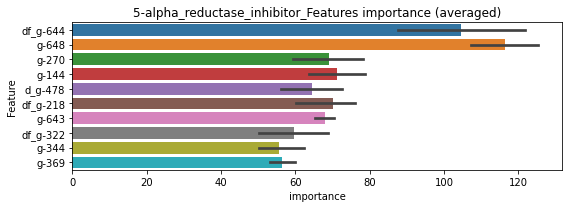

len(train_index) : 3896
len(valid_index) : 3897
================================= fold 1/2 5-alpha_reductase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0111913	valid_1's binary_logloss: 0.0163606
[200]	training's binary_logloss: 0.00119906	valid_1's binary_logloss: 0.00455619
[300]	training's binary_logloss: 0.000331289	valid_1's binary_logloss: 0.00341373
Early stopping, best iteration is:
[356]	training's binary_logloss: 0.000220786	valid_1's binary_logloss: 0.00330323


len(train_index) : 3897
len(valid_index) : 3896
================================= fold 2/2 5-alpha_reductase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0111161	valid_1's binary_logloss: 0.0161554
[200]	training's binary_logloss: 0.00120684	valid_1's binary_logloss: 0.00325106
[300]	training's binary_logloss: 0.000337366	valid_1's binary_logloss: 0.00146067
[400]	training's binary_logloss: 0.00018348	valid_1's binary_logloss: 0.00103285
Early stopping, best iteration is:
[486]	training's binary_logloss: 0.000155456	valid_1's binary_logloss: 0.000947698


5-alpha_reductase_inhibitor logloss: 0.002125620769063023
11-beta-hsd1_inhibitor, len(trt): 18, len(othr): 3286, target_rate: 0.0007559 → Adj_target_rate: 0.0009799


neg labels: 3289 → selected neg labels: 3286


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0255926	valid_1's binary_logloss: 0.0339702
[200]	training's binary_logloss: 0.00309402	valid_1's binary_logloss: 0.00653708
[300]	training's binary_logloss: 0.000860628	valid_1's binary_logloss: 0.00259244
[400]	training's binary_logloss: 0.000451171	valid_1's binary_logloss: 0.00168644
[500]	training's binary_logloss: 0.000350276	valid_1's binary_logloss: 0.00141859
Early stopping, best iteration is:
[585]	training's binary_logloss: 0.000342069	valid_1's binary_logloss: 0.00140457
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0257933	valid_1's binary_logloss: 0.0357222
[200]	training's binary_logloss: 0.00314711	valid_1's binary_logloss: 0.00658085
[300]	training's binary_logloss: 0.000881599	valid_1's binary_logloss: 0.0024652
[400]	training's binary_logloss: 0.000459765	valid_1's binary_logloss: 0.00139465
[500]	training's binary_logloss:

1 / 3 AUC score:1.000
Threshold: 0.0019555, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → positive_corect_labels: 657/3811
p_label_rate: 0.0356605 Vs.target_rate: 0.00076, Num_p_label: 142.0, conf_0:0.00021, conf_1:0.00215
Num_p_label: 142.0, Expected: 3.0, Adj_threshold_1: 0.0019555
Num_p_label: 30.0, Expected: 3.0, Adj_threshold_2: 0.0069555
Num_p_label: 13.0, Expected: 3.0, Adj_threshold_3: 0.0119555
Num_p_label: 8.0, Expected: 3.0, Adj_threshold_4: 0.0169555
Num_p_label: 4.0, Expected: 3.0, Adj_threshold_5: 0.0219555
threshold: 0.0219555, positive p_label: 4.0/3982, p_label_rate: 0.0010045
positive y_label: 657.0/3811, y_label_rate: 0.1723957
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0247514	valid_1's binary_logloss: 0.0324164
[200]	training's binary_logloss: 0.00291166	valid_1's binary_logloss: 0.00598346
[300]	training's binary_logloss: 0.000820283	valid_1's binary_logloss: 0.00237247
[400]	training's binary_logloss: 0.000440011	valid_1's binary_logloss: 0.00158421
[500]	training's binary_logloss: 0.000345278	valid_1's binary_logloss: 0.00134039
Early stopping, best iteration is:
[532]	training's binary_logloss: 0.000340923	valid_1's binary_logloss: 0.00132944
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0246409	valid_1's binary_logloss: 0.035118
[200]	training's binary_logloss: 0.00295841	valid_1's binary_logloss: 0.00675392
[300]	training's binary_logloss: 0.000837108	valid_1's binary_logloss: 0.00257698
[400]	training's binary_logloss: 0.000449412	valid_1's binary_logloss: 0.00163977
[500]	training's binary_logloss:

2 / 3 AUC score:1.000
Threshold: 0.0219555, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → positive_corect_labels: 657.0/3811
p_label_rate: 0.0037670 Vs.target_rate: 0.00076, Num_p_label: 15.0, conf_0:0.00024, conf_1:0.02415
Num_p_label: 15.0, Expected: 3.0, Adj_threshold_1: 0.0219555
Num_p_label: 11.0, Expected: 3.0, Adj_threshold_2: 0.0269555
Num_p_label: 9.0, Expected: 3.0, Adj_threshold_3: 0.0319555
Num_p_label: 8.0, Expected: 3.0, Adj_threshold_4: 0.0369555
Num_p_label: 7.0, Expected: 3.0, Adj_threshold_5: 0.0419555
Num_p_label: 6.0, Expected: 3.0, Adj_threshold_6: 0.0469555
threshold: 0.0469555, positive p_label: 6.0/3982, p_label_rate: 0.0015068
positive y_label: 657.0/3811, y_label_rate: 0.1723957
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0247514	valid_1's binary_logloss: 0.0324164
[200]	training's binary_logloss: 0.00291166	valid_1's binary_logloss: 0.00598346
[300]	training's binary_logloss: 0.000820283	valid_1's binary_logloss: 0.00237247
[400]	training's binary_logloss: 0.000440011	valid_1's binary_logloss: 0.00158421
[500]	training's binary_logloss: 0.000345278	valid_1's binary_logloss: 0.00134039
Early stopping, best iteration is:
[532]	training's binary_logloss: 0.000340923	valid_1's binary_logloss: 0.00132944
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0246409	valid_1's binary_logloss: 0.035118
[200]	training's binary_logloss: 0.00295841	valid_1's binary_logloss: 0.00675392
[300]	training's binary_logloss: 0.000837108	valid_1's binary_logloss: 0.00257698
[400]	training's binary_logloss: 0.000449412	valid_1's binary_logloss: 0.00163977
[500]	training's binary_logloss:

3 / 3 AUC score:1.000
Threshold: 0.0469555, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → positive_corect_labels: 657.0/3811
p_label_rate: 0.0015068 Vs.target_rate: 0.00076, Num_p_label: 6.0, conf_0:0.00024, conf_1:0.05165
threshold: 0.0469555, positive p_label: 6.0/3982, p_label_rate: 0.0015068
positive y_label: 663.0/7793, y_label_rate: 0.0850764


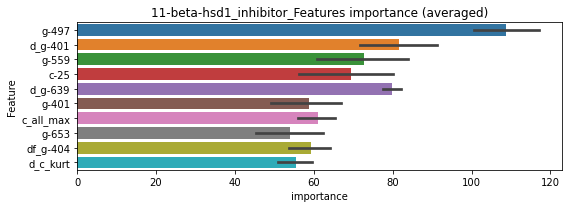

len(train_index) : 3896
len(valid_index) : 3897
================================= fold 1/2 11-beta-hsd1_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0142814	valid_1's binary_logloss: 0.0214797
[200]	training's binary_logloss: 0.00169101	valid_1's binary_logloss: 0.00727503
Early stopping, best iteration is:
[265]	training's binary_logloss: 0.000647935	valid_1's binary_logloss: 0.0063649


len(train_index) : 3897
len(valid_index) : 3896
================================= fold 2/2 11-beta-hsd1_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0144079	valid_1's binary_logloss: 0.0193805
[200]	training's binary_logloss: 0.00178431	valid_1's binary_logloss: 0.00480186
[300]	training's binary_logloss: 0.000485852	valid_1's binary_logloss: 0.00271778
[400]	training's binary_logloss: 0.000247383	valid_1's binary_logloss: 0.00231346
[500]	training's binary_logloss: 0.000187139	valid_1's binary_logloss: 0.00220216
Early stopping, best iteration is:
[505]	training's binary_logloss: 0.000186487	valid_1's binary_logloss: 0.00219424


11-beta-hsd1_inhibitor logloss: 0.004279836755041254
acat_inhibitor, len(trt): 24, len(othr): 3285, target_rate: 0.0010078 → Adj_target_rate: 0.0012513


neg labels: 3289 → selected neg labels: 3285


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0341838	valid_1's binary_logloss: 0.0496163
[200]	training's binary_logloss: 0.00467925	valid_1's binary_logloss: 0.0110392
[300]	training's binary_logloss: 0.00125249	valid_1's binary_logloss: 0.00457985
[400]	training's binary_logloss: 0.000621954	valid_1's binary_logloss: 0.00292519
[500]	training's binary_logloss: 0.000430402	valid_1's binary_logloss: 0.00241589
Early stopping, best iteration is:
[512]	training's binary_logloss: 0.000425216	valid_1's binary_logloss: 0.00240164
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0323555	valid_1's binary_logloss: 0.0448854
[200]	training's binary_logloss: 0.00465891	valid_1's binary_logloss: 0.00871522
[300]	training's binary_logloss: 0.00127484	valid_1's binary_logloss: 0.00298185
[400]	training's binary_logloss: 0.000620443	valid_1's binary_logloss: 0.0016732
[500]	training's binary_logloss: 0.

1 / 3 AUC score:1.000
Threshold: 0.0024223, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → positive_corect_labels: 657/3810
p_label_rate: 0.0356605 Vs.target_rate: 0.00101, Num_p_label: 142.0, conf_0:0.00038, conf_1:0.00266
Num_p_label: 142.0, Expected: 4.0, Adj_threshold_1: 0.0024223
Num_p_label: 19.0, Expected: 4.0, Adj_threshold_2: 0.0074223
Num_p_label: 9.0, Expected: 4.0, Adj_threshold_3: 0.0124223
Num_p_label: 3.0, Expected: 4.0, Adj_threshold_4: 0.0174223
threshold: 0.0174223, positive p_label: 3.0/3982, p_label_rate: 0.0007534
positive y_label: 657.0/3810, y_label_rate: 0.1724409
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0344741	valid_1's binary_logloss: 0.0477764
[200]	training's binary_logloss: 0.00473676	valid_1's binary_logloss: 0.0103833
[300]	training's binary_logloss: 0.00126891	valid_1's binary_logloss: 0.00436104
[400]	training's binary_logloss: 0.000613307	valid_1's binary_logloss: 0.00276207
[500]	training's binary_logloss: 0.000436676	valid_1's binary_logloss: 0.00229148
Early stopping, best iteration is:
[515]	training's binary_logloss: 0.000430811	valid_1's binary_logloss: 0.00227798
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.031313	valid_1's binary_logloss: 0.0427058
[200]	training's binary_logloss: 0.00436415	valid_1's binary_logloss: 0.00761412
[300]	training's binary_logloss: 0.00121026	valid_1's binary_logloss: 0.00248724
[400]	training's binary_logloss: 0.000603003	valid_1's binary_logloss: 0.00137018
[500]	training's binary_logloss: 0.

2 / 3 AUC score:1.000
Threshold: 0.0174223, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 2 → positive_corect_labels: 657.0/3808
p_label_rate: 0.0032647 Vs.target_rate: 0.00101, Num_p_label: 13.0, conf_0:0.00045, conf_1:0.01916
Num_p_label: 13.0, Expected: 4.0, Adj_threshold_1: 0.0174223
Num_p_label: 11.0, Expected: 4.0, Adj_threshold_2: 0.0224223
Num_p_label: 7.0, Expected: 4.0, Adj_threshold_3: 0.0274223
threshold: 0.0274223, positive p_label: 7.0/3982, p_label_rate: 0.0017579
positive y_label: 657.0/3808, y_label_rate: 0.1725315
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0334933	valid_1's binary_logloss: 0.0470512
[200]	training's binary_logloss: 0.00456872	valid_1's binary_logloss: 0.00967552
[300]	training's binary_logloss: 0.00123467	valid_1's binary_logloss: 0.00375089
[400]	training's binary_logloss: 0.00060677	valid_1's binary_logloss: 0.0023895
[500]	training's binary_logloss: 0.000431896	valid_1's binary_logloss: 0.00196068
Early stopping, best iteration is:
[512]	training's binary_logloss: 0.000428918	valid_1's binary_logloss: 0.0019558
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0326107	valid_1's binary_logloss: 0.0437097
[200]	training's binary_logloss: 0.00452132	valid_1's binary_logloss: 0.00789054
[300]	training's binary_logloss: 0.00124186	valid_1's binary_logloss: 0.00252928
[400]	training's binary_logloss: 0.000609427	valid_1's binary_logloss: 0.00138745
[500]	training's binary_logloss: 0.0

3 / 3 AUC score:1.000
Threshold: 0.0274223, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → positive_corect_labels: 657.0/3808
p_label_rate: 0.0017579 Vs.target_rate: 0.00101, Num_p_label: 7.0, conf_0:0.00045, conf_1:0.03016
threshold: 0.0274223, positive p_label: 7.0/3982, p_label_rate: 0.0017579
positive y_label: 664.0/7790, y_label_rate: 0.0852375


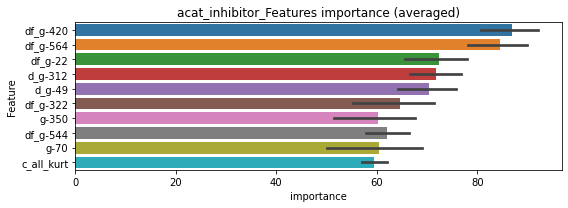

len(train_index) : 3895
len(valid_index) : 3895
================================= fold 1/2 acat_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0187807	valid_1's binary_logloss: 0.0305262
[200]	training's binary_logloss: 0.00256391	valid_1's binary_logloss: 0.0118336
[300]	training's binary_logloss: 0.000663519	valid_1's binary_logloss: 0.00878162
[400]	training's binary_logloss: 0.000320525	valid_1's binary_logloss: 0.00848296
Early stopping, best iteration is:
[395]	training's binary_logloss: 0.00032935	valid_1's binary_logloss: 0.00846342


len(train_index) : 3895
len(valid_index) : 3895
================================= fold 2/2 acat_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0188803	valid_1's binary_logloss: 0.0302962
[200]	training's binary_logloss: 0.00258661	valid_1's binary_logloss: 0.00845962
[300]	training's binary_logloss: 0.000692361	valid_1's binary_logloss: 0.00456
[400]	training's binary_logloss: 0.000329335	valid_1's binary_logloss: 0.00377897
Early stopping, best iteration is:
[457]	training's binary_logloss: 0.000253953	valid_1's binary_logloss: 0.00366867


acat_inhibitor logloss: 0.00606604412055165
acetylcholine_receptor_agonist, len(trt): 190, len(othr): 3259, target_rate: 0.0079785 → Adj_target_rate: 0.0072634


neg labels: 3289 → selected neg labels: 3259


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0944765	valid_1's binary_logloss: 0.225085
[200]	training's binary_logloss: 0.0322709	valid_1's binary_logloss: 0.187311
[300]	training's binary_logloss: 0.0115913	valid_1's binary_logloss: 0.178203
Early stopping, best iteration is:
[325]	training's binary_logloss: 0.00910376	valid_1's binary_logloss: 0.177632
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0991738	valid_1's binary_logloss: 0.23026
[200]	training's binary_logloss: 0.0335205	valid_1's binary_logloss: 0.188441
Early stopping, best iteration is:
[242]	training's binary_logloss: 0.0215899	valid_1's binary_logloss: 0.183523


1 / 3 AUC score:0.954
Threshold: 0.0651890, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 291 → positive_corect_labels: 571/3619
p_label_rate: 0.0577599 Vs.target_rate: 0.00798, Num_p_label: 230.0, conf_0:0.02178, conf_1:0.07171
Num_p_label: 230.0, Expected: 31.8, Adj_threshold_1: 0.0651890
Num_p_label: 187.0, Expected: 31.8, Adj_threshold_2: 0.0701890
Num_p_label: 150.0, Expected: 31.8, Adj_threshold_3: 0.0751890
Num_p_label: 131.0, Expected: 31.8, Adj_threshold_4: 0.0801890
Num_p_label: 112.0, Expected: 31.8, Adj_threshold_5: 0.0851890
Num_p_label: 97.0, Expected: 31.8, Adj_threshold_6: 0.0901890
Num_p_label: 84.0, Expected: 31.8, Adj_threshold_7: 0.0951890
Num_p_label: 69.0, Expected: 31.8, Adj_threshold_8: 0.1001890
Num_p_label: 59.0, Expected: 31.8, Adj_threshold_9: 0.1051890
threshold: 0.1051890, positive p_label: 59.0/3982, p_label_rate: 0.0148167
positive y_label: 571.0/3619, y_label_rate: 0.1577784
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0747204	valid_1's binary_logloss: 0.208253
[200]	training's binary_logloss: 0.0211925	valid_1's binary_logloss: 0.168189
[300]	training's binary_logloss: 0.0072405	valid_1's binary_logloss: 0.157041
Early stopping, best iteration is:
[322]	training's binary_logloss: 0.00581134	valid_1's binary_logloss: 0.156122
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0792241	valid_1's binary_logloss: 0.177448
[200]	training's binary_logloss: 0.0244179	valid_1's binary_logloss: 0.129549
[300]	training's binary_logloss: 0.00850664	valid_1's binary_logloss: 0.115716
Early stopping, best iteration is:
[311]	training's binary_logloss: 0.00762762	valid_1's binary_logloss: 0.114915


2 / 3 AUC score:0.979
Threshold: 0.1051890, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 84 → positive_corect_labels: 499.0/3535
p_label_rate: 0.0070316 Vs.target_rate: 0.00798, Num_p_label: 28.0, conf_0:0.01159, conf_1:0.11571
threshold: 0.1051890, positive p_label: 28.0/3982, p_label_rate: 0.0070316
positive y_label: 499.0/3535, y_label_rate: 0.1411598
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0614617	valid_1's binary_logloss: 0.179054
[200]	training's binary_logloss: 0.0154208	valid_1's binary_logloss: 0.146331
Early stopping, best iteration is:
[251]	training's binary_logloss: 0.00836707	valid_1's binary_logloss: 0.141983
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0645157	valid_1's binary_logloss: 0.154423
[200]	training's binary_logloss: 0.016719	valid_1's binary_logloss: 0.111779
[300]	training's binary_logloss: 0.00553214	valid_1's binary_logloss: 0.099635
Early stopping, best iteration is:
[359]	training's binary_logloss: 0.0033107	valid_1's binary_logloss: 0.0958642


3 / 3 AUC score:0.989
Threshold: 0.1051890, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 62 → positive_corect_labels: 443.0/3473
p_label_rate: 0.0025113 Vs.target_rate: 0.00798, Num_p_label: 10.0, conf_0:0.00807, conf_1:0.11571
Num_p_label: 10.0, Expected: 31.8, Adj_threshold_1: 0.1051890
Num_p_label: 12.0, Expected: 31.8, Adj_threshold_2: 0.1001890
Num_p_label: 18.0, Expected: 31.8, Adj_threshold_3: 0.0951890
threshold: 0.0951890, positive p_label: 18.0/3982, p_label_rate: 0.0045203
positive y_label: 461.0/7455, y_label_rate: 0.0618377


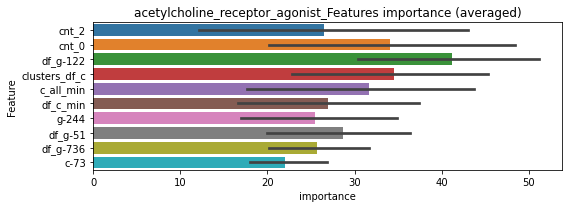

len(train_index) : 3727
len(valid_index) : 3728
================================= fold 1/2 acetylcholine_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0299662	valid_1's binary_logloss: 0.0929621
[200]	training's binary_logloss: 0.00750692	valid_1's binary_logloss: 0.079044
Early stopping, best iteration is:
[244]	training's binary_logloss: 0.00430883	valid_1's binary_logloss: 0.0768191


len(train_index) : 3728
len(valid_index) : 3727
================================= fold 2/2 acetylcholine_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0315714	valid_1's binary_logloss: 0.0817969
[200]	training's binary_logloss: 0.00845793	valid_1's binary_logloss: 0.0640736
[300]	training's binary_logloss: 0.00257796	valid_1's binary_logloss: 0.059971
Early stopping, best iteration is:
[313]	training's binary_logloss: 0.00226008	valid_1's binary_logloss: 0.0595168


acetylcholine_receptor_agonist logloss: 0.06816906910017012


  acetylcholine_receptor_agonist
0                       df_g-122
1                  clusters_df_c
2                          cnt_0
3                      c_all_min
4                        df_g-51
5                       df_c_min
6                          cnt_2
7                       df_g-736
8                          g-244
9                           c-73


acetylcholine_receptor_antagonist, len(trt): 301, len(othr): 3241, target_rate: 0.0126396 → Adj_target_rate: 0.0107394


neg labels: 3289 → selected neg labels: 3241


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.127587	valid_1's binary_logloss: 0.301941
[200]	training's binary_logloss: 0.0501538	valid_1's binary_logloss: 0.28055
Early stopping, best iteration is:
[196]	training's binary_logloss: 0.0519892	valid_1's binary_logloss: 0.28046
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.130579	valid_1's binary_logloss: 0.292195
[200]	training's binary_logloss: 0.0532061	valid_1's binary_logloss: 0.261281
Early stopping, best iteration is:
[249]	training's binary_logloss: 0.0345529	valid_1's binary_logloss: 0.257698


1 / 3 AUC score:0.873
Threshold: 0.1115160, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 486 → positive_corect_labels: 470/3403
p_label_rate: 0.0615269 Vs.target_rate: 0.01264, Num_p_label: 245.0, conf_0:0.05087, conf_1:0.12267
Num_p_label: 245.0, Expected: 50.3, Adj_threshold_1: 0.1115160
Num_p_label: 216.0, Expected: 50.3, Adj_threshold_2: 0.1165160
Num_p_label: 194.0, Expected: 50.3, Adj_threshold_3: 0.1215160
Num_p_label: 166.0, Expected: 50.3, Adj_threshold_4: 0.1265160
Num_p_label: 149.0, Expected: 50.3, Adj_threshold_5: 0.1315160
Num_p_label: 126.0, Expected: 50.3, Adj_threshold_6: 0.1365160
Num_p_label: 103.0, Expected: 50.3, Adj_threshold_7: 0.1415160
Num_p_label: 92.0, Expected: 50.3, Adj_threshold_8: 0.1465160
threshold: 0.1465160, positive p_label: 92.0/3982, p_label_rate: 0.0231040
positive y_label: 470.0/3403, y_label_rate: 0.1381134
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.077253	valid_1's binary_logloss: 0.204874
[200]	training's binary_logloss: 0.0246984	valid_1's binary_logloss: 0.172353
Early stopping, best iteration is:
[264]	training's binary_logloss: 0.0120652	valid_1's binary_logloss: 0.166462
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.078325	valid_1's binary_logloss: 0.192974
[200]	training's binary_logloss: 0.0252503	valid_1's binary_logloss: 0.162007
Early stopping, best iteration is:
[253]	training's binary_logloss: 0.014328	valid_1's binary_logloss: 0.157852


2 / 3 AUC score:0.972
Threshold: 0.1465160, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 126 → positive_corect_labels: 364.0/3277
p_label_rate: 0.0067805 Vs.target_rate: 0.01264, Num_p_label: 27.0, conf_0:0.01651, conf_1:0.16117
threshold: 0.1465160, positive p_label: 27.0/3982, p_label_rate: 0.0067805
positive y_label: 364.0/3277, y_label_rate: 0.1110772
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0523058	valid_1's binary_logloss: 0.141714
[200]	training's binary_logloss: 0.0134278	valid_1's binary_logloss: 0.117463
Early stopping, best iteration is:
[219]	training's binary_logloss: 0.01032	valid_1's binary_logloss: 0.113443
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0511709	valid_1's binary_logloss: 0.139834
[200]	training's binary_logloss: 0.0140166	valid_1's binary_logloss: 0.109184
Early stopping, best iteration is:
[286]	training's binary_logloss: 0.00548746	valid_1's binary_logloss: 0.104975


3 / 3 AUC score:0.981
Threshold: 0.1465160, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 58 → positive_corect_labels: 307.0/3219
p_label_rate: 0.0007534 Vs.target_rate: 0.01264, Num_p_label: 3.0, conf_0:0.00809, conf_1:0.16117
Num_p_label: 3.0, Expected: 50.3, Adj_threshold_1: 0.1465160
Num_p_label: 3.0, Expected: 50.3, Adj_threshold_2: 0.1415160
Num_p_label: 3.0, Expected: 50.3, Adj_threshold_3: 0.1365160
Num_p_label: 6.0, Expected: 50.3, Adj_threshold_4: 0.1315160
Num_p_label: 7.0, Expected: 50.3, Adj_threshold_5: 0.1265160
Num_p_label: 9.0, Expected: 50.3, Adj_threshold_6: 0.1215160
Num_p_label: 11.0, Expected: 50.3, Adj_threshold_7: 0.1165160
Num_p_label: 12.0, Expected: 50.3, Adj_threshold_8: 0.1115160
Num_p_label: 16.0, Expected: 50.3, Adj_threshold_9: 0.1065160
Num_p_label: 21.0, Expected: 50.3, Adj_threshold_10: 0.1015160
threshold: 0.0965160, positive p_label: 24.0/3982, p_label_rate: 0.0060271
positive y_label: 331.0/7201, y_label_rate: 0.0459658


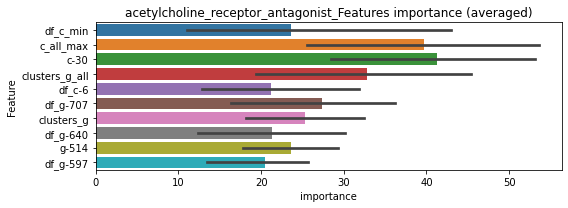

len(train_index) : 3600
len(valid_index) : 3601
================================= fold 1/2 acetylcholine_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0204607	valid_1's binary_logloss: 0.0683674
Early stopping, best iteration is:
[165]	training's binary_logloss: 0.00790883	valid_1's binary_logloss: 0.0619549


len(train_index) : 3601
len(valid_index) : 3600
================================= fold 2/2 acetylcholine_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0204317	valid_1's binary_logloss: 0.0713457
[200]	training's binary_logloss: 0.00503089	valid_1's binary_logloss: 0.0631798
Early stopping, best iteration is:
[218]	training's binary_logloss: 0.00404448	valid_1's binary_logloss: 0.0624633


acetylcholine_receptor_antagonist logloss: 0.06220908055888142


  acetylcholine_receptor_agonist acetylcholine_receptor_antagonist
0                       df_g-122                              c-30
1                  clusters_df_c                         c_all_max
2                          cnt_0                    clusters_g_all
3                      c_all_min                          df_g-707
4                        df_g-51                        clusters_g
5                       df_c_min                          df_c_min
6                          cnt_2                             g-514
7                       df_g-736                          df_g-640
8                          g-244                            df_c-6
9                           c-73                          df_g-597


acetylcholinesterase_inhibitor, len(trt): 73, len(othr): 3276, target_rate: 0.0030654 → Adj_target_rate: 0.0032212


neg labels: 3289 → selected neg labels: 3276


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0522571	valid_1's binary_logloss: 0.117376
[200]	training's binary_logloss: 0.0122574	valid_1's binary_logloss: 0.0772177
[300]	training's binary_logloss: 0.00369234	valid_1's binary_logloss: 0.0672113
Early stopping, best iteration is:
[358]	training's binary_logloss: 0.00224137	valid_1's binary_logloss: 0.0644608
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0544207	valid_1's binary_logloss: 0.102756
[200]	training's binary_logloss: 0.0120301	valid_1's binary_logloss: 0.0547676
[300]	training's binary_logloss: 0.0036025	valid_1's binary_logloss: 0.0421431
[400]	training's binary_logloss: 0.00161663	valid_1's binary_logloss: 0.0389249
Early stopping, best iteration is:
[410]	training's binary_logloss: 0.00152514	valid_1's binary_logloss: 0.0385224


1 / 3 AUC score:0.998
Threshold: 0.0121048, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 144 → positive_corect_labels: 649/3787
p_label_rate: 0.0313913 Vs.target_rate: 0.00307, Num_p_label: 125.0, conf_0:0.00210, conf_1:0.01332
Num_p_label: 125.0, Expected: 12.2, Adj_threshold_1: 0.0121048
Num_p_label: 57.0, Expected: 12.2, Adj_threshold_2: 0.0171048
Num_p_label: 30.0, Expected: 12.2, Adj_threshold_3: 0.0221048
Num_p_label: 17.0, Expected: 12.2, Adj_threshold_4: 0.0271048
threshold: 0.0271048, positive p_label: 17.0/3982, p_label_rate: 0.0042692
positive y_label: 649.0/3787, y_label_rate: 0.1713758
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0522424	valid_1's binary_logloss: 0.10541
[200]	training's binary_logloss: 0.0113374	valid_1's binary_logloss: 0.058187
[300]	training's binary_logloss: 0.00339274	valid_1's binary_logloss: 0.0457953
[400]	training's binary_logloss: 0.00155078	valid_1's binary_logloss: 0.041531
Early stopping, best iteration is:
[475]	training's binary_logloss: 0.00106162	valid_1's binary_logloss: 0.0402131
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0522642	valid_1's binary_logloss: 0.102109
[200]	training's binary_logloss: 0.0115259	valid_1's binary_logloss: 0.0582868
[300]	training's binary_logloss: 0.00347068	valid_1's binary_logloss: 0.0464246
Early stopping, best iteration is:
[373]	training's binary_logloss: 0.00189964	valid_1's binary_logloss: 0.0446141


2 / 3 AUC score:1.000
Threshold: 0.0271048, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 22 → positive_corect_labels: 641.0/3765
p_label_rate: 0.0092918 Vs.target_rate: 0.00307, Num_p_label: 37.0, conf_0:0.00183, conf_1:0.02982
Num_p_label: 37.0, Expected: 12.2, Adj_threshold_1: 0.0271048
Num_p_label: 22.0, Expected: 12.2, Adj_threshold_2: 0.0321048
threshold: 0.0321048, positive p_label: 22.0/3982, p_label_rate: 0.0055249
positive y_label: 641.0/3765, y_label_rate: 0.1702523
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0482323	valid_1's binary_logloss: 0.0992112
[200]	training's binary_logloss: 0.0102876	valid_1's binary_logloss: 0.054543
[300]	training's binary_logloss: 0.00316736	valid_1's binary_logloss: 0.0421857
[400]	training's binary_logloss: 0.00148094	valid_1's binary_logloss: 0.0374337
Early stopping, best iteration is:
[418]	training's binary_logloss: 0.00133261	valid_1's binary_logloss: 0.0368338
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0521595	valid_1's binary_logloss: 0.0894495
[200]	training's binary_logloss: 0.0113798	valid_1's binary_logloss: 0.0446777
[300]	training's binary_logloss: 0.00342817	valid_1's binary_logloss: 0.0326979
[400]	training's binary_logloss: 0.00159216	valid_1's binary_logloss: 0.0299739
Early stopping, best iteration is:
[396]	training's binary_logloss: 0.00163089	valid_1's binary_logloss: 0.0298829


3 / 3 AUC score:0.999
Threshold: 0.0321048, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 10 → positive_corect_labels: 636.0/3755
p_label_rate: 0.0060271 Vs.target_rate: 0.00307, Num_p_label: 24.0, conf_0:0.00188, conf_1:0.03532
threshold: 0.0321048, positive p_label: 24.0/3982, p_label_rate: 0.0060271
positive y_label: 660.0/7737, y_label_rate: 0.0853044


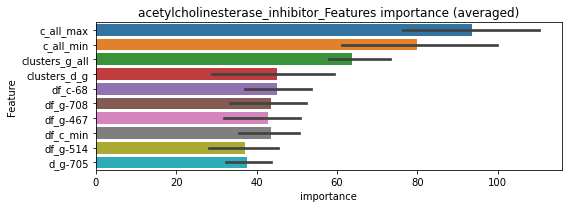

len(train_index) : 3868
len(valid_index) : 3869
================================= fold 1/2 acetylcholinesterase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0290115	valid_1's binary_logloss: 0.0661314
[200]	training's binary_logloss: 0.00629232	valid_1's binary_logloss: 0.0428838
[300]	training's binary_logloss: 0.00185538	valid_1's binary_logloss: 0.0386702
Early stopping, best iteration is:
[307]	training's binary_logloss: 0.00172329	valid_1's binary_logloss: 0.0385088


len(train_index) : 3869
len(valid_index) : 3868
================================= fold 2/2 acetylcholinesterase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.029167	valid_1's binary_logloss: 0.0573075
[200]	training's binary_logloss: 0.00649465	valid_1's binary_logloss: 0.0333871
[300]	training's binary_logloss: 0.00194793	valid_1's binary_logloss: 0.0281762
Early stopping, best iteration is:
[347]	training's binary_logloss: 0.001276	valid_1's binary_logloss: 0.0273474


acetylcholinesterase_inhibitor logloss: 0.032928808143391615


  acetylcholine_receptor_agonist acetylcholine_receptor_antagonist  \
0                       df_g-122                              c-30   
1                  clusters_df_c                         c_all_max   
2                          cnt_0                    clusters_g_all   
3                      c_all_min                          df_g-707   
4                        df_g-51                        clusters_g   
5                       df_c_min                          df_c_min   
6                          cnt_2                             g-514   
7                       df_g-736                          df_g-640   
8                          g-244                            df_c-6   
9                           c-73                          df_g-597   

  acetylcholinesterase_inhibitor  
0                      c_all_max  
1                      c_all_min  
2                 clusters_g_all  
3                   clusters_d_g  
4                        df_c-68  
5                  

adenosine_receptor_agonist, len(trt): 54, len(othr): 3281, target_rate: 0.0022676 → Adj_target_rate: 0.0024931


neg labels: 3289 → selected neg labels: 3281


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0447172	valid_1's binary_logloss: 0.0895553
[200]	training's binary_logloss: 0.00840714	valid_1's binary_logloss: 0.0419022
[300]	training's binary_logloss: 0.00242159	valid_1's binary_logloss: 0.0295963
[400]	training's binary_logloss: 0.00114056	valid_1's binary_logloss: 0.0257254
[500]	training's binary_logloss: 0.00072103	valid_1's binary_logloss: 0.0234799
Early stopping, best iteration is:
[534]	training's binary_logloss: 0.000646557	valid_1's binary_logloss: 0.0230494
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0463114	valid_1's binary_logloss: 0.0837768
[200]	training's binary_logloss: 0.00866457	valid_1's binary_logloss: 0.0349852
[300]	training's binary_logloss: 0.00252441	valid_1's binary_logloss: 0.0242998
[400]	training's binary_logloss: 0.00118987	valid_1's binary_logloss: 0.020814
[500]	training's binary_logloss: 0.000753343	

1 / 3 AUC score:1.000
Threshold: 0.0057292, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → positive_corect_labels: 656/3805
p_label_rate: 0.0429432 Vs.target_rate: 0.00227, Num_p_label: 171.0, conf_0:0.00091, conf_1:0.00630
Num_p_label: 171.0, Expected: 9.0, Adj_threshold_1: 0.0057292
Num_p_label: 55.0, Expected: 9.0, Adj_threshold_2: 0.0107292
Num_p_label: 24.0, Expected: 9.0, Adj_threshold_3: 0.0157292
Num_p_label: 15.0, Expected: 9.0, Adj_threshold_4: 0.0207292
threshold: 0.0207292, positive p_label: 15.0/3982, p_label_rate: 0.0037670
positive y_label: 656.0/3805, y_label_rate: 0.1724047
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0441139	valid_1's binary_logloss: 0.088101
[200]	training's binary_logloss: 0.00823708	valid_1's binary_logloss: 0.041157
[300]	training's binary_logloss: 0.00239335	valid_1's binary_logloss: 0.0286161
[400]	training's binary_logloss: 0.00112347	valid_1's binary_logloss: 0.0256102
Early stopping, best iteration is:
[391]	training's binary_logloss: 0.00119348	valid_1's binary_logloss: 0.0254219
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0479153	valid_1's binary_logloss: 0.0848521
[200]	training's binary_logloss: 0.00884474	valid_1's binary_logloss: 0.033016
[300]	training's binary_logloss: 0.00256129	valid_1's binary_logloss: 0.0219188
Early stopping, best iteration is:
[387]	training's binary_logloss: 0.00131271	valid_1's binary_logloss: 0.0190505


2 / 3 AUC score:1.000
Threshold: 0.0207292, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 18 → positive_corect_labels: 655.0/3787
p_label_rate: 0.0231040 Vs.target_rate: 0.00227, Num_p_label: 92.0, conf_0:0.00173, conf_1:0.02280
Num_p_label: 92.0, Expected: 9.0, Adj_threshold_1: 0.0207292
Num_p_label: 63.0, Expected: 9.0, Adj_threshold_2: 0.0257292
Num_p_label: 44.0, Expected: 9.0, Adj_threshold_3: 0.0307292
Num_p_label: 26.0, Expected: 9.0, Adj_threshold_4: 0.0357292
Num_p_label: 24.0, Expected: 9.0, Adj_threshold_5: 0.0407292
Num_p_label: 17.0, Expected: 9.0, Adj_threshold_6: 0.0457292
threshold: 0.0457292, positive p_label: 17.0/3982, p_label_rate: 0.0042692
positive y_label: 655.0/3787, y_label_rate: 0.1729601
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.047827	valid_1's binary_logloss: 0.0851105
[200]	training's binary_logloss: 0.00882919	valid_1's binary_logloss: 0.0324293
[300]	training's binary_logloss: 0.00257883	valid_1's binary_logloss: 0.0200139
[400]	training's binary_logloss: 0.00121865	valid_1's binary_logloss: 0.0158268
[500]	training's binary_logloss: 0.00075795	valid_1's binary_logloss: 0.0145152
Early stopping, best iteration is:
[490]	training's binary_logloss: 0.000785673	valid_1's binary_logloss: 0.0143851
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0472508	valid_1's binary_logloss: 0.0857918
[200]	training's binary_logloss: 0.00826839	valid_1's binary_logloss: 0.0331056
[300]	training's binary_logloss: 0.00242043	valid_1's binary_logloss: 0.0213468
[400]	training's binary_logloss: 0.0011439	valid_1's binary_logloss: 0.0182169
Early stopping, best iteration is:
[425]	train

3 / 3 AUC score:1.000
Threshold: 0.0457292, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 2 → positive_corect_labels: 653.0/3785
p_label_rate: 0.0025113 Vs.target_rate: 0.00227, Num_p_label: 10.0, conf_0:0.00130, conf_1:0.05030
threshold: 0.0457292, positive p_label: 10.0/3982, p_label_rate: 0.0025113
positive y_label: 663.0/7767, y_label_rate: 0.0853611


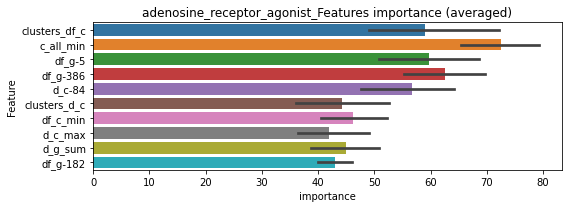

len(train_index) : 3883
len(valid_index) : 3884
================================= fold 1/2 adenosine_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0242327	valid_1's binary_logloss: 0.0556342
[200]	training's binary_logloss: 0.00428691	valid_1's binary_logloss: 0.0307003
[300]	training's binary_logloss: 0.00122046	valid_1's binary_logloss: 0.0254406
Early stopping, best iteration is:
[355]	training's binary_logloss: 0.000773913	valid_1's binary_logloss: 0.0243733


len(train_index) : 3884
len(valid_index) : 3883
================================= fold 2/2 adenosine_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0274827	valid_1's binary_logloss: 0.0476845
[200]	training's binary_logloss: 0.00527487	valid_1's binary_logloss: 0.018397
[300]	training's binary_logloss: 0.00147402	valid_1's binary_logloss: 0.0116369
[400]	training's binary_logloss: 0.000671072	valid_1's binary_logloss: 0.00961231
[500]	training's binary_logloss: 0.000413177	valid_1's binary_logloss: 0.00901085
Early stopping, best iteration is:
[496]	training's binary_logloss: 0.000420338	valid_1's binary_logloss: 0.00897167


adenosine_receptor_agonist logloss: 0.01667348772568949
adenosine_receptor_antagonist, len(trt): 96, len(othr): 3273, target_rate: 0.0040312 → Adj_target_rate: 0.0040656


neg labels: 3289 → selected neg labels: 3273


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0635721	valid_1's binary_logloss: 0.128063
[200]	training's binary_logloss: 0.0163008	valid_1's binary_logloss: 0.0785263
[300]	training's binary_logloss: 0.00516482	valid_1's binary_logloss: 0.0614436
[400]	training's binary_logloss: 0.00225369	valid_1's binary_logloss: 0.0562499
Early stopping, best iteration is:
[489]	training's binary_logloss: 0.00138259	valid_1's binary_logloss: 0.0533392
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0620716	valid_1's binary_logloss: 0.137656
[200]	training's binary_logloss: 0.0164424	valid_1's binary_logloss: 0.0942908
[300]	training's binary_logloss: 0.00505913	valid_1's binary_logloss: 0.0826842
Early stopping, best iteration is:
[355]	training's binary_logloss: 0.00311073	valid_1's binary_logloss: 0.0799272


1 / 3 AUC score:0.994
Threshold: 0.0161154, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 160 → positive_corect_labels: 640/3767
p_label_rate: 0.0349071 Vs.target_rate: 0.00403, Num_p_label: 139.0, conf_0:0.00288, conf_1:0.01773
Num_p_label: 139.0, Expected: 16.1, Adj_threshold_1: 0.0161154
Num_p_label: 79.0, Expected: 16.1, Adj_threshold_2: 0.0211154
Num_p_label: 39.0, Expected: 16.1, Adj_threshold_3: 0.0261154
Num_p_label: 25.0, Expected: 16.1, Adj_threshold_4: 0.0311154
threshold: 0.0311154, positive p_label: 25.0/3982, p_label_rate: 0.0062783
positive y_label: 640.0/3767, y_label_rate: 0.1698965
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0605174	valid_1's binary_logloss: 0.123285
[200]	training's binary_logloss: 0.0146086	valid_1's binary_logloss: 0.0766918
[300]	training's binary_logloss: 0.0045249	valid_1's binary_logloss: 0.0633622
[400]	training's binary_logloss: 0.00204121	valid_1's binary_logloss: 0.0582948
Early stopping, best iteration is:
[440]	training's binary_logloss: 0.00162086	valid_1's binary_logloss: 0.0571351
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0617504	valid_1's binary_logloss: 0.131861
[200]	training's binary_logloss: 0.0158541	valid_1's binary_logloss: 0.0890111
[300]	training's binary_logloss: 0.00494915	valid_1's binary_logloss: 0.0778707
Early stopping, best iteration is:
[357]	training's binary_logloss: 0.00299306	valid_1's binary_logloss: 0.0751268


2 / 3 AUC score:0.997
Threshold: 0.0311154, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 60 → positive_corect_labels: 624.0/3707
p_label_rate: 0.0226017 Vs.target_rate: 0.00403, Num_p_label: 90.0, conf_0:0.00319, conf_1:0.03423
Num_p_label: 90.0, Expected: 16.1, Adj_threshold_1: 0.0311154
Num_p_label: 69.0, Expected: 16.1, Adj_threshold_2: 0.0361154
Num_p_label: 53.0, Expected: 16.1, Adj_threshold_3: 0.0411154
Num_p_label: 43.0, Expected: 16.1, Adj_threshold_4: 0.0461154
Num_p_label: 36.0, Expected: 16.1, Adj_threshold_5: 0.0511154
Num_p_label: 29.0, Expected: 16.1, Adj_threshold_6: 0.0561154
threshold: 0.0561154, positive p_label: 29.0/3982, p_label_rate: 0.0072828
positive y_label: 624.0/3707, y_label_rate: 0.1683302
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0525191	valid_1's binary_logloss: 0.123256
[200]	training's binary_logloss: 0.0118551	valid_1's binary_logloss: 0.0770353
[300]	training's binary_logloss: 0.00381769	valid_1's binary_logloss: 0.0631803
[400]	training's binary_logloss: 0.00178385	valid_1's binary_logloss: 0.0591738
Early stopping, best iteration is:
[424]	training's binary_logloss: 0.00156067	valid_1's binary_logloss: 0.0583285
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0624077	valid_1's binary_logloss: 0.11706
[200]	training's binary_logloss: 0.0151357	valid_1's binary_logloss: 0.0664558
[300]	training's binary_logloss: 0.00469639	valid_1's binary_logloss: 0.0507693
Early stopping, best iteration is:
[336]	training's binary_logloss: 0.00336031	valid_1's binary_logloss: 0.0481661


3 / 3 AUC score:0.999
Threshold: 0.0561154, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 24 → positive_corect_labels: 609.0/3683
p_label_rate: 0.0120542 Vs.target_rate: 0.00403, Num_p_label: 48.0, conf_0:0.00334, conf_1:0.06173
threshold: 0.0561154, positive p_label: 48.0/3982, p_label_rate: 0.0120542
positive y_label: 657.0/7665, y_label_rate: 0.0857143


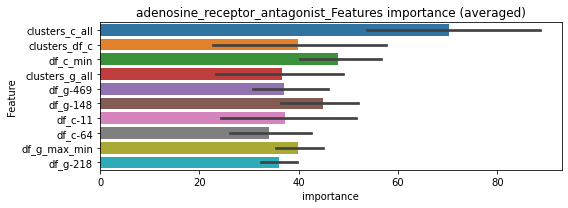

len(train_index) : 3832
len(valid_index) : 3833
================================= fold 1/2 adenosine_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.032099	valid_1's binary_logloss: 0.0852984
[200]	training's binary_logloss: 0.00785615	valid_1's binary_logloss: 0.0614238
Early stopping, best iteration is:
[280]	training's binary_logloss: 0.00312944	valid_1's binary_logloss: 0.0575812


len(train_index) : 3833
len(valid_index) : 3832
================================= fold 2/2 adenosine_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.037718	valid_1's binary_logloss: 0.0716512
[200]	training's binary_logloss: 0.00974533	valid_1's binary_logloss: 0.0479639
[300]	training's binary_logloss: 0.00303553	valid_1's binary_logloss: 0.0421312
Early stopping, best iteration is:
[330]	training's binary_logloss: 0.00225392	valid_1's binary_logloss: 0.0413326


adenosine_receptor_antagonist logloss: 0.04945797794775553


  acetylcholine_receptor_agonist acetylcholine_receptor_antagonist  \
0                       df_g-122                              c-30   
1                  clusters_df_c                         c_all_max   
2                          cnt_0                    clusters_g_all   
3                      c_all_min                          df_g-707   
4                        df_g-51                        clusters_g   
5                       df_c_min                          df_c_min   
6                          cnt_2                             g-514   
7                       df_g-736                          df_g-640   
8                          g-244                            df_c-6   
9                           c-73                          df_g-597   

  acetylcholinesterase_inhibitor adenosine_receptor_antagonist  
0                      c_all_max                clusters_c_all  
1                      c_all_min                      df_c_min  
2                 clusters_g_all  

adenylyl_cyclase_activator, len(trt): 18, len(othr): 3286, target_rate: 0.0007559 → Adj_target_rate: 0.0009799


neg labels: 3289 → selected neg labels: 3286


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0214559	valid_1's binary_logloss: 0.0276126
[200]	training's binary_logloss: 0.00233612	valid_1's binary_logloss: 0.00505577
[300]	training's binary_logloss: 0.000650647	valid_1's binary_logloss: 0.0021774
[400]	training's binary_logloss: 0.000353945	valid_1's binary_logloss: 0.00147365
[500]	training's binary_logloss: 0.000291027	valid_1's binary_logloss: 0.00134106
Early stopping, best iteration is:
[555]	training's binary_logloss: 0.000279154	valid_1's binary_logloss: 0.00130354
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0213934	valid_1's binary_logloss: 0.0255918
[200]	training's binary_logloss: 0.00237222	valid_1's binary_logloss: 0.00350372
[300]	training's binary_logloss: 0.000665186	valid_1's binary_logloss: 0.00114304
[400]	training's binary_logloss: 0.000358555	valid_1's binary_logloss: 0.000676623
[500]	training's binary_logloss

1 / 3 AUC score:1.000
Threshold: 0.0015353, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → positive_corect_labels: 657/3811
p_label_rate: 0.0361627 Vs.target_rate: 0.00076, Num_p_label: 144.0, conf_0:0.00014, conf_1:0.00169
Num_p_label: 144.0, Expected: 3.0, Adj_threshold_1: 0.0015353
Num_p_label: 27.0, Expected: 3.0, Adj_threshold_2: 0.0065353
Num_p_label: 12.0, Expected: 3.0, Adj_threshold_3: 0.0115353
Num_p_label: 6.0, Expected: 3.0, Adj_threshold_4: 0.0165353
threshold: 0.0165353, positive p_label: 6.0/3982, p_label_rate: 0.0015068
positive y_label: 657.0/3811, y_label_rate: 0.1723957
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0212791	valid_1's binary_logloss: 0.0271927
[200]	training's binary_logloss: 0.00225027	valid_1's binary_logloss: 0.00513573
[300]	training's binary_logloss: 0.000612046	valid_1's binary_logloss: 0.00215334
[400]	training's binary_logloss: 0.000335951	valid_1's binary_logloss: 0.00144805
[500]	training's binary_logloss: 0.000275783	valid_1's binary_logloss: 0.00129961
Early stopping, best iteration is:
[516]	training's binary_logloss: 0.00027274	valid_1's binary_logloss: 0.00129795
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0214426	valid_1's binary_logloss: 0.0250972
[200]	training's binary_logloss: 0.00227283	valid_1's binary_logloss: 0.00298975
[300]	training's binary_logloss: 0.000623443	valid_1's binary_logloss: 0.000893371
[400]	training's binary_logloss: 0.000340835	valid_1's binary_logloss: 0.000508133
[500]	training's binary_loglos

2 / 3 AUC score:1.000
Threshold: 0.0165353, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → positive_corect_labels: 657.0/3811
p_label_rate: 0.0075339 Vs.target_rate: 0.00076, Num_p_label: 30.0, conf_0:0.00017, conf_1:0.01819
Num_p_label: 30.0, Expected: 3.0, Adj_threshold_1: 0.0165353
Num_p_label: 22.0, Expected: 3.0, Adj_threshold_2: 0.0215353
Num_p_label: 21.0, Expected: 3.0, Adj_threshold_3: 0.0265353
Num_p_label: 12.0, Expected: 3.0, Adj_threshold_4: 0.0315353
Num_p_label: 8.0, Expected: 3.0, Adj_threshold_5: 0.0365353
Num_p_label: 7.0, Expected: 3.0, Adj_threshold_6: 0.0415353
Num_p_label: 5.0, Expected: 3.0, Adj_threshold_7: 0.0465353
threshold: 0.0465353, positive p_label: 5.0/3982, p_label_rate: 0.0012557
positive y_label: 657.0/3811, y_label_rate: 0.1723957
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0212791	valid_1's binary_logloss: 0.0271927
[200]	training's binary_logloss: 0.00225027	valid_1's binary_logloss: 0.00513573
[300]	training's binary_logloss: 0.000612046	valid_1's binary_logloss: 0.00215334
[400]	training's binary_logloss: 0.000335951	valid_1's binary_logloss: 0.00144805
[500]	training's binary_logloss: 0.000275783	valid_1's binary_logloss: 0.00129961
Early stopping, best iteration is:
[516]	training's binary_logloss: 0.00027274	valid_1's binary_logloss: 0.00129795
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0214426	valid_1's binary_logloss: 0.0250972
[200]	training's binary_logloss: 0.00227283	valid_1's binary_logloss: 0.00298975
[300]	training's binary_logloss: 0.000623443	valid_1's binary_logloss: 0.000893371
[400]	training's binary_logloss: 0.000340835	valid_1's binary_logloss: 0.000508133
[500]	training's binary_loglos

3 / 3 AUC score:1.000
Threshold: 0.0465353, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → positive_corect_labels: 657.0/3811
p_label_rate: 0.0012557 Vs.target_rate: 0.00076, Num_p_label: 5.0, conf_0:0.00017, conf_1:0.05119
threshold: 0.0465353, positive p_label: 5.0/3982, p_label_rate: 0.0012557
positive y_label: 662.0/7793, y_label_rate: 0.0849480


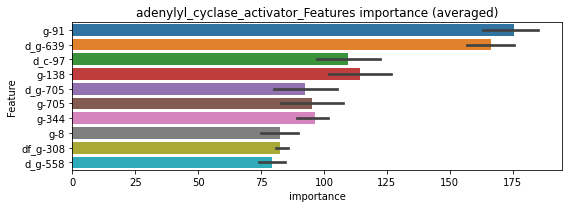

len(train_index) : 3896
len(valid_index) : 3897
================================= fold 1/2 adenylyl_cyclase_activator=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0110234	valid_1's binary_logloss: 0.018494
[200]	training's binary_logloss: 0.00114255	valid_1's binary_logloss: 0.00768947
[300]	training's binary_logloss: 0.000314503	valid_1's binary_logloss: 0.00638357
Early stopping, best iteration is:
[385]	training's binary_logloss: 0.000179883	valid_1's binary_logloss: 0.00613495


len(train_index) : 3897
len(valid_index) : 3896
================================= fold 2/2 adenylyl_cyclase_activator=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0113992	valid_1's binary_logloss: 0.0143795
[200]	training's binary_logloss: 0.00122949	valid_1's binary_logloss: 0.00301702
[300]	training's binary_logloss: 0.000337971	valid_1's binary_logloss: 0.00178375
[400]	training's binary_logloss: 0.000181954	valid_1's binary_logloss: 0.00153753
Early stopping, best iteration is:
[435]	training's binary_logloss: 0.000161982	valid_1's binary_logloss: 0.00150636


adenylyl_cyclase_activator logloss: 0.003820948344535648
adrenergic_receptor_agonist, len(trt): 270, len(othr): 3244, target_rate: 0.0113379 → Adj_target_rate: 0.0097917


neg labels: 3289 → selected neg labels: 3244


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0983297	valid_1's binary_logloss: 0.273709
[200]	training's binary_logloss: 0.0340172	valid_1's binary_logloss: 0.252834
Early stopping, best iteration is:
[195]	training's binary_logloss: 0.0357655	valid_1's binary_logloss: 0.252375
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.109322	valid_1's binary_logloss: 0.272901
[200]	training's binary_logloss: 0.0385447	valid_1's binary_logloss: 0.23849
Early stopping, best iteration is:
[233]	training's binary_logloss: 0.0278845	valid_1's binary_logloss: 0.234723


1 / 3 AUC score:0.918
Threshold: 0.0923283, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 393 → positive_corect_labels: 517/3499
p_label_rate: 0.0580110 Vs.target_rate: 0.01134, Num_p_label: 231.0, conf_0:0.03877, conf_1:0.10156
Num_p_label: 231.0, Expected: 45.1, Adj_threshold_1: 0.0923283
Num_p_label: 187.0, Expected: 45.1, Adj_threshold_2: 0.0973283
Num_p_label: 150.0, Expected: 45.1, Adj_threshold_3: 0.1023283
Num_p_label: 128.0, Expected: 45.1, Adj_threshold_4: 0.1073283
Num_p_label: 109.0, Expected: 45.1, Adj_threshold_5: 0.1123283
Num_p_label: 92.0, Expected: 45.1, Adj_threshold_6: 0.1173283
Num_p_label: 79.0, Expected: 45.1, Adj_threshold_7: 0.1223283
threshold: 0.1223283, positive p_label: 79.0/3982, p_label_rate: 0.0198393
positive y_label: 517.0/3499, y_label_rate: 0.1477565
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0706778	valid_1's binary_logloss: 0.214334
[200]	training's binary_logloss: 0.0199949	valid_1's binary_logloss: 0.186944
Early stopping, best iteration is:
[234]	training's binary_logloss: 0.0135897	valid_1's binary_logloss: 0.18473
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0783514	valid_1's binary_logloss: 0.21431
[200]	training's binary_logloss: 0.0229404	valid_1's binary_logloss: 0.178282
Early stopping, best iteration is:
[273]	training's binary_logloss: 0.0102623	valid_1's binary_logloss: 0.171567


2 / 3 AUC score:0.968
Threshold: 0.1223283, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 126 → positive_corect_labels: 407.0/3373
p_label_rate: 0.0055249 Vs.target_rate: 0.01134, Num_p_label: 22.0, conf_0:0.01706, conf_1:0.13456
threshold: 0.1223283, positive p_label: 22.0/3982, p_label_rate: 0.0055249
positive y_label: 407.0/3373, y_label_rate: 0.1206641
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0506903	valid_1's binary_logloss: 0.16414
[200]	training's binary_logloss: 0.0122275	valid_1's binary_logloss: 0.138532
Early stopping, best iteration is:
[223]	training's binary_logloss: 0.00918737	valid_1's binary_logloss: 0.135912
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.054048	valid_1's binary_logloss: 0.159695
[200]	training's binary_logloss: 0.0131963	valid_1's binary_logloss: 0.128465
[300]	training's binary_logloss: 0.00442575	valid_1's binary_logloss: 0.119579
Early stopping, best iteration is:
[290]	training's binary_logloss: 0.0048464	valid_1's binary_logloss: 0.119456


3 / 3 AUC score:0.990
Threshold: 0.1223283, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 75 → positive_corect_labels: 335.0/3298
p_label_rate: 0.0012557 Vs.target_rate: 0.01134, Num_p_label: 5.0, conf_0:0.00798, conf_1:0.13456
Num_p_label: 5.0, Expected: 45.1, Adj_threshold_1: 0.1223283
Num_p_label: 5.0, Expected: 45.1, Adj_threshold_2: 0.1173283
Num_p_label: 5.0, Expected: 45.1, Adj_threshold_3: 0.1123283
Num_p_label: 6.0, Expected: 45.1, Adj_threshold_4: 0.1073283
Num_p_label: 9.0, Expected: 45.1, Adj_threshold_5: 0.1023283
Num_p_label: 10.0, Expected: 45.1, Adj_threshold_6: 0.0973283
Num_p_label: 13.0, Expected: 45.1, Adj_threshold_7: 0.0923283
Num_p_label: 14.0, Expected: 45.1, Adj_threshold_8: 0.0873283
Num_p_label: 16.0, Expected: 45.1, Adj_threshold_9: 0.0823283
Num_p_label: 23.0, Expected: 45.1, Adj_threshold_10: 0.0773283
threshold: 0.0773283, positive p_label: 23.0/3982, p_label_rate: 0.0057760
positive y_label: 358.0/7280, y_label_rate: 0.0491758


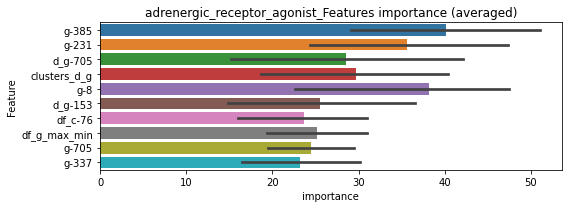

len(train_index) : 3640
len(valid_index) : 3640
================================= fold 1/2 adrenergic_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.020912	valid_1's binary_logloss: 0.0748734
Early stopping, best iteration is:
[185]	training's binary_logloss: 0.00610842	valid_1's binary_logloss: 0.066631


len(train_index) : 3640
len(valid_index) : 3640
================================= fold 2/2 adrenergic_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0211398	valid_1's binary_logloss: 0.082122
[200]	training's binary_logloss: 0.00478131	valid_1's binary_logloss: 0.0728177
Early stopping, best iteration is:
[190]	training's binary_logloss: 0.00548416	valid_1's binary_logloss: 0.0726154


adrenergic_receptor_agonist logloss: 0.06962319733035396


  acetylcholine_receptor_agonist acetylcholine_receptor_antagonist  \
0                       df_g-122                              c-30   
1                  clusters_df_c                         c_all_max   
2                          cnt_0                    clusters_g_all   
3                      c_all_min                          df_g-707   
4                        df_g-51                        clusters_g   
5                       df_c_min                          df_c_min   
6                          cnt_2                             g-514   
7                       df_g-736                          df_g-640   
8                          g-244                            df_c-6   
9                           c-73                          df_g-597   

  acetylcholinesterase_inhibitor adenosine_receptor_antagonist  \
0                      c_all_max                clusters_c_all   
1                      c_all_min                      df_c_min   
2                 clusters_g_al

adrenergic_receptor_antagonist, len(trt): 360, len(othr): 3229, target_rate: 0.0151172 → Adj_target_rate: 0.0125042


neg labels: 3289 → selected neg labels: 3229


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.134022	valid_1's binary_logloss: 0.344202
[200]	training's binary_logloss: 0.0554217	valid_1's binary_logloss: 0.328426
Early stopping, best iteration is:
[203]	training's binary_logloss: 0.0537763	valid_1's binary_logloss: 0.327984
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.139314	valid_1's binary_logloss: 0.34569
[200]	training's binary_logloss: 0.0555798	valid_1's binary_logloss: 0.323456
Early stopping, best iteration is:
[197]	training's binary_logloss: 0.0570198	valid_1's binary_logloss: 0.323018


1 / 3 AUC score:0.827
Threshold: 0.1209856, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 608 → positive_corect_labels: 406/3266
p_label_rate: 0.0713209 Vs.target_rate: 0.01512, Num_p_label: 284.0, conf_0:0.06675, conf_1:0.13308
Num_p_label: 284.0, Expected: 60.2, Adj_threshold_1: 0.1209856
Num_p_label: 244.0, Expected: 60.2, Adj_threshold_2: 0.1259856
Num_p_label: 202.0, Expected: 60.2, Adj_threshold_3: 0.1309856
Num_p_label: 168.0, Expected: 60.2, Adj_threshold_4: 0.1359856
Num_p_label: 144.0, Expected: 60.2, Adj_threshold_5: 0.1409856
Num_p_label: 120.0, Expected: 60.2, Adj_threshold_6: 0.1459856
threshold: 0.1459856, positive p_label: 120.0/3982, p_label_rate: 0.0301356
positive y_label: 406.0/3266, y_label_rate: 0.1243111
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.075917	valid_1's binary_logloss: 0.211864
[200]	training's binary_logloss: 0.0228059	valid_1's binary_logloss: 0.184312
Early stopping, best iteration is:
[235]	training's binary_logloss: 0.0155291	valid_1's binary_logloss: 0.181267
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0788866	valid_1's binary_logloss: 0.218878
[200]	training's binary_logloss: 0.0246515	valid_1's binary_logloss: 0.195578


2 / 3 AUC score:0.947
Threshold: 0.1459856, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 134 → positive_corect_labels: 282.0/3132


Early stopping, best iteration is:
[218]	training's binary_logloss: 0.0200478	valid_1's binary_logloss: 0.193356


p_label_rate: 0.0025113 Vs.target_rate: 0.01512, Num_p_label: 10.0, conf_0:0.02167, conf_1:0.16058
Num_p_label: 10.0, Expected: 60.2, Adj_threshold_1: 0.1459856
Num_p_label: 13.0, Expected: 60.2, Adj_threshold_2: 0.1409856
Num_p_label: 15.0, Expected: 60.2, Adj_threshold_3: 0.1359856
Num_p_label: 20.0, Expected: 60.2, Adj_threshold_4: 0.1309856
Num_p_label: 24.0, Expected: 60.2, Adj_threshold_5: 0.1259856
Num_p_label: 31.0, Expected: 60.2, Adj_threshold_6: 0.1209856
threshold: 0.1209856, positive p_label: 31.0/3982, p_label_rate: 0.0077850
positive y_label: 282.0/3132, y_label_rate: 0.0900383
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0431976	valid_1's binary_logloss: 0.16346
[200]	training's binary_logloss: 0.0120065	valid_1's binary_logloss: 0.148391
Early stopping, best iteration is:
[190]	training's binary_logloss: 0.0133505	valid_1's binary_logloss: 0.147733
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0449418	valid_1's binary_logloss: 0.161446


3 / 3 AUC score:0.975
Threshold: 0.1209856, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 87 → positive_corect_labels: 201.0/3045
p_label_rate: 0.0007534 Vs.target_rate: 0.01512, Num_p_label: 3.0, conf_0:0.01326, conf_1:0.13308
Num_p_label: 3.0, Expected: 60.2, Adj_threshold_1: 0.1209856
Num_p_label: 4.0, Expected: 60.2, Adj_threshold_2: 0.1159856
Num_p_label: 4.0, Expected: 60.2, Adj_threshold_3: 0.1109856
Num_p_label: 5.0, Expected: 60.2, Adj_threshold_4: 0.1059856


Early stopping, best iteration is:
[165]	training's binary_logloss: 0.0185124	valid_1's binary_logloss: 0.145232


Num_p_label: 6.0, Expected: 60.2, Adj_threshold_5: 0.1009856
Num_p_label: 7.0, Expected: 60.2, Adj_threshold_6: 0.0959856
Num_p_label: 10.0, Expected: 60.2, Adj_threshold_7: 0.0909856
Num_p_label: 13.0, Expected: 60.2, Adj_threshold_8: 0.0859856
Num_p_label: 17.0, Expected: 60.2, Adj_threshold_9: 0.0809856
Num_p_label: 23.0, Expected: 60.2, Adj_threshold_10: 0.0759856
threshold: 0.0709856, positive p_label: 29.0/3982, p_label_rate: 0.0072828
positive y_label: 230.0/7027, y_label_rate: 0.0327309


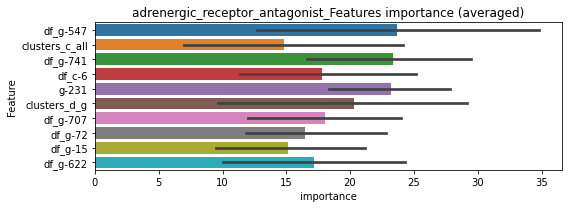

len(train_index) : 3513
len(valid_index) : 3514
================================= fold 1/2 adrenergic_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0149634	valid_1's binary_logloss: 0.0707009
Early stopping, best iteration is:
[130]	training's binary_logloss: 0.00944751	valid_1's binary_logloss: 0.0687603


len(train_index) : 3514
len(valid_index) : 3513
================================= fold 2/2 adrenergic_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0134565	valid_1's binary_logloss: 0.0757729


adrenergic_receptor_antagonist logloss: 0.07128467540240496


Early stopping, best iteration is:
[131]	training's binary_logloss: 0.00829795	valid_1's binary_logloss: 0.0738097
  acetylcholine_receptor_agonist acetylcholine_receptor_antagonist  \
0                       df_g-122                              c-30   
1                  clusters_df_c                         c_all_max   
2                          cnt_0                    clusters_g_all   
3                      c_all_min                          df_g-707   
4                        df_g-51                        clusters_g   
5                       df_c_min                          df_c_min   
6                          cnt_2                             g-514   
7                       df_g-736                          df_g-640   
8                          g-244                            df_c-6   
9                           c-73                          df_g-597   

  acetylcholinesterase_inhibitor adenosine_receptor_antagonist  \
0                      c_all_max                

akt_inhibitor, len(trt): 66, len(othr): 3278, target_rate: 0.0027715 → Adj_target_rate: 0.0029567


neg labels: 3289 → selected neg labels: 3278


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.040287	valid_1's binary_logloss: 0.0834895
[200]	training's binary_logloss: 0.00709231	valid_1's binary_logloss: 0.0396223
[300]	training's binary_logloss: 0.00204822	valid_1's binary_logloss: 0.030128
Early stopping, best iteration is:
[375]	training's binary_logloss: 0.00114347	valid_1's binary_logloss: 0.0279199
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0399737	valid_1's binary_logloss: 0.0743182
[200]	training's binary_logloss: 0.00718468	valid_1's binary_logloss: 0.0349959
[300]	training's binary_logloss: 0.00214372	valid_1's binary_logloss: 0.0256476
Early stopping, best iteration is:
[340]	training's binary_logloss: 0.00151151	valid_1's binary_logloss: 0.0237535


1 / 3 AUC score:0.999
Threshold: 0.0094822, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 138 → positive_corect_labels: 652/3795
p_label_rate: 0.0554997 Vs.target_rate: 0.00277, Num_p_label: 221.0, conf_0:0.00116, conf_1:0.01043
Num_p_label: 221.0, Expected: 11.0, Adj_threshold_1: 0.0094822
Num_p_label: 151.0, Expected: 11.0, Adj_threshold_2: 0.0144822
Num_p_label: 128.0, Expected: 11.0, Adj_threshold_3: 0.0194822
Num_p_label: 111.0, Expected: 11.0, Adj_threshold_4: 0.0244822
Num_p_label: 93.0, Expected: 11.0, Adj_threshold_5: 0.0294822
Num_p_label: 81.0, Expected: 11.0, Adj_threshold_6: 0.0344822
Num_p_label: 69.0, Expected: 11.0, Adj_threshold_7: 0.0394822
Num_p_label: 63.0, Expected: 11.0, Adj_threshold_8: 0.0444822
Num_p_label: 59.0, Expected: 11.0, Adj_threshold_9: 0.0494822
Num_p_label: 56.0, Expected: 11.0, Adj_threshold_10: 0.0544822
threshold: 0.0594822, positive p_label: 54.0/3982, p_label_rate: 0.0135610
positive y_label: 652.0/3795, y_label_rate: 0.1718050
=================

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0393542	valid_1's binary_logloss: 0.0720159
[200]	training's binary_logloss: 0.0066777	valid_1's binary_logloss: 0.0264072
[300]	training's binary_logloss: 0.00193555	valid_1's binary_logloss: 0.0151052
[400]	training's binary_logloss: 0.000944413	valid_1's binary_logloss: 0.0122795
Early stopping, best iteration is:
[486]	training's binary_logloss: 0.000642177	valid_1's binary_logloss: 0.011208
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0380508	valid_1's binary_logloss: 0.0749257
[200]	training's binary_logloss: 0.00634571	valid_1's binary_logloss: 0.0299671
[300]	training's binary_logloss: 0.0018755	valid_1's binary_logloss: 0.0192243
[400]	training's binary_logloss: 0.000915818	valid_1's binary_logloss: 0.0156258
Early stopping, best iteration is:
[423]	training's binary_logloss: 0.000815983	valid_1's binary_logloss: 0.015124


2 / 3 AUC score:1.000
Threshold: 0.0594822, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 14 → positive_corect_labels: 649.0/3781
p_label_rate: 0.0366650 Vs.target_rate: 0.00277, Num_p_label: 146.0, conf_0:0.00072, conf_1:0.06543
Num_p_label: 146.0, Expected: 11.0, Adj_threshold_1: 0.0594822
Num_p_label: 144.0, Expected: 11.0, Adj_threshold_2: 0.0644822
Num_p_label: 130.0, Expected: 11.0, Adj_threshold_3: 0.0694822
Num_p_label: 127.0, Expected: 11.0, Adj_threshold_4: 0.0744822
Num_p_label: 124.0, Expected: 11.0, Adj_threshold_5: 0.0794822
Num_p_label: 120.0, Expected: 11.0, Adj_threshold_6: 0.0844822
Num_p_label: 114.0, Expected: 11.0, Adj_threshold_7: 0.0894822
Num_p_label: 114.0, Expected: 11.0, Adj_threshold_8: 0.0944822
Num_p_label: 111.0, Expected: 11.0, Adj_threshold_9: 0.0994822
Num_p_label: 110.0, Expected: 11.0, Adj_threshold_10: 0.1044822
threshold: 0.1094822, positive p_label: 109.0/3982, p_label_rate: 0.0273732
positive y_label: 649.0/3781, y_label_rate: 0.1716477
=========

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0377072	valid_1's binary_logloss: 0.077913
[200]	training's binary_logloss: 0.00639216	valid_1's binary_logloss: 0.0382851
[300]	training's binary_logloss: 0.00188054	valid_1's binary_logloss: 0.0309696
Early stopping, best iteration is:
[337]	training's binary_logloss: 0.00137554	valid_1's binary_logloss: 0.0304477
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.037568	valid_1's binary_logloss: 0.0803304
[200]	training's binary_logloss: 0.00624237	valid_1's binary_logloss: 0.0357276
[300]	training's binary_logloss: 0.0018262	valid_1's binary_logloss: 0.0251884
Early stopping, best iteration is:
[346]	training's binary_logloss: 0.00125315	valid_1's binary_logloss: 0.0227118


3 / 3 AUC score:0.999
Threshold: 0.1094822, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 13 → positive_corect_labels: 637.0/3768
p_label_rate: 0.0386740 Vs.target_rate: 0.00277, Num_p_label: 154.0, conf_0:0.00122, conf_1:0.12043
Num_p_label: 154.0, Expected: 11.0, Adj_threshold_1: 0.1094822
Num_p_label: 151.0, Expected: 11.0, Adj_threshold_2: 0.1144822
Num_p_label: 148.0, Expected: 11.0, Adj_threshold_3: 0.1194822
Num_p_label: 144.0, Expected: 11.0, Adj_threshold_4: 0.1244822
Num_p_label: 140.0, Expected: 11.0, Adj_threshold_5: 0.1294822
Num_p_label: 140.0, Expected: 11.0, Adj_threshold_6: 0.1344822
Num_p_label: 138.0, Expected: 11.0, Adj_threshold_7: 0.1394822
Num_p_label: 137.0, Expected: 11.0, Adj_threshold_8: 0.1444822
Num_p_label: 134.0, Expected: 11.0, Adj_threshold_9: 0.1494822
Num_p_label: 130.0, Expected: 11.0, Adj_threshold_10: 0.1544822
threshold: 0.1594822, positive p_label: 125.0/3982, p_label_rate: 0.0313913
positive y_label: 762.0/7750, y_label_rate: 0.0983226


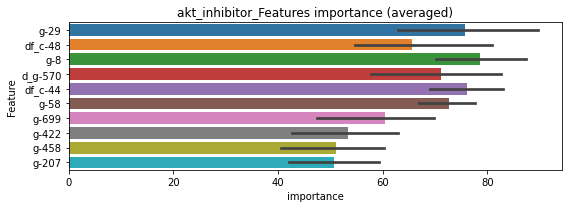

len(train_index) : 3875
len(valid_index) : 3875
================================= fold 1/2 akt_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0232573	valid_1's binary_logloss: 0.0549099
[200]	training's binary_logloss: 0.00405388	valid_1's binary_logloss: 0.0327889
Early stopping, best iteration is:
[264]	training's binary_logloss: 0.00173518	valid_1's binary_logloss: 0.0299536


len(train_index) : 3875
len(valid_index) : 3875
================================= fold 2/2 akt_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0248627	valid_1's binary_logloss: 0.049464
[200]	training's binary_logloss: 0.00465581	valid_1's binary_logloss: 0.0255135
[300]	training's binary_logloss: 0.00140366	valid_1's binary_logloss: 0.020601
Early stopping, best iteration is:
[369]	training's binary_logloss: 0.000803925	valid_1's binary_logloss: 0.0191027


akt_inhibitor logloss: 0.024528156567087237


  acetylcholine_receptor_agonist acetylcholine_receptor_antagonist  \
0                       df_g-122                              c-30   
1                  clusters_df_c                         c_all_max   
2                          cnt_0                    clusters_g_all   
3                      c_all_min                          df_g-707   
4                        df_g-51                        clusters_g   
5                       df_c_min                          df_c_min   
6                          cnt_2                             g-514   
7                       df_g-736                          df_g-640   
8                          g-244                            df_c-6   
9                           c-73                          df_g-597   

  acetylcholinesterase_inhibitor adenosine_receptor_antagonist  \
0                      c_all_max                clusters_c_all   
1                      c_all_min                      df_c_min   
2                 clusters_g_al

aldehyde_dehydrogenase_inhibitor, len(trt): 19, len(othr): 3286, target_rate: 0.0007979 → Adj_target_rate: 0.0010260


neg labels: 3289 → selected neg labels: 3286


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0246892	valid_1's binary_logloss: 0.0341267
[200]	training's binary_logloss: 0.00299245	valid_1's binary_logloss: 0.00622868
[300]	training's binary_logloss: 0.000835138	valid_1's binary_logloss: 0.00230306
[400]	training's binary_logloss: 0.000439049	valid_1's binary_logloss: 0.00147777
[500]	training's binary_logloss: 0.000344236	valid_1's binary_logloss: 0.00125756
Early stopping, best iteration is:
[507]	training's binary_logloss: 0.000341794	valid_1's binary_logloss: 0.00125722
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.024929	valid_1's binary_logloss: 0.0303489
[200]	training's binary_logloss: 0.00299772	valid_1's binary_logloss: 0.0050645
[300]	training's binary_logloss: 0.000841695	valid_1's binary_logloss: 0.00182876
[400]	training's binary_logloss: 0.000446393	valid_1's binary_logloss: 0.00110056
[500]	training's binary_logloss: 

1 / 3 AUC score:1.000
Threshold: 0.0016154, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → positive_corect_labels: 657/3811
p_label_rate: 0.0361627 Vs.target_rate: 0.00080, Num_p_label: 144.0, conf_0:0.00024, conf_1:0.00178
Num_p_label: 144.0, Expected: 3.2, Adj_threshold_1: 0.0016154
Num_p_label: 23.0, Expected: 3.2, Adj_threshold_2: 0.0066154
Num_p_label: 6.0, Expected: 3.2, Adj_threshold_3: 0.0116154
threshold: 0.0116154, positive p_label: 6.0/3982, p_label_rate: 0.0015068
positive y_label: 657.0/3811, y_label_rate: 0.1723957
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0239777	valid_1's binary_logloss: 0.0333912
[200]	training's binary_logloss: 0.0028244	valid_1's binary_logloss: 0.00569933
[300]	training's binary_logloss: 0.000796766	valid_1's binary_logloss: 0.0021914
[400]	training's binary_logloss: 0.000428842	valid_1's binary_logloss: 0.0014959
[500]	training's binary_logloss: 0.000342277	valid_1's binary_logloss: 0.00134615
Early stopping, best iteration is:
[504]	training's binary_logloss: 0.000340876	valid_1's binary_logloss: 0.00134441
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0245259	valid_1's binary_logloss: 0.028885
[200]	training's binary_logloss: 0.00291445	valid_1's binary_logloss: 0.00496663
[300]	training's binary_logloss: 0.000821894	valid_1's binary_logloss: 0.00204152
[400]	training's binary_logloss: 0.00043479	valid_1's binary_logloss: 0.00129716
[500]	training's binary_logloss: 0.0

2 / 3 AUC score:1.000
Threshold: 0.0116154, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → positive_corect_labels: 657.0/3811
p_label_rate: 0.0072828 Vs.target_rate: 0.00080, Num_p_label: 29.0, conf_0:0.00027, conf_1:0.01278
Num_p_label: 29.0, Expected: 3.2, Adj_threshold_1: 0.0116154
Num_p_label: 18.0, Expected: 3.2, Adj_threshold_2: 0.0166154
Num_p_label: 11.0, Expected: 3.2, Adj_threshold_3: 0.0216154
Num_p_label: 10.0, Expected: 3.2, Adj_threshold_4: 0.0266154
Num_p_label: 8.0, Expected: 3.2, Adj_threshold_5: 0.0316154
Num_p_label: 8.0, Expected: 3.2, Adj_threshold_6: 0.0366154
Num_p_label: 7.0, Expected: 3.2, Adj_threshold_7: 0.0416154
Num_p_label: 6.0, Expected: 3.2, Adj_threshold_8: 0.0466154
threshold: 0.0466154, positive p_label: 6.0/3982, p_label_rate: 0.0015068
positive y_label: 657.0/3811, y_label_rate: 0.1723957
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0239777	valid_1's binary_logloss: 0.0333912
[200]	training's binary_logloss: 0.0028244	valid_1's binary_logloss: 0.00569933
[300]	training's binary_logloss: 0.000796766	valid_1's binary_logloss: 0.0021914
[400]	training's binary_logloss: 0.000428842	valid_1's binary_logloss: 0.0014959
[500]	training's binary_logloss: 0.000342277	valid_1's binary_logloss: 0.00134615
Early stopping, best iteration is:
[504]	training's binary_logloss: 0.000340876	valid_1's binary_logloss: 0.00134441
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0245259	valid_1's binary_logloss: 0.028885
[200]	training's binary_logloss: 0.00291445	valid_1's binary_logloss: 0.00496663
[300]	training's binary_logloss: 0.000821894	valid_1's binary_logloss: 0.00204152
[400]	training's binary_logloss: 0.00043479	valid_1's binary_logloss: 0.00129716
[500]	training's binary_logloss: 0.0

3 / 3 AUC score:1.000
Threshold: 0.0466154, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → positive_corect_labels: 657.0/3811
p_label_rate: 0.0015068 Vs.target_rate: 0.00080, Num_p_label: 6.0, conf_0:0.00027, conf_1:0.05128
threshold: 0.0466154, positive p_label: 6.0/3982, p_label_rate: 0.0015068
positive y_label: 663.0/7793, y_label_rate: 0.0850764


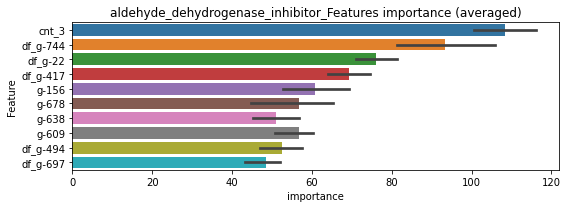

len(train_index) : 3896
len(valid_index) : 3897
================================= fold 1/2 aldehyde_dehydrogenase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0134283	valid_1's binary_logloss: 0.0209234
[200]	training's binary_logloss: 0.00156219	valid_1's binary_logloss: 0.00743594
Early stopping, best iteration is:
[272]	training's binary_logloss: 0.000557947	valid_1's binary_logloss: 0.00657836


len(train_index) : 3897
len(valid_index) : 3896
================================= fold 2/2 aldehyde_dehydrogenase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0136268	valid_1's binary_logloss: 0.0191055
[200]	training's binary_logloss: 0.00166617	valid_1's binary_logloss: 0.00395758
[300]	training's binary_logloss: 0.000456974	valid_1's binary_logloss: 0.0021442
[400]	training's binary_logloss: 0.000233641	valid_1's binary_logloss: 0.00185799
Early stopping, best iteration is:
[459]	training's binary_logloss: 0.000189684	valid_1's binary_logloss: 0.00181845


aldehyde_dehydrogenase_inhibitor logloss: 0.00419870815877007
alk_inhibitor, len(trt): 42, len(othr): 3282, target_rate: 0.0017637 → Adj_target_rate: 0.0020135


neg labels: 3289 → selected neg labels: 3282


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0342501	valid_1's binary_logloss: 0.0631653
[200]	training's binary_logloss: 0.00526169	valid_1's binary_logloss: 0.0241184
[300]	training's binary_logloss: 0.00152974	valid_1's binary_logloss: 0.0149057
[400]	training's binary_logloss: 0.000758837	valid_1's binary_logloss: 0.0123899
[500]	training's binary_logloss: 0.0005107	valid_1's binary_logloss: 0.0111555
Early stopping, best iteration is:
[499]	training's binary_logloss: 0.000511962	valid_1's binary_logloss: 0.0111467
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0349507	valid_1's binary_logloss: 0.0595588
[200]	training's binary_logloss: 0.0056434	valid_1's binary_logloss: 0.0199045
[300]	training's binary_logloss: 0.00164348	valid_1's binary_logloss: 0.0113739
[400]	training's binary_logloss: 0.000809299	valid_1's binary_logloss: 0.00885036
[500]	training's binary_logloss: 0.00054081

1 / 3 AUC score:1.000
Threshold: 0.0059869, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → positive_corect_labels: 656/3806
p_label_rate: 0.0534907 Vs.target_rate: 0.00176, Num_p_label: 213.0, conf_0:0.00040, conf_1:0.00659
Num_p_label: 213.0, Expected: 7.0, Adj_threshold_1: 0.0059869
Num_p_label: 133.0, Expected: 7.0, Adj_threshold_2: 0.0109869
Num_p_label: 89.0, Expected: 7.0, Adj_threshold_3: 0.0159869
Num_p_label: 69.0, Expected: 7.0, Adj_threshold_4: 0.0209869
Num_p_label: 54.0, Expected: 7.0, Adj_threshold_5: 0.0259869
Num_p_label: 48.0, Expected: 7.0, Adj_threshold_6: 0.0309869
Num_p_label: 40.0, Expected: 7.0, Adj_threshold_7: 0.0359869
Num_p_label: 36.0, Expected: 7.0, Adj_threshold_8: 0.0409869
Num_p_label: 35.0, Expected: 7.0, Adj_threshold_9: 0.0459869
Num_p_label: 34.0, Expected: 7.0, Adj_threshold_10: 0.0509869
threshold: 0.0559869, positive p_label: 34.0/3982, p_label_rate: 0.0085384
positive y_label: 656.0/3806, y_label_rate: 0.1723594
================= Pseudo labe

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0332672	valid_1's binary_logloss: 0.0587636
[200]	training's binary_logloss: 0.00483107	valid_1's binary_logloss: 0.0195295
[300]	training's binary_logloss: 0.00141359	valid_1's binary_logloss: 0.0113329
[400]	training's binary_logloss: 0.000705855	valid_1's binary_logloss: 0.00903144
Early stopping, best iteration is:
[482]	training's binary_logloss: 0.000506309	valid_1's binary_logloss: 0.00822816
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0333728	valid_1's binary_logloss: 0.0602001
[200]	training's binary_logloss: 0.00494287	valid_1's binary_logloss: 0.0198556
[300]	training's binary_logloss: 0.00141774	valid_1's binary_logloss: 0.0108374
[400]	training's binary_logloss: 0.000701094	valid_1's binary_logloss: 0.00808131
[500]	training's binary_logloss: 0.000483764	valid_1's binary_logloss: 0.00740336
Early stopping, best iteration is:
[4

2 / 3 AUC score:1.000
Threshold: 0.0559869, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 6 → positive_corect_labels: 656.0/3800
p_label_rate: 0.0286288 Vs.target_rate: 0.00176, Num_p_label: 114.0, conf_0:0.00044, conf_1:0.06159
Num_p_label: 114.0, Expected: 7.0, Adj_threshold_1: 0.0559869
Num_p_label: 108.0, Expected: 7.0, Adj_threshold_2: 0.0609869
Num_p_label: 105.0, Expected: 7.0, Adj_threshold_3: 0.0659869
Num_p_label: 100.0, Expected: 7.0, Adj_threshold_4: 0.0709869
Num_p_label: 94.0, Expected: 7.0, Adj_threshold_5: 0.0759869
Num_p_label: 89.0, Expected: 7.0, Adj_threshold_6: 0.0809869
Num_p_label: 83.0, Expected: 7.0, Adj_threshold_7: 0.0859869
Num_p_label: 83.0, Expected: 7.0, Adj_threshold_8: 0.0909869
Num_p_label: 78.0, Expected: 7.0, Adj_threshold_9: 0.0959869
Num_p_label: 74.0, Expected: 7.0, Adj_threshold_10: 0.1009869
threshold: 0.1059869, positive p_label: 71.0/3982, p_label_rate: 0.0178302
positive y_label: 656.0/3800, y_label_rate: 0.1726316
================= Pseudo la

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0334549	valid_1's binary_logloss: 0.0573038
[200]	training's binary_logloss: 0.00479245	valid_1's binary_logloss: 0.0185891
[300]	training's binary_logloss: 0.00139623	valid_1's binary_logloss: 0.0109656
[400]	training's binary_logloss: 0.000696956	valid_1's binary_logloss: 0.00827015
Early stopping, best iteration is:
[486]	training's binary_logloss: 0.000495734	valid_1's binary_logloss: 0.00746952
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0331998	valid_1's binary_logloss: 0.0588642
[200]	training's binary_logloss: 0.00492462	valid_1's binary_logloss: 0.0183522
[300]	training's binary_logloss: 0.00141242	valid_1's binary_logloss: 0.0102826
[400]	training's binary_logloss: 0.000700311	valid_1's binary_logloss: 0.00773225
[500]	training's binary_logloss: 0.000489736	valid_1's binary_logloss: 0.00689776
Early stopping, best iteration is:
[4

3 / 3 AUC score:1.000
Threshold: 0.1059869, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 3 → positive_corect_labels: 656.0/3797
p_label_rate: 0.0205927 Vs.target_rate: 0.00176, Num_p_label: 82.0, conf_0:0.00043, conf_1:0.11659
Num_p_label: 82.0, Expected: 7.0, Adj_threshold_1: 0.1059869
Num_p_label: 77.0, Expected: 7.0, Adj_threshold_2: 0.1109869
Num_p_label: 75.0, Expected: 7.0, Adj_threshold_3: 0.1159869
Num_p_label: 71.0, Expected: 7.0, Adj_threshold_4: 0.1209869
Num_p_label: 70.0, Expected: 7.0, Adj_threshold_5: 0.1259869
Num_p_label: 66.0, Expected: 7.0, Adj_threshold_6: 0.1309869
Num_p_label: 65.0, Expected: 7.0, Adj_threshold_7: 0.1359869
Num_p_label: 63.0, Expected: 7.0, Adj_threshold_8: 0.1409869
Num_p_label: 62.0, Expected: 7.0, Adj_threshold_9: 0.1459869
Num_p_label: 61.0, Expected: 7.0, Adj_threshold_10: 0.1509869
threshold: 0.1559869, positive p_label: 61.0/3982, p_label_rate: 0.0153189
positive y_label: 717.0/7779, y_label_rate: 0.0921712


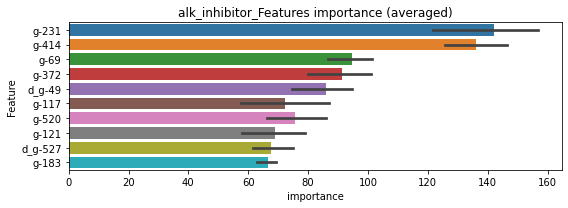

len(train_index) : 3889
len(valid_index) : 3890
================================= fold 1/2 alk_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0202492	valid_1's binary_logloss: 0.0411743
[200]	training's binary_logloss: 0.00323531	valid_1's binary_logloss: 0.0188939
[300]	training's binary_logloss: 0.000949066	valid_1's binary_logloss: 0.0149954
Early stopping, best iteration is:
[380]	training's binary_logloss: 0.000524532	valid_1's binary_logloss: 0.0140565


len(train_index) : 3890
len(valid_index) : 3889
================================= fold 2/2 alk_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0200218	valid_1's binary_logloss: 0.0411277
[200]	training's binary_logloss: 0.00321221	valid_1's binary_logloss: 0.0178235
[300]	training's binary_logloss: 0.000975566	valid_1's binary_logloss: 0.0127686
[400]	training's binary_logloss: 0.000481169	valid_1's binary_logloss: 0.0112754
[500]	training's binary_logloss: 0.000319367	valid_1's binary_logloss: 0.0106507
Early stopping, best iteration is:
[503]	training's binary_logloss: 0.000316443	valid_1's binary_logloss: 0.0106299


alk_inhibitor logloss: 0.012343397369009027
ampk_activator, len(trt): 12, len(othr): 3287, target_rate: 0.0005039 → Adj_target_rate: 0.0006942


neg labels: 3289 → selected neg labels: 3287


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0196912	valid_1's binary_logloss: 0.0247411
[200]	training's binary_logloss: 0.00210598	valid_1's binary_logloss: 0.00385512
[300]	training's binary_logloss: 0.000595833	valid_1's binary_logloss: 0.00137375
[400]	training's binary_logloss: 0.000336167	valid_1's binary_logloss: 0.000865573
[500]	training's binary_logloss: 0.000288713	valid_1's binary_logloss: 0.000766022
Early stopping, best iteration is:
[516]	training's binary_logloss: 0.000287457	valid_1's binary_logloss: 0.000763201
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0196445	valid_1's binary_logloss: 0.0239066
[200]	training's binary_logloss: 0.00209909	valid_1's binary_logloss: 0.00420343
[300]	training's binary_logloss: 0.00060408	valid_1's binary_logloss: 0.00207017
[400]	training's binary_logloss: 0.00034016	valid_1's binary_logloss: 0.00161073
Early stopping, best iteration

1 / 3 AUC score:1.000
Threshold: 0.0011594, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → positive_corect_labels: 657/3812
p_label_rate: 0.0394274 Vs.target_rate: 0.00050, Num_p_label: 157.0, conf_0:0.00018, conf_1:0.00128
Num_p_label: 157.0, Expected: 2.0, Adj_threshold_1: 0.0011594
Num_p_label: 16.0, Expected: 2.0, Adj_threshold_2: 0.0061594
Num_p_label: 5.0, Expected: 2.0, Adj_threshold_3: 0.0111594
Num_p_label: 3.0, Expected: 2.0, Adj_threshold_4: 0.0161594
threshold: 0.0161594, positive p_label: 3.0/3982, p_label_rate: 0.0007534
positive y_label: 657.0/3812, y_label_rate: 0.1723505
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.019216	valid_1's binary_logloss: 0.0219989
[200]	training's binary_logloss: 0.00198387	valid_1's binary_logloss: 0.00275354
[300]	training's binary_logloss: 0.000574848	valid_1's binary_logloss: 0.000881763
[400]	training's binary_logloss: 0.000328295	valid_1's binary_logloss: 0.000529951
[500]	training's binary_logloss: 0.000283183	valid_1's binary_logloss: 0.000465944
Early stopping, best iteration is:
[517]	training's binary_logloss: 0.000282415	valid_1's binary_logloss: 0.000464811
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.019403	valid_1's binary_logloss: 0.0224185
[200]	training's binary_logloss: 0.00197925	valid_1's binary_logloss: 0.00376067
[300]	training's binary_logloss: 0.000574656	valid_1's binary_logloss: 0.00204366
[400]	training's binary_logloss: 0.000331663	valid_1's binary_logloss: 0.00162271
Early stopping, best iteratio

2 / 3 AUC score:1.000
Threshold: 0.0161594, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → positive_corect_labels: 657.0/3812
p_label_rate: 0.0060271 Vs.target_rate: 0.00050, Num_p_label: 24.0, conf_0:0.00020, conf_1:0.01778
Num_p_label: 24.0, Expected: 2.0, Adj_threshold_1: 0.0161594
Num_p_label: 18.0, Expected: 2.0, Adj_threshold_2: 0.0211594
Num_p_label: 9.0, Expected: 2.0, Adj_threshold_3: 0.0261594
Num_p_label: 8.0, Expected: 2.0, Adj_threshold_4: 0.0311594
Num_p_label: 6.0, Expected: 2.0, Adj_threshold_5: 0.0361594
Num_p_label: 5.0, Expected: 2.0, Adj_threshold_6: 0.0411594
Num_p_label: 5.0, Expected: 2.0, Adj_threshold_7: 0.0461594
Num_p_label: 5.0, Expected: 2.0, Adj_threshold_8: 0.0511594
Num_p_label: 5.0, Expected: 2.0, Adj_threshold_9: 0.0561594
Num_p_label: 5.0, Expected: 2.0, Adj_threshold_10: 0.0611594
threshold: 0.0661594, positive p_label: 4.0/3982, p_label_rate: 0.0010045
positive y_label: 657.0/3812, y_label_rate: 0.1723505
================= Pseudo labeling 3 / 3 =

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.019216	valid_1's binary_logloss: 0.0219989
[200]	training's binary_logloss: 0.00198387	valid_1's binary_logloss: 0.00275354
[300]	training's binary_logloss: 0.000574848	valid_1's binary_logloss: 0.000881763
[400]	training's binary_logloss: 0.000328295	valid_1's binary_logloss: 0.000529951
[500]	training's binary_logloss: 0.000283183	valid_1's binary_logloss: 0.000465944
Early stopping, best iteration is:
[517]	training's binary_logloss: 0.000282415	valid_1's binary_logloss: 0.000464811
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.019403	valid_1's binary_logloss: 0.0224185
[200]	training's binary_logloss: 0.00197925	valid_1's binary_logloss: 0.00376067
[300]	training's binary_logloss: 0.000574656	valid_1's binary_logloss: 0.00204366
[400]	training's binary_logloss: 0.000331663	valid_1's binary_logloss: 0.00162271
Early stopping, best iteratio

3 / 3 AUC score:1.000
Threshold: 0.0661594, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → positive_corect_labels: 657.0/3812
p_label_rate: 0.0010045 Vs.target_rate: 0.00050, Num_p_label: 4.0, conf_0:0.00020, conf_1:0.07278
threshold: 0.0661594, positive p_label: 4.0/3982, p_label_rate: 0.0010045
positive y_label: 661.0/7794, y_label_rate: 0.0848088


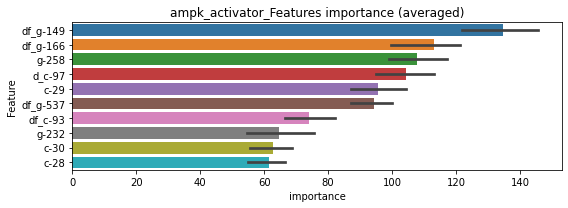

len(train_index) : 3897
len(valid_index) : 3897
================================= fold 1/2 ampk_activator=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0106876	valid_1's binary_logloss: 0.0155126
[200]	training's binary_logloss: 0.00107985	valid_1's binary_logloss: 0.00498314
[300]	training's binary_logloss: 0.00029849	valid_1's binary_logloss: 0.00412955
Early stopping, best iteration is:
[331]	training's binary_logloss: 0.00023644	valid_1's binary_logloss: 0.00409502


len(train_index) : 3897
len(valid_index) : 3897
================================= fold 2/2 ampk_activator=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0107148	valid_1's binary_logloss: 0.0134211
[200]	training's binary_logloss: 0.0011283	valid_1's binary_logloss: 0.00237244
[300]	training's binary_logloss: 0.000318637	valid_1's binary_logloss: 0.00121049
Early stopping, best iteration is:
[364]	training's binary_logloss: 0.000205235	valid_1's binary_logloss: 0.00105409


ampk_activator logloss: 0.0025745580610978163
analgesic, len(trt): 12, len(othr): 3287, target_rate: 0.0005039 → Adj_target_rate: 0.0006942


neg labels: 3289 → selected neg labels: 3287


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0192187	valid_1's binary_logloss: 0.0264907
[200]	training's binary_logloss: 0.00196808	valid_1's binary_logloss: 0.00520128
[300]	training's binary_logloss: 0.000562893	valid_1's binary_logloss: 0.00268011
[400]	training's binary_logloss: 0.000318946	valid_1's binary_logloss: 0.00194121
Early stopping, best iteration is:
[458]	training's binary_logloss: 0.000281953	valid_1's binary_logloss: 0.00185149
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0192205	valid_1's binary_logloss: 0.0214679
[200]	training's binary_logloss: 0.00200706	valid_1's binary_logloss: 0.00266552
[300]	training's binary_logloss: 0.000567609	valid_1's binary_logloss: 0.000891818
[400]	training's binary_logloss: 0.000322669	valid_1's binary_logloss: 0.000547093
[500]	training's binary_logloss: 0.00028105	valid_1's binary_logloss: 0.000480614
Early stopping, best iteratio

1 / 3 AUC score:1.000
Threshold: 0.0010973, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → positive_corect_labels: 657/3812
p_label_rate: 0.0371673 Vs.target_rate: 0.00050, Num_p_label: 148.0, conf_0:0.00017, conf_1:0.00121
Num_p_label: 148.0, Expected: 2.0, Adj_threshold_1: 0.0010973
Num_p_label: 15.0, Expected: 2.0, Adj_threshold_2: 0.0060973
Num_p_label: 7.0, Expected: 2.0, Adj_threshold_3: 0.0110973
Num_p_label: 4.0, Expected: 2.0, Adj_threshold_4: 0.0160973
threshold: 0.0160973, positive p_label: 4.0/3982, p_label_rate: 0.0010045
positive y_label: 657.0/3812, y_label_rate: 0.1723505
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0190068	valid_1's binary_logloss: 0.025992
[200]	training's binary_logloss: 0.00190298	valid_1's binary_logloss: 0.00430874
[300]	training's binary_logloss: 0.000544313	valid_1's binary_logloss: 0.00187894
[400]	training's binary_logloss: 0.000316215	valid_1's binary_logloss: 0.0013013
[500]	training's binary_logloss: 0.000270267	valid_1's binary_logloss: 0.00119783
Early stopping, best iteration is:
[495]	training's binary_logloss: 0.000270306	valid_1's binary_logloss: 0.00119768
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0192199	valid_1's binary_logloss: 0.021178
[200]	training's binary_logloss: 0.00191771	valid_1's binary_logloss: 0.00234031
[300]	training's binary_logloss: 0.000546828	valid_1's binary_logloss: 0.000723532
[400]	training's binary_logloss: 0.000310667	valid_1's binary_logloss: 0.000429905
[500]	training's binary_logloss:

2 / 3 AUC score:1.000
Threshold: 0.0160973, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → positive_corect_labels: 657.0/3812
p_label_rate: 0.0032647 Vs.target_rate: 0.00050, Num_p_label: 13.0, conf_0:0.00018, conf_1:0.01771
Num_p_label: 13.0, Expected: 2.0, Adj_threshold_1: 0.0160973
Num_p_label: 10.0, Expected: 2.0, Adj_threshold_2: 0.0210973
Num_p_label: 7.0, Expected: 2.0, Adj_threshold_3: 0.0260973
Num_p_label: 7.0, Expected: 2.0, Adj_threshold_4: 0.0310973
Num_p_label: 6.0, Expected: 2.0, Adj_threshold_5: 0.0360973
Num_p_label: 5.0, Expected: 2.0, Adj_threshold_6: 0.0410973
Num_p_label: 5.0, Expected: 2.0, Adj_threshold_7: 0.0460973
Num_p_label: 5.0, Expected: 2.0, Adj_threshold_8: 0.0510973
Num_p_label: 4.0, Expected: 2.0, Adj_threshold_9: 0.0560973
threshold: 0.0560973, positive p_label: 4.0/3982, p_label_rate: 0.0010045
positive y_label: 657.0/3812, y_label_rate: 0.1723505
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0190068	valid_1's binary_logloss: 0.025992
[200]	training's binary_logloss: 0.00190298	valid_1's binary_logloss: 0.00430874
[300]	training's binary_logloss: 0.000544313	valid_1's binary_logloss: 0.00187894
[400]	training's binary_logloss: 0.000316215	valid_1's binary_logloss: 0.0013013
[500]	training's binary_logloss: 0.000270267	valid_1's binary_logloss: 0.00119783
Early stopping, best iteration is:
[495]	training's binary_logloss: 0.000270306	valid_1's binary_logloss: 0.00119768
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0192199	valid_1's binary_logloss: 0.021178
[200]	training's binary_logloss: 0.00191771	valid_1's binary_logloss: 0.00234031
[300]	training's binary_logloss: 0.000546828	valid_1's binary_logloss: 0.000723532
[400]	training's binary_logloss: 0.000310667	valid_1's binary_logloss: 0.000429905
[500]	training's binary_logloss:

3 / 3 AUC score:1.000
Threshold: 0.0560973, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → positive_corect_labels: 657.0/3812
p_label_rate: 0.0010045 Vs.target_rate: 0.00050, Num_p_label: 4.0, conf_0:0.00018, conf_1:0.06171
threshold: 0.0560973, positive p_label: 4.0/3982, p_label_rate: 0.0010045
positive y_label: 661.0/7794, y_label_rate: 0.0848088


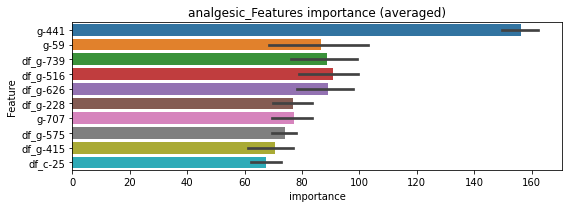

len(train_index) : 3897
len(valid_index) : 3897
================================= fold 1/2 analgesic=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0100903	valid_1's binary_logloss: 0.0158059
[200]	training's binary_logloss: 0.000997118	valid_1's binary_logloss: 0.00446713
[300]	training's binary_logloss: 0.00027744	valid_1's binary_logloss: 0.00391873
Early stopping, best iteration is:
[292]	training's binary_logloss: 0.000296973	valid_1's binary_logloss: 0.00390099


len(train_index) : 3897
len(valid_index) : 3897
================================= fold 2/2 analgesic=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0103269	valid_1's binary_logloss: 0.0161702
[200]	training's binary_logloss: 0.00102459	valid_1's binary_logloss: 0.00628363
[300]	training's binary_logloss: 0.000294344	valid_1's binary_logloss: 0.00536201
[400]	training's binary_logloss: 0.000163711	valid_1's binary_logloss: 0.00506631
Early stopping, best iteration is:
[409]	training's binary_logloss: 0.000158699	valid_1's binary_logloss: 0.00503876


analgesic logloss: 0.004469875635109171
androgen_receptor_agonist, len(trt): 48, len(othr): 3281, target_rate: 0.0020156 → Adj_target_rate: 0.0022556


neg labels: 3289 → selected neg labels: 3281


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0410589	valid_1's binary_logloss: 0.0833126
[200]	training's binary_logloss: 0.00754346	valid_1's binary_logloss: 0.0386773
[300]	training's binary_logloss: 0.00215122	valid_1's binary_logloss: 0.0267389
[400]	training's binary_logloss: 0.00101677	valid_1's binary_logloss: 0.0233742
Early stopping, best iteration is:
[425]	training's binary_logloss: 0.000890579	valid_1's binary_logloss: 0.0227841
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0454075	valid_1's binary_logloss: 0.069956
[200]	training's binary_logloss: 0.00847318	valid_1's binary_logloss: 0.0233971
[300]	training's binary_logloss: 0.00244588	valid_1's binary_logloss: 0.0118628
[400]	training's binary_logloss: 0.00115358	valid_1's binary_logloss: 0.00898723
[500]	training's binary_logloss: 0.000724986	valid_1's binary_logloss: 0.00752202
[600]	training's binary_logloss: 0.0005612

1 / 3 AUC score:1.000
Threshold: 0.0056047, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → positive_corect_labels: 656/3805
p_label_rate: 0.0399297 Vs.target_rate: 0.00202, Num_p_label: 159.0, conf_0:0.00070, conf_1:0.00617
Num_p_label: 159.0, Expected: 8.0, Adj_threshold_1: 0.0056047
Num_p_label: 65.0, Expected: 8.0, Adj_threshold_2: 0.0106047
Num_p_label: 36.0, Expected: 8.0, Adj_threshold_3: 0.0156047
Num_p_label: 21.0, Expected: 8.0, Adj_threshold_4: 0.0206047
Num_p_label: 18.0, Expected: 8.0, Adj_threshold_5: 0.0256047
Num_p_label: 12.0, Expected: 8.0, Adj_threshold_6: 0.0306047
threshold: 0.0306047, positive p_label: 12.0/3982, p_label_rate: 0.0030136
positive y_label: 656.0/3805, y_label_rate: 0.1724047
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0409569	valid_1's binary_logloss: 0.0821954
[200]	training's binary_logloss: 0.00736379	valid_1's binary_logloss: 0.0375042
[300]	training's binary_logloss: 0.00212859	valid_1's binary_logloss: 0.0260337
[400]	training's binary_logloss: 0.00101577	valid_1's binary_logloss: 0.0227347
Early stopping, best iteration is:
[475]	training's binary_logloss: 0.00071326	valid_1's binary_logloss: 0.0211556
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0440024	valid_1's binary_logloss: 0.0683839
[200]	training's binary_logloss: 0.00799142	valid_1's binary_logloss: 0.0217414
[300]	training's binary_logloss: 0.00230844	valid_1's binary_logloss: 0.0108349
[400]	training's binary_logloss: 0.00109049	valid_1's binary_logloss: 0.00766053
Early stopping, best iteration is:
[488]	training's binary_logloss: 0.000723401	valid_1's binary_logloss: 0.00636617


2 / 3 AUC score:1.000
Threshold: 0.0306047, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 4 → positive_corect_labels: 656.0/3801
p_label_rate: 0.0087896 Vs.target_rate: 0.00202, Num_p_label: 35.0, conf_0:0.00081, conf_1:0.03367
Num_p_label: 35.0, Expected: 8.0, Adj_threshold_1: 0.0306047
Num_p_label: 27.0, Expected: 8.0, Adj_threshold_2: 0.0356047
Num_p_label: 22.0, Expected: 8.0, Adj_threshold_3: 0.0406047
Num_p_label: 18.0, Expected: 8.0, Adj_threshold_4: 0.0456047
Num_p_label: 17.0, Expected: 8.0, Adj_threshold_5: 0.0506047
Num_p_label: 15.0, Expected: 8.0, Adj_threshold_6: 0.0556047
threshold: 0.0556047, positive p_label: 15.0/3982, p_label_rate: 0.0037670
positive y_label: 656.0/3801, y_label_rate: 0.1725862
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0409451	valid_1's binary_logloss: 0.0819614
[200]	training's binary_logloss: 0.00742381	valid_1's binary_logloss: 0.0390951
[300]	training's binary_logloss: 0.0021559	valid_1's binary_logloss: 0.027674
[400]	training's binary_logloss: 0.00102611	valid_1's binary_logloss: 0.0248947
Early stopping, best iteration is:
[392]	training's binary_logloss: 0.00107136	valid_1's binary_logloss: 0.0247915
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0445377	valid_1's binary_logloss: 0.0680875
[200]	training's binary_logloss: 0.00789852	valid_1's binary_logloss: 0.0213289
[300]	training's binary_logloss: 0.00230055	valid_1's binary_logloss: 0.0105848
[400]	training's binary_logloss: 0.0010896	valid_1's binary_logloss: 0.00752388
[500]	training's binary_logloss: 0.000701224	valid_1's binary_logloss: 0.00633879
[600]	training's binary_logloss: 0.000549108	

3 / 3 AUC score:1.000
Threshold: 0.0556047, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 3 → positive_corect_labels: 653.0/3798
p_label_rate: 0.0042692 Vs.target_rate: 0.00202, Num_p_label: 17.0, conf_0:0.00085, conf_1:0.06117
threshold: 0.0556047, positive p_label: 17.0/3982, p_label_rate: 0.0042692
positive y_label: 670.0/7780, y_label_rate: 0.0861183


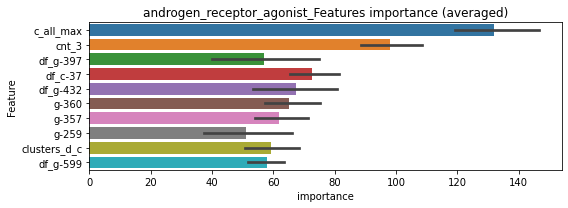

len(train_index) : 3890
len(valid_index) : 3890
================================= fold 1/2 androgen_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0238049	valid_1's binary_logloss: 0.0476302
[200]	training's binary_logloss: 0.00407847	valid_1's binary_logloss: 0.0253314
[300]	training's binary_logloss: 0.00114004	valid_1's binary_logloss: 0.0214655
Early stopping, best iteration is:
[360]	training's binary_logloss: 0.000695282	valid_1's binary_logloss: 0.0207594


len(train_index) : 3890
len(valid_index) : 3890
================================= fold 2/2 androgen_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0249576	valid_1's binary_logloss: 0.0485472
[200]	training's binary_logloss: 0.00454355	valid_1's binary_logloss: 0.0221075
[300]	training's binary_logloss: 0.00129759	valid_1's binary_logloss: 0.0162204
Early stopping, best iteration is:
[377]	training's binary_logloss: 0.000689375	valid_1's binary_logloss: 0.0147186


androgen_receptor_agonist logloss: 0.017738986861493847
androgen_receptor_antagonist, len(trt): 89, len(othr): 3274, target_rate: 0.0037373 → Adj_target_rate: 0.0038122


neg labels: 3289 → selected neg labels: 3274


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0587983	valid_1's binary_logloss: 0.125418
[200]	training's binary_logloss: 0.0144907	valid_1's binary_logloss: 0.084052
[300]	training's binary_logloss: 0.00452171	valid_1's binary_logloss: 0.0733293
Early stopping, best iteration is:
[300]	training's binary_logloss: 0.00452171	valid_1's binary_logloss: 0.0733293
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0694081	valid_1's binary_logloss: 0.122908
[200]	training's binary_logloss: 0.0176668	valid_1's binary_logloss: 0.0664073
[300]	training's binary_logloss: 0.00539449	valid_1's binary_logloss: 0.0483326
Early stopping, best iteration is:
[385]	training's binary_logloss: 0.0025869	valid_1's binary_logloss: 0.0439063


1 / 3 AUC score:0.994
Threshold: 0.0203003, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 154 → positive_corect_labels: 643/3774
p_label_rate: 0.0429432 Vs.target_rate: 0.00374, Num_p_label: 171.0, conf_0:0.00443, conf_1:0.02233
Num_p_label: 171.0, Expected: 14.9, Adj_threshold_1: 0.0203003
Num_p_label: 115.0, Expected: 14.9, Adj_threshold_2: 0.0253003
Num_p_label: 71.0, Expected: 14.9, Adj_threshold_3: 0.0303003
Num_p_label: 45.0, Expected: 14.9, Adj_threshold_4: 0.0353003
Num_p_label: 32.0, Expected: 14.9, Adj_threshold_5: 0.0403003
Num_p_label: 27.0, Expected: 14.9, Adj_threshold_6: 0.0453003
threshold: 0.0453003, positive p_label: 27.0/3982, p_label_rate: 0.0067805
positive y_label: 643.0/3774, y_label_rate: 0.1703763
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0576752	valid_1's binary_logloss: 0.126409
[200]	training's binary_logloss: 0.0137131	valid_1's binary_logloss: 0.0773879
[300]	training's binary_logloss: 0.00414006	valid_1's binary_logloss: 0.0632134
Early stopping, best iteration is:
[355]	training's binary_logloss: 0.0025568	valid_1's binary_logloss: 0.0597002
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0627818	valid_1's binary_logloss: 0.125709
[200]	training's binary_logloss: 0.0147282	valid_1's binary_logloss: 0.0710188
[300]	training's binary_logloss: 0.00466492	valid_1's binary_logloss: 0.0552818
Early stopping, best iteration is:
[354]	training's binary_logloss: 0.00288971	valid_1's binary_logloss: 0.0518319


2 / 3 AUC score:0.996
Threshold: 0.0453003, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 33 → positive_corect_labels: 628.0/3741
p_label_rate: 0.0090407 Vs.target_rate: 0.00374, Num_p_label: 36.0, conf_0:0.00382, conf_1:0.04983
threshold: 0.0453003, positive p_label: 36.0/3982, p_label_rate: 0.0090407
positive y_label: 628.0/3741, y_label_rate: 0.1678696
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0589179	valid_1's binary_logloss: 0.113375
[200]	training's binary_logloss: 0.0135397	valid_1's binary_logloss: 0.0620851
[300]	training's binary_logloss: 0.00403514	valid_1's binary_logloss: 0.0468682
[400]	training's binary_logloss: 0.00183377	valid_1's binary_logloss: 0.0413377
Early stopping, best iteration is:
[488]	training's binary_logloss: 0.00117452	valid_1's binary_logloss: 0.0392452
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0584914	valid_1's binary_logloss: 0.110812
[200]	training's binary_logloss: 0.0144302	valid_1's binary_logloss: 0.0646952
[300]	training's binary_logloss: 0.00441216	valid_1's binary_logloss: 0.052834
Early stopping, best iteration is:
[359]	training's binary_logloss: 0.00265793	valid_1's binary_logloss: 0.0509065


3 / 3 AUC score:0.999
Threshold: 0.0453003, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 16 → positive_corect_labels: 616.0/3725
p_label_rate: 0.0057760 Vs.target_rate: 0.00374, Num_p_label: 23.0, conf_0:0.00276, conf_1:0.04983
threshold: 0.0453003, positive p_label: 23.0/3982, p_label_rate: 0.0057760
positive y_label: 639.0/7707, y_label_rate: 0.0829116


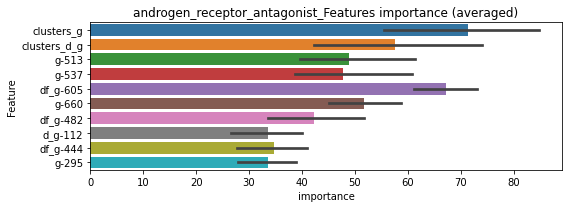

len(train_index) : 3853
len(valid_index) : 3854
================================= fold 1/2 androgen_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0321114	valid_1's binary_logloss: 0.0749002
[200]	training's binary_logloss: 0.00745383	valid_1's binary_logloss: 0.0501126
[300]	training's binary_logloss: 0.00229402	valid_1's binary_logloss: 0.0459393
Early stopping, best iteration is:
[292]	training's binary_logloss: 0.00248941	valid_1's binary_logloss: 0.0458578


len(train_index) : 3854
len(valid_index) : 3853
================================= fold 2/2 androgen_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0328145	valid_1's binary_logloss: 0.0765745
[200]	training's binary_logloss: 0.00741833	valid_1's binary_logloss: 0.0527099
Early stopping, best iteration is:
[227]	training's binary_logloss: 0.00514551	valid_1's binary_logloss: 0.0511407


androgen_receptor_antagonist logloss: 0.048498910834806


  acetylcholine_receptor_agonist acetylcholine_receptor_antagonist  \
0                       df_g-122                              c-30   
1                  clusters_df_c                         c_all_max   
2                          cnt_0                    clusters_g_all   
3                      c_all_min                          df_g-707   
4                        df_g-51                        clusters_g   
5                       df_c_min                          df_c_min   
6                          cnt_2                             g-514   
7                       df_g-736                          df_g-640   
8                          g-244                            df_c-6   
9                           c-73                          df_g-597   

  acetylcholinesterase_inhibitor adenosine_receptor_antagonist  \
0                      c_all_max                clusters_c_all   
1                      c_all_min                      df_c_min   
2                 clusters_g_al

anesthetic_-_local, len(trt): 80, len(othr): 3276, target_rate: 0.0033594 → Adj_target_rate: 0.0034820


neg labels: 3289 → selected neg labels: 3276


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0577357	valid_1's binary_logloss: 0.12251
[200]	training's binary_logloss: 0.0129413	valid_1's binary_logloss: 0.0759789
[300]	training's binary_logloss: 0.00379559	valid_1's binary_logloss: 0.0628904
[400]	training's binary_logloss: 0.00169412	valid_1's binary_logloss: 0.0590288
Early stopping, best iteration is:
[420]	training's binary_logloss: 0.00150805	valid_1's binary_logloss: 0.0583228
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0591054	valid_1's binary_logloss: 0.12313
[200]	training's binary_logloss: 0.0142711	valid_1's binary_logloss: 0.0765588
[300]	training's binary_logloss: 0.00427444	valid_1's binary_logloss: 0.0623953
[400]	training's binary_logloss: 0.00189476	valid_1's binary_logloss: 0.0599007
Early stopping, best iteration is:
[394]	training's binary_logloss: 0.0019697	valid_1's binary_logloss: 0.0597061


1 / 3 AUC score:0.995
Threshold: 0.0133854, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 154 → positive_corect_labels: 644/3777
p_label_rate: 0.0331492 Vs.target_rate: 0.00336, Num_p_label: 132.0, conf_0:0.00211, conf_1:0.01472
Num_p_label: 132.0, Expected: 13.4, Adj_threshold_1: 0.0133854
Num_p_label: 76.0, Expected: 13.4, Adj_threshold_2: 0.0183854
Num_p_label: 40.0, Expected: 13.4, Adj_threshold_3: 0.0233854
Num_p_label: 18.0, Expected: 13.4, Adj_threshold_4: 0.0283854
threshold: 0.0283854, positive p_label: 18.0/3982, p_label_rate: 0.0045203
positive y_label: 644.0/3777, y_label_rate: 0.1705057
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0603762	valid_1's binary_logloss: 0.10344
[200]	training's binary_logloss: 0.0136307	valid_1's binary_logloss: 0.0488954
[300]	training's binary_logloss: 0.00399709	valid_1's binary_logloss: 0.0323704
[400]	training's binary_logloss: 0.00179881	valid_1's binary_logloss: 0.0266924
Early stopping, best iteration is:
[489]	training's binary_logloss: 0.00114369	valid_1's binary_logloss: 0.0246181
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0571626	valid_1's binary_logloss: 0.114095
[200]	training's binary_logloss: 0.012412	valid_1's binary_logloss: 0.0612963
[300]	training's binary_logloss: 0.00378011	valid_1's binary_logloss: 0.0479077
[400]	training's binary_logloss: 0.00172587	valid_1's binary_logloss: 0.0444309
Early stopping, best iteration is:
[460]	training's binary_logloss: 0.00124678	valid_1's binary_logloss: 0.0430432


2 / 3 AUC score:1.000
Threshold: 0.0283854, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 16 → positive_corect_labels: 640.0/3761
p_label_rate: 0.0085384 Vs.target_rate: 0.00336, Num_p_label: 34.0, conf_0:0.00166, conf_1:0.03122
threshold: 0.0283854, positive p_label: 34.0/3982, p_label_rate: 0.0085384
positive y_label: 640.0/3761, y_label_rate: 0.1701675
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0594112	valid_1's binary_logloss: 0.113872
[200]	training's binary_logloss: 0.0132923	valid_1's binary_logloss: 0.059638
[300]	training's binary_logloss: 0.0040047	valid_1's binary_logloss: 0.0450973
[400]	training's binary_logloss: 0.00180123	valid_1's binary_logloss: 0.0405131
Early stopping, best iteration is:
[428]	training's binary_logloss: 0.00152164	valid_1's binary_logloss: 0.0397263
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0552835	valid_1's binary_logloss: 0.104094
[200]	training's binary_logloss: 0.0124458	valid_1's binary_logloss: 0.0539281
[300]	training's binary_logloss: 0.00372047	valid_1's binary_logloss: 0.0405425
[400]	training's binary_logloss: 0.00169457	valid_1's binary_logloss: 0.0373458
Early stopping, best iteration is:
[445]	training's binary_logloss: 0.00131979	valid_1's binary_logloss: 0.0358564


3 / 3 AUC score:0.999
Threshold: 0.0283854, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 31 → positive_corect_labels: 633.0/3730
p_label_rate: 0.0110497 Vs.target_rate: 0.00336, Num_p_label: 44.0, conf_0:0.00200, conf_1:0.03122
Num_p_label: 44.0, Expected: 13.4, Adj_threshold_1: 0.0283854
Num_p_label: 33.0, Expected: 13.4, Adj_threshold_2: 0.0333854
Num_p_label: 24.0, Expected: 13.4, Adj_threshold_3: 0.0383854
threshold: 0.0383854, positive p_label: 24.0/3982, p_label_rate: 0.0060271
positive y_label: 657.0/7712, y_label_rate: 0.0851919


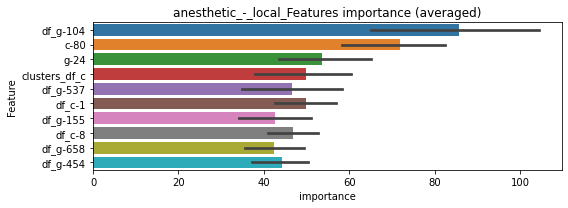

len(train_index) : 3856
len(valid_index) : 3856
================================= fold 1/2 anesthetic_-_local=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0326893	valid_1's binary_logloss: 0.0745055
[200]	training's binary_logloss: 0.00728281	valid_1's binary_logloss: 0.0498393
[300]	training's binary_logloss: 0.00218174	valid_1's binary_logloss: 0.0451318
Early stopping, best iteration is:
[378]	training's binary_logloss: 0.00107666	valid_1's binary_logloss: 0.044077


len(train_index) : 3856
len(valid_index) : 3856
================================= fold 2/2 anesthetic_-_local=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0356886	valid_1's binary_logloss: 0.0681217
[200]	training's binary_logloss: 0.00839995	valid_1's binary_logloss: 0.0392829
[300]	training's binary_logloss: 0.00246291	valid_1's binary_logloss: 0.031675
Early stopping, best iteration is:
[357]	training's binary_logloss: 0.00144577	valid_1's binary_logloss: 0.0300796


anesthetic_-_local logloss: 0.03707827905251777


  acetylcholine_receptor_agonist acetylcholine_receptor_antagonist  \
0                       df_g-122                              c-30   
1                  clusters_df_c                         c_all_max   
2                          cnt_0                    clusters_g_all   
3                      c_all_min                          df_g-707   
4                        df_g-51                        clusters_g   
5                       df_c_min                          df_c_min   
6                          cnt_2                             g-514   
7                       df_g-736                          df_g-640   
8                          g-244                            df_c-6   
9                           c-73                          df_g-597   

  acetylcholinesterase_inhibitor adenosine_receptor_antagonist  \
0                      c_all_max                clusters_c_all   
1                      c_all_min                      df_c_min   
2                 clusters_g_al

angiogenesis_inhibitor, len(trt): 36, len(othr): 3283, target_rate: 0.0015117 → Adj_target_rate: 0.0017663


neg labels: 3289 → selected neg labels: 3283


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0416529	valid_1's binary_logloss: 0.0656575
[200]	training's binary_logloss: 0.00693489	valid_1's binary_logloss: 0.0210228
[300]	training's binary_logloss: 0.00186245	valid_1's binary_logloss: 0.010012
[400]	training's binary_logloss: 0.000868027	valid_1's binary_logloss: 0.00674389
[500]	training's binary_logloss: 0.000571157	valid_1's binary_logloss: 0.005794
[600]	training's binary_logloss: 0.000478097	valid_1's binary_logloss: 0.00540484
Early stopping, best iteration is:
[618]	training's binary_logloss: 0.000473472	valid_1's binary_logloss: 0.00538393
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0432712	valid_1's binary_logloss: 0.0657591
[200]	training's binary_logloss: 0.0074371	valid_1's binary_logloss: 0.0191578
[300]	training's binary_logloss: 0.00195847	valid_1's binary_logloss: 0.00955207
[400]	training's binary_logloss: 0.00091

1 / 3 AUC score:1.000
Threshold: 0.0039846, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → positive_corect_labels: 656/3807
p_label_rate: 0.0356605 Vs.target_rate: 0.00151, Num_p_label: 142.0, conf_0:0.00044, conf_1:0.00438
Num_p_label: 142.0, Expected: 6.0, Adj_threshold_1: 0.0039846
Num_p_label: 47.0, Expected: 6.0, Adj_threshold_2: 0.0089846
Num_p_label: 25.0, Expected: 6.0, Adj_threshold_3: 0.0139846
Num_p_label: 14.0, Expected: 6.0, Adj_threshold_4: 0.0189846
Num_p_label: 9.0, Expected: 6.0, Adj_threshold_5: 0.0239846
threshold: 0.0239846, positive p_label: 9.0/3982, p_label_rate: 0.0022602
positive y_label: 656.0/3807, y_label_rate: 0.1723142
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0408313	valid_1's binary_logloss: 0.0635882
[200]	training's binary_logloss: 0.00680721	valid_1's binary_logloss: 0.0187527
[300]	training's binary_logloss: 0.00186272	valid_1's binary_logloss: 0.00805606
[400]	training's binary_logloss: 0.000865481	valid_1's binary_logloss: 0.00510324
[500]	training's binary_logloss: 0.000566889	valid_1's binary_logloss: 0.00414401
Early stopping, best iteration is:
[581]	training's binary_logloss: 0.000480853	valid_1's binary_logloss: 0.00386657
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0419261	valid_1's binary_logloss: 0.0624895
[200]	training's binary_logloss: 0.00679904	valid_1's binary_logloss: 0.0171963
[300]	training's binary_logloss: 0.00188579	valid_1's binary_logloss: 0.00831874
[400]	training's binary_logloss: 0.000898353	valid_1's binary_logloss: 0.00618077
[500]	training's binary_logloss: 0.

2 / 3 AUC score:1.000
Threshold: 0.0239846, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 4 → positive_corect_labels: 656.0/3803
p_label_rate: 0.0060271 Vs.target_rate: 0.00151, Num_p_label: 24.0, conf_0:0.00051, conf_1:0.02638
Num_p_label: 24.0, Expected: 6.0, Adj_threshold_1: 0.0239846
Num_p_label: 19.0, Expected: 6.0, Adj_threshold_2: 0.0289846
Num_p_label: 18.0, Expected: 6.0, Adj_threshold_3: 0.0339846
Num_p_label: 13.0, Expected: 6.0, Adj_threshold_4: 0.0389846
Num_p_label: 11.0, Expected: 6.0, Adj_threshold_5: 0.0439846
threshold: 0.0439846, positive p_label: 11.0/3982, p_label_rate: 0.0027624
positive y_label: 656.0/3803, y_label_rate: 0.1724954
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0395445	valid_1's binary_logloss: 0.0606637
[200]	training's binary_logloss: 0.00659709	valid_1's binary_logloss: 0.0184704
[300]	training's binary_logloss: 0.00182356	valid_1's binary_logloss: 0.00877195
[400]	training's binary_logloss: 0.000869904	valid_1's binary_logloss: 0.0061709
[500]	training's binary_logloss: 0.000568204	valid_1's binary_logloss: 0.00521279
Early stopping, best iteration is:
[529]	training's binary_logloss: 0.000526897	valid_1's binary_logloss: 0.00507711
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0415712	valid_1's binary_logloss: 0.0645514
[200]	training's binary_logloss: 0.00686433	valid_1's binary_logloss: 0.0189281
[300]	training's binary_logloss: 0.00184501	valid_1's binary_logloss: 0.00920193
[400]	training's binary_logloss: 0.000875479	valid_1's binary_logloss: 0.00682123
[500]	training's binary_logloss: 0.0

3 / 3 AUC score:1.000
Threshold: 0.0439846, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → positive_corect_labels: 656.0/3803
p_label_rate: 0.0030136 Vs.target_rate: 0.00151, Num_p_label: 12.0, conf_0:0.00051, conf_1:0.04838
threshold: 0.0439846, positive p_label: 12.0/3982, p_label_rate: 0.0030136
positive y_label: 668.0/7785, y_label_rate: 0.0858060


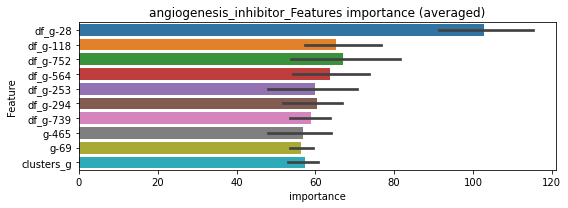

len(train_index) : 3892
len(valid_index) : 3893
================================= fold 1/2 angiogenesis_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0237224	valid_1's binary_logloss: 0.0453575
[200]	training's binary_logloss: 0.00371932	valid_1's binary_logloss: 0.0214541
[300]	training's binary_logloss: 0.0010015	valid_1's binary_logloss: 0.0172755
Early stopping, best iteration is:
[308]	training's binary_logloss: 0.000927788	valid_1's binary_logloss: 0.0171311


len(train_index) : 3893
len(valid_index) : 3892
================================= fold 2/2 angiogenesis_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0232996	valid_1's binary_logloss: 0.0397408
[200]	training's binary_logloss: 0.0039493	valid_1's binary_logloss: 0.0155129
[300]	training's binary_logloss: 0.00107922	valid_1's binary_logloss: 0.0108602
[400]	training's binary_logloss: 0.00049357	valid_1's binary_logloss: 0.00956429
Early stopping, best iteration is:
[414]	training's binary_logloss: 0.000455722	valid_1's binary_logloss: 0.00950478


angiogenesis_inhibitor logloss: 0.013318438546814372
angiotensin_receptor_antagonist, len(trt): 37, len(othr): 3283, target_rate: 0.0015537 → Adj_target_rate: 0.0018079


neg labels: 3289 → selected neg labels: 3283


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0387258	valid_1's binary_logloss: 0.0638555
[200]	training's binary_logloss: 0.00627111	valid_1's binary_logloss: 0.0229324
[300]	training's binary_logloss: 0.00174999	valid_1's binary_logloss: 0.0145268
[400]	training's binary_logloss: 0.00084087	valid_1's binary_logloss: 0.0122219
[500]	training's binary_logloss: 0.000557969	valid_1's binary_logloss: 0.0115095
Early stopping, best iteration is:
[490]	training's binary_logloss: 0.000571615	valid_1's binary_logloss: 0.011476
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0409716	valid_1's binary_logloss: 0.0671068
[200]	training's binary_logloss: 0.0068314	valid_1's binary_logloss: 0.0198043
[300]	training's binary_logloss: 0.00187943	valid_1's binary_logloss: 0.0087082
[400]	training's binary_logloss: 0.000878643	valid_1's binary_logloss: 0.00568271
[500]	training's binary_logloss: 0.00057260

1 / 3 AUC score:1.000
Threshold: 0.0044706, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → positive_corect_labels: 656/3807
p_label_rate: 0.0346560 Vs.target_rate: 0.00155, Num_p_label: 138.0, conf_0:0.00050, conf_1:0.00492
Num_p_label: 138.0, Expected: 6.2, Adj_threshold_1: 0.0044706
Num_p_label: 51.0, Expected: 6.2, Adj_threshold_2: 0.0094706
Num_p_label: 18.0, Expected: 6.2, Adj_threshold_3: 0.0144706
Num_p_label: 13.0, Expected: 6.2, Adj_threshold_4: 0.0194706
Num_p_label: 4.0, Expected: 6.2, Adj_threshold_5: 0.0244706
threshold: 0.0244706, positive p_label: 4.0/3982, p_label_rate: 0.0010045
positive y_label: 656.0/3807, y_label_rate: 0.1723142
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0379788	valid_1's binary_logloss: 0.0604497
[200]	training's binary_logloss: 0.00605135	valid_1's binary_logloss: 0.019944
[300]	training's binary_logloss: 0.00170637	valid_1's binary_logloss: 0.0126611
[400]	training's binary_logloss: 0.000823097	valid_1's binary_logloss: 0.0106974
[500]	training's binary_logloss: 0.000551181	valid_1's binary_logloss: 0.00994218
Early stopping, best iteration is:
[490]	training's binary_logloss: 0.000563006	valid_1's binary_logloss: 0.00988929
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0407911	valid_1's binary_logloss: 0.0654647
[200]	training's binary_logloss: 0.00660481	valid_1's binary_logloss: 0.0180773
[300]	training's binary_logloss: 0.00184553	valid_1's binary_logloss: 0.00803936
[400]	training's binary_logloss: 0.000867684	valid_1's binary_logloss: 0.00504055
[500]	training's binary_logloss: 0.000

2 / 3 AUC score:1.000
Threshold: 0.0244706, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 1 → positive_corect_labels: 656.0/3806
p_label_rate: 0.0075339 Vs.target_rate: 0.00155, Num_p_label: 30.0, conf_0:0.00052, conf_1:0.02692
Num_p_label: 30.0, Expected: 6.2, Adj_threshold_1: 0.0244706
Num_p_label: 20.0, Expected: 6.2, Adj_threshold_2: 0.0294706
Num_p_label: 15.0, Expected: 6.2, Adj_threshold_3: 0.0344706
Num_p_label: 14.0, Expected: 6.2, Adj_threshold_4: 0.0394706
Num_p_label: 11.0, Expected: 6.2, Adj_threshold_5: 0.0444706
threshold: 0.0444706, positive p_label: 11.0/3982, p_label_rate: 0.0027624
positive y_label: 656.0/3806, y_label_rate: 0.1723594
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0382279	valid_1's binary_logloss: 0.0610773
[200]	training's binary_logloss: 0.00589708	valid_1's binary_logloss: 0.0198901
[300]	training's binary_logloss: 0.00168644	valid_1's binary_logloss: 0.0128062
[400]	training's binary_logloss: 0.000812007	valid_1's binary_logloss: 0.0106654
[500]	training's binary_logloss: 0.00054792	valid_1's binary_logloss: 0.00992593
Early stopping, best iteration is:
[540]	training's binary_logloss: 0.000501851	valid_1's binary_logloss: 0.00970978
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0401376	valid_1's binary_logloss: 0.0625198
[200]	training's binary_logloss: 0.0066274	valid_1's binary_logloss: 0.0167782
[300]	training's binary_logloss: 0.00185245	valid_1's binary_logloss: 0.00726443
[400]	training's binary_logloss: 0.000876499	valid_1's binary_logloss: 0.00471782
[500]	training's binary_logloss: 0.0005

3 / 3 AUC score:1.000
Threshold: 0.0444706, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 2 → positive_corect_labels: 655.0/3804
p_label_rate: 0.0030136 Vs.target_rate: 0.00155, Num_p_label: 12.0, conf_0:0.00049, conf_1:0.04892
threshold: 0.0444706, positive p_label: 12.0/3982, p_label_rate: 0.0030136
positive y_label: 667.0/7786, y_label_rate: 0.0856666


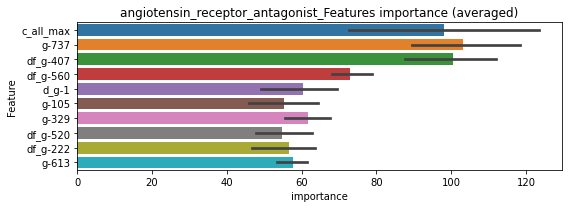

len(train_index) : 3893
len(valid_index) : 3893
================================= fold 1/2 angiotensin_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0237328	valid_1's binary_logloss: 0.0433202
[200]	training's binary_logloss: 0.0034341	valid_1's binary_logloss: 0.0185636
[300]	training's binary_logloss: 0.000917199	valid_1's binary_logloss: 0.0147631
Early stopping, best iteration is:
[330]	training's binary_logloss: 0.00070087	valid_1's binary_logloss: 0.0142905


len(train_index) : 3893
len(valid_index) : 3893
================================= fold 2/2 angiotensin_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0233139	valid_1's binary_logloss: 0.0377042
[200]	training's binary_logloss: 0.00378515	valid_1's binary_logloss: 0.0143599
[300]	training's binary_logloss: 0.0010478	valid_1's binary_logloss: 0.00936035
[400]	training's binary_logloss: 0.00049111	valid_1's binary_logloss: 0.0082625
[500]	training's binary_logloss: 0.000312354	valid_1's binary_logloss: 0.00785507
Early stopping, best iteration is:
[505]	training's binary_logloss: 0.000307029	valid_1's binary_logloss: 0.00781053


angiotensin_receptor_antagonist logloss: 0.011050508522503985
anti-inflammatory, len(trt): 73, len(othr): 3277, target_rate: 0.0030654 → Adj_target_rate: 0.0032212


neg labels: 3289 → selected neg labels: 3277


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.052562	valid_1's binary_logloss: 0.102115
[200]	training's binary_logloss: 0.0113762	valid_1's binary_logloss: 0.0474379
[300]	training's binary_logloss: 0.00336353	valid_1's binary_logloss: 0.0322692
[400]	training's binary_logloss: 0.00151318	valid_1's binary_logloss: 0.0276623
Early stopping, best iteration is:
[455]	training's binary_logloss: 0.00112336	valid_1's binary_logloss: 0.0262625
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0575806	valid_1's binary_logloss: 0.0951723
[200]	training's binary_logloss: 0.0129703	valid_1's binary_logloss: 0.0395982
[300]	training's binary_logloss: 0.00373743	valid_1's binary_logloss: 0.0213721
[400]	training's binary_logloss: 0.00164114	valid_1's binary_logloss: 0.0150119
[500]	training's binary_logloss: 0.00097746	valid_1's binary_logloss: 0.0127623
[600]	training's binary_logloss: 0.000701808	vali

1 / 3 AUC score:1.000
Threshold: 0.0100387, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 136 → positive_corect_labels: 653/3796
p_label_rate: 0.0366650 Vs.target_rate: 0.00307, Num_p_label: 146.0, conf_0:0.00106, conf_1:0.01104
Num_p_label: 146.0, Expected: 12.2, Adj_threshold_1: 0.0100387
Num_p_label: 89.0, Expected: 12.2, Adj_threshold_2: 0.0150387
Num_p_label: 63.0, Expected: 12.2, Adj_threshold_3: 0.0200387
Num_p_label: 49.0, Expected: 12.2, Adj_threshold_4: 0.0250387
Num_p_label: 32.0, Expected: 12.2, Adj_threshold_5: 0.0300387
Num_p_label: 30.0, Expected: 12.2, Adj_threshold_6: 0.0350387
Num_p_label: 24.0, Expected: 12.2, Adj_threshold_7: 0.0400387
threshold: 0.0400387, positive p_label: 24.0/3982, p_label_rate: 0.0060271
positive y_label: 653.0/3796, y_label_rate: 0.1720232
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0500144	valid_1's binary_logloss: 0.113639
[200]	training's binary_logloss: 0.010016	valid_1's binary_logloss: 0.060812
[300]	training's binary_logloss: 0.00294723	valid_1's binary_logloss: 0.0456799
Early stopping, best iteration is:
[361]	training's binary_logloss: 0.00176281	valid_1's binary_logloss: 0.0433925
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0523949	valid_1's binary_logloss: 0.100694
[200]	training's binary_logloss: 0.0107609	valid_1's binary_logloss: 0.0483239
[300]	training's binary_logloss: 0.00320182	valid_1's binary_logloss: 0.035542
[400]	training's binary_logloss: 0.00145258	valid_1's binary_logloss: 0.0316581
[500]	training's binary_logloss: 0.000881794	valid_1's binary_logloss: 0.0295406
Early stopping, best iteration is:
[496]	training's binary_logloss: 0.000895393	valid_1's binary_logloss: 0.029522


2 / 3 AUC score:1.000
Threshold: 0.0400387, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 16 → positive_corect_labels: 645.0/3780
p_label_rate: 0.0148167 Vs.target_rate: 0.00307, Num_p_label: 59.0, conf_0:0.00181, conf_1:0.04404
Num_p_label: 59.0, Expected: 12.2, Adj_threshold_1: 0.0400387
Num_p_label: 53.0, Expected: 12.2, Adj_threshold_2: 0.0450387
Num_p_label: 39.0, Expected: 12.2, Adj_threshold_3: 0.0500387
Num_p_label: 34.0, Expected: 12.2, Adj_threshold_4: 0.0550387
Num_p_label: 33.0, Expected: 12.2, Adj_threshold_5: 0.0600387
Num_p_label: 31.0, Expected: 12.2, Adj_threshold_6: 0.0650387
Num_p_label: 30.0, Expected: 12.2, Adj_threshold_7: 0.0700387
Num_p_label: 27.0, Expected: 12.2, Adj_threshold_8: 0.0750387
Num_p_label: 26.0, Expected: 12.2, Adj_threshold_9: 0.0800387
Num_p_label: 24.0, Expected: 12.2, Adj_threshold_10: 0.0850387
threshold: 0.0850387, positive p_label: 24.0/3982, p_label_rate: 0.0060271
positive y_label: 645.0/3780, y_label_rate: 0.1706349
================= Pse

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0474906	valid_1's binary_logloss: 0.113726
[200]	training's binary_logloss: 0.00934054	valid_1's binary_logloss: 0.0639697
[300]	training's binary_logloss: 0.0027755	valid_1's binary_logloss: 0.0518395
Early stopping, best iteration is:
[337]	training's binary_logloss: 0.00199154	valid_1's binary_logloss: 0.050102
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0527809	valid_1's binary_logloss: 0.0997301
[200]	training's binary_logloss: 0.0109357	valid_1's binary_logloss: 0.0488926
[300]	training's binary_logloss: 0.00317915	valid_1's binary_logloss: 0.0354654
[400]	training's binary_logloss: 0.00144839	valid_1's binary_logloss: 0.0315521
Early stopping, best iteration is:
[485]	training's binary_logloss: 0.000932119	valid_1's binary_logloss: 0.0296876


3 / 3 AUC score:0.999
Threshold: 0.0850387, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 16 → positive_corect_labels: 629.0/3764
p_label_rate: 0.0057760 Vs.target_rate: 0.00307, Num_p_label: 23.0, conf_0:0.00188, conf_1:0.09354
threshold: 0.0850387, positive p_label: 23.0/3982, p_label_rate: 0.0057760
positive y_label: 652.0/7746, y_label_rate: 0.0841725


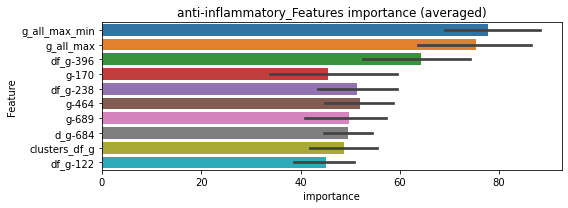

len(train_index) : 3873
len(valid_index) : 3873
================================= fold 1/2 anti-inflammatory=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0289537	valid_1's binary_logloss: 0.055743
[200]	training's binary_logloss: 0.00594601	valid_1's binary_logloss: 0.0274225
[300]	training's binary_logloss: 0.00169009	valid_1's binary_logloss: 0.0201259
[400]	training's binary_logloss: 0.000757167	valid_1's binary_logloss: 0.0175267
Early stopping, best iteration is:
[464]	training's binary_logloss: 0.000538934	valid_1's binary_logloss: 0.0170376


len(train_index) : 3873
len(valid_index) : 3873
================================= fold 2/2 anti-inflammatory=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0273254	valid_1's binary_logloss: 0.0587712
[200]	training's binary_logloss: 0.00555166	valid_1's binary_logloss: 0.0303865
[300]	training's binary_logloss: 0.00158853	valid_1's binary_logloss: 0.0235073
[400]	training's binary_logloss: 0.000730291	valid_1's binary_logloss: 0.0209745
Early stopping, best iteration is:
[431]	training's binary_logloss: 0.000612381	valid_1's binary_logloss: 0.0207153


anti-inflammatory logloss: 0.018876447567490223
antiarrhythmic, len(trt): 24, len(othr): 3285, target_rate: 0.0010078 → Adj_target_rate: 0.0012513


neg labels: 3289 → selected neg labels: 3285


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0284967	valid_1's binary_logloss: 0.0494727
[200]	training's binary_logloss: 0.00376237	valid_1's binary_logloss: 0.015836
[300]	training's binary_logloss: 0.0010555	valid_1's binary_logloss: 0.00868486
[400]	training's binary_logloss: 0.000538231	valid_1's binary_logloss: 0.00679873
[500]	training's binary_logloss: 0.000399611	valid_1's binary_logloss: 0.00607019
Early stopping, best iteration is:
[494]	training's binary_logloss: 0.000400549	valid_1's binary_logloss: 0.00606899
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0293282	valid_1's binary_logloss: 0.0403448
[200]	training's binary_logloss: 0.00392354	valid_1's binary_logloss: 0.00750103
[300]	training's binary_logloss: 0.00111368	valid_1's binary_logloss: 0.0030475
[400]	training's binary_logloss: 0.000550463	valid_1's binary_logloss: 0.00186605
[500]	training's binary_logloss: 0.00

1 / 3 AUC score:1.000
Threshold: 0.0018813, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → positive_corect_labels: 657/3810
p_label_rate: 0.0748368 Vs.target_rate: 0.00101, Num_p_label: 298.0, conf_0:0.00028, conf_1:0.00207
Num_p_label: 298.0, Expected: 4.0, Adj_threshold_1: 0.0018813
Num_p_label: 156.0, Expected: 4.0, Adj_threshold_2: 0.0068813
Num_p_label: 123.0, Expected: 4.0, Adj_threshold_3: 0.0118813
Num_p_label: 109.0, Expected: 4.0, Adj_threshold_4: 0.0168813
Num_p_label: 96.0, Expected: 4.0, Adj_threshold_5: 0.0218813
Num_p_label: 90.0, Expected: 4.0, Adj_threshold_6: 0.0268813
Num_p_label: 86.0, Expected: 4.0, Adj_threshold_7: 0.0318813
Num_p_label: 73.0, Expected: 4.0, Adj_threshold_8: 0.0368813
Num_p_label: 70.0, Expected: 4.0, Adj_threshold_9: 0.0418813
Num_p_label: 61.0, Expected: 4.0, Adj_threshold_10: 0.0468813
threshold: 0.0518813, positive p_label: 57.0/3982, p_label_rate: 0.0143144
positive y_label: 657.0/3810, y_label_rate: 0.1724409
================= Pseudo la

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0273781	valid_1's binary_logloss: 0.046086
[200]	training's binary_logloss: 0.00346755	valid_1's binary_logloss: 0.0149234
[300]	training's binary_logloss: 0.000985963	valid_1's binary_logloss: 0.00909473
[400]	training's binary_logloss: 0.000506834	valid_1's binary_logloss: 0.00709911
[500]	training's binary_logloss: 0.000384934	valid_1's binary_logloss: 0.00645927
Early stopping, best iteration is:
[500]	training's binary_logloss: 0.000384934	valid_1's binary_logloss: 0.00645927
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0282543	valid_1's binary_logloss: 0.0375202
[200]	training's binary_logloss: 0.00364051	valid_1's binary_logloss: 0.00625534
[300]	training's binary_logloss: 0.00103356	valid_1's binary_logloss: 0.0022223
[400]	training's binary_logloss: 0.000521779	valid_1's binary_logloss: 0.00126301
[500]	training's binary_logloss: 0.

2 / 3 AUC score:1.000
Threshold: 0.0518813, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 4 → positive_corect_labels: 657.0/3806
p_label_rate: 0.0366650 Vs.target_rate: 0.00101, Num_p_label: 146.0, conf_0:0.00033, conf_1:0.05707
Num_p_label: 146.0, Expected: 4.0, Adj_threshold_1: 0.0518813
Num_p_label: 145.0, Expected: 4.0, Adj_threshold_2: 0.0568813
Num_p_label: 144.0, Expected: 4.0, Adj_threshold_3: 0.0618813
Num_p_label: 139.0, Expected: 4.0, Adj_threshold_4: 0.0668813
Num_p_label: 138.0, Expected: 4.0, Adj_threshold_5: 0.0718813
Num_p_label: 137.0, Expected: 4.0, Adj_threshold_6: 0.0768813
Num_p_label: 137.0, Expected: 4.0, Adj_threshold_7: 0.0818813
Num_p_label: 136.0, Expected: 4.0, Adj_threshold_8: 0.0868813
Num_p_label: 135.0, Expected: 4.0, Adj_threshold_9: 0.0918813
Num_p_label: 135.0, Expected: 4.0, Adj_threshold_10: 0.0968813
threshold: 0.1018813, positive p_label: 130.0/3982, p_label_rate: 0.0326469
positive y_label: 657.0/3806, y_label_rate: 0.1726222
================= Ps

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0272119	valid_1's binary_logloss: 0.0459918
[200]	training's binary_logloss: 0.00343785	valid_1's binary_logloss: 0.0144758
[300]	training's binary_logloss: 0.000975031	valid_1's binary_logloss: 0.00877894
[400]	training's binary_logloss: 0.000504758	valid_1's binary_logloss: 0.00673557
Early stopping, best iteration is:
[455]	training's binary_logloss: 0.000413923	valid_1's binary_logloss: 0.00623702
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0275985	valid_1's binary_logloss: 0.0370894
[200]	training's binary_logloss: 0.00355834	valid_1's binary_logloss: 0.00630263
[300]	training's binary_logloss: 0.00102304	valid_1's binary_logloss: 0.00230308
[400]	training's binary_logloss: 0.000524128	valid_1's binary_logloss: 0.0013518
[500]	training's binary_logloss: 0.000391342	valid_1's binary_logloss: 0.00111656
Early stopping, best iteration is:

3 / 3 AUC score:1.000
Threshold: 0.1018813, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → positive_corect_labels: 657.0/3806
p_label_rate: 0.0356605 Vs.target_rate: 0.00101, Num_p_label: 142.0, conf_0:0.00034, conf_1:0.11207
Num_p_label: 142.0, Expected: 4.0, Adj_threshold_1: 0.1018813
Num_p_label: 141.0, Expected: 4.0, Adj_threshold_2: 0.1068813
Num_p_label: 141.0, Expected: 4.0, Adj_threshold_3: 0.1118813
Num_p_label: 140.0, Expected: 4.0, Adj_threshold_4: 0.1168813
Num_p_label: 138.0, Expected: 4.0, Adj_threshold_5: 0.1218813
Num_p_label: 137.0, Expected: 4.0, Adj_threshold_6: 0.1268813
Num_p_label: 137.0, Expected: 4.0, Adj_threshold_7: 0.1318813
Num_p_label: 137.0, Expected: 4.0, Adj_threshold_8: 0.1368813
Num_p_label: 137.0, Expected: 4.0, Adj_threshold_9: 0.1418813
Num_p_label: 133.0, Expected: 4.0, Adj_threshold_10: 0.1468813
threshold: 0.1518813, positive p_label: 129.0/3982, p_label_rate: 0.0323958
positive y_label: 786.0/7788, y_label_rate: 0.1009245


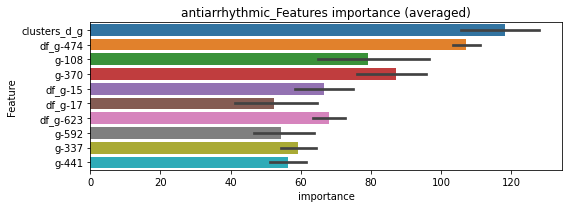

len(train_index) : 3894
len(valid_index) : 3894
================================= fold 1/2 antiarrhythmic=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.01837	valid_1's binary_logloss: 0.0305963
[200]	training's binary_logloss: 0.00244012	valid_1's binary_logloss: 0.0127002
Early stopping, best iteration is:
[235]	training's binary_logloss: 0.00141854	valid_1's binary_logloss: 0.0118211


len(train_index) : 3894
len(valid_index) : 3894
================================= fold 2/2 antiarrhythmic=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0192923	valid_1's binary_logloss: 0.0294773
[200]	training's binary_logloss: 0.00269069	valid_1's binary_logloss: 0.0103681
[300]	training's binary_logloss: 0.000729531	valid_1's binary_logloss: 0.00780416
[400]	training's binary_logloss: 0.000350063	valid_1's binary_logloss: 0.00710653
Early stopping, best iteration is:
[455]	training's binary_logloss: 0.000275752	valid_1's binary_logloss: 0.00690493


antiarrhythmic logloss: 0.00936302840273031
antibiotic, len(trt): 43, len(othr): 3281, target_rate: 0.0018057 → Adj_target_rate: 0.0020542


neg labels: 3289 → selected neg labels: 3281


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0391198	valid_1's binary_logloss: 0.0628883
[200]	training's binary_logloss: 0.00658874	valid_1's binary_logloss: 0.0239813
[300]	training's binary_logloss: 0.00188966	valid_1's binary_logloss: 0.0156471
[400]	training's binary_logloss: 0.000929198	valid_1's binary_logloss: 0.0135091
[500]	training's binary_logloss: 0.000610083	valid_1's binary_logloss: 0.0127504
Early stopping, best iteration is:
[490]	training's binary_logloss: 0.00062845	valid_1's binary_logloss: 0.0127481
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0419971	valid_1's binary_logloss: 0.068396
[200]	training's binary_logloss: 0.00711282	valid_1's binary_logloss: 0.0230198
[300]	training's binary_logloss: 0.00198533	valid_1's binary_logloss: 0.012837
[400]	training's binary_logloss: 0.00094373	valid_1's binary_logloss: 0.00892353
Early stopping, best iteration is:
[486]	tra

1 / 3 AUC score:1.000
Threshold: 0.0043653, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 134 → positive_corect_labels: 655/3803
p_label_rate: 0.0572577 Vs.target_rate: 0.00181, Num_p_label: 228.0, conf_0:0.00069, conf_1:0.00480
Num_p_label: 228.0, Expected: 7.2, Adj_threshold_1: 0.0043653
Num_p_label: 95.0, Expected: 7.2, Adj_threshold_2: 0.0093653
Num_p_label: 45.0, Expected: 7.2, Adj_threshold_3: 0.0143653
Num_p_label: 27.0, Expected: 7.2, Adj_threshold_4: 0.0193653
Num_p_label: 18.0, Expected: 7.2, Adj_threshold_5: 0.0243653
Num_p_label: 14.0, Expected: 7.2, Adj_threshold_6: 0.0293653
threshold: 0.0293653, positive p_label: 14.0/3982, p_label_rate: 0.0035158
positive y_label: 655.0/3803, y_label_rate: 0.1722324
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0389081	valid_1's binary_logloss: 0.0598791
[200]	training's binary_logloss: 0.00649116	valid_1's binary_logloss: 0.0188108
[300]	training's binary_logloss: 0.00187682	valid_1's binary_logloss: 0.00983988
[400]	training's binary_logloss: 0.000909405	valid_1's binary_logloss: 0.00755954
[500]	training's binary_logloss: 0.000595739	valid_1's binary_logloss: 0.00646051
Early stopping, best iteration is:
[551]	training's binary_logloss: 0.000534381	valid_1's binary_logloss: 0.00625004
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0401718	valid_1's binary_logloss: 0.0668249
[200]	training's binary_logloss: 0.00685203	valid_1's binary_logloss: 0.0229525
[300]	training's binary_logloss: 0.00194381	valid_1's binary_logloss: 0.0129014
[400]	training's binary_logloss: 0.000921898	valid_1's binary_logloss: 0.0101979
[500]	training's binary_logloss: 0.00

2 / 3 AUC score:1.000
Threshold: 0.0293653, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 4 → positive_corect_labels: 655.0/3799
p_label_rate: 0.0115520 Vs.target_rate: 0.00181, Num_p_label: 46.0, conf_0:0.00070, conf_1:0.03230
Num_p_label: 46.0, Expected: 7.2, Adj_threshold_1: 0.0293653
Num_p_label: 39.0, Expected: 7.2, Adj_threshold_2: 0.0343653
Num_p_label: 36.0, Expected: 7.2, Adj_threshold_3: 0.0393653
Num_p_label: 30.0, Expected: 7.2, Adj_threshold_4: 0.0443653
Num_p_label: 26.0, Expected: 7.2, Adj_threshold_5: 0.0493653
Num_p_label: 24.0, Expected: 7.2, Adj_threshold_6: 0.0543653
Num_p_label: 23.0, Expected: 7.2, Adj_threshold_7: 0.0593653
Num_p_label: 20.0, Expected: 7.2, Adj_threshold_8: 0.0643653
Num_p_label: 19.0, Expected: 7.2, Adj_threshold_9: 0.0693653
Num_p_label: 16.0, Expected: 7.2, Adj_threshold_10: 0.0743653
threshold: 0.0793653, positive p_label: 15.0/3982, p_label_rate: 0.0037670
positive y_label: 655.0/3799, y_label_rate: 0.1724138
================= Pseudo labelin

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0383169	valid_1's binary_logloss: 0.0597211
[200]	training's binary_logloss: 0.00636541	valid_1's binary_logloss: 0.0190891
[300]	training's binary_logloss: 0.00186035	valid_1's binary_logloss: 0.0104343
[400]	training's binary_logloss: 0.000899401	valid_1's binary_logloss: 0.00767306
[500]	training's binary_logloss: 0.000595711	valid_1's binary_logloss: 0.00659387
Early stopping, best iteration is:
[545]	training's binary_logloss: 0.000539068	valid_1's binary_logloss: 0.00633256
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0416621	valid_1's binary_logloss: 0.0730223
[200]	training's binary_logloss: 0.00699088	valid_1's binary_logloss: 0.0256097
[300]	training's binary_logloss: 0.00195399	valid_1's binary_logloss: 0.0153084
[400]	training's binary_logloss: 0.000925842	valid_1's binary_logloss: 0.0128742
[500]	training's binary_logloss: 0.000

3 / 3 AUC score:1.000
Threshold: 0.0793653, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 3 → positive_corect_labels: 652.0/3796
p_label_rate: 0.0027624 Vs.target_rate: 0.00181, Num_p_label: 11.0, conf_0:0.00074, conf_1:0.08730
threshold: 0.0793653, positive p_label: 11.0/3982, p_label_rate: 0.0027624
positive y_label: 663.0/7778, y_label_rate: 0.0852404


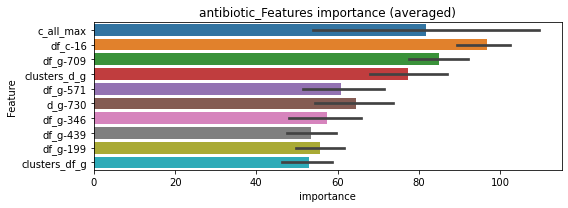

len(train_index) : 3889
len(valid_index) : 3889
================================= fold 1/2 antibiotic=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0211819	valid_1's binary_logloss: 0.0354557
[200]	training's binary_logloss: 0.00348137	valid_1's binary_logloss: 0.0139705
[300]	training's binary_logloss: 0.000974317	valid_1's binary_logloss: 0.00993208
Early stopping, best iteration is:
[382]	training's binary_logloss: 0.00052636	valid_1's binary_logloss: 0.00922772


len(train_index) : 3889
len(valid_index) : 3889
================================= fold 2/2 antibiotic=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0220919	valid_1's binary_logloss: 0.0382487
[200]	training's binary_logloss: 0.00372687	valid_1's binary_logloss: 0.0146799
[300]	training's binary_logloss: 0.0010492	valid_1's binary_logloss: 0.00909563
[400]	training's binary_logloss: 0.000501362	valid_1's binary_logloss: 0.0077112
Early stopping, best iteration is:
[454]	training's binary_logloss: 0.000384572	valid_1's binary_logloss: 0.00732312


antibiotic logloss: 0.008275419872583229
anticonvulsant, len(trt): 18, len(othr): 3286, target_rate: 0.0007559 → Adj_target_rate: 0.0009799


neg labels: 3289 → selected neg labels: 3286


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0254952	valid_1's binary_logloss: 0.0327597
[200]	training's binary_logloss: 0.00312571	valid_1's binary_logloss: 0.00589247
[300]	training's binary_logloss: 0.000856832	valid_1's binary_logloss: 0.00219813
[400]	training's binary_logloss: 0.000449684	valid_1's binary_logloss: 0.00137065
[500]	training's binary_logloss: 0.000352335	valid_1's binary_logloss: 0.00116846
Early stopping, best iteration is:
[514]	training's binary_logloss: 0.000349356	valid_1's binary_logloss: 0.00116659
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0247637	valid_1's binary_logloss: 0.0351303
[200]	training's binary_logloss: 0.00304321	valid_1's binary_logloss: 0.00754324
[300]	training's binary_logloss: 0.000844362	valid_1's binary_logloss: 0.00337505
[400]	training's binary_logloss: 0.000444906	valid_1's binary_logloss: 0.00250332
Early stopping, best iteration 

1 / 3 AUC score:1.000
Threshold: 0.0020228, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → positive_corect_labels: 657/3811
p_label_rate: 0.0351582 Vs.target_rate: 0.00076, Num_p_label: 140.0, conf_0:0.00022, conf_1:0.00223
Num_p_label: 140.0, Expected: 3.0, Adj_threshold_1: 0.0020228
Num_p_label: 27.0, Expected: 3.0, Adj_threshold_2: 0.0070228
Num_p_label: 15.0, Expected: 3.0, Adj_threshold_3: 0.0120228
Num_p_label: 6.0, Expected: 3.0, Adj_threshold_4: 0.0170228
threshold: 0.0170228, positive p_label: 6.0/3982, p_label_rate: 0.0015068
positive y_label: 657.0/3811, y_label_rate: 0.1723957
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0239985	valid_1's binary_logloss: 0.0313885
[200]	training's binary_logloss: 0.00289322	valid_1's binary_logloss: 0.00650917
[300]	training's binary_logloss: 0.000811731	valid_1's binary_logloss: 0.00261473
[400]	training's binary_logloss: 0.000439247	valid_1's binary_logloss: 0.00179622
Early stopping, best iteration is:
[486]	training's binary_logloss: 0.000356172	valid_1's binary_logloss: 0.00157944
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0237839	valid_1's binary_logloss: 0.0345194
[200]	training's binary_logloss: 0.0028219	valid_1's binary_logloss: 0.00747834
[300]	training's binary_logloss: 0.000810392	valid_1's binary_logloss: 0.00385914
[400]	training's binary_logloss: 0.000432472	valid_1's binary_logloss: 0.00300162
Early stopping, best iteration is:
[425]	training's binary_logloss: 0.000391847	valid_1's binary_logloss: 0.002860

2 / 3 AUC score:1.000
Threshold: 0.0170228, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 2 → positive_corect_labels: 657.0/3809
p_label_rate: 0.0067805 Vs.target_rate: 0.00076, Num_p_label: 27.0, conf_0:0.00026, conf_1:0.01873
Num_p_label: 27.0, Expected: 3.0, Adj_threshold_1: 0.0170228
Num_p_label: 21.0, Expected: 3.0, Adj_threshold_2: 0.0220228
Num_p_label: 17.0, Expected: 3.0, Adj_threshold_3: 0.0270228
Num_p_label: 15.0, Expected: 3.0, Adj_threshold_4: 0.0320228
Num_p_label: 13.0, Expected: 3.0, Adj_threshold_5: 0.0370228
Num_p_label: 13.0, Expected: 3.0, Adj_threshold_6: 0.0420228
Num_p_label: 10.0, Expected: 3.0, Adj_threshold_7: 0.0470228
Num_p_label: 9.0, Expected: 3.0, Adj_threshold_8: 0.0520228
Num_p_label: 7.0, Expected: 3.0, Adj_threshold_9: 0.0570228
Num_p_label: 7.0, Expected: 3.0, Adj_threshold_10: 0.0620228
threshold: 0.0670228, positive p_label: 6.0/3982, p_label_rate: 0.0015068
positive y_label: 657.0/3809, y_label_rate: 0.1724862
================= Pseudo labeling 3 

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0238974	valid_1's binary_logloss: 0.0323903
[200]	training's binary_logloss: 0.00287081	valid_1's binary_logloss: 0.00733313
[300]	training's binary_logloss: 0.000813603	valid_1's binary_logloss: 0.00313997
[400]	training's binary_logloss: 0.000438401	valid_1's binary_logloss: 0.002121
[500]	training's binary_logloss: 0.000351023	valid_1's binary_logloss: 0.00183092
Early stopping, best iteration is:
[523]	training's binary_logloss: 0.000349173	valid_1's binary_logloss: 0.00182792
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0238878	valid_1's binary_logloss: 0.0345268
[200]	training's binary_logloss: 0.00285206	valid_1's binary_logloss: 0.00826536
[300]	training's binary_logloss: 0.000809829	valid_1's binary_logloss: 0.00419875


3 / 3 AUC score:1.000
Threshold: 0.0670228, pos_neg_ratio: 0.8000000


Early stopping, best iteration is:
[349]	training's binary_logloss: 0.000567692	valid_1's binary_logloss: 0.00354123


Remove_noisy_labels: 0 → positive_corect_labels: 657.0/3809
p_label_rate: 0.0012557 Vs.target_rate: 0.00076, Num_p_label: 5.0, conf_0:0.00033, conf_1:0.07373
threshold: 0.0670228, positive p_label: 5.0/3982, p_label_rate: 0.0012557
positive y_label: 662.0/7791, y_label_rate: 0.0849698


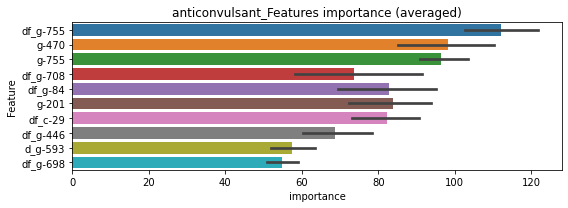

len(train_index) : 3895
len(valid_index) : 3896
================================= fold 1/2 anticonvulsant=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0139482	valid_1's binary_logloss: 0.0202142
[200]	training's binary_logloss: 0.00164484	valid_1's binary_logloss: 0.00723771
[300]	training's binary_logloss: 0.000442045	valid_1's binary_logloss: 0.00606855
Early stopping, best iteration is:
[330]	training's binary_logloss: 0.000343307	valid_1's binary_logloss: 0.00599844


len(train_index) : 3896
len(valid_index) : 3895
================================= fold 2/2 anticonvulsant=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0140776	valid_1's binary_logloss: 0.020347
[200]	training's binary_logloss: 0.00178849	valid_1's binary_logloss: 0.00575923
[300]	training's binary_logloss: 0.000476789	valid_1's binary_logloss: 0.00389648
Early stopping, best iteration is:
[292]	training's binary_logloss: 0.000513154	valid_1's binary_logloss: 0.00383094


anticonvulsant logloss: 0.004914832076173626
antifungal, len(trt): 26, len(othr): 3284, target_rate: 0.0010918 → Adj_target_rate: 0.0013394


neg labels: 3289 → selected neg labels: 3284


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0295186	valid_1's binary_logloss: 0.0464304
[200]	training's binary_logloss: 0.00408452	valid_1's binary_logloss: 0.0125119
[300]	training's binary_logloss: 0.00113371	valid_1's binary_logloss: 0.00665849
[400]	training's binary_logloss: 0.000574334	valid_1's binary_logloss: 0.00519659
[500]	training's binary_logloss: 0.000408445	valid_1's binary_logloss: 0.00458707
Early stopping, best iteration is:
[527]	training's binary_logloss: 0.000396919	valid_1's binary_logloss: 0.0045448
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.03072	valid_1's binary_logloss: 0.0420678
[200]	training's binary_logloss: 0.00414473	valid_1's binary_logloss: 0.00985894
[300]	training's binary_logloss: 0.00115268	valid_1's binary_logloss: 0.00437043
[400]	training's binary_logloss: 0.000576387	valid_1's binary_logloss: 0.00303446
[500]	training's binary_logloss: 0.00

1 / 3 AUC score:1.000
Threshold: 0.0019770, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → positive_corect_labels: 656/3808
p_label_rate: 0.0411853 Vs.target_rate: 0.00109, Num_p_label: 164.0, conf_0:0.00032, conf_1:0.00217
Num_p_label: 164.0, Expected: 4.3, Adj_threshold_1: 0.0019770
Num_p_label: 20.0, Expected: 4.3, Adj_threshold_2: 0.0069770
Num_p_label: 10.0, Expected: 4.3, Adj_threshold_3: 0.0119770
Num_p_label: 6.0, Expected: 4.3, Adj_threshold_4: 0.0169770
threshold: 0.0169770, positive p_label: 6.0/3982, p_label_rate: 0.0015068
positive y_label: 656.0/3808, y_label_rate: 0.1722689
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0292635	valid_1's binary_logloss: 0.0470709
[200]	training's binary_logloss: 0.00391831	valid_1's binary_logloss: 0.0132933
[300]	training's binary_logloss: 0.00110223	valid_1's binary_logloss: 0.00754707
[400]	training's binary_logloss: 0.000564791	valid_1's binary_logloss: 0.00627306
Early stopping, best iteration is:
[395]	training's binary_logloss: 0.000576929	valid_1's binary_logloss: 0.00620992
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0297472	valid_1's binary_logloss: 0.0403216
[200]	training's binary_logloss: 0.0039135	valid_1's binary_logloss: 0.00854606
[300]	training's binary_logloss: 0.00110829	valid_1's binary_logloss: 0.00394997
[400]	training's binary_logloss: 0.000568662	valid_1's binary_logloss: 0.0027972
[500]	training's binary_logloss: 0.000410304	valid_1's binary_logloss: 0.00238814
[600]	training's binary_logloss: 0.0

2 / 3 AUC score:1.000
Threshold: 0.0169770, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 1 → positive_corect_labels: 656.0/3807
p_label_rate: 0.0030136 Vs.target_rate: 0.00109, Num_p_label: 12.0, conf_0:0.00046, conf_1:0.01867
threshold: 0.0169770, positive p_label: 12.0/3982, p_label_rate: 0.0030136
positive y_label: 656.0/3807, y_label_rate: 0.1723142
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0294858	valid_1's binary_logloss: 0.0477126
[200]	training's binary_logloss: 0.00382457	valid_1's binary_logloss: 0.0125508
[300]	training's binary_logloss: 0.0010795	valid_1's binary_logloss: 0.00645597
[400]	training's binary_logloss: 0.000558752	valid_1's binary_logloss: 0.0047759
Early stopping, best iteration is:
[487]	training's binary_logloss: 0.000417142	valid_1's binary_logloss: 0.00426836
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0299573	valid_1's binary_logloss: 0.039836
[200]	training's binary_logloss: 0.00395202	valid_1's binary_logloss: 0.00836869
[300]	training's binary_logloss: 0.00112059	valid_1's binary_logloss: 0.00382384
[400]	training's binary_logloss: 0.000574941	valid_1's binary_logloss: 0.00271431
[500]	training's binary_logloss: 0.000412738	valid_1's binary_logloss: 0.00227912
Early stopping, best iteration is:
[5

3 / 3 AUC score:1.000
Threshold: 0.0169770, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → positive_corect_labels: 656.0/3807
p_label_rate: 0.0027624 Vs.target_rate: 0.00109, Num_p_label: 11.0, conf_0:0.00038, conf_1:0.01867
threshold: 0.0169770, positive p_label: 11.0/3982, p_label_rate: 0.0027624
positive y_label: 667.0/7789, y_label_rate: 0.0856336


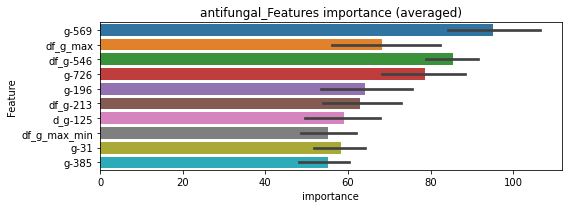

len(train_index) : 3894
len(valid_index) : 3895
================================= fold 1/2 antifungal=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0158125	valid_1's binary_logloss: 0.0275379
[200]	training's binary_logloss: 0.00216876	valid_1's binary_logloss: 0.0125864
Early stopping, best iteration is:
[248]	training's binary_logloss: 0.00106987	valid_1's binary_logloss: 0.0116264


len(train_index) : 3895
len(valid_index) : 3894
================================= fold 2/2 antifungal=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0165513	valid_1's binary_logloss: 0.0255991
[200]	training's binary_logloss: 0.00225375	valid_1's binary_logloss: 0.00759126
[300]	training's binary_logloss: 0.000633078	valid_1's binary_logloss: 0.00530631
[400]	training's binary_logloss: 0.00031447	valid_1's binary_logloss: 0.0048497
Early stopping, best iteration is:
[485]	training's binary_logloss: 0.000228888	valid_1's binary_logloss: 0.00471637


antifungal logloss: 0.008171828582412766
antihistamine, len(trt): 18, len(othr): 3286, target_rate: 0.0007559 → Adj_target_rate: 0.0009799


neg labels: 3289 → selected neg labels: 3286


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.023375	valid_1's binary_logloss: 0.0299058
[200]	training's binary_logloss: 0.00279135	valid_1's binary_logloss: 0.00554373
[300]	training's binary_logloss: 0.000795035	valid_1's binary_logloss: 0.0022314
[400]	training's binary_logloss: 0.000425714	valid_1's binary_logloss: 0.00155145
[500]	training's binary_logloss: 0.000335385	valid_1's binary_logloss: 0.00139287
Early stopping, best iteration is:
[504]	training's binary_logloss: 0.000334543	valid_1's binary_logloss: 0.00138979
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0233957	valid_1's binary_logloss: 0.0317897
[200]	training's binary_logloss: 0.00281183	valid_1's binary_logloss: 0.00694665
[300]	training's binary_logloss: 0.000812498	valid_1's binary_logloss: 0.00355248
[400]	training's binary_logloss: 0.000431457	valid_1's binary_logloss: 0.00248947
[500]	training's binary_logloss: 

1 / 3 AUC score:1.000
Threshold: 0.0015183, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → positive_corect_labels: 657/3811
p_label_rate: 0.0394274 Vs.target_rate: 0.00076, Num_p_label: 157.0, conf_0:0.00024, conf_1:0.00167
Num_p_label: 157.0, Expected: 3.0, Adj_threshold_1: 0.0015183
Num_p_label: 13.0, Expected: 3.0, Adj_threshold_2: 0.0065183
Num_p_label: 5.0, Expected: 3.0, Adj_threshold_3: 0.0115183
threshold: 0.0115183, positive p_label: 5.0/3982, p_label_rate: 0.0012557
positive y_label: 657.0/3811, y_label_rate: 0.1723957
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0226064	valid_1's binary_logloss: 0.0288366
[200]	training's binary_logloss: 0.00265896	valid_1's binary_logloss: 0.00555004
[300]	training's binary_logloss: 0.00076973	valid_1's binary_logloss: 0.00248825
[400]	training's binary_logloss: 0.000421584	valid_1's binary_logloss: 0.00178403
[500]	training's binary_logloss: 0.000340307	valid_1's binary_logloss: 0.0016065
Early stopping, best iteration is:
[501]	training's binary_logloss: 0.000340063	valid_1's binary_logloss: 0.00160612
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0231833	valid_1's binary_logloss: 0.0300987
[200]	training's binary_logloss: 0.00274574	valid_1's binary_logloss: 0.00598371
[300]	training's binary_logloss: 0.000795776	valid_1's binary_logloss: 0.00300703
[400]	training's binary_logloss: 0.000423078	valid_1's binary_logloss: 0.00200456
[500]	training's binary_logloss: 

2 / 3 AUC score:1.000
Threshold: 0.0115183, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → positive_corect_labels: 657.0/3811
p_label_rate: 0.0035158 Vs.target_rate: 0.00076, Num_p_label: 14.0, conf_0:0.00027, conf_1:0.01267
Num_p_label: 14.0, Expected: 3.0, Adj_threshold_1: 0.0115183
Num_p_label: 7.0, Expected: 3.0, Adj_threshold_2: 0.0165183
Num_p_label: 5.0, Expected: 3.0, Adj_threshold_3: 0.0215183
threshold: 0.0215183, positive p_label: 5.0/3982, p_label_rate: 0.0012557
positive y_label: 657.0/3811, y_label_rate: 0.1723957
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0226064	valid_1's binary_logloss: 0.0288366
[200]	training's binary_logloss: 0.00265896	valid_1's binary_logloss: 0.00555004
[300]	training's binary_logloss: 0.00076973	valid_1's binary_logloss: 0.00248825
[400]	training's binary_logloss: 0.000421584	valid_1's binary_logloss: 0.00178403
[500]	training's binary_logloss: 0.000340307	valid_1's binary_logloss: 0.0016065
Early stopping, best iteration is:
[501]	training's binary_logloss: 0.000340063	valid_1's binary_logloss: 0.00160612
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0231833	valid_1's binary_logloss: 0.0300987
[200]	training's binary_logloss: 0.00274574	valid_1's binary_logloss: 0.00598371
[300]	training's binary_logloss: 0.000795776	valid_1's binary_logloss: 0.00300703
[400]	training's binary_logloss: 0.000423078	valid_1's binary_logloss: 0.00200456
[500]	training's binary_logloss: 

3 / 3 AUC score:1.000
Threshold: 0.0215183, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → positive_corect_labels: 657.0/3811
p_label_rate: 0.0012557 Vs.target_rate: 0.00076, Num_p_label: 5.0, conf_0:0.00027, conf_1:0.02367
threshold: 0.0215183, positive p_label: 5.0/3982, p_label_rate: 0.0012557
positive y_label: 662.0/7793, y_label_rate: 0.0849480


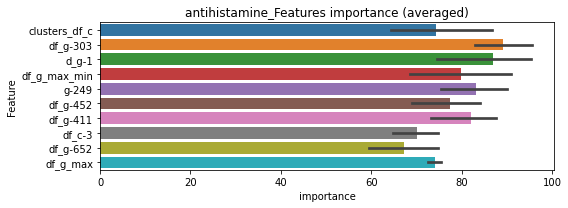

len(train_index) : 3896
len(valid_index) : 3897
================================= fold 1/2 antihistamine=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0125148	valid_1's binary_logloss: 0.0186732
[200]	training's binary_logloss: 0.00145494	valid_1's binary_logloss: 0.00589988
[300]	training's binary_logloss: 0.000410003	valid_1's binary_logloss: 0.00503364
Early stopping, best iteration is:
[293]	training's binary_logloss: 0.000435027	valid_1's binary_logloss: 0.00501121


len(train_index) : 3897
len(valid_index) : 3896
================================= fold 2/2 antihistamine=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0128993	valid_1's binary_logloss: 0.0191067
[200]	training's binary_logloss: 0.00153875	valid_1's binary_logloss: 0.00577229
[300]	training's binary_logloss: 0.000433079	valid_1's binary_logloss: 0.00418188
[400]	training's binary_logloss: 0.00022665	valid_1's binary_logloss: 0.0038998
Early stopping, best iteration is:
[455]	training's binary_logloss: 0.000187986	valid_1's binary_logloss: 0.00383268


antihistamine logloss: 0.004422020347102717
antimalarial, len(trt): 18, len(othr): 3286, target_rate: 0.0007559 → Adj_target_rate: 0.0009799


neg labels: 3289 → selected neg labels: 3286


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0236637	valid_1's binary_logloss: 0.029401
[200]	training's binary_logloss: 0.00280392	valid_1's binary_logloss: 0.00534345
[300]	training's binary_logloss: 0.00080571	valid_1's binary_logloss: 0.00210931
[400]	training's binary_logloss: 0.000436262	valid_1's binary_logloss: 0.00140919
[500]	training's binary_logloss: 0.000346427	valid_1's binary_logloss: 0.00125126
Early stopping, best iteration is:
[516]	training's binary_logloss: 0.000340171	valid_1's binary_logloss: 0.00123658
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0230889	valid_1's binary_logloss: 0.0325108
[200]	training's binary_logloss: 0.00275304	valid_1's binary_logloss: 0.00728419
[300]	training's binary_logloss: 0.000793885	valid_1's binary_logloss: 0.00364407
[400]	training's binary_logloss: 0.000431804	valid_1's binary_logloss: 0.00282249
[500]	training's binary_logloss: 

1 / 3 AUC score:1.000
Threshold: 0.0015407, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → positive_corect_labels: 657/3811
p_label_rate: 0.0441989 Vs.target_rate: 0.00076, Num_p_label: 176.0, conf_0:0.00024, conf_1:0.00169
Num_p_label: 176.0, Expected: 3.0, Adj_threshold_1: 0.0015407
Num_p_label: 22.0, Expected: 3.0, Adj_threshold_2: 0.0065407
Num_p_label: 7.0, Expected: 3.0, Adj_threshold_3: 0.0115407
Num_p_label: 6.0, Expected: 3.0, Adj_threshold_4: 0.0165407
threshold: 0.0165407, positive p_label: 6.0/3982, p_label_rate: 0.0015068
positive y_label: 657.0/3811, y_label_rate: 0.1723957
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0232757	valid_1's binary_logloss: 0.0290035
[200]	training's binary_logloss: 0.00271275	valid_1's binary_logloss: 0.00504475
[300]	training's binary_logloss: 0.000779844	valid_1's binary_logloss: 0.00217777
[400]	training's binary_logloss: 0.000428095	valid_1's binary_logloss: 0.00151759
[500]	training's binary_logloss: 0.000342678	valid_1's binary_logloss: 0.00131801
Early stopping, best iteration is:
[510]	training's binary_logloss: 0.000339367	valid_1's binary_logloss: 0.00131326
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0235681	valid_1's binary_logloss: 0.0317951
[200]	training's binary_logloss: 0.00274432	valid_1's binary_logloss: 0.00684957
[300]	training's binary_logloss: 0.000782935	valid_1's binary_logloss: 0.00344373
[400]	training's binary_logloss: 0.000428204	valid_1's binary_logloss: 0.00264269
Early stopping, best iteration 

2 / 3 AUC score:1.000
Threshold: 0.0165407, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → positive_corect_labels: 657.0/3811
p_label_rate: 0.0042692 Vs.target_rate: 0.00076, Num_p_label: 17.0, conf_0:0.00027, conf_1:0.01819
Num_p_label: 17.0, Expected: 3.0, Adj_threshold_1: 0.0165407
Num_p_label: 9.0, Expected: 3.0, Adj_threshold_2: 0.0215407
Num_p_label: 6.0, Expected: 3.0, Adj_threshold_3: 0.0265407
threshold: 0.0265407, positive p_label: 6.0/3982, p_label_rate: 0.0015068
positive y_label: 657.0/3811, y_label_rate: 0.1723957
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0232757	valid_1's binary_logloss: 0.0290035
[200]	training's binary_logloss: 0.00271275	valid_1's binary_logloss: 0.00504475
[300]	training's binary_logloss: 0.000779844	valid_1's binary_logloss: 0.00217777
[400]	training's binary_logloss: 0.000428095	valid_1's binary_logloss: 0.00151759
[500]	training's binary_logloss: 0.000342678	valid_1's binary_logloss: 0.00131801
Early stopping, best iteration is:
[510]	training's binary_logloss: 0.000339367	valid_1's binary_logloss: 0.00131326
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0235681	valid_1's binary_logloss: 0.0317951
[200]	training's binary_logloss: 0.00274432	valid_1's binary_logloss: 0.00684957
[300]	training's binary_logloss: 0.000782935	valid_1's binary_logloss: 0.00344373
[400]	training's binary_logloss: 0.000428204	valid_1's binary_logloss: 0.00264269
Early stopping, best iteration 

3 / 3 AUC score:1.000
Threshold: 0.0265407, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → positive_corect_labels: 657.0/3811
p_label_rate: 0.0015068 Vs.target_rate: 0.00076, Num_p_label: 6.0, conf_0:0.00027, conf_1:0.02919
threshold: 0.0265407, positive p_label: 6.0/3982, p_label_rate: 0.0015068
positive y_label: 663.0/7793, y_label_rate: 0.0850764


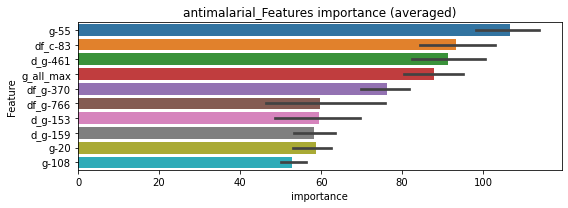

len(train_index) : 3896
len(valid_index) : 3897
================================= fold 1/2 antimalarial=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0123906	valid_1's binary_logloss: 0.0191231
[200]	training's binary_logloss: 0.00140917	valid_1's binary_logloss: 0.00657347
Early stopping, best iteration is:
[273]	training's binary_logloss: 0.000516977	valid_1's binary_logloss: 0.00573581


len(train_index) : 3897
len(valid_index) : 3896
================================= fold 2/2 antimalarial=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0127468	valid_1's binary_logloss: 0.0200255
[200]	training's binary_logloss: 0.00156053	valid_1's binary_logloss: 0.00658576
[300]	training's binary_logloss: 0.000444399	valid_1's binary_logloss: 0.00462686
[400]	training's binary_logloss: 0.000229091	valid_1's binary_logloss: 0.00412675
Early stopping, best iteration is:
[419]	training's binary_logloss: 0.000212711	valid_1's binary_logloss: 0.00410946


antimalarial logloss: 0.004922739200417877
antioxidant, len(trt): 73, len(othr): 3278, target_rate: 0.0030654 → Adj_target_rate: 0.0032212


neg labels: 3289 → selected neg labels: 3278


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0493354	valid_1's binary_logloss: 0.103411
[200]	training's binary_logloss: 0.0109412	valid_1's binary_logloss: 0.0596529
[300]	training's binary_logloss: 0.00339221	valid_1's binary_logloss: 0.0500241
Early stopping, best iteration is:
[338]	training's binary_logloss: 0.00239962	valid_1's binary_logloss: 0.0486831
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0518025	valid_1's binary_logloss: 0.10331
[200]	training's binary_logloss: 0.0112153	valid_1's binary_logloss: 0.0511148
[300]	training's binary_logloss: 0.00335158	valid_1's binary_logloss: 0.0351016
[400]	training's binary_logloss: 0.00154686	valid_1's binary_logloss: 0.0296243
[500]	training's binary_logloss: 0.000957865	valid_1's binary_logloss: 0.0275316
Early stopping, best iteration is:
[532]	training's binary_logloss: 0.0008513	valid_1's binary_logloss: 0.026933


1 / 3 AUC score:0.999
Threshold: 0.0114425, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 140 → positive_corect_labels: 651/3793
p_label_rate: 0.0391763 Vs.target_rate: 0.00307, Num_p_label: 156.0, conf_0:0.00187, conf_1:0.01259
Num_p_label: 156.0, Expected: 12.2, Adj_threshold_1: 0.0114425
Num_p_label: 80.0, Expected: 12.2, Adj_threshold_2: 0.0164425
Num_p_label: 50.0, Expected: 12.2, Adj_threshold_3: 0.0214425
Num_p_label: 36.0, Expected: 12.2, Adj_threshold_4: 0.0264425
Num_p_label: 23.0, Expected: 12.2, Adj_threshold_5: 0.0314425
threshold: 0.0314425, positive p_label: 23.0/3982, p_label_rate: 0.0057760
positive y_label: 651.0/3793, y_label_rate: 0.1716320
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0485202	valid_1's binary_logloss: 0.102169
[200]	training's binary_logloss: 0.00986538	valid_1's binary_logloss: 0.0563807
[300]	training's binary_logloss: 0.00297234	valid_1's binary_logloss: 0.0449162
[400]	training's binary_logloss: 0.00141407	valid_1's binary_logloss: 0.0408573
Early stopping, best iteration is:
[426]	training's binary_logloss: 0.00122874	valid_1's binary_logloss: 0.0397543
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0480661	valid_1's binary_logloss: 0.109078
[200]	training's binary_logloss: 0.0105839	valid_1's binary_logloss: 0.0640756
[300]	training's binary_logloss: 0.00319756	valid_1's binary_logloss: 0.0493798
Early stopping, best iteration is:
[365]	training's binary_logloss: 0.00187018	valid_1's binary_logloss: 0.0459783


2 / 3 AUC score:0.999
Threshold: 0.0314425, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 31 → positive_corect_labels: 643.0/3762
p_label_rate: 0.0148167 Vs.target_rate: 0.00307, Num_p_label: 59.0, conf_0:0.00209, conf_1:0.03459
Num_p_label: 59.0, Expected: 12.2, Adj_threshold_1: 0.0314425
Num_p_label: 40.0, Expected: 12.2, Adj_threshold_2: 0.0364425
Num_p_label: 33.0, Expected: 12.2, Adj_threshold_3: 0.0414425
Num_p_label: 25.0, Expected: 12.2, Adj_threshold_4: 0.0464425
Num_p_label: 24.0, Expected: 12.2, Adj_threshold_5: 0.0514425
threshold: 0.0514425, positive p_label: 24.0/3982, p_label_rate: 0.0060271
positive y_label: 643.0/3762, y_label_rate: 0.1709197
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0468498	valid_1's binary_logloss: 0.102941
[200]	training's binary_logloss: 0.00964657	valid_1's binary_logloss: 0.0557701
[300]	training's binary_logloss: 0.00290737	valid_1's binary_logloss: 0.0430481
[400]	training's binary_logloss: 0.00138668	valid_1's binary_logloss: 0.039668
Early stopping, best iteration is:
[420]	training's binary_logloss: 0.00123969	valid_1's binary_logloss: 0.0388447
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0502176	valid_1's binary_logloss: 0.0865266
[200]	training's binary_logloss: 0.0110529	valid_1's binary_logloss: 0.0388058
[300]	training's binary_logloss: 0.00337632	valid_1's binary_logloss: 0.0248451
Early stopping, best iteration is:
[351]	training's binary_logloss: 0.00217453	valid_1's binary_logloss: 0.0222513


3 / 3 AUC score:0.999
Threshold: 0.0514425, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 12 → positive_corect_labels: 634.0/3750
p_label_rate: 0.0082873 Vs.target_rate: 0.00307, Num_p_label: 33.0, conf_0:0.00229, conf_1:0.05659
threshold: 0.0514425, positive p_label: 33.0/3982, p_label_rate: 0.0082873
positive y_label: 667.0/7732, y_label_rate: 0.0862649


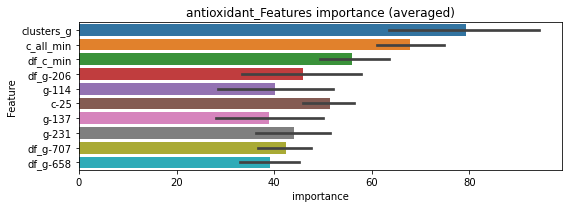

len(train_index) : 3866
len(valid_index) : 3866
================================= fold 1/2 antioxidant=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0287464	valid_1's binary_logloss: 0.0686698
[200]	training's binary_logloss: 0.00630479	valid_1's binary_logloss: 0.0465068
[300]	training's binary_logloss: 0.00191417	valid_1's binary_logloss: 0.0421727
Early stopping, best iteration is:
[312]	training's binary_logloss: 0.00170239	valid_1's binary_logloss: 0.0417458


len(train_index) : 3866
len(valid_index) : 3866
================================= fold 2/2 antioxidant=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.028018	valid_1's binary_logloss: 0.0622004
[200]	training's binary_logloss: 0.00590239	valid_1's binary_logloss: 0.0365721
[300]	training's binary_logloss: 0.00177621	valid_1's binary_logloss: 0.0303912
Early stopping, best iteration is:
[332]	training's binary_logloss: 0.00131641	valid_1's binary_logloss: 0.0297246


antioxidant logloss: 0.03573518578354472


  acetylcholine_receptor_agonist acetylcholine_receptor_antagonist  \
0                       df_g-122                              c-30   
1                  clusters_df_c                         c_all_max   
2                          cnt_0                    clusters_g_all   
3                      c_all_min                          df_g-707   
4                        df_g-51                        clusters_g   
5                       df_c_min                          df_c_min   
6                          cnt_2                             g-514   
7                       df_g-736                          df_g-640   
8                          g-244                            df_c-6   
9                           c-73                          df_g-597   

  acetylcholinesterase_inhibitor adenosine_receptor_antagonist  \
0                      c_all_max                clusters_c_all   
1                      c_all_min                      df_c_min   
2                 clusters_g_al

antiprotozoal, len(trt): 36, len(othr): 3283, target_rate: 0.0015117 → Adj_target_rate: 0.0017663


neg labels: 3289 → selected neg labels: 3283


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0377109	valid_1's binary_logloss: 0.0642555
[200]	training's binary_logloss: 0.00576725	valid_1's binary_logloss: 0.0222166
[300]	training's binary_logloss: 0.0016261	valid_1's binary_logloss: 0.0126093
[400]	training's binary_logloss: 0.000788729	valid_1's binary_logloss: 0.00958068
[500]	training's binary_logloss: 0.000525205	valid_1's binary_logloss: 0.00828244
Early stopping, best iteration is:
[534]	training's binary_logloss: 0.000484875	valid_1's binary_logloss: 0.00806202
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0377797	valid_1's binary_logloss: 0.0606554
[200]	training's binary_logloss: 0.00607318	valid_1's binary_logloss: 0.0184527
[300]	training's binary_logloss: 0.0016926	valid_1's binary_logloss: 0.00992251
[400]	training's binary_logloss: 0.000817875	valid_1's binary_logloss: 0.00749594
Early stopping, best iteration is:
[48

1 / 3 AUC score:1.000
Threshold: 0.0038435, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → positive_corect_labels: 656/3807
p_label_rate: 0.0399297 Vs.target_rate: 0.00151, Num_p_label: 159.0, conf_0:0.00047, conf_1:0.00423
Num_p_label: 159.0, Expected: 6.0, Adj_threshold_1: 0.0038435
Num_p_label: 50.0, Expected: 6.0, Adj_threshold_2: 0.0088435
Num_p_label: 22.0, Expected: 6.0, Adj_threshold_3: 0.0138435
Num_p_label: 16.0, Expected: 6.0, Adj_threshold_4: 0.0188435
Num_p_label: 13.0, Expected: 6.0, Adj_threshold_5: 0.0238435
Num_p_label: 9.0, Expected: 6.0, Adj_threshold_6: 0.0288435
threshold: 0.0288435, positive p_label: 9.0/3982, p_label_rate: 0.0022602
positive y_label: 656.0/3807, y_label_rate: 0.1723142
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0382298	valid_1's binary_logloss: 0.0608021
[200]	training's binary_logloss: 0.00583225	valid_1's binary_logloss: 0.0182629
[300]	training's binary_logloss: 0.00162164	valid_1's binary_logloss: 0.00956272
[400]	training's binary_logloss: 0.000786404	valid_1's binary_logloss: 0.0070862
[500]	training's binary_logloss: 0.000521974	valid_1's binary_logloss: 0.00616244
Early stopping, best iteration is:
[545]	training's binary_logloss: 0.000477524	valid_1's binary_logloss: 0.00591153
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0394367	valid_1's binary_logloss: 0.0632464
[200]	training's binary_logloss: 0.00604035	valid_1's binary_logloss: 0.0181828
[300]	training's binary_logloss: 0.00170299	valid_1's binary_logloss: 0.00964587
[400]	training's binary_logloss: 0.000818233	valid_1's binary_logloss: 0.00722446
[500]	training's binary_logloss: 0.0

2 / 3 AUC score:1.000
Threshold: 0.0288435, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 1 → positive_corect_labels: 655.0/3806
p_label_rate: 0.0055249 Vs.target_rate: 0.00151, Num_p_label: 22.0, conf_0:0.00049, conf_1:0.03173
Num_p_label: 22.0, Expected: 6.0, Adj_threshold_1: 0.0288435
Num_p_label: 19.0, Expected: 6.0, Adj_threshold_2: 0.0338435
Num_p_label: 17.0, Expected: 6.0, Adj_threshold_3: 0.0388435
Num_p_label: 17.0, Expected: 6.0, Adj_threshold_4: 0.0438435
Num_p_label: 16.0, Expected: 6.0, Adj_threshold_5: 0.0488435
Num_p_label: 15.0, Expected: 6.0, Adj_threshold_6: 0.0538435
Num_p_label: 13.0, Expected: 6.0, Adj_threshold_7: 0.0588435
Num_p_label: 10.0, Expected: 6.0, Adj_threshold_8: 0.0638435
threshold: 0.0638435, positive p_label: 10.0/3982, p_label_rate: 0.0025113
positive y_label: 655.0/3806, y_label_rate: 0.1720967
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0366599	valid_1's binary_logloss: 0.0554345
[200]	training's binary_logloss: 0.00573336	valid_1's binary_logloss: 0.0141418
[300]	training's binary_logloss: 0.00159275	valid_1's binary_logloss: 0.00621903
[400]	training's binary_logloss: 0.000778562	valid_1's binary_logloss: 0.00409657
[500]	training's binary_logloss: 0.000522063	valid_1's binary_logloss: 0.00323309
[600]	training's binary_logloss: 0.000458667	valid_1's binary_logloss: 0.00301662
Early stopping, best iteration is:
[613]	training's binary_logloss: 0.000453928	valid_1's binary_logloss: 0.0030012
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0396016	valid_1's binary_logloss: 0.0600699
[200]	training's binary_logloss: 0.00623184	valid_1's binary_logloss: 0.0164526
[300]	training's binary_logloss: 0.00171249	valid_1's binary_logloss: 0.00747033
[400]	training's binary_logloss: 0.0

3 / 3 AUC score:1.000
Threshold: 0.0638435, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → positive_corect_labels: 655.0/3806
p_label_rate: 0.0022602 Vs.target_rate: 0.00151, Num_p_label: 9.0, conf_0:0.00048, conf_1:0.07023
threshold: 0.0638435, positive p_label: 9.0/3982, p_label_rate: 0.0022602
positive y_label: 664.0/7788, y_label_rate: 0.0852594


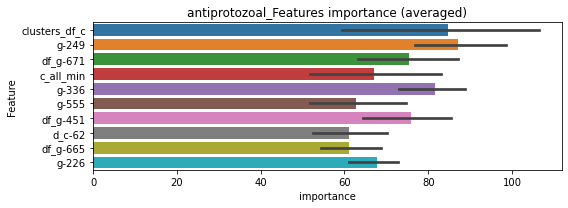

len(train_index) : 3894
len(valid_index) : 3894
================================= fold 1/2 antiprotozoal=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0207265	valid_1's binary_logloss: 0.0345872
[200]	training's binary_logloss: 0.00334989	valid_1's binary_logloss: 0.0131842
[300]	training's binary_logloss: 0.000878476	valid_1's binary_logloss: 0.00963842
Early stopping, best iteration is:
[374]	training's binary_logloss: 0.000489441	valid_1's binary_logloss: 0.00908946


len(train_index) : 3894
len(valid_index) : 3894
================================= fold 2/2 antiprotozoal=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0217791	valid_1's binary_logloss: 0.0372978
[200]	training's binary_logloss: 0.00351169	valid_1's binary_logloss: 0.0124702
[300]	training's binary_logloss: 0.000938517	valid_1's binary_logloss: 0.00696249
[400]	training's binary_logloss: 0.000434675	valid_1's binary_logloss: 0.00565262
[500]	training's binary_logloss: 0.000281698	valid_1's binary_logloss: 0.00524196
Early stopping, best iteration is:
[497]	training's binary_logloss: 0.000284563	valid_1's binary_logloss: 0.00523721


antiprotozoal logloss: 0.007163336655339694
antiviral, len(trt): 23, len(othr): 3286, target_rate: 0.0009658 → Adj_target_rate: 0.0012069


neg labels: 3289 → selected neg labels: 3286


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0282149	valid_1's binary_logloss: 0.0416827
[200]	training's binary_logloss: 0.00368516	valid_1's binary_logloss: 0.00890522
[300]	training's binary_logloss: 0.00103973	valid_1's binary_logloss: 0.00363475
[400]	training's binary_logloss: 0.000527517	valid_1's binary_logloss: 0.00239348
[500]	training's binary_logloss: 0.000380617	valid_1's binary_logloss: 0.00192746
Early stopping, best iteration is:
[516]	training's binary_logloss: 0.00037728	valid_1's binary_logloss: 0.00192091
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0288764	valid_1's binary_logloss: 0.0381132
[200]	training's binary_logloss: 0.00381964	valid_1's binary_logloss: 0.00723455
[300]	training's binary_logloss: 0.00105341	valid_1's binary_logloss: 0.00253088
[400]	training's binary_logloss: 0.000538267	valid_1's binary_logloss: 0.00151117
[500]	training's binary_logloss: 0

1 / 3 AUC score:1.000
Threshold: 0.0026533, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → positive_corect_labels: 657/3811
p_label_rate: 0.0361627 Vs.target_rate: 0.00097, Num_p_label: 144.0, conf_0:0.00027, conf_1:0.00292
Num_p_label: 144.0, Expected: 3.8, Adj_threshold_1: 0.0026533
Num_p_label: 28.0, Expected: 3.8, Adj_threshold_2: 0.0076533
Num_p_label: 14.0, Expected: 3.8, Adj_threshold_3: 0.0126533
Num_p_label: 6.0, Expected: 3.8, Adj_threshold_4: 0.0176533
threshold: 0.0176533, positive p_label: 6.0/3982, p_label_rate: 0.0015068
positive y_label: 657.0/3811, y_label_rate: 0.1723957
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0285325	valid_1's binary_logloss: 0.0407626
[200]	training's binary_logloss: 0.00366533	valid_1's binary_logloss: 0.00818057
[300]	training's binary_logloss: 0.00102514	valid_1's binary_logloss: 0.00320537
[400]	training's binary_logloss: 0.000517501	valid_1's binary_logloss: 0.00195814
[500]	training's binary_logloss: 0.000384724	valid_1's binary_logloss: 0.00162942
Early stopping, best iteration is:
[511]	training's binary_logloss: 0.000380892	valid_1's binary_logloss: 0.00161616
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0281115	valid_1's binary_logloss: 0.0364951
[200]	training's binary_logloss: 0.00359879	valid_1's binary_logloss: 0.0062525
[300]	training's binary_logloss: 0.00100641	valid_1's binary_logloss: 0.00216847
[400]	training's binary_logloss: 0.000510899	valid_1's binary_logloss: 0.00124027
[500]	training's binary_logloss: 0

2 / 3 AUC score:1.000
Threshold: 0.0176533, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 1 → positive_corect_labels: 657.0/3810
p_label_rate: 0.0042692 Vs.target_rate: 0.00097, Num_p_label: 17.0, conf_0:0.00030, conf_1:0.01942
Num_p_label: 17.0, Expected: 3.8, Adj_threshold_1: 0.0176533
Num_p_label: 13.0, Expected: 3.8, Adj_threshold_2: 0.0226533
Num_p_label: 10.0, Expected: 3.8, Adj_threshold_3: 0.0276533
Num_p_label: 7.0, Expected: 3.8, Adj_threshold_4: 0.0326533
threshold: 0.0326533, positive p_label: 7.0/3982, p_label_rate: 0.0017579
positive y_label: 657.0/3810, y_label_rate: 0.1724409
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.028642	valid_1's binary_logloss: 0.0411092
[200]	training's binary_logloss: 0.00366468	valid_1's binary_logloss: 0.00844812
[300]	training's binary_logloss: 0.00102375	valid_1's binary_logloss: 0.00350355
[400]	training's binary_logloss: 0.000519827	valid_1's binary_logloss: 0.00224912
[500]	training's binary_logloss: 0.000385913	valid_1's binary_logloss: 0.00190975
Early stopping, best iteration is:
[515]	training's binary_logloss: 0.00038081	valid_1's binary_logloss: 0.00189636
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0281405	valid_1's binary_logloss: 0.0366722
[200]	training's binary_logloss: 0.00357094	valid_1's binary_logloss: 0.00645422
[300]	training's binary_logloss: 0.000997773	valid_1's binary_logloss: 0.00229369
[400]	training's binary_logloss: 0.000502849	valid_1's binary_logloss: 0.00130647
[500]	training's binary_logloss: 0

3 / 3 AUC score:1.000
Threshold: 0.0326533, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → positive_corect_labels: 657.0/3810
p_label_rate: 0.0022602 Vs.target_rate: 0.00097, Num_p_label: 9.0, conf_0:0.00030, conf_1:0.03592
threshold: 0.0326533, positive p_label: 9.0/3982, p_label_rate: 0.0022602
positive y_label: 666.0/7792, y_label_rate: 0.0854723


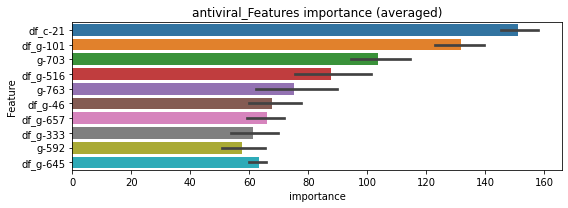

len(train_index) : 3896
len(valid_index) : 3896
================================= fold 1/2 antiviral=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0153807	valid_1's binary_logloss: 0.0260969
[200]	training's binary_logloss: 0.00201231	valid_1's binary_logloss: 0.0105454
[300]	training's binary_logloss: 0.000576821	valid_1's binary_logloss: 0.00864082
Early stopping, best iteration is:
[385]	training's binary_logloss: 0.000293014	valid_1's binary_logloss: 0.00818875


len(train_index) : 3896
len(valid_index) : 3896
================================= fold 2/2 antiviral=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0148618	valid_1's binary_logloss: 0.0233193
[200]	training's binary_logloss: 0.0019508	valid_1's binary_logloss: 0.00647198
[300]	training's binary_logloss: 0.000556988	valid_1's binary_logloss: 0.00396993
[400]	training's binary_logloss: 0.000272064	valid_1's binary_logloss: 0.00334095
Early stopping, best iteration is:
[449]	training's binary_logloss: 0.000220438	valid_1's binary_logloss: 0.00319411


antiviral logloss: 0.005691430021895459
apoptosis_stimulant, len(trt): 49, len(othr): 3281, target_rate: 0.0020576 → Adj_target_rate: 0.0022954


neg labels: 3289 → selected neg labels: 3281


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0442716	valid_1's binary_logloss: 0.0783318
[200]	training's binary_logloss: 0.00784705	valid_1's binary_logloss: 0.0321373
[300]	training's binary_logloss: 0.0022722	valid_1's binary_logloss: 0.0213496
[400]	training's binary_logloss: 0.00108789	valid_1's binary_logloss: 0.0184124
[500]	training's binary_logloss: 0.000693524	valid_1's binary_logloss: 0.0171293
Early stopping, best iteration is:
[512]	training's binary_logloss: 0.000664901	valid_1's binary_logloss: 0.0169578
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0439705	valid_1's binary_logloss: 0.0685554
[200]	training's binary_logloss: 0.00797754	valid_1's binary_logloss: 0.023171
[300]	training's binary_logloss: 0.00235187	valid_1's binary_logloss: 0.0137169
[400]	training's binary_logloss: 0.0011338	valid_1's binary_logloss: 0.0110138
Early stopping, best iteration is:
[433]	train

1 / 3 AUC score:1.000
Threshold: 0.0050848, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 134 → positive_corect_labels: 655/3803
p_label_rate: 0.0620291 Vs.target_rate: 0.00206, Num_p_label: 247.0, conf_0:0.00083, conf_1:0.00559
Num_p_label: 247.0, Expected: 8.2, Adj_threshold_1: 0.0050848
Num_p_label: 161.0, Expected: 8.2, Adj_threshold_2: 0.0100848
Num_p_label: 139.0, Expected: 8.2, Adj_threshold_3: 0.0150848
Num_p_label: 124.0, Expected: 8.2, Adj_threshold_4: 0.0200848
Num_p_label: 114.0, Expected: 8.2, Adj_threshold_5: 0.0250848
Num_p_label: 106.0, Expected: 8.2, Adj_threshold_6: 0.0300848
Num_p_label: 99.0, Expected: 8.2, Adj_threshold_7: 0.0350848
Num_p_label: 94.0, Expected: 8.2, Adj_threshold_8: 0.0400848
Num_p_label: 92.0, Expected: 8.2, Adj_threshold_9: 0.0450848
Num_p_label: 88.0, Expected: 8.2, Adj_threshold_10: 0.0500848
threshold: 0.0550848, positive p_label: 83.0/3982, p_label_rate: 0.0208438
positive y_label: 655.0/3803, y_label_rate: 0.1722324
================= Pseudo 

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.042272	valid_1's binary_logloss: 0.0738369
[200]	training's binary_logloss: 0.00731623	valid_1's binary_logloss: 0.0275111
[300]	training's binary_logloss: 0.00213516	valid_1's binary_logloss: 0.0171905
[400]	training's binary_logloss: 0.00103599	valid_1's binary_logloss: 0.0148031
Early stopping, best iteration is:
[488]	training's binary_logloss: 0.000700023	valid_1's binary_logloss: 0.0137018
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0414734	valid_1's binary_logloss: 0.0708785
[200]	training's binary_logloss: 0.0072538	valid_1's binary_logloss: 0.0267318
[300]	training's binary_logloss: 0.00216827	valid_1's binary_logloss: 0.0184607
Early stopping, best iteration is:
[376]	training's binary_logloss: 0.00121708	valid_1's binary_logloss: 0.0162139


2 / 3 AUC score:1.000
Threshold: 0.0550848, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 8 → positive_corect_labels: 650.0/3795
p_label_rate: 0.0369161 Vs.target_rate: 0.00206, Num_p_label: 147.0, conf_0:0.00109, conf_1:0.06059
Num_p_label: 147.0, Expected: 8.2, Adj_threshold_1: 0.0550848
Num_p_label: 145.0, Expected: 8.2, Adj_threshold_2: 0.0600848
Num_p_label: 144.0, Expected: 8.2, Adj_threshold_3: 0.0650848
Num_p_label: 141.0, Expected: 8.2, Adj_threshold_4: 0.0700848
Num_p_label: 138.0, Expected: 8.2, Adj_threshold_5: 0.0750848
Num_p_label: 138.0, Expected: 8.2, Adj_threshold_6: 0.0800848
Num_p_label: 134.0, Expected: 8.2, Adj_threshold_7: 0.0850848
Num_p_label: 133.0, Expected: 8.2, Adj_threshold_8: 0.0900848
Num_p_label: 131.0, Expected: 8.2, Adj_threshold_9: 0.0950848
Num_p_label: 130.0, Expected: 8.2, Adj_threshold_10: 0.1000848
threshold: 0.1050848, positive p_label: 128.0/3982, p_label_rate: 0.0321447
positive y_label: 650.0/3795, y_label_rate: 0.1712780
================= Ps

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0418911	valid_1's binary_logloss: 0.0678373
[200]	training's binary_logloss: 0.00735545	valid_1's binary_logloss: 0.0236131
[300]	training's binary_logloss: 0.00208954	valid_1's binary_logloss: 0.0131273
[400]	training's binary_logloss: 0.00101311	valid_1's binary_logloss: 0.010249
Early stopping, best iteration is:
[489]	training's binary_logloss: 0.000685217	valid_1's binary_logloss: 0.00921838
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0414364	valid_1's binary_logloss: 0.0730269
[200]	training's binary_logloss: 0.00722118	valid_1's binary_logloss: 0.0240406
[300]	training's binary_logloss: 0.00210819	valid_1's binary_logloss: 0.0140002
[400]	training's binary_logloss: 0.00101571	valid_1's binary_logloss: 0.0110829
Early stopping, best iteration is:
[417]	training's binary_logloss: 0.00092706	valid_1's binary_logloss: 0.0107601


3 / 3 AUC score:1.000
Threshold: 0.1050848, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 1 → positive_corect_labels: 650.0/3794
p_label_rate: 0.0361627 Vs.target_rate: 0.00206, Num_p_label: 144.0, conf_0:0.00095, conf_1:0.11559
Num_p_label: 144.0, Expected: 8.2, Adj_threshold_1: 0.1050848
Num_p_label: 144.0, Expected: 8.2, Adj_threshold_2: 0.1100848
Num_p_label: 143.0, Expected: 8.2, Adj_threshold_3: 0.1150848
Num_p_label: 140.0, Expected: 8.2, Adj_threshold_4: 0.1200848
Num_p_label: 140.0, Expected: 8.2, Adj_threshold_5: 0.1250848
Num_p_label: 139.0, Expected: 8.2, Adj_threshold_6: 0.1300848
Num_p_label: 139.0, Expected: 8.2, Adj_threshold_7: 0.1350848
Num_p_label: 138.0, Expected: 8.2, Adj_threshold_8: 0.1400848
Num_p_label: 137.0, Expected: 8.2, Adj_threshold_9: 0.1450848
Num_p_label: 137.0, Expected: 8.2, Adj_threshold_10: 0.1500848
threshold: 0.1550848, positive p_label: 137.0/3982, p_label_rate: 0.0344048
positive y_label: 787.0/7776, y_label_rate: 0.1012088


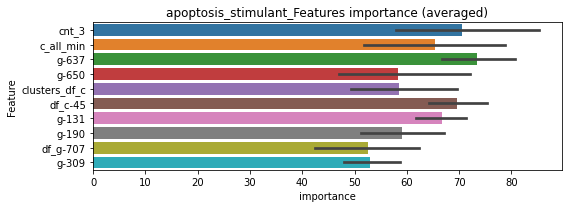

len(train_index) : 3888
len(valid_index) : 3888
================================= fold 1/2 apoptosis_stimulant=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0268931	valid_1's binary_logloss: 0.0463112
[200]	training's binary_logloss: 0.00470447	valid_1's binary_logloss: 0.0181613
[300]	training's binary_logloss: 0.00132827	valid_1's binary_logloss: 0.0118094
[400]	training's binary_logloss: 0.000606171	valid_1's binary_logloss: 0.00967944
[500]	training's binary_logloss: 0.000385366	valid_1's binary_logloss: 0.00873645
Early stopping, best iteration is:
[520]	training's binary_logloss: 0.000359331	valid_1's binary_logloss: 0.00857163


len(train_index) : 3888
len(valid_index) : 3888
================================= fold 2/2 apoptosis_stimulant=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0264718	valid_1's binary_logloss: 0.0474541
[200]	training's binary_logloss: 0.00490667	valid_1's binary_logloss: 0.018603
[300]	training's binary_logloss: 0.0013701	valid_1's binary_logloss: 0.0114334
[400]	training's binary_logloss: 0.000626512	valid_1's binary_logloss: 0.0095356
[500]	training's binary_logloss: 0.000393902	valid_1's binary_logloss: 0.0086155
Early stopping, best iteration is:
[585]	training's binary_logloss: 0.000316097	valid_1's binary_logloss: 0.00829385


apoptosis_stimulant logloss: 0.008432740523413165
aromatase_inhibitor, len(trt): 47, len(othr): 3281, target_rate: 0.0019736 → Adj_target_rate: 0.0022155


neg labels: 3289 → selected neg labels: 3281


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0404636	valid_1's binary_logloss: 0.0760922
[200]	training's binary_logloss: 0.00726691	valid_1's binary_logloss: 0.0290914
[300]	training's binary_logloss: 0.00213305	valid_1's binary_logloss: 0.0176385
[400]	training's binary_logloss: 0.00100888	valid_1's binary_logloss: 0.014569
Early stopping, best iteration is:
[486]	training's binary_logloss: 0.000683968	valid_1's binary_logloss: 0.0130825
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0444951	valid_1's binary_logloss: 0.0692929
[200]	training's binary_logloss: 0.00863902	valid_1's binary_logloss: 0.02412
[300]	training's binary_logloss: 0.00241418	valid_1's binary_logloss: 0.0119136
[400]	training's binary_logloss: 0.0011212	valid_1's binary_logloss: 0.00841446
[500]	training's binary_logloss: 0.000709045	valid_1's binary_logloss: 0.00702399
Early stopping, best iteration is:
[569]	trai

1 / 3 AUC score:1.000
Threshold: 0.0043604, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → positive_corect_labels: 656/3805
p_label_rate: 0.0404319 Vs.target_rate: 0.00197, Num_p_label: 161.0, conf_0:0.00073, conf_1:0.00480
Num_p_label: 161.0, Expected: 7.9, Adj_threshold_1: 0.0043604
Num_p_label: 32.0, Expected: 7.9, Adj_threshold_2: 0.0093604
Num_p_label: 15.0, Expected: 7.9, Adj_threshold_3: 0.0143604
threshold: 0.0143604, positive p_label: 15.0/3982, p_label_rate: 0.0037670
positive y_label: 656.0/3805, y_label_rate: 0.1724047
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0423727	valid_1's binary_logloss: 0.0756184
[200]	training's binary_logloss: 0.00771892	valid_1's binary_logloss: 0.0276601
[300]	training's binary_logloss: 0.00222001	valid_1's binary_logloss: 0.0160603
[400]	training's binary_logloss: 0.00104987	valid_1's binary_logloss: 0.0129204
Early stopping, best iteration is:
[485]	training's binary_logloss: 0.000708888	valid_1's binary_logloss: 0.0116716
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0441856	valid_1's binary_logloss: 0.0696506
[200]	training's binary_logloss: 0.00810581	valid_1's binary_logloss: 0.0232113
[300]	training's binary_logloss: 0.00230371	valid_1's binary_logloss: 0.01124
[400]	training's binary_logloss: 0.00108628	valid_1's binary_logloss: 0.00799672
[500]	training's binary_logloss: 0.000700943	valid_1's binary_logloss: 0.00663639
[600]	training's binary_logloss: 0.00055647

2 / 3 AUC score:1.000
Threshold: 0.0143604, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 2 → positive_corect_labels: 656.0/3803
p_label_rate: 0.0123054 Vs.target_rate: 0.00197, Num_p_label: 49.0, conf_0:0.00081, conf_1:0.01580
Num_p_label: 49.0, Expected: 7.9, Adj_threshold_1: 0.0143604
Num_p_label: 29.0, Expected: 7.9, Adj_threshold_2: 0.0193604
Num_p_label: 21.0, Expected: 7.9, Adj_threshold_3: 0.0243604
Num_p_label: 17.0, Expected: 7.9, Adj_threshold_4: 0.0293604
Num_p_label: 10.0, Expected: 7.9, Adj_threshold_5: 0.0343604
threshold: 0.0343604, positive p_label: 10.0/3982, p_label_rate: 0.0025113
positive y_label: 656.0/3803, y_label_rate: 0.1724954
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0423129	valid_1's binary_logloss: 0.0733054
[200]	training's binary_logloss: 0.00758684	valid_1's binary_logloss: 0.0272057
[300]	training's binary_logloss: 0.00217614	valid_1's binary_logloss: 0.0157369
[400]	training's binary_logloss: 0.00103967	valid_1's binary_logloss: 0.0129794
[500]	training's binary_logloss: 0.000673072	valid_1's binary_logloss: 0.0115252
Early stopping, best iteration is:
[497]	training's binary_logloss: 0.000679411	valid_1's binary_logloss: 0.0115101
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0451254	valid_1's binary_logloss: 0.0716718
[200]	training's binary_logloss: 0.00814361	valid_1's binary_logloss: 0.0222628
[300]	training's binary_logloss: 0.00231889	valid_1's binary_logloss: 0.0106851
[400]	training's binary_logloss: 0.00110693	valid_1's binary_logloss: 0.00733468
[500]	training's binary_logloss: 0.0007082

3 / 3 AUC score:1.000
Threshold: 0.0343604, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → positive_corect_labels: 656.0/3803
p_label_rate: 0.0025113 Vs.target_rate: 0.00197, Num_p_label: 10.0, conf_0:0.00084, conf_1:0.03780
threshold: 0.0343604, positive p_label: 10.0/3982, p_label_rate: 0.0025113
positive y_label: 666.0/7785, y_label_rate: 0.0855491


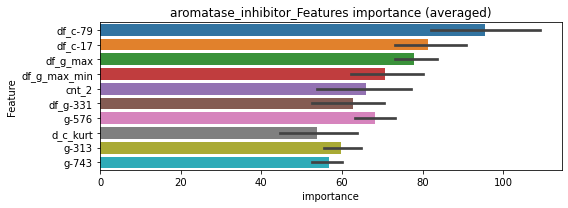

len(train_index) : 3892
len(valid_index) : 3893
================================= fold 1/2 aromatase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0254208	valid_1's binary_logloss: 0.0478703
[200]	training's binary_logloss: 0.00460244	valid_1's binary_logloss: 0.0224
[300]	training's binary_logloss: 0.00126622	valid_1's binary_logloss: 0.018141
Early stopping, best iteration is:
[315]	training's binary_logloss: 0.00108994	valid_1's binary_logloss: 0.0179174


len(train_index) : 3893
len(valid_index) : 3892
================================= fold 2/2 aromatase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0251164	valid_1's binary_logloss: 0.0408291
[200]	training's binary_logloss: 0.00470842	valid_1's binary_logloss: 0.0161379
[300]	training's binary_logloss: 0.0013168	valid_1's binary_logloss: 0.010533
[400]	training's binary_logloss: 0.000604235	valid_1's binary_logloss: 0.00898923
Early stopping, best iteration is:
[438]	training's binary_logloss: 0.000490609	valid_1's binary_logloss: 0.008682


aromatase_inhibitor logloss: 0.013300270415210771
atm_kinase_inhibitor, len(trt): 6, len(othr): 3288, target_rate: 0.0002520 → Adj_target_rate: 0.0003851


neg labels: 3289 → selected neg labels: 3288


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0154747	valid_1's binary_logloss: 0.0162492
[200]	training's binary_logloss: 0.0012421	valid_1's binary_logloss: 0.00145967
[300]	training's binary_logloss: 0.000334747	valid_1's binary_logloss: 0.000458139
[400]	training's binary_logloss: 0.000211963	valid_1's binary_logloss: 0.000301977
[500]	training's binary_logloss: 0.000185509	valid_1's binary_logloss: 0.000266693
Early stopping, best iteration is:
[560]	training's binary_logloss: 0.000183	valid_1's binary_logloss: 0.000263374
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.015523	valid_1's binary_logloss: 0.0178308
[200]	training's binary_logloss: 0.00124419	valid_1's binary_logloss: 0.00255516
[300]	training's binary_logloss: 0.000332249	valid_1's binary_logloss: 0.00148198


1 / 3 AUC score:1.000
Threshold: 0.0009243, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → positive_corect_labels: 657/3813
p_label_rate: 0.0399297 Vs.target_rate: 0.00025, Num_p_label: 159.0, conf_0:0.00011, conf_1:0.00102
Num_p_label: 159.0, Expected: 1.0, Adj_threshold_1: 0.0009243


Early stopping, best iteration is:
[331]	training's binary_logloss: 0.000272522	valid_1's binary_logloss: 0.00142094


Num_p_label: 17.0, Expected: 1.0, Adj_threshold_2: 0.0059243
Num_p_label: 11.0, Expected: 1.0, Adj_threshold_3: 0.0109243
Num_p_label: 7.0, Expected: 1.0, Adj_threshold_4: 0.0159243
Num_p_label: 2.0, Expected: 1.0, Adj_threshold_5: 0.0209243
threshold: 0.0209243, positive p_label: 2.0/3982, p_label_rate: 0.0005023
positive y_label: 657.0/3813, y_label_rate: 0.1723053
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0158642	valid_1's binary_logloss: 0.0165621
[200]	training's binary_logloss: 0.00123751	valid_1's binary_logloss: 0.00146827
[300]	training's binary_logloss: 0.00031714	valid_1's binary_logloss: 0.00043156
[400]	training's binary_logloss: 0.000199672	valid_1's binary_logloss: 0.000287011
[500]	training's binary_logloss: 0.000180564	valid_1's binary_logloss: 0.000263052
[600]	training's binary_logloss: 0.000176051	valid_1's binary_logloss: 0.000257606
[700]	training's binary_logloss: 0.000174356	valid_1's binary_logloss: 0.000255564
[800]	training's binary_logloss: 0.000172981	valid_1's binary_logloss: 0.000253882
[900]	training's binary_logloss: 0.000172083	valid_1's binary_logloss: 0.000252803
Early stopping, best iteration is:
[903]	training's binary_logloss: 0.00017207	valid_1's binary_logloss: 0.000252788
Training until validation scores don't improve for 10 rounds
[100]	training's binar

2 / 3 AUC score:1.000
Threshold: 0.0209243, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → positive_corect_labels: 657.0/3813
p_label_rate: 0.0062783 Vs.target_rate: 0.00025, Num_p_label: 25.0, conf_0:0.00008, conf_1:0.02302
Num_p_label: 25.0, Expected: 1.0, Adj_threshold_1: 0.0209243
Num_p_label: 21.0, Expected: 1.0, Adj_threshold_2: 0.0259243
Num_p_label: 20.0, Expected: 1.0, Adj_threshold_3: 0.0309243
Num_p_label: 18.0, Expected: 1.0, Adj_threshold_4: 0.0359243
Num_p_label: 16.0, Expected: 1.0, Adj_threshold_5: 0.0409243
Num_p_label: 14.0, Expected: 1.0, Adj_threshold_6: 0.0459243
Num_p_label: 14.0, Expected: 1.0, Adj_threshold_7: 0.0509243
Num_p_label: 14.0, Expected: 1.0, Adj_threshold_8: 0.0559243
Num_p_label: 12.0, Expected: 1.0, Adj_threshold_9: 0.0609243
Num_p_label: 12.0, Expected: 1.0, Adj_threshold_10: 0.0659243
threshold: 0.0709243, positive p_label: 12.0/3982, p_label_rate: 0.0030136
positive y_label: 657.0/3813, y_label_rate: 0.1723053
================= Pseudo labelin

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0158642	valid_1's binary_logloss: 0.0165621
[200]	training's binary_logloss: 0.00123751	valid_1's binary_logloss: 0.00146827
[300]	training's binary_logloss: 0.00031714	valid_1's binary_logloss: 0.00043156
[400]	training's binary_logloss: 0.000199672	valid_1's binary_logloss: 0.000287011
[500]	training's binary_logloss: 0.000180564	valid_1's binary_logloss: 0.000263052
[600]	training's binary_logloss: 0.000176051	valid_1's binary_logloss: 0.000257606
[700]	training's binary_logloss: 0.000174356	valid_1's binary_logloss: 0.000255564
[800]	training's binary_logloss: 0.000172981	valid_1's binary_logloss: 0.000253882
[900]	training's binary_logloss: 0.000172083	valid_1's binary_logloss: 0.000252803
Early stopping, best iteration is:
[903]	training's binary_logloss: 0.00017207	valid_1's binary_logloss: 0.000252788
Training until validation scores don't improve for 10 rounds
[100]	training's binar

3 / 3 AUC score:1.000
Threshold: 0.0709243, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → positive_corect_labels: 657.0/3813
p_label_rate: 0.0030136 Vs.target_rate: 0.00025, Num_p_label: 12.0, conf_0:0.00008, conf_1:0.07802
Num_p_label: 12.0, Expected: 1.0, Adj_threshold_1: 0.0709243
Num_p_label: 11.0, Expected: 1.0, Adj_threshold_2: 0.0759243
Num_p_label: 11.0, Expected: 1.0, Adj_threshold_3: 0.0809243
Num_p_label: 11.0, Expected: 1.0, Adj_threshold_4: 0.0859243
Num_p_label: 11.0, Expected: 1.0, Adj_threshold_5: 0.0909243
Num_p_label: 10.0, Expected: 1.0, Adj_threshold_6: 0.0959243
Num_p_label: 10.0, Expected: 1.0, Adj_threshold_7: 0.1009243
Num_p_label: 10.0, Expected: 1.0, Adj_threshold_8: 0.1059243
Num_p_label: 10.0, Expected: 1.0, Adj_threshold_9: 0.1109243
Num_p_label: 10.0, Expected: 1.0, Adj_threshold_10: 0.1159243
threshold: 0.1209243, positive p_label: 10.0/3982, p_label_rate: 0.0025113
positive y_label: 667.0/7795, y_label_rate: 0.0855677


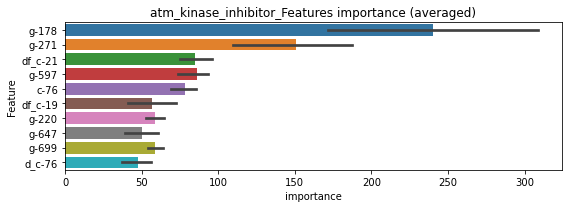

len(train_index) : 3897
len(valid_index) : 3898
================================= fold 1/2 atm_kinase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.00876767	valid_1's binary_logloss: 0.0126417
[200]	training's binary_logloss: 0.000719514	valid_1's binary_logloss: 0.0056547


len(train_index) : 3898
len(valid_index) : 3897


Early stopping, best iteration is:
[216]	training's binary_logloss: 0.000526239	valid_1's binary_logloss: 0.00547458


================================= fold 2/2 atm_kinase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.00900769	valid_1's binary_logloss: 0.00991655
[200]	training's binary_logloss: 0.000769563	valid_1's binary_logloss: 0.00209631
[300]	training's binary_logloss: 0.000202889	valid_1's binary_logloss: 0.00146631
Early stopping, best iteration is:
[301]	training's binary_logloss: 0.000201394	valid_1's binary_logloss: 0.00146047


atm_kinase_inhibitor logloss: 0.003467781335048697
atp-sensitive_potassium_channel_antagonist, len(trt): 7, len(othr): 3287, target_rate: 0.0002939 → Adj_target_rate: 0.0004391


neg labels: 3289 → selected neg labels: 3287


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0162468	valid_1's binary_logloss: 0.0174674
[200]	training's binary_logloss: 0.00142273	valid_1's binary_logloss: 0.00181189
[300]	training's binary_logloss: 0.000394127	valid_1's binary_logloss: 0.000614398
[400]	training's binary_logloss: 0.000240621	valid_1's binary_logloss: 0.00039417
[500]	training's binary_logloss: 0.000214835	valid_1's binary_logloss: 0.000353574
Early stopping, best iteration is:
[524]	training's binary_logloss: 0.000214206	valid_1's binary_logloss: 0.000352391
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0164906	valid_1's binary_logloss: 0.0176416
[200]	training's binary_logloss: 0.00144068	valid_1's binary_logloss: 0.00172771
[300]	training's binary_logloss: 0.000400522	valid_1's binary_logloss: 0.000549661
[400]	training's binary_logloss: 0.000241359	valid_1's binary_logloss: 0.000348178
[500]	training's binary_lo

1 / 3 AUC score:1.000
Threshold: 0.0006465, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → positive_corect_labels: 657/3812
p_label_rate: 0.0346560 Vs.target_rate: 0.00029, Num_p_label: 138.0, conf_0:0.00011, conf_1:0.00071
Num_p_label: 138.0, Expected: 1.2, Adj_threshold_1: 0.0006465
Num_p_label: 12.0, Expected: 1.2, Adj_threshold_2: 0.0056465
Num_p_label: 6.0, Expected: 1.2, Adj_threshold_3: 0.0106465
Num_p_label: 2.0, Expected: 1.2, Adj_threshold_4: 0.0156465
threshold: 0.0156465, positive p_label: 2.0/3982, p_label_rate: 0.0005023
positive y_label: 657.0/3812, y_label_rate: 0.1723505
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.016469	valid_1's binary_logloss: 0.0174529
[200]	training's binary_logloss: 0.00139633	valid_1's binary_logloss: 0.00188212
[300]	training's binary_logloss: 0.000384867	valid_1's binary_logloss: 0.000691083
[400]	training's binary_logloss: 0.000237504	valid_1's binary_logloss: 0.000498596
[500]	training's binary_logloss: 0.000209566	valid_1's binary_logloss: 0.000461424
Early stopping, best iteration is:
[515]	training's binary_logloss: 0.00020861	valid_1's binary_logloss: 0.000460888
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0167206	valid_1's binary_logloss: 0.0175773
[200]	training's binary_logloss: 0.00142108	valid_1's binary_logloss: 0.00159837
[300]	training's binary_logloss: 0.0003858	valid_1's binary_logloss: 0.000466871
[400]	training's binary_logloss: 0.000236841	valid_1's binary_logloss: 0.000291997
[500]	training's binary_loglo

2 / 3 AUC score:1.000
Threshold: 0.0156465, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → positive_corect_labels: 657.0/3812
p_label_rate: 0.0035158 Vs.target_rate: 0.00029, Num_p_label: 14.0, conf_0:0.00012, conf_1:0.01721
Num_p_label: 14.0, Expected: 1.2, Adj_threshold_1: 0.0156465
Num_p_label: 12.0, Expected: 1.2, Adj_threshold_2: 0.0206465
Num_p_label: 10.0, Expected: 1.2, Adj_threshold_3: 0.0256465
Num_p_label: 10.0, Expected: 1.2, Adj_threshold_4: 0.0306465
Num_p_label: 7.0, Expected: 1.2, Adj_threshold_5: 0.0356465
Num_p_label: 6.0, Expected: 1.2, Adj_threshold_6: 0.0406465
Num_p_label: 5.0, Expected: 1.2, Adj_threshold_7: 0.0456465
Num_p_label: 5.0, Expected: 1.2, Adj_threshold_8: 0.0506465
Num_p_label: 5.0, Expected: 1.2, Adj_threshold_9: 0.0556465
Num_p_label: 4.0, Expected: 1.2, Adj_threshold_10: 0.0606465
threshold: 0.0656465, positive p_label: 4.0/3982, p_label_rate: 0.0010045
positive y_label: 657.0/3812, y_label_rate: 0.1723505
================= Pseudo labeling 3 / 3

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.016469	valid_1's binary_logloss: 0.0174529
[200]	training's binary_logloss: 0.00139633	valid_1's binary_logloss: 0.00188212
[300]	training's binary_logloss: 0.000384867	valid_1's binary_logloss: 0.000691083
[400]	training's binary_logloss: 0.000237504	valid_1's binary_logloss: 0.000498596
[500]	training's binary_logloss: 0.000209566	valid_1's binary_logloss: 0.000461424
Early stopping, best iteration is:
[515]	training's binary_logloss: 0.00020861	valid_1's binary_logloss: 0.000460888
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0167206	valid_1's binary_logloss: 0.0175773
[200]	training's binary_logloss: 0.00142108	valid_1's binary_logloss: 0.00159837
[300]	training's binary_logloss: 0.0003858	valid_1's binary_logloss: 0.000466871
[400]	training's binary_logloss: 0.000236841	valid_1's binary_logloss: 0.000291997
[500]	training's binary_loglo

3 / 3 AUC score:1.000
Threshold: 0.0656465, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → positive_corect_labels: 657.0/3812
p_label_rate: 0.0010045 Vs.target_rate: 0.00029, Num_p_label: 4.0, conf_0:0.00012, conf_1:0.07221
Num_p_label: 4.0, Expected: 1.2, Adj_threshold_1: 0.0656465
Num_p_label: 3.0, Expected: 1.2, Adj_threshold_2: 0.0706465
Num_p_label: 3.0, Expected: 1.2, Adj_threshold_3: 0.0756465
Num_p_label: 3.0, Expected: 1.2, Adj_threshold_4: 0.0806465
Num_p_label: 3.0, Expected: 1.2, Adj_threshold_5: 0.0856465
Num_p_label: 3.0, Expected: 1.2, Adj_threshold_6: 0.0906465
Num_p_label: 3.0, Expected: 1.2, Adj_threshold_7: 0.0956465
Num_p_label: 1.0, Expected: 1.2, Adj_threshold_8: 0.1006465
threshold: 0.1006465, positive p_label: 1.0/3982, p_label_rate: 0.0002511
positive y_label: 658.0/7794, y_label_rate: 0.0844239


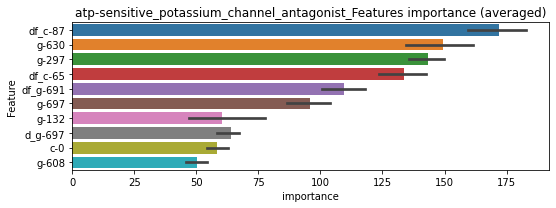

len(train_index) : 3897
len(valid_index) : 3897
================================= fold 1/2 atp-sensitive_potassium_channel_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.00865661	valid_1's binary_logloss: 0.00957241
[200]	training's binary_logloss: 0.000711681	valid_1's binary_logloss: 0.0011676
[300]	training's binary_logloss: 0.000192951	valid_1's binary_logloss: 0.000636854
Early stopping, best iteration is:
[324]	training's binary_logloss: 0.000162884	valid_1's binary_logloss: 0.000611437


len(train_index) : 3897
len(valid_index) : 3897
================================= fold 2/2 atp-sensitive_potassium_channel_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0086619	valid_1's binary_logloss: 0.00984901
[200]	training's binary_logloss: 0.000716482	valid_1's binary_logloss: 0.00109992
[300]	training's binary_logloss: 0.000195355	valid_1's binary_logloss: 0.000392358
[400]	training's binary_logloss: 0.000119984	valid_1's binary_logloss: 0.00026577
Early stopping, best iteration is:
[484]	training's binary_logloss: 0.000107865	valid_1's binary_logloss: 0.000248158


atp-sensitive_potassium_channel_antagonist logloss: 0.00042979764691230236
atp_synthase_inhibitor, len(trt): 12, len(othr): 3287, target_rate: 0.0005039 → Adj_target_rate: 0.0006942


neg labels: 3289 → selected neg labels: 3287


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0152612	valid_1's binary_logloss: 0.0183005
[200]	training's binary_logloss: 0.00117773	valid_1's binary_logloss: 0.00351273
[300]	training's binary_logloss: 0.000291189	valid_1's binary_logloss: 0.00251352
Early stopping, best iteration is:
[331]	training's binary_logloss: 0.00023807	valid_1's binary_logloss: 0.00244408
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0158305	valid_1's binary_logloss: 0.0161368
[200]	training's binary_logloss: 0.0012684	valid_1's binary_logloss: 0.00174466
[300]	training's binary_logloss: 0.000328533	valid_1's binary_logloss: 0.000782973
[400]	training's binary_logloss: 0.000205701	valid_1's binary_logloss: 0.0006002


1 / 3 AUC score:1.000
Threshold: 0.0005687, pos_neg_ratio: 0.8000000


Early stopping, best iteration is:
[460]	training's binary_logloss: 0.000188298	valid_1's binary_logloss: 0.000574165


Remove_noisy_labels: 132 → positive_corect_labels: 657/3812
p_label_rate: 0.0660472 Vs.target_rate: 0.00050, Num_p_label: 263.0, conf_0:0.00007, conf_1:0.00063
Num_p_label: 263.0, Expected: 2.0, Adj_threshold_1: 0.0005687
Num_p_label: 28.0, Expected: 2.0, Adj_threshold_2: 0.0055687
Num_p_label: 20.0, Expected: 2.0, Adj_threshold_3: 0.0105687
Num_p_label: 15.0, Expected: 2.0, Adj_threshold_4: 0.0155687
Num_p_label: 13.0, Expected: 2.0, Adj_threshold_5: 0.0205687
Num_p_label: 13.0, Expected: 2.0, Adj_threshold_6: 0.0255687
Num_p_label: 12.0, Expected: 2.0, Adj_threshold_7: 0.0305687
Num_p_label: 11.0, Expected: 2.0, Adj_threshold_8: 0.0355687
Num_p_label: 11.0, Expected: 2.0, Adj_threshold_9: 0.0405687
Num_p_label: 10.0, Expected: 2.0, Adj_threshold_10: 0.0455687
threshold: 0.0505687, positive p_label: 9.0/3982, p_label_rate: 0.0022602
positive y_label: 657.0/3812, y_label_rate: 0.1723505
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0155304	valid_1's binary_logloss: 0.0160327
[200]	training's binary_logloss: 0.00115126	valid_1's binary_logloss: 0.00123441
[300]	training's binary_logloss: 0.000268273	valid_1's binary_logloss: 0.000296989
[400]	training's binary_logloss: 0.000173939	valid_1's binary_logloss: 0.000196049
[500]	training's binary_logloss: 0.000155587	valid_1's binary_logloss: 0.000176614
Early stopping, best iteration is:
[518]	training's binary_logloss: 0.000154415	valid_1's binary_logloss: 0.000175461
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0154645	valid_1's binary_logloss: 0.0157222
[200]	training's binary_logloss: 0.00112058	valid_1's binary_logloss: 0.00133476
[300]	training's binary_logloss: 0.000260206	valid_1's binary_logloss: 0.000411157
[400]	training's binary_logloss: 0.000169644	valid_1's binary_logloss: 0.000308219
[500]	training's binary_l

2 / 3 AUC score:1.000
Threshold: 0.0505687, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 1 → positive_corect_labels: 657.0/3811
p_label_rate: 0.0341537 Vs.target_rate: 0.00050, Num_p_label: 136.0, conf_0:0.00006, conf_1:0.05563
Num_p_label: 136.0, Expected: 2.0, Adj_threshold_1: 0.0505687
Num_p_label: 130.0, Expected: 2.0, Adj_threshold_2: 0.0555687
Num_p_label: 121.0, Expected: 2.0, Adj_threshold_3: 0.0605687
Num_p_label: 117.0, Expected: 2.0, Adj_threshold_4: 0.0655687
Num_p_label: 112.0, Expected: 2.0, Adj_threshold_5: 0.0705687
Num_p_label: 110.0, Expected: 2.0, Adj_threshold_6: 0.0755687
Num_p_label: 105.0, Expected: 2.0, Adj_threshold_7: 0.0805687
Num_p_label: 99.0, Expected: 2.0, Adj_threshold_8: 0.0855687
Num_p_label: 88.0, Expected: 2.0, Adj_threshold_9: 0.0905687
Num_p_label: 84.0, Expected: 2.0, Adj_threshold_10: 0.0955687
threshold: 0.1005687, positive p_label: 68.0/3982, p_label_rate: 0.0170768
positive y_label: 657.0/3811, y_label_rate: 0.1723957
================= Pseudo

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0154948	valid_1's binary_logloss: 0.0159864
[200]	training's binary_logloss: 0.00112613	valid_1's binary_logloss: 0.00123407
[300]	training's binary_logloss: 0.000261364	valid_1's binary_logloss: 0.000305457
[400]	training's binary_logloss: 0.000170154	valid_1's binary_logloss: 0.00020687
[500]	training's binary_logloss: 0.000152662	valid_1's binary_logloss: 0.000186982
[600]	training's binary_logloss: 0.000147745	valid_1's binary_logloss: 0.000180722
Early stopping, best iteration is:
[649]	training's binary_logloss: 0.00014717	valid_1's binary_logloss: 0.000180025
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0155642	valid_1's binary_logloss: 0.0161395
[200]	training's binary_logloss: 0.00113158	valid_1's binary_logloss: 0.00132353
[300]	training's binary_logloss: 0.000260772	valid_1's binary_logloss: 0.000356422
[400]	training's binary_log

3 / 3 AUC score:1.000
Threshold: 0.1005687, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → positive_corect_labels: 657.0/3811
p_label_rate: 0.0228528 Vs.target_rate: 0.00050, Num_p_label: 91.0, conf_0:0.00006, conf_1:0.11063
Num_p_label: 91.0, Expected: 2.0, Adj_threshold_1: 0.1005687
Num_p_label: 83.0, Expected: 2.0, Adj_threshold_2: 0.1055687
Num_p_label: 74.0, Expected: 2.0, Adj_threshold_3: 0.1105687
Num_p_label: 62.0, Expected: 2.0, Adj_threshold_4: 0.1155687
Num_p_label: 54.0, Expected: 2.0, Adj_threshold_5: 0.1205687
Num_p_label: 42.0, Expected: 2.0, Adj_threshold_6: 0.1255687
Num_p_label: 33.0, Expected: 2.0, Adj_threshold_7: 0.1305687
Num_p_label: 28.0, Expected: 2.0, Adj_threshold_8: 0.1355687
Num_p_label: 26.0, Expected: 2.0, Adj_threshold_9: 0.1405687
Num_p_label: 25.0, Expected: 2.0, Adj_threshold_10: 0.1455687
threshold: 0.1505687, positive p_label: 20.0/3982, p_label_rate: 0.0050226
positive y_label: 677.0/7793, y_label_rate: 0.0868728


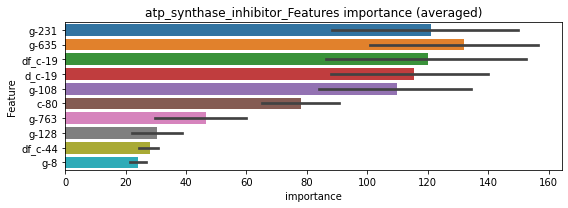

len(train_index) : 3896
len(valid_index) : 3897
================================= fold 1/2 atp_synthase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.00936333	valid_1's binary_logloss: 0.0143262
[200]	training's binary_logloss: 0.000850753	valid_1's binary_logloss: 0.00624146
[300]	training's binary_logloss: 0.00023124	valid_1's binary_logloss: 0.00571363
Early stopping, best iteration is:
[304]	training's binary_logloss: 0.00022331	valid_1's binary_logloss: 0.00569128


len(train_index) : 3897
len(valid_index) : 3896
================================= fold 2/2 atp_synthase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.00985445	valid_1's binary_logloss: 0.0138487
[200]	training's binary_logloss: 0.000916247	valid_1's binary_logloss: 0.00709568
Early stopping, best iteration is:
[200]	training's binary_logloss: 0.000916247	valid_1's binary_logloss: 0.00709568


atp_synthase_inhibitor logloss: 0.006393391252841695
atpase_inhibitor, len(trt): 97, len(othr): 3273, target_rate: 0.0040732 → Adj_target_rate: 0.0041016


neg labels: 3289 → selected neg labels: 3273


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0598756	valid_1's binary_logloss: 0.117938
[200]	training's binary_logloss: 0.0138503	valid_1's binary_logloss: 0.0645824
[300]	training's binary_logloss: 0.00431176	valid_1's binary_logloss: 0.0484413
[400]	training's binary_logloss: 0.00191183	valid_1's binary_logloss: 0.0420001
[500]	training's binary_logloss: 0.00114113	valid_1's binary_logloss: 0.0390465
Early stopping, best iteration is:
[490]	training's binary_logloss: 0.00118565	valid_1's binary_logloss: 0.0389324
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0601052	valid_1's binary_logloss: 0.12979
[200]	training's binary_logloss: 0.0144498	valid_1's binary_logloss: 0.0775682
[300]	training's binary_logloss: 0.00429327	valid_1's binary_logloss: 0.0654195
[400]	training's binary_logloss: 0.00191998	valid_1's binary_logloss: 0.0614798
Early stopping, best iteration is:
[424]	training'

1 / 3 AUC score:0.998
Threshold: 0.0145766, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 150 → positive_corect_labels: 645/3777
p_label_rate: 0.0582622 Vs.target_rate: 0.00407, Num_p_label: 232.0, conf_0:0.00179, conf_1:0.01603
Num_p_label: 232.0, Expected: 16.2, Adj_threshold_1: 0.0145766
Num_p_label: 187.0, Expected: 16.2, Adj_threshold_2: 0.0195766
Num_p_label: 152.0, Expected: 16.2, Adj_threshold_3: 0.0245766
Num_p_label: 126.0, Expected: 16.2, Adj_threshold_4: 0.0295766
Num_p_label: 105.0, Expected: 16.2, Adj_threshold_5: 0.0345766
Num_p_label: 89.0, Expected: 16.2, Adj_threshold_6: 0.0395766
Num_p_label: 77.0, Expected: 16.2, Adj_threshold_7: 0.0445766
Num_p_label: 73.0, Expected: 16.2, Adj_threshold_8: 0.0495766
Num_p_label: 67.0, Expected: 16.2, Adj_threshold_9: 0.0545766
Num_p_label: 59.0, Expected: 16.2, Adj_threshold_10: 0.0595766
threshold: 0.0645766, positive p_label: 50.0/3982, p_label_rate: 0.0125565
positive y_label: 645.0/3777, y_label_rate: 0.1707705
================

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0550738	valid_1's binary_logloss: 0.121534
[200]	training's binary_logloss: 0.0118871	valid_1's binary_logloss: 0.071672
[300]	training's binary_logloss: 0.00353872	valid_1's binary_logloss: 0.0575502
Early stopping, best iteration is:
[375]	training's binary_logloss: 0.00190696	valid_1's binary_logloss: 0.0547468
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0561363	valid_1's binary_logloss: 0.10834
[200]	training's binary_logloss: 0.0124578	valid_1's binary_logloss: 0.056095
[300]	training's binary_logloss: 0.00380571	valid_1's binary_logloss: 0.0424274
[400]	training's binary_logloss: 0.00174908	valid_1's binary_logloss: 0.0377389
[500]	training's binary_logloss: 0.00106641	valid_1's binary_logloss: 0.0352302
Early stopping, best iteration is:
[499]	training's binary_logloss: 0.00107004	valid_1's binary_logloss: 0.0352054


2 / 3 AUC score:0.998
Threshold: 0.0645766, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 27 → positive_corect_labels: 630.0/3750
p_label_rate: 0.0477147 Vs.target_rate: 0.00407, Num_p_label: 190.0, conf_0:0.00195, conf_1:0.07103
Num_p_label: 190.0, Expected: 16.2, Adj_threshold_1: 0.0645766
Num_p_label: 180.0, Expected: 16.2, Adj_threshold_2: 0.0695766
Num_p_label: 174.0, Expected: 16.2, Adj_threshold_3: 0.0745766
Num_p_label: 167.0, Expected: 16.2, Adj_threshold_4: 0.0795766
Num_p_label: 158.0, Expected: 16.2, Adj_threshold_5: 0.0845766
Num_p_label: 153.0, Expected: 16.2, Adj_threshold_6: 0.0895766
Num_p_label: 147.0, Expected: 16.2, Adj_threshold_7: 0.0945766
Num_p_label: 140.0, Expected: 16.2, Adj_threshold_8: 0.0995766
Num_p_label: 136.0, Expected: 16.2, Adj_threshold_9: 0.1045766
Num_p_label: 133.0, Expected: 16.2, Adj_threshold_10: 0.1095766
threshold: 0.1145766, positive p_label: 130.0/3982, p_label_rate: 0.0326469
positive y_label: 630.0/3750, y_label_rate: 0.1680000
=========

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0494309	valid_1's binary_logloss: 0.120046
[200]	training's binary_logloss: 0.0101073	valid_1's binary_logloss: 0.0754338
[300]	training's binary_logloss: 0.00309606	valid_1's binary_logloss: 0.065154
Early stopping, best iteration is:
[314]	training's binary_logloss: 0.00272805	valid_1's binary_logloss: 0.0643763
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0559705	valid_1's binary_logloss: 0.105253
[200]	training's binary_logloss: 0.0122147	valid_1's binary_logloss: 0.0504539
[300]	training's binary_logloss: 0.00352585	valid_1's binary_logloss: 0.0320481
[400]	training's binary_logloss: 0.00161902	valid_1's binary_logloss: 0.0270904
[500]	training's binary_logloss: 0.000995262	valid_1's binary_logloss: 0.0246942
Early stopping, best iteration is:
[567]	training's binary_logloss: 0.000794503	valid_1's binary_logloss: 0.023654


3 / 3 AUC score:0.999
Threshold: 0.1145766, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 31 → positive_corect_labels: 605.0/3719
p_label_rate: 0.0452034 Vs.target_rate: 0.00407, Num_p_label: 180.0, conf_0:0.00216, conf_1:0.12603
Num_p_label: 180.0, Expected: 16.2, Adj_threshold_1: 0.1145766
Num_p_label: 173.0, Expected: 16.2, Adj_threshold_2: 0.1195766
Num_p_label: 161.0, Expected: 16.2, Adj_threshold_3: 0.1245766
Num_p_label: 158.0, Expected: 16.2, Adj_threshold_4: 0.1295766
Num_p_label: 154.0, Expected: 16.2, Adj_threshold_5: 0.1345766
Num_p_label: 149.0, Expected: 16.2, Adj_threshold_6: 0.1395766
Num_p_label: 146.0, Expected: 16.2, Adj_threshold_7: 0.1445766
Num_p_label: 142.0, Expected: 16.2, Adj_threshold_8: 0.1495766
Num_p_label: 138.0, Expected: 16.2, Adj_threshold_9: 0.1545766
Num_p_label: 136.0, Expected: 16.2, Adj_threshold_10: 0.1595766
threshold: 0.1645766, positive p_label: 135.0/3982, p_label_rate: 0.0339026
positive y_label: 740.0/7701, y_label_rate: 0.0960914


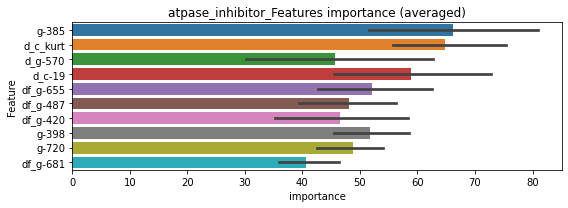

len(train_index) : 3850
len(valid_index) : 3851
================================= fold 1/2 atpase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0345965	valid_1's binary_logloss: 0.0772025
[200]	training's binary_logloss: 0.00788127	valid_1's binary_logloss: 0.0485487
[300]	training's binary_logloss: 0.00240316	valid_1's binary_logloss: 0.0417101
Early stopping, best iteration is:
[372]	training's binary_logloss: 0.00130927	valid_1's binary_logloss: 0.0400482


len(train_index) : 3851
len(valid_index) : 3850
================================= fold 2/2 atpase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0348811	valid_1's binary_logloss: 0.07268
[200]	training's binary_logloss: 0.0077626	valid_1's binary_logloss: 0.0461631
[300]	training's binary_logloss: 0.00235461	valid_1's binary_logloss: 0.0391101
Early stopping, best iteration is:
[320]	training's binary_logloss: 0.00194792	valid_1's binary_logloss: 0.0382565


atpase_inhibitor logloss: 0.03915243347450235


  acetylcholine_receptor_agonist acetylcholine_receptor_antagonist  \
0                       df_g-122                              c-30   
1                  clusters_df_c                         c_all_max   
2                          cnt_0                    clusters_g_all   
3                      c_all_min                          df_g-707   
4                        df_g-51                        clusters_g   
5                       df_c_min                          df_c_min   
6                          cnt_2                             g-514   
7                       df_g-736                          df_g-640   
8                          g-244                            df_c-6   
9                           c-73                          df_g-597   

  acetylcholinesterase_inhibitor adenosine_receptor_antagonist  \
0                      c_all_max                clusters_c_all   
1                      c_all_min                      df_c_min   
2                 clusters_g_al

atr_kinase_inhibitor, len(trt): 19, len(othr): 3286, target_rate: 0.0007979 → Adj_target_rate: 0.0010260


neg labels: 3289 → selected neg labels: 3286


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0196445	valid_1's binary_logloss: 0.0278697
[200]	training's binary_logloss: 0.00201287	valid_1's binary_logloss: 0.00570054
[300]	training's binary_logloss: 0.000563008	valid_1's binary_logloss: 0.00302221
[400]	training's binary_logloss: 0.000323128	valid_1's binary_logloss: 0.00238924
Early stopping, best iteration is:
[481]	training's binary_logloss: 0.000280837	valid_1's binary_logloss: 0.00222085
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0199248	valid_1's binary_logloss: 0.0247066
[200]	training's binary_logloss: 0.00205046	valid_1's binary_logloss: 0.00439585
[300]	training's binary_logloss: 0.00058487	valid_1's binary_logloss: 0.00193384
[400]	training's binary_logloss: 0.000338699	valid_1's binary_logloss: 0.00136274
[500]	training's binary_logloss: 0.000289273	valid_1's binary_logloss: 0.00122611
Early stopping, best iteration i

1 / 3 AUC score:1.000
Threshold: 0.0017461, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → positive_corect_labels: 657/3811
p_label_rate: 0.0457057 Vs.target_rate: 0.00080, Num_p_label: 182.0, conf_0:0.00010, conf_1:0.00192
Num_p_label: 182.0, Expected: 3.2, Adj_threshold_1: 0.0017461
Num_p_label: 57.0, Expected: 3.2, Adj_threshold_2: 0.0067461
Num_p_label: 40.0, Expected: 3.2, Adj_threshold_3: 0.0117461
Num_p_label: 32.0, Expected: 3.2, Adj_threshold_4: 0.0167461
Num_p_label: 27.0, Expected: 3.2, Adj_threshold_5: 0.0217461
Num_p_label: 25.0, Expected: 3.2, Adj_threshold_6: 0.0267461
Num_p_label: 22.0, Expected: 3.2, Adj_threshold_7: 0.0317461
Num_p_label: 20.0, Expected: 3.2, Adj_threshold_8: 0.0367461
Num_p_label: 18.0, Expected: 3.2, Adj_threshold_9: 0.0417461
Num_p_label: 17.0, Expected: 3.2, Adj_threshold_10: 0.0467461
threshold: 0.0517461, positive p_label: 15.0/3982, p_label_rate: 0.0037670
positive y_label: 657.0/3811, y_label_rate: 0.1723957
================= Pseudo label

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0194632	valid_1's binary_logloss: 0.0247061
[200]	training's binary_logloss: 0.00184606	valid_1's binary_logloss: 0.00341214
[300]	training's binary_logloss: 0.000502423	valid_1's binary_logloss: 0.0012663
[400]	training's binary_logloss: 0.000296575	valid_1's binary_logloss: 0.000880651
[500]	training's binary_logloss: 0.000259918	valid_1's binary_logloss: 0.000806275
Early stopping, best iteration is:
[518]	training's binary_logloss: 0.000257989	valid_1's binary_logloss: 0.000802368
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0196808	valid_1's binary_logloss: 0.0235852
[200]	training's binary_logloss: 0.00188164	valid_1's binary_logloss: 0.00362433
[300]	training's binary_logloss: 0.000504495	valid_1's binary_logloss: 0.00154791
[400]	training's binary_logloss: 0.000293867	valid_1's binary_logloss: 0.00110419


2 / 3 AUC score:1.000
Threshold: 0.0517461, pos_neg_ratio: 0.8000000


Early stopping, best iteration is:
[468]	training's binary_logloss: 0.000261744	valid_1's binary_logloss: 0.0010339


Remove_noisy_labels: 1 → positive_corect_labels: 657.0/3810
p_label_rate: 0.0168257 Vs.target_rate: 0.00080, Num_p_label: 67.0, conf_0:0.00011, conf_1:0.05692
Num_p_label: 67.0, Expected: 3.2, Adj_threshold_1: 0.0517461
Num_p_label: 65.0, Expected: 3.2, Adj_threshold_2: 0.0567461
Num_p_label: 62.0, Expected: 3.2, Adj_threshold_3: 0.0617461
Num_p_label: 58.0, Expected: 3.2, Adj_threshold_4: 0.0667461
Num_p_label: 57.0, Expected: 3.2, Adj_threshold_5: 0.0717461
Num_p_label: 56.0, Expected: 3.2, Adj_threshold_6: 0.0767461
Num_p_label: 54.0, Expected: 3.2, Adj_threshold_7: 0.0817461
Num_p_label: 53.0, Expected: 3.2, Adj_threshold_8: 0.0867461
Num_p_label: 52.0, Expected: 3.2, Adj_threshold_9: 0.0917461
Num_p_label: 52.0, Expected: 3.2, Adj_threshold_10: 0.0967461
threshold: 0.1017461, positive p_label: 48.0/3982, p_label_rate: 0.0120542
positive y_label: 657.0/3810, y_label_rate: 0.1724409
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0194255	valid_1's binary_logloss: 0.024739
[200]	training's binary_logloss: 0.00185257	valid_1's binary_logloss: 0.00367709
[300]	training's binary_logloss: 0.000502788	valid_1's binary_logloss: 0.00150348
[400]	training's binary_logloss: 0.000295934	valid_1's binary_logloss: 0.0010815
[500]	training's binary_logloss: 0.000256503	valid_1's binary_logloss: 0.00100629
Early stopping, best iteration is:
[514]	training's binary_logloss: 0.000255529	valid_1's binary_logloss: 0.00100557
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0198769	valid_1's binary_logloss: 0.0233102
[200]	training's binary_logloss: 0.00190487	valid_1's binary_logloss: 0.00348477
[300]	training's binary_logloss: 0.000511104	valid_1's binary_logloss: 0.00139842
[400]	training's binary_logloss: 0.000297359	valid_1's binary_logloss: 0.000982437
[500]	training's binary_logloss:

3 / 3 AUC score:1.000
Threshold: 0.1017461, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → positive_corect_labels: 657.0/3810
p_label_rate: 0.0135610 Vs.target_rate: 0.00080, Num_p_label: 54.0, conf_0:0.00011, conf_1:0.11192
Num_p_label: 54.0, Expected: 3.2, Adj_threshold_1: 0.1017461
Num_p_label: 52.0, Expected: 3.2, Adj_threshold_2: 0.1067461
Num_p_label: 52.0, Expected: 3.2, Adj_threshold_3: 0.1117461
Num_p_label: 51.0, Expected: 3.2, Adj_threshold_4: 0.1167461
Num_p_label: 50.0, Expected: 3.2, Adj_threshold_5: 0.1217461
Num_p_label: 50.0, Expected: 3.2, Adj_threshold_6: 0.1267461
Num_p_label: 47.0, Expected: 3.2, Adj_threshold_7: 0.1317461
Num_p_label: 45.0, Expected: 3.2, Adj_threshold_8: 0.1367461
Num_p_label: 45.0, Expected: 3.2, Adj_threshold_9: 0.1417461
Num_p_label: 45.0, Expected: 3.2, Adj_threshold_10: 0.1467461
threshold: 0.1517461, positive p_label: 45.0/3982, p_label_rate: 0.0113009
positive y_label: 702.0/7792, y_label_rate: 0.0900924


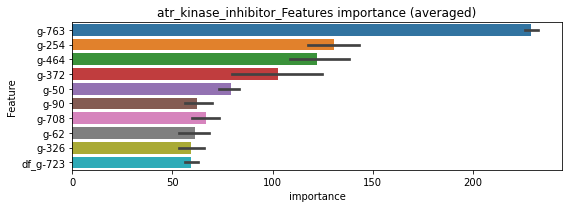

len(train_index) : 3896
len(valid_index) : 3896
================================= fold 1/2 atr_kinase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0124082	valid_1's binary_logloss: 0.0232546
[200]	training's binary_logloss: 0.00143401	valid_1's binary_logloss: 0.0103268
Early stopping, best iteration is:
[277]	training's binary_logloss: 0.000511769	valid_1's binary_logloss: 0.00895161


len(train_index) : 3896
len(valid_index) : 3896
================================= fold 2/2 atr_kinase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0121673	valid_1's binary_logloss: 0.0231186
[200]	training's binary_logloss: 0.00136921	valid_1's binary_logloss: 0.0125623
[300]	training's binary_logloss: 0.000382971	valid_1's binary_logloss: 0.0113805
Early stopping, best iteration is:
[350]	training's binary_logloss: 0.000263767	valid_1's binary_logloss: 0.0110887


atr_kinase_inhibitor logloss: 0.010020162203055589
aurora_kinase_inhibitor, len(trt): 96, len(othr): 3273, target_rate: 0.0040312 → Adj_target_rate: 0.0040656


neg labels: 3289 → selected neg labels: 3273


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0389432	valid_1's binary_logloss: 0.0745559
[200]	training's binary_logloss: 0.00666817	valid_1's binary_logloss: 0.0366655
[300]	training's binary_logloss: 0.00197594	valid_1's binary_logloss: 0.0286611
[400]	training's binary_logloss: 0.000960924	valid_1's binary_logloss: 0.0262716
[500]	training's binary_logloss: 0.000622514	valid_1's binary_logloss: 0.0247172
Early stopping, best iteration is:
[547]	training's binary_logloss: 0.000547472	valid_1's binary_logloss: 0.0242241
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0377376	valid_1's binary_logloss: 0.0790365
[200]	training's binary_logloss: 0.00637384	valid_1's binary_logloss: 0.0378079
[300]	training's binary_logloss: 0.00195226	valid_1's binary_logloss: 0.0275677
[400]	training's binary_logloss: 0.000961278	valid_1's binary_logloss: 0.0242458
Early stopping, best iteration is:
[425]	

1 / 3 AUC score:0.999
Threshold: 0.0168544, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → positive_corect_labels: 654/3795
p_label_rate: 0.0371673 Vs.target_rate: 0.00403, Num_p_label: 148.0, conf_0:0.00045, conf_1:0.01854
Num_p_label: 148.0, Expected: 16.1, Adj_threshold_1: 0.0168544
Num_p_label: 123.0, Expected: 16.1, Adj_threshold_2: 0.0218544
Num_p_label: 111.0, Expected: 16.1, Adj_threshold_3: 0.0268544
Num_p_label: 104.0, Expected: 16.1, Adj_threshold_4: 0.0318544
Num_p_label: 97.0, Expected: 16.1, Adj_threshold_5: 0.0368544
Num_p_label: 89.0, Expected: 16.1, Adj_threshold_6: 0.0418544
Num_p_label: 87.0, Expected: 16.1, Adj_threshold_7: 0.0468544
Num_p_label: 84.0, Expected: 16.1, Adj_threshold_8: 0.0518544
Num_p_label: 80.0, Expected: 16.1, Adj_threshold_9: 0.0568544
Num_p_label: 78.0, Expected: 16.1, Adj_threshold_10: 0.0618544
threshold: 0.0668544, positive p_label: 74.0/3982, p_label_rate: 0.0185836
positive y_label: 654.0/3795, y_label_rate: 0.1723320
=================

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0353145	valid_1's binary_logloss: 0.0607666
[200]	training's binary_logloss: 0.0054351	valid_1's binary_logloss: 0.0240093
[300]	training's binary_logloss: 0.00162249	valid_1's binary_logloss: 0.0162711
[400]	training's binary_logloss: 0.00081175	valid_1's binary_logloss: 0.0143899
Early stopping, best iteration is:
[445]	training's binary_logloss: 0.000654757	valid_1's binary_logloss: 0.0137674
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0342132	valid_1's binary_logloss: 0.0676659
[200]	training's binary_logloss: 0.00529086	valid_1's binary_logloss: 0.0276521
[300]	training's binary_logloss: 0.00156539	valid_1's binary_logloss: 0.0171887
[400]	training's binary_logloss: 0.00077425	valid_1's binary_logloss: 0.0140041
Early stopping, best iteration is:
[392]	training's binary_logloss: 0.000808289	valid_1's binary_logloss: 0.0139936


2 / 3 AUC score:1.000
Threshold: 0.0668544, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 20 → positive_corect_labels: 652.0/3775
p_label_rate: 0.0328980 Vs.target_rate: 0.00403, Num_p_label: 131.0, conf_0:0.00057, conf_1:0.07354
Num_p_label: 131.0, Expected: 16.1, Adj_threshold_1: 0.0668544
Num_p_label: 129.0, Expected: 16.1, Adj_threshold_2: 0.0718544
Num_p_label: 129.0, Expected: 16.1, Adj_threshold_3: 0.0768544
Num_p_label: 127.0, Expected: 16.1, Adj_threshold_4: 0.0818544
Num_p_label: 122.0, Expected: 16.1, Adj_threshold_5: 0.0868544
Num_p_label: 121.0, Expected: 16.1, Adj_threshold_6: 0.0918544
Num_p_label: 118.0, Expected: 16.1, Adj_threshold_7: 0.0968544
Num_p_label: 117.0, Expected: 16.1, Adj_threshold_8: 0.1018544
Num_p_label: 115.0, Expected: 16.1, Adj_threshold_9: 0.1068544
Num_p_label: 112.0, Expected: 16.1, Adj_threshold_10: 0.1118544
threshold: 0.1168544, positive p_label: 110.0/3982, p_label_rate: 0.0276243
positive y_label: 652.0/3775, y_label_rate: 0.1727152
=========

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0349235	valid_1's binary_logloss: 0.0618395
[200]	training's binary_logloss: 0.00543988	valid_1's binary_logloss: 0.0216297
[300]	training's binary_logloss: 0.00161476	valid_1's binary_logloss: 0.0137554
[400]	training's binary_logloss: 0.000793458	valid_1's binary_logloss: 0.0106939
[500]	training's binary_logloss: 0.000529309	valid_1's binary_logloss: 0.00969288
Early stopping, best iteration is:
[572]	training's binary_logloss: 0.000455375	valid_1's binary_logloss: 0.00928262
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0348781	valid_1's binary_logloss: 0.0651444
[200]	training's binary_logloss: 0.0053892	valid_1's binary_logloss: 0.0247832
[300]	training's binary_logloss: 0.00154745	valid_1's binary_logloss: 0.01503
[400]	training's binary_logloss: 0.000772032	valid_1's binary_logloss: 0.0122218
[500]	training's binary_logloss: 0.0005160

3 / 3 AUC score:1.000
Threshold: 0.1168544, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 1 → positive_corect_labels: 652.0/3774
p_label_rate: 0.0286288 Vs.target_rate: 0.00403, Num_p_label: 114.0, conf_0:0.00039, conf_1:0.12854
Num_p_label: 114.0, Expected: 16.1, Adj_threshold_1: 0.1168544
Num_p_label: 111.0, Expected: 16.1, Adj_threshold_2: 0.1218544
Num_p_label: 110.0, Expected: 16.1, Adj_threshold_3: 0.1268544
Num_p_label: 106.0, Expected: 16.1, Adj_threshold_4: 0.1318544
Num_p_label: 105.0, Expected: 16.1, Adj_threshold_5: 0.1368544
Num_p_label: 104.0, Expected: 16.1, Adj_threshold_6: 0.1418544
Num_p_label: 104.0, Expected: 16.1, Adj_threshold_7: 0.1468544
Num_p_label: 102.0, Expected: 16.1, Adj_threshold_8: 0.1518544
Num_p_label: 101.0, Expected: 16.1, Adj_threshold_9: 0.1568544
Num_p_label: 98.0, Expected: 16.1, Adj_threshold_10: 0.1618544
threshold: 0.1668544, positive p_label: 97.0/3982, p_label_rate: 0.0243596
positive y_label: 749.0/7756, y_label_rate: 0.0965704


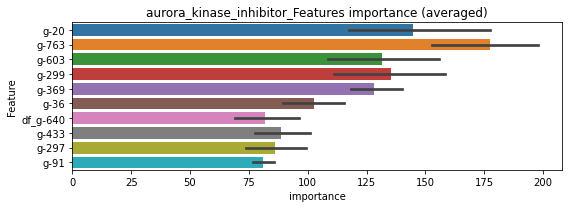

len(train_index) : 3878
len(valid_index) : 3878
================================= fold 1/2 aurora_kinase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0206984	valid_1's binary_logloss: 0.0512571
[200]	training's binary_logloss: 0.00329747	valid_1's binary_logloss: 0.0306087
[300]	training's binary_logloss: 0.00099819	valid_1's binary_logloss: 0.0255606
Early stopping, best iteration is:
[382]	training's binary_logloss: 0.000549621	valid_1's binary_logloss: 0.024379


len(train_index) : 3878
len(valid_index) : 3878
================================= fold 2/2 aurora_kinase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0218734	valid_1's binary_logloss: 0.0464438
[200]	training's binary_logloss: 0.00351109	valid_1's binary_logloss: 0.0226436
[300]	training's binary_logloss: 0.00105312	valid_1's binary_logloss: 0.0178646
Early stopping, best iteration is:
[385]	training's binary_logloss: 0.000553465	valid_1's binary_logloss: 0.0161774


aurora_kinase_inhibitor logloss: 0.020278214904587647


  acetylcholine_receptor_agonist acetylcholine_receptor_antagonist  \
0                       df_g-122                              c-30   
1                  clusters_df_c                         c_all_max   
2                          cnt_0                    clusters_g_all   
3                      c_all_min                          df_g-707   
4                        df_g-51                        clusters_g   
5                       df_c_min                          df_c_min   
6                          cnt_2                             g-514   
7                       df_g-736                          df_g-640   
8                          g-244                            df_c-6   
9                           c-73                          df_g-597   

  acetylcholinesterase_inhibitor adenosine_receptor_antagonist  \
0                      c_all_max                clusters_c_all   
1                      c_all_min                      df_c_min   
2                 clusters_g_al

autotaxin_inhibitor, len(trt): 6, len(othr): 3288, target_rate: 0.0002520 → Adj_target_rate: 0.0003851


neg labels: 3289 → selected neg labels: 3288


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0160901	valid_1's binary_logloss: 0.0177441
[200]	training's binary_logloss: 0.00137759	valid_1's binary_logloss: 0.00256235
[300]	training's binary_logloss: 0.000367953	valid_1's binary_logloss: 0.00116666
[400]	training's binary_logloss: 0.000223404	valid_1's binary_logloss: 0.000913867
Early stopping, best iteration is:
[435]	training's binary_logloss: 0.00020717	valid_1's binary_logloss: 0.000888264
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.016211	valid_1's binary_logloss: 0.0185551
[200]	training's binary_logloss: 0.00138562	valid_1's binary_logloss: 0.00245968
[300]	training's binary_logloss: 0.00036862	valid_1's binary_logloss: 0.000794513
[400]	training's binary_logloss: 0.000223877	valid_1's binary_logloss: 0.000518712


1 / 3 AUC score:1.000


Early stopping, best iteration is:
[461]	training's binary_logloss: 0.000202292	valid_1's binary_logloss: 0.000478683


Threshold: 0.0005938, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → positive_corect_labels: 657/3813
p_label_rate: 0.0487192 Vs.target_rate: 0.00025, Num_p_label: 194.0, conf_0:0.00012, conf_1:0.00065
Num_p_label: 194.0, Expected: 1.0, Adj_threshold_1: 0.0005938
Num_p_label: 8.0, Expected: 1.0, Adj_threshold_2: 0.0055938
Num_p_label: 4.0, Expected: 1.0, Adj_threshold_3: 0.0105938
Num_p_label: 2.0, Expected: 1.0, Adj_threshold_4: 0.0155938
threshold: 0.0155938, positive p_label: 2.0/3982, p_label_rate: 0.0005023
positive y_label: 657.0/3813, y_label_rate: 0.1723053
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0162724	valid_1's binary_logloss: 0.0180129
[200]	training's binary_logloss: 0.0013427	valid_1's binary_logloss: 0.00268398
[300]	training's binary_logloss: 0.000360485	valid_1's binary_logloss: 0.0012399
[400]	training's binary_logloss: 0.000221197	valid_1's binary_logloss: 0.000980199
Early stopping, best iteration is:
[471]	training's binary_logloss: 0.000196638	valid_1's binary_logloss: 0.000936707
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0165589	valid_1's binary_logloss: 0.0174226
[200]	training's binary_logloss: 0.00137946	valid_1's binary_logloss: 0.00154674
[300]	training's binary_logloss: 0.000363639	valid_1's binary_logloss: 0.000436817
[400]	training's binary_logloss: 0.000221513	valid_1's binary_logloss: 0.000272476
[500]	training's binary_logloss: 0.000197973	valid_1's binary_logloss: 0.000245301
Early stopping, best iterati

2 / 3 AUC score:1.000
Threshold: 0.0155938, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → positive_corect_labels: 657.0/3813
p_label_rate: 0.0037670 Vs.target_rate: 0.00025, Num_p_label: 15.0, conf_0:0.00012, conf_1:0.01715
Num_p_label: 15.0, Expected: 1.0, Adj_threshold_1: 0.0155938
Num_p_label: 13.0, Expected: 1.0, Adj_threshold_2: 0.0205938
Num_p_label: 10.0, Expected: 1.0, Adj_threshold_3: 0.0255938
Num_p_label: 9.0, Expected: 1.0, Adj_threshold_4: 0.0305938
Num_p_label: 8.0, Expected: 1.0, Adj_threshold_5: 0.0355938
Num_p_label: 6.0, Expected: 1.0, Adj_threshold_6: 0.0405938
Num_p_label: 6.0, Expected: 1.0, Adj_threshold_7: 0.0455938
Num_p_label: 6.0, Expected: 1.0, Adj_threshold_8: 0.0505938
Num_p_label: 5.0, Expected: 1.0, Adj_threshold_9: 0.0555938
Num_p_label: 5.0, Expected: 1.0, Adj_threshold_10: 0.0605938
threshold: 0.0655938, positive p_label: 4.0/3982, p_label_rate: 0.0010045
positive y_label: 657.0/3813, y_label_rate: 0.1723053
================= Pseudo labeling 3 / 3 

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0162724	valid_1's binary_logloss: 0.0180129
[200]	training's binary_logloss: 0.0013427	valid_1's binary_logloss: 0.00268398
[300]	training's binary_logloss: 0.000360485	valid_1's binary_logloss: 0.0012399
[400]	training's binary_logloss: 0.000221197	valid_1's binary_logloss: 0.000980199
Early stopping, best iteration is:
[471]	training's binary_logloss: 0.000196638	valid_1's binary_logloss: 0.000936707
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0165589	valid_1's binary_logloss: 0.0174226
[200]	training's binary_logloss: 0.00137946	valid_1's binary_logloss: 0.00154674
[300]	training's binary_logloss: 0.000363639	valid_1's binary_logloss: 0.000436817
[400]	training's binary_logloss: 0.000221513	valid_1's binary_logloss: 0.000272476
[500]	training's binary_logloss: 0.000197973	valid_1's binary_logloss: 0.000245301
Early stopping, best iterati

3 / 3 AUC score:1.000
Threshold: 0.0655938, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → positive_corect_labels: 657.0/3813
p_label_rate: 0.0010045 Vs.target_rate: 0.00025, Num_p_label: 4.0, conf_0:0.00012, conf_1:0.07215
Num_p_label: 4.0, Expected: 1.0, Adj_threshold_1: 0.0655938
Num_p_label: 4.0, Expected: 1.0, Adj_threshold_2: 0.0705938
Num_p_label: 4.0, Expected: 1.0, Adj_threshold_3: 0.0755938
Num_p_label: 3.0, Expected: 1.0, Adj_threshold_4: 0.0805938
Num_p_label: 3.0, Expected: 1.0, Adj_threshold_5: 0.0855938
Num_p_label: 3.0, Expected: 1.0, Adj_threshold_6: 0.0905938
Num_p_label: 3.0, Expected: 1.0, Adj_threshold_7: 0.0955938
Num_p_label: 2.0, Expected: 1.0, Adj_threshold_8: 0.1005938
threshold: 0.1005938, positive p_label: 2.0/3982, p_label_rate: 0.0005023
positive y_label: 659.0/7795, y_label_rate: 0.0845414


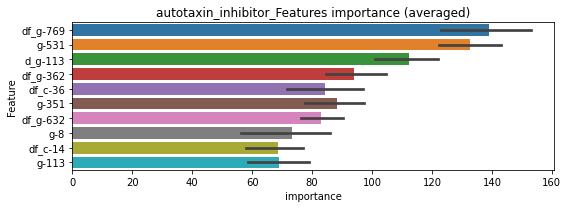

len(train_index) : 3897
len(valid_index) : 3898
================================= fold 1/2 autotaxin_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.00858785	valid_1's binary_logloss: 0.0108782
[200]	training's binary_logloss: 0.000714381	valid_1's binary_logloss: 0.00337715
[300]	training's binary_logloss: 0.000188797	valid_1's binary_logloss: 0.00280879
Early stopping, best iteration is:
[336]	training's binary_logloss: 0.000146891	valid_1's binary_logloss: 0.00274715


len(train_index) : 3898
len(valid_index) : 3897
================================= fold 2/2 autotaxin_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.00885232	valid_1's binary_logloss: 0.010619
[200]	training's binary_logloss: 0.000741894	valid_1's binary_logloss: 0.00206315
[300]	training's binary_logloss: 0.000194506	valid_1's binary_logloss: 0.00155723
Early stopping, best iteration is:
[315]	training's binary_logloss: 0.000171648	valid_1's binary_logloss: 0.00153796


autotaxin_inhibitor logloss: 0.0021426308240162593
bacterial_30s_ribosomal_subunit_inhibitor, len(trt): 60, len(othr): 3279, target_rate: 0.0025195 → Adj_target_rate: 0.0027266


neg labels: 3289 → selected neg labels: 3279


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0485562	valid_1's binary_logloss: 0.107435
[200]	training's binary_logloss: 0.00993342	valid_1's binary_logloss: 0.0668347
[300]	training's binary_logloss: 0.00288736	valid_1's binary_logloss: 0.0561523
Early stopping, best iteration is:
[333]	training's binary_logloss: 0.00212428	valid_1's binary_logloss: 0.054801
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0536737	valid_1's binary_logloss: 0.0983237
[200]	training's binary_logloss: 0.0105675	valid_1's binary_logloss: 0.0424611
[300]	training's binary_logloss: 0.00309363	valid_1's binary_logloss: 0.0265261
[400]	training's binary_logloss: 0.00141879	valid_1's binary_logloss: 0.0207963
[500]	training's binary_logloss: 0.000870311	valid_1's binary_logloss: 0.0187559
Early stopping, best iteration is:
[560]	training's binary_logloss: 0.00070515	valid_1's binary_logloss: 0.017913


1 / 3 AUC score:0.998
Threshold: 0.0096554, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 140 → positive_corect_labels: 651/3794
p_label_rate: 0.0281266 Vs.target_rate: 0.00252, Num_p_label: 112.0, conf_0:0.00148, conf_1:0.01062
Num_p_label: 112.0, Expected: 10.0, Adj_threshold_1: 0.0096554
Num_p_label: 56.0, Expected: 10.0, Adj_threshold_2: 0.0146554
Num_p_label: 31.0, Expected: 10.0, Adj_threshold_3: 0.0196554
Num_p_label: 22.0, Expected: 10.0, Adj_threshold_4: 0.0246554
Num_p_label: 16.0, Expected: 10.0, Adj_threshold_5: 0.0296554
threshold: 0.0296554, positive p_label: 16.0/3982, p_label_rate: 0.0040181
positive y_label: 651.0/3794, y_label_rate: 0.1715867
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.051319	valid_1's binary_logloss: 0.0963741
[200]	training's binary_logloss: 0.00985089	valid_1's binary_logloss: 0.0434123
[300]	training's binary_logloss: 0.00286069	valid_1's binary_logloss: 0.0281485
[400]	training's binary_logloss: 0.00132426	valid_1's binary_logloss: 0.0240192
[500]	training's binary_logloss: 0.000823941	valid_1's binary_logloss: 0.0219379
Early stopping, best iteration is:
[495]	training's binary_logloss: 0.000837	valid_1's binary_logloss: 0.0218832
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0536501	valid_1's binary_logloss: 0.097788
[200]	training's binary_logloss: 0.0107912	valid_1's binary_logloss: 0.0463527
[300]	training's binary_logloss: 0.00306962	valid_1's binary_logloss: 0.0331251
[400]	training's binary_logloss: 0.0013797	valid_1's binary_logloss: 0.0296076
Early stopping, best iteration is:
[440]	training'

2 / 3 AUC score:0.999
Threshold: 0.0296554, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 12 → positive_corect_labels: 646.0/3782
p_label_rate: 0.0047715 Vs.target_rate: 0.00252, Num_p_label: 19.0, conf_0:0.00124, conf_1:0.03262
threshold: 0.0296554, positive p_label: 19.0/3982, p_label_rate: 0.0047715
positive y_label: 646.0/3782, y_label_rate: 0.1708091
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0494842	valid_1's binary_logloss: 0.0992218
[200]	training's binary_logloss: 0.00949109	valid_1's binary_logloss: 0.0560272
[300]	training's binary_logloss: 0.00275803	valid_1's binary_logloss: 0.0469906
Early stopping, best iteration is:
[355]	training's binary_logloss: 0.00172996	valid_1's binary_logloss: 0.0456755
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0513982	valid_1's binary_logloss: 0.091735
[200]	training's binary_logloss: 0.0102359	valid_1's binary_logloss: 0.0372568
[300]	training's binary_logloss: 0.00290016	valid_1's binary_logloss: 0.022537
[400]	training's binary_logloss: 0.00133375	valid_1's binary_logloss: 0.0179605
[500]	training's binary_logloss: 0.00083203	valid_1's binary_logloss: 0.0162048
Early stopping, best iteration is:
[567]	training's binary_logloss: 0.000674935	valid_1's binary_logloss: 0.0156069


3 / 3 AUC score:0.999
Threshold: 0.0296554, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 15 → positive_corect_labels: 637.0/3767
p_label_rate: 0.0042692 Vs.target_rate: 0.00252, Num_p_label: 17.0, conf_0:0.00144, conf_1:0.03262
threshold: 0.0296554, positive p_label: 17.0/3982, p_label_rate: 0.0042692
positive y_label: 654.0/7749, y_label_rate: 0.0843980


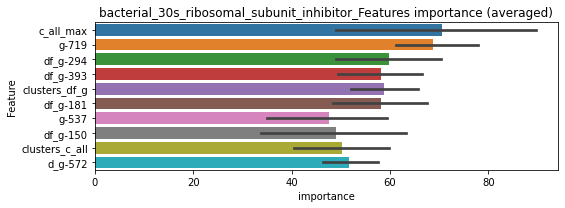

len(train_index) : 3874
len(valid_index) : 3875
================================= fold 1/2 bacterial_30s_ribosomal_subunit_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0289535	valid_1's binary_logloss: 0.0601505
[200]	training's binary_logloss: 0.00562932	valid_1's binary_logloss: 0.0328067
[300]	training's binary_logloss: 0.00156447	valid_1's binary_logloss: 0.0271931
Early stopping, best iteration is:
[314]	training's binary_logloss: 0.00135773	valid_1's binary_logloss: 0.0268906


len(train_index) : 3875
len(valid_index) : 3874
================================= fold 2/2 bacterial_30s_ribosomal_subunit_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0288749	valid_1's binary_logloss: 0.0588752
[200]	training's binary_logloss: 0.00597973	valid_1's binary_logloss: 0.03251
[300]	training's binary_logloss: 0.0016876	valid_1's binary_logloss: 0.0268606
Early stopping, best iteration is:
[365]	training's binary_logloss: 0.000942328	valid_1's binary_logloss: 0.0252737


bacterial_30s_ribosomal_subunit_inhibitor logloss: 0.0260822465864131


  acetylcholine_receptor_agonist acetylcholine_receptor_antagonist  \
0                       df_g-122                              c-30   
1                  clusters_df_c                         c_all_max   
2                          cnt_0                    clusters_g_all   
3                      c_all_min                          df_g-707   
4                        df_g-51                        clusters_g   
5                       df_c_min                          df_c_min   
6                          cnt_2                             g-514   
7                       df_g-736                          df_g-640   
8                          g-244                            df_c-6   
9                           c-73                          df_g-597   

  acetylcholinesterase_inhibitor adenosine_receptor_antagonist  \
0                      c_all_max                clusters_c_all   
1                      c_all_min                      df_c_min   
2                 clusters_g_al

bacterial_50s_ribosomal_subunit_inhibitor, len(trt): 80, len(othr): 3277, target_rate: 0.0033594 → Adj_target_rate: 0.0034820


neg labels: 3289 → selected neg labels: 3277


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0531056	valid_1's binary_logloss: 0.121979
[200]	training's binary_logloss: 0.0115635	valid_1's binary_logloss: 0.0751381
[300]	training's binary_logloss: 0.00336799	valid_1's binary_logloss: 0.0639716
Early stopping, best iteration is:
[319]	training's binary_logloss: 0.00282503	valid_1's binary_logloss: 0.062993
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0567129	valid_1's binary_logloss: 0.116068
[200]	training's binary_logloss: 0.0124044	valid_1's binary_logloss: 0.0694184
[300]	training's binary_logloss: 0.00374539	valid_1's binary_logloss: 0.0597246
Early stopping, best iteration is:
[325]	training's binary_logloss: 0.00296418	valid_1's binary_logloss: 0.0581477


1 / 3 AUC score:0.996
Threshold: 0.0148357, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 158 → positive_corect_labels: 642/3774
p_label_rate: 0.0339026 Vs.target_rate: 0.00336, Num_p_label: 135.0, conf_0:0.00335, conf_1:0.01632
Num_p_label: 135.0, Expected: 13.4, Adj_threshold_1: 0.0148357
Num_p_label: 76.0, Expected: 13.4, Adj_threshold_2: 0.0198357
Num_p_label: 44.0, Expected: 13.4, Adj_threshold_3: 0.0248357
Num_p_label: 25.0, Expected: 13.4, Adj_threshold_4: 0.0298357
threshold: 0.0298357, positive p_label: 25.0/3982, p_label_rate: 0.0062783
positive y_label: 642.0/3774, y_label_rate: 0.1701113
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0524595	valid_1's binary_logloss: 0.120466
[200]	training's binary_logloss: 0.0116744	valid_1's binary_logloss: 0.0748912
[300]	training's binary_logloss: 0.00350214	valid_1's binary_logloss: 0.0612857
[400]	training's binary_logloss: 0.00158653	valid_1's binary_logloss: 0.0569671
Early stopping, best iteration is:
[397]	training's binary_logloss: 0.00161609	valid_1's binary_logloss: 0.0567981
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0530634	valid_1's binary_logloss: 0.1044
[200]	training's binary_logloss: 0.0113489	valid_1's binary_logloss: 0.0586604
[300]	training's binary_logloss: 0.00342265	valid_1's binary_logloss: 0.0468945
Early stopping, best iteration is:
[304]	training's binary_logloss: 0.00328952	valid_1's binary_logloss: 0.0465594


2 / 3 AUC score:0.998
Threshold: 0.0298357, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 27 → positive_corect_labels: 634.0/3747
p_label_rate: 0.0100452 Vs.target_rate: 0.00336, Num_p_label: 40.0, conf_0:0.00312, conf_1:0.03282
threshold: 0.0298357, positive p_label: 40.0/3982, p_label_rate: 0.0100452
positive y_label: 634.0/3747, y_label_rate: 0.1692020
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0536653	valid_1's binary_logloss: 0.0974422
[200]	training's binary_logloss: 0.0113902	valid_1's binary_logloss: 0.0469768
[300]	training's binary_logloss: 0.00344913	valid_1's binary_logloss: 0.0323873
[400]	training's binary_logloss: 0.00158522	valid_1's binary_logloss: 0.028601
[500]	training's binary_logloss: 0.000982578	valid_1's binary_logloss: 0.0265613
Early stopping, best iteration is:
[533]	training's binary_logloss: 0.000874234	valid_1's binary_logloss: 0.0261558
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0526016	valid_1's binary_logloss: 0.106113
[200]	training's binary_logloss: 0.0105328	valid_1's binary_logloss: 0.0584538
[300]	training's binary_logloss: 0.0032164	valid_1's binary_logloss: 0.0488576
Early stopping, best iteration is:
[329]	training's binary_logloss: 0.00247713	valid_1's binary_logloss: 0.0475781


3 / 3 AUC score:1.000
Threshold: 0.0298357, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 13 → positive_corect_labels: 626.0/3734
p_label_rate: 0.0060271 Vs.target_rate: 0.00336, Num_p_label: 24.0, conf_0:0.00212, conf_1:0.03282
threshold: 0.0298357, positive p_label: 24.0/3982, p_label_rate: 0.0060271
positive y_label: 650.0/7716, y_label_rate: 0.0842405


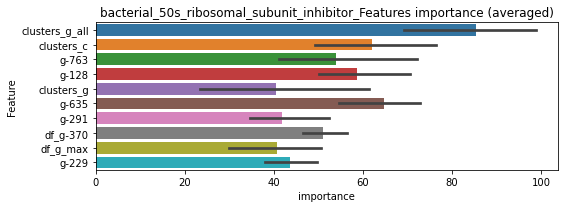

len(train_index) : 3858
len(valid_index) : 3858
================================= fold 1/2 bacterial_50s_ribosomal_subunit_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0298643	valid_1's binary_logloss: 0.066047
[200]	training's binary_logloss: 0.00638315	valid_1's binary_logloss: 0.0427819
[300]	training's binary_logloss: 0.00187489	valid_1's binary_logloss: 0.0376635
Early stopping, best iteration is:
[354]	training's binary_logloss: 0.0011721	valid_1's binary_logloss: 0.0367184


len(train_index) : 3858
len(valid_index) : 3858
================================= fold 2/2 bacterial_50s_ribosomal_subunit_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0296884	valid_1's binary_logloss: 0.0628209
[200]	training's binary_logloss: 0.00602592	valid_1's binary_logloss: 0.0384047
[300]	training's binary_logloss: 0.00183295	valid_1's binary_logloss: 0.0330934
[400]	training's binary_logloss: 0.000835914	valid_1's binary_logloss: 0.0320476
Early stopping, best iteration is:
[430]	training's binary_logloss: 0.000705045	valid_1's binary_logloss: 0.0318626


bacterial_50s_ribosomal_subunit_inhibitor logloss: 0.03429051017606478


  acetylcholine_receptor_agonist acetylcholine_receptor_antagonist  \
0                       df_g-122                              c-30   
1                  clusters_df_c                         c_all_max   
2                          cnt_0                    clusters_g_all   
3                      c_all_min                          df_g-707   
4                        df_g-51                        clusters_g   
5                       df_c_min                          df_c_min   
6                          cnt_2                             g-514   
7                       df_g-736                          df_g-640   
8                          g-244                            df_c-6   
9                           c-73                          df_g-597   

  acetylcholinesterase_inhibitor adenosine_receptor_antagonist  \
0                      c_all_max                clusters_c_all   
1                      c_all_min                      df_c_min   
2                 clusters_g_al

bacterial_antifolate, len(trt): 36, len(othr): 3283, target_rate: 0.0015117 → Adj_target_rate: 0.0017663


neg labels: 3289 → selected neg labels: 3283


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0340281	valid_1's binary_logloss: 0.0566715
[200]	training's binary_logloss: 0.00511992	valid_1's binary_logloss: 0.0229863
[300]	training's binary_logloss: 0.00148621	valid_1's binary_logloss: 0.0165218
[400]	training's binary_logloss: 0.000739427	valid_1's binary_logloss: 0.0142399
[500]	training's binary_logloss: 0.00050305	valid_1's binary_logloss: 0.0133358
Early stopping, best iteration is:
[504]	training's binary_logloss: 0.00049777	valid_1's binary_logloss: 0.0132853
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0359747	valid_1's binary_logloss: 0.0556047
[200]	training's binary_logloss: 0.00564491	valid_1's binary_logloss: 0.0174699
[300]	training's binary_logloss: 0.00159442	valid_1's binary_logloss: 0.00989105
[400]	training's binary_logloss: 0.000774465	valid_1's binary_logloss: 0.0077044
Early stopping, best iteration is:
[465]	t

1 / 3 AUC score:1.000
Threshold: 0.0045785, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → positive_corect_labels: 656/3807
p_label_rate: 0.0344048 Vs.target_rate: 0.00151, Num_p_label: 137.0, conf_0:0.00041, conf_1:0.00504
Num_p_label: 137.0, Expected: 6.0, Adj_threshold_1: 0.0045785
Num_p_label: 56.0, Expected: 6.0, Adj_threshold_2: 0.0095785
Num_p_label: 31.0, Expected: 6.0, Adj_threshold_3: 0.0145785
Num_p_label: 17.0, Expected: 6.0, Adj_threshold_4: 0.0195785
Num_p_label: 12.0, Expected: 6.0, Adj_threshold_5: 0.0245785
threshold: 0.0245785, positive p_label: 12.0/3982, p_label_rate: 0.0030136
positive y_label: 656.0/3807, y_label_rate: 0.1723142
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0331415	valid_1's binary_logloss: 0.0550953
[200]	training's binary_logloss: 0.0049388	valid_1's binary_logloss: 0.0217617
[300]	training's binary_logloss: 0.001442	valid_1's binary_logloss: 0.0148735
[400]	training's binary_logloss: 0.000722571	valid_1's binary_logloss: 0.0131916
Early stopping, best iteration is:
[395]	training's binary_logloss: 0.000740809	valid_1's binary_logloss: 0.0130893
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.034523	valid_1's binary_logloss: 0.0526808
[200]	training's binary_logloss: 0.00542616	valid_1's binary_logloss: 0.0154919
[300]	training's binary_logloss: 0.00152289	valid_1's binary_logloss: 0.00748755
[400]	training's binary_logloss: 0.000750361	valid_1's binary_logloss: 0.00570389
Early stopping, best iteration is:
[489]	training's binary_logloss: 0.000521423	valid_1's binary_logloss: 0.00483288


2 / 3 AUC score:1.000
Threshold: 0.0245785, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 2 → positive_corect_labels: 656.0/3805
p_label_rate: 0.0082873 Vs.target_rate: 0.00151, Num_p_label: 33.0, conf_0:0.00054, conf_1:0.02704
Num_p_label: 33.0, Expected: 6.0, Adj_threshold_1: 0.0245785
Num_p_label: 27.0, Expected: 6.0, Adj_threshold_2: 0.0295785
Num_p_label: 24.0, Expected: 6.0, Adj_threshold_3: 0.0345785
Num_p_label: 19.0, Expected: 6.0, Adj_threshold_4: 0.0395785
Num_p_label: 14.0, Expected: 6.0, Adj_threshold_5: 0.0445785
Num_p_label: 13.0, Expected: 6.0, Adj_threshold_6: 0.0495785
Num_p_label: 11.0, Expected: 6.0, Adj_threshold_7: 0.0545785
threshold: 0.0545785, positive p_label: 11.0/3982, p_label_rate: 0.0027624
positive y_label: 656.0/3805, y_label_rate: 0.1724047
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0332001	valid_1's binary_logloss: 0.0549124
[200]	training's binary_logloss: 0.00499731	valid_1's binary_logloss: 0.0212184
[300]	training's binary_logloss: 0.00144885	valid_1's binary_logloss: 0.0143492
[400]	training's binary_logloss: 0.000717274	valid_1's binary_logloss: 0.0121219
Early stopping, best iteration is:
[485]	training's binary_logloss: 0.000508464	valid_1's binary_logloss: 0.0112242
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0340887	valid_1's binary_logloss: 0.052639
[200]	training's binary_logloss: 0.00522552	valid_1's binary_logloss: 0.0148654
[300]	training's binary_logloss: 0.00150211	valid_1's binary_logloss: 0.0076749
[400]	training's binary_logloss: 0.000750984	valid_1's binary_logloss: 0.00583717
[500]	training's binary_logloss: 0.000509773	valid_1's binary_logloss: 0.00505498
Early stopping, best iteration is:
[530]

3 / 3 AUC score:1.000
Threshold: 0.0545785, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 1 → positive_corect_labels: 655.0/3804
p_label_rate: 0.0030136 Vs.target_rate: 0.00151, Num_p_label: 12.0, conf_0:0.00041, conf_1:0.06004
threshold: 0.0545785, positive p_label: 12.0/3982, p_label_rate: 0.0030136
positive y_label: 667.0/7786, y_label_rate: 0.0856666


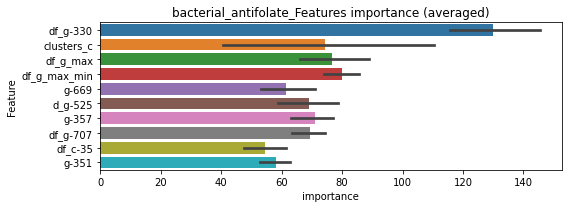

len(train_index) : 3893
len(valid_index) : 3893
================================= fold 1/2 bacterial_antifolate=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0190603	valid_1's binary_logloss: 0.033137
[200]	training's binary_logloss: 0.00289738	valid_1's binary_logloss: 0.0132518
[300]	training's binary_logloss: 0.000800959	valid_1's binary_logloss: 0.010126
Early stopping, best iteration is:
[321]	training's binary_logloss: 0.00066218	valid_1's binary_logloss: 0.0100211


len(train_index) : 3893
len(valid_index) : 3893
================================= fold 2/2 bacterial_antifolate=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0192599	valid_1's binary_logloss: 0.0325671
[200]	training's binary_logloss: 0.00305115	valid_1's binary_logloss: 0.0118449
[300]	training's binary_logloss: 0.000869529	valid_1's binary_logloss: 0.00784106
Early stopping, best iteration is:
[357]	training's binary_logloss: 0.000543021	valid_1's binary_logloss: 0.00704288


bacterial_antifolate logloss: 0.008532012894875826
bacterial_cell_wall_synthesis_inhibitor, len(trt): 192, len(othr): 3259, target_rate: 0.0080625 → Adj_target_rate: 0.0073283


neg labels: 3289 → selected neg labels: 3259


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0893968	valid_1's binary_logloss: 0.222585
[200]	training's binary_logloss: 0.0298963	valid_1's binary_logloss: 0.186914
[300]	training's binary_logloss: 0.01083	valid_1's binary_logloss: 0.176334
Early stopping, best iteration is:
[309]	training's binary_logloss: 0.00986926	valid_1's binary_logloss: 0.175685
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.102373	valid_1's binary_logloss: 0.230314
[200]	training's binary_logloss: 0.0345444	valid_1's binary_logloss: 0.183441
Early stopping, best iteration is:
[280]	training's binary_logloss: 0.0152942	valid_1's binary_logloss: 0.17091


1 / 3 AUC score:0.957
Threshold: 0.0586621, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 289 → positive_corect_labels: 572/3621
p_label_rate: 0.0489704 Vs.target_rate: 0.00806, Num_p_label: 195.0, conf_0:0.01808, conf_1:0.06453
Num_p_label: 195.0, Expected: 32.1, Adj_threshold_1: 0.0586621
Num_p_label: 156.0, Expected: 32.1, Adj_threshold_2: 0.0636621
Num_p_label: 121.0, Expected: 32.1, Adj_threshold_3: 0.0686621
Num_p_label: 96.0, Expected: 32.1, Adj_threshold_4: 0.0736621
Num_p_label: 80.0, Expected: 32.1, Adj_threshold_5: 0.0786621
Num_p_label: 68.0, Expected: 32.1, Adj_threshold_6: 0.0836621
Num_p_label: 48.0, Expected: 32.1, Adj_threshold_7: 0.0886621
threshold: 0.0886621, positive p_label: 48.0/3982, p_label_rate: 0.0120542
positive y_label: 572.0/3621, y_label_rate: 0.1579674
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0738578	valid_1's binary_logloss: 0.187064
[200]	training's binary_logloss: 0.0211178	valid_1's binary_logloss: 0.141453
[300]	training's binary_logloss: 0.00713268	valid_1's binary_logloss: 0.128537
Early stopping, best iteration is:
[344]	training's binary_logloss: 0.00478464	valid_1's binary_logloss: 0.125665
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0834777	valid_1's binary_logloss: 0.193205
[200]	training's binary_logloss: 0.0246775	valid_1's binary_logloss: 0.143877
[300]	training's binary_logloss: 0.00825167	valid_1's binary_logloss: 0.131382
Early stopping, best iteration is:
[330]	training's binary_logloss: 0.00623792	valid_1's binary_logloss: 0.128972


2 / 3 AUC score:0.988
Threshold: 0.0886621, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 81 → positive_corect_labels: 510.0/3540
p_label_rate: 0.0113009 Vs.target_rate: 0.00806, Num_p_label: 45.0, conf_0:0.00964, conf_1:0.09753
threshold: 0.0886621, positive p_label: 45.0/3982, p_label_rate: 0.0113009
positive y_label: 510.0/3540, y_label_rate: 0.1440678
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0684483	valid_1's binary_logloss: 0.159267
[200]	training's binary_logloss: 0.0186424	valid_1's binary_logloss: 0.119204
[300]	training's binary_logloss: 0.00609405	valid_1's binary_logloss: 0.106731
Early stopping, best iteration is:
[339]	training's binary_logloss: 0.00429098	valid_1's binary_logloss: 0.103272
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0673067	valid_1's binary_logloss: 0.150524
[200]	training's binary_logloss: 0.0185704	valid_1's binary_logloss: 0.104689
[300]	training's binary_logloss: 0.00613034	valid_1's binary_logloss: 0.0937327
Early stopping, best iteration is:
[307]	training's binary_logloss: 0.00573015	valid_1's binary_logloss: 0.0928777


3 / 3 AUC score:0.992
Threshold: 0.0886621, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 48 → positive_corect_labels: 473.0/3492
p_label_rate: 0.0075339 Vs.target_rate: 0.00806, Num_p_label: 30.0, conf_0:0.00733, conf_1:0.09753
threshold: 0.0886621, positive p_label: 30.0/3982, p_label_rate: 0.0075339
positive y_label: 503.0/7474, y_label_rate: 0.0673000


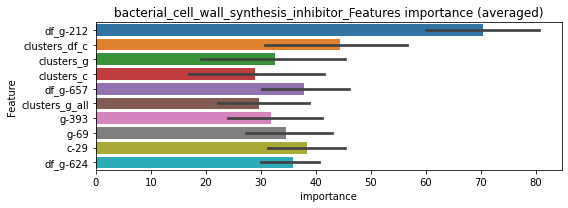

len(train_index) : 3737
len(valid_index) : 3737
================================= fold 1/2 bacterial_cell_wall_synthesis_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0328215	valid_1's binary_logloss: 0.0892852
[200]	training's binary_logloss: 0.0088906	valid_1's binary_logloss: 0.072015
Early stopping, best iteration is:
[261]	training's binary_logloss: 0.00437266	valid_1's binary_logloss: 0.070263


len(train_index) : 3737
len(valid_index) : 3737
================================= fold 2/2 bacterial_cell_wall_synthesis_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0354396	valid_1's binary_logloss: 0.0963316
[200]	training's binary_logloss: 0.00942649	valid_1's binary_logloss: 0.0782734
Early stopping, best iteration is:
[264]	training's binary_logloss: 0.00428308	valid_1's binary_logloss: 0.0756954


bacterial_cell_wall_synthesis_inhibitor logloss: 0.07297920132324641


  acetylcholine_receptor_agonist acetylcholine_receptor_antagonist  \
0                       df_g-122                              c-30   
1                  clusters_df_c                         c_all_max   
2                          cnt_0                    clusters_g_all   
3                      c_all_min                          df_g-707   
4                        df_g-51                        clusters_g   
5                       df_c_min                          df_c_min   
6                          cnt_2                             g-514   
7                       df_g-736                          df_g-640   
8                          g-244                            df_c-6   
9                           c-73                          df_g-597   

  acetylcholinesterase_inhibitor adenosine_receptor_antagonist  \
0                      c_all_max                clusters_c_all   
1                      c_all_min                      df_c_min   
2                 clusters_g_al

bacterial_dna_gyrase_inhibitor, len(trt): 89, len(othr): 3274, target_rate: 0.0037373 → Adj_target_rate: 0.0038122


neg labels: 3289 → selected neg labels: 3274


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0630814	valid_1's binary_logloss: 0.126876
[200]	training's binary_logloss: 0.0151255	valid_1's binary_logloss: 0.0750701
[300]	training's binary_logloss: 0.00462759	valid_1's binary_logloss: 0.059764
Early stopping, best iteration is:
[344]	training's binary_logloss: 0.00310123	valid_1's binary_logloss: 0.0579096
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0613641	valid_1's binary_logloss: 0.122784
[200]	training's binary_logloss: 0.015141	valid_1's binary_logloss: 0.0759113
[300]	training's binary_logloss: 0.00462032	valid_1's binary_logloss: 0.0621845
Early stopping, best iteration is:
[350]	training's binary_logloss: 0.00293129	valid_1's binary_logloss: 0.0604885


1 / 3 AUC score:0.995
Threshold: 0.0210125, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 158 → positive_corect_labels: 641/3770
p_label_rate: 0.0334003 Vs.target_rate: 0.00374, Num_p_label: 133.0, conf_0:0.00390, conf_1:0.02311
Num_p_label: 133.0, Expected: 14.9, Adj_threshold_1: 0.0210125
Num_p_label: 91.0, Expected: 14.9, Adj_threshold_2: 0.0260125
Num_p_label: 71.0, Expected: 14.9, Adj_threshold_3: 0.0310125
Num_p_label: 47.0, Expected: 14.9, Adj_threshold_4: 0.0360125
Num_p_label: 38.0, Expected: 14.9, Adj_threshold_5: 0.0410125
Num_p_label: 28.0, Expected: 14.9, Adj_threshold_6: 0.0460125
threshold: 0.0460125, positive p_label: 28.0/3982, p_label_rate: 0.0070316
positive y_label: 641.0/3770, y_label_rate: 0.1700265
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0559166	valid_1's binary_logloss: 0.112874
[200]	training's binary_logloss: 0.0128638	valid_1's binary_logloss: 0.0635073
[300]	training's binary_logloss: 0.00391126	valid_1's binary_logloss: 0.0492538
[400]	training's binary_logloss: 0.00180104	valid_1's binary_logloss: 0.0451566
Early stopping, best iteration is:
[478]	training's binary_logloss: 0.00119249	valid_1's binary_logloss: 0.0433851
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0637805	valid_1's binary_logloss: 0.116134
[200]	training's binary_logloss: 0.0147108	valid_1's binary_logloss: 0.0606595
[300]	training's binary_logloss: 0.0044704	valid_1's binary_logloss: 0.0450465
Early stopping, best iteration is:
[377]	training's binary_logloss: 0.00230718	valid_1's binary_logloss: 0.0408742


2 / 3 AUC score:0.998
Threshold: 0.0460125, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 16 → positive_corect_labels: 631.0/3754
p_label_rate: 0.0090407 Vs.target_rate: 0.00374, Num_p_label: 36.0, conf_0:0.00260, conf_1:0.05061
threshold: 0.0460125, positive p_label: 36.0/3982, p_label_rate: 0.0090407
positive y_label: 631.0/3754, y_label_rate: 0.1680874
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0572839	valid_1's binary_logloss: 0.120028
[200]	training's binary_logloss: 0.0125475	valid_1's binary_logloss: 0.0674833
[300]	training's binary_logloss: 0.00373523	valid_1's binary_logloss: 0.0529558
[400]	training's binary_logloss: 0.00171418	valid_1's binary_logloss: 0.0483745
Early stopping, best iteration is:
[470]	training's binary_logloss: 0.00118767	valid_1's binary_logloss: 0.0469968
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0574922	valid_1's binary_logloss: 0.117478
[200]	training's binary_logloss: 0.0132319	valid_1's binary_logloss: 0.0642576
[300]	training's binary_logloss: 0.00387154	valid_1's binary_logloss: 0.0448591
[400]	training's binary_logloss: 0.0017696	valid_1's binary_logloss: 0.0378399
[500]	training's binary_logloss: 0.00109504	valid_1's binary_logloss: 0.035299
Early stopping, best iteration is:
[493]	training's

3 / 3 AUC score:0.999
Threshold: 0.0460125, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 16 → positive_corect_labels: 622.0/3738
p_label_rate: 0.0075339 Vs.target_rate: 0.00374, Num_p_label: 30.0, conf_0:0.00176, conf_1:0.05061
threshold: 0.0460125, positive p_label: 30.0/3982, p_label_rate: 0.0075339
positive y_label: 652.0/7720, y_label_rate: 0.0844560


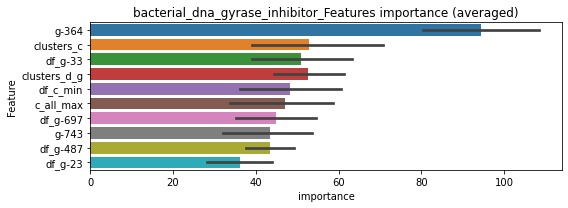

len(train_index) : 3860
len(valid_index) : 3860
================================= fold 1/2 bacterial_dna_gyrase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0308655	valid_1's binary_logloss: 0.0834438
[200]	training's binary_logloss: 0.00695216	valid_1's binary_logloss: 0.0580569
Early stopping, best iteration is:
[276]	training's binary_logloss: 0.00271301	valid_1's binary_logloss: 0.0545332


len(train_index) : 3860
len(valid_index) : 3860
================================= fold 2/2 bacterial_dna_gyrase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0336287	valid_1's binary_logloss: 0.0804073
[200]	training's binary_logloss: 0.00798485	valid_1's binary_logloss: 0.05141
[300]	training's binary_logloss: 0.00241126	valid_1's binary_logloss: 0.0447927
Early stopping, best iteration is:
[321]	training's binary_logloss: 0.00196422	valid_1's binary_logloss: 0.0441832


bacterial_dna_gyrase_inhibitor logloss: 0.04935821221060755


  acetylcholine_receptor_agonist acetylcholine_receptor_antagonist  \
0                       df_g-122                              c-30   
1                  clusters_df_c                         c_all_max   
2                          cnt_0                    clusters_g_all   
3                      c_all_min                          df_g-707   
4                        df_g-51                        clusters_g   
5                       df_c_min                          df_c_min   
6                          cnt_2                             g-514   
7                       df_g-736                          df_g-640   
8                          g-244                            df_c-6   
9                           c-73                          df_g-597   

  acetylcholinesterase_inhibitor adenosine_receptor_antagonist  \
0                      c_all_max                clusters_c_all   
1                      c_all_min                      df_c_min   
2                 clusters_g_al

bacterial_dna_inhibitor, len(trt): 115, len(othr): 3271, target_rate: 0.0048291 → Adj_target_rate: 0.0047401


neg labels: 3289 → selected neg labels: 3271


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.067896	valid_1's binary_logloss: 0.158214
[200]	training's binary_logloss: 0.0181885	valid_1's binary_logloss: 0.114135
Early stopping, best iteration is:
[289]	training's binary_logloss: 0.00625194	valid_1's binary_logloss: 0.101203
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0763295	valid_1's binary_logloss: 0.145469
[200]	training's binary_logloss: 0.0216935	valid_1's binary_logloss: 0.0878337
[300]	training's binary_logloss: 0.00711203	valid_1's binary_logloss: 0.0693395
Early stopping, best iteration is:
[345]	training's binary_logloss: 0.00462764	valid_1's binary_logloss: 0.0663338


1 / 3 AUC score:0.993
Threshold: 0.0295807, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 175 → positive_corect_labels: 632/3750
p_label_rate: 0.0426921 Vs.target_rate: 0.00483, Num_p_label: 170.0, conf_0:0.00658, conf_1:0.03254
Num_p_label: 170.0, Expected: 19.2, Adj_threshold_1: 0.0295807
Num_p_label: 122.0, Expected: 19.2, Adj_threshold_2: 0.0345807
Num_p_label: 74.0, Expected: 19.2, Adj_threshold_3: 0.0395807
Num_p_label: 59.0, Expected: 19.2, Adj_threshold_4: 0.0445807
Num_p_label: 43.0, Expected: 19.2, Adj_threshold_5: 0.0495807
Num_p_label: 34.0, Expected: 19.2, Adj_threshold_6: 0.0545807
threshold: 0.0545807, positive p_label: 34.0/3982, p_label_rate: 0.0085384
positive y_label: 632.0/3750, y_label_rate: 0.1685333
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0673741	valid_1's binary_logloss: 0.148859
[200]	training's binary_logloss: 0.017075	valid_1's binary_logloss: 0.101503
[300]	training's binary_logloss: 0.00542133	valid_1's binary_logloss: 0.0896772
Early stopping, best iteration is:
[360]	training's binary_logloss: 0.00317783	valid_1's binary_logloss: 0.0877245
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0670412	valid_1's binary_logloss: 0.130965
[200]	training's binary_logloss: 0.0174722	valid_1's binary_logloss: 0.0804002
[300]	training's binary_logloss: 0.00559984	valid_1's binary_logloss: 0.0658207
[400]	training's binary_logloss: 0.00246203	valid_1's binary_logloss: 0.0600492
Early stopping, best iteration is:
[440]	training's binary_logloss: 0.00194843	valid_1's binary_logloss: 0.0585658


2 / 3 AUC score:0.995
Threshold: 0.0545807, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 46 → positive_corect_labels: 607.0/3704
p_label_rate: 0.0125565 Vs.target_rate: 0.00483, Num_p_label: 50.0, conf_0:0.00378, conf_1:0.06004
threshold: 0.0545807, positive p_label: 50.0/3982, p_label_rate: 0.0125565
positive y_label: 607.0/3704, y_label_rate: 0.1638769
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0632575	valid_1's binary_logloss: 0.130602
[200]	training's binary_logloss: 0.0156286	valid_1's binary_logloss: 0.0781725
[300]	training's binary_logloss: 0.00488605	valid_1's binary_logloss: 0.06155
Early stopping, best iteration is:
[361]	training's binary_logloss: 0.00287238	valid_1's binary_logloss: 0.0576278
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0657719	valid_1's binary_logloss: 0.128862
[200]	training's binary_logloss: 0.0160986	valid_1's binary_logloss: 0.0823855
[300]	training's binary_logloss: 0.0049991	valid_1's binary_logloss: 0.0702956
Early stopping, best iteration is:
[360]	training's binary_logloss: 0.00295221	valid_1's binary_logloss: 0.0678659


3 / 3 AUC score:0.997
Threshold: 0.0545807, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 47 → positive_corect_labels: 587.0/3657
p_label_rate: 0.0148167 Vs.target_rate: 0.00483, Num_p_label: 59.0, conf_0:0.00390, conf_1:0.06004
Num_p_label: 59.0, Expected: 19.2, Adj_threshold_1: 0.0545807
Num_p_label: 52.0, Expected: 19.2, Adj_threshold_2: 0.0595807
Num_p_label: 45.0, Expected: 19.2, Adj_threshold_3: 0.0645807
Num_p_label: 32.0, Expected: 19.2, Adj_threshold_4: 0.0695807
threshold: 0.0695807, positive p_label: 32.0/3982, p_label_rate: 0.0080362
positive y_label: 619.0/7639, y_label_rate: 0.0810315


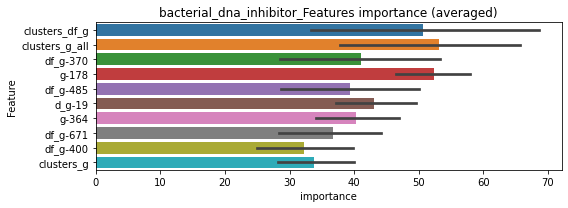

len(train_index) : 3819
len(valid_index) : 3820
================================= fold 1/2 bacterial_dna_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0362171	valid_1's binary_logloss: 0.091819
[200]	training's binary_logloss: 0.00850016	valid_1's binary_logloss: 0.0692341
Early stopping, best iteration is:
[271]	training's binary_logloss: 0.00355544	valid_1's binary_logloss: 0.0667857


len(train_index) : 3820
len(valid_index) : 3819
================================= fold 2/2 bacterial_dna_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.037512	valid_1's binary_logloss: 0.0779087
[200]	training's binary_logloss: 0.00921083	valid_1's binary_logloss: 0.0511729
[300]	training's binary_logloss: 0.00294231	valid_1's binary_logloss: 0.0448091
Early stopping, best iteration is:
[374]	training's binary_logloss: 0.00152803	valid_1's binary_logloss: 0.0435572


bacterial_dna_inhibitor logloss: 0.05517295978963693


  acetylcholine_receptor_agonist acetylcholine_receptor_antagonist  \
0                       df_g-122                              c-30   
1                  clusters_df_c                         c_all_max   
2                          cnt_0                    clusters_g_all   
3                      c_all_min                          df_g-707   
4                        df_g-51                        clusters_g   
5                       df_c_min                          df_c_min   
6                          cnt_2                             g-514   
7                       df_g-736                          df_g-640   
8                          g-244                            df_c-6   
9                           c-73                          df_g-597   

  acetylcholinesterase_inhibitor adenosine_receptor_antagonist  \
0                      c_all_max                clusters_c_all   
1                      c_all_min                      df_c_min   
2                 clusters_g_al

bacterial_membrane_integrity_inhibitor, len(trt): 19, len(othr): 3285, target_rate: 0.0007979 → Adj_target_rate: 0.0010260


neg labels: 3289 → selected neg labels: 3285


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0232763	valid_1's binary_logloss: 0.030984
[200]	training's binary_logloss: 0.00274804	valid_1's binary_logloss: 0.00550068
[300]	training's binary_logloss: 0.000780628	valid_1's binary_logloss: 0.00222284
[400]	training's binary_logloss: 0.000415295	valid_1's binary_logloss: 0.00145495
[500]	training's binary_logloss: 0.00034208	valid_1's binary_logloss: 0.00130082
Early stopping, best iteration is:
[514]	training's binary_logloss: 0.000339127	valid_1's binary_logloss: 0.00129711
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0244472	valid_1's binary_logloss: 0.0316657
[200]	training's binary_logloss: 0.00292503	valid_1's binary_logloss: 0.00481689
[300]	training's binary_logloss: 0.000818793	valid_1's binary_logloss: 0.00164175
[400]	training's binary_logloss: 0.000428865	valid_1's binary_logloss: 0.00104151
Early stopping, best iteration is

1 / 3 AUC score:1.000
Threshold: 0.0014377, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → positive_corect_labels: 657/3810
p_label_rate: 0.0452034 Vs.target_rate: 0.00080, Num_p_label: 180.0, conf_0:0.00023, conf_1:0.00158
Num_p_label: 180.0, Expected: 3.2, Adj_threshold_1: 0.0014377
Num_p_label: 22.0, Expected: 3.2, Adj_threshold_2: 0.0064377
Num_p_label: 9.0, Expected: 3.2, Adj_threshold_3: 0.0114377
Num_p_label: 6.0, Expected: 3.2, Adj_threshold_4: 0.0164377
threshold: 0.0164377, positive p_label: 6.0/3982, p_label_rate: 0.0015068
positive y_label: 657.0/3810, y_label_rate: 0.1724409
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0234897	valid_1's binary_logloss: 0.0315925
[200]	training's binary_logloss: 0.00268231	valid_1's binary_logloss: 0.00647034
[300]	training's binary_logloss: 0.000747728	valid_1's binary_logloss: 0.00306322
[400]	training's binary_logloss: 0.000404651	valid_1's binary_logloss: 0.00231747
Early stopping, best iteration is:
[445]	training's binary_logloss: 0.000351645	valid_1's binary_logloss: 0.00216563
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0241429	valid_1's binary_logloss: 0.0309536
[200]	training's binary_logloss: 0.00276917	valid_1's binary_logloss: 0.00435225
[300]	training's binary_logloss: 0.000769941	valid_1's binary_logloss: 0.00139567
[400]	training's binary_logloss: 0.000402078	valid_1's binary_logloss: 0.000799588
Early stopping, best iteration is:
[489]	training's binary_logloss: 0.000344493	valid_1's binary_logloss: 0.0007

2 / 3 AUC score:1.000
Threshold: 0.0164377, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 5 → positive_corect_labels: 657.0/3805
p_label_rate: 0.0143144 Vs.target_rate: 0.00080, Num_p_label: 57.0, conf_0:0.00027, conf_1:0.01808
Num_p_label: 57.0, Expected: 3.2, Adj_threshold_1: 0.0164377
Num_p_label: 43.0, Expected: 3.2, Adj_threshold_2: 0.0214377
Num_p_label: 32.0, Expected: 3.2, Adj_threshold_3: 0.0264377
Num_p_label: 24.0, Expected: 3.2, Adj_threshold_4: 0.0314377
Num_p_label: 20.0, Expected: 3.2, Adj_threshold_5: 0.0364377
Num_p_label: 20.0, Expected: 3.2, Adj_threshold_6: 0.0414377
Num_p_label: 14.0, Expected: 3.2, Adj_threshold_7: 0.0464377
Num_p_label: 14.0, Expected: 3.2, Adj_threshold_8: 0.0514377
Num_p_label: 14.0, Expected: 3.2, Adj_threshold_9: 0.0564377
Num_p_label: 14.0, Expected: 3.2, Adj_threshold_10: 0.0614377
threshold: 0.0664377, positive p_label: 13.0/3982, p_label_rate: 0.0032647
positive y_label: 657.0/3805, y_label_rate: 0.1726675
================= Pseudo labelin

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0235905	valid_1's binary_logloss: 0.0307451
[200]	training's binary_logloss: 0.00273272	valid_1's binary_logloss: 0.00574555
[300]	training's binary_logloss: 0.000750305	valid_1's binary_logloss: 0.00241731
[400]	training's binary_logloss: 0.000404763	valid_1's binary_logloss: 0.00166753
[500]	training's binary_logloss: 0.000333012	valid_1's binary_logloss: 0.00148574
Early stopping, best iteration is:
[491]	training's binary_logloss: 0.000336685	valid_1's binary_logloss: 0.00148341
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0239071	valid_1's binary_logloss: 0.0299745
[200]	training's binary_logloss: 0.00276901	valid_1's binary_logloss: 0.0041374
[300]	training's binary_logloss: 0.000773353	valid_1's binary_logloss: 0.00133294
[400]	training's binary_logloss: 0.00041074	valid_1's binary_logloss: 0.000756122
[500]	training's binary_logloss:

3 / 3 AUC score:1.000
Threshold: 0.0664377, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → positive_corect_labels: 657.0/3805
p_label_rate: 0.0027624 Vs.target_rate: 0.00080, Num_p_label: 11.0, conf_0:0.00026, conf_1:0.07308
Num_p_label: 11.0, Expected: 3.2, Adj_threshold_1: 0.0664377
Num_p_label: 10.0, Expected: 3.2, Adj_threshold_2: 0.0714377
Num_p_label: 10.0, Expected: 3.2, Adj_threshold_3: 0.0764377
Num_p_label: 8.0, Expected: 3.2, Adj_threshold_4: 0.0814377
Num_p_label: 6.0, Expected: 3.2, Adj_threshold_5: 0.0864377
threshold: 0.0864377, positive p_label: 6.0/3982, p_label_rate: 0.0015068
positive y_label: 663.0/7787, y_label_rate: 0.0851419


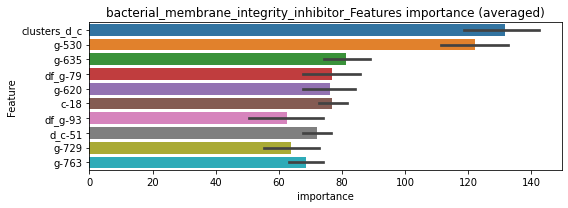

len(train_index) : 3893
len(valid_index) : 3894
================================= fold 1/2 bacterial_membrane_integrity_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0123459	valid_1's binary_logloss: 0.0185162
[200]	training's binary_logloss: 0.00141246	valid_1's binary_logloss: 0.00559786
[300]	training's binary_logloss: 0.000390056	valid_1's binary_logloss: 0.00413913
Early stopping, best iteration is:
[310]	training's binary_logloss: 0.000358555	valid_1's binary_logloss: 0.00413652


len(train_index) : 3894
len(valid_index) : 3893
================================= fold 2/2 bacterial_membrane_integrity_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0129696	valid_1's binary_logloss: 0.0169149
[200]	training's binary_logloss: 0.00151914	valid_1's binary_logloss: 0.0034659
[300]	training's binary_logloss: 0.000416903	valid_1's binary_logloss: 0.00195749
[400]	training's binary_logloss: 0.000217592	valid_1's binary_logloss: 0.00166591
Early stopping, best iteration is:
[462]	training's binary_logloss: 0.00018497	valid_1's binary_logloss: 0.0016264


bacterial_membrane_integrity_inhibitor logloss: 0.0028816219183686767
bcl_inhibitor, len(trt): 31, len(othr): 3283, target_rate: 0.0013018 → Adj_target_rate: 0.0015554


neg labels: 3289 → selected neg labels: 3283


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0296905	valid_1's binary_logloss: 0.0477462
[200]	training's binary_logloss: 0.0041954	valid_1's binary_logloss: 0.0149114
[300]	training's binary_logloss: 0.00120383	valid_1's binary_logloss: 0.00888651
[400]	training's binary_logloss: 0.000593294	valid_1's binary_logloss: 0.00674137
[500]	training's binary_logloss: 0.000420257	valid_1's binary_logloss: 0.00592845
Early stopping, best iteration is:
[519]	training's binary_logloss: 0.000412432	valid_1's binary_logloss: 0.0058823
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.031183	valid_1's binary_logloss: 0.0515435
[200]	training's binary_logloss: 0.00430927	valid_1's binary_logloss: 0.0183774
[300]	training's binary_logloss: 0.0012156	valid_1's binary_logloss: 0.012879
Early stopping, best iteration is:
[352]	training's binary_logloss: 0.00080759	valid_1's binary_logloss: 0.0119069


1 / 3 AUC score:1.000
Threshold: 0.0045019, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → positive_corect_labels: 656/3807
p_label_rate: 0.0660472 Vs.target_rate: 0.00130, Num_p_label: 263.0, conf_0:0.00036, conf_1:0.00495
Num_p_label: 263.0, Expected: 5.2, Adj_threshold_1: 0.0045019
Num_p_label: 182.0, Expected: 5.2, Adj_threshold_2: 0.0095019
Num_p_label: 155.0, Expected: 5.2, Adj_threshold_3: 0.0145019
Num_p_label: 133.0, Expected: 5.2, Adj_threshold_4: 0.0195019
Num_p_label: 120.0, Expected: 5.2, Adj_threshold_5: 0.0245019
Num_p_label: 113.0, Expected: 5.2, Adj_threshold_6: 0.0295019
Num_p_label: 107.0, Expected: 5.2, Adj_threshold_7: 0.0345019
Num_p_label: 102.0, Expected: 5.2, Adj_threshold_8: 0.0395019
Num_p_label: 99.0, Expected: 5.2, Adj_threshold_9: 0.0445019
Num_p_label: 96.0, Expected: 5.2, Adj_threshold_10: 0.0495019
threshold: 0.0545019, positive p_label: 95.0/3982, p_label_rate: 0.0238574
positive y_label: 656.0/3807, y_label_rate: 0.1723142
================= Pseud

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0280704	valid_1's binary_logloss: 0.0411711
[200]	training's binary_logloss: 0.00370625	valid_1's binary_logloss: 0.00974754
[300]	training's binary_logloss: 0.00106784	valid_1's binary_logloss: 0.00460303
[400]	training's binary_logloss: 0.00053916	valid_1's binary_logloss: 0.00312661
[500]	training's binary_logloss: 0.000396639	valid_1's binary_logloss: 0.00271967
Early stopping, best iteration is:
[500]	training's binary_logloss: 0.000396639	valid_1's binary_logloss: 0.00271967
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0286107	valid_1's binary_logloss: 0.0432074
[200]	training's binary_logloss: 0.0038231	valid_1's binary_logloss: 0.0133586
[300]	training's binary_logloss: 0.00109162	valid_1's binary_logloss: 0.00917392
Early stopping, best iteration is:
[363]	training's binary_logloss: 0.000677384	valid_1's binary_logloss: 0.00836411


2 / 3 AUC score:1.000
Threshold: 0.0545019, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 5 → positive_corect_labels: 656.0/3802
p_label_rate: 0.0459568 Vs.target_rate: 0.00130, Num_p_label: 183.0, conf_0:0.00037, conf_1:0.05995
Num_p_label: 183.0, Expected: 5.2, Adj_threshold_1: 0.0545019
Num_p_label: 181.0, Expected: 5.2, Adj_threshold_2: 0.0595019
Num_p_label: 178.0, Expected: 5.2, Adj_threshold_3: 0.0645019
Num_p_label: 175.0, Expected: 5.2, Adj_threshold_4: 0.0695019
Num_p_label: 171.0, Expected: 5.2, Adj_threshold_5: 0.0745019
Num_p_label: 166.0, Expected: 5.2, Adj_threshold_6: 0.0795019
Num_p_label: 165.0, Expected: 5.2, Adj_threshold_7: 0.0845019
Num_p_label: 165.0, Expected: 5.2, Adj_threshold_8: 0.0895019
Num_p_label: 165.0, Expected: 5.2, Adj_threshold_9: 0.0945019
Num_p_label: 164.0, Expected: 5.2, Adj_threshold_10: 0.0995019
threshold: 0.1045019, positive p_label: 164.0/3982, p_label_rate: 0.0411853
positive y_label: 656.0/3802, y_label_rate: 0.1725408
================= Ps

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0281559	valid_1's binary_logloss: 0.0428841
[200]	training's binary_logloss: 0.00375972	valid_1's binary_logloss: 0.0110402
[300]	training's binary_logloss: 0.00108119	valid_1's binary_logloss: 0.00581544
[400]	training's binary_logloss: 0.000547206	valid_1's binary_logloss: 0.00432808
Early stopping, best iteration is:
[390]	training's binary_logloss: 0.0005736	valid_1's binary_logloss: 0.00429194
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0290837	valid_1's binary_logloss: 0.0446408
[200]	training's binary_logloss: 0.00384533	valid_1's binary_logloss: 0.0134676
[300]	training's binary_logloss: 0.00108268	valid_1's binary_logloss: 0.00872868
[400]	training's binary_logloss: 0.000548427	valid_1's binary_logloss: 0.00751052
Early stopping, best iteration is:
[434]	training's binary_logloss: 0.000471175	valid_1's binary_logloss: 0.00728649


3 / 3 AUC score:1.000
Threshold: 0.1045019, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 3 → positive_corect_labels: 655.0/3799
p_label_rate: 0.0439478 Vs.target_rate: 0.00130, Num_p_label: 175.0, conf_0:0.00036, conf_1:0.11495
Num_p_label: 175.0, Expected: 5.2, Adj_threshold_1: 0.1045019
Num_p_label: 174.0, Expected: 5.2, Adj_threshold_2: 0.1095019
Num_p_label: 171.0, Expected: 5.2, Adj_threshold_3: 0.1145019
Num_p_label: 170.0, Expected: 5.2, Adj_threshold_4: 0.1195019
Num_p_label: 169.0, Expected: 5.2, Adj_threshold_5: 0.1245019
Num_p_label: 166.0, Expected: 5.2, Adj_threshold_6: 0.1295019
Num_p_label: 165.0, Expected: 5.2, Adj_threshold_7: 0.1345019
Num_p_label: 164.0, Expected: 5.2, Adj_threshold_8: 0.1395019
Num_p_label: 163.0, Expected: 5.2, Adj_threshold_9: 0.1445019
Num_p_label: 162.0, Expected: 5.2, Adj_threshold_10: 0.1495019
threshold: 0.1545019, positive p_label: 162.0/3982, p_label_rate: 0.0406831
positive y_label: 817.0/7781, y_label_rate: 0.1049994


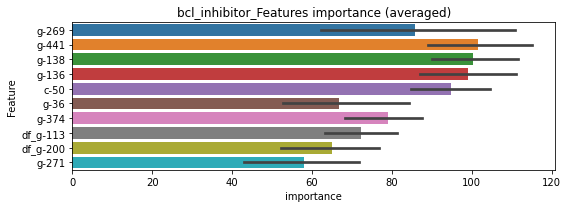

len(train_index) : 3890
len(valid_index) : 3891
================================= fold 1/2 bcl_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0196413	valid_1's binary_logloss: 0.0352274
[200]	training's binary_logloss: 0.002715	valid_1's binary_logloss: 0.0151018
[300]	training's binary_logloss: 0.000779879	valid_1's binary_logloss: 0.0124775
[400]	training's binary_logloss: 0.000372573	valid_1's binary_logloss: 0.0115542
Early stopping, best iteration is:
[419]	training's binary_logloss: 0.000337484	valid_1's binary_logloss: 0.0114238


len(train_index) : 3891
len(valid_index) : 3890
================================= fold 2/2 bcl_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0195042	valid_1's binary_logloss: 0.0330378
[200]	training's binary_logloss: 0.00275158	valid_1's binary_logloss: 0.0124738
[300]	training's binary_logloss: 0.000781652	valid_1's binary_logloss: 0.00918803
Early stopping, best iteration is:
[379]	training's binary_logloss: 0.000432752	valid_1's binary_logloss: 0.00863457


bcl_inhibitor logloss: 0.010029378273898963
bcr-abl_inhibitor, len(trt): 38, len(othr): 3283, target_rate: 0.0015957 → Adj_target_rate: 0.0018493


neg labels: 3289 → selected neg labels: 3283


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0322373	valid_1's binary_logloss: 0.0554044
[200]	training's binary_logloss: 0.00501362	valid_1's binary_logloss: 0.0214623
[300]	training's binary_logloss: 0.00141597	valid_1's binary_logloss: 0.0139904
Early stopping, best iteration is:
[335]	training's binary_logloss: 0.00105913	valid_1's binary_logloss: 0.0133993
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0317301	valid_1's binary_logloss: 0.050511
[200]	training's binary_logloss: 0.00477379	valid_1's binary_logloss: 0.0169623
[300]	training's binary_logloss: 0.00136032	valid_1's binary_logloss: 0.0107257
[400]	training's binary_logloss: 0.000693573	valid_1's binary_logloss: 0.00922693
Early stopping, best iteration is:
[470]	training's binary_logloss: 0.000520101	valid_1's binary_logloss: 0.00864069


1 / 3 AUC score:1.000
Threshold: 0.0057605, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → positive_corect_labels: 656/3807
p_label_rate: 0.0376695 Vs.target_rate: 0.00160, Num_p_label: 150.0, conf_0:0.00061, conf_1:0.00634
Num_p_label: 150.0, Expected: 6.4, Adj_threshold_1: 0.0057605
Num_p_label: 83.0, Expected: 6.4, Adj_threshold_2: 0.0107605
Num_p_label: 53.0, Expected: 6.4, Adj_threshold_3: 0.0157605
Num_p_label: 38.0, Expected: 6.4, Adj_threshold_4: 0.0207605
Num_p_label: 31.0, Expected: 6.4, Adj_threshold_5: 0.0257605
Num_p_label: 27.0, Expected: 6.4, Adj_threshold_6: 0.0307605
Num_p_label: 21.0, Expected: 6.4, Adj_threshold_7: 0.0357605
Num_p_label: 17.0, Expected: 6.4, Adj_threshold_8: 0.0407605
Num_p_label: 16.0, Expected: 6.4, Adj_threshold_9: 0.0457605
Num_p_label: 16.0, Expected: 6.4, Adj_threshold_10: 0.0507605
threshold: 0.0557605, positive p_label: 14.0/3982, p_label_rate: 0.0035158
positive y_label: 656.0/3807, y_label_rate: 0.1723142
================= Pseudo label

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0307424	valid_1's binary_logloss: 0.0504724
[200]	training's binary_logloss: 0.00449943	valid_1's binary_logloss: 0.0157205
[300]	training's binary_logloss: 0.00130338	valid_1's binary_logloss: 0.00927703
[400]	training's binary_logloss: 0.000655518	valid_1's binary_logloss: 0.00709227
[500]	training's binary_logloss: 0.000466965	valid_1's binary_logloss: 0.00652104
Early stopping, best iteration is:
[490]	training's binary_logloss: 0.000476494	valid_1's binary_logloss: 0.00648683
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0309332	valid_1's binary_logloss: 0.0486476
[200]	training's binary_logloss: 0.00442595	valid_1's binary_logloss: 0.0142747
[300]	training's binary_logloss: 0.00126873	valid_1's binary_logloss: 0.00870783
[400]	training's binary_logloss: 0.000652672	valid_1's binary_logloss: 0.00729432
Early stopping, best iteration is:


2 / 3 AUC score:1.000
Threshold: 0.0557605, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 2 → positive_corect_labels: 655.0/3805
p_label_rate: 0.0113009 Vs.target_rate: 0.00160, Num_p_label: 45.0, conf_0:0.00046, conf_1:0.06134
Num_p_label: 45.0, Expected: 6.4, Adj_threshold_1: 0.0557605
Num_p_label: 45.0, Expected: 6.4, Adj_threshold_2: 0.0607605
Num_p_label: 42.0, Expected: 6.4, Adj_threshold_3: 0.0657605
Num_p_label: 42.0, Expected: 6.4, Adj_threshold_4: 0.0707605
Num_p_label: 38.0, Expected: 6.4, Adj_threshold_5: 0.0757605
Num_p_label: 38.0, Expected: 6.4, Adj_threshold_6: 0.0807605
Num_p_label: 37.0, Expected: 6.4, Adj_threshold_7: 0.0857605
Num_p_label: 36.0, Expected: 6.4, Adj_threshold_8: 0.0907605
Num_p_label: 35.0, Expected: 6.4, Adj_threshold_9: 0.0957605
Num_p_label: 33.0, Expected: 6.4, Adj_threshold_10: 0.1007605
threshold: 0.1057605, positive p_label: 33.0/3982, p_label_rate: 0.0082873
positive y_label: 655.0/3805, y_label_rate: 0.1721419
================= Pseudo labelin

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0318559	valid_1's binary_logloss: 0.0519432
[200]	training's binary_logloss: 0.00464144	valid_1's binary_logloss: 0.0164387
[300]	training's binary_logloss: 0.00132092	valid_1's binary_logloss: 0.00907812
Early stopping, best iteration is:
[341]	training's binary_logloss: 0.000943692	valid_1's binary_logloss: 0.00787942
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0302422	valid_1's binary_logloss: 0.0511758
[200]	training's binary_logloss: 0.00435154	valid_1's binary_logloss: 0.0175653
[300]	training's binary_logloss: 0.00126141	valid_1's binary_logloss: 0.0116701
[400]	training's binary_logloss: 0.000635944	valid_1's binary_logloss: 0.0093925
Early stopping, best iteration is:
[394]	training's binary_logloss: 0.000656507	valid_1's binary_logloss: 0.00932279


3 / 3 AUC score:1.000
Threshold: 0.1057605, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 1 → positive_corect_labels: 654.0/3804
p_label_rate: 0.0087896 Vs.target_rate: 0.00160, Num_p_label: 35.0, conf_0:0.00071, conf_1:0.11634
Num_p_label: 35.0, Expected: 6.4, Adj_threshold_1: 0.1057605
Num_p_label: 35.0, Expected: 6.4, Adj_threshold_2: 0.1107605
Num_p_label: 33.0, Expected: 6.4, Adj_threshold_3: 0.1157605
Num_p_label: 31.0, Expected: 6.4, Adj_threshold_4: 0.1207605
Num_p_label: 30.0, Expected: 6.4, Adj_threshold_5: 0.1257605
Num_p_label: 28.0, Expected: 6.4, Adj_threshold_6: 0.1307605
Num_p_label: 27.0, Expected: 6.4, Adj_threshold_7: 0.1357605
Num_p_label: 24.0, Expected: 6.4, Adj_threshold_8: 0.1407605
Num_p_label: 23.0, Expected: 6.4, Adj_threshold_9: 0.1457605
Num_p_label: 23.0, Expected: 6.4, Adj_threshold_10: 0.1507605
threshold: 0.1557605, positive p_label: 23.0/3982, p_label_rate: 0.0057760
positive y_label: 677.0/7786, y_label_rate: 0.0869509


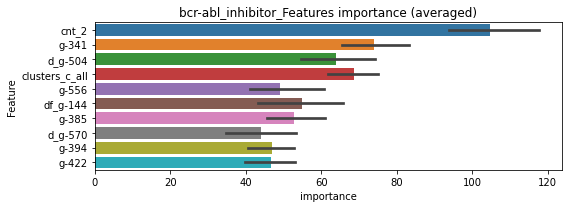

len(train_index) : 3893
len(valid_index) : 3893
================================= fold 1/2 bcr-abl_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0172077	valid_1's binary_logloss: 0.0317433
[200]	training's binary_logloss: 0.00252123	valid_1's binary_logloss: 0.013314
[300]	training's binary_logloss: 0.00072846	valid_1's binary_logloss: 0.0100589
[400]	training's binary_logloss: 0.000364067	valid_1's binary_logloss: 0.00941752
Early stopping, best iteration is:
[403]	training's binary_logloss: 0.000358751	valid_1's binary_logloss: 0.00939343


len(train_index) : 3893
len(valid_index) : 3893
================================= fold 2/2 bcr-abl_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0172517	valid_1's binary_logloss: 0.0334585
[200]	training's binary_logloss: 0.00254235	valid_1's binary_logloss: 0.0142923
[300]	training's binary_logloss: 0.000714469	valid_1's binary_logloss: 0.0105798
Early stopping, best iteration is:
[380]	training's binary_logloss: 0.000401743	valid_1's binary_logloss: 0.00954495


bcr-abl_inhibitor logloss: 0.009469191543837557
benzodiazepine_receptor_agonist, len(trt): 67, len(othr): 3277, target_rate: 0.0028135 → Adj_target_rate: 0.0029948


neg labels: 3289 → selected neg labels: 3277


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0521667	valid_1's binary_logloss: 0.111579
[200]	training's binary_logloss: 0.0107937	valid_1's binary_logloss: 0.0667604
[300]	training's binary_logloss: 0.00307009	valid_1's binary_logloss: 0.056998
Early stopping, best iteration is:
[341]	training's binary_logloss: 0.00212347	valid_1's binary_logloss: 0.0556694
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0518839	valid_1's binary_logloss: 0.108327
[200]	training's binary_logloss: 0.0111101	valid_1's binary_logloss: 0.0520326
[300]	training's binary_logloss: 0.00325553	valid_1's binary_logloss: 0.0340925
[400]	training's binary_logloss: 0.00149594	valid_1's binary_logloss: 0.0289961
[500]	training's binary_logloss: 0.000921651	valid_1's binary_logloss: 0.0265204
Early stopping, best iteration is:
[492]	training's binary_logloss: 0.000953491	valid_1's binary_logloss: 0.0263178


1 / 3 AUC score:0.997
Threshold: 0.0120206, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 148 → positive_corect_labels: 647/3784
p_label_rate: 0.0389252 Vs.target_rate: 0.00281, Num_p_label: 155.0, conf_0:0.00167, conf_1:0.01322
Num_p_label: 155.0, Expected: 11.2, Adj_threshold_1: 0.0120206
Num_p_label: 91.0, Expected: 11.2, Adj_threshold_2: 0.0170206
Num_p_label: 66.0, Expected: 11.2, Adj_threshold_3: 0.0220206
Num_p_label: 48.0, Expected: 11.2, Adj_threshold_4: 0.0270206
Num_p_label: 30.0, Expected: 11.2, Adj_threshold_5: 0.0320206
Num_p_label: 25.0, Expected: 11.2, Adj_threshold_6: 0.0370206
Num_p_label: 19.0, Expected: 11.2, Adj_threshold_7: 0.0420206
threshold: 0.0420206, positive p_label: 19.0/3982, p_label_rate: 0.0047715
positive y_label: 647.0/3784, y_label_rate: 0.1709831
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0486833	valid_1's binary_logloss: 0.0979634
[200]	training's binary_logloss: 0.0095835	valid_1's binary_logloss: 0.047637
[300]	training's binary_logloss: 0.0028522	valid_1's binary_logloss: 0.0354786
[400]	training's binary_logloss: 0.00133311	valid_1's binary_logloss: 0.0317229
[500]	training's binary_logloss: 0.00083006	valid_1's binary_logloss: 0.0302016
Early stopping, best iteration is:
[490]	training's binary_logloss: 0.000857434	valid_1's binary_logloss: 0.0301438
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0511089	valid_1's binary_logloss: 0.0980209
[200]	training's binary_logloss: 0.0100312	valid_1's binary_logloss: 0.0474324
[300]	training's binary_logloss: 0.00299497	valid_1's binary_logloss: 0.0339602
Early stopping, best iteration is:
[383]	training's binary_logloss: 0.00155151	valid_1's binary_logloss: 0.0301681


2 / 3 AUC score:1.000
Threshold: 0.0420206, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 15 → positive_corect_labels: 635.0/3769
p_label_rate: 0.0113009 Vs.target_rate: 0.00281, Num_p_label: 45.0, conf_0:0.00146, conf_1:0.04622
Num_p_label: 45.0, Expected: 11.2, Adj_threshold_1: 0.0420206
Num_p_label: 38.0, Expected: 11.2, Adj_threshold_2: 0.0470206
Num_p_label: 29.0, Expected: 11.2, Adj_threshold_3: 0.0520206
Num_p_label: 25.0, Expected: 11.2, Adj_threshold_4: 0.0570206
Num_p_label: 22.0, Expected: 11.2, Adj_threshold_5: 0.0620206
threshold: 0.0620206, positive p_label: 22.0/3982, p_label_rate: 0.0055249
positive y_label: 635.0/3769, y_label_rate: 0.1684797
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0481158	valid_1's binary_logloss: 0.0956234
[200]	training's binary_logloss: 0.0095666	valid_1's binary_logloss: 0.0455197
[300]	training's binary_logloss: 0.00282249	valid_1's binary_logloss: 0.0318819
[400]	training's binary_logloss: 0.0013275	valid_1's binary_logloss: 0.0276257
[500]	training's binary_logloss: 0.000830935	valid_1's binary_logloss: 0.025883
Early stopping, best iteration is:
[495]	training's binary_logloss: 0.000844642	valid_1's binary_logloss: 0.0258123
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0499983	valid_1's binary_logloss: 0.0983242
[200]	training's binary_logloss: 0.00951745	valid_1's binary_logloss: 0.0463834
[300]	training's binary_logloss: 0.0028045	valid_1's binary_logloss: 0.0327508
[400]	training's binary_logloss: 0.001334	valid_1's binary_logloss: 0.0287343
Early stopping, best iteration is:
[390]	training

3 / 3 AUC score:1.000
Threshold: 0.0620206, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 11 → positive_corect_labels: 629.0/3758
p_label_rate: 0.0065294 Vs.target_rate: 0.00281, Num_p_label: 26.0, conf_0:0.00131, conf_1:0.06822
threshold: 0.0620206, positive p_label: 26.0/3982, p_label_rate: 0.0065294
positive y_label: 655.0/7740, y_label_rate: 0.0846253


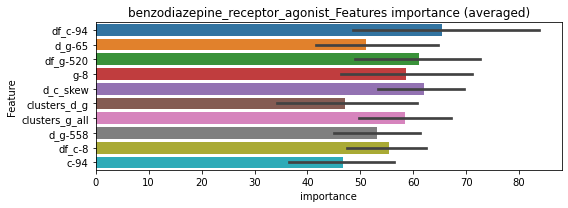

len(train_index) : 3870
len(valid_index) : 3870
================================= fold 1/2 benzodiazepine_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.028973	valid_1's binary_logloss: 0.0613593
[200]	training's binary_logloss: 0.00641112	valid_1's binary_logloss: 0.0360976
[300]	training's binary_logloss: 0.00250224	valid_1's binary_logloss: 0.0306242
Early stopping, best iteration is:
[350]	training's binary_logloss: 0.0019855	valid_1's binary_logloss: 0.0300112


len(train_index) : 3870
len(valid_index) : 3870
================================= fold 2/2 benzodiazepine_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.030274	valid_1's binary_logloss: 0.0583318
[200]	training's binary_logloss: 0.00598798	valid_1's binary_logloss: 0.0272862
[300]	training's binary_logloss: 0.00182041	valid_1's binary_logloss: 0.0198673
Early stopping, best iteration is:
[385]	training's binary_logloss: 0.000912065	valid_1's binary_logloss: 0.0185252


benzodiazepine_receptor_agonist logloss: 0.024268214519775604


  acetylcholine_receptor_agonist acetylcholine_receptor_antagonist  \
0                       df_g-122                              c-30   
1                  clusters_df_c                         c_all_max   
2                          cnt_0                    clusters_g_all   
3                      c_all_min                          df_g-707   
4                        df_g-51                        clusters_g   
5                       df_c_min                          df_c_min   
6                          cnt_2                             g-514   
7                       df_g-736                          df_g-640   
8                          g-244                            df_c-6   
9                           c-73                          df_g-597   

  acetylcholinesterase_inhibitor adenosine_receptor_antagonist  \
0                      c_all_max                clusters_c_all   
1                      c_all_min                      df_c_min   
2                 clusters_g_al

beta_amyloid_inhibitor, len(trt): 24, len(othr): 3285, target_rate: 0.0010078 → Adj_target_rate: 0.0012513


neg labels: 3289 → selected neg labels: 3285


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0308327	valid_1's binary_logloss: 0.0460882
[200]	training's binary_logloss: 0.00417673	valid_1's binary_logloss: 0.0130653
[300]	training's binary_logloss: 0.00116332	valid_1's binary_logloss: 0.00846928
[400]	training's binary_logloss: 0.000582002	valid_1's binary_logloss: 0.00756175
[500]	training's binary_logloss: 0.000416315	valid_1's binary_logloss: 0.00719267
Early stopping, best iteration is:
[502]	training's binary_logloss: 0.000415469	valid_1's binary_logloss: 0.00719136
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0312591	valid_1's binary_logloss: 0.0425071
[200]	training's binary_logloss: 0.00438037	valid_1's binary_logloss: 0.00880586
[300]	training's binary_logloss: 0.00120863	valid_1's binary_logloss: 0.00356983
[400]	training's binary_logloss: 0.00060229	valid_1's binary_logloss: 0.00223109
[500]	training's binary_logloss: 0.

1 / 3 AUC score:1.000
Threshold: 0.0024934, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → positive_corect_labels: 657/3810
p_label_rate: 0.0429432 Vs.target_rate: 0.00101, Num_p_label: 171.0, conf_0:0.00032, conf_1:0.00274
Num_p_label: 171.0, Expected: 4.0, Adj_threshold_1: 0.0024934
Num_p_label: 30.0, Expected: 4.0, Adj_threshold_2: 0.0074934
Num_p_label: 12.0, Expected: 4.0, Adj_threshold_3: 0.0124934
Num_p_label: 4.0, Expected: 4.0, Adj_threshold_4: 0.0174934
threshold: 0.0174934, positive p_label: 4.0/3982, p_label_rate: 0.0010045
positive y_label: 657.0/3810, y_label_rate: 0.1724409
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0295679	valid_1's binary_logloss: 0.0441168
[200]	training's binary_logloss: 0.0039521	valid_1's binary_logloss: 0.0129774
[300]	training's binary_logloss: 0.00111715	valid_1's binary_logloss: 0.00816722
[400]	training's binary_logloss: 0.000569087	valid_1's binary_logloss: 0.00722578
Early stopping, best iteration is:
[445]	training's binary_logloss: 0.000469836	valid_1's binary_logloss: 0.00700277
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0303295	valid_1's binary_logloss: 0.0406185
[200]	training's binary_logloss: 0.00420591	valid_1's binary_logloss: 0.00783108
[300]	training's binary_logloss: 0.00118206	valid_1's binary_logloss: 0.00297895
[400]	training's binary_logloss: 0.000601711	valid_1's binary_logloss: 0.00187057
[500]	training's binary_logloss: 0.000425341	valid_1's binary_logloss: 0.00148295
Early stopping, best iteration is:


2 / 3 AUC score:1.000
Threshold: 0.0174934, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 2 → positive_corect_labels: 655.0/3808
p_label_rate: 0.0045203 Vs.target_rate: 0.00101, Num_p_label: 18.0, conf_0:0.00041, conf_1:0.01924
Num_p_label: 18.0, Expected: 4.0, Adj_threshold_1: 0.0174934
Num_p_label: 10.0, Expected: 4.0, Adj_threshold_2: 0.0224934
Num_p_label: 6.0, Expected: 4.0, Adj_threshold_3: 0.0274934
threshold: 0.0274934, positive p_label: 6.0/3982, p_label_rate: 0.0015068
positive y_label: 655.0/3808, y_label_rate: 0.1720063
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0287221	valid_1's binary_logloss: 0.04308
[200]	training's binary_logloss: 0.00389075	valid_1's binary_logloss: 0.00928737
[300]	training's binary_logloss: 0.00110784	valid_1's binary_logloss: 0.0041693
[400]	training's binary_logloss: 0.000568841	valid_1's binary_logloss: 0.00267255
[500]	training's binary_logloss: 0.000406696	valid_1's binary_logloss: 0.00223444
Early stopping, best iteration is:
[513]	training's binary_logloss: 0.000402546	valid_1's binary_logloss: 0.00223003
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0296723	valid_1's binary_logloss: 0.0450115
[200]	training's binary_logloss: 0.00401511	valid_1's binary_logloss: 0.0106993
[300]	training's binary_logloss: 0.00111579	valid_1's binary_logloss: 0.00430183
[400]	training's binary_logloss: 0.00056785	valid_1's binary_logloss: 0.00283929
[500]	training's binary_logloss: 0.000

3 / 3 AUC score:1.000
Threshold: 0.0274934, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → positive_corect_labels: 655.0/3808
p_label_rate: 0.0025113 Vs.target_rate: 0.00101, Num_p_label: 10.0, conf_0:0.00036, conf_1:0.03024
threshold: 0.0274934, positive p_label: 10.0/3982, p_label_rate: 0.0025113
positive y_label: 665.0/7790, y_label_rate: 0.0853659


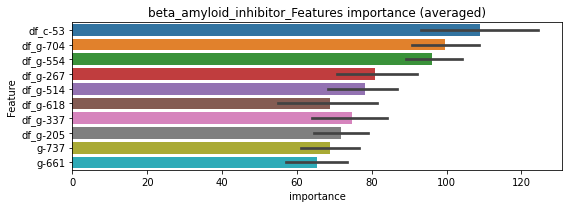

len(train_index) : 3895
len(valid_index) : 3895
================================= fold 1/2 beta_amyloid_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0175671	valid_1's binary_logloss: 0.0286475
[200]	training's binary_logloss: 0.00240142	valid_1's binary_logloss: 0.0105051
Early stopping, best iteration is:
[275]	training's binary_logloss: 0.000837904	valid_1's binary_logloss: 0.009029


len(train_index) : 3895
len(valid_index) : 3895
================================= fold 2/2 beta_amyloid_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0179513	valid_1's binary_logloss: 0.0287073
[200]	training's binary_logloss: 0.00246036	valid_1's binary_logloss: 0.0108077
[300]	training's binary_logloss: 0.000678749	valid_1's binary_logloss: 0.0078519
Early stopping, best iteration is:
[330]	training's binary_logloss: 0.000522531	valid_1's binary_logloss: 0.00742653


beta_amyloid_inhibitor logloss: 0.00822776332485296
bromodomain_inhibitor, len(trt): 68, len(othr): 3276, target_rate: 0.0028555 → Adj_target_rate: 0.0030327


neg labels: 3289 → selected neg labels: 3276


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0376958	valid_1's binary_logloss: 0.075505
[200]	training's binary_logloss: 0.00627547	valid_1's binary_logloss: 0.0358681
[300]	training's binary_logloss: 0.00182547	valid_1's binary_logloss: 0.0270475
Early stopping, best iteration is:
[349]	training's binary_logloss: 0.00122197	valid_1's binary_logloss: 0.0259275
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0374113	valid_1's binary_logloss: 0.0814578
[200]	training's binary_logloss: 0.00626794	valid_1's binary_logloss: 0.0466262
[300]	training's binary_logloss: 0.00182175	valid_1's binary_logloss: 0.0402642
Early stopping, best iteration is:
[318]	training's binary_logloss: 0.00154917	valid_1's binary_logloss: 0.0393462


1 / 3 AUC score:0.999
Threshold: 0.0080052, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 136 → positive_corect_labels: 653/3795
p_label_rate: 0.0371673 Vs.target_rate: 0.00286, Num_p_label: 148.0, conf_0:0.00130, conf_1:0.00881
Num_p_label: 148.0, Expected: 11.4, Adj_threshold_1: 0.0080052
Num_p_label: 78.0, Expected: 11.4, Adj_threshold_2: 0.0130052
Num_p_label: 45.0, Expected: 11.4, Adj_threshold_3: 0.0180052
Num_p_label: 30.0, Expected: 11.4, Adj_threshold_4: 0.0230052
Num_p_label: 22.0, Expected: 11.4, Adj_threshold_5: 0.0280052
threshold: 0.0280052, positive p_label: 22.0/3982, p_label_rate: 0.0055249
positive y_label: 653.0/3795, y_label_rate: 0.1720685
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.034717	valid_1's binary_logloss: 0.0823619
[200]	training's binary_logloss: 0.00541099	valid_1's binary_logloss: 0.0463562
[300]	training's binary_logloss: 0.00159445	valid_1's binary_logloss: 0.038571
Early stopping, best iteration is:
[377]	training's binary_logloss: 0.000894749	valid_1's binary_logloss: 0.0356898
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0356901	valid_1's binary_logloss: 0.0658086
[200]	training's binary_logloss: 0.00586121	valid_1's binary_logloss: 0.0269153
[300]	training's binary_logloss: 0.00171312	valid_1's binary_logloss: 0.0197013
[400]	training's binary_logloss: 0.000847911	valid_1's binary_logloss: 0.0171212
Early stopping, best iteration is:
[440]	training's binary_logloss: 0.00069813	valid_1's binary_logloss: 0.0167447


2 / 3 AUC score:1.000
Threshold: 0.0280052, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 8 → positive_corect_labels: 650.0/3787
p_label_rate: 0.0113009 Vs.target_rate: 0.00286, Num_p_label: 45.0, conf_0:0.00089, conf_1:0.03081
Num_p_label: 45.0, Expected: 11.4, Adj_threshold_1: 0.0280052
Num_p_label: 38.0, Expected: 11.4, Adj_threshold_2: 0.0330052
Num_p_label: 32.0, Expected: 11.4, Adj_threshold_3: 0.0380052
Num_p_label: 28.0, Expected: 11.4, Adj_threshold_4: 0.0430052
Num_p_label: 26.0, Expected: 11.4, Adj_threshold_5: 0.0480052
Num_p_label: 25.0, Expected: 11.4, Adj_threshold_6: 0.0530052
Num_p_label: 21.0, Expected: 11.4, Adj_threshold_7: 0.0580052
threshold: 0.0580052, positive p_label: 21.0/3982, p_label_rate: 0.0052737
positive y_label: 650.0/3787, y_label_rate: 0.1716398
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0350706	valid_1's binary_logloss: 0.0814178
[200]	training's binary_logloss: 0.00533956	valid_1's binary_logloss: 0.0461868
Early stopping, best iteration is:
[264]	training's binary_logloss: 0.00224293	valid_1's binary_logloss: 0.0397159
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0350312	valid_1's binary_logloss: 0.0632937
[200]	training's binary_logloss: 0.00564754	valid_1's binary_logloss: 0.0274584
[300]	training's binary_logloss: 0.00166365	valid_1's binary_logloss: 0.0208237


3 / 3 AUC score:0.999


Early stopping, best iteration is:
[311]	training's binary_logloss: 0.00150369	valid_1's binary_logloss: 0.0204496


Threshold: 0.0580052, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 9 → positive_corect_labels: 641.0/3778
p_label_rate: 0.0075339 Vs.target_rate: 0.00286, Num_p_label: 30.0, conf_0:0.00188, conf_1:0.06381
threshold: 0.0580052, positive p_label: 30.0/3982, p_label_rate: 0.0075339
positive y_label: 671.0/7760, y_label_rate: 0.0864691


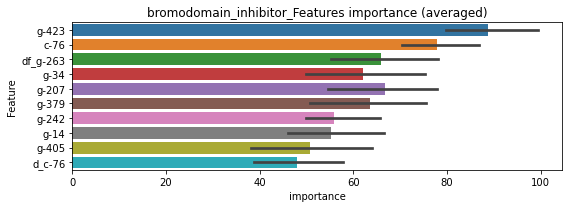

len(train_index) : 3880
len(valid_index) : 3880
================================= fold 1/2 bromodomain_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0205063	valid_1's binary_logloss: 0.0463744
[200]	training's binary_logloss: 0.00327946	valid_1's binary_logloss: 0.0283143
Early stopping, best iteration is:
[286]	training's binary_logloss: 0.00109201	valid_1's binary_logloss: 0.0258497


len(train_index) : 3880
len(valid_index) : 3880
================================= fold 2/2 bromodomain_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0204062	valid_1's binary_logloss: 0.0450415
[200]	training's binary_logloss: 0.00333556	valid_1's binary_logloss: 0.0237779
[300]	training's binary_logloss: 0.000995762	valid_1's binary_logloss: 0.0198521
Early stopping, best iteration is:
[303]	training's binary_logloss: 0.00096776	valid_1's binary_logloss: 0.0198075


bromodomain_inhibitor logloss: 0.022828589981914404


  acetylcholine_receptor_agonist acetylcholine_receptor_antagonist  \
0                       df_g-122                              c-30   
1                  clusters_df_c                         c_all_max   
2                          cnt_0                    clusters_g_all   
3                      c_all_min                          df_g-707   
4                        df_g-51                        clusters_g   
5                       df_c_min                          df_c_min   
6                          cnt_2                             g-514   
7                       df_g-736                          df_g-640   
8                          g-244                            df_c-6   
9                           c-73                          df_g-597   

  acetylcholinesterase_inhibitor adenosine_receptor_antagonist  \
0                      c_all_max                clusters_c_all   
1                      c_all_min                      df_c_min   
2                 clusters_g_al

btk_inhibitor, len(trt): 29, len(othr): 3284, target_rate: 0.0012178 → Adj_target_rate: 0.0014697


neg labels: 3289 → selected neg labels: 3284


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0299805	valid_1's binary_logloss: 0.0575834
[200]	training's binary_logloss: 0.0040849	valid_1's binary_logloss: 0.0216177
[300]	training's binary_logloss: 0.00115912	valid_1's binary_logloss: 0.0132415
[400]	training's binary_logloss: 0.000586253	valid_1's binary_logloss: 0.0106912
Early stopping, best iteration is:
[417]	training's binary_logloss: 0.000538927	valid_1's binary_logloss: 0.0103455
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0284551	valid_1's binary_logloss: 0.0465962
[200]	training's binary_logloss: 0.00389506	valid_1's binary_logloss: 0.016829
[300]	training's binary_logloss: 0.00110695	valid_1's binary_logloss: 0.0126826
[400]	training's binary_logloss: 0.000560763	valid_1's binary_logloss: 0.0120535
Early stopping, best iteration is:
[405]	training's binary_logloss: 0.000547006	valid_1's binary_logloss: 0.0120052


1 / 3 AUC score:1.000
Threshold: 0.0038701, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 134 → positive_corect_labels: 655/3806
p_label_rate: 0.0457057 Vs.target_rate: 0.00122, Num_p_label: 182.0, conf_0:0.00044, conf_1:0.00426
Num_p_label: 182.0, Expected: 4.8, Adj_threshold_1: 0.0038701
Num_p_label: 64.0, Expected: 4.8, Adj_threshold_2: 0.0088701
Num_p_label: 38.0, Expected: 4.8, Adj_threshold_3: 0.0138701
Num_p_label: 23.0, Expected: 4.8, Adj_threshold_4: 0.0188701
Num_p_label: 16.0, Expected: 4.8, Adj_threshold_5: 0.0238701
Num_p_label: 11.0, Expected: 4.8, Adj_threshold_6: 0.0288701
Num_p_label: 9.0, Expected: 4.8, Adj_threshold_7: 0.0338701
threshold: 0.0338701, positive p_label: 9.0/3982, p_label_rate: 0.0022602
positive y_label: 655.0/3806, y_label_rate: 0.1720967
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0295211	valid_1's binary_logloss: 0.0491521
[200]	training's binary_logloss: 0.00387377	valid_1's binary_logloss: 0.0123836
[300]	training's binary_logloss: 0.00108898	valid_1's binary_logloss: 0.00597564
[400]	training's binary_logloss: 0.000559601	valid_1's binary_logloss: 0.00449025
[500]	training's binary_logloss: 0.000402697	valid_1's binary_logloss: 0.00368617
Early stopping, best iteration is:
[551]	training's binary_logloss: 0.000383409	valid_1's binary_logloss: 0.00360105
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0289818	valid_1's binary_logloss: 0.0443296
[200]	training's binary_logloss: 0.00386843	valid_1's binary_logloss: 0.00944241
[300]	training's binary_logloss: 0.00111358	valid_1's binary_logloss: 0.00373554
[400]	training's binary_logloss: 0.000562722	valid_1's binary_logloss: 0.00222871
[500]	training's binary_logloss: 0

2 / 3 AUC score:1.000
Threshold: 0.0338701, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → positive_corect_labels: 655.0/3806
p_label_rate: 0.0042692 Vs.target_rate: 0.00122, Num_p_label: 17.0, conf_0:0.00034, conf_1:0.03726
Num_p_label: 17.0, Expected: 4.8, Adj_threshold_1: 0.0338701
Num_p_label: 17.0, Expected: 4.8, Adj_threshold_2: 0.0388701
Num_p_label: 14.0, Expected: 4.8, Adj_threshold_3: 0.0438701
Num_p_label: 12.0, Expected: 4.8, Adj_threshold_4: 0.0488701
Num_p_label: 11.0, Expected: 4.8, Adj_threshold_5: 0.0538701
Num_p_label: 11.0, Expected: 4.8, Adj_threshold_6: 0.0588701
Num_p_label: 8.0, Expected: 4.8, Adj_threshold_7: 0.0638701
threshold: 0.0638701, positive p_label: 8.0/3982, p_label_rate: 0.0020090
positive y_label: 655.0/3806, y_label_rate: 0.1720967
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0295211	valid_1's binary_logloss: 0.0491521
[200]	training's binary_logloss: 0.00387377	valid_1's binary_logloss: 0.0123836
[300]	training's binary_logloss: 0.00108898	valid_1's binary_logloss: 0.00597564
[400]	training's binary_logloss: 0.000559601	valid_1's binary_logloss: 0.00449025
[500]	training's binary_logloss: 0.000402697	valid_1's binary_logloss: 0.00368617
Early stopping, best iteration is:
[551]	training's binary_logloss: 0.000383409	valid_1's binary_logloss: 0.00360105
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0289818	valid_1's binary_logloss: 0.0443296
[200]	training's binary_logloss: 0.00386843	valid_1's binary_logloss: 0.00944241
[300]	training's binary_logloss: 0.00111358	valid_1's binary_logloss: 0.00373554
[400]	training's binary_logloss: 0.000562722	valid_1's binary_logloss: 0.00222871
[500]	training's binary_logloss: 0

3 / 3 AUC score:1.000
Threshold: 0.0638701, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → positive_corect_labels: 655.0/3806
p_label_rate: 0.0020090 Vs.target_rate: 0.00122, Num_p_label: 8.0, conf_0:0.00034, conf_1:0.07026
threshold: 0.0638701, positive p_label: 8.0/3982, p_label_rate: 0.0020090
positive y_label: 663.0/7788, y_label_rate: 0.0851310


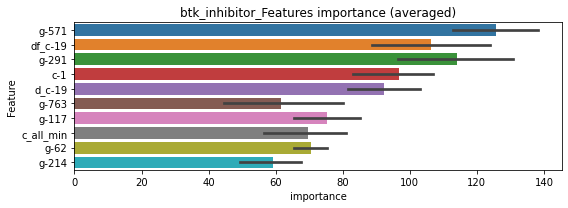

len(train_index) : 3894
len(valid_index) : 3894
================================= fold 1/2 btk_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.015547	valid_1's binary_logloss: 0.0276603
[200]	training's binary_logloss: 0.00203999	valid_1's binary_logloss: 0.0107513
[300]	training's binary_logloss: 0.000570398	valid_1's binary_logloss: 0.00856249
Early stopping, best iteration is:
[331]	training's binary_logloss: 0.000440834	valid_1's binary_logloss: 0.00833408


len(train_index) : 3894
len(valid_index) : 3894
================================= fold 2/2 btk_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0155283	valid_1's binary_logloss: 0.0307565
[200]	training's binary_logloss: 0.0020568	valid_1's binary_logloss: 0.012884
[300]	training's binary_logloss: 0.000580419	valid_1's binary_logloss: 0.0105735
Early stopping, best iteration is:
[319]	training's binary_logloss: 0.000492253	valid_1's binary_logloss: 0.010256


btk_inhibitor logloss: 0.009295019238775841
calcineurin_inhibitor, len(trt): 12, len(othr): 3287, target_rate: 0.0005039 → Adj_target_rate: 0.0006942


neg labels: 3289 → selected neg labels: 3287


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0183332	valid_1's binary_logloss: 0.0278314
[200]	training's binary_logloss: 0.001861	valid_1's binary_logloss: 0.006819
[300]	training's binary_logloss: 0.000528024	valid_1's binary_logloss: 0.00356029
[400]	training's binary_logloss: 0.000302546	valid_1's binary_logloss: 0.00266333
Early stopping, best iteration is:
[465]	training's binary_logloss: 0.000266704	valid_1's binary_logloss: 0.00255169
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0185751	valid_1's binary_logloss: 0.0205837
[200]	training's binary_logloss: 0.00187423	valid_1's binary_logloss: 0.00259072
[300]	training's binary_logloss: 0.000531547	valid_1's binary_logloss: 0.000916084
[400]	training's binary_logloss: 0.000301097	valid_1's binary_logloss: 0.000588148
[500]	training's binary_logloss: 0.00026247	valid_1's binary_logloss: 0.000527731
Early stopping, best iteration is

1 / 3 AUC score:1.000
Threshold: 0.0009673, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → positive_corect_labels: 657/3812
p_label_rate: 0.0439478 Vs.target_rate: 0.00050, Num_p_label: 175.0, conf_0:0.00017, conf_1:0.00106
Num_p_label: 175.0, Expected: 2.0, Adj_threshold_1: 0.0009673
Num_p_label: 15.0, Expected: 2.0, Adj_threshold_2: 0.0059673
Num_p_label: 7.0, Expected: 2.0, Adj_threshold_3: 0.0109673
Num_p_label: 7.0, Expected: 2.0, Adj_threshold_4: 0.0159673
Num_p_label: 2.0, Expected: 2.0, Adj_threshold_5: 0.0209673
threshold: 0.0209673, positive p_label: 2.0/3982, p_label_rate: 0.0005023
positive y_label: 657.0/3812, y_label_rate: 0.1723505
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0184584	valid_1's binary_logloss: 0.0274776
[200]	training's binary_logloss: 0.00182541	valid_1's binary_logloss: 0.00727071
[300]	training's binary_logloss: 0.000520283	valid_1's binary_logloss: 0.00395417
[400]	training's binary_logloss: 0.000298132	valid_1's binary_logloss: 0.00316059
Early stopping, best iteration is:
[428]	training's binary_logloss: 0.000276515	valid_1's binary_logloss: 0.00304315
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0185142	valid_1's binary_logloss: 0.0200537
[200]	training's binary_logloss: 0.00181939	valid_1's binary_logloss: 0.00221304
[300]	training's binary_logloss: 0.000517041	valid_1's binary_logloss: 0.00067781
[400]	training's binary_logloss: 0.00029827	valid_1's binary_logloss: 0.000403322
[500]	training's binary_logloss: 0.000256698	valid_1's binary_logloss: 0.000348971
Early stopping, best iteration

2 / 3 AUC score:1.000
Threshold: 0.0209673, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → positive_corect_labels: 657.0/3812
p_label_rate: 0.0025113 Vs.target_rate: 0.00050, Num_p_label: 10.0, conf_0:0.00020, conf_1:0.02306
Num_p_label: 10.0, Expected: 2.0, Adj_threshold_1: 0.0209673
Num_p_label: 8.0, Expected: 2.0, Adj_threshold_2: 0.0259673
Num_p_label: 7.0, Expected: 2.0, Adj_threshold_3: 0.0309673
Num_p_label: 6.0, Expected: 2.0, Adj_threshold_4: 0.0359673
Num_p_label: 6.0, Expected: 2.0, Adj_threshold_5: 0.0409673
Num_p_label: 5.0, Expected: 2.0, Adj_threshold_6: 0.0459673
Num_p_label: 5.0, Expected: 2.0, Adj_threshold_7: 0.0509673
Num_p_label: 5.0, Expected: 2.0, Adj_threshold_8: 0.0559673
Num_p_label: 4.0, Expected: 2.0, Adj_threshold_9: 0.0609673
threshold: 0.0609673, positive p_label: 4.0/3982, p_label_rate: 0.0010045
positive y_label: 657.0/3812, y_label_rate: 0.1723505
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0184584	valid_1's binary_logloss: 0.0274776
[200]	training's binary_logloss: 0.00182541	valid_1's binary_logloss: 0.00727071
[300]	training's binary_logloss: 0.000520283	valid_1's binary_logloss: 0.00395417
[400]	training's binary_logloss: 0.000298132	valid_1's binary_logloss: 0.00316059
Early stopping, best iteration is:
[428]	training's binary_logloss: 0.000276515	valid_1's binary_logloss: 0.00304315
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0185142	valid_1's binary_logloss: 0.0200537
[200]	training's binary_logloss: 0.00181939	valid_1's binary_logloss: 0.00221304
[300]	training's binary_logloss: 0.000517041	valid_1's binary_logloss: 0.00067781
[400]	training's binary_logloss: 0.00029827	valid_1's binary_logloss: 0.000403322
[500]	training's binary_logloss: 0.000256698	valid_1's binary_logloss: 0.000348971
Early stopping, best iteration

3 / 3 AUC score:1.000
Threshold: 0.0609673, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → positive_corect_labels: 657.0/3812
p_label_rate: 0.0010045 Vs.target_rate: 0.00050, Num_p_label: 4.0, conf_0:0.00020, conf_1:0.06706
threshold: 0.0609673, positive p_label: 4.0/3982, p_label_rate: 0.0010045
positive y_label: 661.0/7794, y_label_rate: 0.0848088


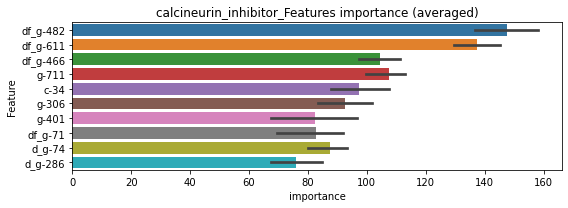

len(train_index) : 3897
len(valid_index) : 3897
================================= fold 1/2 calcineurin_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.00994882	valid_1's binary_logloss: 0.0141676
[200]	training's binary_logloss: 0.000948169	valid_1's binary_logloss: 0.00348787
Early stopping, best iteration is:
[259]	training's binary_logloss: 0.000397424	valid_1's binary_logloss: 0.00276848


len(train_index) : 3897
len(valid_index) : 3897
================================= fold 2/2 calcineurin_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0101661	valid_1's binary_logloss: 0.0145306
[200]	training's binary_logloss: 0.00101034	valid_1's binary_logloss: 0.00422691
[300]	training's binary_logloss: 0.000282365	valid_1's binary_logloss: 0.00309412
[400]	training's binary_logloss: 0.00015771	valid_1's binary_logloss: 0.0028706
Early stopping, best iteration is:
[400]	training's binary_logloss: 0.00015771	valid_1's binary_logloss: 0.0028706


calcineurin_inhibitor logloss: 0.0028195404269297573
calcium_channel_blocker, len(trt): 281, len(othr): 3243, target_rate: 0.0117998 → Adj_target_rate: 0.0101297


neg labels: 3289 → selected neg labels: 3243


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.115991	valid_1's binary_logloss: 0.296505
[200]	training's binary_logloss: 0.0416626	valid_1's binary_logloss: 0.265633
Early stopping, best iteration is:
[232]	training's binary_logloss: 0.0299617	valid_1's binary_logloss: 0.26351
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.115949	valid_1's binary_logloss: 0.281783
[200]	training's binary_logloss: 0.0427568	valid_1's binary_logloss: 0.251799
Early stopping, best iteration is:
[216]	training's binary_logloss: 0.0362089	valid_1's binary_logloss: 0.249063


1 / 3 AUC score:0.903
Threshold: 0.0906830, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 429 → positive_corect_labels: 499/3462
p_label_rate: 0.0720743 Vs.target_rate: 0.01180, Num_p_label: 287.0, conf_0:0.04372, conf_1:0.09975
Num_p_label: 287.0, Expected: 47.0, Adj_threshold_1: 0.0906830
Num_p_label: 244.0, Expected: 47.0, Adj_threshold_2: 0.0956830
Num_p_label: 208.0, Expected: 47.0, Adj_threshold_3: 0.1006830
Num_p_label: 179.0, Expected: 47.0, Adj_threshold_4: 0.1056830
Num_p_label: 153.0, Expected: 47.0, Adj_threshold_5: 0.1106830
Num_p_label: 124.0, Expected: 47.0, Adj_threshold_6: 0.1156830
Num_p_label: 103.0, Expected: 47.0, Adj_threshold_7: 0.1206830
Num_p_label: 88.0, Expected: 47.0, Adj_threshold_8: 0.1256830
threshold: 0.1256830, positive p_label: 88.0/3982, p_label_rate: 0.0220994
positive y_label: 499.0/3462, y_label_rate: 0.1441363
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0823357	valid_1's binary_logloss: 0.228555
[200]	training's binary_logloss: 0.025304	valid_1's binary_logloss: 0.197675
Early stopping, best iteration is:
[248]	training's binary_logloss: 0.0150371	valid_1's binary_logloss: 0.194074
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0803866	valid_1's binary_logloss: 0.222097
[200]	training's binary_logloss: 0.0229636	valid_1's binary_logloss: 0.20052
Early stopping, best iteration is:
[193]	training's binary_logloss: 0.0248493	valid_1's binary_logloss: 0.199467


2 / 3 AUC score:0.947
Threshold: 0.1256830, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 146 → positive_corect_labels: 377.0/3316
p_label_rate: 0.0087896 Vs.target_rate: 0.01180, Num_p_label: 35.0, conf_0:0.02486, conf_1:0.13825
threshold: 0.1256830, positive p_label: 35.0/3982, p_label_rate: 0.0087896
positive y_label: 377.0/3316, y_label_rate: 0.1136912
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0503707	valid_1's binary_logloss: 0.164482
Early stopping, best iteration is:
[165]	training's binary_logloss: 0.0201646	valid_1's binary_logloss: 0.144922
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0547496	valid_1's binary_logloss: 0.183453


3 / 3 AUC score:0.967
Threshold: 0.1256830, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 92 → positive_corect_labels: 291.0/3224
p_label_rate: 0.0025113 Vs.target_rate: 0.01180, Num_p_label: 10.0, conf_0:0.01840, conf_1:0.13825
Num_p_label: 10.0, Expected: 47.0, Adj_threshold_1: 0.1256830
Num_p_label: 11.0, Expected: 47.0, Adj_threshold_2: 0.1206830
Num_p_label: 14.0, Expected: 47.0, Adj_threshold_3: 0.1156830


Early stopping, best iteration is:
[169]	training's binary_logloss: 0.020227	valid_1's binary_logloss: 0.171267


Num_p_label: 14.0, Expected: 47.0, Adj_threshold_4: 0.1106830
Num_p_label: 16.0, Expected: 47.0, Adj_threshold_5: 0.1056830
Num_p_label: 19.0, Expected: 47.0, Adj_threshold_6: 0.1006830
Num_p_label: 19.0, Expected: 47.0, Adj_threshold_7: 0.0956830
Num_p_label: 24.0, Expected: 47.0, Adj_threshold_8: 0.0906830
threshold: 0.0906830, positive p_label: 24.0/3982, p_label_rate: 0.0060271
positive y_label: 315.0/7206, y_label_rate: 0.0437136


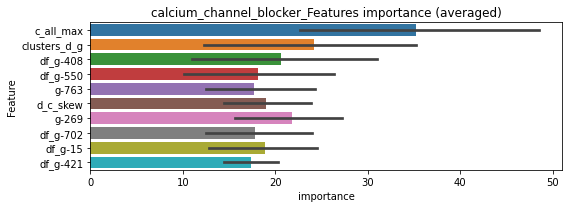

len(train_index) : 3603
len(valid_index) : 3603
================================= fold 1/2 calcium_channel_blocker=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0212231	valid_1's binary_logloss: 0.0787292
[200]	training's binary_logloss: 0.00511417	valid_1's binary_logloss: 0.0705863
Early stopping, best iteration is:
[200]	training's binary_logloss: 0.00511417	valid_1's binary_logloss: 0.0705863


len(train_index) : 3603
len(valid_index) : 3603
================================= fold 2/2 calcium_channel_blocker=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0211072	valid_1's binary_logloss: 0.0697432
[200]	training's binary_logloss: 0.00506469	valid_1's binary_logloss: 0.0605429
Early stopping, best iteration is:
[215]	training's binary_logloss: 0.0040745	valid_1's binary_logloss: 0.0601171


calcium_channel_blocker logloss: 0.06535168945278462


  acetylcholine_receptor_agonist acetylcholine_receptor_antagonist  \
0                       df_g-122                              c-30   
1                  clusters_df_c                         c_all_max   
2                          cnt_0                    clusters_g_all   
3                      c_all_min                          df_g-707   
4                        df_g-51                        clusters_g   
5                       df_c_min                          df_c_min   
6                          cnt_2                             g-514   
7                       df_g-736                          df_g-640   
8                          g-244                            df_c-6   
9                           c-73                          df_g-597   

  acetylcholinesterase_inhibitor adenosine_receptor_antagonist  \
0                      c_all_max                clusters_c_all   
1                      c_all_min                      df_c_min   
2                 clusters_g_al

cannabinoid_receptor_agonist, len(trt): 42, len(othr): 3282, target_rate: 0.0017637 → Adj_target_rate: 0.0020135


neg labels: 3289 → selected neg labels: 3282


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0427514	valid_1's binary_logloss: 0.0735496
[200]	training's binary_logloss: 0.00749577	valid_1's binary_logloss: 0.028232
[300]	training's binary_logloss: 0.00209117	valid_1's binary_logloss: 0.0174651
[400]	training's binary_logloss: 0.000967318	valid_1's binary_logloss: 0.0138204
[500]	training's binary_logloss: 0.000624288	valid_1's binary_logloss: 0.0123759
Early stopping, best iteration is:
[494]	training's binary_logloss: 0.000634431	valid_1's binary_logloss: 0.0123371
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0448452	valid_1's binary_logloss: 0.0781972
[200]	training's binary_logloss: 0.00811687	valid_1's binary_logloss: 0.0292924
[300]	training's binary_logloss: 0.00216237	valid_1's binary_logloss: 0.01667
[400]	training's binary_logloss: 0.00100855	valid_1's binary_logloss: 0.0129573
Early stopping, best iteration is:
[408]	trai

1 / 3 AUC score:1.000
Threshold: 0.0057087, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → positive_corect_labels: 656/3806
p_label_rate: 0.0336514 Vs.target_rate: 0.00176, Num_p_label: 134.0, conf_0:0.00074, conf_1:0.00628
Num_p_label: 134.0, Expected: 7.0, Adj_threshold_1: 0.0057087
Num_p_label: 55.0, Expected: 7.0, Adj_threshold_2: 0.0107087
Num_p_label: 31.0, Expected: 7.0, Adj_threshold_3: 0.0157087
Num_p_label: 14.0, Expected: 7.0, Adj_threshold_4: 0.0207087
threshold: 0.0207087, positive p_label: 14.0/3982, p_label_rate: 0.0035158
positive y_label: 656.0/3806, y_label_rate: 0.1723594
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0416291	valid_1's binary_logloss: 0.0714299
[200]	training's binary_logloss: 0.00721385	valid_1's binary_logloss: 0.0260644
[300]	training's binary_logloss: 0.00200555	valid_1's binary_logloss: 0.0156973
[400]	training's binary_logloss: 0.000952852	valid_1's binary_logloss: 0.0126274
Early stopping, best iteration is:
[444]	training's binary_logloss: 0.000769624	valid_1's binary_logloss: 0.0119596
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0431298	valid_1's binary_logloss: 0.0747976
[200]	training's binary_logloss: 0.00747825	valid_1's binary_logloss: 0.0305426
[300]	training's binary_logloss: 0.00211183	valid_1's binary_logloss: 0.0201077
[400]	training's binary_logloss: 0.000991196	valid_1's binary_logloss: 0.016525
[500]	training's binary_logloss: 0.000638524	valid_1's binary_logloss: 0.0149158
Early stopping, best iteration is:
[493]	t

2 / 3 AUC score:1.000
Threshold: 0.0207087, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 8 → positive_corect_labels: 656.0/3798
p_label_rate: 0.0113009 Vs.target_rate: 0.00176, Num_p_label: 45.0, conf_0:0.00075, conf_1:0.02278
Num_p_label: 45.0, Expected: 7.0, Adj_threshold_1: 0.0207087
Num_p_label: 30.0, Expected: 7.0, Adj_threshold_2: 0.0257087
Num_p_label: 24.0, Expected: 7.0, Adj_threshold_3: 0.0307087
Num_p_label: 16.0, Expected: 7.0, Adj_threshold_4: 0.0357087
Num_p_label: 14.0, Expected: 7.0, Adj_threshold_5: 0.0407087
threshold: 0.0407087, positive p_label: 14.0/3982, p_label_rate: 0.0035158
positive y_label: 656.0/3798, y_label_rate: 0.1727225
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0414521	valid_1's binary_logloss: 0.0718402
[200]	training's binary_logloss: 0.00706289	valid_1's binary_logloss: 0.0259492
[300]	training's binary_logloss: 0.00199852	valid_1's binary_logloss: 0.0158664
[400]	training's binary_logloss: 0.000947202	valid_1's binary_logloss: 0.0124938
Early stopping, best iteration is:
[465]	training's binary_logloss: 0.000697648	valid_1's binary_logloss: 0.0113751
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0433046	valid_1's binary_logloss: 0.0773171
[200]	training's binary_logloss: 0.00750087	valid_1's binary_logloss: 0.0300637
[300]	training's binary_logloss: 0.00208375	valid_1's binary_logloss: 0.0187256
[400]	training's binary_logloss: 0.000983578	valid_1's binary_logloss: 0.0150993
Early stopping, best iteration is:
[426]	training's binary_logloss: 0.000851337	valid_1's binary_logloss: 0.0146982


3 / 3 AUC score:1.000
Threshold: 0.0407087, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 1 → positive_corect_labels: 655.0/3797
p_label_rate: 0.0040181 Vs.target_rate: 0.00176, Num_p_label: 16.0, conf_0:0.00082, conf_1:0.04478
threshold: 0.0407087, positive p_label: 16.0/3982, p_label_rate: 0.0040181
positive y_label: 671.0/7779, y_label_rate: 0.0862579


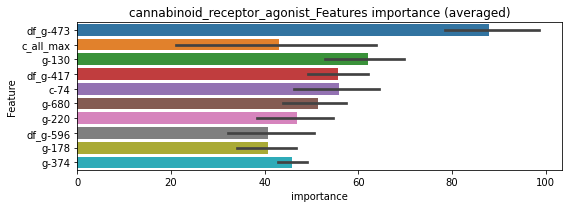

len(train_index) : 3889
len(valid_index) : 3890
================================= fold 1/2 cannabinoid_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0238872	valid_1's binary_logloss: 0.0463756
[200]	training's binary_logloss: 0.00415062	valid_1's binary_logloss: 0.0233088
[300]	training's binary_logloss: 0.00113243	valid_1's binary_logloss: 0.0193186
Early stopping, best iteration is:
[337]	training's binary_logloss: 0.000810696	valid_1's binary_logloss: 0.0188677


len(train_index) : 3890
len(valid_index) : 3889
================================= fold 2/2 cannabinoid_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0247371	valid_1's binary_logloss: 0.04154
[200]	training's binary_logloss: 0.00450447	valid_1's binary_logloss: 0.0154107
[300]	training's binary_logloss: 0.00121303	valid_1's binary_logloss: 0.0101334
[400]	training's binary_logloss: 0.00056022	valid_1's binary_logloss: 0.00875552
Early stopping, best iteration is:
[415]	training's binary_logloss: 0.000515353	valid_1's binary_logloss: 0.00864745


cannabinoid_receptor_agonist logloss: 0.013758231598949108
cannabinoid_receptor_antagonist, len(trt): 55, len(othr): 3280, target_rate: 0.0023096 → Adj_target_rate: 0.0025322


neg labels: 3289 → selected neg labels: 3280


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.045722	valid_1's binary_logloss: 0.0866523
[200]	training's binary_logloss: 0.00878819	valid_1's binary_logloss: 0.0407951
[300]	training's binary_logloss: 0.00244045	valid_1's binary_logloss: 0.0277992
[400]	training's binary_logloss: 0.0011353	valid_1's binary_logloss: 0.0240059
[500]	training's binary_logloss: 0.000717829	valid_1's binary_logloss: 0.0226038
Early stopping, best iteration is:
[494]	training's binary_logloss: 0.000733769	valid_1's binary_logloss: 0.022478
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.050753	valid_1's binary_logloss: 0.0845555
[200]	training's binary_logloss: 0.0103096	valid_1's binary_logloss: 0.0381237
[300]	training's binary_logloss: 0.0028626	valid_1's binary_logloss: 0.0242352
[400]	training's binary_logloss: 0.00131485	valid_1's binary_logloss: 0.0193336
[500]	training's binary_logloss: 0.000809212	vali

1 / 3 AUC score:1.000
Threshold: 0.0061767, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 134 → positive_corect_labels: 655/3802
p_label_rate: 0.0364139 Vs.target_rate: 0.00231, Num_p_label: 145.0, conf_0:0.00080, conf_1:0.00679
Num_p_label: 145.0, Expected: 9.2, Adj_threshold_1: 0.0061767
Num_p_label: 53.0, Expected: 9.2, Adj_threshold_2: 0.0111767
Num_p_label: 33.0, Expected: 9.2, Adj_threshold_3: 0.0161767
Num_p_label: 16.0, Expected: 9.2, Adj_threshold_4: 0.0211767
threshold: 0.0211767, positive p_label: 16.0/3982, p_label_rate: 0.0040181
positive y_label: 655.0/3802, y_label_rate: 0.1722777
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0490218	valid_1's binary_logloss: 0.0855533
[200]	training's binary_logloss: 0.00902043	valid_1's binary_logloss: 0.0374855
[300]	training's binary_logloss: 0.00261456	valid_1's binary_logloss: 0.0243373
[400]	training's binary_logloss: 0.00122233	valid_1's binary_logloss: 0.0202282
Early stopping, best iteration is:
[421]	training's binary_logloss: 0.00108857	valid_1's binary_logloss: 0.0196042
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0496645	valid_1's binary_logloss: 0.0889966
[200]	training's binary_logloss: 0.00925324	valid_1's binary_logloss: 0.0366788
[300]	training's binary_logloss: 0.00266976	valid_1's binary_logloss: 0.0227621
[400]	training's binary_logloss: 0.00122902	valid_1's binary_logloss: 0.0177444
[500]	training's binary_logloss: 0.000778475	valid_1's binary_logloss: 0.0158162
Early stopping, best iteration is:
[565]	tra

2 / 3 AUC score:1.000
Threshold: 0.0211767, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 16 → positive_corect_labels: 655.0/3786
p_label_rate: 0.0145655 Vs.target_rate: 0.00231, Num_p_label: 58.0, conf_0:0.00112, conf_1:0.02329
Num_p_label: 58.0, Expected: 9.2, Adj_threshold_1: 0.0211767
Num_p_label: 42.0, Expected: 9.2, Adj_threshold_2: 0.0261767
Num_p_label: 29.0, Expected: 9.2, Adj_threshold_3: 0.0311767
Num_p_label: 21.0, Expected: 9.2, Adj_threshold_4: 0.0361767
Num_p_label: 14.0, Expected: 9.2, Adj_threshold_5: 0.0411767
threshold: 0.0411767, positive p_label: 14.0/3982, p_label_rate: 0.0035158
positive y_label: 655.0/3786, y_label_rate: 0.1730058
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0489698	valid_1's binary_logloss: 0.0833393
[200]	training's binary_logloss: 0.00918237	valid_1's binary_logloss: 0.0343276
[300]	training's binary_logloss: 0.00263154	valid_1's binary_logloss: 0.0219455
[400]	training's binary_logloss: 0.00123365	valid_1's binary_logloss: 0.0182717
[500]	training's binary_logloss: 0.000767785	valid_1's binary_logloss: 0.0166374
Early stopping, best iteration is:
[490]	training's binary_logloss: 0.000792455	valid_1's binary_logloss: 0.0164567
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0484944	valid_1's binary_logloss: 0.0850665
[200]	training's binary_logloss: 0.00929336	valid_1's binary_logloss: 0.0348245
[300]	training's binary_logloss: 0.00268754	valid_1's binary_logloss: 0.0207922
[400]	training's binary_logloss: 0.0012533	valid_1's binary_logloss: 0.0164166
[500]	training's binary_logloss: 0.000782908

3 / 3 AUC score:1.000
Threshold: 0.0411767, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 2 → positive_corect_labels: 654.0/3784
p_label_rate: 0.0037670 Vs.target_rate: 0.00231, Num_p_label: 15.0, conf_0:0.00088, conf_1:0.04529
threshold: 0.0411767, positive p_label: 15.0/3982, p_label_rate: 0.0037670
positive y_label: 669.0/7766, y_label_rate: 0.0861447


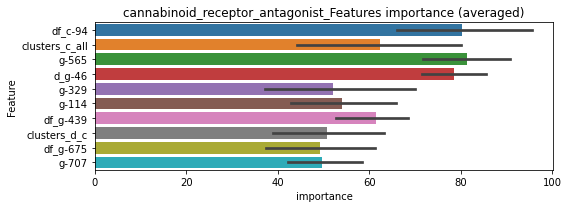

len(train_index) : 3883
len(valid_index) : 3883
================================= fold 1/2 cannabinoid_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0276438	valid_1's binary_logloss: 0.0550364
[200]	training's binary_logloss: 0.00535633	valid_1's binary_logloss: 0.0283827
[300]	training's binary_logloss: 0.00147882	valid_1's binary_logloss: 0.0220969
Early stopping, best iteration is:
[387]	training's binary_logloss: 0.000724387	valid_1's binary_logloss: 0.0207703


len(train_index) : 3883
len(valid_index) : 3883
================================= fold 2/2 cannabinoid_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.028769	valid_1's binary_logloss: 0.053513
[200]	training's binary_logloss: 0.00544342	valid_1's binary_logloss: 0.0255777
[300]	training's binary_logloss: 0.00152883	valid_1's binary_logloss: 0.0201083
Early stopping, best iteration is:
[381]	training's binary_logloss: 0.000778706	valid_1's binary_logloss: 0.0186304


cannabinoid_receptor_antagonist logloss: 0.019700370215874008
carbonic_anhydrase_inhibitor, len(trt): 36, len(othr): 3283, target_rate: 0.0015117 → Adj_target_rate: 0.0017663


neg labels: 3289 → selected neg labels: 3283


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.038277	valid_1's binary_logloss: 0.0590079
[200]	training's binary_logloss: 0.00630252	valid_1's binary_logloss: 0.0173497
[300]	training's binary_logloss: 0.00181512	valid_1's binary_logloss: 0.00851158
[400]	training's binary_logloss: 0.000867219	valid_1's binary_logloss: 0.00615485
[500]	training's binary_logloss: 0.000560172	valid_1's binary_logloss: 0.00527189
[600]	training's binary_logloss: 0.000469248	valid_1's binary_logloss: 0.00506453
Early stopping, best iteration is:
[599]	training's binary_logloss: 0.000469624	valid_1's binary_logloss: 0.00505995
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0400503	valid_1's binary_logloss: 0.0650545
[200]	training's binary_logloss: 0.00668051	valid_1's binary_logloss: 0.0225003
[300]	training's binary_logloss: 0.00182455	valid_1's binary_logloss: 0.0148242
[400]	training's binary_logloss: 0.00

1 / 3 AUC score:1.000
Threshold: 0.0042968, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 134 → positive_corect_labels: 655/3805
p_label_rate: 0.0313913 Vs.target_rate: 0.00151, Num_p_label: 125.0, conf_0:0.00059, conf_1:0.00473
Num_p_label: 125.0, Expected: 6.0, Adj_threshold_1: 0.0042968
Num_p_label: 40.0, Expected: 6.0, Adj_threshold_2: 0.0092968
Num_p_label: 21.0, Expected: 6.0, Adj_threshold_3: 0.0142968
Num_p_label: 13.0, Expected: 6.0, Adj_threshold_4: 0.0192968
Num_p_label: 8.0, Expected: 6.0, Adj_threshold_5: 0.0242968
threshold: 0.0242968, positive p_label: 8.0/3982, p_label_rate: 0.0020090
positive y_label: 655.0/3805, y_label_rate: 0.1721419
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0393319	valid_1's binary_logloss: 0.0573032
[200]	training's binary_logloss: 0.00640346	valid_1's binary_logloss: 0.0145976
[300]	training's binary_logloss: 0.00180306	valid_1's binary_logloss: 0.00623632
[400]	training's binary_logloss: 0.000858491	valid_1's binary_logloss: 0.00409073
[500]	training's binary_logloss: 0.000570116	valid_1's binary_logloss: 0.00330794
[600]	training's binary_logloss: 0.000484431	valid_1's binary_logloss: 0.00304834
Early stopping, best iteration is:
[610]	training's binary_logloss: 0.00048033	valid_1's binary_logloss: 0.00302226
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0387443	valid_1's binary_logloss: 0.0631605
[200]	training's binary_logloss: 0.00609701	valid_1's binary_logloss: 0.0213752
[300]	training's binary_logloss: 0.00171106	valid_1's binary_logloss: 0.0117794
[400]	training's binary_logloss: 0.00

2 / 3 AUC score:1.000
Threshold: 0.0242968, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 3 → positive_corect_labels: 655.0/3802
p_label_rate: 0.0047715 Vs.target_rate: 0.00151, Num_p_label: 19.0, conf_0:0.00049, conf_1:0.02673
Num_p_label: 19.0, Expected: 6.0, Adj_threshold_1: 0.0242968
Num_p_label: 16.0, Expected: 6.0, Adj_threshold_2: 0.0292968
Num_p_label: 12.0, Expected: 6.0, Adj_threshold_3: 0.0342968
threshold: 0.0342968, positive p_label: 12.0/3982, p_label_rate: 0.0030136
positive y_label: 655.0/3802, y_label_rate: 0.1722777
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0390227	valid_1's binary_logloss: 0.0580484
[200]	training's binary_logloss: 0.00633544	valid_1's binary_logloss: 0.0145347
[300]	training's binary_logloss: 0.00177201	valid_1's binary_logloss: 0.0059375
[400]	training's binary_logloss: 0.000853571	valid_1's binary_logloss: 0.0038166
[500]	training's binary_logloss: 0.000564064	valid_1's binary_logloss: 0.00297426
[600]	training's binary_logloss: 0.000482898	valid_1's binary_logloss: 0.00271662
Early stopping, best iteration is:
[610]	training's binary_logloss: 0.000479495	valid_1's binary_logloss: 0.00270363
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0387272	valid_1's binary_logloss: 0.0630653
[200]	training's binary_logloss: 0.00612474	valid_1's binary_logloss: 0.0195899
[300]	training's binary_logloss: 0.00173001	valid_1's binary_logloss: 0.0106121
[400]	training's binary_logloss: 0.000

3 / 3 AUC score:1.000
Threshold: 0.0342968, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → positive_corect_labels: 655.0/3802
p_label_rate: 0.0037670 Vs.target_rate: 0.00151, Num_p_label: 15.0, conf_0:0.00053, conf_1:0.03773
threshold: 0.0342968, positive p_label: 15.0/3982, p_label_rate: 0.0037670
positive y_label: 670.0/7784, y_label_rate: 0.0860740


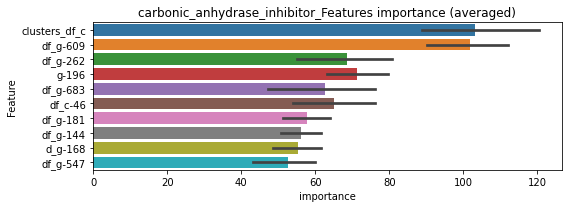

len(train_index) : 3892
len(valid_index) : 3892
================================= fold 1/2 carbonic_anhydrase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0223381	valid_1's binary_logloss: 0.0411676
[200]	training's binary_logloss: 0.00373436	valid_1's binary_logloss: 0.0192545
[300]	training's binary_logloss: 0.00103385	valid_1's binary_logloss: 0.015027
Early stopping, best iteration is:
[324]	training's binary_logloss: 0.000819011	valid_1's binary_logloss: 0.0147971


len(train_index) : 3892
len(valid_index) : 3892
================================= fold 2/2 carbonic_anhydrase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0234996	valid_1's binary_logloss: 0.0375697
[200]	training's binary_logloss: 0.00384203	valid_1's binary_logloss: 0.016337
[300]	training's binary_logloss: 0.0010554	valid_1's binary_logloss: 0.0129682
Early stopping, best iteration is:
[305]	training's binary_logloss: 0.0010062	valid_1's binary_logloss: 0.0129269


carbonic_anhydrase_inhibitor logloss: 0.013862023754039438
casein_kinase_inhibitor, len(trt): 36, len(othr): 3283, target_rate: 0.0015117 → Adj_target_rate: 0.0017663


neg labels: 3289 → selected neg labels: 3283


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0321434	valid_1's binary_logloss: 0.0499518
[200]	training's binary_logloss: 0.00513683	valid_1's binary_logloss: 0.0142447
[300]	training's binary_logloss: 0.00149697	valid_1's binary_logloss: 0.00739534
[400]	training's binary_logloss: 0.000755051	valid_1's binary_logloss: 0.00547449
[500]	training's binary_logloss: 0.000507642	valid_1's binary_logloss: 0.00472654
Early stopping, best iteration is:
[497]	training's binary_logloss: 0.00051115	valid_1's binary_logloss: 0.00470949
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0340295	valid_1's binary_logloss: 0.0478781
[200]	training's binary_logloss: 0.00540438	valid_1's binary_logloss: 0.0115098
[300]	training's binary_logloss: 0.00155332	valid_1's binary_logloss: 0.00469281
[400]	training's binary_logloss: 0.000768761	valid_1's binary_logloss: 0.00293148
[500]	training's binary_logloss: 0.0

1 / 3 AUC score:1.000
Threshold: 0.0029588, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → positive_corect_labels: 656/3807
p_label_rate: 0.0436966 Vs.target_rate: 0.00151, Num_p_label: 174.0, conf_0:0.00041, conf_1:0.00325
Num_p_label: 174.0, Expected: 6.0, Adj_threshold_1: 0.0029588
Num_p_label: 40.0, Expected: 6.0, Adj_threshold_2: 0.0079588
Num_p_label: 15.0, Expected: 6.0, Adj_threshold_3: 0.0129588
Num_p_label: 10.0, Expected: 6.0, Adj_threshold_4: 0.0179588
threshold: 0.0179588, positive p_label: 10.0/3982, p_label_rate: 0.0025113
positive y_label: 656.0/3807, y_label_rate: 0.1723142
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.03218	valid_1's binary_logloss: 0.0486047
[200]	training's binary_logloss: 0.00486811	valid_1's binary_logloss: 0.0131756
[300]	training's binary_logloss: 0.00143855	valid_1's binary_logloss: 0.00683492
[400]	training's binary_logloss: 0.000731978	valid_1's binary_logloss: 0.00503277
[500]	training's binary_logloss: 0.000495967	valid_1's binary_logloss: 0.00434183
Early stopping, best iteration is:
[495]	training's binary_logloss: 0.000502091	valid_1's binary_logloss: 0.00432423
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0338642	valid_1's binary_logloss: 0.0478872
[200]	training's binary_logloss: 0.00517058	valid_1's binary_logloss: 0.0107586
[300]	training's binary_logloss: 0.00150597	valid_1's binary_logloss: 0.00420835
[400]	training's binary_logloss: 0.000754651	valid_1's binary_logloss: 0.00256864
[500]	training's binary_logloss: 0.00

2 / 3 AUC score:1.000
Threshold: 0.0179588, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 2 → positive_corect_labels: 656.0/3805
p_label_rate: 0.0102963 Vs.target_rate: 0.00151, Num_p_label: 41.0, conf_0:0.00047, conf_1:0.01975
Num_p_label: 41.0, Expected: 6.0, Adj_threshold_1: 0.0179588
Num_p_label: 26.0, Expected: 6.0, Adj_threshold_2: 0.0229588
Num_p_label: 23.0, Expected: 6.0, Adj_threshold_3: 0.0279588
Num_p_label: 18.0, Expected: 6.0, Adj_threshold_4: 0.0329588
Num_p_label: 11.0, Expected: 6.0, Adj_threshold_5: 0.0379588
threshold: 0.0379588, positive p_label: 11.0/3982, p_label_rate: 0.0027624
positive y_label: 656.0/3805, y_label_rate: 0.1724047
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0319897	valid_1's binary_logloss: 0.0490214
[200]	training's binary_logloss: 0.00489493	valid_1's binary_logloss: 0.0130639
[300]	training's binary_logloss: 0.00145226	valid_1's binary_logloss: 0.00654839
[400]	training's binary_logloss: 0.000734297	valid_1's binary_logloss: 0.00485218
[500]	training's binary_logloss: 0.000499208	valid_1's binary_logloss: 0.00416483
Early stopping, best iteration is:
[493]	training's binary_logloss: 0.000507748	valid_1's binary_logloss: 0.00414486
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.03446	valid_1's binary_logloss: 0.0480694
[200]	training's binary_logloss: 0.00525397	valid_1's binary_logloss: 0.0108633
[300]	training's binary_logloss: 0.00152483	valid_1's binary_logloss: 0.00422042
[400]	training's binary_logloss: 0.000760043	valid_1's binary_logloss: 0.00253505
[500]	training's binary_logloss: 0.00

3 / 3 AUC score:1.000
Threshold: 0.0379588, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → positive_corect_labels: 656.0/3805
p_label_rate: 0.0040181 Vs.target_rate: 0.00151, Num_p_label: 16.0, conf_0:0.00047, conf_1:0.04175
threshold: 0.0379588, positive p_label: 16.0/3982, p_label_rate: 0.0040181
positive y_label: 672.0/7787, y_label_rate: 0.0862977


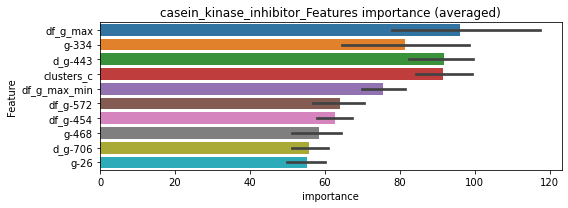

len(train_index) : 3893
len(valid_index) : 3894
================================= fold 1/2 casein_kinase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0184223	valid_1's binary_logloss: 0.0365188
[200]	training's binary_logloss: 0.00275116	valid_1's binary_logloss: 0.018452
[300]	training's binary_logloss: 0.000810916	valid_1's binary_logloss: 0.0161893
Early stopping, best iteration is:
[310]	training's binary_logloss: 0.000737379	valid_1's binary_logloss: 0.0161015


len(train_index) : 3894
len(valid_index) : 3893
================================= fold 2/2 casein_kinase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0199094	valid_1's binary_logloss: 0.0349171
[200]	training's binary_logloss: 0.00305444	valid_1's binary_logloss: 0.0147077
[300]	training's binary_logloss: 0.000876187	valid_1's binary_logloss: 0.0112503
Early stopping, best iteration is:
[342]	training's binary_logloss: 0.00062104	valid_1's binary_logloss: 0.0108273


casein_kinase_inhibitor logloss: 0.013464705342857949
caspase_activator, len(trt): 18, len(othr): 3287, target_rate: 0.0007559 → Adj_target_rate: 0.0009799


neg labels: 3289 → selected neg labels: 3287


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0243026	valid_1's binary_logloss: 0.0303037
[200]	training's binary_logloss: 0.00291828	valid_1's binary_logloss: 0.00507083
[300]	training's binary_logloss: 0.000824191	valid_1's binary_logloss: 0.0017747
[400]	training's binary_logloss: 0.000432639	valid_1's binary_logloss: 0.00105977
[500]	training's binary_logloss: 0.000344712	valid_1's binary_logloss: 0.000890334
Early stopping, best iteration is:
[508]	training's binary_logloss: 0.000343975	valid_1's binary_logloss: 0.000888897
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0240081	valid_1's binary_logloss: 0.0330508
[200]	training's binary_logloss: 0.00291032	valid_1's binary_logloss: 0.00716359
[300]	training's binary_logloss: 0.000822683	valid_1's binary_logloss: 0.00333709
[400]	training's binary_logloss: 0.00043224	valid_1's binary_logloss: 0.00241139
Early stopping, best iteration 

1 / 3 AUC score:1.000
Threshold: 0.0017754, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → positive_corect_labels: 657/3812
p_label_rate: 0.0381718 Vs.target_rate: 0.00076, Num_p_label: 152.0, conf_0:0.00022, conf_1:0.00195
Num_p_label: 152.0, Expected: 3.0, Adj_threshold_1: 0.0017754
Num_p_label: 27.0, Expected: 3.0, Adj_threshold_2: 0.0067754
Num_p_label: 10.0, Expected: 3.0, Adj_threshold_3: 0.0117754
Num_p_label: 5.0, Expected: 3.0, Adj_threshold_4: 0.0167754
threshold: 0.0167754, positive p_label: 5.0/3982, p_label_rate: 0.0012557
positive y_label: 657.0/3812, y_label_rate: 0.1723505
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0238542	valid_1's binary_logloss: 0.0301908
[200]	training's binary_logloss: 0.00280493	valid_1's binary_logloss: 0.0049533
[300]	training's binary_logloss: 0.000795702	valid_1's binary_logloss: 0.0018085
[400]	training's binary_logloss: 0.00042216	valid_1's binary_logloss: 0.00111176
[500]	training's binary_logloss: 0.000341247	valid_1's binary_logloss: 0.000944524
Early stopping, best iteration is:
[531]	training's binary_logloss: 0.000338412	valid_1's binary_logloss: 0.000937219
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0238011	valid_1's binary_logloss: 0.0324865
[200]	training's binary_logloss: 0.00282309	valid_1's binary_logloss: 0.00711431
[300]	training's binary_logloss: 0.000799375	valid_1's binary_logloss: 0.00348896
[400]	training's binary_logloss: 0.000420832	valid_1's binary_logloss: 0.00261023
Early stopping, best iteration i

2 / 3 AUC score:1.000
Threshold: 0.0167754, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → positive_corect_labels: 657.0/3812
p_label_rate: 0.0060271 Vs.target_rate: 0.00076, Num_p_label: 24.0, conf_0:0.00027, conf_1:0.01845
Num_p_label: 24.0, Expected: 3.0, Adj_threshold_1: 0.0167754
Num_p_label: 14.0, Expected: 3.0, Adj_threshold_2: 0.0217754
Num_p_label: 8.0, Expected: 3.0, Adj_threshold_3: 0.0267754
Num_p_label: 7.0, Expected: 3.0, Adj_threshold_4: 0.0317754
Num_p_label: 6.0, Expected: 3.0, Adj_threshold_5: 0.0367754
threshold: 0.0367754, positive p_label: 6.0/3982, p_label_rate: 0.0015068
positive y_label: 657.0/3812, y_label_rate: 0.1723505
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0238542	valid_1's binary_logloss: 0.0301908
[200]	training's binary_logloss: 0.00280493	valid_1's binary_logloss: 0.0049533
[300]	training's binary_logloss: 0.000795702	valid_1's binary_logloss: 0.0018085
[400]	training's binary_logloss: 0.00042216	valid_1's binary_logloss: 0.00111176
[500]	training's binary_logloss: 0.000341247	valid_1's binary_logloss: 0.000944524
Early stopping, best iteration is:
[531]	training's binary_logloss: 0.000338412	valid_1's binary_logloss: 0.000937219
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0238011	valid_1's binary_logloss: 0.0324865
[200]	training's binary_logloss: 0.00282309	valid_1's binary_logloss: 0.00711431
[300]	training's binary_logloss: 0.000799375	valid_1's binary_logloss: 0.00348896
[400]	training's binary_logloss: 0.000420832	valid_1's binary_logloss: 0.00261023
Early stopping, best iteration i

3 / 3 AUC score:1.000
Threshold: 0.0367754, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → positive_corect_labels: 657.0/3812
p_label_rate: 0.0015068 Vs.target_rate: 0.00076, Num_p_label: 6.0, conf_0:0.00027, conf_1:0.04045
threshold: 0.0367754, positive p_label: 6.0/3982, p_label_rate: 0.0015068
positive y_label: 663.0/7794, y_label_rate: 0.0850654


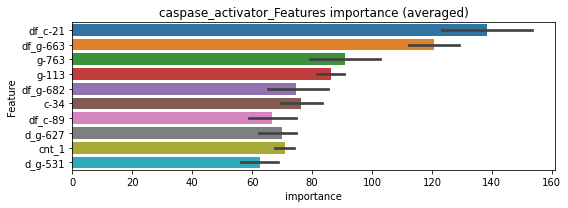

len(train_index) : 3897
len(valid_index) : 3897
================================= fold 1/2 caspase_activator=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0128039	valid_1's binary_logloss: 0.0193736
[200]	training's binary_logloss: 0.00149476	valid_1's binary_logloss: 0.00692095
Early stopping, best iteration is:
[265]	training's binary_logloss: 0.000591249	valid_1's binary_logloss: 0.00594374


len(train_index) : 3897
len(valid_index) : 3897
================================= fold 2/2 caspase_activator=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0132112	valid_1's binary_logloss: 0.0176722
[200]	training's binary_logloss: 0.00164804	valid_1's binary_logloss: 0.00341815
[300]	training's binary_logloss: 0.000451937	valid_1's binary_logloss: 0.00186429
[400]	training's binary_logloss: 0.000226115	valid_1's binary_logloss: 0.00157385
Early stopping, best iteration is:
[445]	training's binary_logloss: 0.000190927	valid_1's binary_logloss: 0.00151612


caspase_activator logloss: 0.003729931176194416
catechol_o_methyltransferase_inhibitor, len(trt): 18, len(othr): 3286, target_rate: 0.0007559 → Adj_target_rate: 0.0009799


neg labels: 3289 → selected neg labels: 3286


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0226492	valid_1's binary_logloss: 0.0304348
[200]	training's binary_logloss: 0.00275447	valid_1's binary_logloss: 0.00609118
[300]	training's binary_logloss: 0.000805914	valid_1's binary_logloss: 0.00289205
[400]	training's binary_logloss: 0.000429457	valid_1's binary_logloss: 0.00212475
Early stopping, best iteration is:
[467]	training's binary_logloss: 0.000354692	valid_1's binary_logloss: 0.0019103
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0243046	valid_1's binary_logloss: 0.0343892
[200]	training's binary_logloss: 0.00290912	valid_1's binary_logloss: 0.0073212
[300]	training's binary_logloss: 0.000824608	valid_1's binary_logloss: 0.00363425
[400]	training's binary_logloss: 0.000437822	valid_1's binary_logloss: 0.00271908
Early stopping, best iteration is:
[464]	training's binary_logloss: 0.000356809	valid_1's binary_logloss: 0.0025156

1 / 3 AUC score:1.000
Threshold: 0.0014191, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → positive_corect_labels: 657/3811
p_label_rate: 0.0339026 Vs.target_rate: 0.00076, Num_p_label: 135.0, conf_0:0.00026, conf_1:0.00156
Num_p_label: 135.0, Expected: 3.0, Adj_threshold_1: 0.0014191
Num_p_label: 11.0, Expected: 3.0, Adj_threshold_2: 0.0064191
Num_p_label: 2.0, Expected: 3.0, Adj_threshold_3: 0.0114191
threshold: 0.0114191, positive p_label: 2.0/3982, p_label_rate: 0.0005023
positive y_label: 657.0/3811, y_label_rate: 0.1723957
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0233032	valid_1's binary_logloss: 0.0319172
[200]	training's binary_logloss: 0.00276905	valid_1's binary_logloss: 0.00653924
[300]	training's binary_logloss: 0.000800245	valid_1's binary_logloss: 0.00325051
[400]	training's binary_logloss: 0.00042831	valid_1's binary_logloss: 0.00235561
[500]	training's binary_logloss: 0.000334881	valid_1's binary_logloss: 0.00208316
Early stopping, best iteration is:
[494]	training's binary_logloss: 0.000337384	valid_1's binary_logloss: 0.00207873
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0237423	valid_1's binary_logloss: 0.0354605
[200]	training's binary_logloss: 0.00279608	valid_1's binary_logloss: 0.00764941
[300]	training's binary_logloss: 0.000803395	valid_1's binary_logloss: 0.00388488
[400]	training's binary_logloss: 0.000429753	valid_1's binary_logloss: 0.00290911
Early stopping, best iteration i

2 / 3 AUC score:1.000
Threshold: 0.0114191, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → positive_corect_labels: 657.0/3811
p_label_rate: 0.0035158 Vs.target_rate: 0.00076, Num_p_label: 14.0, conf_0:0.00029, conf_1:0.01256
Num_p_label: 14.0, Expected: 3.0, Adj_threshold_1: 0.0114191
Num_p_label: 3.0, Expected: 3.0, Adj_threshold_2: 0.0164191
threshold: 0.0164191, positive p_label: 3.0/3982, p_label_rate: 0.0007534
positive y_label: 657.0/3811, y_label_rate: 0.1723957
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0233032	valid_1's binary_logloss: 0.0319172
[200]	training's binary_logloss: 0.00276905	valid_1's binary_logloss: 0.00653924
[300]	training's binary_logloss: 0.000800245	valid_1's binary_logloss: 0.00325051
[400]	training's binary_logloss: 0.00042831	valid_1's binary_logloss: 0.00235561
[500]	training's binary_logloss: 0.000334881	valid_1's binary_logloss: 0.00208316
Early stopping, best iteration is:
[494]	training's binary_logloss: 0.000337384	valid_1's binary_logloss: 0.00207873
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0237423	valid_1's binary_logloss: 0.0354605
[200]	training's binary_logloss: 0.00279608	valid_1's binary_logloss: 0.00764941
[300]	training's binary_logloss: 0.000803395	valid_1's binary_logloss: 0.00388488
[400]	training's binary_logloss: 0.000429753	valid_1's binary_logloss: 0.00290911
Early stopping, best iteration i

3 / 3 AUC score:1.000
Threshold: 0.0164191, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → positive_corect_labels: 657.0/3811
p_label_rate: 0.0007534 Vs.target_rate: 0.00076, Num_p_label: 3.0, conf_0:0.00029, conf_1:0.01806
threshold: 0.0164191, positive p_label: 3.0/3982, p_label_rate: 0.0007534
positive y_label: 660.0/7793, y_label_rate: 0.0846914


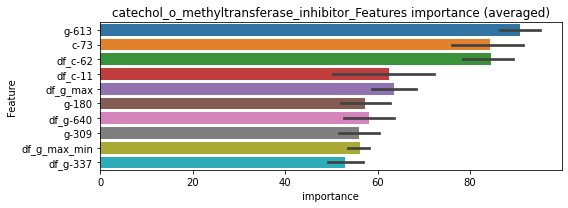

len(train_index) : 3896
len(valid_index) : 3897
================================= fold 1/2 catechol_o_methyltransferase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0126897	valid_1's binary_logloss: 0.0178625
[200]	training's binary_logloss: 0.00146479	valid_1's binary_logloss: 0.00479223
[300]	training's binary_logloss: 0.00040845	valid_1's binary_logloss: 0.00351625
Early stopping, best iteration is:
[355]	training's binary_logloss: 0.0002722	valid_1's binary_logloss: 0.00337183


len(train_index) : 3897
len(valid_index) : 3896
================================= fold 2/2 catechol_o_methyltransferase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0127911	valid_1's binary_logloss: 0.0193548
[200]	training's binary_logloss: 0.00148013	valid_1's binary_logloss: 0.0057019
[300]	training's binary_logloss: 0.000418065	valid_1's binary_logloss: 0.00394523
Early stopping, best iteration is:
[386]	training's binary_logloss: 0.000227169	valid_1's binary_logloss: 0.00333863


catechol_o_methyltransferase_inhibitor logloss: 0.003355231934151369
cc_chemokine_receptor_antagonist, len(trt): 102, len(othr): 3272, target_rate: 0.0042832 → Adj_target_rate: 0.0042806


neg labels: 3289 → selected neg labels: 3272


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0616564	valid_1's binary_logloss: 0.148246
[200]	training's binary_logloss: 0.0150524	valid_1's binary_logloss: 0.101778
[300]	training's binary_logloss: 0.00468632	valid_1's binary_logloss: 0.0879372
Early stopping, best iteration is:
[354]	training's binary_logloss: 0.00293812	valid_1's binary_logloss: 0.0850394
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0645079	valid_1's binary_logloss: 0.124265
[200]	training's binary_logloss: 0.0170957	valid_1's binary_logloss: 0.0762421
[300]	training's binary_logloss: 0.00542757	valid_1's binary_logloss: 0.0613731
[400]	training's binary_logloss: 0.00242882	valid_1's binary_logloss: 0.0578409
Early stopping, best iteration is:
[394]	training's binary_logloss: 0.00251849	valid_1's binary_logloss: 0.0576456


1 / 3 AUC score:0.995
Threshold: 0.0163003, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 158 → positive_corect_labels: 641/3768
p_label_rate: 0.0512305 Vs.target_rate: 0.00428, Num_p_label: 204.0, conf_0:0.00402, conf_1:0.01793
Num_p_label: 204.0, Expected: 17.1, Adj_threshold_1: 0.0163003
Num_p_label: 123.0, Expected: 17.1, Adj_threshold_2: 0.0213003
Num_p_label: 76.0, Expected: 17.1, Adj_threshold_3: 0.0263003
Num_p_label: 50.0, Expected: 17.1, Adj_threshold_4: 0.0313003
Num_p_label: 31.0, Expected: 17.1, Adj_threshold_5: 0.0363003
threshold: 0.0363003, positive p_label: 31.0/3982, p_label_rate: 0.0077850
positive y_label: 641.0/3768, y_label_rate: 0.1701168
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0602962	valid_1's binary_logloss: 0.132542
[200]	training's binary_logloss: 0.0144929	valid_1's binary_logloss: 0.0854025
[300]	training's binary_logloss: 0.00469231	valid_1's binary_logloss: 0.0704951
Early stopping, best iteration is:
[360]	training's binary_logloss: 0.00281112	valid_1's binary_logloss: 0.0664949
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0594137	valid_1's binary_logloss: 0.130942
[200]	training's binary_logloss: 0.0144919	valid_1's binary_logloss: 0.0816782
[300]	training's binary_logloss: 0.00472474	valid_1's binary_logloss: 0.067799
Early stopping, best iteration is:
[362]	training's binary_logloss: 0.00284564	valid_1's binary_logloss: 0.0648721


2 / 3 AUC score:0.998
Threshold: 0.0363003, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 36 → positive_corect_labels: 629.0/3732
p_label_rate: 0.0193370 Vs.target_rate: 0.00428, Num_p_label: 77.0, conf_0:0.00437, conf_1:0.03993
Num_p_label: 77.0, Expected: 17.1, Adj_threshold_1: 0.0363003
Num_p_label: 65.0, Expected: 17.1, Adj_threshold_2: 0.0413003
Num_p_label: 52.0, Expected: 17.1, Adj_threshold_3: 0.0463003
Num_p_label: 47.0, Expected: 17.1, Adj_threshold_4: 0.0513003
Num_p_label: 40.0, Expected: 17.1, Adj_threshold_5: 0.0563003
Num_p_label: 29.0, Expected: 17.1, Adj_threshold_6: 0.0613003
threshold: 0.0613003, positive p_label: 29.0/3982, p_label_rate: 0.0072828
positive y_label: 629.0/3732, y_label_rate: 0.1685423
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0564007	valid_1's binary_logloss: 0.12463
[200]	training's binary_logloss: 0.0136781	valid_1's binary_logloss: 0.0806237
[300]	training's binary_logloss: 0.00438125	valid_1's binary_logloss: 0.0693861
Early stopping, best iteration is:
[345]	training's binary_logloss: 0.00298216	valid_1's binary_logloss: 0.0653286
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0626149	valid_1's binary_logloss: 0.124146
[200]	training's binary_logloss: 0.014724	valid_1's binary_logloss: 0.0747638
[300]	training's binary_logloss: 0.00459188	valid_1's binary_logloss: 0.0621239
Early stopping, best iteration is:
[370]	training's binary_logloss: 0.0025367	valid_1's binary_logloss: 0.0588728


3 / 3 AUC score:0.998
Threshold: 0.0613003, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 34 → positive_corect_labels: 605.0/3698
p_label_rate: 0.0077850 Vs.target_rate: 0.00428, Num_p_label: 31.0, conf_0:0.00425, conf_1:0.06743
threshold: 0.0613003, positive p_label: 31.0/3982, p_label_rate: 0.0077850
positive y_label: 636.0/7680, y_label_rate: 0.0828125


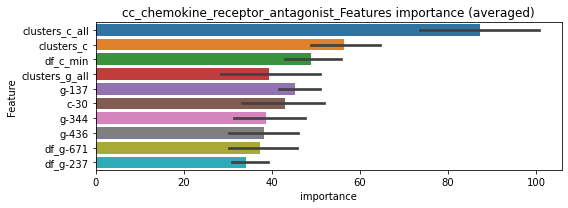

len(train_index) : 3840
len(valid_index) : 3840
================================= fold 1/2 cc_chemokine_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0308993	valid_1's binary_logloss: 0.077094
[200]	training's binary_logloss: 0.00743531	valid_1's binary_logloss: 0.056578
[300]	training's binary_logloss: 0.00234979	valid_1's binary_logloss: 0.0523262
Early stopping, best iteration is:
[300]	training's binary_logloss: 0.00234979	valid_1's binary_logloss: 0.0523262


len(train_index) : 3840
len(valid_index) : 3840
================================= fold 2/2 cc_chemokine_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0335397	valid_1's binary_logloss: 0.0733553
[200]	training's binary_logloss: 0.00806096	valid_1's binary_logloss: 0.0489444
Early stopping, best iteration is:
[286]	training's binary_logloss: 0.00295072	valid_1's binary_logloss: 0.0443928


cc_chemokine_receptor_antagonist logloss: 0.04835946779578788


  acetylcholine_receptor_agonist acetylcholine_receptor_antagonist  \
0                       df_g-122                              c-30   
1                  clusters_df_c                         c_all_max   
2                          cnt_0                    clusters_g_all   
3                      c_all_min                          df_g-707   
4                        df_g-51                        clusters_g   
5                       df_c_min                          df_c_min   
6                          cnt_2                             g-514   
7                       df_g-736                          df_g-640   
8                          g-244                            df_c-6   
9                           c-73                          df_g-597   

  acetylcholinesterase_inhibitor adenosine_receptor_antagonist  \
0                      c_all_max                clusters_c_all   
1                      c_all_min                      df_c_min   
2                 clusters_g_al

cck_receptor_antagonist, len(trt): 18, len(othr): 3286, target_rate: 0.0007559 → Adj_target_rate: 0.0009799


neg labels: 3289 → selected neg labels: 3286


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0236571	valid_1's binary_logloss: 0.0311524
[200]	training's binary_logloss: 0.00281832	valid_1's binary_logloss: 0.00520742
[300]	training's binary_logloss: 0.000793534	valid_1's binary_logloss: 0.00182311
[400]	training's binary_logloss: 0.00042811	valid_1's binary_logloss: 0.00109527
[500]	training's binary_logloss: 0.000345652	valid_1's binary_logloss: 0.000920852
Early stopping, best iteration is:
[517]	training's binary_logloss: 0.000341702	valid_1's binary_logloss: 0.000912372
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0236233	valid_1's binary_logloss: 0.032238
[200]	training's binary_logloss: 0.00281924	valid_1's binary_logloss: 0.00581975
[300]	training's binary_logloss: 0.000800514	valid_1's binary_logloss: 0.00223692
[400]	training's binary_logloss: 0.000427851	valid_1's binary_logloss: 0.00142014
[500]	training's binary_logloss

1 / 3 AUC score:1.000
Threshold: 0.0019316, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → positive_corect_labels: 657/3811
p_label_rate: 0.0374184 Vs.target_rate: 0.00076, Num_p_label: 149.0, conf_0:0.00020, conf_1:0.00212
Num_p_label: 149.0, Expected: 3.0, Adj_threshold_1: 0.0019316
Num_p_label: 27.0, Expected: 3.0, Adj_threshold_2: 0.0069316
Num_p_label: 7.0, Expected: 3.0, Adj_threshold_3: 0.0119316
Num_p_label: 5.0, Expected: 3.0, Adj_threshold_4: 0.0169316
threshold: 0.0169316, positive p_label: 5.0/3982, p_label_rate: 0.0012557
positive y_label: 657.0/3811, y_label_rate: 0.1723957
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0228421	valid_1's binary_logloss: 0.0283458
[200]	training's binary_logloss: 0.00264753	valid_1's binary_logloss: 0.0044465
[300]	training's binary_logloss: 0.000760009	valid_1's binary_logloss: 0.00156954
[400]	training's binary_logloss: 0.000414328	valid_1's binary_logloss: 0.000946017
[500]	training's binary_logloss: 0.000336972	valid_1's binary_logloss: 0.000798644
Early stopping, best iteration is:
[515]	training's binary_logloss: 0.000334735	valid_1's binary_logloss: 0.000795149
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0228588	valid_1's binary_logloss: 0.0306701
[200]	training's binary_logloss: 0.00263664	valid_1's binary_logloss: 0.0054455
[300]	training's binary_logloss: 0.000764922	valid_1's binary_logloss: 0.00216375
[400]	training's binary_logloss: 0.000416148	valid_1's binary_logloss: 0.00137587
[500]	training's binary_loglos

2 / 3 AUC score:1.000
Threshold: 0.0169316, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 1 → positive_corect_labels: 657.0/3810
p_label_rate: 0.0075339 Vs.target_rate: 0.00076, Num_p_label: 30.0, conf_0:0.00022, conf_1:0.01862
Num_p_label: 30.0, Expected: 3.0, Adj_threshold_1: 0.0169316
Num_p_label: 26.0, Expected: 3.0, Adj_threshold_2: 0.0219316
Num_p_label: 18.0, Expected: 3.0, Adj_threshold_3: 0.0269316
Num_p_label: 15.0, Expected: 3.0, Adj_threshold_4: 0.0319316
Num_p_label: 6.0, Expected: 3.0, Adj_threshold_5: 0.0369316
threshold: 0.0369316, positive p_label: 6.0/3982, p_label_rate: 0.0015068
positive y_label: 657.0/3810, y_label_rate: 0.1724409
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0228913	valid_1's binary_logloss: 0.0285366
[200]	training's binary_logloss: 0.00265272	valid_1's binary_logloss: 0.00454562
[300]	training's binary_logloss: 0.000767087	valid_1's binary_logloss: 0.0016615
[400]	training's binary_logloss: 0.000420063	valid_1's binary_logloss: 0.00104264
[500]	training's binary_logloss: 0.000341274	valid_1's binary_logloss: 0.000888285
Early stopping, best iteration is:
[515]	training's binary_logloss: 0.000337032	valid_1's binary_logloss: 0.00088055
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0225076	valid_1's binary_logloss: 0.0297544
[200]	training's binary_logloss: 0.00261448	valid_1's binary_logloss: 0.00598693
[300]	training's binary_logloss: 0.000753613	valid_1's binary_logloss: 0.00279508
[400]	training's binary_logloss: 0.000411677	valid_1's binary_logloss: 0.0019779
[500]	training's binary_logloss:

3 / 3 AUC score:1.000
Threshold: 0.0369316, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → positive_corect_labels: 657.0/3810
p_label_rate: 0.0027624 Vs.target_rate: 0.00076, Num_p_label: 11.0, conf_0:0.00022, conf_1:0.04062
Num_p_label: 11.0, Expected: 3.0, Adj_threshold_1: 0.0369316
Num_p_label: 8.0, Expected: 3.0, Adj_threshold_2: 0.0419316
Num_p_label: 6.0, Expected: 3.0, Adj_threshold_3: 0.0469316
threshold: 0.0469316, positive p_label: 6.0/3982, p_label_rate: 0.0015068
positive y_label: 663.0/7792, y_label_rate: 0.0850873


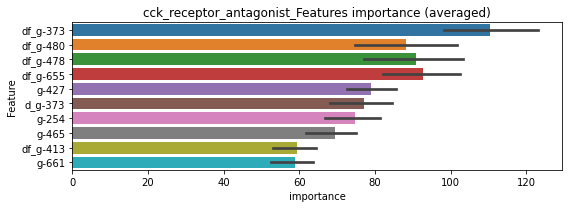

len(train_index) : 3896
len(valid_index) : 3896
================================= fold 1/2 cck_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0123559	valid_1's binary_logloss: 0.0218916
[200]	training's binary_logloss: 0.00141713	valid_1's binary_logloss: 0.0110639
Early stopping, best iteration is:
[270]	training's binary_logloss: 0.000529089	valid_1's binary_logloss: 0.0102541


len(train_index) : 3896
len(valid_index) : 3896
================================= fold 2/2 cck_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0132643	valid_1's binary_logloss: 0.0183363
[200]	training's binary_logloss: 0.00154716	valid_1's binary_logloss: 0.00491557
[300]	training's binary_logloss: 0.000434412	valid_1's binary_logloss: 0.00331865
Early stopping, best iteration is:
[362]	training's binary_logloss: 0.000276344	valid_1's binary_logloss: 0.00308282


cck_receptor_antagonist logloss: 0.006668473634892809
cdk_inhibitor, len(trt): 352, len(othr): 3263, target_rate: 0.0147812 → Adj_target_rate: 0.0122676


neg labels: 3289 → selected neg labels: 3263


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0448627	valid_1's binary_logloss: 0.122198
Early stopping, best iteration is:
[164]	training's binary_logloss: 0.0146087	valid_1's binary_logloss: 0.110046
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0452219	valid_1's binary_logloss: 0.119558
[200]	training's binary_logloss: 0.00898192	valid_1's binary_logloss: 0.102126


1 / 3 AUC score:0.977
Threshold: 0.0441377, pos_neg_ratio: 0.8000000


Early stopping, best iteration is:
[213]	training's binary_logloss: 0.00751313	valid_1's binary_logloss: 0.101903


Remove_noisy_labels: 227 → positive_corect_labels: 604/3688
p_label_rate: 0.0868910 Vs.target_rate: 0.01478, Num_p_label: 346.0, conf_0:0.00601, conf_1:0.04855
Num_p_label: 346.0, Expected: 58.9, Adj_threshold_1: 0.0441377
Num_p_label: 333.0, Expected: 58.9, Adj_threshold_2: 0.0491377
Num_p_label: 321.0, Expected: 58.9, Adj_threshold_3: 0.0541377
Num_p_label: 303.0, Expected: 58.9, Adj_threshold_4: 0.0591377
Num_p_label: 291.0, Expected: 58.9, Adj_threshold_5: 0.0641377
Num_p_label: 282.0, Expected: 58.9, Adj_threshold_6: 0.0691377
Num_p_label: 273.0, Expected: 58.9, Adj_threshold_7: 0.0741377
Num_p_label: 264.0, Expected: 58.9, Adj_threshold_8: 0.0791377
Num_p_label: 250.0, Expected: 58.9, Adj_threshold_9: 0.0841377
Num_p_label: 243.0, Expected: 58.9, Adj_threshold_10: 0.0891377
threshold: 0.0941377, positive p_label: 232.0/3982, p_label_rate: 0.0582622
positive y_label: 604.0/3688, y_label_rate: 0.1637744
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.031516	valid_1's binary_logloss: 0.0806219
[200]	training's binary_logloss: 0.00462227	valid_1's binary_logloss: 0.0663934
Early stopping, best iteration is:
[193]	training's binary_logloss: 0.00513979	valid_1's binary_logloss: 0.0660697
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0325199	valid_1's binary_logloss: 0.0743638


2 / 3 AUC score:0.991
Threshold: 0.0941377, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 85 → positive_corect_labels: 568.0/3603
p_label_rate: 0.0904068 Vs.target_rate: 0.01478, Num_p_label: 360.0, conf_0:0.00277, conf_1:0.10355
Num_p_label: 360.0, Expected: 58.9, Adj_threshold_1: 0.0941377
Num_p_label: 357.0, Expected: 58.9, Adj_threshold_2: 0.0991377


Early stopping, best iteration is:
[180]	training's binary_logloss: 0.0068084	valid_1's binary_logloss: 0.0592694


Num_p_label: 355.0, Expected: 58.9, Adj_threshold_3: 0.1041377
Num_p_label: 348.0, Expected: 58.9, Adj_threshold_4: 0.1091377
Num_p_label: 347.0, Expected: 58.9, Adj_threshold_5: 0.1141377
Num_p_label: 345.0, Expected: 58.9, Adj_threshold_6: 0.1191377
Num_p_label: 343.0, Expected: 58.9, Adj_threshold_7: 0.1241377
Num_p_label: 341.0, Expected: 58.9, Adj_threshold_8: 0.1291377
Num_p_label: 339.0, Expected: 58.9, Adj_threshold_9: 0.1341377
Num_p_label: 337.0, Expected: 58.9, Adj_threshold_10: 0.1391377
threshold: 0.1441377, positive p_label: 333.0/3982, p_label_rate: 0.0836263
positive y_label: 568.0/3603, y_label_rate: 0.1576464
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0238288	valid_1's binary_logloss: 0.042977
[200]	training's binary_logloss: 0.00296608	valid_1's binary_logloss: 0.0251449
Early stopping, best iteration is:
[258]	training's binary_logloss: 0.00129767	valid_1's binary_logloss: 0.0227641
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0239757	valid_1's binary_logloss: 0.0511718
[200]	training's binary_logloss: 0.00321393	valid_1's binary_logloss: 0.0387549
Early stopping, best iteration is:
[196]	training's binary_logloss: 0.00345893	valid_1's binary_logloss: 0.0386306


3 / 3 AUC score:0.998
Threshold: 0.1441377, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 30 → positive_corect_labels: 552.0/3573
p_label_rate: 0.0939227 Vs.target_rate: 0.01478, Num_p_label: 374.0, conf_0:0.00088, conf_1:0.15855
Num_p_label: 374.0, Expected: 58.9, Adj_threshold_1: 0.1441377
Num_p_label: 373.0, Expected: 58.9, Adj_threshold_2: 0.1491377
Num_p_label: 371.0, Expected: 58.9, Adj_threshold_3: 0.1541377
Num_p_label: 370.0, Expected: 58.9, Adj_threshold_4: 0.1591377
Num_p_label: 369.0, Expected: 58.9, Adj_threshold_5: 0.1641377
Num_p_label: 369.0, Expected: 58.9, Adj_threshold_6: 0.1691377
Num_p_label: 369.0, Expected: 58.9, Adj_threshold_7: 0.1741377
Num_p_label: 368.0, Expected: 58.9, Adj_threshold_8: 0.1791377
Num_p_label: 368.0, Expected: 58.9, Adj_threshold_9: 0.1841377
Num_p_label: 368.0, Expected: 58.9, Adj_threshold_10: 0.1891377
threshold: 0.1941377, positive p_label: 366.0/3982, p_label_rate: 0.0919136
positive y_label: 918.0/7555, y_label_rate: 0.1215089


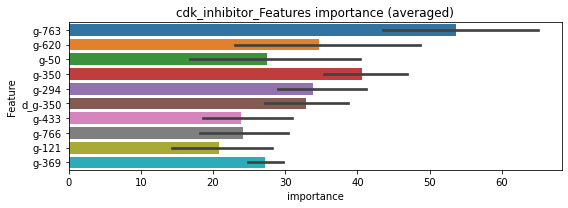

len(train_index) : 3777
len(valid_index) : 3778
================================= fold 1/2 cdk_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0166613	valid_1's binary_logloss: 0.0351517
[200]	training's binary_logloss: 0.0019344	valid_1's binary_logloss: 0.021894
Early stopping, best iteration is:
[258]	training's binary_logloss: 0.000795511	valid_1's binary_logloss: 0.0207267


len(train_index) : 3778
len(valid_index) : 3777
================================= fold 2/2 cdk_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0172267	valid_1's binary_logloss: 0.0246343
[200]	training's binary_logloss: 0.00214344	valid_1's binary_logloss: 0.0111683
[300]	training's binary_logloss: 0.000563038	valid_1's binary_logloss: 0.00978326
Early stopping, best iteration is:
[303]	training's binary_logloss: 0.0005459	valid_1's binary_logloss: 0.00975752


cdk_inhibitor logloss: 0.015242840500995879
chelating_agent, len(trt): 54, len(othr): 3280, target_rate: 0.0022676 → Adj_target_rate: 0.0024931


neg labels: 3289 → selected neg labels: 3280


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0429237	valid_1's binary_logloss: 0.0865897
[200]	training's binary_logloss: 0.00822769	valid_1's binary_logloss: 0.042388
[300]	training's binary_logloss: 0.00245188	valid_1's binary_logloss: 0.0293282
[400]	training's binary_logloss: 0.00116011	valid_1's binary_logloss: 0.0248673
Early stopping, best iteration is:
[392]	training's binary_logloss: 0.00121725	valid_1's binary_logloss: 0.0248215
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0477705	valid_1's binary_logloss: 0.0843745
[200]	training's binary_logloss: 0.00905415	valid_1's binary_logloss: 0.0300759
[300]	training's binary_logloss: 0.00264403	valid_1's binary_logloss: 0.0154101
[400]	training's binary_logloss: 0.001228	valid_1's binary_logloss: 0.0108945
[500]	training's binary_logloss: 0.000769631	valid_1's binary_logloss: 0.00901964
Early stopping, best iteration is:
[585]	train

1 / 3 AUC score:1.000
Threshold: 0.0064497, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → positive_corect_labels: 656/3804
p_label_rate: 0.0394274 Vs.target_rate: 0.00227, Num_p_label: 157.0, conf_0:0.00103, conf_1:0.00709
Num_p_label: 157.0, Expected: 9.0, Adj_threshold_1: 0.0064497
Num_p_label: 61.0, Expected: 9.0, Adj_threshold_2: 0.0114497
Num_p_label: 31.0, Expected: 9.0, Adj_threshold_3: 0.0164497
Num_p_label: 14.0, Expected: 9.0, Adj_threshold_4: 0.0214497
threshold: 0.0214497, positive p_label: 14.0/3982, p_label_rate: 0.0035158
positive y_label: 656.0/3804, y_label_rate: 0.1724501
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0439526	valid_1's binary_logloss: 0.0895996
[200]	training's binary_logloss: 0.00802662	valid_1's binary_logloss: 0.042347
[300]	training's binary_logloss: 0.00239874	valid_1's binary_logloss: 0.0289902
[400]	training's binary_logloss: 0.001156	valid_1's binary_logloss: 0.024485
[500]	training's binary_logloss: 0.000731436	valid_1's binary_logloss: 0.0223241
Early stopping, best iteration is:
[490]	training's binary_logloss: 0.000754314	valid_1's binary_logloss: 0.0222013
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.046863	valid_1's binary_logloss: 0.0777435
[200]	training's binary_logloss: 0.00863443	valid_1's binary_logloss: 0.0266384
[300]	training's binary_logloss: 0.00255118	valid_1's binary_logloss: 0.0141025
[400]	training's binary_logloss: 0.00121636	valid_1's binary_logloss: 0.0103417
[500]	training's binary_logloss: 0.000769289	val

2 / 3 AUC score:1.000
Threshold: 0.0214497, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 11 → positive_corect_labels: 654.0/3793
p_label_rate: 0.0082873 Vs.target_rate: 0.00227, Num_p_label: 33.0, conf_0:0.00089, conf_1:0.02359
Num_p_label: 33.0, Expected: 9.0, Adj_threshold_1: 0.0214497
Num_p_label: 28.0, Expected: 9.0, Adj_threshold_2: 0.0264497
Num_p_label: 18.0, Expected: 9.0, Adj_threshold_3: 0.0314497
threshold: 0.0314497, positive p_label: 18.0/3982, p_label_rate: 0.0045203
positive y_label: 654.0/3793, y_label_rate: 0.1724229
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0431144	valid_1's binary_logloss: 0.0821135
[200]	training's binary_logloss: 0.00804476	valid_1's binary_logloss: 0.0337879
[300]	training's binary_logloss: 0.00241434	valid_1's binary_logloss: 0.0217572
[400]	training's binary_logloss: 0.00116646	valid_1's binary_logloss: 0.0176151
[500]	training's binary_logloss: 0.000747899	valid_1's binary_logloss: 0.0157974
Early stopping, best iteration is:
[552]	training's binary_logloss: 0.000637014	valid_1's binary_logloss: 0.0151416
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0458797	valid_1's binary_logloss: 0.0899401
[200]	training's binary_logloss: 0.0085511	valid_1's binary_logloss: 0.0396832
[300]	training's binary_logloss: 0.00247236	valid_1's binary_logloss: 0.0266857
[400]	training's binary_logloss: 0.00117268	valid_1's binary_logloss: 0.0234352
[500]	training's binary_logloss: 0.000740463

3 / 3 AUC score:1.000
Threshold: 0.0314497, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 5 → positive_corect_labels: 651.0/3788
p_label_rate: 0.0060271 Vs.target_rate: 0.00227, Num_p_label: 24.0, conf_0:0.00091, conf_1:0.03459
threshold: 0.0314497, positive p_label: 24.0/3982, p_label_rate: 0.0060271
positive y_label: 675.0/7770, y_label_rate: 0.0868726


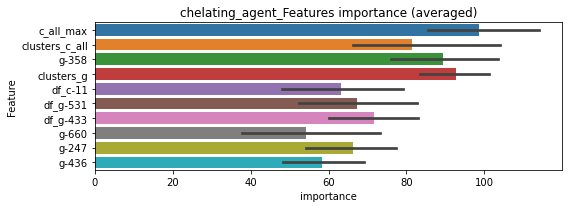

len(train_index) : 3885
len(valid_index) : 3885
================================= fold 1/2 chelating_agent=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0252881	valid_1's binary_logloss: 0.0588419
[200]	training's binary_logloss: 0.00454355	valid_1's binary_logloss: 0.0355587
[300]	training's binary_logloss: 0.00135388	valid_1's binary_logloss: 0.0315447
Early stopping, best iteration is:
[299]	training's binary_logloss: 0.00136595	valid_1's binary_logloss: 0.031516


len(train_index) : 3885
len(valid_index) : 3885
================================= fold 2/2 chelating_agent=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0276788	valid_1's binary_logloss: 0.0512229
[200]	training's binary_logloss: 0.00541797	valid_1's binary_logloss: 0.0258365
[300]	training's binary_logloss: 0.00163489	valid_1's binary_logloss: 0.0214035
Early stopping, best iteration is:
[347]	training's binary_logloss: 0.001131	valid_1's binary_logloss: 0.0206102


chelating_agent logloss: 0.02606307047517511


  acetylcholine_receptor_agonist acetylcholine_receptor_antagonist  \
0                       df_g-122                              c-30   
1                  clusters_df_c                         c_all_max   
2                          cnt_0                    clusters_g_all   
3                      c_all_min                          df_g-707   
4                        df_g-51                        clusters_g   
5                       df_c_min                          df_c_min   
6                          cnt_2                             g-514   
7                       df_g-736                          df_g-640   
8                          g-244                            df_c-6   
9                           c-73                          df_g-597   

  acetylcholinesterase_inhibitor adenosine_receptor_antagonist  \
0                      c_all_max                clusters_c_all   
1                      c_all_min                      df_c_min   
2                 clusters_g_al

chk_inhibitor, len(trt): 24, len(othr): 3285, target_rate: 0.0010078 → Adj_target_rate: 0.0012513


neg labels: 3289 → selected neg labels: 3285


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0195918	valid_1's binary_logloss: 0.0253337
[200]	training's binary_logloss: 0.00204676	valid_1's binary_logloss: 0.00447636
[300]	training's binary_logloss: 0.000572173	valid_1's binary_logloss: 0.00210737
[400]	training's binary_logloss: 0.000324436	valid_1's binary_logloss: 0.0014858
[500]	training's binary_logloss: 0.000269131	valid_1's binary_logloss: 0.00134429
Early stopping, best iteration is:
[540]	training's binary_logloss: 0.000264802	valid_1's binary_logloss: 0.00132763
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.019119	valid_1's binary_logloss: 0.0230574
[200]	training's binary_logloss: 0.00199713	valid_1's binary_logloss: 0.00412996
[300]	training's binary_logloss: 0.000567319	valid_1's binary_logloss: 0.0022451
[400]	training's binary_logloss: 0.000320652	valid_1's binary_logloss: 0.00176944
Early stopping, best iteration is:

1 / 3 AUC score:1.000
Threshold: 0.0017373, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → positive_corect_labels: 657/3810
p_label_rate: 0.0447012 Vs.target_rate: 0.00101, Num_p_label: 178.0, conf_0:0.00008, conf_1:0.00191
Num_p_label: 178.0, Expected: 4.0, Adj_threshold_1: 0.0017373
Num_p_label: 80.0, Expected: 4.0, Adj_threshold_2: 0.0067373
Num_p_label: 57.0, Expected: 4.0, Adj_threshold_3: 0.0117373
Num_p_label: 45.0, Expected: 4.0, Adj_threshold_4: 0.0167373
Num_p_label: 41.0, Expected: 4.0, Adj_threshold_5: 0.0217373
Num_p_label: 36.0, Expected: 4.0, Adj_threshold_6: 0.0267373
Num_p_label: 34.0, Expected: 4.0, Adj_threshold_7: 0.0317373
Num_p_label: 33.0, Expected: 4.0, Adj_threshold_8: 0.0367373
Num_p_label: 30.0, Expected: 4.0, Adj_threshold_9: 0.0417373
Num_p_label: 30.0, Expected: 4.0, Adj_threshold_10: 0.0467373
threshold: 0.0517373, positive p_label: 30.0/3982, p_label_rate: 0.0075339
positive y_label: 657.0/3810, y_label_rate: 0.1724409
================= Pseudo label

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.018743	valid_1's binary_logloss: 0.0225529
[200]	training's binary_logloss: 0.00179147	valid_1's binary_logloss: 0.00308304
[300]	training's binary_logloss: 0.000480278	valid_1's binary_logloss: 0.00114615
[400]	training's binary_logloss: 0.00027606	valid_1's binary_logloss: 0.000750309
[500]	training's binary_logloss: 0.000235684	valid_1's binary_logloss: 0.000666303
Early stopping, best iteration is:
[532]	training's binary_logloss: 0.000231775	valid_1's binary_logloss: 0.000656886
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0187719	valid_1's binary_logloss: 0.0214229
[200]	training's binary_logloss: 0.00179933	valid_1's binary_logloss: 0.00243668
[300]	training's binary_logloss: 0.00048639	valid_1's binary_logloss: 0.000786581
[400]	training's binary_logloss: 0.000276478	valid_1's binary_logloss: 0.000492509
[500]	training's binary_loglo

2 / 3 AUC score:1.000
Threshold: 0.0517373, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 2 → positive_corect_labels: 657.0/3808
p_label_rate: 0.0220994 Vs.target_rate: 0.00101, Num_p_label: 88.0, conf_0:0.00009, conf_1:0.05691
Num_p_label: 88.0, Expected: 4.0, Adj_threshold_1: 0.0517373
Num_p_label: 82.0, Expected: 4.0, Adj_threshold_2: 0.0567373
Num_p_label: 77.0, Expected: 4.0, Adj_threshold_3: 0.0617373
Num_p_label: 74.0, Expected: 4.0, Adj_threshold_4: 0.0667373
Num_p_label: 72.0, Expected: 4.0, Adj_threshold_5: 0.0717373
Num_p_label: 69.0, Expected: 4.0, Adj_threshold_6: 0.0767373
Num_p_label: 68.0, Expected: 4.0, Adj_threshold_7: 0.0817373
Num_p_label: 65.0, Expected: 4.0, Adj_threshold_8: 0.0867373
Num_p_label: 65.0, Expected: 4.0, Adj_threshold_9: 0.0917373
Num_p_label: 63.0, Expected: 4.0, Adj_threshold_10: 0.0967373
threshold: 0.1017373, positive p_label: 62.0/3982, p_label_rate: 0.0155701
positive y_label: 657.0/3808, y_label_rate: 0.1725315
================= Pseudo labelin

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0186777	valid_1's binary_logloss: 0.0226051
[200]	training's binary_logloss: 0.00179161	valid_1's binary_logloss: 0.00317962
[300]	training's binary_logloss: 0.000482726	valid_1's binary_logloss: 0.0011441
[400]	training's binary_logloss: 0.000278706	valid_1's binary_logloss: 0.000753532
[500]	training's binary_logloss: 0.000240033	valid_1's binary_logloss: 0.000679681
Early stopping, best iteration is:
[538]	training's binary_logloss: 0.000235958	valid_1's binary_logloss: 0.000671751
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.01857	valid_1's binary_logloss: 0.021201
[200]	training's binary_logloss: 0.00179198	valid_1's binary_logloss: 0.00255604
[300]	training's binary_logloss: 0.000477	valid_1's binary_logloss: 0.000882053
[400]	training's binary_logloss: 0.000275794	valid_1's binary_logloss: 0.000588831
[500]	training's binary_logloss: 

3 / 3 AUC score:1.000
Threshold: 0.1017373, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → positive_corect_labels: 657.0/3808
p_label_rate: 0.0150678 Vs.target_rate: 0.00101, Num_p_label: 60.0, conf_0:0.00009, conf_1:0.11191
Num_p_label: 60.0, Expected: 4.0, Adj_threshold_1: 0.1017373
Num_p_label: 59.0, Expected: 4.0, Adj_threshold_2: 0.1067373
Num_p_label: 59.0, Expected: 4.0, Adj_threshold_3: 0.1117373
Num_p_label: 59.0, Expected: 4.0, Adj_threshold_4: 0.1167373
Num_p_label: 58.0, Expected: 4.0, Adj_threshold_5: 0.1217373
Num_p_label: 58.0, Expected: 4.0, Adj_threshold_6: 0.1267373
Num_p_label: 55.0, Expected: 4.0, Adj_threshold_7: 0.1317373
Num_p_label: 54.0, Expected: 4.0, Adj_threshold_8: 0.1367373
Num_p_label: 53.0, Expected: 4.0, Adj_threshold_9: 0.1417373
Num_p_label: 53.0, Expected: 4.0, Adj_threshold_10: 0.1467373
threshold: 0.1517373, positive p_label: 53.0/3982, p_label_rate: 0.0133099
positive y_label: 710.0/7790, y_label_rate: 0.0911425


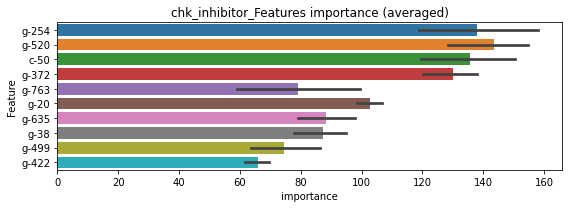

len(train_index) : 3895
len(valid_index) : 3895
================================= fold 1/2 chk_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0122543	valid_1's binary_logloss: 0.023746
[200]	training's binary_logloss: 0.00142703	valid_1's binary_logloss: 0.012417
Early stopping, best iteration is:
[285]	training's binary_logloss: 0.000462553	valid_1's binary_logloss: 0.0114135


len(train_index) : 3895
len(valid_index) : 3895
================================= fold 2/2 chk_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0127631	valid_1's binary_logloss: 0.0196996
[200]	training's binary_logloss: 0.00152881	valid_1's binary_logloss: 0.00841946
Early stopping, best iteration is:
[256]	training's binary_logloss: 0.000687424	valid_1's binary_logloss: 0.00769352


chk_inhibitor logloss: 0.009553526784865686
chloride_channel_blocker, len(trt): 42, len(othr): 3282, target_rate: 0.0017637 → Adj_target_rate: 0.0020135


neg labels: 3289 → selected neg labels: 3282


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.037746	valid_1's binary_logloss: 0.0679501
[200]	training's binary_logloss: 0.00609102	valid_1's binary_logloss: 0.024339
[300]	training's binary_logloss: 0.00174062	valid_1's binary_logloss: 0.0145746
[400]	training's binary_logloss: 0.000856225	valid_1's binary_logloss: 0.0120894
[500]	training's binary_logloss: 0.00057216	valid_1's binary_logloss: 0.0109778
Early stopping, best iteration is:
[570]	training's binary_logloss: 0.000498587	valid_1's binary_logloss: 0.010773
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0403182	valid_1's binary_logloss: 0.0666805
[200]	training's binary_logloss: 0.00674827	valid_1's binary_logloss: 0.0221834
[300]	training's binary_logloss: 0.00191457	valid_1's binary_logloss: 0.0124278
[400]	training's binary_logloss: 0.000909644	valid_1's binary_logloss: 0.0095126
[500]	training's binary_logloss: 0.000599179	

1 / 3 AUC score:1.000
Threshold: 0.0044712, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → positive_corect_labels: 656/3806
p_label_rate: 0.0394274 Vs.target_rate: 0.00176, Num_p_label: 157.0, conf_0:0.00044, conf_1:0.00492
Num_p_label: 157.0, Expected: 7.0, Adj_threshold_1: 0.0044712
Num_p_label: 57.0, Expected: 7.0, Adj_threshold_2: 0.0094712
Num_p_label: 26.0, Expected: 7.0, Adj_threshold_3: 0.0144712
Num_p_label: 15.0, Expected: 7.0, Adj_threshold_4: 0.0194712
Num_p_label: 7.0, Expected: 7.0, Adj_threshold_5: 0.0244712
threshold: 0.0244712, positive p_label: 7.0/3982, p_label_rate: 0.0017579
positive y_label: 656.0/3806, y_label_rate: 0.1723594
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0384507	valid_1's binary_logloss: 0.0649361
[200]	training's binary_logloss: 0.00620731	valid_1's binary_logloss: 0.0215979
[300]	training's binary_logloss: 0.00177407	valid_1's binary_logloss: 0.0121191
[400]	training's binary_logloss: 0.000860868	valid_1's binary_logloss: 0.00937341
Early stopping, best iteration is:
[487]	training's binary_logloss: 0.00059476	valid_1's binary_logloss: 0.00830911
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0376899	valid_1's binary_logloss: 0.0635207
[200]	training's binary_logloss: 0.00622092	valid_1's binary_logloss: 0.0206073
[300]	training's binary_logloss: 0.00182806	valid_1's binary_logloss: 0.0111268
[400]	training's binary_logloss: 0.000891995	valid_1's binary_logloss: 0.00833111
[500]	training's binary_logloss: 0.000590405	valid_1's binary_logloss: 0.0072011
Early stopping, best iteration is:
[525

2 / 3 AUC score:1.000
Threshold: 0.0244712, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 3 → positive_corect_labels: 656.0/3803
p_label_rate: 0.0102963 Vs.target_rate: 0.00176, Num_p_label: 41.0, conf_0:0.00059, conf_1:0.02692
Num_p_label: 41.0, Expected: 7.0, Adj_threshold_1: 0.0244712
Num_p_label: 32.0, Expected: 7.0, Adj_threshold_2: 0.0294712
Num_p_label: 28.0, Expected: 7.0, Adj_threshold_3: 0.0344712
Num_p_label: 23.0, Expected: 7.0, Adj_threshold_4: 0.0394712
Num_p_label: 20.0, Expected: 7.0, Adj_threshold_5: 0.0444712
Num_p_label: 18.0, Expected: 7.0, Adj_threshold_6: 0.0494712
Num_p_label: 12.0, Expected: 7.0, Adj_threshold_7: 0.0544712
threshold: 0.0544712, positive p_label: 12.0/3982, p_label_rate: 0.0030136
positive y_label: 656.0/3803, y_label_rate: 0.1724954
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0382237	valid_1's binary_logloss: 0.0656205
[200]	training's binary_logloss: 0.00608031	valid_1's binary_logloss: 0.0219433
[300]	training's binary_logloss: 0.00174	valid_1's binary_logloss: 0.0123392
[400]	training's binary_logloss: 0.000846308	valid_1's binary_logloss: 0.00977656
Early stopping, best iteration is:
[390]	training's binary_logloss: 0.00089426	valid_1's binary_logloss: 0.00972685
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0389946	valid_1's binary_logloss: 0.0655641
[200]	training's binary_logloss: 0.00637511	valid_1's binary_logloss: 0.0227687
[300]	training's binary_logloss: 0.00185212	valid_1's binary_logloss: 0.0144044
[400]	training's binary_logloss: 0.000891898	valid_1's binary_logloss: 0.0115285
Early stopping, best iteration is:
[480]	training's binary_logloss: 0.000629441	valid_1's binary_logloss: 0.0106776


3 / 3 AUC score:1.000
Threshold: 0.0544712, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 1 → positive_corect_labels: 655.0/3802
p_label_rate: 0.0042692 Vs.target_rate: 0.00176, Num_p_label: 17.0, conf_0:0.00078, conf_1:0.05992
threshold: 0.0544712, positive p_label: 17.0/3982, p_label_rate: 0.0042692
positive y_label: 672.0/7784, y_label_rate: 0.0863309


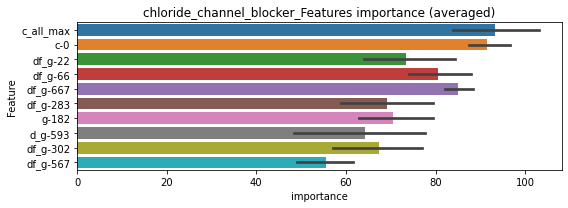

len(train_index) : 3892
len(valid_index) : 3892
================================= fold 1/2 chloride_channel_blocker=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0213568	valid_1's binary_logloss: 0.0416474
[200]	training's binary_logloss: 0.00349963	valid_1's binary_logloss: 0.021742
[300]	training's binary_logloss: 0.000995926	valid_1's binary_logloss: 0.0192741
Early stopping, best iteration is:
[320]	training's binary_logloss: 0.000834063	valid_1's binary_logloss: 0.019162


len(train_index) : 3892
len(valid_index) : 3892
================================= fold 2/2 chloride_channel_blocker=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0216563	valid_1's binary_logloss: 0.0392103
[200]	training's binary_logloss: 0.00378452	valid_1's binary_logloss: 0.018181
[300]	training's binary_logloss: 0.00107431	valid_1's binary_logloss: 0.0139729
Early stopping, best iteration is:
[346]	training's binary_logloss: 0.000725935	valid_1's binary_logloss: 0.0134071


chloride_channel_blocker logloss: 0.016284595560424085
cholesterol_inhibitor, len(trt): 48, len(othr): 3281, target_rate: 0.0020156 → Adj_target_rate: 0.0022556


neg labels: 3289 → selected neg labels: 3281


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.044739	valid_1's binary_logloss: 0.0891911
[200]	training's binary_logloss: 0.00800702	valid_1's binary_logloss: 0.0432398
[300]	training's binary_logloss: 0.00229839	valid_1's binary_logloss: 0.0321761
[400]	training's binary_logloss: 0.00108372	valid_1's binary_logloss: 0.0299609
Early stopping, best iteration is:
[396]	training's binary_logloss: 0.00111052	valid_1's binary_logloss: 0.0298941
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0451649	valid_1's binary_logloss: 0.0705109
[200]	training's binary_logloss: 0.00864207	valid_1's binary_logloss: 0.0243922
[300]	training's binary_logloss: 0.00245693	valid_1's binary_logloss: 0.0127691
[400]	training's binary_logloss: 0.00114045	valid_1's binary_logloss: 0.00966968
[500]	training's binary_logloss: 0.000724487	valid_1's binary_logloss: 0.00842849
Early stopping, best iteration is:
[514]	tr

1 / 3 AUC score:1.000
Threshold: 0.0058138, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 134 → positive_corect_labels: 655/3803
p_label_rate: 0.0349071 Vs.target_rate: 0.00202, Num_p_label: 139.0, conf_0:0.00097, conf_1:0.00640
Num_p_label: 139.0, Expected: 8.0, Adj_threshold_1: 0.0058138
Num_p_label: 47.0, Expected: 8.0, Adj_threshold_2: 0.0108138
Num_p_label: 17.0, Expected: 8.0, Adj_threshold_3: 0.0158138
Num_p_label: 7.0, Expected: 8.0, Adj_threshold_4: 0.0208138
threshold: 0.0208138, positive p_label: 7.0/3982, p_label_rate: 0.0017579
positive y_label: 655.0/3803, y_label_rate: 0.1722324
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0453102	valid_1's binary_logloss: 0.0838428
[200]	training's binary_logloss: 0.00818961	valid_1's binary_logloss: 0.0347962
[300]	training's binary_logloss: 0.00234312	valid_1's binary_logloss: 0.0236629
[400]	training's binary_logloss: 0.00109926	valid_1's binary_logloss: 0.0209729
Early stopping, best iteration is:
[488]	training's binary_logloss: 0.000728877	valid_1's binary_logloss: 0.0195571
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0457301	valid_1's binary_logloss: 0.0808924
[200]	training's binary_logloss: 0.00818882	valid_1's binary_logloss: 0.0358678
[300]	training's binary_logloss: 0.00233314	valid_1's binary_logloss: 0.0243138
[400]	training's binary_logloss: 0.00110665	valid_1's binary_logloss: 0.0212163
Early stopping, best iteration is:
[484]	training's binary_logloss: 0.000738884	valid_1's binary_logloss: 0.0199536


2 / 3 AUC score:1.000
Threshold: 0.0208138, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 9 → positive_corect_labels: 651.0/3794
p_label_rate: 0.0050226 Vs.target_rate: 0.00202, Num_p_label: 20.0, conf_0:0.00090, conf_1:0.02290
threshold: 0.0208138, positive p_label: 20.0/3982, p_label_rate: 0.0050226
positive y_label: 651.0/3794, y_label_rate: 0.1715867
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0432612	valid_1's binary_logloss: 0.0797434
[200]	training's binary_logloss: 0.00779549	valid_1's binary_logloss: 0.0313426
[300]	training's binary_logloss: 0.00222532	valid_1's binary_logloss: 0.0210884
[400]	training's binary_logloss: 0.00105855	valid_1's binary_logloss: 0.0181302
[500]	training's binary_logloss: 0.000682471	valid_1's binary_logloss: 0.0167807
Early stopping, best iteration is:
[490]	training's binary_logloss: 0.00070357	valid_1's binary_logloss: 0.0166963
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0440297	valid_1's binary_logloss: 0.0776181
[200]	training's binary_logloss: 0.00828894	valid_1's binary_logloss: 0.0334287
[300]	training's binary_logloss: 0.002372	valid_1's binary_logloss: 0.0229965
[400]	training's binary_logloss: 0.00110831	valid_1's binary_logloss: 0.0194076
Early stopping, best iteration is:
[423]	train

3 / 3 AUC score:1.000
Threshold: 0.0208138, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 12 → positive_corect_labels: 647.0/3782
p_label_rate: 0.0060271 Vs.target_rate: 0.00202, Num_p_label: 24.0, conf_0:0.00102, conf_1:0.02290
threshold: 0.0208138, positive p_label: 24.0/3982, p_label_rate: 0.0060271
positive y_label: 671.0/7764, y_label_rate: 0.0864245


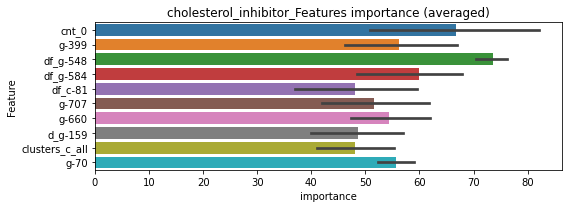

len(train_index) : 3882
len(valid_index) : 3882
================================= fold 1/2 cholesterol_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0253288	valid_1's binary_logloss: 0.055632
[200]	training's binary_logloss: 0.00472305	valid_1's binary_logloss: 0.0321753
[300]	training's binary_logloss: 0.00133547	valid_1's binary_logloss: 0.0285422
Early stopping, best iteration is:
[304]	training's binary_logloss: 0.00128191	valid_1's binary_logloss: 0.0285147


len(train_index) : 3882
len(valid_index) : 3882
================================= fold 2/2 cholesterol_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0263173	valid_1's binary_logloss: 0.0460389
[200]	training's binary_logloss: 0.00485831	valid_1's binary_logloss: 0.0204207
[300]	training's binary_logloss: 0.00139855	valid_1's binary_logloss: 0.0153832
Early stopping, best iteration is:
[379]	training's binary_logloss: 0.000735512	valid_1's binary_logloss: 0.0145265


cholesterol_inhibitor logloss: 0.021520595988515495


  acetylcholine_receptor_agonist acetylcholine_receptor_antagonist  \
0                       df_g-122                              c-30   
1                  clusters_df_c                         c_all_max   
2                          cnt_0                    clusters_g_all   
3                      c_all_min                          df_g-707   
4                        df_g-51                        clusters_g   
5                       df_c_min                          df_c_min   
6                          cnt_2                             g-514   
7                       df_g-736                          df_g-640   
8                          g-244                            df_c-6   
9                           c-73                          df_g-597   

  acetylcholinesterase_inhibitor adenosine_receptor_antagonist  \
0                      c_all_max                clusters_c_all   
1                      c_all_min                      df_c_min   
2                 clusters_g_al

cholinergic_receptor_antagonist, len(trt): 54, len(othr): 3280, target_rate: 0.0022676 → Adj_target_rate: 0.0024931


neg labels: 3289 → selected neg labels: 3280


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0491558	valid_1's binary_logloss: 0.0907539
[200]	training's binary_logloss: 0.00934767	valid_1's binary_logloss: 0.0412279
[300]	training's binary_logloss: 0.00261655	valid_1's binary_logloss: 0.0278221
[400]	training's binary_logloss: 0.00120228	valid_1's binary_logloss: 0.0236786
[500]	training's binary_logloss: 0.000765138	valid_1's binary_logloss: 0.022243
Early stopping, best iteration is:
[510]	training's binary_logloss: 0.00073752	valid_1's binary_logloss: 0.0221396
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0491906	valid_1's binary_logloss: 0.0898644
[200]	training's binary_logloss: 0.0097765	valid_1's binary_logloss: 0.0405431
[300]	training's binary_logloss: 0.00269889	valid_1's binary_logloss: 0.030733
Early stopping, best iteration is:
[348]	training's binary_logloss: 0.0017648	valid_1's binary_logloss: 0.029328


1 / 3 AUC score:0.999
Threshold: 0.0085580, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 138 → positive_corect_labels: 653/3798
p_label_rate: 0.0467102 Vs.target_rate: 0.00227, Num_p_label: 186.0, conf_0:0.00143, conf_1:0.00941
Num_p_label: 186.0, Expected: 9.0, Adj_threshold_1: 0.0085580
Num_p_label: 89.0, Expected: 9.0, Adj_threshold_2: 0.0135580
Num_p_label: 42.0, Expected: 9.0, Adj_threshold_3: 0.0185580
Num_p_label: 31.0, Expected: 9.0, Adj_threshold_4: 0.0235580
Num_p_label: 22.0, Expected: 9.0, Adj_threshold_5: 0.0285580
Num_p_label: 18.0, Expected: 9.0, Adj_threshold_6: 0.0335580
threshold: 0.0335580, positive p_label: 18.0/3982, p_label_rate: 0.0045203
positive y_label: 653.0/3798, y_label_rate: 0.1719326
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0509995	valid_1's binary_logloss: 0.0885949
[200]	training's binary_logloss: 0.00965572	valid_1's binary_logloss: 0.0376961
[300]	training's binary_logloss: 0.00271695	valid_1's binary_logloss: 0.0233761
[400]	training's binary_logloss: 0.00123252	valid_1's binary_logloss: 0.0195782
[500]	training's binary_logloss: 0.000778422	valid_1's binary_logloss: 0.0179146
Early stopping, best iteration is:
[555]	training's binary_logloss: 0.000660066	valid_1's binary_logloss: 0.0172459
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0476	valid_1's binary_logloss: 0.0854367
[200]	training's binary_logloss: 0.00909688	valid_1's binary_logloss: 0.031641
[300]	training's binary_logloss: 0.00265556	valid_1's binary_logloss: 0.0174489
[400]	training's binary_logloss: 0.00124001	valid_1's binary_logloss: 0.013573
[500]	training's binary_logloss: 0.000782268	val

2 / 3 AUC score:1.000
Threshold: 0.0335580, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 8 → positive_corect_labels: 651.0/3790
p_label_rate: 0.0102963 Vs.target_rate: 0.00227, Num_p_label: 41.0, conf_0:0.00094, conf_1:0.03691
Num_p_label: 41.0, Expected: 9.0, Adj_threshold_1: 0.0335580
Num_p_label: 34.0, Expected: 9.0, Adj_threshold_2: 0.0385580
Num_p_label: 28.0, Expected: 9.0, Adj_threshold_3: 0.0435580
Num_p_label: 22.0, Expected: 9.0, Adj_threshold_4: 0.0485580
Num_p_label: 18.0, Expected: 9.0, Adj_threshold_5: 0.0535580
threshold: 0.0535580, positive p_label: 18.0/3982, p_label_rate: 0.0045203
positive y_label: 651.0/3790, y_label_rate: 0.1717678
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0474353	valid_1's binary_logloss: 0.0824819
[200]	training's binary_logloss: 0.0089639	valid_1's binary_logloss: 0.0318251
[300]	training's binary_logloss: 0.00259598	valid_1's binary_logloss: 0.0185456
[400]	training's binary_logloss: 0.00122275	valid_1's binary_logloss: 0.0140528
[500]	training's binary_logloss: 0.000770148	valid_1's binary_logloss: 0.0121174
Early stopping, best iteration is:
[580]	training's binary_logloss: 0.000615918	valid_1's binary_logloss: 0.0112639
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0488499	valid_1's binary_logloss: 0.0838777
[200]	training's binary_logloss: 0.00953858	valid_1's binary_logloss: 0.0322671
[300]	training's binary_logloss: 0.00274348	valid_1's binary_logloss: 0.017698
[400]	training's binary_logloss: 0.00126395	valid_1's binary_logloss: 0.0136851
[500]	training's binary_logloss: 0.000797968	

3 / 3 AUC score:1.000
Threshold: 0.0535580, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → positive_corect_labels: 651.0/3790
p_label_rate: 0.0045203 Vs.target_rate: 0.00227, Num_p_label: 18.0, conf_0:0.00084, conf_1:0.05891
threshold: 0.0535580, positive p_label: 18.0/3982, p_label_rate: 0.0045203
positive y_label: 669.0/7772, y_label_rate: 0.0860782


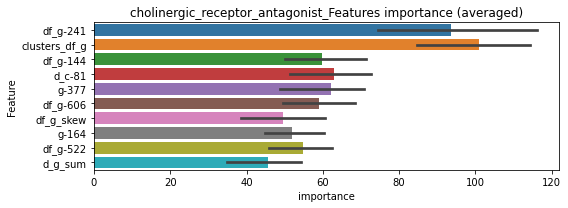

len(train_index) : 3886
len(valid_index) : 3886
================================= fold 1/2 cholinergic_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0271945	valid_1's binary_logloss: 0.0522251
[200]	training's binary_logloss: 0.00511973	valid_1's binary_logloss: 0.0261543
[300]	training's binary_logloss: 0.00144178	valid_1's binary_logloss: 0.0202856
[400]	training's binary_logloss: 0.00066517	valid_1's binary_logloss: 0.0189496
Early stopping, best iteration is:
[397]	training's binary_logloss: 0.000678394	valid_1's binary_logloss: 0.0188972


len(train_index) : 3886
len(valid_index) : 3886
================================= fold 2/2 cholinergic_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0280157	valid_1's binary_logloss: 0.0499771
[200]	training's binary_logloss: 0.00557205	valid_1's binary_logloss: 0.0211844
[300]	training's binary_logloss: 0.00159162	valid_1's binary_logloss: 0.0137126
[400]	training's binary_logloss: 0.00072417	valid_1's binary_logloss: 0.0114863
[500]	training's binary_logloss: 0.000445574	valid_1's binary_logloss: 0.0106323
Early stopping, best iteration is:
[520]	training's binary_logloss: 0.000413369	valid_1's binary_logloss: 0.0104718


cholinergic_receptor_antagonist logloss: 0.014684497173192078
coagulation_factor_inhibitor, len(trt): 24, len(othr): 3285, target_rate: 0.0010078 → Adj_target_rate: 0.0012513


neg labels: 3289 → selected neg labels: 3285


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0315475	valid_1's binary_logloss: 0.0449909
[200]	training's binary_logloss: 0.00434539	valid_1's binary_logloss: 0.0106006
[300]	training's binary_logloss: 0.00116444	valid_1's binary_logloss: 0.00447229
[400]	training's binary_logloss: 0.000571037	valid_1's binary_logloss: 0.00309663
[500]	training's binary_logloss: 0.000411353	valid_1's binary_logloss: 0.00261314
Early stopping, best iteration is:
[496]	training's binary_logloss: 0.00041429	valid_1's binary_logloss: 0.00261113
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0330881	valid_1's binary_logloss: 0.0453811
[200]	training's binary_logloss: 0.00452262	valid_1's binary_logloss: 0.00888927
[300]	training's binary_logloss: 0.00122546	valid_1's binary_logloss: 0.003117
[400]	training's binary_logloss: 0.000592583	valid_1's binary_logloss: 0.00177929
[500]	training's binary_logloss: 0.00

1 / 3 AUC score:1.000
Threshold: 0.0021657, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → positive_corect_labels: 657/3810
p_label_rate: 0.0406831 Vs.target_rate: 0.00101, Num_p_label: 162.0, conf_0:0.00030, conf_1:0.00238
Num_p_label: 162.0, Expected: 4.0, Adj_threshold_1: 0.0021657
Num_p_label: 27.0, Expected: 4.0, Adj_threshold_2: 0.0071657
Num_p_label: 7.0, Expected: 4.0, Adj_threshold_3: 0.0121657
threshold: 0.0121657, positive p_label: 7.0/3982, p_label_rate: 0.0017579
positive y_label: 657.0/3810, y_label_rate: 0.1724409
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0306159	valid_1's binary_logloss: 0.0431508
[200]	training's binary_logloss: 0.00405008	valid_1's binary_logloss: 0.00909679
[300]	training's binary_logloss: 0.0011228	valid_1's binary_logloss: 0.00370916
[400]	training's binary_logloss: 0.000568998	valid_1's binary_logloss: 0.00238033
[500]	training's binary_logloss: 0.000414262	valid_1's binary_logloss: 0.0019508
Early stopping, best iteration is:
[492]	training's binary_logloss: 0.000420047	valid_1's binary_logloss: 0.00194884
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0318843	valid_1's binary_logloss: 0.0427982
[200]	training's binary_logloss: 0.00427464	valid_1's binary_logloss: 0.00780727
[300]	training's binary_logloss: 0.00117269	valid_1's binary_logloss: 0.00265542
[400]	training's binary_logloss: 0.000579764	valid_1's binary_logloss: 0.00154551
[500]	training's binary_logloss: 0.

2 / 3 AUC score:1.000
Threshold: 0.0121657, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → positive_corect_labels: 657.0/3810
p_label_rate: 0.0077850 Vs.target_rate: 0.00101, Num_p_label: 31.0, conf_0:0.00033, conf_1:0.01338
Num_p_label: 31.0, Expected: 4.0, Adj_threshold_1: 0.0121657
Num_p_label: 20.0, Expected: 4.0, Adj_threshold_2: 0.0171657
Num_p_label: 11.0, Expected: 4.0, Adj_threshold_3: 0.0221657
Num_p_label: 7.0, Expected: 4.0, Adj_threshold_4: 0.0271657
threshold: 0.0271657, positive p_label: 7.0/3982, p_label_rate: 0.0017579
positive y_label: 657.0/3810, y_label_rate: 0.1724409
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0306159	valid_1's binary_logloss: 0.0431508
[200]	training's binary_logloss: 0.00405008	valid_1's binary_logloss: 0.00909679
[300]	training's binary_logloss: 0.0011228	valid_1's binary_logloss: 0.00370916
[400]	training's binary_logloss: 0.000568998	valid_1's binary_logloss: 0.00238033
[500]	training's binary_logloss: 0.000414262	valid_1's binary_logloss: 0.0019508
Early stopping, best iteration is:
[492]	training's binary_logloss: 0.000420047	valid_1's binary_logloss: 0.00194884
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0318843	valid_1's binary_logloss: 0.0427982
[200]	training's binary_logloss: 0.00427464	valid_1's binary_logloss: 0.00780727
[300]	training's binary_logloss: 0.00117269	valid_1's binary_logloss: 0.00265542
[400]	training's binary_logloss: 0.000579764	valid_1's binary_logloss: 0.00154551
[500]	training's binary_logloss: 0.

3 / 3 AUC score:1.000
Threshold: 0.0271657, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → positive_corect_labels: 657.0/3810
p_label_rate: 0.0017579 Vs.target_rate: 0.00101, Num_p_label: 7.0, conf_0:0.00033, conf_1:0.02988
threshold: 0.0271657, positive p_label: 7.0/3982, p_label_rate: 0.0017579
positive y_label: 664.0/7792, y_label_rate: 0.0852156


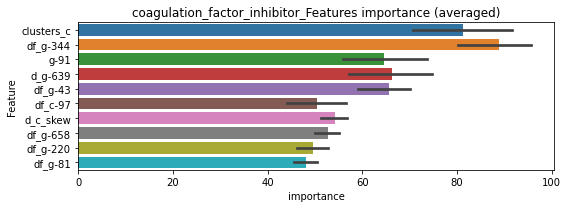

len(train_index) : 3896
len(valid_index) : 3896
================================= fold 1/2 coagulation_factor_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0176812	valid_1's binary_logloss: 0.0278252
[200]	training's binary_logloss: 0.00237862	valid_1's binary_logloss: 0.0104424
[300]	training's binary_logloss: 0.000623214	valid_1's binary_logloss: 0.00829352
Early stopping, best iteration is:
[321]	training's binary_logloss: 0.000515239	valid_1's binary_logloss: 0.00814891


len(train_index) : 3896
len(valid_index) : 3896
================================= fold 2/2 coagulation_factor_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0179105	valid_1's binary_logloss: 0.0244082
[200]	training's binary_logloss: 0.00246507	valid_1's binary_logloss: 0.00614423
[300]	training's binary_logloss: 0.000656351	valid_1's binary_logloss: 0.00349306
Early stopping, best iteration is:
[381]	training's binary_logloss: 0.000350794	valid_1's binary_logloss: 0.00308088


coagulation_factor_inhibitor logloss: 0.00561489695775424
corticosteroid_agonist, len(trt): 36, len(othr): 3284, target_rate: 0.0015117 → Adj_target_rate: 0.0017663


neg labels: 3289 → selected neg labels: 3284


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0262976	valid_1's binary_logloss: 0.0430211
[200]	training's binary_logloss: 0.00346951	valid_1's binary_logloss: 0.0172387
[300]	training's binary_logloss: 0.00100902	valid_1's binary_logloss: 0.0129404
Early stopping, best iteration is:
[380]	training's binary_logloss: 0.000577557	valid_1's binary_logloss: 0.0117206
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0271894	valid_1's binary_logloss: 0.0446292
[200]	training's binary_logloss: 0.00363532	valid_1's binary_logloss: 0.0163865
[300]	training's binary_logloss: 0.00104418	valid_1's binary_logloss: 0.0119108
[400]	training's binary_logloss: 0.00053828	valid_1's binary_logloss: 0.0106347
Early stopping, best iteration is:
[452]	training's binary_logloss: 0.000435913	valid_1's binary_logloss: 0.0102712


1 / 3 AUC score:1.000
Threshold: 0.0023963, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → positive_corect_labels: 656/3808
p_label_rate: 0.0404319 Vs.target_rate: 0.00151, Num_p_label: 161.0, conf_0:0.00027, conf_1:0.00264
Num_p_label: 161.0, Expected: 6.0, Adj_threshold_1: 0.0023963
Num_p_label: 74.0, Expected: 6.0, Adj_threshold_2: 0.0073963
Num_p_label: 54.0, Expected: 6.0, Adj_threshold_3: 0.0123963
Num_p_label: 46.0, Expected: 6.0, Adj_threshold_4: 0.0173963
Num_p_label: 41.0, Expected: 6.0, Adj_threshold_5: 0.0223963
Num_p_label: 39.0, Expected: 6.0, Adj_threshold_6: 0.0273963
Num_p_label: 36.0, Expected: 6.0, Adj_threshold_7: 0.0323963
Num_p_label: 34.0, Expected: 6.0, Adj_threshold_8: 0.0373963
Num_p_label: 32.0, Expected: 6.0, Adj_threshold_9: 0.0423963
Num_p_label: 31.0, Expected: 6.0, Adj_threshold_10: 0.0473963
threshold: 0.0523963, positive p_label: 31.0/3982, p_label_rate: 0.0077850
positive y_label: 656.0/3808, y_label_rate: 0.1722689
================= Pseudo label

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0245786	valid_1's binary_logloss: 0.0348737
[200]	training's binary_logloss: 0.00300344	valid_1's binary_logloss: 0.00851812
[300]	training's binary_logloss: 0.000845106	valid_1's binary_logloss: 0.00473344
Early stopping, best iteration is:
[315]	training's binary_logloss: 0.000741997	valid_1's binary_logloss: 0.00458315
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.024819	valid_1's binary_logloss: 0.0367965
[200]	training's binary_logloss: 0.00301553	valid_1's binary_logloss: 0.0103452
[300]	training's binary_logloss: 0.000845374	valid_1's binary_logloss: 0.00716799
Early stopping, best iteration is:
[345]	training's binary_logloss: 0.00059978	valid_1's binary_logloss: 0.00642597


2 / 3 AUC score:1.000
Threshold: 0.0523963, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 4 → positive_corect_labels: 653.0/3804
p_label_rate: 0.0140633 Vs.target_rate: 0.00151, Num_p_label: 56.0, conf_0:0.00049, conf_1:0.05764
Num_p_label: 56.0, Expected: 6.0, Adj_threshold_1: 0.0523963
Num_p_label: 55.0, Expected: 6.0, Adj_threshold_2: 0.0573963
Num_p_label: 54.0, Expected: 6.0, Adj_threshold_3: 0.0623963
Num_p_label: 51.0, Expected: 6.0, Adj_threshold_4: 0.0673963
Num_p_label: 48.0, Expected: 6.0, Adj_threshold_5: 0.0723963
Num_p_label: 47.0, Expected: 6.0, Adj_threshold_6: 0.0773963
Num_p_label: 46.0, Expected: 6.0, Adj_threshold_7: 0.0823963
Num_p_label: 46.0, Expected: 6.0, Adj_threshold_8: 0.0873963
Num_p_label: 45.0, Expected: 6.0, Adj_threshold_9: 0.0923963
Num_p_label: 44.0, Expected: 6.0, Adj_threshold_10: 0.0973963
threshold: 0.1023963, positive p_label: 43.0/3982, p_label_rate: 0.0107986
positive y_label: 653.0/3804, y_label_rate: 0.1716614
================= Pseudo labelin

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0240892	valid_1's binary_logloss: 0.0327094
[200]	training's binary_logloss: 0.00289537	valid_1's binary_logloss: 0.00607744
[300]	training's binary_logloss: 0.000826767	valid_1's binary_logloss: 0.00250772
[400]	training's binary_logloss: 0.000436262	valid_1's binary_logloss: 0.00161864
[500]	training's binary_logloss: 0.000333399	valid_1's binary_logloss: 0.00135216
Early stopping, best iteration is:
[513]	training's binary_logloss: 0.000330499	valid_1's binary_logloss: 0.0013473
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0247757	valid_1's binary_logloss: 0.0369082
[200]	training's binary_logloss: 0.00298673	valid_1's binary_logloss: 0.00798679
[300]	training's binary_logloss: 0.000832768	valid_1's binary_logloss: 0.00402025
[400]	training's binary_logloss: 0.000439211	valid_1's binary_logloss: 0.00312829
Early stopping, best iteration i

3 / 3 AUC score:1.000
Threshold: 0.1023963, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 1 → positive_corect_labels: 652.0/3803
p_label_rate: 0.0102963 Vs.target_rate: 0.00151, Num_p_label: 41.0, conf_0:0.00024, conf_1:0.11264
Num_p_label: 41.0, Expected: 6.0, Adj_threshold_1: 0.1023963
Num_p_label: 41.0, Expected: 6.0, Adj_threshold_2: 0.1073963
Num_p_label: 41.0, Expected: 6.0, Adj_threshold_3: 0.1123963
Num_p_label: 41.0, Expected: 6.0, Adj_threshold_4: 0.1173963
Num_p_label: 40.0, Expected: 6.0, Adj_threshold_5: 0.1223963
Num_p_label: 40.0, Expected: 6.0, Adj_threshold_6: 0.1273963
Num_p_label: 40.0, Expected: 6.0, Adj_threshold_7: 0.1323963
Num_p_label: 40.0, Expected: 6.0, Adj_threshold_8: 0.1373963
Num_p_label: 40.0, Expected: 6.0, Adj_threshold_9: 0.1423963
Num_p_label: 40.0, Expected: 6.0, Adj_threshold_10: 0.1473963
threshold: 0.1523963, positive p_label: 39.0/3982, p_label_rate: 0.0097941
positive y_label: 691.0/7785, y_label_rate: 0.0887604


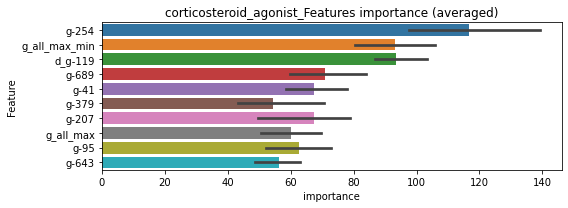

len(train_index) : 3892
len(valid_index) : 3893
================================= fold 1/2 corticosteroid_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0130452	valid_1's binary_logloss: 0.0289386
[200]	training's binary_logloss: 0.00153957	valid_1's binary_logloss: 0.013027
[300]	training's binary_logloss: 0.000438374	valid_1's binary_logloss: 0.0108564
Early stopping, best iteration is:
[311]	training's binary_logloss: 0.000400387	valid_1's binary_logloss: 0.0107116


len(train_index) : 3893
len(valid_index) : 3892
================================= fold 2/2 corticosteroid_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0133549	valid_1's binary_logloss: 0.0202654
[200]	training's binary_logloss: 0.00163076	valid_1's binary_logloss: 0.00589397
[300]	training's binary_logloss: 0.000460639	valid_1's binary_logloss: 0.00376958
[400]	training's binary_logloss: 0.000242255	valid_1's binary_logloss: 0.00314565
[500]	training's binary_logloss: 0.00018059	valid_1's binary_logloss: 0.00291662
Early stopping, best iteration is:
[493]	training's binary_logloss: 0.000182338	valid_1's binary_logloss: 0.0029023


corticosteroid_agonist logloss: 0.006809109434557768
cyclooxygenase_inhibitor, len(trt): 435, len(othr): 3215, target_rate: 0.0182666 → Adj_target_rate: 0.0146863


neg labels: 3289 → selected neg labels: 3215


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.133091	valid_1's binary_logloss: 0.384654
Early stopping, best iteration is:
[132]	training's binary_logloss: 0.0973551	valid_1's binary_logloss: 0.380885
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.143891	valid_1's binary_logloss: 0.380043


1 / 3 AUC score:0.761
Threshold: 0.1580070, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 771 → positive_corect_labels: 322/3087
p_label_rate: 0.0921647 Vs.target_rate: 0.01827, Num_p_label: 367.0, conf_0:0.10346, conf_1:0.17381
Num_p_label: 367.0, Expected: 72.7, Adj_threshold_1: 0.1580070
Num_p_label: 316.0, Expected: 72.7, Adj_threshold_2: 0.1630070


Early stopping, best iteration is:
[127]	training's binary_logloss: 0.113179	valid_1's binary_logloss: 0.374684


Num_p_label: 271.0, Expected: 72.7, Adj_threshold_3: 0.1680070
Num_p_label: 230.0, Expected: 72.7, Adj_threshold_4: 0.1730070
Num_p_label: 194.0, Expected: 72.7, Adj_threshold_5: 0.1780070
Num_p_label: 157.0, Expected: 72.7, Adj_threshold_6: 0.1830070
Num_p_label: 141.0, Expected: 72.7, Adj_threshold_7: 0.1880070
threshold: 0.1880070, positive p_label: 141.0/3982, p_label_rate: 0.0354093
positive y_label: 322.0/3087, y_label_rate: 0.1043084
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.066554	valid_1's binary_logloss: 0.226692
Early stopping, best iteration is:
[155]	training's binary_logloss: 0.0328929	valid_1's binary_logloss: 0.214209
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0632218	valid_1's binary_logloss: 0.23027


2 / 3 AUC score:0.915
Threshold: 0.1880070, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 187 → positive_corect_labels: 143.0/2900
p_label_rate: 0.0042692 Vs.target_rate: 0.01827, Num_p_label: 17.0, conf_0:0.03087, conf_1:0.20681
Num_p_label: 17.0, Expected: 72.7, Adj_threshold_1: 0.1880070


Early stopping, best iteration is:
[169]	training's binary_logloss: 0.0262957	valid_1's binary_logloss: 0.219489


Num_p_label: 19.0, Expected: 72.7, Adj_threshold_2: 0.1830070
Num_p_label: 21.0, Expected: 72.7, Adj_threshold_3: 0.1780070
Num_p_label: 22.0, Expected: 72.7, Adj_threshold_4: 0.1730070
Num_p_label: 22.0, Expected: 72.7, Adj_threshold_5: 0.1680070
Num_p_label: 26.0, Expected: 72.7, Adj_threshold_6: 0.1630070
Num_p_label: 27.0, Expected: 72.7, Adj_threshold_7: 0.1580070
Num_p_label: 30.0, Expected: 72.7, Adj_threshold_8: 0.1530070
Num_p_label: 32.0, Expected: 72.7, Adj_threshold_9: 0.1480070
Num_p_label: 43.0, Expected: 72.7, Adj_threshold_10: 0.1430070
threshold: 0.1430070, positive p_label: 43.0/3982, p_label_rate: 0.0107986
positive y_label: 143.0/2900, y_label_rate: 0.0493103
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[88]	training's binary_logloss: 0.0249825	valid_1's binary_logloss: 0.14149
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.021536	valid_1's binary_logloss: 0.132254


3 / 3 AUC score:0.919
Threshold: 0.1430070, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 88 → positive_corect_labels: 56.0/2812
p_label_rate: 0.0002511 Vs.target_rate: 0.01827, Num_p_label: 1.0, conf_0:0.01166, conf_1:0.15731
Num_p_label: 1.0, Expected: 72.7, Adj_threshold_1: 0.1430070
Num_p_label: 1.0, Expected: 72.7, Adj_threshold_2: 0.1380070
Num_p_label: 1.0, Expected: 72.7, Adj_threshold_3: 0.1330070
Num_p_label: 1.0, Expected: 72.7, Adj_threshold_4: 0.1280070


Early stopping, best iteration is:
[148]	training's binary_logloss: 0.00994379	valid_1's binary_logloss: 0.129545


Num_p_label: 1.0, Expected: 72.7, Adj_threshold_5: 0.1230070
Num_p_label: 1.0, Expected: 72.7, Adj_threshold_6: 0.1180070
Num_p_label: 1.0, Expected: 72.7, Adj_threshold_7: 0.1130070
Num_p_label: 1.0, Expected: 72.7, Adj_threshold_8: 0.1080070
Num_p_label: 1.0, Expected: 72.7, Adj_threshold_9: 0.1030070
Num_p_label: 1.0, Expected: 72.7, Adj_threshold_10: 0.0980070
threshold: 0.0930070, positive p_label: 2.0/3982, p_label_rate: 0.0005023
positive y_label: 58.0/6794, y_label_rate: 0.0085369


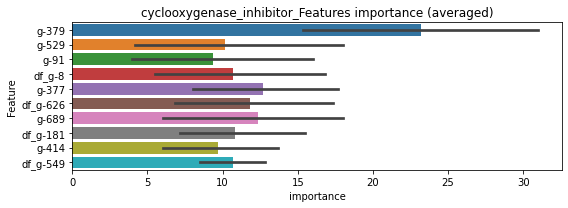

len(train_index) : 3397
len(valid_index) : 3397
================================= fold 1/2 cyclooxygenase_inhibitor=================================


Training until validation scores don't improve for 10 rounds


len(train_index) : 3397
len(valid_index) : 3397
================================= fold 2/2 cyclooxygenase_inhibitor=================================


Early stopping, best iteration is:
[51]	training's binary_logloss: 0.00865727	valid_1's binary_logloss: 0.0403083
Training until validation scores don't improve for 10 rounds


cyclooxygenase_inhibitor logloss: 0.04148022320971361


Early stopping, best iteration is:
[45]	training's binary_logloss: 0.00830562	valid_1's binary_logloss: 0.0426521
  acetylcholine_receptor_agonist acetylcholine_receptor_antagonist  \
0                       df_g-122                              c-30   
1                  clusters_df_c                         c_all_max   
2                          cnt_0                    clusters_g_all   
3                      c_all_min                          df_g-707   
4                        df_g-51                        clusters_g   
5                       df_c_min                          df_c_min   
6                          cnt_2                             g-514   
7                       df_g-736                          df_g-640   
8                          g-244                            df_c-6   
9                           c-73                          df_g-597   

  acetylcholinesterase_inhibitor adenosine_receptor_antagonist  \
0                      c_all_max                c

cytochrome_p450_inhibitor, len(trt): 104, len(othr): 3274, target_rate: 0.0043672 → Adj_target_rate: 0.0043519


neg labels: 3289 → selected neg labels: 3274


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0595867	valid_1's binary_logloss: 0.14303
[200]	training's binary_logloss: 0.0149519	valid_1's binary_logloss: 0.0973506
[300]	training's binary_logloss: 0.00482249	valid_1's binary_logloss: 0.0861359
Early stopping, best iteration is:
[327]	training's binary_logloss: 0.00373537	valid_1's binary_logloss: 0.0850198
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0637886	valid_1's binary_logloss: 0.130586
[200]	training's binary_logloss: 0.0162562	valid_1's binary_logloss: 0.0812769
[300]	training's binary_logloss: 0.00518879	valid_1's binary_logloss: 0.0680721
Early stopping, best iteration is:
[343]	training's binary_logloss: 0.00351054	valid_1's binary_logloss: 0.0654014


1 / 3 AUC score:0.990
Threshold: 0.0231244, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 174 → positive_corect_labels: 633/3754
p_label_rate: 0.0313913 Vs.target_rate: 0.00437, Num_p_label: 125.0, conf_0:0.00469, conf_1:0.02544
Num_p_label: 125.0, Expected: 17.4, Adj_threshold_1: 0.0231244
Num_p_label: 92.0, Expected: 17.4, Adj_threshold_2: 0.0281244
Num_p_label: 59.0, Expected: 17.4, Adj_threshold_3: 0.0331244
Num_p_label: 45.0, Expected: 17.4, Adj_threshold_4: 0.0381244
Num_p_label: 36.0, Expected: 17.4, Adj_threshold_5: 0.0431244
Num_p_label: 24.0, Expected: 17.4, Adj_threshold_6: 0.0481244
threshold: 0.0481244, positive p_label: 24.0/3982, p_label_rate: 0.0060271
positive y_label: 633.0/3754, y_label_rate: 0.1686201
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0549116	valid_1's binary_logloss: 0.124951
[200]	training's binary_logloss: 0.0127956	valid_1's binary_logloss: 0.0794508
[300]	training's binary_logloss: 0.00406014	valid_1's binary_logloss: 0.065698
[400]	training's binary_logloss: 0.00191051	valid_1's binary_logloss: 0.0608421
Early stopping, best iteration is:
[397]	training's binary_logloss: 0.00194804	valid_1's binary_logloss: 0.0606079
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0596699	valid_1's binary_logloss: 0.12303
[200]	training's binary_logloss: 0.0141461	valid_1's binary_logloss: 0.0770821
[300]	training's binary_logloss: 0.00441803	valid_1's binary_logloss: 0.0644196
Early stopping, best iteration is:
[389]	training's binary_logloss: 0.002128	valid_1's binary_logloss: 0.0613961


2 / 3 AUC score:0.998
Threshold: 0.0481244, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 30 → positive_corect_labels: 615.0/3724
p_label_rate: 0.0070316 Vs.target_rate: 0.00437, Num_p_label: 28.0, conf_0:0.00289, conf_1:0.05294
threshold: 0.0481244, positive p_label: 28.0/3982, p_label_rate: 0.0070316
positive y_label: 615.0/3724, y_label_rate: 0.1651450
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0493206	valid_1's binary_logloss: 0.11084
[200]	training's binary_logloss: 0.0113289	valid_1's binary_logloss: 0.0628539
[300]	training's binary_logloss: 0.00364892	valid_1's binary_logloss: 0.0505625
Early stopping, best iteration is:
[382]	training's binary_logloss: 0.0019324	valid_1's binary_logloss: 0.0466121
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0539462	valid_1's binary_logloss: 0.109789
[200]	training's binary_logloss: 0.0121133	valid_1's binary_logloss: 0.0638612
[300]	training's binary_logloss: 0.00388991	valid_1's binary_logloss: 0.0527253
Early stopping, best iteration is:
[341]	training's binary_logloss: 0.00269274	valid_1's binary_logloss: 0.0505383


3 / 3 AUC score:1.000
Threshold: 0.0481244, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 15 → positive_corect_labels: 607.0/3709
p_label_rate: 0.0072828 Vs.target_rate: 0.00437, Num_p_label: 29.0, conf_0:0.00299, conf_1:0.05294
threshold: 0.0481244, positive p_label: 29.0/3982, p_label_rate: 0.0072828
positive y_label: 636.0/7691, y_label_rate: 0.0826941


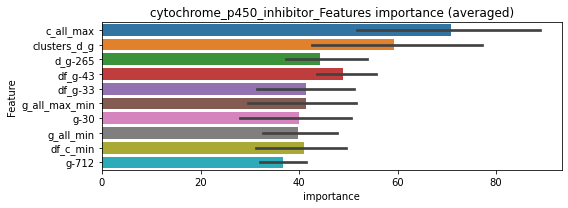

len(train_index) : 3845
len(valid_index) : 3846
================================= fold 1/2 cytochrome_p450_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0307148	valid_1's binary_logloss: 0.070924
[200]	training's binary_logloss: 0.00686821	valid_1's binary_logloss: 0.0485278
Early stopping, best iteration is:
[267]	training's binary_logloss: 0.00298926	valid_1's binary_logloss: 0.0451405


len(train_index) : 3846
len(valid_index) : 3845
================================= fold 2/2 cytochrome_p450_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0314867	valid_1's binary_logloss: 0.0747367
[200]	training's binary_logloss: 0.00723954	valid_1's binary_logloss: 0.0499207
[300]	training's binary_logloss: 0.00225394	valid_1's binary_logloss: 0.0438946
Early stopping, best iteration is:
[307]	training's binary_logloss: 0.00210722	valid_1's binary_logloss: 0.0436903


cytochrome_p450_inhibitor logloss: 0.04441549140687359


  acetylcholine_receptor_agonist acetylcholine_receptor_antagonist  \
0                       df_g-122                              c-30   
1                  clusters_df_c                         c_all_max   
2                          cnt_0                    clusters_g_all   
3                      c_all_min                          df_g-707   
4                        df_g-51                        clusters_g   
5                       df_c_min                          df_c_min   
6                          cnt_2                             g-514   
7                       df_g-736                          df_g-640   
8                          g-244                            df_c-6   
9                           c-73                          df_g-597   

  acetylcholinesterase_inhibitor adenosine_receptor_antagonist  \
0                      c_all_max                clusters_c_all   
1                      c_all_min                      df_c_min   
2                 clusters_g_al

dihydrofolate_reductase_inhibitor, len(trt): 36, len(othr): 3283, target_rate: 0.0015117 → Adj_target_rate: 0.0017663


neg labels: 3289 → selected neg labels: 3283


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0294893	valid_1's binary_logloss: 0.042136
[200]	training's binary_logloss: 0.00420494	valid_1's binary_logloss: 0.0101075
[300]	training's binary_logloss: 0.0012168	valid_1's binary_logloss: 0.0048206
[400]	training's binary_logloss: 0.000615181	valid_1's binary_logloss: 0.00352647
[500]	training's binary_logloss: 0.000430101	valid_1's binary_logloss: 0.00300606
Early stopping, best iteration is:
[513]	training's binary_logloss: 0.000421119	valid_1's binary_logloss: 0.00297621
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0299967	valid_1's binary_logloss: 0.0442869
[200]	training's binary_logloss: 0.00432358	valid_1's binary_logloss: 0.0110256
[300]	training's binary_logloss: 0.0012616	valid_1's binary_logloss: 0.00635144
Early stopping, best iteration is:
[385]	training's binary_logloss: 0.000681584	valid_1's binary_logloss: 0.00540186


1 / 3 AUC score:1.000
Threshold: 0.0028123, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → positive_corect_labels: 656/3807
p_label_rate: 0.0334003 Vs.target_rate: 0.00151, Num_p_label: 133.0, conf_0:0.00042, conf_1:0.00309
Num_p_label: 133.0, Expected: 6.0, Adj_threshold_1: 0.0028123
Num_p_label: 30.0, Expected: 6.0, Adj_threshold_2: 0.0078123
Num_p_label: 23.0, Expected: 6.0, Adj_threshold_3: 0.0128123
Num_p_label: 18.0, Expected: 6.0, Adj_threshold_4: 0.0178123
Num_p_label: 14.0, Expected: 6.0, Adj_threshold_5: 0.0228123
Num_p_label: 12.0, Expected: 6.0, Adj_threshold_6: 0.0278123
threshold: 0.0278123, positive p_label: 12.0/3982, p_label_rate: 0.0030136
positive y_label: 656.0/3807, y_label_rate: 0.1723142
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0290351	valid_1's binary_logloss: 0.0406115
[200]	training's binary_logloss: 0.00399546	valid_1's binary_logloss: 0.00871358
[300]	training's binary_logloss: 0.00116985	valid_1's binary_logloss: 0.00358403
[400]	training's binary_logloss: 0.000592534	valid_1's binary_logloss: 0.00235911
[500]	training's binary_logloss: 0.000420059	valid_1's binary_logloss: 0.00192298
Early stopping, best iteration is:
[541]	training's binary_logloss: 0.000400757	valid_1's binary_logloss: 0.00189194
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0296561	valid_1's binary_logloss: 0.0441027
[200]	training's binary_logloss: 0.0040035	valid_1's binary_logloss: 0.0105912
[300]	training's binary_logloss: 0.00116699	valid_1's binary_logloss: 0.00564544
[400]	training's binary_logloss: 0.000592937	valid_1's binary_logloss: 0.00478661
Early stopping, best iteration is:


2 / 3 AUC score:1.000
Threshold: 0.0278123, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 1 → positive_corect_labels: 655.0/3806
p_label_rate: 0.0055249 Vs.target_rate: 0.00151, Num_p_label: 22.0, conf_0:0.00041, conf_1:0.03059
Num_p_label: 22.0, Expected: 6.0, Adj_threshold_1: 0.0278123
Num_p_label: 21.0, Expected: 6.0, Adj_threshold_2: 0.0328123
Num_p_label: 20.0, Expected: 6.0, Adj_threshold_3: 0.0378123
Num_p_label: 20.0, Expected: 6.0, Adj_threshold_4: 0.0428123
Num_p_label: 20.0, Expected: 6.0, Adj_threshold_5: 0.0478123
Num_p_label: 19.0, Expected: 6.0, Adj_threshold_6: 0.0528123
Num_p_label: 18.0, Expected: 6.0, Adj_threshold_7: 0.0578123
Num_p_label: 18.0, Expected: 6.0, Adj_threshold_8: 0.0628123
Num_p_label: 18.0, Expected: 6.0, Adj_threshold_9: 0.0678123
Num_p_label: 18.0, Expected: 6.0, Adj_threshold_10: 0.0728123
threshold: 0.0778123, positive p_label: 17.0/3982, p_label_rate: 0.0042692
positive y_label: 655.0/3806, y_label_rate: 0.1720967
================= Pseudo labelin

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0289785	valid_1's binary_logloss: 0.0434494
[200]	training's binary_logloss: 0.00391614	valid_1's binary_logloss: 0.0104018
[300]	training's binary_logloss: 0.00114438	valid_1's binary_logloss: 0.00474313
[400]	training's binary_logloss: 0.000574738	valid_1's binary_logloss: 0.00332232
[500]	training's binary_logloss: 0.000411664	valid_1's binary_logloss: 0.00281793
Early stopping, best iteration is:
[539]	training's binary_logloss: 0.000397296	valid_1's binary_logloss: 0.00279202
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0294212	valid_1's binary_logloss: 0.0419505
[200]	training's binary_logloss: 0.00403086	valid_1's binary_logloss: 0.00962721
[300]	training's binary_logloss: 0.00115517	valid_1's binary_logloss: 0.00433189
[400]	training's binary_logloss: 0.000592855	valid_1's binary_logloss: 0.00302435
[500]	training's binary_logloss: 0

3 / 3 AUC score:1.000
Threshold: 0.0778123, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → positive_corect_labels: 655.0/3806
p_label_rate: 0.0037670 Vs.target_rate: 0.00151, Num_p_label: 15.0, conf_0:0.00036, conf_1:0.08559
threshold: 0.0778123, positive p_label: 15.0/3982, p_label_rate: 0.0037670
positive y_label: 670.0/7788, y_label_rate: 0.0860298


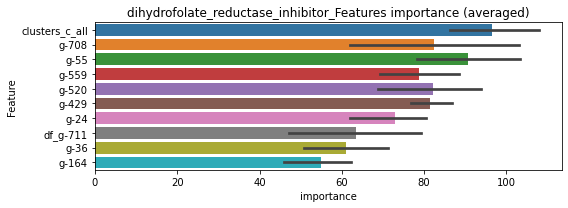

len(train_index) : 3894
len(valid_index) : 3894
================================= fold 1/2 dihydrofolate_reductase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.016106	valid_1's binary_logloss: 0.0286836
[200]	training's binary_logloss: 0.00300304	valid_1's binary_logloss: 0.0117089
[300]	training's binary_logloss: 0.00162255	valid_1's binary_logloss: 0.00852444
[400]	training's binary_logloss: 0.00138601	valid_1's binary_logloss: 0.00792663
Early stopping, best iteration is:
[396]	training's binary_logloss: 0.00138921	valid_1's binary_logloss: 0.00791233


len(train_index) : 3894
len(valid_index) : 3894
================================= fold 2/2 dihydrofolate_reductase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0154156	valid_1's binary_logloss: 0.0291227
[200]	training's binary_logloss: 0.00203189	valid_1's binary_logloss: 0.0116212
[300]	training's binary_logloss: 0.000590875	valid_1's binary_logloss: 0.00845447
Early stopping, best iteration is:
[375]	training's binary_logloss: 0.00034359	valid_1's binary_logloss: 0.00747171


dihydrofolate_reductase_inhibitor logloss: 0.007692016048528191
dipeptidyl_peptidase_inhibitor, len(trt): 25, len(othr): 3285, target_rate: 0.0010498 → Adj_target_rate: 0.0012955


neg labels: 3289 → selected neg labels: 3285


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0307065	valid_1's binary_logloss: 0.0459415
[200]	training's binary_logloss: 0.00413789	valid_1's binary_logloss: 0.012034
[300]	training's binary_logloss: 0.00113387	valid_1's binary_logloss: 0.00564877
[400]	training's binary_logloss: 0.000563604	valid_1's binary_logloss: 0.00399392
[500]	training's binary_logloss: 0.000400351	valid_1's binary_logloss: 0.00337306
Early stopping, best iteration is:
[511]	training's binary_logloss: 0.000394385	valid_1's binary_logloss: 0.00336239
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0305486	valid_1's binary_logloss: 0.0389266
[200]	training's binary_logloss: 0.00413168	valid_1's binary_logloss: 0.00729167
[300]	training's binary_logloss: 0.00114641	valid_1's binary_logloss: 0.00260709
[400]	training's binary_logloss: 0.000573174	valid_1's binary_logloss: 0.0014973
[500]	training's binary_logloss: 0.0

1 / 3 AUC score:1.000
Threshold: 0.0022134, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → positive_corect_labels: 657/3810
p_label_rate: 0.0409342 Vs.target_rate: 0.00105, Num_p_label: 163.0, conf_0:0.00028, conf_1:0.00243
Num_p_label: 163.0, Expected: 4.2, Adj_threshold_1: 0.0022134
Num_p_label: 29.0, Expected: 4.2, Adj_threshold_2: 0.0072134
Num_p_label: 14.0, Expected: 4.2, Adj_threshold_3: 0.0122134
Num_p_label: 10.0, Expected: 4.2, Adj_threshold_4: 0.0172134
Num_p_label: 5.0, Expected: 4.2, Adj_threshold_5: 0.0222134
threshold: 0.0222134, positive p_label: 5.0/3982, p_label_rate: 0.0012557
positive y_label: 657.0/3810, y_label_rate: 0.1724409
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0291339	valid_1's binary_logloss: 0.0454007
[200]	training's binary_logloss: 0.0037656	valid_1's binary_logloss: 0.0122963
[300]	training's binary_logloss: 0.00105778	valid_1's binary_logloss: 0.00623828
[400]	training's binary_logloss: 0.00053512	valid_1's binary_logloss: 0.00469519
Early stopping, best iteration is:
[475]	training's binary_logloss: 0.000411315	valid_1's binary_logloss: 0.00418324
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0298225	valid_1's binary_logloss: 0.0372022
[200]	training's binary_logloss: 0.00398944	valid_1's binary_logloss: 0.00714661
[300]	training's binary_logloss: 0.00112629	valid_1's binary_logloss: 0.00248726
[400]	training's binary_logloss: 0.000571128	valid_1's binary_logloss: 0.00138523
[500]	training's binary_logloss: 0.000408543	valid_1's binary_logloss: 0.00107533
Early stopping, best iteration is:
[

2 / 3 AUC score:1.000
Threshold: 0.0222134, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 1 → positive_corect_labels: 657.0/3809
p_label_rate: 0.0047715 Vs.target_rate: 0.00105, Num_p_label: 19.0, conf_0:0.00034, conf_1:0.02443
Num_p_label: 19.0, Expected: 4.2, Adj_threshold_1: 0.0222134
Num_p_label: 13.0, Expected: 4.2, Adj_threshold_2: 0.0272134
Num_p_label: 10.0, Expected: 4.2, Adj_threshold_3: 0.0322134
Num_p_label: 9.0, Expected: 4.2, Adj_threshold_4: 0.0372134
Num_p_label: 7.0, Expected: 4.2, Adj_threshold_5: 0.0422134
threshold: 0.0422134, positive p_label: 7.0/3982, p_label_rate: 0.0017579
positive y_label: 657.0/3809, y_label_rate: 0.1724862
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.028842	valid_1's binary_logloss: 0.0425349
[200]	training's binary_logloss: 0.00377149	valid_1's binary_logloss: 0.0103107
[300]	training's binary_logloss: 0.00105442	valid_1's binary_logloss: 0.00483612
[400]	training's binary_logloss: 0.00054061	valid_1's binary_logloss: 0.00346345
[500]	training's binary_logloss: 0.00039135	valid_1's binary_logloss: 0.00293834
Early stopping, best iteration is:
[509]	training's binary_logloss: 0.000388124	valid_1's binary_logloss: 0.00293538
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0299218	valid_1's binary_logloss: 0.0371364
[200]	training's binary_logloss: 0.00397556	valid_1's binary_logloss: 0.00661048
[300]	training's binary_logloss: 0.00112478	valid_1's binary_logloss: 0.00224722
[400]	training's binary_logloss: 0.000569006	valid_1's binary_logloss: 0.00123923
[500]	training's binary_logloss: 0.00

3 / 3 AUC score:1.000
Threshold: 0.0422134, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → positive_corect_labels: 657.0/3809
p_label_rate: 0.0020090 Vs.target_rate: 0.00105, Num_p_label: 8.0, conf_0:0.00032, conf_1:0.04643
threshold: 0.0422134, positive p_label: 8.0/3982, p_label_rate: 0.0020090
positive y_label: 665.0/7791, y_label_rate: 0.0853549


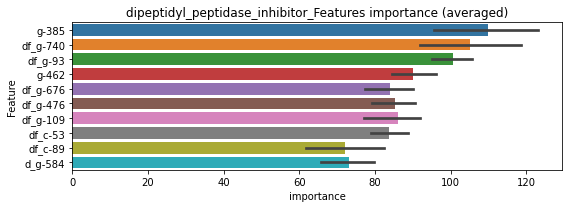

len(train_index) : 3895
len(valid_index) : 3896
================================= fold 1/2 dipeptidyl_peptidase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0166882	valid_1's binary_logloss: 0.0294165
[200]	training's binary_logloss: 0.00214984	valid_1's binary_logloss: 0.0111853
[300]	training's binary_logloss: 0.000577338	valid_1's binary_logloss: 0.00852142
Early stopping, best iteration is:
[354]	training's binary_logloss: 0.000373251	valid_1's binary_logloss: 0.00818676


len(train_index) : 3896
len(valid_index) : 3895
================================= fold 2/2 dipeptidyl_peptidase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0172806	valid_1's binary_logloss: 0.0215491
[200]	training's binary_logloss: 0.00233228	valid_1's binary_logloss: 0.00450663
[300]	training's binary_logloss: 0.000632393	valid_1's binary_logloss: 0.00229116
Early stopping, best iteration is:
[337]	training's binary_logloss: 0.000462162	valid_1's binary_logloss: 0.00208738


dipeptidyl_peptidase_inhibitor logloss: 0.005137465233096439
diuretic, len(trt): 6, len(othr): 3288, target_rate: 0.0002520 → Adj_target_rate: 0.0003851


neg labels: 3289 → selected neg labels: 3288


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0156601	valid_1's binary_logloss: 0.016318
[200]	training's binary_logloss: 0.00130506	valid_1's binary_logloss: 0.00152546
[300]	training's binary_logloss: 0.00035292	valid_1's binary_logloss: 0.000534455
[400]	training's binary_logloss: 0.000218763	valid_1's binary_logloss: 0.000358898
[500]	training's binary_logloss: 0.000191201	valid_1's binary_logloss: 0.000328953
[600]	training's binary_logloss: 0.0001869	valid_1's binary_logloss: 0.000322493
Early stopping, best iteration is:
[605]	training's binary_logloss: 0.000186858	valid_1's binary_logloss: 0.000322442
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0159232	valid_1's binary_logloss: 0.0178773
[200]	training's binary_logloss: 0.00131258	valid_1's binary_logloss: 0.00213478
[300]	training's binary_logloss: 0.000353492	valid_1's binary_logloss: 0.000867261
[400]	training's binary_loglo

1 / 3 AUC score:1.000
Threshold: 0.0005921, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → positive_corect_labels: 657/3813
p_label_rate: 0.0394274 Vs.target_rate: 0.00025, Num_p_label: 157.0, conf_0:0.00011, conf_1:0.00065
Num_p_label: 157.0, Expected: 1.0, Adj_threshold_1: 0.0005921
Num_p_label: 5.0, Expected: 1.0, Adj_threshold_2: 0.0055921
Num_p_label: 2.0, Expected: 1.0, Adj_threshold_3: 0.0105921
threshold: 0.0105921, positive p_label: 2.0/3982, p_label_rate: 0.0005023
positive y_label: 657.0/3813, y_label_rate: 0.1723053
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0160046	valid_1's binary_logloss: 0.0186329
[200]	training's binary_logloss: 0.00129377	valid_1's binary_logloss: 0.00331372
[300]	training's binary_logloss: 0.000346695	valid_1's binary_logloss: 0.00194409
[400]	training's binary_logloss: 0.000217993	valid_1's binary_logloss: 0.00162616
Early stopping, best iteration is:
[422]	training's binary_logloss: 0.000206855	valid_1's binary_logloss: 0.00158565
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0162338	valid_1's binary_logloss: 0.017438
[200]	training's binary_logloss: 0.00130824	valid_1's binary_logloss: 0.00151272
[300]	training's binary_logloss: 0.000347037	valid_1's binary_logloss: 0.000431423
[400]	training's binary_logloss: 0.00021677	valid_1's binary_logloss: 0.000277045
[500]	training's binary_logloss: 0.000187466	valid_1's binary_logloss: 0.000241127
Early stopping, best iteration

2 / 3 AUC score:1.000
Threshold: 0.0105921, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → positive_corect_labels: 657.0/3813
p_label_rate: 0.0037670 Vs.target_rate: 0.00025, Num_p_label: 15.0, conf_0:0.00013, conf_1:0.01165
Num_p_label: 15.0, Expected: 1.0, Adj_threshold_1: 0.0105921
Num_p_label: 7.0, Expected: 1.0, Adj_threshold_2: 0.0155921
Num_p_label: 6.0, Expected: 1.0, Adj_threshold_3: 0.0205921
Num_p_label: 4.0, Expected: 1.0, Adj_threshold_4: 0.0255921
Num_p_label: 3.0, Expected: 1.0, Adj_threshold_5: 0.0305921
Num_p_label: 3.0, Expected: 1.0, Adj_threshold_6: 0.0355921
Num_p_label: 3.0, Expected: 1.0, Adj_threshold_7: 0.0405921
Num_p_label: 2.0, Expected: 1.0, Adj_threshold_8: 0.0455921
threshold: 0.0455921, positive p_label: 2.0/3982, p_label_rate: 0.0005023
positive y_label: 657.0/3813, y_label_rate: 0.1723053
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0160046	valid_1's binary_logloss: 0.0186329
[200]	training's binary_logloss: 0.00129377	valid_1's binary_logloss: 0.00331372
[300]	training's binary_logloss: 0.000346695	valid_1's binary_logloss: 0.00194409
[400]	training's binary_logloss: 0.000217993	valid_1's binary_logloss: 0.00162616
Early stopping, best iteration is:
[422]	training's binary_logloss: 0.000206855	valid_1's binary_logloss: 0.00158565
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0162338	valid_1's binary_logloss: 0.017438
[200]	training's binary_logloss: 0.00130824	valid_1's binary_logloss: 0.00151272
[300]	training's binary_logloss: 0.000347037	valid_1's binary_logloss: 0.000431423
[400]	training's binary_logloss: 0.00021677	valid_1's binary_logloss: 0.000277045
[500]	training's binary_logloss: 0.000187466	valid_1's binary_logloss: 0.000241127
Early stopping, best iteration

3 / 3 AUC score:1.000
Threshold: 0.0455921, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → positive_corect_labels: 657.0/3813
p_label_rate: 0.0005023 Vs.target_rate: 0.00025, Num_p_label: 2.0, conf_0:0.00013, conf_1:0.05015
threshold: 0.0455921, positive p_label: 2.0/3982, p_label_rate: 0.0005023
positive y_label: 659.0/7795, y_label_rate: 0.0845414


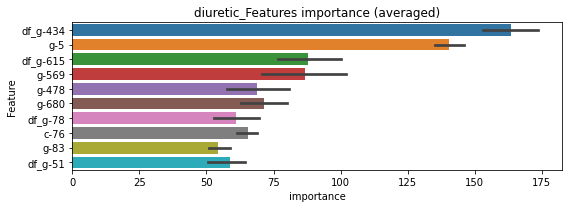

len(train_index) : 3897
len(valid_index) : 3898
================================= fold 1/2 diuretic=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.00857332	valid_1's binary_logloss: 0.0093167
[200]	training's binary_logloss: 0.0007047	valid_1's binary_logloss: 0.00160036


len(train_index) : 3898


Early stopping, best iteration is:
[277]	training's binary_logloss: 0.000222933	valid_1's binary_logloss: 0.00121653


len(valid_index) : 3897
================================= fold 2/2 diuretic=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0086419	valid_1's binary_logloss: 0.0102437
[200]	training's binary_logloss: 0.000683754	valid_1's binary_logloss: 0.00203431
[300]	training's binary_logloss: 0.000179217	valid_1's binary_logloss: 0.00152159
Early stopping, best iteration is:
[312]	training's binary_logloss: 0.000163272	valid_1's binary_logloss: 0.00150865


diuretic logloss: 0.0013625725611137551
dna_alkylating_agent, len(trt): 48, len(othr): 3281, target_rate: 0.0020156 → Adj_target_rate: 0.0022556


neg labels: 3289 → selected neg labels: 3281


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0398078	valid_1's binary_logloss: 0.0772554
[200]	training's binary_logloss: 0.00709616	valid_1's binary_logloss: 0.0290461
[300]	training's binary_logloss: 0.00206126	valid_1's binary_logloss: 0.0167415
[400]	training's binary_logloss: 0.00101234	valid_1's binary_logloss: 0.0127716
[500]	training's binary_logloss: 0.000654516	valid_1's binary_logloss: 0.010959
Early stopping, best iteration is:
[563]	training's binary_logloss: 0.000558131	valid_1's binary_logloss: 0.0105339
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0423589	valid_1's binary_logloss: 0.0700177
[200]	training's binary_logloss: 0.00750669	valid_1's binary_logloss: 0.0221762
[300]	training's binary_logloss: 0.00214571	valid_1's binary_logloss: 0.0112019
[400]	training's binary_logloss: 0.00103319	valid_1's binary_logloss: 0.00820729
[500]	training's binary_logloss: 0.00066875

1 / 3 AUC score:1.000
Threshold: 0.0055363, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → positive_corect_labels: 656/3805
p_label_rate: 0.0459568 Vs.target_rate: 0.00202, Num_p_label: 183.0, conf_0:0.00054, conf_1:0.00609
Num_p_label: 183.0, Expected: 8.0, Adj_threshold_1: 0.0055363
Num_p_label: 82.0, Expected: 8.0, Adj_threshold_2: 0.0105363
Num_p_label: 45.0, Expected: 8.0, Adj_threshold_3: 0.0155363
Num_p_label: 26.0, Expected: 8.0, Adj_threshold_4: 0.0205363
Num_p_label: 17.0, Expected: 8.0, Adj_threshold_5: 0.0255363
Num_p_label: 12.0, Expected: 8.0, Adj_threshold_6: 0.0305363
threshold: 0.0305363, positive p_label: 12.0/3982, p_label_rate: 0.0030136
positive y_label: 656.0/3805, y_label_rate: 0.1724047
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.040073	valid_1's binary_logloss: 0.0746701
[200]	training's binary_logloss: 0.00675747	valid_1's binary_logloss: 0.0272179
[300]	training's binary_logloss: 0.00197653	valid_1's binary_logloss: 0.0147256
[400]	training's binary_logloss: 0.000971382	valid_1's binary_logloss: 0.0111785
[500]	training's binary_logloss: 0.000639512	valid_1's binary_logloss: 0.00969977
[600]	training's binary_logloss: 0.000524556	valid_1's binary_logloss: 0.00917949
Early stopping, best iteration is:
[596]	training's binary_logloss: 0.000527452	valid_1's binary_logloss: 0.00917147
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0408058	valid_1's binary_logloss: 0.0681205
[200]	training's binary_logloss: 0.00690803	valid_1's binary_logloss: 0.020318
[300]	training's binary_logloss: 0.00205679	valid_1's binary_logloss: 0.0107609
[400]	training's binary_logloss: 0.00099

2 / 3 AUC score:1.000
Threshold: 0.0305363, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 2 → positive_corect_labels: 655.0/3803
p_label_rate: 0.0100452 Vs.target_rate: 0.00202, Num_p_label: 40.0, conf_0:0.00059, conf_1:0.03359
Num_p_label: 40.0, Expected: 8.0, Adj_threshold_1: 0.0305363
Num_p_label: 37.0, Expected: 8.0, Adj_threshold_2: 0.0355363
Num_p_label: 31.0, Expected: 8.0, Adj_threshold_3: 0.0405363
Num_p_label: 25.0, Expected: 8.0, Adj_threshold_4: 0.0455363
Num_p_label: 23.0, Expected: 8.0, Adj_threshold_5: 0.0505363
Num_p_label: 21.0, Expected: 8.0, Adj_threshold_6: 0.0555363
Num_p_label: 18.0, Expected: 8.0, Adj_threshold_7: 0.0605363
Num_p_label: 17.0, Expected: 8.0, Adj_threshold_8: 0.0655363
Num_p_label: 17.0, Expected: 8.0, Adj_threshold_9: 0.0705363
Num_p_label: 15.0, Expected: 8.0, Adj_threshold_10: 0.0755363
threshold: 0.0755363, positive p_label: 15.0/3982, p_label_rate: 0.0037670
positive y_label: 655.0/3803, y_label_rate: 0.1722324
================= Pseudo labelin

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0393968	valid_1's binary_logloss: 0.0790862
[200]	training's binary_logloss: 0.00642458	valid_1's binary_logloss: 0.0341957
[300]	training's binary_logloss: 0.0018901	valid_1's binary_logloss: 0.024992
[400]	training's binary_logloss: 0.00092511	valid_1's binary_logloss: 0.0217373
Early stopping, best iteration is:
[476]	training's binary_logloss: 0.000670903	valid_1's binary_logloss: 0.0201817
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0399877	valid_1's binary_logloss: 0.0726034
[200]	training's binary_logloss: 0.00682804	valid_1's binary_logloss: 0.0265
[300]	training's binary_logloss: 0.00202983	valid_1's binary_logloss: 0.0154799
[400]	training's binary_logloss: 0.000992166	valid_1's binary_logloss: 0.0124789
Early stopping, best iteration is:
[485]	training's binary_logloss: 0.000677805	valid_1's binary_logloss: 0.0111227


3 / 3 AUC score:1.000
Threshold: 0.0755363, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 3 → positive_corect_labels: 652.0/3800
p_label_rate: 0.0030136 Vs.target_rate: 0.00202, Num_p_label: 12.0, conf_0:0.00077, conf_1:0.08309
threshold: 0.0755363, positive p_label: 12.0/3982, p_label_rate: 0.0030136
positive y_label: 664.0/7782, y_label_rate: 0.0853251


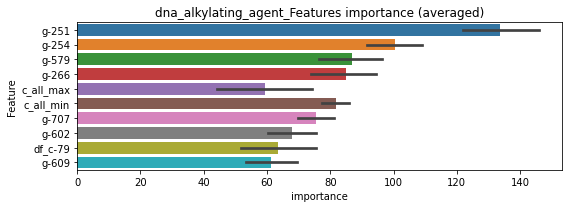

len(train_index) : 3891
len(valid_index) : 3891
================================= fold 1/2 dna_alkylating_agent=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0212745	valid_1's binary_logloss: 0.0406614
[200]	training's binary_logloss: 0.00357663	valid_1's binary_logloss: 0.0180705
[300]	training's binary_logloss: 0.00104352	valid_1's binary_logloss: 0.013574
Early stopping, best iteration is:
[370]	training's binary_logloss: 0.000604496	valid_1's binary_logloss: 0.0128366


len(train_index) : 3891
len(valid_index) : 3891
================================= fold 2/2 dna_alkylating_agent=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0213998	valid_1's binary_logloss: 0.0437274
[200]	training's binary_logloss: 0.00372456	valid_1's binary_logloss: 0.0198439
[300]	training's binary_logloss: 0.00109418	valid_1's binary_logloss: 0.0142381
Early stopping, best iteration is:
[381]	training's binary_logloss: 0.00058517	valid_1's binary_logloss: 0.0127079


dna_alkylating_agent logloss: 0.0127722734038546
dna_inhibitor, len(trt): 402, len(othr): 3229, target_rate: 0.0168808 → Adj_target_rate: 0.0137338


neg labels: 3289 → selected neg labels: 3229


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.130445	valid_1's binary_logloss: 0.354059
Early stopping, best iteration is:
[153]	training's binary_logloss: 0.0757208	valid_1's binary_logloss: 0.348069
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.114925	valid_1's binary_logloss: 0.363596


1 / 3 AUC score:0.795
Threshold: 0.1334304, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 656 → positive_corect_labels: 382/3218
p_label_rate: 0.0831241 Vs.target_rate: 0.01688, Num_p_label: 331.0, conf_0:0.07917, conf_1:0.14677


Early stopping, best iteration is:
[126]	training's binary_logloss: 0.0869872	valid_1's binary_logloss: 0.357127


Num_p_label: 331.0, Expected: 67.2, Adj_threshold_1: 0.1334304
Num_p_label: 299.0, Expected: 67.2, Adj_threshold_2: 0.1384304
Num_p_label: 267.0, Expected: 67.2, Adj_threshold_3: 0.1434304
Num_p_label: 229.0, Expected: 67.2, Adj_threshold_4: 0.1484304
Num_p_label: 209.0, Expected: 67.2, Adj_threshold_5: 0.1534304
Num_p_label: 188.0, Expected: 67.2, Adj_threshold_6: 0.1584304
Num_p_label: 160.0, Expected: 67.2, Adj_threshold_7: 0.1634304
Num_p_label: 142.0, Expected: 67.2, Adj_threshold_8: 0.1684304
Num_p_label: 126.0, Expected: 67.2, Adj_threshold_9: 0.1734304
threshold: 0.1734304, positive p_label: 126.0/3982, p_label_rate: 0.0316424
positive y_label: 382.0/3218, y_label_rate: 0.1187073
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0636911	valid_1's binary_logloss: 0.221757
Early stopping, best iteration is:
[162]	training's binary_logloss: 0.02684	valid_1's binary_logloss: 0.205692
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0598051	valid_1's binary_logloss: 0.235975


2 / 3 AUC score:0.924
Threshold: 0.1734304, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 193 → positive_corect_labels: 220.0/3025


Early stopping, best iteration is:
[148]	training's binary_logloss: 0.0308427	valid_1's binary_logloss: 0.226519


p_label_rate: 0.0369161 Vs.target_rate: 0.01688, Num_p_label: 147.0, conf_0:0.02756, conf_1:0.19077
threshold: 0.1734304, positive p_label: 147.0/3982, p_label_rate: 0.0369161
positive y_label: 220.0/3025, y_label_rate: 0.0727273
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0277653	valid_1's binary_logloss: 0.145898
Early stopping, best iteration is:
[118]	training's binary_logloss: 0.0210232	valid_1's binary_logloss: 0.144459
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0304671	valid_1's binary_logloss: 0.124877


3 / 3 AUC score:0.949
Threshold: 0.1734304, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 98 → positive_corect_labels: 137.0/2927
p_label_rate: 0.0374184 Vs.target_rate: 0.01688, Num_p_label: 149.0, conf_0:0.01037, conf_1:0.19077
threshold: 0.1734304, positive p_label: 149.0/3982, p_label_rate: 0.0374184


Early stopping, best iteration is:
[155]	training's binary_logloss: 0.0124718	valid_1's binary_logloss: 0.115781


positive y_label: 286.0/6909, y_label_rate: 0.0413953


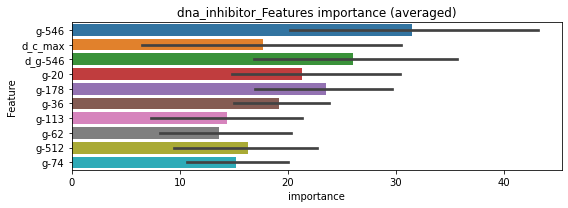

len(train_index) : 3454
len(valid_index) : 3455
================================= fold 1/2 dna_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0108101	valid_1's binary_logloss: 0.0571899
Early stopping, best iteration is:
[136]	training's binary_logloss: 0.00566509	valid_1's binary_logloss: 0.0554085


len(train_index) : 3455
len(valid_index) : 3454
================================= fold 2/2 dna_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0118391	valid_1's binary_logloss: 0.0487262


dna_inhibitor logloss: 0.0502566255405003


Early stopping, best iteration is:
[147]	training's binary_logloss: 0.00503086	valid_1's binary_logloss: 0.0451033
  acetylcholine_receptor_agonist acetylcholine_receptor_antagonist  \
0                       df_g-122                              c-30   
1                  clusters_df_c                         c_all_max   
2                          cnt_0                    clusters_g_all   
3                      c_all_min                          df_g-707   
4                        df_g-51                        clusters_g   
5                       df_c_min                          df_c_min   
6                          cnt_2                             g-514   
7                       df_g-736                          df_g-640   
8                          g-244                            df_c-6   
9                           c-73                          df_g-597   

  acetylcholinesterase_inhibitor adenosine_receptor_antagonist  \
0                      c_all_max                

dopamine_receptor_agonist, len(trt): 121, len(othr): 3267, target_rate: 0.0050810 → Adj_target_rate: 0.0049495


neg labels: 3289 → selected neg labels: 3267


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0762425	valid_1's binary_logloss: 0.170843
[200]	training's binary_logloss: 0.0221557	valid_1's binary_logloss: 0.124333
[300]	training's binary_logloss: 0.00705015	valid_1's binary_logloss: 0.108534
[400]	training's binary_logloss: 0.00298822	valid_1's binary_logloss: 0.105959
Early stopping, best iteration is:
[411]	training's binary_logloss: 0.00277714	valid_1's binary_logloss: 0.105592
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.081571	valid_1's binary_logloss: 0.16774
[200]	training's binary_logloss: 0.0232221	valid_1's binary_logloss: 0.11228
[300]	training's binary_logloss: 0.00752569	valid_1's binary_logloss: 0.0938956
Early stopping, best iteration is:
[347]	training's binary_logloss: 0.00486316	valid_1's binary_logloss: 0.0904714


1 / 3 AUC score:0.987
Threshold: 0.0253095, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 183 → positive_corect_labels: 627/3737
p_label_rate: 0.0441989 Vs.target_rate: 0.00508, Num_p_label: 176.0, conf_0:0.00576, conf_1:0.02784
Num_p_label: 176.0, Expected: 20.2, Adj_threshold_1: 0.0253095
Num_p_label: 112.0, Expected: 20.2, Adj_threshold_2: 0.0303095
Num_p_label: 79.0, Expected: 20.2, Adj_threshold_3: 0.0353095
Num_p_label: 58.0, Expected: 20.2, Adj_threshold_4: 0.0403095
Num_p_label: 38.0, Expected: 20.2, Adj_threshold_5: 0.0453095
threshold: 0.0453095, positive p_label: 38.0/3982, p_label_rate: 0.0095429
positive y_label: 627.0/3737, y_label_rate: 0.1677816
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0744388	valid_1's binary_logloss: 0.161232
[200]	training's binary_logloss: 0.019642	valid_1's binary_logloss: 0.103418
[300]	training's binary_logloss: 0.00625078	valid_1's binary_logloss: 0.0883297
Early stopping, best iteration is:
[340]	training's binary_logloss: 0.00425561	valid_1's binary_logloss: 0.0854066
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0709388	valid_1's binary_logloss: 0.164993
[200]	training's binary_logloss: 0.018695	valid_1's binary_logloss: 0.112624
[300]	training's binary_logloss: 0.00611867	valid_1's binary_logloss: 0.100008
Early stopping, best iteration is:
[320]	training's binary_logloss: 0.00504959	valid_1's binary_logloss: 0.0991619


2 / 3 AUC score:0.990
Threshold: 0.0453095, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 97 → positive_corect_labels: 595.0/3640
p_label_rate: 0.0291311 Vs.target_rate: 0.00508, Num_p_label: 116.0, conf_0:0.00722, conf_1:0.04984
Num_p_label: 116.0, Expected: 20.2, Adj_threshold_1: 0.0453095
Num_p_label: 100.0, Expected: 20.2, Adj_threshold_2: 0.0503095
Num_p_label: 85.0, Expected: 20.2, Adj_threshold_3: 0.0553095
Num_p_label: 72.0, Expected: 20.2, Adj_threshold_4: 0.0603095
Num_p_label: 51.0, Expected: 20.2, Adj_threshold_5: 0.0653095
Num_p_label: 38.0, Expected: 20.2, Adj_threshold_6: 0.0703095
threshold: 0.0703095, positive p_label: 38.0/3982, p_label_rate: 0.0095429
positive y_label: 595.0/3640, y_label_rate: 0.1634615
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0677187	valid_1's binary_logloss: 0.158338
[200]	training's binary_logloss: 0.0172324	valid_1's binary_logloss: 0.102379
[300]	training's binary_logloss: 0.00531813	valid_1's binary_logloss: 0.0839765
Early stopping, best iteration is:
[341]	training's binary_logloss: 0.00366167	valid_1's binary_logloss: 0.0819023
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0684294	valid_1's binary_logloss: 0.153417
[200]	training's binary_logloss: 0.0172979	valid_1's binary_logloss: 0.0932292
[300]	training's binary_logloss: 0.00540531	valid_1's binary_logloss: 0.0766488
Early stopping, best iteration is:
[305]	training's binary_logloss: 0.00515815	valid_1's binary_logloss: 0.0761645


3 / 3 AUC score:0.994
Threshold: 0.0703095, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 38 → positive_corect_labels: 571.0/3602
p_label_rate: 0.0130588 Vs.target_rate: 0.00508, Num_p_label: 52.0, conf_0:0.00712, conf_1:0.07734
threshold: 0.0703095, positive p_label: 52.0/3982, p_label_rate: 0.0130588
positive y_label: 623.0/7584, y_label_rate: 0.0821466


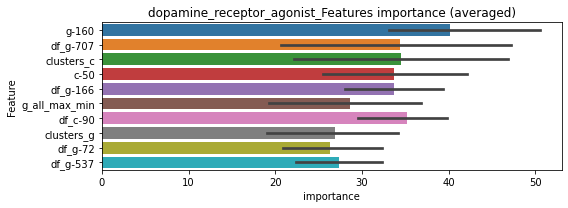

len(train_index) : 3792
len(valid_index) : 3792
================================= fold 1/2 dopamine_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0397241	valid_1's binary_logloss: 0.102797
[200]	training's binary_logloss: 0.0102155	valid_1's binary_logloss: 0.071472
[300]	training's binary_logloss: 0.00327475	valid_1's binary_logloss: 0.0647948
Early stopping, best iteration is:
[320]	training's binary_logloss: 0.00263214	valid_1's binary_logloss: 0.0643548


len(train_index) : 3792
len(valid_index) : 3792
================================= fold 2/2 dopamine_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0446375	valid_1's binary_logloss: 0.099708
[200]	training's binary_logloss: 0.0118062	valid_1's binary_logloss: 0.0677569
[300]	training's binary_logloss: 0.00369432	valid_1's binary_logloss: 0.0607914
Early stopping, best iteration is:
[345]	training's binary_logloss: 0.00231503	valid_1's binary_logloss: 0.059612


dopamine_receptor_agonist logloss: 0.061983404833899296


  acetylcholine_receptor_agonist acetylcholine_receptor_antagonist  \
0                       df_g-122                              c-30   
1                  clusters_df_c                         c_all_max   
2                          cnt_0                    clusters_g_all   
3                      c_all_min                          df_g-707   
4                        df_g-51                        clusters_g   
5                       df_c_min                          df_c_min   
6                          cnt_2                             g-514   
7                       df_g-736                          df_g-640   
8                          g-244                            df_c-6   
9                           c-73                          df_g-597   

  acetylcholinesterase_inhibitor adenosine_receptor_antagonist  \
0                      c_all_max                clusters_c_all   
1                      c_all_min                      df_c_min   
2                 clusters_g_al

dopamine_receptor_antagonist, len(trt): 424, len(othr): 3221, target_rate: 0.0178047 → Adj_target_rate: 0.0143701


neg labels: 3289 → selected neg labels: 3221


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.14345	valid_1's binary_logloss: 0.384355
Early stopping, best iteration is:
[146]	training's binary_logloss: 0.0916247	valid_1's binary_logloss: 0.379202
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.132298	valid_1's binary_logloss: 0.377191


1 / 3 AUC score:0.763
Threshold: 0.1561789, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 763 → positive_corect_labels: 327/3102
p_label_rate: 0.0974385 Vs.target_rate: 0.01780, Num_p_label: 388.0, conf_0:0.09892, conf_1:0.17180
Num_p_label: 388.0, Expected: 70.9, Adj_threshold_1: 0.1561789
Num_p_label: 346.0, Expected: 70.9, Adj_threshold_2: 0.1611789


Early stopping, best iteration is:
[105]	training's binary_logloss: 0.124448	valid_1's binary_logloss: 0.375644


Num_p_label: 304.0, Expected: 70.9, Adj_threshold_3: 0.1661789
Num_p_label: 254.0, Expected: 70.9, Adj_threshold_4: 0.1711789
Num_p_label: 225.0, Expected: 70.9, Adj_threshold_5: 0.1761789
Num_p_label: 203.0, Expected: 70.9, Adj_threshold_6: 0.1811789
Num_p_label: 173.0, Expected: 70.9, Adj_threshold_7: 0.1861789
Num_p_label: 144.0, Expected: 70.9, Adj_threshold_8: 0.1911789
Num_p_label: 118.0, Expected: 70.9, Adj_threshold_9: 0.1961789
threshold: 0.1961789, positive p_label: 118.0/3982, p_label_rate: 0.0296334
positive y_label: 327.0/3102, y_label_rate: 0.1054159
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0607439	valid_1's binary_logloss: 0.22312
Early stopping, best iteration is:
[156]	training's binary_logloss: 0.0295084	valid_1's binary_logloss: 0.214016
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0653234	valid_1's binary_logloss: 0.21735


2 / 3 AUC score:0.924
Threshold: 0.1961789, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 172 → positive_corect_labels: 162.0/2930
p_label_rate: 0.0057760 Vs.target_rate: 0.01780, Num_p_label: 23.0, conf_0:0.02949, conf_1:0.21580
Num_p_label: 23.0, Expected: 70.9, Adj_threshold_1: 0.1961789
Num_p_label: 25.0, Expected: 70.9, Adj_threshold_2: 0.1911789
Num_p_label: 31.0, Expected: 70.9, Adj_threshold_3: 0.1861789


Early stopping, best iteration is:
[150]	training's binary_logloss: 0.0352913	valid_1's binary_logloss: 0.211786


Num_p_label: 35.0, Expected: 70.9, Adj_threshold_4: 0.1811789
Num_p_label: 41.0, Expected: 70.9, Adj_threshold_5: 0.1761789
threshold: 0.1761789, positive p_label: 41.0/3982, p_label_rate: 0.0102963
positive y_label: 162.0/2930, y_label_rate: 0.0552901
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0241092	valid_1's binary_logloss: 0.1144
Early stopping, best iteration is:
[153]	training's binary_logloss: 0.0104113	valid_1's binary_logloss: 0.10732
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0226183	valid_1's binary_logloss: 0.110986


3 / 3 AUC score:0.975
Threshold: 0.1761789, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 74 → positive_corect_labels: 88.0/2856
p_label_rate: 0.0000000 Vs.target_rate: 0.01780, Num_p_label: 0.0, conf_0:0.00670, conf_1:0.19380
Num_p_label: 0.0, Expected: 70.9, Adj_threshold_1: 0.1761789
Num_p_label: 0.0, Expected: 70.9, Adj_threshold_2: 0.1711789


Early stopping, best iteration is:
[170]	training's binary_logloss: 0.00788532	valid_1's binary_logloss: 0.10203


Num_p_label: 0.0, Expected: 70.9, Adj_threshold_3: 0.1661789
Num_p_label: 0.0, Expected: 70.9, Adj_threshold_4: 0.1611789
Num_p_label: 0.0, Expected: 70.9, Adj_threshold_5: 0.1561789
Num_p_label: 0.0, Expected: 70.9, Adj_threshold_6: 0.1511789
Num_p_label: 0.0, Expected: 70.9, Adj_threshold_7: 0.1461789
Num_p_label: 0.0, Expected: 70.9, Adj_threshold_8: 0.1411789
Num_p_label: 0.0, Expected: 70.9, Adj_threshold_9: 0.1361789
Num_p_label: 0.0, Expected: 70.9, Adj_threshold_10: 0.1311789
threshold: 0.1261789, positive p_label: 0.0/3982, p_label_rate: 0.0000000
positive y_label: 88.0/6838, y_label_rate: 0.0128693


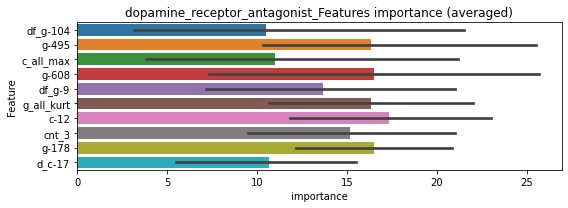

len(train_index) : 3419
len(valid_index) : 3419
================================= fold 1/2 dopamine_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds


len(train_index) : 3419
len(valid_index) : 3419
================================= fold 2/2 dopamine_receptor_antagonist=================================


Early stopping, best iteration is:
[58]	training's binary_logloss: 0.00951582	valid_1's binary_logloss: 0.0460051
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.00409458	valid_1's binary_logloss: 0.0400954


dopamine_receptor_antagonist logloss: 0.04285836944576152


Early stopping, best iteration is:
[112]	training's binary_logloss: 0.00326797	valid_1's binary_logloss: 0.0397116
  acetylcholine_receptor_agonist acetylcholine_receptor_antagonist  \
0                       df_g-122                              c-30   
1                  clusters_df_c                         c_all_max   
2                          cnt_0                    clusters_g_all   
3                      c_all_min                          df_g-707   
4                        df_g-51                        clusters_g   
5                       df_c_min                          df_c_min   
6                          cnt_2                             g-514   
7                       df_g-736                          df_g-640   
8                          g-244                            df_c-6   
9                           c-73                          df_g-597   

  acetylcholinesterase_inhibitor adenosine_receptor_antagonist  \
0                      c_all_max                

egfr_inhibitor, len(trt): 336, len(othr): 3264, target_rate: 0.0141093 → Adj_target_rate: 0.0117920


neg labels: 3289 → selected neg labels: 3264


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0439515	valid_1's binary_logloss: 0.131702
[200]	training's binary_logloss: 0.00849952	valid_1's binary_logloss: 0.111779
Early stopping, best iteration is:
[229]	training's binary_logloss: 0.00574606	valid_1's binary_logloss: 0.110644
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0465634	valid_1's binary_logloss: 0.121587
[200]	training's binary_logloss: 0.00937928	valid_1's binary_logloss: 0.0922381


1 / 3 AUC score:0.979


Early stopping, best iteration is:
[221]	training's binary_logloss: 0.00704985	valid_1's binary_logloss: 0.0898918


Threshold: 0.0395639, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 202 → positive_corect_labels: 617/3714
p_label_rate: 0.0612757 Vs.target_rate: 0.01411, Num_p_label: 244.0, conf_0:0.00463, conf_1:0.04352
Num_p_label: 244.0, Expected: 56.2, Adj_threshold_1: 0.0395639
Num_p_label: 232.0, Expected: 56.2, Adj_threshold_2: 0.0445639
Num_p_label: 215.0, Expected: 56.2, Adj_threshold_3: 0.0495639
Num_p_label: 204.0, Expected: 56.2, Adj_threshold_4: 0.0545639
Num_p_label: 192.0, Expected: 56.2, Adj_threshold_5: 0.0595639
Num_p_label: 184.0, Expected: 56.2, Adj_threshold_6: 0.0645639
Num_p_label: 169.0, Expected: 56.2, Adj_threshold_7: 0.0695639
Num_p_label: 161.0, Expected: 56.2, Adj_threshold_8: 0.0745639
Num_p_label: 154.0, Expected: 56.2, Adj_threshold_9: 0.0795639
Num_p_label: 147.0, Expected: 56.2, Adj_threshold_10: 0.0845639
threshold: 0.0895639, positive p_label: 140.0/3982, p_label_rate: 0.0351582
positive y_label: 617.0/3714, y_label_rate: 0.1661282
================= Pseudo labelin

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0373868	valid_1's binary_logloss: 0.0833348
[200]	training's binary_logloss: 0.00641139	valid_1's binary_logloss: 0.0521116
[300]	training's binary_logloss: 0.00194044	valid_1's binary_logloss: 0.0457919
Early stopping, best iteration is:
[352]	training's binary_logloss: 0.00128382	valid_1's binary_logloss: 0.0446477
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0358695	valid_1's binary_logloss: 0.0893932
[200]	training's binary_logloss: 0.00614263	valid_1's binary_logloss: 0.0587206
[300]	training's binary_logloss: 0.00186401	valid_1's binary_logloss: 0.0514155
Early stopping, best iteration is:
[303]	training's binary_logloss: 0.00181145	valid_1's binary_logloss: 0.051175


2 / 3 AUC score:0.998
Threshold: 0.0895639, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 42 → positive_corect_labels: 593.0/3672
p_label_rate: 0.0416876 Vs.target_rate: 0.01411, Num_p_label: 166.0, conf_0:0.00127, conf_1:0.09852
threshold: 0.0895639, positive p_label: 166.0/3982, p_label_rate: 0.0416876
positive y_label: 593.0/3672, y_label_rate: 0.1614924
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0328283	valid_1's binary_logloss: 0.0775541
[200]	training's binary_logloss: 0.00529406	valid_1's binary_logloss: 0.0442606
[300]	training's binary_logloss: 0.00165926	valid_1's binary_logloss: 0.0359182
[400]	training's binary_logloss: 0.000839204	valid_1's binary_logloss: 0.0320201
Early stopping, best iteration is:
[446]	training's binary_logloss: 0.000648691	valid_1's binary_logloss: 0.0313662
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.033338	valid_1's binary_logloss: 0.0746452
[200]	training's binary_logloss: 0.00544759	valid_1's binary_logloss: 0.0445729


3 / 3 AUC score:1.000
Threshold: 0.0895639, pos_neg_ratio: 0.8000000


Early stopping, best iteration is:
[256]	training's binary_logloss: 0.00258971	valid_1's binary_logloss: 0.0396006


Remove_noisy_labels: 26 → positive_corect_labels: 580.0/3646
p_label_rate: 0.0429432 Vs.target_rate: 0.01411, Num_p_label: 171.0, conf_0:0.00110, conf_1:0.09852
Num_p_label: 171.0, Expected: 56.2, Adj_threshold_1: 0.0895639
Num_p_label: 171.0, Expected: 56.2, Adj_threshold_2: 0.0945639
Num_p_label: 167.0, Expected: 56.2, Adj_threshold_3: 0.0995639
Num_p_label: 164.0, Expected: 56.2, Adj_threshold_4: 0.1045639
Num_p_label: 163.0, Expected: 56.2, Adj_threshold_5: 0.1095639
Num_p_label: 158.0, Expected: 56.2, Adj_threshold_6: 0.1145639
Num_p_label: 155.0, Expected: 56.2, Adj_threshold_7: 0.1195639
Num_p_label: 151.0, Expected: 56.2, Adj_threshold_8: 0.1245639
Num_p_label: 147.0, Expected: 56.2, Adj_threshold_9: 0.1295639
Num_p_label: 146.0, Expected: 56.2, Adj_threshold_10: 0.1345639
threshold: 0.1395639, positive p_label: 144.0/3982, p_label_rate: 0.0361627
positive y_label: 724.0/7628, y_label_rate: 0.0949135


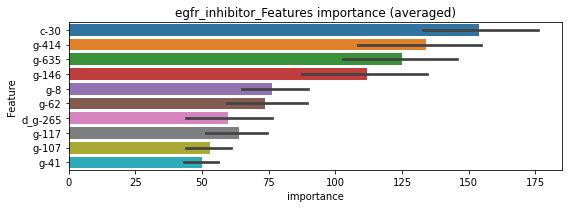

len(train_index) : 3814
len(valid_index) : 3814
================================= fold 1/2 egfr_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0199907	valid_1's binary_logloss: 0.057985
[200]	training's binary_logloss: 0.00324119	valid_1's binary_logloss: 0.0410965
[300]	training's binary_logloss: 0.00100562	valid_1's binary_logloss: 0.0380807
Early stopping, best iteration is:
[330]	training's binary_logloss: 0.000787246	valid_1's binary_logloss: 0.0375101


len(train_index) : 3814
len(valid_index) : 3814
================================= fold 2/2 egfr_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.021177	valid_1's binary_logloss: 0.0519105
[200]	training's binary_logloss: 0.0034164	valid_1's binary_logloss: 0.0313289
[300]	training's binary_logloss: 0.00104071	valid_1's binary_logloss: 0.0274567
[400]	training's binary_logloss: 0.000521861	valid_1's binary_logloss: 0.0263214
Early stopping, best iteration is:
[450]	training's binary_logloss: 0.000417619	valid_1's binary_logloss: 0.0257345


egfr_inhibitor logloss: 0.03162231128743765


  acetylcholine_receptor_agonist acetylcholine_receptor_antagonist  \
0                       df_g-122                              c-30   
1                  clusters_df_c                         c_all_max   
2                          cnt_0                    clusters_g_all   
3                      c_all_min                          df_g-707   
4                        df_g-51                        clusters_g   
5                       df_c_min                          df_c_min   
6                          cnt_2                             g-514   
7                       df_g-736                          df_g-640   
8                          g-244                            df_c-6   
9                           c-73                          df_g-597   

  acetylcholinesterase_inhibitor adenosine_receptor_antagonist  \
0                      c_all_max                clusters_c_all   
1                      c_all_min                      df_c_min   
2                 clusters_g_al

elastase_inhibitor, len(trt): 12, len(othr): 3287, target_rate: 0.0005039 → Adj_target_rate: 0.0006942


neg labels: 3289 → selected neg labels: 3287


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0206242	valid_1's binary_logloss: 0.0267891
[200]	training's binary_logloss: 0.00223824	valid_1's binary_logloss: 0.00445429
[300]	training's binary_logloss: 0.000627755	valid_1's binary_logloss: 0.00178981
[400]	training's binary_logloss: 0.000344072	valid_1's binary_logloss: 0.00122422
Early stopping, best iteration is:
[481]	training's binary_logloss: 0.000300125	valid_1's binary_logloss: 0.00114736
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.020302	valid_1's binary_logloss: 0.0252077
[200]	training's binary_logloss: 0.00220453	valid_1's binary_logloss: 0.00403968
[300]	training's binary_logloss: 0.000628204	valid_1's binary_logloss: 0.00162318
[400]	training's binary_logloss: 0.00034265	valid_1's binary_logloss: 0.00109563
Early stopping, best iteration is:
[465]	training's binary_logloss: 0.000300587	valid_1's binary_logloss: 0.0010206

1 / 3 AUC score:1.000
Threshold: 0.0010435, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → positive_corect_labels: 657/3812
p_label_rate: 0.0396786 Vs.target_rate: 0.00050, Num_p_label: 158.0, conf_0:0.00022, conf_1:0.00115
Num_p_label: 158.0, Expected: 2.0, Adj_threshold_1: 0.0010435
Num_p_label: 6.0, Expected: 2.0, Adj_threshold_2: 0.0060435
Num_p_label: 1.0, Expected: 2.0, Adj_threshold_3: 0.0110435
threshold: 0.0110435, positive p_label: 1.0/3982, p_label_rate: 0.0002511
positive y_label: 657.0/3812, y_label_rate: 0.1723505
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.020481	valid_1's binary_logloss: 0.026332
[200]	training's binary_logloss: 0.00217081	valid_1's binary_logloss: 0.00426967
[300]	training's binary_logloss: 0.000613033	valid_1's binary_logloss: 0.00174811
[400]	training's binary_logloss: 0.000340194	valid_1's binary_logloss: 0.0011726
Early stopping, best iteration is:
[482]	training's binary_logloss: 0.000298934	valid_1's binary_logloss: 0.00110618
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0207032	valid_1's binary_logloss: 0.0243967
[200]	training's binary_logloss: 0.00220272	valid_1's binary_logloss: 0.00338293
[300]	training's binary_logloss: 0.000621399	valid_1's binary_logloss: 0.00112533
[400]	training's binary_logloss: 0.000343845	valid_1's binary_logloss: 0.000696871
[500]	training's binary_logloss: 0.000297624	valid_1's binary_logloss: 0.000626549
Early stopping, best iteration i

2 / 3 AUC score:1.000
Threshold: 0.0110435, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → positive_corect_labels: 657.0/3812
p_label_rate: 0.0020090 Vs.target_rate: 0.00050, Num_p_label: 8.0, conf_0:0.00023, conf_1:0.01215
Num_p_label: 8.0, Expected: 2.0, Adj_threshold_1: 0.0110435
Num_p_label: 3.0, Expected: 2.0, Adj_threshold_2: 0.0160435
threshold: 0.0160435, positive p_label: 3.0/3982, p_label_rate: 0.0007534
positive y_label: 657.0/3812, y_label_rate: 0.1723505
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.020481	valid_1's binary_logloss: 0.026332
[200]	training's binary_logloss: 0.00217081	valid_1's binary_logloss: 0.00426967
[300]	training's binary_logloss: 0.000613033	valid_1's binary_logloss: 0.00174811
[400]	training's binary_logloss: 0.000340194	valid_1's binary_logloss: 0.0011726
Early stopping, best iteration is:
[482]	training's binary_logloss: 0.000298934	valid_1's binary_logloss: 0.00110618
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0207032	valid_1's binary_logloss: 0.0243967
[200]	training's binary_logloss: 0.00220272	valid_1's binary_logloss: 0.00338293
[300]	training's binary_logloss: 0.000621399	valid_1's binary_logloss: 0.00112533
[400]	training's binary_logloss: 0.000343845	valid_1's binary_logloss: 0.000696871
[500]	training's binary_logloss: 0.000297624	valid_1's binary_logloss: 0.000626549
Early stopping, best iteration i

3 / 3 AUC score:1.000
Threshold: 0.0160435, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → positive_corect_labels: 657.0/3812
p_label_rate: 0.0007534 Vs.target_rate: 0.00050, Num_p_label: 3.0, conf_0:0.00023, conf_1:0.01765
threshold: 0.0160435, positive p_label: 3.0/3982, p_label_rate: 0.0007534
positive y_label: 660.0/7794, y_label_rate: 0.0846805


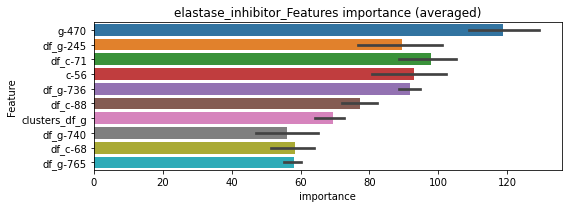

len(train_index) : 3897
len(valid_index) : 3897
================================= fold 1/2 elastase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0109017	valid_1's binary_logloss: 0.017543
[200]	training's binary_logloss: 0.00114185	valid_1's binary_logloss: 0.00548508
[300]	training's binary_logloss: 0.000316881	valid_1's binary_logloss: 0.00434972
Early stopping, best iteration is:
[376]	training's binary_logloss: 0.000188685	valid_1's binary_logloss: 0.00421247


len(train_index) : 3897
len(valid_index) : 3897
================================= fold 2/2 elastase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0116373	valid_1's binary_logloss: 0.0158221
[200]	training's binary_logloss: 0.00133563	valid_1's binary_logloss: 0.00443536
[300]	training's binary_logloss: 0.000381579	valid_1's binary_logloss: 0.0029098
[400]	training's binary_logloss: 0.00019433	valid_1's binary_logloss: 0.00257249
Early stopping, best iteration is:
[480]	training's binary_logloss: 0.000148824	valid_1's binary_logloss: 0.00240586


elastase_inhibitor logloss: 0.0033091639067762747
erbb2_inhibitor, len(trt): 20, len(othr): 3284, target_rate: 0.0008398 → Adj_target_rate: 0.0010717


neg labels: 3289 → selected neg labels: 3284


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0265036	valid_1's binary_logloss: 0.0375567
[200]	training's binary_logloss: 0.00339755	valid_1's binary_logloss: 0.00766203
[300]	training's binary_logloss: 0.000960922	valid_1's binary_logloss: 0.00294148
[400]	training's binary_logloss: 0.000496164	valid_1's binary_logloss: 0.0019052
Early stopping, best iteration is:
[484]	training's binary_logloss: 0.000391032	valid_1's binary_logloss: 0.00162248
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0268256	valid_1's binary_logloss: 0.0361152
[200]	training's binary_logloss: 0.00348835	valid_1's binary_logloss: 0.006758
[300]	training's binary_logloss: 0.000975924	valid_1's binary_logloss: 0.00257973
[400]	training's binary_logloss: 0.000501491	valid_1's binary_logloss: 0.00161222
[500]	training's binary_logloss: 0.00038381	valid_1's binary_logloss: 0.00136135
Early stopping, best iteration is:


1 / 3 AUC score:1.000
Threshold: 0.0015711, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → positive_corect_labels: 656/3808
p_label_rate: 0.0421899 Vs.target_rate: 0.00084, Num_p_label: 168.0, conf_0:0.00030, conf_1:0.00173
Num_p_label: 168.0, Expected: 3.3, Adj_threshold_1: 0.0015711
Num_p_label: 8.0, Expected: 3.3, Adj_threshold_2: 0.0065711
Num_p_label: 1.0, Expected: 3.3, Adj_threshold_3: 0.0115711
threshold: 0.0115711, positive p_label: 1.0/3982, p_label_rate: 0.0002511
positive y_label: 656.0/3808, y_label_rate: 0.1722689
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0271407	valid_1's binary_logloss: 0.0392583
[200]	training's binary_logloss: 0.00337253	valid_1's binary_logloss: 0.00833412
[300]	training's binary_logloss: 0.000955701	valid_1's binary_logloss: 0.00336292
[400]	training's binary_logloss: 0.000494588	valid_1's binary_logloss: 0.00220485
[500]	training's binary_logloss: 0.000381956	valid_1's binary_logloss: 0.0019032
Early stopping, best iteration is:
[515]	training's binary_logloss: 0.000380103	valid_1's binary_logloss: 0.00189632
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0267578	valid_1's binary_logloss: 0.0362775
[200]	training's binary_logloss: 0.00336024	valid_1's binary_logloss: 0.00635633
[300]	training's binary_logloss: 0.000944587	valid_1's binary_logloss: 0.00239113
[400]	training's binary_logloss: 0.000494559	valid_1's binary_logloss: 0.00148212
[500]	training's binary_logloss:

2 / 3 AUC score:1.000
Threshold: 0.0115711, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → positive_corect_labels: 656.0/3808
p_label_rate: 0.0035158 Vs.target_rate: 0.00084, Num_p_label: 14.0, conf_0:0.00032, conf_1:0.01273
Num_p_label: 14.0, Expected: 3.3, Adj_threshold_1: 0.0115711
Num_p_label: 4.0, Expected: 3.3, Adj_threshold_2: 0.0165711
threshold: 0.0165711, positive p_label: 4.0/3982, p_label_rate: 0.0010045
positive y_label: 656.0/3808, y_label_rate: 0.1722689
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0271407	valid_1's binary_logloss: 0.0392583
[200]	training's binary_logloss: 0.00337253	valid_1's binary_logloss: 0.00833412
[300]	training's binary_logloss: 0.000955701	valid_1's binary_logloss: 0.00336292
[400]	training's binary_logloss: 0.000494588	valid_1's binary_logloss: 0.00220485
[500]	training's binary_logloss: 0.000381956	valid_1's binary_logloss: 0.0019032
Early stopping, best iteration is:
[515]	training's binary_logloss: 0.000380103	valid_1's binary_logloss: 0.00189632
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0267578	valid_1's binary_logloss: 0.0362775
[200]	training's binary_logloss: 0.00336024	valid_1's binary_logloss: 0.00635633
[300]	training's binary_logloss: 0.000944587	valid_1's binary_logloss: 0.00239113
[400]	training's binary_logloss: 0.000494559	valid_1's binary_logloss: 0.00148212
[500]	training's binary_logloss:

3 / 3 AUC score:1.000
Threshold: 0.0165711, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → positive_corect_labels: 656.0/3808
p_label_rate: 0.0010045 Vs.target_rate: 0.00084, Num_p_label: 4.0, conf_0:0.00032, conf_1:0.01823
threshold: 0.0165711, positive p_label: 4.0/3982, p_label_rate: 0.0010045
positive y_label: 660.0/7790, y_label_rate: 0.0847240


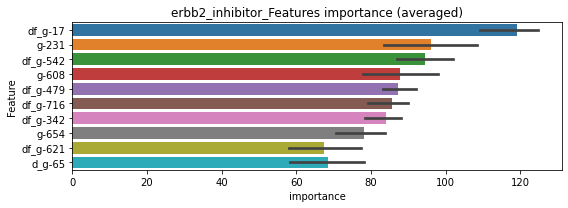

len(train_index) : 3895
len(valid_index) : 3895
================================= fold 1/2 erbb2_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0145214	valid_1's binary_logloss: 0.0239234
[200]	training's binary_logloss: 0.00180725	valid_1's binary_logloss: 0.00799418
[300]	training's binary_logloss: 0.000491747	valid_1's binary_logloss: 0.00613954
Early stopping, best iteration is:
[363]	training's binary_logloss: 0.000303825	valid_1's binary_logloss: 0.00594056


len(train_index) : 3895
len(valid_index) : 3895
================================= fold 2/2 erbb2_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0150709	valid_1's binary_logloss: 0.0197833
[200]	training's binary_logloss: 0.00186238	valid_1's binary_logloss: 0.00414098
[300]	training's binary_logloss: 0.000504334	valid_1's binary_logloss: 0.00232742
[400]	training's binary_logloss: 0.000256786	valid_1's binary_logloss: 0.00200983
[500]	training's binary_logloss: 0.000196939	valid_1's binary_logloss: 0.00190175
Early stopping, best iteration is:
[499]	training's binary_logloss: 0.000196939	valid_1's binary_logloss: 0.00190175


erbb2_inhibitor logloss: 0.003921153483122162
estrogen_receptor_agonist, len(trt): 158, len(othr): 3265, target_rate: 0.0066348 → Adj_target_rate: 0.0062095


neg labels: 3289 → selected neg labels: 3265


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0797892	valid_1's binary_logloss: 0.194488
[200]	training's binary_logloss: 0.0241881	valid_1's binary_logloss: 0.14806
[300]	training's binary_logloss: 0.00819293	valid_1's binary_logloss: 0.133186
Early stopping, best iteration is:
[345]	training's binary_logloss: 0.00544209	valid_1's binary_logloss: 0.130838
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0863128	valid_1's binary_logloss: 0.177354
[200]	training's binary_logloss: 0.027003	valid_1's binary_logloss: 0.127777
[300]	training's binary_logloss: 0.00955218	valid_1's binary_logloss: 0.112332
Early stopping, best iteration is:
[375]	training's binary_logloss: 0.00488411	valid_1's binary_logloss: 0.107408


1 / 3 AUC score:0.984
Threshold: 0.0367332, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 213 → positive_corect_labels: 612/3705
p_label_rate: 0.0361627 Vs.target_rate: 0.00663, Num_p_label: 144.0, conf_0:0.00820, conf_1:0.04041
Num_p_label: 144.0, Expected: 26.4, Adj_threshold_1: 0.0367332
Num_p_label: 111.0, Expected: 26.4, Adj_threshold_2: 0.0417332
Num_p_label: 91.0, Expected: 26.4, Adj_threshold_3: 0.0467332
Num_p_label: 71.0, Expected: 26.4, Adj_threshold_4: 0.0517332
Num_p_label: 59.0, Expected: 26.4, Adj_threshold_5: 0.0567332
Num_p_label: 45.0, Expected: 26.4, Adj_threshold_6: 0.0617332
threshold: 0.0617332, positive p_label: 45.0/3982, p_label_rate: 0.0113009
positive y_label: 612.0/3705, y_label_rate: 0.1651822
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0699603	valid_1's binary_logloss: 0.170115
[200]	training's binary_logloss: 0.0197371	valid_1's binary_logloss: 0.120799
[300]	training's binary_logloss: 0.00651084	valid_1's binary_logloss: 0.104949
Early stopping, best iteration is:
[338]	training's binary_logloss: 0.0046232	valid_1's binary_logloss: 0.101679
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0765226	valid_1's binary_logloss: 0.166648
[200]	training's binary_logloss: 0.0206627	valid_1's binary_logloss: 0.120528
[300]	training's binary_logloss: 0.00698733	valid_1's binary_logloss: 0.107954
Early stopping, best iteration is:
[320]	training's binary_logloss: 0.00574157	valid_1's binary_logloss: 0.106638


2 / 3 AUC score:0.990
Threshold: 0.0617332, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 70 → positive_corect_labels: 570.0/3635
p_label_rate: 0.0158212 Vs.target_rate: 0.00663, Num_p_label: 63.0, conf_0:0.00824, conf_1:0.06791
threshold: 0.0617332, positive p_label: 63.0/3982, p_label_rate: 0.0158212
positive y_label: 570.0/3635, y_label_rate: 0.1568088
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0619219	valid_1's binary_logloss: 0.149791
[200]	training's binary_logloss: 0.0161925	valid_1's binary_logloss: 0.106894
[300]	training's binary_logloss: 0.00532938	valid_1's binary_logloss: 0.0958085
Early stopping, best iteration is:
[342]	training's binary_logloss: 0.0036183	valid_1's binary_logloss: 0.0937187
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0640389	valid_1's binary_logloss: 0.142263
[200]	training's binary_logloss: 0.0175334	valid_1's binary_logloss: 0.0962079
[300]	training's binary_logloss: 0.00556195	valid_1's binary_logloss: 0.0817754
[400]	training's binary_logloss: 0.00250837	valid_1's binary_logloss: 0.0770807
Early stopping, best iteration is:
[418]	training's binary_logloss: 0.00223944	valid_1's binary_logloss: 0.0764276


3 / 3 AUC score:0.996
Threshold: 0.0617332, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 31 → positive_corect_labels: 545.0/3604
p_label_rate: 0.0085384 Vs.target_rate: 0.00663, Num_p_label: 34.0, conf_0:0.00467, conf_1:0.06791
threshold: 0.0617332, positive p_label: 34.0/3982, p_label_rate: 0.0085384
positive y_label: 579.0/7586, y_label_rate: 0.0763248


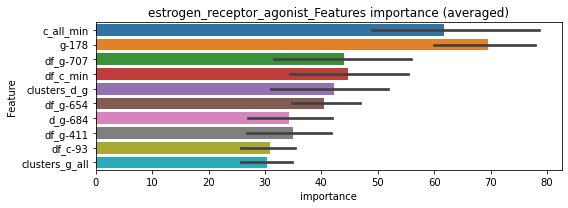

len(train_index) : 3793
len(valid_index) : 3793
================================= fold 1/2 estrogen_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0348526	valid_1's binary_logloss: 0.0988576
[200]	training's binary_logloss: 0.00955038	valid_1's binary_logloss: 0.0824738
Early stopping, best iteration is:
[240]	training's binary_logloss: 0.00577967	valid_1's binary_logloss: 0.0796867


len(train_index) : 3793
len(valid_index) : 3793
================================= fold 2/2 estrogen_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0354029	valid_1's binary_logloss: 0.0883613
[200]	training's binary_logloss: 0.00944437	valid_1's binary_logloss: 0.0648733
Early stopping, best iteration is:
[285]	training's binary_logloss: 0.00355724	valid_1's binary_logloss: 0.059574


estrogen_receptor_agonist logloss: 0.06963034705016224


  acetylcholine_receptor_agonist acetylcholine_receptor_antagonist  \
0                       df_g-122                              c-30   
1                  clusters_df_c                         c_all_max   
2                          cnt_0                    clusters_g_all   
3                      c_all_min                          df_g-707   
4                        df_g-51                        clusters_g   
5                       df_c_min                          df_c_min   
6                          cnt_2                             g-514   
7                       df_g-736                          df_g-640   
8                          g-244                            df_c-6   
9                           c-73                          df_g-597   

  acetylcholinesterase_inhibitor adenosine_receptor_antagonist  \
0                      c_all_max                clusters_c_all   
1                      c_all_min                      df_c_min   
2                 clusters_g_al

estrogen_receptor_antagonist, len(trt): 48, len(othr): 3283, target_rate: 0.0020156 → Adj_target_rate: 0.0022556


neg labels: 3289 → selected neg labels: 3283


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0402169	valid_1's binary_logloss: 0.0859877
[200]	training's binary_logloss: 0.00740244	valid_1's binary_logloss: 0.0446388
[300]	training's binary_logloss: 0.00210949	valid_1's binary_logloss: 0.0350149
[400]	training's binary_logloss: 0.00099758	valid_1's binary_logloss: 0.032711
Early stopping, best iteration is:
[390]	training's binary_logloss: 0.0010583	valid_1's binary_logloss: 0.0326504
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0414979	valid_1's binary_logloss: 0.067339
[200]	training's binary_logloss: 0.0077597	valid_1's binary_logloss: 0.0227499
[300]	training's binary_logloss: 0.00227628	valid_1's binary_logloss: 0.012373
[400]	training's binary_logloss: 0.00109077	valid_1's binary_logloss: 0.00968233
[500]	training's binary_logloss: 0.000709319	valid_1's binary_logloss: 0.00852431
[600]	training's binary_logloss: 0.000557399	va

1 / 3 AUC score:0.998
Threshold: 0.0047476, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 138 → positive_corect_labels: 653/3801
p_label_rate: 0.0459568 Vs.target_rate: 0.00202, Num_p_label: 183.0, conf_0:0.00087, conf_1:0.00522
Num_p_label: 183.0, Expected: 8.0, Adj_threshold_1: 0.0047476
Num_p_label: 55.0, Expected: 8.0, Adj_threshold_2: 0.0097476
Num_p_label: 30.0, Expected: 8.0, Adj_threshold_3: 0.0147476
Num_p_label: 18.0, Expected: 8.0, Adj_threshold_4: 0.0197476
Num_p_label: 8.0, Expected: 8.0, Adj_threshold_5: 0.0247476
threshold: 0.0247476, positive p_label: 8.0/3982, p_label_rate: 0.0020090
positive y_label: 653.0/3801, y_label_rate: 0.1717969
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.041842	valid_1's binary_logloss: 0.0749782
[200]	training's binary_logloss: 0.00741507	valid_1's binary_logloss: 0.0285561
[300]	training's binary_logloss: 0.00218826	valid_1's binary_logloss: 0.0179435
[400]	training's binary_logloss: 0.00103499	valid_1's binary_logloss: 0.0148396
[500]	training's binary_logloss: 0.000664797	valid_1's binary_logloss: 0.0133023
Early stopping, best iteration is:
[555]	training's binary_logloss: 0.000567604	valid_1's binary_logloss: 0.0128838
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0403727	valid_1's binary_logloss: 0.0780595
[200]	training's binary_logloss: 0.00718603	valid_1's binary_logloss: 0.0350359
[300]	training's binary_logloss: 0.00210523	valid_1's binary_logloss: 0.0247455
Early stopping, best iteration is:
[356]	training's binary_logloss: 0.0013346	valid_1's binary_logloss: 0.0224338


2 / 3 AUC score:1.000
Threshold: 0.0247476, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 5 → positive_corect_labels: 652.0/3796
p_label_rate: 0.0143144 Vs.target_rate: 0.00202, Num_p_label: 57.0, conf_0:0.00118, conf_1:0.02722
Num_p_label: 57.0, Expected: 8.0, Adj_threshold_1: 0.0247476
Num_p_label: 41.0, Expected: 8.0, Adj_threshold_2: 0.0297476
Num_p_label: 34.0, Expected: 8.0, Adj_threshold_3: 0.0347476
Num_p_label: 30.0, Expected: 8.0, Adj_threshold_4: 0.0397476
Num_p_label: 26.0, Expected: 8.0, Adj_threshold_5: 0.0447476
Num_p_label: 23.0, Expected: 8.0, Adj_threshold_6: 0.0497476
Num_p_label: 20.0, Expected: 8.0, Adj_threshold_7: 0.0547476
Num_p_label: 15.0, Expected: 8.0, Adj_threshold_8: 0.0597476
threshold: 0.0597476, positive p_label: 15.0/3982, p_label_rate: 0.0037670
positive y_label: 652.0/3796, y_label_rate: 0.1717597
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0388101	valid_1's binary_logloss: 0.0768157
[200]	training's binary_logloss: 0.00681991	valid_1's binary_logloss: 0.0359025
[300]	training's binary_logloss: 0.00201361	valid_1's binary_logloss: 0.0276271
[400]	training's binary_logloss: 0.000972552	valid_1's binary_logloss: 0.0246617
Early stopping, best iteration is:
[427]	training's binary_logloss: 0.000842527	valid_1's binary_logloss: 0.0241065
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0423943	valid_1's binary_logloss: 0.072858
[200]	training's binary_logloss: 0.00736839	valid_1's binary_logloss: 0.0254589
[300]	training's binary_logloss: 0.00215608	valid_1's binary_logloss: 0.0148338
[400]	training's binary_logloss: 0.00104039	valid_1's binary_logloss: 0.0115545
[500]	training's binary_logloss: 0.000681149	valid_1's binary_logloss: 0.0101439
Early stopping, best iteration is:
[538]	tr

3 / 3 AUC score:1.000
Threshold: 0.0597476, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 3 → positive_corect_labels: 649.0/3793
p_label_rate: 0.0042692 Vs.target_rate: 0.00202, Num_p_label: 17.0, conf_0:0.00090, conf_1:0.06572
threshold: 0.0597476, positive p_label: 17.0/3982, p_label_rate: 0.0042692
positive y_label: 666.0/7775, y_label_rate: 0.0856592


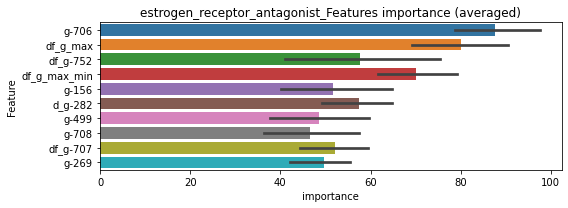

len(train_index) : 3887
len(valid_index) : 3888
================================= fold 1/2 estrogen_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0237785	valid_1's binary_logloss: 0.0472233
[200]	training's binary_logloss: 0.00421726	valid_1's binary_logloss: 0.0218726
[300]	training's binary_logloss: 0.00122196	valid_1's binary_logloss: 0.0168256
Early stopping, best iteration is:
[380]	training's binary_logloss: 0.000649501	valid_1's binary_logloss: 0.015412


len(train_index) : 3888
len(valid_index) : 3887
================================= fold 2/2 estrogen_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0242188	valid_1's binary_logloss: 0.0509284
[200]	training's binary_logloss: 0.00440167	valid_1's binary_logloss: 0.0259971
[300]	training's binary_logloss: 0.00129632	valid_1's binary_logloss: 0.020466
Early stopping, best iteration is:
[371]	training's binary_logloss: 0.000728431	valid_1's binary_logloss: 0.0190163


estrogen_receptor_antagonist logloss: 0.017213945315606795
faah_inhibitor, len(trt): 36, len(othr): 3283, target_rate: 0.0015117 → Adj_target_rate: 0.0017663


neg labels: 3289 → selected neg labels: 3283


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0352311	valid_1's binary_logloss: 0.0577406
[200]	training's binary_logloss: 0.00535254	valid_1's binary_logloss: 0.0162752
[300]	training's binary_logloss: 0.00152899	valid_1's binary_logloss: 0.00807933
[400]	training's binary_logloss: 0.000744263	valid_1's binary_logloss: 0.00563369
[500]	training's binary_logloss: 0.000504615	valid_1's binary_logloss: 0.00467448
[600]	training's binary_logloss: 0.000448282	valid_1's binary_logloss: 0.00442873
Early stopping, best iteration is:
[610]	training's binary_logloss: 0.000445805	valid_1's binary_logloss: 0.00442539
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0359673	valid_1's binary_logloss: 0.0540166
[200]	training's binary_logloss: 0.00571647	valid_1's binary_logloss: 0.0148762
[300]	training's binary_logloss: 0.0015903	valid_1's binary_logloss: 0.00621723
[400]	training's binary_logloss: 0.0

1 / 3 AUC score:1.000
Threshold: 0.0059678, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → positive_corect_labels: 656/3807
p_label_rate: 0.0494726 Vs.target_rate: 0.00151, Num_p_label: 197.0, conf_0:0.00032, conf_1:0.00656
Num_p_label: 197.0, Expected: 6.0, Adj_threshold_1: 0.0059678
Num_p_label: 118.0, Expected: 6.0, Adj_threshold_2: 0.0109678
Num_p_label: 75.0, Expected: 6.0, Adj_threshold_3: 0.0159678
Num_p_label: 57.0, Expected: 6.0, Adj_threshold_4: 0.0209678
Num_p_label: 44.0, Expected: 6.0, Adj_threshold_5: 0.0259678
Num_p_label: 33.0, Expected: 6.0, Adj_threshold_6: 0.0309678
Num_p_label: 28.0, Expected: 6.0, Adj_threshold_7: 0.0359678
Num_p_label: 24.0, Expected: 6.0, Adj_threshold_8: 0.0409678
Num_p_label: 20.0, Expected: 6.0, Adj_threshold_9: 0.0459678
Num_p_label: 17.0, Expected: 6.0, Adj_threshold_10: 0.0509678
threshold: 0.0559678, positive p_label: 14.0/3982, p_label_rate: 0.0035158
positive y_label: 656.0/3807, y_label_rate: 0.1723142
================= Pseudo labe

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0333509	valid_1's binary_logloss: 0.0525453
[200]	training's binary_logloss: 0.0049546	valid_1's binary_logloss: 0.0130871
[300]	training's binary_logloss: 0.00139945	valid_1's binary_logloss: 0.00554123
[400]	training's binary_logloss: 0.000690621	valid_1's binary_logloss: 0.00352037
[500]	training's binary_logloss: 0.000473892	valid_1's binary_logloss: 0.00282996
Early stopping, best iteration is:
[583]	training's binary_logloss: 0.000432432	valid_1's binary_logloss: 0.00268453
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0347384	valid_1's binary_logloss: 0.0503824
[200]	training's binary_logloss: 0.0052917	valid_1's binary_logloss: 0.0125473
[300]	training's binary_logloss: 0.00151135	valid_1's binary_logloss: 0.0049883
[400]	training's binary_logloss: 0.000733056	valid_1's binary_logloss: 0.00296806
[500]	training's binary_logloss: 0.000

2 / 3 AUC score:1.000
Threshold: 0.0559678, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 4 → positive_corect_labels: 656.0/3803
p_label_rate: 0.0170768 Vs.target_rate: 0.00151, Num_p_label: 68.0, conf_0:0.00035, conf_1:0.06156
Num_p_label: 68.0, Expected: 6.0, Adj_threshold_1: 0.0559678
Num_p_label: 62.0, Expected: 6.0, Adj_threshold_2: 0.0609678
Num_p_label: 58.0, Expected: 6.0, Adj_threshold_3: 0.0659678
Num_p_label: 51.0, Expected: 6.0, Adj_threshold_4: 0.0709678
Num_p_label: 46.0, Expected: 6.0, Adj_threshold_5: 0.0759678
Num_p_label: 44.0, Expected: 6.0, Adj_threshold_6: 0.0809678
Num_p_label: 42.0, Expected: 6.0, Adj_threshold_7: 0.0859678
Num_p_label: 39.0, Expected: 6.0, Adj_threshold_8: 0.0909678
Num_p_label: 39.0, Expected: 6.0, Adj_threshold_9: 0.0959678
Num_p_label: 38.0, Expected: 6.0, Adj_threshold_10: 0.1009678
threshold: 0.1059678, positive p_label: 37.0/3982, p_label_rate: 0.0092918
positive y_label: 656.0/3803, y_label_rate: 0.1724954
================= Pseudo labelin

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0333038	valid_1's binary_logloss: 0.0533685
[200]	training's binary_logloss: 0.00498876	valid_1's binary_logloss: 0.0130263
[300]	training's binary_logloss: 0.00139782	valid_1's binary_logloss: 0.00537477
[400]	training's binary_logloss: 0.000703928	valid_1's binary_logloss: 0.00366445
[500]	training's binary_logloss: 0.000483256	valid_1's binary_logloss: 0.00292815
Early stopping, best iteration is:
[556]	training's binary_logloss: 0.000441242	valid_1's binary_logloss: 0.00279138
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0341919	valid_1's binary_logloss: 0.050494
[200]	training's binary_logloss: 0.00522322	valid_1's binary_logloss: 0.0118515
[300]	training's binary_logloss: 0.00148149	valid_1's binary_logloss: 0.00453872
[400]	training's binary_logloss: 0.000730024	valid_1's binary_logloss: 0.00265576
[500]	training's binary_logloss: 0.0

3 / 3 AUC score:1.000
Threshold: 0.1059678, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → positive_corect_labels: 656.0/3803
p_label_rate: 0.0090407 Vs.target_rate: 0.00151, Num_p_label: 36.0, conf_0:0.00036, conf_1:0.11656
Num_p_label: 36.0, Expected: 6.0, Adj_threshold_1: 0.1059678
Num_p_label: 36.0, Expected: 6.0, Adj_threshold_2: 0.1109678
Num_p_label: 34.0, Expected: 6.0, Adj_threshold_3: 0.1159678
Num_p_label: 33.0, Expected: 6.0, Adj_threshold_4: 0.1209678
Num_p_label: 31.0, Expected: 6.0, Adj_threshold_5: 0.1259678
Num_p_label: 31.0, Expected: 6.0, Adj_threshold_6: 0.1309678
Num_p_label: 29.0, Expected: 6.0, Adj_threshold_7: 0.1359678
Num_p_label: 26.0, Expected: 6.0, Adj_threshold_8: 0.1409678
Num_p_label: 26.0, Expected: 6.0, Adj_threshold_9: 0.1459678
Num_p_label: 25.0, Expected: 6.0, Adj_threshold_10: 0.1509678
threshold: 0.1559678, positive p_label: 25.0/3982, p_label_rate: 0.0062783
positive y_label: 681.0/7785, y_label_rate: 0.0874759


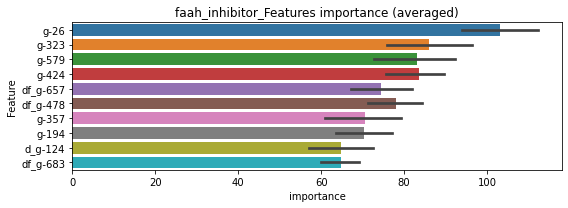

len(train_index) : 3892
len(valid_index) : 3893
================================= fold 1/2 faah_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0199924	valid_1's binary_logloss: 0.038012
[200]	training's binary_logloss: 0.00316391	valid_1's binary_logloss: 0.016225
[300]	training's binary_logloss: 0.00088746	valid_1's binary_logloss: 0.0129469
Early stopping, best iteration is:
[383]	training's binary_logloss: 0.00046857	valid_1's binary_logloss: 0.0126127


len(train_index) : 3893
len(valid_index) : 3892
================================= fold 2/2 faah_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.021425	valid_1's binary_logloss: 0.0367275
[200]	training's binary_logloss: 0.0034078	valid_1's binary_logloss: 0.0136414
[300]	training's binary_logloss: 0.000939371	valid_1's binary_logloss: 0.00901152
[400]	training's binary_logloss: 0.000443622	valid_1's binary_logloss: 0.00784955
Early stopping, best iteration is:
[409]	training's binary_logloss: 0.00042295	valid_1's binary_logloss: 0.00781286


faah_inhibitor logloss: 0.010213088163294004
farnesyltransferase_inhibitor, len(trt): 18, len(othr): 3286, target_rate: 0.0007559 → Adj_target_rate: 0.0009799


neg labels: 3289 → selected neg labels: 3286


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0183663	valid_1's binary_logloss: 0.0211537
[200]	training's binary_logloss: 0.00176758	valid_1's binary_logloss: 0.00292797
[300]	training's binary_logloss: 0.00048747	valid_1's binary_logloss: 0.00115573
[400]	training's binary_logloss: 0.000281486	valid_1's binary_logloss: 0.000827023
[500]	training's binary_logloss: 0.000239936	valid_1's binary_logloss: 0.000769704
Early stopping, best iteration is:
[569]	training's binary_logloss: 0.000233764	valid_1's binary_logloss: 0.000758062
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0183272	valid_1's binary_logloss: 0.0213977
[200]	training's binary_logloss: 0.00178585	valid_1's binary_logloss: 0.00324539
[300]	training's binary_logloss: 0.000492768	valid_1's binary_logloss: 0.00158014
[400]	training's binary_logloss: 0.000282677	valid_1's binary_logloss: 0.00122134
[500]	training's binary_loglo

1 / 3 AUC score:1.000
Threshold: 0.0010911, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → positive_corect_labels: 657/3811
p_label_rate: 0.0426921 Vs.target_rate: 0.00076, Num_p_label: 170.0, conf_0:0.00010, conf_1:0.00120
Num_p_label: 170.0, Expected: 3.0, Adj_threshold_1: 0.0010911
Num_p_label: 46.0, Expected: 3.0, Adj_threshold_2: 0.0060911
Num_p_label: 29.0, Expected: 3.0, Adj_threshold_3: 0.0110911
Num_p_label: 21.0, Expected: 3.0, Adj_threshold_4: 0.0160911
Num_p_label: 19.0, Expected: 3.0, Adj_threshold_5: 0.0210911
Num_p_label: 18.0, Expected: 3.0, Adj_threshold_6: 0.0260911
Num_p_label: 15.0, Expected: 3.0, Adj_threshold_7: 0.0310911
Num_p_label: 9.0, Expected: 3.0, Adj_threshold_8: 0.0360911
Num_p_label: 8.0, Expected: 3.0, Adj_threshold_9: 0.0410911
Num_p_label: 6.0, Expected: 3.0, Adj_threshold_10: 0.0460911
threshold: 0.0460911, positive p_label: 6.0/3982, p_label_rate: 0.0015068
positive y_label: 657.0/3811, y_label_rate: 0.1723957
================= Pseudo labeling 

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0184147	valid_1's binary_logloss: 0.0204555
[200]	training's binary_logloss: 0.00171618	valid_1's binary_logloss: 0.0023992
[300]	training's binary_logloss: 0.000461501	valid_1's binary_logloss: 0.000767754
[400]	training's binary_logloss: 0.000270406	valid_1's binary_logloss: 0.000495981
[500]	training's binary_logloss: 0.00022966	valid_1's binary_logloss: 0.000435408
Early stopping, best iteration is:
[546]	training's binary_logloss: 0.000227642	valid_1's binary_logloss: 0.000432196
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.018472	valid_1's binary_logloss: 0.0216
[200]	training's binary_logloss: 0.00171907	valid_1's binary_logloss: 0.00316487
[300]	training's binary_logloss: 0.000458044	valid_1's binary_logloss: 0.00159201
[400]	training's binary_logloss: 0.000266129	valid_1's binary_logloss: 0.00131363
Early stopping, best iteration is

2 / 3 AUC score:1.000
Threshold: 0.0460911, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → positive_corect_labels: 657.0/3811
p_label_rate: 0.0115520 Vs.target_rate: 0.00076, Num_p_label: 46.0, conf_0:0.00012, conf_1:0.05070
Num_p_label: 46.0, Expected: 3.0, Adj_threshold_1: 0.0460911
Num_p_label: 43.0, Expected: 3.0, Adj_threshold_2: 0.0510911
Num_p_label: 40.0, Expected: 3.0, Adj_threshold_3: 0.0560911
Num_p_label: 36.0, Expected: 3.0, Adj_threshold_4: 0.0610911
Num_p_label: 31.0, Expected: 3.0, Adj_threshold_5: 0.0660911
Num_p_label: 30.0, Expected: 3.0, Adj_threshold_6: 0.0710911
Num_p_label: 29.0, Expected: 3.0, Adj_threshold_7: 0.0760911
Num_p_label: 29.0, Expected: 3.0, Adj_threshold_8: 0.0810911
Num_p_label: 29.0, Expected: 3.0, Adj_threshold_9: 0.0860911
Num_p_label: 26.0, Expected: 3.0, Adj_threshold_10: 0.0910911
threshold: 0.0960911, positive p_label: 23.0/3982, p_label_rate: 0.0057760
positive y_label: 657.0/3811, y_label_rate: 0.1723957
================= Pseudo labelin

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0184147	valid_1's binary_logloss: 0.0204555
[200]	training's binary_logloss: 0.00171618	valid_1's binary_logloss: 0.0023992
[300]	training's binary_logloss: 0.000461501	valid_1's binary_logloss: 0.000767754
[400]	training's binary_logloss: 0.000270406	valid_1's binary_logloss: 0.000495981
[500]	training's binary_logloss: 0.00022966	valid_1's binary_logloss: 0.000435408
Early stopping, best iteration is:
[546]	training's binary_logloss: 0.000227642	valid_1's binary_logloss: 0.000432196
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.018472	valid_1's binary_logloss: 0.0216
[200]	training's binary_logloss: 0.00171907	valid_1's binary_logloss: 0.00316487
[300]	training's binary_logloss: 0.000458044	valid_1's binary_logloss: 0.00159201
[400]	training's binary_logloss: 0.000266129	valid_1's binary_logloss: 0.00131363
Early stopping, best iteration is

3 / 3 AUC score:1.000
Threshold: 0.0960911, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → positive_corect_labels: 657.0/3811
p_label_rate: 0.0057760 Vs.target_rate: 0.00076, Num_p_label: 23.0, conf_0:0.00012, conf_1:0.10570
Num_p_label: 23.0, Expected: 3.0, Adj_threshold_1: 0.0960911
Num_p_label: 23.0, Expected: 3.0, Adj_threshold_2: 0.1010911
Num_p_label: 22.0, Expected: 3.0, Adj_threshold_3: 0.1060911
Num_p_label: 21.0, Expected: 3.0, Adj_threshold_4: 0.1110911
Num_p_label: 21.0, Expected: 3.0, Adj_threshold_5: 0.1160911
Num_p_label: 21.0, Expected: 3.0, Adj_threshold_6: 0.1210911
Num_p_label: 21.0, Expected: 3.0, Adj_threshold_7: 0.1260911
Num_p_label: 21.0, Expected: 3.0, Adj_threshold_8: 0.1310911
Num_p_label: 21.0, Expected: 3.0, Adj_threshold_9: 0.1360911
Num_p_label: 21.0, Expected: 3.0, Adj_threshold_10: 0.1410911
threshold: 0.1460911, positive p_label: 19.0/3982, p_label_rate: 0.0047715
positive y_label: 676.0/7793, y_label_rate: 0.0867445


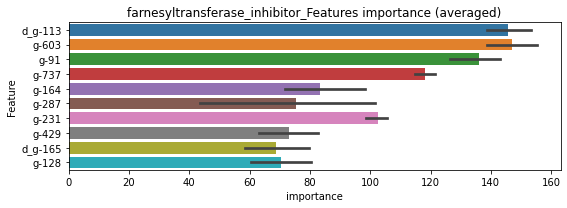

len(train_index) : 3896
len(valid_index) : 3897
================================= fold 1/2 farnesyltransferase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0105415	valid_1's binary_logloss: 0.0198419
[200]	training's binary_logloss: 0.00106103	valid_1's binary_logloss: 0.00867214
[300]	training's binary_logloss: 0.000290317	valid_1's binary_logloss: 0.00699894
Early stopping, best iteration is:
[321]	training's binary_logloss: 0.000244782	valid_1's binary_logloss: 0.00679297


len(train_index) : 3897
len(valid_index) : 3896
================================= fold 2/2 farnesyltransferase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0104952	valid_1's binary_logloss: 0.0143581
[200]	training's binary_logloss: 0.00105582	valid_1's binary_logloss: 0.00431239
[300]	training's binary_logloss: 0.000291473	valid_1's binary_logloss: 0.00325574
Early stopping, best iteration is:
[340]	training's binary_logloss: 0.000218996	valid_1's binary_logloss: 0.00312059


farnesyltransferase_inhibitor logloss: 0.004957017710987274
fatty_acid_receptor_agonist, len(trt): 25, len(othr): 3285, target_rate: 0.0010498 → Adj_target_rate: 0.0012955


neg labels: 3289 → selected neg labels: 3285


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0288951	valid_1's binary_logloss: 0.0433291
[200]	training's binary_logloss: 0.00391696	valid_1's binary_logloss: 0.0105881
[300]	training's binary_logloss: 0.00109777	valid_1's binary_logloss: 0.00499538
[400]	training's binary_logloss: 0.000554011	valid_1's binary_logloss: 0.00357293
[500]	training's binary_logloss: 0.000403673	valid_1's binary_logloss: 0.00314986
Early stopping, best iteration is:
[522]	training's binary_logloss: 0.000395041	valid_1's binary_logloss: 0.0031347
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0300329	valid_1's binary_logloss: 0.0397602
[200]	training's binary_logloss: 0.00417274	valid_1's binary_logloss: 0.00836077
[300]	training's binary_logloss: 0.00116751	valid_1's binary_logloss: 0.00323608
[400]	training's binary_logloss: 0.00058749	valid_1's binary_logloss: 0.00197421
[500]	training's binary_logloss: 0.0

1 / 3 AUC score:1.000
Threshold: 0.0025776, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → positive_corect_labels: 657/3810
p_label_rate: 0.0409342 Vs.target_rate: 0.00105, Num_p_label: 163.0, conf_0:0.00027, conf_1:0.00284
Num_p_label: 163.0, Expected: 4.2, Adj_threshold_1: 0.0025776
Num_p_label: 35.0, Expected: 4.2, Adj_threshold_2: 0.0075776
Num_p_label: 15.0, Expected: 4.2, Adj_threshold_3: 0.0125776
Num_p_label: 8.0, Expected: 4.2, Adj_threshold_4: 0.0175776
threshold: 0.0175776, positive p_label: 8.0/3982, p_label_rate: 0.0020090
positive y_label: 657.0/3810, y_label_rate: 0.1724409
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0285838	valid_1's binary_logloss: 0.0425942
[200]	training's binary_logloss: 0.00370589	valid_1's binary_logloss: 0.00977594
[300]	training's binary_logloss: 0.00105362	valid_1's binary_logloss: 0.00450662
[400]	training's binary_logloss: 0.000543442	valid_1's binary_logloss: 0.0031786
[500]	training's binary_logloss: 0.000401332	valid_1's binary_logloss: 0.00277791
Early stopping, best iteration is:
[535]	training's binary_logloss: 0.000385397	valid_1's binary_logloss: 0.0027305
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0291495	valid_1's binary_logloss: 0.036841
[200]	training's binary_logloss: 0.00391955	valid_1's binary_logloss: 0.00707353
[300]	training's binary_logloss: 0.00110828	valid_1's binary_logloss: 0.00268472
[400]	training's binary_logloss: 0.000565508	valid_1's binary_logloss: 0.00164477
[500]	training's binary_logloss: 0.0

2 / 3 AUC score:1.000
Threshold: 0.0175776, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 1 → positive_corect_labels: 657.0/3809
p_label_rate: 0.0095429 Vs.target_rate: 0.00105, Num_p_label: 38.0, conf_0:0.00029, conf_1:0.01934
Num_p_label: 38.0, Expected: 4.2, Adj_threshold_1: 0.0175776
Num_p_label: 26.0, Expected: 4.2, Adj_threshold_2: 0.0225776
Num_p_label: 20.0, Expected: 4.2, Adj_threshold_3: 0.0275776
Num_p_label: 14.0, Expected: 4.2, Adj_threshold_4: 0.0325776
Num_p_label: 10.0, Expected: 4.2, Adj_threshold_5: 0.0375776
Num_p_label: 8.0, Expected: 4.2, Adj_threshold_6: 0.0425776
threshold: 0.0425776, positive p_label: 8.0/3982, p_label_rate: 0.0020090
positive y_label: 657.0/3809, y_label_rate: 0.1724862
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0284042	valid_1's binary_logloss: 0.0411327
[200]	training's binary_logloss: 0.00372948	valid_1's binary_logloss: 0.00970187
[300]	training's binary_logloss: 0.00107037	valid_1's binary_logloss: 0.00477561
[400]	training's binary_logloss: 0.000550374	valid_1's binary_logloss: 0.00340524
[500]	training's binary_logloss: 0.000403782	valid_1's binary_logloss: 0.00300988
Early stopping, best iteration is:
[581]	training's binary_logloss: 0.000381798	valid_1's binary_logloss: 0.00295124
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0291481	valid_1's binary_logloss: 0.0369538
[200]	training's binary_logloss: 0.00388005	valid_1's binary_logloss: 0.0070653
[300]	training's binary_logloss: 0.00109493	valid_1's binary_logloss: 0.00267836
[400]	training's binary_logloss: 0.000560721	valid_1's binary_logloss: 0.00162763
[500]	training's binary_logloss: 0

3 / 3 AUC score:1.000
Threshold: 0.0425776, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → positive_corect_labels: 657.0/3809
p_label_rate: 0.0025113 Vs.target_rate: 0.00105, Num_p_label: 10.0, conf_0:0.00029, conf_1:0.04684
threshold: 0.0425776, positive p_label: 10.0/3982, p_label_rate: 0.0025113
positive y_label: 667.0/7791, y_label_rate: 0.0856116


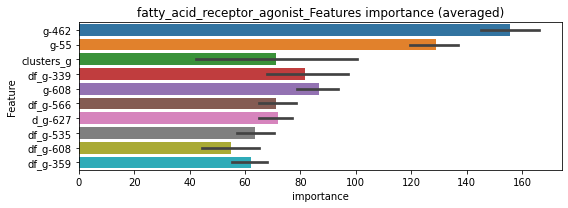

len(train_index) : 3895
len(valid_index) : 3896
================================= fold 1/2 fatty_acid_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.016077	valid_1's binary_logloss: 0.0260265
[200]	training's binary_logloss: 0.00212848	valid_1's binary_logloss: 0.0105609
[300]	training's binary_logloss: 0.000586549	valid_1's binary_logloss: 0.00912234
Early stopping, best iteration is:
[296]	training's binary_logloss: 0.000610247	valid_1's binary_logloss: 0.0091076


len(train_index) : 3896
len(valid_index) : 3895
================================= fold 2/2 fatty_acid_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0166073	valid_1's binary_logloss: 0.0249959
[200]	training's binary_logloss: 0.00233921	valid_1's binary_logloss: 0.00706496
[300]	training's binary_logloss: 0.00065636	valid_1's binary_logloss: 0.00467432
[400]	training's binary_logloss: 0.000323296	valid_1's binary_logloss: 0.00425924
Early stopping, best iteration is:
[391]	training's binary_logloss: 0.000340895	valid_1's binary_logloss: 0.00425741


fatty_acid_receptor_agonist logloss: 0.0066828157718301475
fgfr_inhibitor, len(trt): 50, len(othr): 3279, target_rate: 0.0020996 → Adj_target_rate: 0.0023352


neg labels: 3289 → selected neg labels: 3279


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0356141	valid_1's binary_logloss: 0.0574598
[200]	training's binary_logloss: 0.00574307	valid_1's binary_logloss: 0.0169254
[300]	training's binary_logloss: 0.0016908	valid_1's binary_logloss: 0.00909146
[400]	training's binary_logloss: 0.000838322	valid_1's binary_logloss: 0.00673703
[500]	training's binary_logloss: 0.000556613	valid_1's binary_logloss: 0.00589278
Early stopping, best iteration is:
[505]	training's binary_logloss: 0.000549306	valid_1's binary_logloss: 0.00581714
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0349744	valid_1's binary_logloss: 0.0603602
[200]	training's binary_logloss: 0.00554455	valid_1's binary_logloss: 0.0196196
[300]	training's binary_logloss: 0.00162162	valid_1's binary_logloss: 0.011258
[400]	training's binary_logloss: 0.000803714	valid_1's binary_logloss: 0.00866967
[500]	training's binary_logloss: 0.000

1 / 3 AUC score:1.000
Threshold: 0.0052619, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → positive_corect_labels: 655/3802
p_label_rate: 0.0462079 Vs.target_rate: 0.00210, Num_p_label: 184.0, conf_0:0.00037, conf_1:0.00579
Num_p_label: 184.0, Expected: 8.4, Adj_threshold_1: 0.0052619
Num_p_label: 99.0, Expected: 8.4, Adj_threshold_2: 0.0102619
Num_p_label: 82.0, Expected: 8.4, Adj_threshold_3: 0.0152619
Num_p_label: 63.0, Expected: 8.4, Adj_threshold_4: 0.0202619
Num_p_label: 54.0, Expected: 8.4, Adj_threshold_5: 0.0252619
Num_p_label: 47.0, Expected: 8.4, Adj_threshold_6: 0.0302619
Num_p_label: 38.0, Expected: 8.4, Adj_threshold_7: 0.0352619
Num_p_label: 33.0, Expected: 8.4, Adj_threshold_8: 0.0402619
Num_p_label: 32.0, Expected: 8.4, Adj_threshold_9: 0.0452619
Num_p_label: 29.0, Expected: 8.4, Adj_threshold_10: 0.0502619
threshold: 0.0552619, positive p_label: 27.0/3982, p_label_rate: 0.0067805
positive y_label: 655.0/3802, y_label_rate: 0.1722777
================= Pseudo label

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.034114	valid_1's binary_logloss: 0.0538329
[200]	training's binary_logloss: 0.00524629	valid_1's binary_logloss: 0.015849
[300]	training's binary_logloss: 0.00150485	valid_1's binary_logloss: 0.0080512
[400]	training's binary_logloss: 0.000761458	valid_1's binary_logloss: 0.00627041
[500]	training's binary_logloss: 0.000514115	valid_1's binary_logloss: 0.0052486
Early stopping, best iteration is:
[530]	training's binary_logloss: 0.000483573	valid_1's binary_logloss: 0.00516197
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0331647	valid_1's binary_logloss: 0.0577362
[200]	training's binary_logloss: 0.00502268	valid_1's binary_logloss: 0.0179575
[300]	training's binary_logloss: 0.00143015	valid_1's binary_logloss: 0.00970367
[400]	training's binary_logloss: 0.000713987	valid_1's binary_logloss: 0.00745502
[500]	training's binary_logloss: 0.0005

2 / 3 AUC score:1.000
Threshold: 0.0552619, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 4 → positive_corect_labels: 655.0/3798
p_label_rate: 0.0203415 Vs.target_rate: 0.00210, Num_p_label: 81.0, conf_0:0.00044, conf_1:0.06079
Num_p_label: 81.0, Expected: 8.4, Adj_threshold_1: 0.0552619
Num_p_label: 76.0, Expected: 8.4, Adj_threshold_2: 0.0602619
Num_p_label: 73.0, Expected: 8.4, Adj_threshold_3: 0.0652619
Num_p_label: 70.0, Expected: 8.4, Adj_threshold_4: 0.0702619
Num_p_label: 67.0, Expected: 8.4, Adj_threshold_5: 0.0752619
Num_p_label: 65.0, Expected: 8.4, Adj_threshold_6: 0.0802619
Num_p_label: 62.0, Expected: 8.4, Adj_threshold_7: 0.0852619
Num_p_label: 62.0, Expected: 8.4, Adj_threshold_8: 0.0902619
Num_p_label: 60.0, Expected: 8.4, Adj_threshold_9: 0.0952619
Num_p_label: 59.0, Expected: 8.4, Adj_threshold_10: 0.1002619
threshold: 0.1052619, positive p_label: 57.0/3982, p_label_rate: 0.0143144
positive y_label: 655.0/3798, y_label_rate: 0.1724592
================= Pseudo labelin

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0335791	valid_1's binary_logloss: 0.0532632
[200]	training's binary_logloss: 0.00509202	valid_1's binary_logloss: 0.0156597
[300]	training's binary_logloss: 0.00149671	valid_1's binary_logloss: 0.00886656
[400]	training's binary_logloss: 0.000743574	valid_1's binary_logloss: 0.00641302
[500]	training's binary_logloss: 0.000509453	valid_1's binary_logloss: 0.00554625
Early stopping, best iteration is:
[527]	training's binary_logloss: 0.00048073	valid_1's binary_logloss: 0.00545154
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0337787	valid_1's binary_logloss: 0.0577412
[200]	training's binary_logloss: 0.00510898	valid_1's binary_logloss: 0.0182775
[300]	training's binary_logloss: 0.0014478	valid_1's binary_logloss: 0.00967209
[400]	training's binary_logloss: 0.000727502	valid_1's binary_logloss: 0.00751143
[500]	training's binary_logloss: 0.00

3 / 3 AUC score:1.000
Threshold: 0.1052619, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 2 → positive_corect_labels: 655.0/3796
p_label_rate: 0.0143144 Vs.target_rate: 0.00210, Num_p_label: 57.0, conf_0:0.00045, conf_1:0.11579
Num_p_label: 57.0, Expected: 8.4, Adj_threshold_1: 0.1052619
Num_p_label: 55.0, Expected: 8.4, Adj_threshold_2: 0.1102619
Num_p_label: 53.0, Expected: 8.4, Adj_threshold_3: 0.1152619
Num_p_label: 53.0, Expected: 8.4, Adj_threshold_4: 0.1202619
Num_p_label: 52.0, Expected: 8.4, Adj_threshold_5: 0.1252619
Num_p_label: 50.0, Expected: 8.4, Adj_threshold_6: 0.1302619
Num_p_label: 50.0, Expected: 8.4, Adj_threshold_7: 0.1352619
Num_p_label: 49.0, Expected: 8.4, Adj_threshold_8: 0.1402619
Num_p_label: 49.0, Expected: 8.4, Adj_threshold_9: 0.1452619
Num_p_label: 49.0, Expected: 8.4, Adj_threshold_10: 0.1502619
threshold: 0.1552619, positive p_label: 48.0/3982, p_label_rate: 0.0120542
positive y_label: 703.0/7778, y_label_rate: 0.0903831


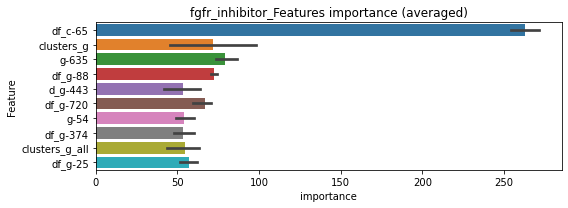

len(train_index) : 3889
len(valid_index) : 3889
================================= fold 1/2 fgfr_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0197888	valid_1's binary_logloss: 0.0414569
[200]	training's binary_logloss: 0.00317995	valid_1's binary_logloss: 0.0208051
[300]	training's binary_logloss: 0.000939077	valid_1's binary_logloss: 0.0166394
Early stopping, best iteration is:
[339]	training's binary_logloss: 0.000689138	valid_1's binary_logloss: 0.0160648


len(train_index) : 3889
len(valid_index) : 3889
================================= fold 2/2 fgfr_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0189561	valid_1's binary_logloss: 0.0394547
[200]	training's binary_logloss: 0.00295906	valid_1's binary_logloss: 0.020437
[300]	training's binary_logloss: 0.000874931	valid_1's binary_logloss: 0.015805
[400]	training's binary_logloss: 0.000443373	valid_1's binary_logloss: 0.0147827
[500]	training's binary_logloss: 0.00029882	valid_1's binary_logloss: 0.0141273
Early stopping, best iteration is:
[505]	training's binary_logloss: 0.00029513	valid_1's binary_logloss: 0.0141033


fgfr_inhibitor logloss: 0.015084046842605604
flt3_inhibitor, len(trt): 279, len(othr): 3272, target_rate: 0.0117158 → Adj_target_rate: 0.0100684


neg labels: 3289 → selected neg labels: 3272


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0560213	valid_1's binary_logloss: 0.152085
[200]	training's binary_logloss: 0.0128277	valid_1's binary_logloss: 0.122573
Early stopping, best iteration is:
[237]	training's binary_logloss: 0.00791703	valid_1's binary_logloss: 0.119469
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0562948	valid_1's binary_logloss: 0.155041
[200]	training's binary_logloss: 0.0126198	valid_1's binary_logloss: 0.127681
Early stopping, best iteration is:
[250]	training's binary_logloss: 0.00678212	valid_1's binary_logloss: 0.125379


1 / 3 AUC score:0.977
Threshold: 0.0639045, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 224 → positive_corect_labels: 608/3702
p_label_rate: 0.0763435 Vs.target_rate: 0.01172, Num_p_label: 304.0, conf_0:0.00675, conf_1:0.07029
Num_p_label: 304.0, Expected: 46.7, Adj_threshold_1: 0.0639045
Num_p_label: 271.0, Expected: 46.7, Adj_threshold_2: 0.0689045
Num_p_label: 249.0, Expected: 46.7, Adj_threshold_3: 0.0739045
Num_p_label: 232.0, Expected: 46.7, Adj_threshold_4: 0.0789045
Num_p_label: 211.0, Expected: 46.7, Adj_threshold_5: 0.0839045
Num_p_label: 201.0, Expected: 46.7, Adj_threshold_6: 0.0889045
Num_p_label: 194.0, Expected: 46.7, Adj_threshold_7: 0.0939045
Num_p_label: 178.0, Expected: 46.7, Adj_threshold_8: 0.0989045
Num_p_label: 169.0, Expected: 46.7, Adj_threshold_9: 0.1039045
Num_p_label: 160.0, Expected: 46.7, Adj_threshold_10: 0.1089045
threshold: 0.1139045, positive p_label: 153.0/3982, p_label_rate: 0.0384229
positive y_label: 608.0/3702, y_label_rate: 0.1642355
==========

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0426471	valid_1's binary_logloss: 0.110299
[200]	training's binary_logloss: 0.00807777	valid_1's binary_logloss: 0.0767185
Early stopping, best iteration is:
[253]	training's binary_logloss: 0.00394748	valid_1's binary_logloss: 0.0718646
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0446434	valid_1's binary_logloss: 0.112004
[200]	training's binary_logloss: 0.00838276	valid_1's binary_logloss: 0.076492
Early stopping, best iteration is:
[264]	training's binary_logloss: 0.00366116	valid_1's binary_logloss: 0.0711497


2 / 3 AUC score:0.994
Threshold: 0.1139045, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 82 → positive_corect_labels: 572.0/3620
p_label_rate: 0.0781015 Vs.target_rate: 0.01172, Num_p_label: 311.0, conf_0:0.00371, conf_1:0.12529
Num_p_label: 311.0, Expected: 46.7, Adj_threshold_1: 0.1139045
Num_p_label: 302.0, Expected: 46.7, Adj_threshold_2: 0.1189045
Num_p_label: 294.0, Expected: 46.7, Adj_threshold_3: 0.1239045
Num_p_label: 292.0, Expected: 46.7, Adj_threshold_4: 0.1289045
Num_p_label: 285.0, Expected: 46.7, Adj_threshold_5: 0.1339045
Num_p_label: 277.0, Expected: 46.7, Adj_threshold_6: 0.1389045
Num_p_label: 269.0, Expected: 46.7, Adj_threshold_7: 0.1439045
Num_p_label: 263.0, Expected: 46.7, Adj_threshold_8: 0.1489045
Num_p_label: 259.0, Expected: 46.7, Adj_threshold_9: 0.1539045
Num_p_label: 255.0, Expected: 46.7, Adj_threshold_10: 0.1589045
threshold: 0.1639045, positive p_label: 251.0/3982, p_label_rate: 0.0630337
positive y_label: 572.0/3620, y_label_rate: 0.1580110
=========

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0383311	valid_1's binary_logloss: 0.0837365
[200]	training's binary_logloss: 0.00697888	valid_1's binary_logloss: 0.0426655
[300]	training's binary_logloss: 0.00208102	valid_1's binary_logloss: 0.0315755
Early stopping, best iteration is:
[371]	training's binary_logloss: 0.0012009	valid_1's binary_logloss: 0.0292383
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0385413	valid_1's binary_logloss: 0.0845228
[200]	training's binary_logloss: 0.00696763	valid_1's binary_logloss: 0.0444796
[300]	training's binary_logloss: 0.00202871	valid_1's binary_logloss: 0.0330269
[400]	training's binary_logloss: 0.00098007	valid_1's binary_logloss: 0.0292784
[500]	training's binary_logloss: 0.000643879	valid_1's binary_logloss: 0.0278147
Early stopping, best iteration is:
[490]	training's binary_logloss: 0.000665612	valid_1's binary_logloss: 0.0277152


3 / 3 AUC score:1.000
Threshold: 0.1639045, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 11 → positive_corect_labels: 563.0/3609
p_label_rate: 0.0507283 Vs.target_rate: 0.01172, Num_p_label: 202.0, conf_0:0.00076, conf_1:0.18029
Num_p_label: 202.0, Expected: 46.7, Adj_threshold_1: 0.1639045
Num_p_label: 199.0, Expected: 46.7, Adj_threshold_2: 0.1689045
Num_p_label: 196.0, Expected: 46.7, Adj_threshold_3: 0.1739045
Num_p_label: 194.0, Expected: 46.7, Adj_threshold_4: 0.1789045
Num_p_label: 192.0, Expected: 46.7, Adj_threshold_5: 0.1839045
Num_p_label: 188.0, Expected: 46.7, Adj_threshold_6: 0.1889045
Num_p_label: 183.0, Expected: 46.7, Adj_threshold_7: 0.1939045
Num_p_label: 181.0, Expected: 46.7, Adj_threshold_8: 0.1989045
Num_p_label: 178.0, Expected: 46.7, Adj_threshold_9: 0.2039045
Num_p_label: 176.0, Expected: 46.7, Adj_threshold_10: 0.2089045
threshold: 0.2139045, positive p_label: 176.0/3982, p_label_rate: 0.0441989
positive y_label: 739.0/7591, y_label_rate: 0.0973521


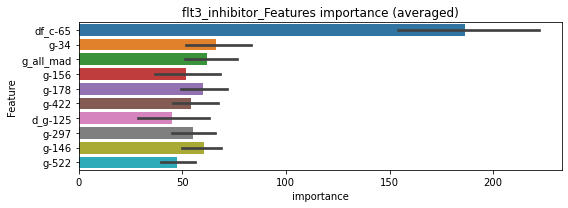

len(train_index) : 3795
len(valid_index) : 3796
================================= fold 1/2 flt3_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0286568	valid_1's binary_logloss: 0.0693295
[200]	training's binary_logloss: 0.00569444	valid_1's binary_logloss: 0.0475039
[300]	training's binary_logloss: 0.00180131	valid_1's binary_logloss: 0.0434858
Early stopping, best iteration is:
[294]	training's binary_logloss: 0.00188513	valid_1's binary_logloss: 0.0434006


len(train_index) : 3796
len(valid_index) : 3795
================================= fold 2/2 flt3_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0270001	valid_1's binary_logloss: 0.0733803
[200]	training's binary_logloss: 0.00499553	valid_1's binary_logloss: 0.0498428
[300]	training's binary_logloss: 0.00155035	valid_1's binary_logloss: 0.0449447
Early stopping, best iteration is:
[351]	training's binary_logloss: 0.00103449	valid_1's binary_logloss: 0.0443166


flt3_inhibitor logloss: 0.04385853448529506


  acetylcholine_receptor_agonist acetylcholine_receptor_antagonist  \
0                       df_g-122                              c-30   
1                  clusters_df_c                         c_all_max   
2                          cnt_0                    clusters_g_all   
3                      c_all_min                          df_g-707   
4                        df_g-51                        clusters_g   
5                       df_c_min                          df_c_min   
6                          cnt_2                             g-514   
7                       df_g-736                          df_g-640   
8                          g-244                            df_c-6   
9                           c-73                          df_g-597   

  acetylcholinesterase_inhibitor adenosine_receptor_antagonist  \
0                      c_all_max                clusters_c_all   
1                      c_all_min                      df_c_min   
2                 clusters_g_al

focal_adhesion_kinase_inhibitor, len(trt): 18, len(othr): 3286, target_rate: 0.0007559 → Adj_target_rate: 0.0009799


neg labels: 3289 → selected neg labels: 3286


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0185224	valid_1's binary_logloss: 0.0221357
[200]	training's binary_logloss: 0.00181056	valid_1's binary_logloss: 0.00443986
[300]	training's binary_logloss: 0.000482089	valid_1's binary_logloss: 0.00251449
[400]	training's binary_logloss: 0.000280671	valid_1's binary_logloss: 0.00222348
Early stopping, best iteration is:
[456]	training's binary_logloss: 0.000248885	valid_1's binary_logloss: 0.00212617
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0184857	valid_1's binary_logloss: 0.0221643
[200]	training's binary_logloss: 0.00182039	valid_1's binary_logloss: 0.00335091
[300]	training's binary_logloss: 0.000502959	valid_1's binary_logloss: 0.00148964
[400]	training's binary_logloss: 0.000286204	valid_1's binary_logloss: 0.00113168
[500]	training's binary_logloss: 0.000244159	valid_1's binary_logloss: 0.00104349
Early stopping, best iteration 

1 / 3 AUC score:1.000
Threshold: 0.0011364, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → positive_corect_labels: 657/3811
p_label_rate: 0.0507283 Vs.target_rate: 0.00076, Num_p_label: 202.0, conf_0:0.00009, conf_1:0.00125
Num_p_label: 202.0, Expected: 3.0, Adj_threshold_1: 0.0011364
Num_p_label: 59.0, Expected: 3.0, Adj_threshold_2: 0.0061364
Num_p_label: 42.0, Expected: 3.0, Adj_threshold_3: 0.0111364
Num_p_label: 33.0, Expected: 3.0, Adj_threshold_4: 0.0161364
Num_p_label: 24.0, Expected: 3.0, Adj_threshold_5: 0.0211364
Num_p_label: 23.0, Expected: 3.0, Adj_threshold_6: 0.0261364
Num_p_label: 21.0, Expected: 3.0, Adj_threshold_7: 0.0311364
Num_p_label: 15.0, Expected: 3.0, Adj_threshold_8: 0.0361364
Num_p_label: 13.0, Expected: 3.0, Adj_threshold_9: 0.0411364
Num_p_label: 13.0, Expected: 3.0, Adj_threshold_10: 0.0461364
threshold: 0.0511364, positive p_label: 13.0/3982, p_label_rate: 0.0032647
positive y_label: 657.0/3811, y_label_rate: 0.1723957
================= Pseudo label

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0179002	valid_1's binary_logloss: 0.0202074
[200]	training's binary_logloss: 0.00166054	valid_1's binary_logloss: 0.0024214
[300]	training's binary_logloss: 0.000427652	valid_1's binary_logloss: 0.000753678
[400]	training's binary_logloss: 0.000248543	valid_1's binary_logloss: 0.000476189
Early stopping, best iteration is:
[488]	training's binary_logloss: 0.000216623	valid_1's binary_logloss: 0.000426864
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0182	valid_1's binary_logloss: 0.0209821
[200]	training's binary_logloss: 0.0016692	valid_1's binary_logloss: 0.00239026
[300]	training's binary_logloss: 0.000438268	valid_1's binary_logloss: 0.00082351
[400]	training's binary_logloss: 0.000254653	valid_1's binary_logloss: 0.000512838
[500]	training's binary_logloss: 0.000217786	valid_1's binary_logloss: 0.00045579
Early stopping, best iteration i

2 / 3 AUC score:1.000
Threshold: 0.0511364, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 1 → positive_corect_labels: 657.0/3810
p_label_rate: 0.0120542 Vs.target_rate: 0.00076, Num_p_label: 48.0, conf_0:0.00010, conf_1:0.05625
Num_p_label: 48.0, Expected: 3.0, Adj_threshold_1: 0.0511364
Num_p_label: 47.0, Expected: 3.0, Adj_threshold_2: 0.0561364
Num_p_label: 45.0, Expected: 3.0, Adj_threshold_3: 0.0611364
Num_p_label: 43.0, Expected: 3.0, Adj_threshold_4: 0.0661364
Num_p_label: 41.0, Expected: 3.0, Adj_threshold_5: 0.0711364
Num_p_label: 38.0, Expected: 3.0, Adj_threshold_6: 0.0761364
Num_p_label: 38.0, Expected: 3.0, Adj_threshold_7: 0.0811364
Num_p_label: 37.0, Expected: 3.0, Adj_threshold_8: 0.0861364
Num_p_label: 35.0, Expected: 3.0, Adj_threshold_9: 0.0911364
Num_p_label: 34.0, Expected: 3.0, Adj_threshold_10: 0.0961364
threshold: 0.1011364, positive p_label: 32.0/3982, p_label_rate: 0.0080362
positive y_label: 657.0/3810, y_label_rate: 0.1724409
================= Pseudo labelin

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.01786	valid_1's binary_logloss: 0.0202853
[200]	training's binary_logloss: 0.00165256	valid_1's binary_logloss: 0.00255832
[300]	training's binary_logloss: 0.000425568	valid_1's binary_logloss: 0.000860212
[400]	training's binary_logloss: 0.000249129	valid_1's binary_logloss: 0.000551524
Early stopping, best iteration is:
[488]	training's binary_logloss: 0.00021631	valid_1's binary_logloss: 0.000497384
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0182905	valid_1's binary_logloss: 0.0211154
[200]	training's binary_logloss: 0.00170685	valid_1's binary_logloss: 0.00313634
[300]	training's binary_logloss: 0.000436226	valid_1's binary_logloss: 0.00131707
[400]	training's binary_logloss: 0.000253802	valid_1's binary_logloss: 0.00102071
[500]	training's binary_logloss: 0.00022079	valid_1's binary_logloss: 0.000987776
Early stopping, best iteration 

3 / 3 AUC score:1.000
Threshold: 0.1011364, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → positive_corect_labels: 657.0/3810
p_label_rate: 0.0080362 Vs.target_rate: 0.00076, Num_p_label: 32.0, conf_0:0.00010, conf_1:0.11125
Num_p_label: 32.0, Expected: 3.0, Adj_threshold_1: 0.1011364
Num_p_label: 32.0, Expected: 3.0, Adj_threshold_2: 0.1061364
Num_p_label: 31.0, Expected: 3.0, Adj_threshold_3: 0.1111364
Num_p_label: 31.0, Expected: 3.0, Adj_threshold_4: 0.1161364
Num_p_label: 31.0, Expected: 3.0, Adj_threshold_5: 0.1211364
Num_p_label: 30.0, Expected: 3.0, Adj_threshold_6: 0.1261364
Num_p_label: 29.0, Expected: 3.0, Adj_threshold_7: 0.1311364
Num_p_label: 28.0, Expected: 3.0, Adj_threshold_8: 0.1361364
Num_p_label: 28.0, Expected: 3.0, Adj_threshold_9: 0.1411364
Num_p_label: 27.0, Expected: 3.0, Adj_threshold_10: 0.1461364
threshold: 0.1511364, positive p_label: 27.0/3982, p_label_rate: 0.0067805
positive y_label: 684.0/7792, y_label_rate: 0.0877823


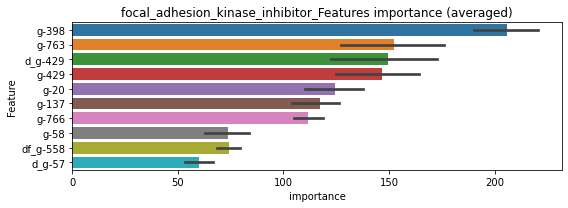

len(train_index) : 3896
len(valid_index) : 3896
================================= fold 1/2 focal_adhesion_kinase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0105051	valid_1's binary_logloss: 0.0165832
[200]	training's binary_logloss: 0.00103439	valid_1's binary_logloss: 0.00657171
[300]	training's binary_logloss: 0.000276701	valid_1's binary_logloss: 0.00551899
Early stopping, best iteration is:
[320]	training's binary_logloss: 0.000236023	valid_1's binary_logloss: 0.00544852


len(train_index) : 3896
len(valid_index) : 3896
================================= fold 2/2 focal_adhesion_kinase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.010756	valid_1's binary_logloss: 0.0158786
[200]	training's binary_logloss: 0.00110883	valid_1's binary_logloss: 0.00620512
[300]	training's binary_logloss: 0.000303882	valid_1's binary_logloss: 0.00548826
Early stopping, best iteration is:
[299]	training's binary_logloss: 0.000306542	valid_1's binary_logloss: 0.00548452


focal_adhesion_kinase_inhibitor logloss: 0.005466519280520028
free_radical_scavenger, len(trt): 18, len(othr): 3286, target_rate: 0.0007559 → Adj_target_rate: 0.0009799


neg labels: 3289 → selected neg labels: 3286


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0233957	valid_1's binary_logloss: 0.0307508
[200]	training's binary_logloss: 0.0027318	valid_1's binary_logloss: 0.0066536
[300]	training's binary_logloss: 0.000779126	valid_1's binary_logloss: 0.00302346
[400]	training's binary_logloss: 0.000415489	valid_1's binary_logloss: 0.00212804
[500]	training's binary_logloss: 0.000331423	valid_1's binary_logloss: 0.0019025
Early stopping, best iteration is:
[491]	training's binary_logloss: 0.000334656	valid_1's binary_logloss: 0.00189995
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0241306	valid_1's binary_logloss: 0.0345117
[200]	training's binary_logloss: 0.00290873	valid_1's binary_logloss: 0.00654589
[300]	training's binary_logloss: 0.000807567	valid_1's binary_logloss: 0.00279398
[400]	training's binary_logloss: 0.000424238	valid_1's binary_logloss: 0.0020575
Early stopping, best iteration is:


1 / 3 AUC score:1.000
Threshold: 0.0016550, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → positive_corect_labels: 657/3811
p_label_rate: 0.0394274 Vs.target_rate: 0.00076, Num_p_label: 157.0, conf_0:0.00026, conf_1:0.00182
Num_p_label: 157.0, Expected: 3.0, Adj_threshold_1: 0.0016550
Num_p_label: 20.0, Expected: 3.0, Adj_threshold_2: 0.0066550
Num_p_label: 8.0, Expected: 3.0, Adj_threshold_3: 0.0116550
Num_p_label: 7.0, Expected: 3.0, Adj_threshold_4: 0.0166550
Num_p_label: 4.0, Expected: 3.0, Adj_threshold_5: 0.0216550
threshold: 0.0216550, positive p_label: 4.0/3982, p_label_rate: 0.0010045
positive y_label: 657.0/3811, y_label_rate: 0.1723957
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0229207	valid_1's binary_logloss: 0.0302521
[200]	training's binary_logloss: 0.00268809	valid_1's binary_logloss: 0.00694322
[300]	training's binary_logloss: 0.000768322	valid_1's binary_logloss: 0.00334141
[400]	training's binary_logloss: 0.000410048	valid_1's binary_logloss: 0.0024228
Early stopping, best iteration is:
[467]	training's binary_logloss: 0.000342797	valid_1's binary_logloss: 0.00225976
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.023867	valid_1's binary_logloss: 0.0340692
[200]	training's binary_logloss: 0.00277754	valid_1's binary_logloss: 0.0057061
[300]	training's binary_logloss: 0.000785721	valid_1's binary_logloss: 0.00227279
[400]	training's binary_logloss: 0.000420434	valid_1's binary_logloss: 0.00148153
[500]	training's binary_logloss: 0.000329487	valid_1's binary_logloss: 0.00128279
Early stopping, best iteration is:

2 / 3 AUC score:1.000
Threshold: 0.0216550, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → positive_corect_labels: 657.0/3811
p_label_rate: 0.0030136 Vs.target_rate: 0.00076, Num_p_label: 12.0, conf_0:0.00026, conf_1:0.02382
Num_p_label: 12.0, Expected: 3.0, Adj_threshold_1: 0.0216550
Num_p_label: 10.0, Expected: 3.0, Adj_threshold_2: 0.0266550
Num_p_label: 8.0, Expected: 3.0, Adj_threshold_3: 0.0316550
Num_p_label: 5.0, Expected: 3.0, Adj_threshold_4: 0.0366550
threshold: 0.0366550, positive p_label: 5.0/3982, p_label_rate: 0.0012557
positive y_label: 657.0/3811, y_label_rate: 0.1723957
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0229207	valid_1's binary_logloss: 0.0302521
[200]	training's binary_logloss: 0.00268809	valid_1's binary_logloss: 0.00694322
[300]	training's binary_logloss: 0.000768322	valid_1's binary_logloss: 0.00334141
[400]	training's binary_logloss: 0.000410048	valid_1's binary_logloss: 0.0024228
Early stopping, best iteration is:
[467]	training's binary_logloss: 0.000342797	valid_1's binary_logloss: 0.00225976
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.023867	valid_1's binary_logloss: 0.0340692
[200]	training's binary_logloss: 0.00277754	valid_1's binary_logloss: 0.0057061
[300]	training's binary_logloss: 0.000785721	valid_1's binary_logloss: 0.00227279
[400]	training's binary_logloss: 0.000420434	valid_1's binary_logloss: 0.00148153
[500]	training's binary_logloss: 0.000329487	valid_1's binary_logloss: 0.00128279
Early stopping, best iteration is:

3 / 3 AUC score:1.000
Threshold: 0.0366550, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → positive_corect_labels: 657.0/3811
p_label_rate: 0.0012557 Vs.target_rate: 0.00076, Num_p_label: 5.0, conf_0:0.00026, conf_1:0.04032
threshold: 0.0366550, positive p_label: 5.0/3982, p_label_rate: 0.0012557
positive y_label: 662.0/7793, y_label_rate: 0.0849480


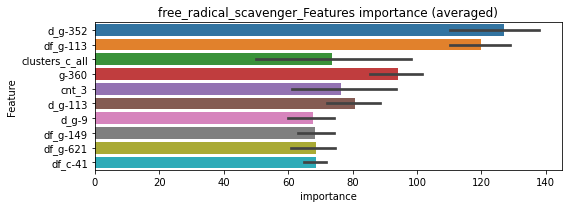

len(train_index) : 3896
len(valid_index) : 3897
================================= fold 1/2 free_radical_scavenger=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0126695	valid_1's binary_logloss: 0.0194629
[200]	training's binary_logloss: 0.00145745	valid_1's binary_logloss: 0.00676449
[300]	training's binary_logloss: 0.000402894	valid_1's binary_logloss: 0.00570438
Early stopping, best iteration is:
[330]	training's binary_logloss: 0.000313939	valid_1's binary_logloss: 0.00562094


len(train_index) : 3897
len(valid_index) : 3896
================================= fold 2/2 free_radical_scavenger=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0129628	valid_1's binary_logloss: 0.0190124
[200]	training's binary_logloss: 0.00150778	valid_1's binary_logloss: 0.00461293
[300]	training's binary_logloss: 0.000462884	valid_1's binary_logloss: 0.0030626
[400]	training's binary_logloss: 0.000233537	valid_1's binary_logloss: 0.00277898
Early stopping, best iteration is:
[426]	training's binary_logloss: 0.000203919	valid_1's binary_logloss: 0.00273559


free_radical_scavenger logloss: 0.0041784499634241684
fungal_squalene_epoxidase_inhibitor, len(trt): 23, len(othr): 3285, target_rate: 0.0009658 → Adj_target_rate: 0.0012069


neg labels: 3289 → selected neg labels: 3285


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0272875	valid_1's binary_logloss: 0.04076
[200]	training's binary_logloss: 0.00356152	valid_1's binary_logloss: 0.00848318
[300]	training's binary_logloss: 0.000998754	valid_1's binary_logloss: 0.00332723
[400]	training's binary_logloss: 0.000516876	valid_1's binary_logloss: 0.00209074
[500]	training's binary_logloss: 0.000382673	valid_1's binary_logloss: 0.00171138
Early stopping, best iteration is:
[577]	training's binary_logloss: 0.000358915	valid_1's binary_logloss: 0.00164993
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.027649	valid_1's binary_logloss: 0.0357566
[200]	training's binary_logloss: 0.00356051	valid_1's binary_logloss: 0.00608018
[300]	training's binary_logloss: 0.00101469	valid_1's binary_logloss: 0.00220358
[400]	training's binary_logloss: 0.000520648	valid_1's binary_logloss: 0.0013054
[500]	training's binary_logloss: 0.0

1 / 3 AUC score:1.000
Threshold: 0.0018987, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → positive_corect_labels: 657/3810
p_label_rate: 0.0411853 Vs.target_rate: 0.00097, Num_p_label: 164.0, conf_0:0.00026, conf_1:0.00209
Num_p_label: 164.0, Expected: 3.8, Adj_threshold_1: 0.0018987
Num_p_label: 35.0, Expected: 3.8, Adj_threshold_2: 0.0068987
Num_p_label: 13.0, Expected: 3.8, Adj_threshold_3: 0.0118987
Num_p_label: 7.0, Expected: 3.8, Adj_threshold_4: 0.0168987
threshold: 0.0168987, positive p_label: 7.0/3982, p_label_rate: 0.0017579
positive y_label: 657.0/3810, y_label_rate: 0.1724409
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0266687	valid_1's binary_logloss: 0.0398056
[200]	training's binary_logloss: 0.0033389	valid_1's binary_logloss: 0.00772324
[300]	training's binary_logloss: 0.00094929	valid_1's binary_logloss: 0.00305279
[400]	training's binary_logloss: 0.000499378	valid_1's binary_logloss: 0.00191134
[500]	training's binary_logloss: 0.000374047	valid_1's binary_logloss: 0.00154682
Early stopping, best iteration is:
[589]	training's binary_logloss: 0.000357557	valid_1's binary_logloss: 0.0015054
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0276889	valid_1's binary_logloss: 0.0350649
[200]	training's binary_logloss: 0.00354665	valid_1's binary_logloss: 0.00567324
[300]	training's binary_logloss: 0.00101344	valid_1's binary_logloss: 0.00192949
[400]	training's binary_logloss: 0.000522298	valid_1's binary_logloss: 0.00110188
[500]	training's binary_logloss: 0.

2 / 3 AUC score:1.000
Threshold: 0.0168987, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 1 → positive_corect_labels: 657.0/3809
p_label_rate: 0.0065294 Vs.target_rate: 0.00097, Num_p_label: 26.0, conf_0:0.00030, conf_1:0.01859
Num_p_label: 26.0, Expected: 3.8, Adj_threshold_1: 0.0168987
Num_p_label: 21.0, Expected: 3.8, Adj_threshold_2: 0.0218987
Num_p_label: 17.0, Expected: 3.8, Adj_threshold_3: 0.0268987
Num_p_label: 13.0, Expected: 3.8, Adj_threshold_4: 0.0318987
Num_p_label: 10.0, Expected: 3.8, Adj_threshold_5: 0.0368987
Num_p_label: 8.0, Expected: 3.8, Adj_threshold_6: 0.0418987
Num_p_label: 5.0, Expected: 3.8, Adj_threshold_7: 0.0468987
threshold: 0.0468987, positive p_label: 5.0/3982, p_label_rate: 0.0012557
positive y_label: 657.0/3809, y_label_rate: 0.1724862
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0269735	valid_1's binary_logloss: 0.0398461
[200]	training's binary_logloss: 0.00339126	valid_1's binary_logloss: 0.00762546
[300]	training's binary_logloss: 0.000949684	valid_1's binary_logloss: 0.0028723
[400]	training's binary_logloss: 0.000500271	valid_1's binary_logloss: 0.00176047
[500]	training's binary_logloss: 0.000376717	valid_1's binary_logloss: 0.00145709
Early stopping, best iteration is:
[539]	training's binary_logloss: 0.000363547	valid_1's binary_logloss: 0.00143033
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0270299	valid_1's binary_logloss: 0.0344493
[200]	training's binary_logloss: 0.00341336	valid_1's binary_logloss: 0.00557283
[300]	training's binary_logloss: 0.000981551	valid_1's binary_logloss: 0.00190157
[400]	training's binary_logloss: 0.000512846	valid_1's binary_logloss: 0.00108111
[500]	training's binary_logloss:

3 / 3 AUC score:1.000
Threshold: 0.0468987, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → positive_corect_labels: 657.0/3809
p_label_rate: 0.0015068 Vs.target_rate: 0.00097, Num_p_label: 6.0, conf_0:0.00031, conf_1:0.05159
threshold: 0.0468987, positive p_label: 6.0/3982, p_label_rate: 0.0015068
positive y_label: 663.0/7791, y_label_rate: 0.0850982


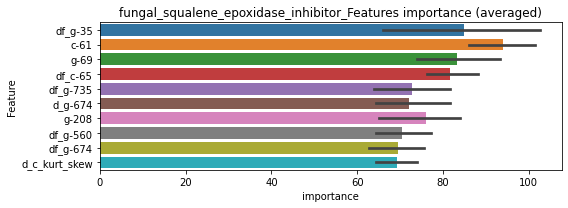

len(train_index) : 3895
len(valid_index) : 3896
================================= fold 1/2 fungal_squalene_epoxidase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0145576	valid_1's binary_logloss: 0.0229015
[200]	training's binary_logloss: 0.00183619	valid_1's binary_logloss: 0.00744472
[300]	training's binary_logloss: 0.000506216	valid_1's binary_logloss: 0.0057629
Early stopping, best iteration is:
[323]	training's binary_logloss: 0.000417123	valid_1's binary_logloss: 0.00563252


len(train_index) : 3896
len(valid_index) : 3895
================================= fold 2/2 fungal_squalene_epoxidase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.015033	valid_1's binary_logloss: 0.023561
[200]	training's binary_logloss: 0.00191319	valid_1's binary_logloss: 0.00578672
[300]	training's binary_logloss: 0.00053521	valid_1's binary_logloss: 0.00281779
[400]	training's binary_logloss: 0.000272441	valid_1's binary_logloss: 0.00216836
[500]	training's binary_logloss: 0.000198135	valid_1's binary_logloss: 0.00195317
Early stopping, best iteration is:
[506]	training's binary_logloss: 0.000196363	valid_1's binary_logloss: 0.00194731


fungal_squalene_epoxidase_inhibitor logloss: 0.0037901498606914327
gaba_receptor_agonist, len(trt): 106, len(othr): 3272, target_rate: 0.0044512 → Adj_target_rate: 0.0044229


neg labels: 3289 → selected neg labels: 3272


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0632487	valid_1's binary_logloss: 0.144041
[200]	training's binary_logloss: 0.0165423	valid_1's binary_logloss: 0.0994892
[300]	training's binary_logloss: 0.00521306	valid_1's binary_logloss: 0.0871865
Early stopping, best iteration is:
[367]	training's binary_logloss: 0.00291956	valid_1's binary_logloss: 0.0843582
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0706399	valid_1's binary_logloss: 0.13911
[200]	training's binary_logloss: 0.0194844	valid_1's binary_logloss: 0.0870691
[300]	training's binary_logloss: 0.00620216	valid_1's binary_logloss: 0.0739408
Early stopping, best iteration is:
[347]	training's binary_logloss: 0.00399989	valid_1's binary_logloss: 0.0720177


1 / 3 AUC score:0.992
Threshold: 0.0184917, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 158 → positive_corect_labels: 641/3768
p_label_rate: 0.0404319 Vs.target_rate: 0.00445, Num_p_label: 161.0, conf_0:0.00469, conf_1:0.02034
Num_p_label: 161.0, Expected: 17.7, Adj_threshold_1: 0.0184917
Num_p_label: 85.0, Expected: 17.7, Adj_threshold_2: 0.0234917
Num_p_label: 51.0, Expected: 17.7, Adj_threshold_3: 0.0284917
Num_p_label: 27.0, Expected: 17.7, Adj_threshold_4: 0.0334917
threshold: 0.0334917, positive p_label: 27.0/3982, p_label_rate: 0.0067805
positive y_label: 641.0/3768, y_label_rate: 0.1701168
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0674054	valid_1's binary_logloss: 0.135068
[200]	training's binary_logloss: 0.01649	valid_1's binary_logloss: 0.0798198
[300]	training's binary_logloss: 0.00522923	valid_1's binary_logloss: 0.064633
Early stopping, best iteration is:
[344]	training's binary_logloss: 0.00352454	valid_1's binary_logloss: 0.0627065
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0609397	valid_1's binary_logloss: 0.133556
[200]	training's binary_logloss: 0.015481	valid_1's binary_logloss: 0.087531
[300]	training's binary_logloss: 0.00491268	valid_1's binary_logloss: 0.0768119
Early stopping, best iteration is:
[351]	training's binary_logloss: 0.00316662	valid_1's binary_logloss: 0.0747663


2 / 3 AUC score:0.994
Threshold: 0.0334917, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 52 → positive_corect_labels: 622.0/3716
p_label_rate: 0.0140633 Vs.target_rate: 0.00445, Num_p_label: 56.0, conf_0:0.00501, conf_1:0.03684
Num_p_label: 56.0, Expected: 17.7, Adj_threshold_1: 0.0334917
Num_p_label: 42.0, Expected: 17.7, Adj_threshold_2: 0.0384917
Num_p_label: 29.0, Expected: 17.7, Adj_threshold_3: 0.0434917
threshold: 0.0434917, positive p_label: 29.0/3982, p_label_rate: 0.0072828
positive y_label: 622.0/3716, y_label_rate: 0.1673843
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0579237	valid_1's binary_logloss: 0.126837
[200]	training's binary_logloss: 0.0135758	valid_1's binary_logloss: 0.077513
[300]	training's binary_logloss: 0.00422567	valid_1's binary_logloss: 0.0625952
Early stopping, best iteration is:
[321]	training's binary_logloss: 0.00347264	valid_1's binary_logloss: 0.0608083
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0613937	valid_1's binary_logloss: 0.123116
[200]	training's binary_logloss: 0.0148038	valid_1's binary_logloss: 0.0739592
[300]	training's binary_logloss: 0.00468764	valid_1's binary_logloss: 0.0608125
Early stopping, best iteration is:
[359]	training's binary_logloss: 0.00282778	valid_1's binary_logloss: 0.0581692


3 / 3 AUC score:0.997
Threshold: 0.0434917, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 20 → positive_corect_labels: 609.0/3696
p_label_rate: 0.0072828 Vs.target_rate: 0.00445, Num_p_label: 29.0, conf_0:0.00463, conf_1:0.04784
threshold: 0.0434917, positive p_label: 29.0/3982, p_label_rate: 0.0072828
positive y_label: 638.0/7678, y_label_rate: 0.0830946


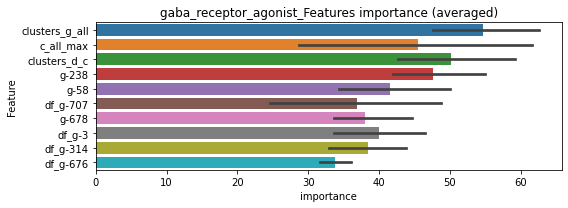

len(train_index) : 3839
len(valid_index) : 3839
================================= fold 1/2 gaba_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0321365	valid_1's binary_logloss: 0.079237
[200]	training's binary_logloss: 0.00734382	valid_1's binary_logloss: 0.0541838
[300]	training's binary_logloss: 0.00235106	valid_1's binary_logloss: 0.0482816
Early stopping, best iteration is:
[320]	training's binary_logloss: 0.00193076	valid_1's binary_logloss: 0.04783


len(train_index) : 3839
len(valid_index) : 3839
================================= fold 2/2 gaba_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0371865	valid_1's binary_logloss: 0.0844974
[200]	training's binary_logloss: 0.00925077	valid_1's binary_logloss: 0.0600135
Early stopping, best iteration is:
[260]	training's binary_logloss: 0.00437629	valid_1's binary_logloss: 0.0564912


gaba_receptor_agonist logloss: 0.052160591346800754


  acetylcholine_receptor_agonist acetylcholine_receptor_antagonist  \
0                       df_g-122                              c-30   
1                  clusters_df_c                         c_all_max   
2                          cnt_0                    clusters_g_all   
3                      c_all_min                          df_g-707   
4                        df_g-51                        clusters_g   
5                       df_c_min                          df_c_min   
6                          cnt_2                             g-514   
7                       df_g-736                          df_g-640   
8                          g-244                            df_c-6   
9                           c-73                          df_g-597   

  acetylcholinesterase_inhibitor adenosine_receptor_antagonist  \
0                      c_all_max                clusters_c_all   
1                      c_all_min                      df_c_min   
2                 clusters_g_al

gaba_receptor_antagonist, len(trt): 165, len(othr): 3263, target_rate: 0.0069287 → Adj_target_rate: 0.0064426


neg labels: 3289 → selected neg labels: 3263


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0817753	valid_1's binary_logloss: 0.20461
[200]	training's binary_logloss: 0.0258343	valid_1's binary_logloss: 0.166619
Early stopping, best iteration is:
[274]	training's binary_logloss: 0.0118431	valid_1's binary_logloss: 0.160207
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0921372	valid_1's binary_logloss: 0.190327
[200]	training's binary_logloss: 0.0291522	valid_1's binary_logloss: 0.142017
[300]	training's binary_logloss: 0.0105361	valid_1's binary_logloss: 0.125726
Early stopping, best iteration is:
[355]	training's binary_logloss: 0.0064236	valid_1's binary_logloss: 0.122635


1 / 3 AUC score:0.972
Threshold: 0.0419763, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 239 → positive_corect_labels: 598/3676
p_label_rate: 0.0328980 Vs.target_rate: 0.00693, Num_p_label: 131.0, conf_0:0.01224, conf_1:0.04617
Num_p_label: 131.0, Expected: 27.6, Adj_threshold_1: 0.0419763
Num_p_label: 101.0, Expected: 27.6, Adj_threshold_2: 0.0469763
Num_p_label: 60.0, Expected: 27.6, Adj_threshold_3: 0.0519763
Num_p_label: 45.0, Expected: 27.6, Adj_threshold_4: 0.0569763
threshold: 0.0569763, positive p_label: 45.0/3982, p_label_rate: 0.0113009
positive y_label: 598.0/3676, y_label_rate: 0.1626768
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0746003	valid_1's binary_logloss: 0.169579
[200]	training's binary_logloss: 0.0226459	valid_1's binary_logloss: 0.129234
[300]	training's binary_logloss: 0.00735616	valid_1's binary_logloss: 0.117672
Early stopping, best iteration is:
[321]	training's binary_logloss: 0.00606196	valid_1's binary_logloss: 0.116583
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0807855	valid_1's binary_logloss: 0.180408
[200]	training's binary_logloss: 0.023382	valid_1's binary_logloss: 0.139046
[300]	training's binary_logloss: 0.00782909	valid_1's binary_logloss: 0.129239
Early stopping, best iteration is:
[304]	training's binary_logloss: 0.00752579	valid_1's binary_logloss: 0.129173


2 / 3 AUC score:0.985
Threshold: 0.0569763, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 84 → positive_corect_labels: 552.0/3592
p_label_rate: 0.0133099 Vs.target_rate: 0.00693, Num_p_label: 53.0, conf_0:0.00949, conf_1:0.06267
threshold: 0.0569763, positive p_label: 53.0/3982, p_label_rate: 0.0133099
positive y_label: 552.0/3592, y_label_rate: 0.1536748
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.06929	valid_1's binary_logloss: 0.146207
[200]	training's binary_logloss: 0.0188377	valid_1's binary_logloss: 0.102927
[300]	training's binary_logloss: 0.00624658	valid_1's binary_logloss: 0.0892118
Early stopping, best iteration is:
[361]	training's binary_logloss: 0.00362907	valid_1's binary_logloss: 0.0862422
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0632324	valid_1's binary_logloss: 0.153708
[200]	training's binary_logloss: 0.0173815	valid_1's binary_logloss: 0.111177
[300]	training's binary_logloss: 0.00578371	valid_1's binary_logloss: 0.101269
Early stopping, best iteration is:
[325]	training's binary_logloss: 0.00460547	valid_1's binary_logloss: 0.100261


3 / 3 AUC score:0.993
Threshold: 0.0569763, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 39 → positive_corect_labels: 524.0/3553
p_label_rate: 0.0057760 Vs.target_rate: 0.00693, Num_p_label: 23.0, conf_0:0.00592, conf_1:0.06267
threshold: 0.0569763, positive p_label: 23.0/3982, p_label_rate: 0.0057760
positive y_label: 547.0/7535, y_label_rate: 0.0725946


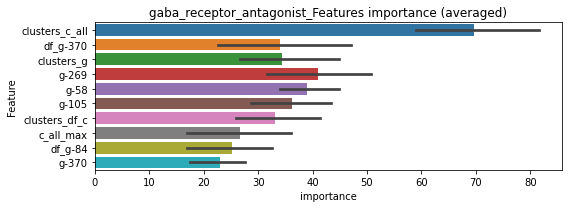

len(train_index) : 3767
len(valid_index) : 3768
================================= fold 1/2 gaba_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0358098	valid_1's binary_logloss: 0.0845176
[200]	training's binary_logloss: 0.00907502	valid_1's binary_logloss: 0.0643973
Early stopping, best iteration is:
[240]	training's binary_logloss: 0.00547778	valid_1's binary_logloss: 0.0617674


len(train_index) : 3768
len(valid_index) : 3767
================================= fold 2/2 gaba_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0328763	valid_1's binary_logloss: 0.0919282
[200]	training's binary_logloss: 0.00847928	valid_1's binary_logloss: 0.074356
Early stopping, best iteration is:
[227]	training's binary_logloss: 0.00606403	valid_1's binary_logloss: 0.0723155


gaba_receptor_antagonist logloss: 0.06704076972320912


  acetylcholine_receptor_agonist acetylcholine_receptor_antagonist  \
0                       df_g-122                              c-30   
1                  clusters_df_c                         c_all_max   
2                          cnt_0                    clusters_g_all   
3                      c_all_min                          df_g-707   
4                        df_g-51                        clusters_g   
5                       df_c_min                          df_c_min   
6                          cnt_2                             g-514   
7                       df_g-736                          df_g-640   
8                          g-244                            df_c-6   
9                           c-73                          df_g-597   

  acetylcholinesterase_inhibitor adenosine_receptor_antagonist  \
0                      c_all_max                clusters_c_all   
1                      c_all_min                      df_c_min   
2                 clusters_g_al

gamma_secretase_inhibitor, len(trt): 56, len(othr): 3279, target_rate: 0.0023516 → Adj_target_rate: 0.0025713


neg labels: 3289 → selected neg labels: 3279


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0355956	valid_1's binary_logloss: 0.0662703
[200]	training's binary_logloss: 0.00569077	valid_1's binary_logloss: 0.0242694
[300]	training's binary_logloss: 0.00166518	valid_1's binary_logloss: 0.0152811
[400]	training's binary_logloss: 0.00081792	valid_1's binary_logloss: 0.0127564
[500]	training's binary_logloss: 0.000538513	valid_1's binary_logloss: 0.0115633
Early stopping, best iteration is:
[576]	training's binary_logloss: 0.000458945	valid_1's binary_logloss: 0.0112343
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0348561	valid_1's binary_logloss: 0.0645263
[200]	training's binary_logloss: 0.00543672	valid_1's binary_logloss: 0.0264706
[300]	training's binary_logloss: 0.00160317	valid_1's binary_logloss: 0.0192169
[400]	training's binary_logloss: 0.000791073	valid_1's binary_logloss: 0.017148
Early stopping, best iteration is:
[408]	tr

1 / 3 AUC score:1.000
Threshold: 0.0047512, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → positive_corect_labels: 655/3802
p_label_rate: 0.0334003 Vs.target_rate: 0.00235, Num_p_label: 133.0, conf_0:0.00051, conf_1:0.00523
Num_p_label: 133.0, Expected: 9.4, Adj_threshold_1: 0.0047512
Num_p_label: 65.0, Expected: 9.4, Adj_threshold_2: 0.0097512
Num_p_label: 35.0, Expected: 9.4, Adj_threshold_3: 0.0147512
Num_p_label: 23.0, Expected: 9.4, Adj_threshold_4: 0.0197512
Num_p_label: 19.0, Expected: 9.4, Adj_threshold_5: 0.0247512
Num_p_label: 18.0, Expected: 9.4, Adj_threshold_6: 0.0297512
threshold: 0.0297512, positive p_label: 18.0/3982, p_label_rate: 0.0045203
positive y_label: 655.0/3802, y_label_rate: 0.1722777
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0349325	valid_1's binary_logloss: 0.0641123
[200]	training's binary_logloss: 0.00524254	valid_1's binary_logloss: 0.0231543
[300]	training's binary_logloss: 0.00153811	valid_1's binary_logloss: 0.0150805
[400]	training's binary_logloss: 0.000765903	valid_1's binary_logloss: 0.0131436
Early stopping, best iteration is:
[425]	training's binary_logloss: 0.000673916	valid_1's binary_logloss: 0.0127039
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0346462	valid_1's binary_logloss: 0.0600979
[200]	training's binary_logloss: 0.00518787	valid_1's binary_logloss: 0.0215354
[300]	training's binary_logloss: 0.00152251	valid_1's binary_logloss: 0.0147894
[400]	training's binary_logloss: 0.000743105	valid_1's binary_logloss: 0.012434
Early stopping, best iteration is:
[420]	training's binary_logloss: 0.000673068	valid_1's binary_logloss: 0.012119


2 / 3 AUC score:1.000
Threshold: 0.0297512, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 5 → positive_corect_labels: 650.0/3797
p_label_rate: 0.0092918 Vs.target_rate: 0.00235, Num_p_label: 37.0, conf_0:0.00069, conf_1:0.03273
Num_p_label: 37.0, Expected: 9.4, Adj_threshold_1: 0.0297512
Num_p_label: 30.0, Expected: 9.4, Adj_threshold_2: 0.0347512
Num_p_label: 25.0, Expected: 9.4, Adj_threshold_3: 0.0397512
Num_p_label: 23.0, Expected: 9.4, Adj_threshold_4: 0.0447512
Num_p_label: 19.0, Expected: 9.4, Adj_threshold_5: 0.0497512
Num_p_label: 16.0, Expected: 9.4, Adj_threshold_6: 0.0547512
threshold: 0.0547512, positive p_label: 16.0/3982, p_label_rate: 0.0040181
positive y_label: 650.0/3797, y_label_rate: 0.1711878
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0336484	valid_1's binary_logloss: 0.0614962
[200]	training's binary_logloss: 0.00497991	valid_1's binary_logloss: 0.0239175
[300]	training's binary_logloss: 0.00145133	valid_1's binary_logloss: 0.0170975
Early stopping, best iteration is:
[336]	training's binary_logloss: 0.00107333	valid_1's binary_logloss: 0.0159026
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0331549	valid_1's binary_logloss: 0.0692743
[200]	training's binary_logloss: 0.00494142	valid_1's binary_logloss: 0.0353286
[300]	training's binary_logloss: 0.00144929	valid_1's binary_logloss: 0.0294592
Early stopping, best iteration is:
[340]	training's binary_logloss: 0.00104173	valid_1's binary_logloss: 0.028451


3 / 3 AUC score:0.998
Threshold: 0.0547512, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 8 → positive_corect_labels: 642.0/3789
p_label_rate: 0.0067805 Vs.target_rate: 0.00235, Num_p_label: 27.0, conf_0:0.00102, conf_1:0.06023
threshold: 0.0547512, positive p_label: 27.0/3982, p_label_rate: 0.0067805
positive y_label: 669.0/7771, y_label_rate: 0.0860893


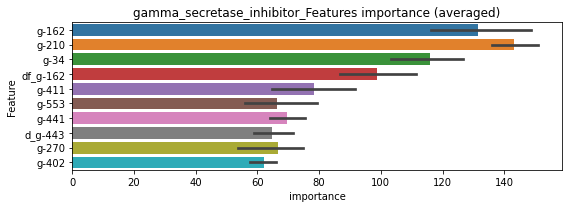

len(train_index) : 3885
len(valid_index) : 3886
================================= fold 1/2 gamma_secretase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0175536	valid_1's binary_logloss: 0.043989
[200]	training's binary_logloss: 0.00255779	valid_1's binary_logloss: 0.0251729
[300]	training's binary_logloss: 0.000742779	valid_1's binary_logloss: 0.0219468
Early stopping, best iteration is:
[310]	training's binary_logloss: 0.000678294	valid_1's binary_logloss: 0.0217542


len(train_index) : 3886
len(valid_index) : 3885
================================= fold 2/2 gamma_secretase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0189175	valid_1's binary_logloss: 0.0352317
[200]	training's binary_logloss: 0.00280079	valid_1's binary_logloss: 0.017032
[300]	training's binary_logloss: 0.000837206	valid_1's binary_logloss: 0.0151924
Early stopping, best iteration is:
[290]	training's binary_logloss: 0.000919123	valid_1's binary_logloss: 0.0151798


gamma_secretase_inhibitor logloss: 0.018467432180390837
glucocorticoid_receptor_agonist, len(trt): 266, len(othr): 3253, target_rate: 0.0111699 → Adj_target_rate: 0.0096682


neg labels: 3289 → selected neg labels: 3253


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0301433	valid_1's binary_logloss: 0.0682805
Early stopping, best iteration is:
[185]	training's binary_logloss: 0.0056748	valid_1's binary_logloss: 0.0523395
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0321674	valid_1's binary_logloss: 0.0596444
[200]	training's binary_logloss: 0.00501314	valid_1's binary_logloss: 0.0389489
Early stopping, best iteration is:
[269]	training's binary_logloss: 0.00203237	valid_1's binary_logloss: 0.0364239


1 / 3 AUC score:0.994
Threshold: 0.0116761, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 153 → positive_corect_labels: 639/3750
p_label_rate: 0.0512305 Vs.target_rate: 0.01117, Num_p_label: 204.0, conf_0:0.00193, conf_1:0.01284
Num_p_label: 204.0, Expected: 44.5, Adj_threshold_1: 0.0116761
Num_p_label: 139.0, Expected: 44.5, Adj_threshold_2: 0.0166761
Num_p_label: 108.0, Expected: 44.5, Adj_threshold_3: 0.0216761
Num_p_label: 91.0, Expected: 44.5, Adj_threshold_4: 0.0266761
Num_p_label: 80.0, Expected: 44.5, Adj_threshold_5: 0.0316761
threshold: 0.0316761, positive p_label: 80.0/3982, p_label_rate: 0.0200904
positive y_label: 639.0/3750, y_label_rate: 0.1704000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.027057	valid_1's binary_logloss: 0.041356
[200]	training's binary_logloss: 0.00372226	valid_1's binary_logloss: 0.0147182
[300]	training's binary_logloss: 0.000965845	valid_1's binary_logloss: 0.0112105
[400]	training's binary_logloss: 0.00049021	valid_1's binary_logloss: 0.0100339
Early stopping, best iteration is:
[443]	training's binary_logloss: 0.00041254	valid_1's binary_logloss: 0.00969856
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0252089	valid_1's binary_logloss: 0.0489651
[200]	training's binary_logloss: 0.00320451	valid_1's binary_logloss: 0.0314727


2 / 3 AUC score:0.999
Threshold: 0.0316761, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 13 → positive_corect_labels: 632.0/3737
p_label_rate: 0.0236062 Vs.target_rate: 0.01117, Num_p_label: 94.0, conf_0:0.00087, conf_1:0.03484
threshold: 0.0316761, positive p_label: 94.0/3982, p_label_rate: 0.0236062


Early stopping, best iteration is:
[215]	training's binary_logloss: 0.00248829	valid_1's binary_logloss: 0.031054


positive y_label: 632.0/3737, y_label_rate: 0.1691196
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0242736	valid_1's binary_logloss: 0.0405105
[200]	training's binary_logloss: 0.00291803	valid_1's binary_logloss: 0.0171474
Early stopping, best iteration is:
[265]	training's binary_logloss: 0.00112842	valid_1's binary_logloss: 0.0150046
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0240446	valid_1's binary_logloss: 0.0459064
[200]	training's binary_logloss: 0.0029046	valid_1's binary_logloss: 0.0228528


3 / 3 AUC score:1.000
Threshold: 0.0316761, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 9 → positive_corect_labels: 626.0/3728


Early stopping, best iteration is:
[274]	training's binary_logloss: 0.00103187	valid_1's binary_logloss: 0.0194415


p_label_rate: 0.0248619 Vs.target_rate: 0.01117, Num_p_label: 99.0, conf_0:0.00065, conf_1:0.03484
threshold: 0.0316761, positive p_label: 99.0/3982, p_label_rate: 0.0248619
positive y_label: 725.0/7710, y_label_rate: 0.0940337


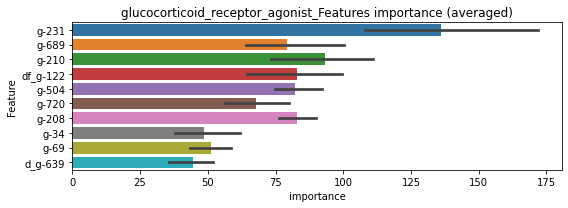

len(train_index) : 3855
len(valid_index) : 3855
================================= fold 1/2 glucocorticoid_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0152127	valid_1's binary_logloss: 0.0354835
[200]	training's binary_logloss: 0.00205287	valid_1's binary_logloss: 0.0253892
Early stopping, best iteration is:
[224]	training's binary_logloss: 0.00142291	valid_1's binary_logloss: 0.0250938


len(train_index) : 3855
len(valid_index) : 3855
================================= fold 2/2 glucocorticoid_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0156296	valid_1's binary_logloss: 0.0367009
[200]	training's binary_logloss: 0.00208061	valid_1's binary_logloss: 0.0262406
Early stopping, best iteration is:
[250]	training's binary_logloss: 0.00099573	valid_1's binary_logloss: 0.0256312


glucocorticoid_receptor_agonist logloss: 0.025362514974168998


  acetylcholine_receptor_agonist acetylcholine_receptor_antagonist  \
0                       df_g-122                              c-30   
1                  clusters_df_c                         c_all_max   
2                          cnt_0                    clusters_g_all   
3                      c_all_min                          df_g-707   
4                        df_g-51                        clusters_g   
5                       df_c_min                          df_c_min   
6                          cnt_2                             g-514   
7                       df_g-736                          df_g-640   
8                          g-244                            df_c-6   
9                           c-73                          df_g-597   

  acetylcholinesterase_inhibitor adenosine_receptor_antagonist  \
0                      c_all_max                clusters_c_all   
1                      c_all_min                      df_c_min   
2                 clusters_g_al

glutamate_inhibitor, len(trt): 13, len(othr): 3287, target_rate: 0.0005459 → Adj_target_rate: 0.0007431


neg labels: 3289 → selected neg labels: 3287


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0189339	valid_1's binary_logloss: 0.0242316
[200]	training's binary_logloss: 0.00199568	valid_1's binary_logloss: 0.00437143
[300]	training's binary_logloss: 0.000569275	valid_1's binary_logloss: 0.00215644
[400]	training's binary_logloss: 0.000319416	valid_1's binary_logloss: 0.00168732
Early stopping, best iteration is:
[425]	training's binary_logloss: 0.000298329	valid_1's binary_logloss: 0.00163296
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0192293	valid_1's binary_logloss: 0.0232027
[200]	training's binary_logloss: 0.00202151	valid_1's binary_logloss: 0.00373259
[300]	training's binary_logloss: 0.0005779	valid_1's binary_logloss: 0.00149454
[400]	training's binary_logloss: 0.00032456	valid_1's binary_logloss: 0.000995566
Early stopping, best iteration is:
[450]	training's binary_logloss: 0.000289368	valid_1's binary_logloss: 0.0009375

1 / 3 AUC score:1.000
Threshold: 0.0011103, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → positive_corect_labels: 657/3812
p_label_rate: 0.0374184 Vs.target_rate: 0.00055, Num_p_label: 149.0, conf_0:0.00019, conf_1:0.00122
Num_p_label: 149.0, Expected: 2.2, Adj_threshold_1: 0.0011103
Num_p_label: 21.0, Expected: 2.2, Adj_threshold_2: 0.0061103
Num_p_label: 8.0, Expected: 2.2, Adj_threshold_3: 0.0111103
Num_p_label: 1.0, Expected: 2.2, Adj_threshold_4: 0.0161103
threshold: 0.0161103, positive p_label: 1.0/3982, p_label_rate: 0.0002511
positive y_label: 657.0/3812, y_label_rate: 0.1723505
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0192191	valid_1's binary_logloss: 0.0249004
[200]	training's binary_logloss: 0.001976	valid_1's binary_logloss: 0.00448602
[300]	training's binary_logloss: 0.000561592	valid_1's binary_logloss: 0.00225378
[400]	training's binary_logloss: 0.000316773	valid_1's binary_logloss: 0.00183405
Early stopping, best iteration is:
[443]	training's binary_logloss: 0.000284778	valid_1's binary_logloss: 0.00177685
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.019117	valid_1's binary_logloss: 0.0222113
[200]	training's binary_logloss: 0.00196401	valid_1's binary_logloss: 0.00348454
[300]	training's binary_logloss: 0.000564994	valid_1's binary_logloss: 0.00147639
[400]	training's binary_logloss: 0.000319486	valid_1's binary_logloss: 0.00101624
Early stopping, best iteration is:
[483]	training's binary_logloss: 0.000278402	valid_1's binary_logloss: 0.00093884

2 / 3 AUC score:1.000
Threshold: 0.0161103, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → positive_corect_labels: 657.0/3812
p_label_rate: 0.0045203 Vs.target_rate: 0.00055, Num_p_label: 18.0, conf_0:0.00020, conf_1:0.01772
Num_p_label: 18.0, Expected: 2.2, Adj_threshold_1: 0.0161103
Num_p_label: 11.0, Expected: 2.2, Adj_threshold_2: 0.0211103
Num_p_label: 7.0, Expected: 2.2, Adj_threshold_3: 0.0261103
Num_p_label: 7.0, Expected: 2.2, Adj_threshold_4: 0.0311103
Num_p_label: 4.0, Expected: 2.2, Adj_threshold_5: 0.0361103
threshold: 0.0361103, positive p_label: 4.0/3982, p_label_rate: 0.0010045
positive y_label: 657.0/3812, y_label_rate: 0.1723505
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0192191	valid_1's binary_logloss: 0.0249004
[200]	training's binary_logloss: 0.001976	valid_1's binary_logloss: 0.00448602
[300]	training's binary_logloss: 0.000561592	valid_1's binary_logloss: 0.00225378
[400]	training's binary_logloss: 0.000316773	valid_1's binary_logloss: 0.00183405
Early stopping, best iteration is:
[443]	training's binary_logloss: 0.000284778	valid_1's binary_logloss: 0.00177685
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.019117	valid_1's binary_logloss: 0.0222113
[200]	training's binary_logloss: 0.00196401	valid_1's binary_logloss: 0.00348454
[300]	training's binary_logloss: 0.000564994	valid_1's binary_logloss: 0.00147639
[400]	training's binary_logloss: 0.000319486	valid_1's binary_logloss: 0.00101624
Early stopping, best iteration is:
[483]	training's binary_logloss: 0.000278402	valid_1's binary_logloss: 0.00093884

3 / 3 AUC score:1.000
Threshold: 0.0361103, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → positive_corect_labels: 657.0/3812
p_label_rate: 0.0010045 Vs.target_rate: 0.00055, Num_p_label: 4.0, conf_0:0.00020, conf_1:0.03972
threshold: 0.0361103, positive p_label: 4.0/3982, p_label_rate: 0.0010045
positive y_label: 661.0/7794, y_label_rate: 0.0848088


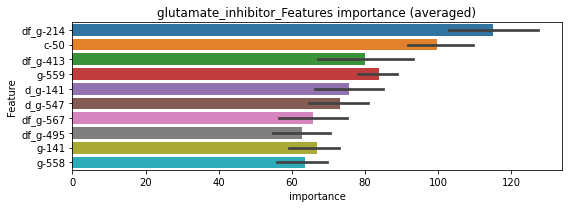

len(train_index) : 3897
len(valid_index) : 3897
================================= fold 1/2 glutamate_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0103426	valid_1's binary_logloss: 0.0163198
[200]	training's binary_logloss: 0.00104667	valid_1's binary_logloss: 0.00622114
[300]	training's binary_logloss: 0.00028901	valid_1's binary_logloss: 0.0052613
Early stopping, best iteration is:
[306]	training's binary_logloss: 0.000274768	valid_1's binary_logloss: 0.00523025


len(train_index) : 3897
len(valid_index) : 3897
================================= fold 2/2 glutamate_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0105183	valid_1's binary_logloss: 0.0126937
[200]	training's binary_logloss: 0.00108958	valid_1's binary_logloss: 0.00267543
[300]	training's binary_logloss: 0.000303387	valid_1's binary_logloss: 0.00185837
Early stopping, best iteration is:
[342]	training's binary_logloss: 0.00022242	valid_1's binary_logloss: 0.00177647


glutamate_inhibitor logloss: 0.003503358852468349
glutamate_receptor_agonist, len(trt): 74, len(othr): 3277, target_rate: 0.0031074 → Adj_target_rate: 0.0032587


neg labels: 3289 → selected neg labels: 3277


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0637555	valid_1's binary_logloss: 0.113214
[200]	training's binary_logloss: 0.0138127	valid_1's binary_logloss: 0.0531275
[300]	training's binary_logloss: 0.0040474	valid_1's binary_logloss: 0.0366685
[400]	training's binary_logloss: 0.00178229	valid_1's binary_logloss: 0.0313058
[500]	training's binary_logloss: 0.00105389	valid_1's binary_logloss: 0.0286562
Early stopping, best iteration is:
[585]	training's binary_logloss: 0.000790745	valid_1's binary_logloss: 0.0276072
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0628475	valid_1's binary_logloss: 0.113565
[200]	training's binary_logloss: 0.0144842	valid_1's binary_logloss: 0.0530078
[300]	training's binary_logloss: 0.00416206	valid_1's binary_logloss: 0.0346922
[400]	training's binary_logloss: 0.00180309	valid_1's binary_logloss: 0.0287048
[500]	training's binary_logloss: 0.00106937	valid

1 / 3 AUC score:1.000
Threshold: 0.0078443, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → positive_corect_labels: 655/3800
p_label_rate: 0.0406831 Vs.target_rate: 0.00311, Num_p_label: 162.0, conf_0:0.00114, conf_1:0.00863
Num_p_label: 162.0, Expected: 12.4, Adj_threshold_1: 0.0078443
Num_p_label: 64.0, Expected: 12.4, Adj_threshold_2: 0.0128443
Num_p_label: 32.0, Expected: 12.4, Adj_threshold_3: 0.0178443
Num_p_label: 23.0, Expected: 12.4, Adj_threshold_4: 0.0228443
threshold: 0.0228443, positive p_label: 23.0/3982, p_label_rate: 0.0057760
positive y_label: 655.0/3800, y_label_rate: 0.1723684
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0640305	valid_1's binary_logloss: 0.113494
[200]	training's binary_logloss: 0.0138971	valid_1's binary_logloss: 0.0530315
[300]	training's binary_logloss: 0.00403418	valid_1's binary_logloss: 0.036357
[400]	training's binary_logloss: 0.00177639	valid_1's binary_logloss: 0.0303727
[500]	training's binary_logloss: 0.00105849	valid_1's binary_logloss: 0.0280212
[600]	training's binary_logloss: 0.000757537	valid_1's binary_logloss: 0.0264132
Early stopping, best iteration is:
[595]	training's binary_logloss: 0.000767039	valid_1's binary_logloss: 0.0263896
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0628827	valid_1's binary_logloss: 0.110979
[200]	training's binary_logloss: 0.0140956	valid_1's binary_logloss: 0.0515542
[300]	training's binary_logloss: 0.00409398	valid_1's binary_logloss: 0.0336935
[400]	training's binary_logloss: 0.00180303	vali

2 / 3 AUC score:1.000
Threshold: 0.0228443, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 13 → positive_corect_labels: 653.0/3787
p_label_rate: 0.0123054 Vs.target_rate: 0.00311, Num_p_label: 49.0, conf_0:0.00130, conf_1:0.02513
Num_p_label: 49.0, Expected: 12.4, Adj_threshold_1: 0.0228443
Num_p_label: 28.0, Expected: 12.4, Adj_threshold_2: 0.0278443
Num_p_label: 25.0, Expected: 12.4, Adj_threshold_3: 0.0328443
Num_p_label: 15.0, Expected: 12.4, Adj_threshold_4: 0.0378443
threshold: 0.0378443, positive p_label: 15.0/3982, p_label_rate: 0.0037670
positive y_label: 653.0/3787, y_label_rate: 0.1724320
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0589365	valid_1's binary_logloss: 0.120203
[200]	training's binary_logloss: 0.0128295	valid_1's binary_logloss: 0.0641618
[300]	training's binary_logloss: 0.00380881	valid_1's binary_logloss: 0.047622
[400]	training's binary_logloss: 0.00169619	valid_1's binary_logloss: 0.0420653
[500]	training's binary_logloss: 0.0010152	valid_1's binary_logloss: 0.0402964
Early stopping, best iteration is:
[490]	training's binary_logloss: 0.00105396	valid_1's binary_logloss: 0.0400626
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.063717	valid_1's binary_logloss: 0.112617
[200]	training's binary_logloss: 0.0142734	valid_1's binary_logloss: 0.0547668
[300]	training's binary_logloss: 0.00414773	valid_1's binary_logloss: 0.0379303
[400]	training's binary_logloss: 0.00179693	valid_1's binary_logloss: 0.0323877
[500]	training's binary_logloss: 0.0010782	valid_1's

3 / 3 AUC score:1.000
Threshold: 0.0378443, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 11 → positive_corect_labels: 642.0/3776
p_label_rate: 0.0052737 Vs.target_rate: 0.00311, Num_p_label: 21.0, conf_0:0.00154, conf_1:0.04163
threshold: 0.0378443, positive p_label: 21.0/3982, p_label_rate: 0.0052737
positive y_label: 663.0/7758, y_label_rate: 0.0854602


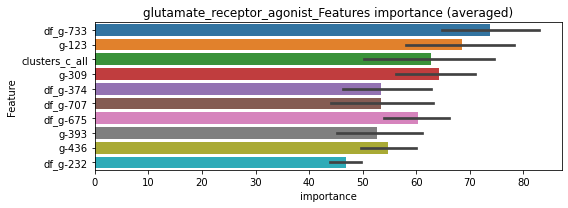

len(train_index) : 3879
len(valid_index) : 3879
================================= fold 1/2 glutamate_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0354889	valid_1's binary_logloss: 0.0732562
[200]	training's binary_logloss: 0.00773261	valid_1's binary_logloss: 0.0441482
[300]	training's binary_logloss: 0.00220821	valid_1's binary_logloss: 0.0384649
Early stopping, best iteration is:
[312]	training's binary_logloss: 0.00195159	valid_1's binary_logloss: 0.038292


len(train_index) : 3879
len(valid_index) : 3879
================================= fold 2/2 glutamate_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0355317	valid_1's binary_logloss: 0.0682651
[200]	training's binary_logloss: 0.00771354	valid_1's binary_logloss: 0.038289
[300]	training's binary_logloss: 0.00229783	valid_1's binary_logloss: 0.0314666
Early stopping, best iteration is:
[381]	training's binary_logloss: 0.00112054	valid_1's binary_logloss: 0.0296851


glutamate_receptor_agonist logloss: 0.033988523387515526


  acetylcholine_receptor_agonist acetylcholine_receptor_antagonist  \
0                       df_g-122                              c-30   
1                  clusters_df_c                         c_all_max   
2                          cnt_0                    clusters_g_all   
3                      c_all_min                          df_g-707   
4                        df_g-51                        clusters_g   
5                       df_c_min                          df_c_min   
6                          cnt_2                             g-514   
7                       df_g-736                          df_g-640   
8                          g-244                            df_c-6   
9                           c-73                          df_g-597   

  acetylcholinesterase_inhibitor adenosine_receptor_antagonist  \
0                      c_all_max                clusters_c_all   
1                      c_all_min                      df_c_min   
2                 clusters_g_al

glutamate_receptor_antagonist, len(trt): 367, len(othr): 3226, target_rate: 0.0154111 → Adj_target_rate: 0.0127105


neg labels: 3289 → selected neg labels: 3226


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.131179	valid_1's binary_logloss: 0.34781
Early stopping, best iteration is:
[164]	training's binary_logloss: 0.0688956	valid_1's binary_logloss: 0.338761
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.148423	valid_1's binary_logloss: 0.347735
[200]	training's binary_logloss: 0.0604404	valid_1's binary_logloss: 0.324562


1 / 3 AUC score:0.812
Threshold: 0.1227605, pos_neg_ratio: 0.8000000


Early stopping, best iteration is:
[214]	training's binary_logloss: 0.0537763	valid_1's binary_logloss: 0.32321


Remove_noisy_labels: 622 → positive_corect_labels: 399/3249
p_label_rate: 0.0801105 Vs.target_rate: 0.01541, Num_p_label: 319.0, conf_0:0.07171, conf_1:0.13504
Num_p_label: 319.0, Expected: 61.4, Adj_threshold_1: 0.1227605
Num_p_label: 269.0, Expected: 61.4, Adj_threshold_2: 0.1277605
Num_p_label: 226.0, Expected: 61.4, Adj_threshold_3: 0.1327605
Num_p_label: 191.0, Expected: 61.4, Adj_threshold_4: 0.1377605
Num_p_label: 150.0, Expected: 61.4, Adj_threshold_5: 0.1427605
Num_p_label: 123.0, Expected: 61.4, Adj_threshold_6: 0.1477605
Num_p_label: 102.0, Expected: 61.4, Adj_threshold_7: 0.1527605
threshold: 0.1527605, positive p_label: 102.0/3982, p_label_rate: 0.0256153
positive y_label: 399.0/3249, y_label_rate: 0.1228070
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0679288	valid_1's binary_logloss: 0.236965
Early stopping, best iteration is:
[151]	training's binary_logloss: 0.0363848	valid_1's binary_logloss: 0.228488
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0763429	valid_1's binary_logloss: 0.238346


2 / 3 AUC score:0.912
Threshold: 0.1527605, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 186 → positive_corect_labels: 242.0/3063
p_label_rate: 0.0090407 Vs.target_rate: 0.01541, Num_p_label: 36.0, conf_0:0.04127, conf_1:0.16804
threshold: 0.1527605, positive p_label: 36.0/3982, p_label_rate: 0.0090407


Early stopping, best iteration is:
[133]	training's binary_logloss: 0.0512163	valid_1's binary_logloss: 0.230358


positive y_label: 242.0/3063, y_label_rate: 0.0790075
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0335928	valid_1's binary_logloss: 0.132612
Early stopping, best iteration is:
[150]	training's binary_logloss: 0.0160556	valid_1's binary_logloss: 0.125898
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.035536	valid_1's binary_logloss: 0.15761


3 / 3 AUC score:0.961
Threshold: 0.1527605, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 91 → positive_corect_labels: 152.0/2972
p_label_rate: 0.0007534 Vs.target_rate: 0.01541, Num_p_label: 3.0, conf_0:0.01448, conf_1:0.16804
Num_p_label: 3.0, Expected: 61.4, Adj_threshold_1: 0.1527605
Num_p_label: 3.0, Expected: 61.4, Adj_threshold_2: 0.1477605
Num_p_label: 3.0, Expected: 61.4, Adj_threshold_3: 0.1427605
Num_p_label: 3.0, Expected: 61.4, Adj_threshold_4: 0.1377605
Num_p_label: 3.0, Expected: 61.4, Adj_threshold_5: 0.1327605


Early stopping, best iteration is:
[133]	training's binary_logloss: 0.0216989	valid_1's binary_logloss: 0.15154


Num_p_label: 5.0, Expected: 61.4, Adj_threshold_6: 0.1277605
Num_p_label: 5.0, Expected: 61.4, Adj_threshold_7: 0.1227605
Num_p_label: 5.0, Expected: 61.4, Adj_threshold_8: 0.1177605
Num_p_label: 6.0, Expected: 61.4, Adj_threshold_9: 0.1127605
Num_p_label: 9.0, Expected: 61.4, Adj_threshold_10: 0.1077605
threshold: 0.1027605, positive p_label: 10.0/3982, p_label_rate: 0.0025113
positive y_label: 162.0/6954, y_label_rate: 0.0232959


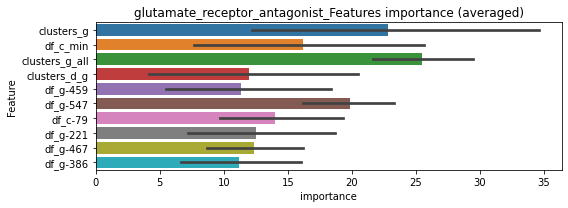

len(train_index) : 3477
len(valid_index) : 3477
================================= fold 1/2 glutamate_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.00845864	valid_1's binary_logloss: 0.0568466
Early stopping, best iteration is:
[112]	training's binary_logloss: 0.00682999	valid_1's binary_logloss: 0.0564888


len(train_index) : 3477
len(valid_index) : 3477
================================= fold 2/2 glutamate_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds


glutamate_receptor_antagonist logloss: 0.05580231231321799


Early stopping, best iteration is:
[71]	training's binary_logloss: 0.0136598	valid_1's binary_logloss: 0.0551159
  acetylcholine_receptor_agonist acetylcholine_receptor_antagonist  \
0                       df_g-122                              c-30   
1                  clusters_df_c                         c_all_max   
2                          cnt_0                    clusters_g_all   
3                      c_all_min                          df_g-707   
4                        df_g-51                        clusters_g   
5                       df_c_min                          df_c_min   
6                          cnt_2                             g-514   
7                       df_g-736                          df_g-640   
8                          g-244                            df_c-6   
9                           c-73                          df_g-597   

  acetylcholinesterase_inhibitor adenosine_receptor_antagonist  \
0                      c_all_max                cl

gonadotropin_receptor_agonist, len(trt): 18, len(othr): 3286, target_rate: 0.0007559 → Adj_target_rate: 0.0009799


neg labels: 3289 → selected neg labels: 3286


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0236245	valid_1's binary_logloss: 0.0324831
[200]	training's binary_logloss: 0.0027785	valid_1's binary_logloss: 0.00597911
[300]	training's binary_logloss: 0.000785289	valid_1's binary_logloss: 0.00221573
[400]	training's binary_logloss: 0.000420152	valid_1's binary_logloss: 0.00130519
Early stopping, best iteration is:
[485]	training's binary_logloss: 0.000340784	valid_1's binary_logloss: 0.00111085
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0236148	valid_1's binary_logloss: 0.028718
[200]	training's binary_logloss: 0.00276614	valid_1's binary_logloss: 0.00447402
[300]	training's binary_logloss: 0.000793807	valid_1's binary_logloss: 0.00168268
[400]	training's binary_logloss: 0.000425979	valid_1's binary_logloss: 0.00104367
[500]	training's binary_logloss: 0.000333279	valid_1's binary_logloss: 0.000865519
Early stopping, best iteration i

1 / 3 AUC score:1.000
Threshold: 0.0020573, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → positive_corect_labels: 657/3811
p_label_rate: 0.0469613 Vs.target_rate: 0.00076, Num_p_label: 187.0, conf_0:0.00022, conf_1:0.00226
Num_p_label: 187.0, Expected: 3.0, Adj_threshold_1: 0.0020573
Num_p_label: 36.0, Expected: 3.0, Adj_threshold_2: 0.0070573
Num_p_label: 20.0, Expected: 3.0, Adj_threshold_3: 0.0120573
Num_p_label: 12.0, Expected: 3.0, Adj_threshold_4: 0.0170573
Num_p_label: 9.0, Expected: 3.0, Adj_threshold_5: 0.0220573
Num_p_label: 4.0, Expected: 3.0, Adj_threshold_6: 0.0270573
threshold: 0.0270573, positive p_label: 4.0/3982, p_label_rate: 0.0010045
positive y_label: 657.0/3811, y_label_rate: 0.1723957
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0233703	valid_1's binary_logloss: 0.0302833
[200]	training's binary_logloss: 0.00268093	valid_1's binary_logloss: 0.00525278
[300]	training's binary_logloss: 0.000753736	valid_1's binary_logloss: 0.00193322
[400]	training's binary_logloss: 0.000406644	valid_1's binary_logloss: 0.00119847
[500]	training's binary_logloss: 0.000331164	valid_1's binary_logloss: 0.00103485
Early stopping, best iteration is:
[513]	training's binary_logloss: 0.000328986	valid_1's binary_logloss: 0.00103236
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0230562	valid_1's binary_logloss: 0.0281167
[200]	training's binary_logloss: 0.00261328	valid_1's binary_logloss: 0.00411598
[300]	training's binary_logloss: 0.000745109	valid_1's binary_logloss: 0.00154911
[400]	training's binary_logloss: 0.000401395	valid_1's binary_logloss: 0.000994136
[500]	training's binary_loglos

2 / 3 AUC score:1.000
Threshold: 0.0270573, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → positive_corect_labels: 657.0/3811
p_label_rate: 0.0047715 Vs.target_rate: 0.00076, Num_p_label: 19.0, conf_0:0.00024, conf_1:0.02976
Num_p_label: 19.0, Expected: 3.0, Adj_threshold_1: 0.0270573
Num_p_label: 16.0, Expected: 3.0, Adj_threshold_2: 0.0320573
Num_p_label: 13.0, Expected: 3.0, Adj_threshold_3: 0.0370573
Num_p_label: 13.0, Expected: 3.0, Adj_threshold_4: 0.0420573
Num_p_label: 10.0, Expected: 3.0, Adj_threshold_5: 0.0470573
Num_p_label: 9.0, Expected: 3.0, Adj_threshold_6: 0.0520573
Num_p_label: 8.0, Expected: 3.0, Adj_threshold_7: 0.0570573
Num_p_label: 8.0, Expected: 3.0, Adj_threshold_8: 0.0620573
Num_p_label: 8.0, Expected: 3.0, Adj_threshold_9: 0.0670573
Num_p_label: 8.0, Expected: 3.0, Adj_threshold_10: 0.0720573
threshold: 0.0770573, positive p_label: 8.0/3982, p_label_rate: 0.0020090
positive y_label: 657.0/3811, y_label_rate: 0.1723957
================= Pseudo labeling 3 / 

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0233703	valid_1's binary_logloss: 0.0302833
[200]	training's binary_logloss: 0.00268093	valid_1's binary_logloss: 0.00525278
[300]	training's binary_logloss: 0.000753736	valid_1's binary_logloss: 0.00193322
[400]	training's binary_logloss: 0.000406644	valid_1's binary_logloss: 0.00119847
[500]	training's binary_logloss: 0.000331164	valid_1's binary_logloss: 0.00103485
Early stopping, best iteration is:
[513]	training's binary_logloss: 0.000328986	valid_1's binary_logloss: 0.00103236
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0230562	valid_1's binary_logloss: 0.0281167
[200]	training's binary_logloss: 0.00261328	valid_1's binary_logloss: 0.00411598
[300]	training's binary_logloss: 0.000745109	valid_1's binary_logloss: 0.00154911
[400]	training's binary_logloss: 0.000401395	valid_1's binary_logloss: 0.000994136
[500]	training's binary_loglos

3 / 3 AUC score:1.000
Threshold: 0.0770573, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → positive_corect_labels: 657.0/3811
p_label_rate: 0.0020090 Vs.target_rate: 0.00076, Num_p_label: 8.0, conf_0:0.00024, conf_1:0.08476
threshold: 0.0770573, positive p_label: 8.0/3982, p_label_rate: 0.0020090
positive y_label: 665.0/7793, y_label_rate: 0.0853330


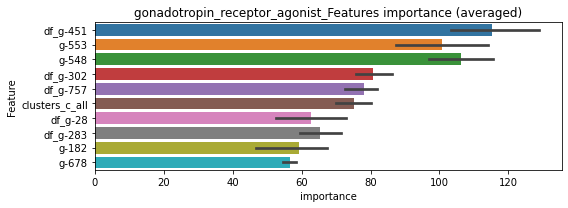

len(train_index) : 3896
len(valid_index) : 3897
================================= fold 1/2 gonadotropin_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0127573	valid_1's binary_logloss: 0.020614
[200]	training's binary_logloss: 0.00149279	valid_1's binary_logloss: 0.00780647
[300]	training's binary_logloss: 0.000414171	valid_1's binary_logloss: 0.00637296
Early stopping, best iteration is:
[301]	training's binary_logloss: 0.00041005	valid_1's binary_logloss: 0.00635875


len(train_index) : 3897
len(valid_index) : 3896
================================= fold 2/2 gonadotropin_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0131695	valid_1's binary_logloss: 0.0179767
[200]	training's binary_logloss: 0.00160083	valid_1's binary_logloss: 0.00662111
[300]	training's binary_logloss: 0.000447607	valid_1's binary_logloss: 0.0049618
Early stopping, best iteration is:
[385]	training's binary_logloss: 0.000251373	valid_1's binary_logloss: 0.0043659


gonadotropin_receptor_agonist logloss: 0.0053624496257182


neg labels: 3289 → selected neg labels: 3279


gsk_inhibitor, len(trt): 60, len(othr): 3279, target_rate: 0.0025195 → Adj_target_rate: 0.0027266
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0339061	valid_1's binary_logloss: 0.0707618
[200]	training's binary_logloss: 0.0053799	valid_1's binary_logloss: 0.0293349
[300]	training's binary_logloss: 0.00158809	valid_1's binary_logloss: 0.020216
[400]	training's binary_logloss: 0.000799017	valid_1's binary_logloss: 0.0175586
Early stopping, best iteration is:
[481]	training's binary_logloss: 0.000563516	valid_1's binary_logloss: 0.0164237
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.034736	valid_1's binary_logloss: 0.0679495
[200]	training's binary_logloss: 0.00550196	valid_1's binary_logloss: 0.0275946
[300]	training's binary_logloss: 0.00163456	valid_1's binary_logloss: 0.0190047
[400]	training's binary_logloss: 0.000807969	valid_1's binary_logloss: 0.0165634
[500]	training's binary_logloss: 0.00053149	valid_1's binary_logloss: 0.015396
Early stopping, best iteration is:
[520]	train

1 / 3 AUC score:1.000
Threshold: 0.0034090, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → positive_corect_labels: 655/3802
p_label_rate: 0.0374184 Vs.target_rate: 0.00252, Num_p_label: 149.0, conf_0:0.00054, conf_1:0.00375
Num_p_label: 149.0, Expected: 10.0, Adj_threshold_1: 0.0034090
Num_p_label: 40.0, Expected: 10.0, Adj_threshold_2: 0.0084090
Num_p_label: 17.0, Expected: 10.0, Adj_threshold_3: 0.0134090
threshold: 0.0134090, positive p_label: 17.0/3982, p_label_rate: 0.0042692
positive y_label: 655.0/3802, y_label_rate: 0.1722777
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0342153	valid_1's binary_logloss: 0.0660596
[200]	training's binary_logloss: 0.0053003	valid_1's binary_logloss: 0.0264961
[300]	training's binary_logloss: 0.00156934	valid_1's binary_logloss: 0.0174808
[400]	training's binary_logloss: 0.000778106	valid_1's binary_logloss: 0.0153308
Early stopping, best iteration is:
[476]	training's binary_logloss: 0.000563392	valid_1's binary_logloss: 0.0144195
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0341125	valid_1's binary_logloss: 0.0683138
[200]	training's binary_logloss: 0.00519516	valid_1's binary_logloss: 0.0273054
[300]	training's binary_logloss: 0.00154058	valid_1's binary_logloss: 0.0183493
[400]	training's binary_logloss: 0.000768406	valid_1's binary_logloss: 0.0154381
Early stopping, best iteration is:
[417]	training's binary_logloss: 0.000705194	valid_1's binary_logloss: 0.0151721


2 / 3 AUC score:1.000
Threshold: 0.0134090, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 3 → positive_corect_labels: 655.0/3799
p_label_rate: 0.0100452 Vs.target_rate: 0.00252, Num_p_label: 40.0, conf_0:0.00077, conf_1:0.01475
Num_p_label: 40.0, Expected: 10.0, Adj_threshold_1: 0.0134090
Num_p_label: 31.0, Expected: 10.0, Adj_threshold_2: 0.0184090
Num_p_label: 23.0, Expected: 10.0, Adj_threshold_3: 0.0234090
Num_p_label: 17.0, Expected: 10.0, Adj_threshold_4: 0.0284090
threshold: 0.0284090, positive p_label: 17.0/3982, p_label_rate: 0.0042692
positive y_label: 655.0/3799, y_label_rate: 0.1724138
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0336351	valid_1's binary_logloss: 0.0669293
[200]	training's binary_logloss: 0.00517225	valid_1's binary_logloss: 0.0271518
[300]	training's binary_logloss: 0.00155995	valid_1's binary_logloss: 0.0183119
[400]	training's binary_logloss: 0.000779047	valid_1's binary_logloss: 0.015184
Early stopping, best iteration is:
[425]	training's binary_logloss: 0.000689026	valid_1's binary_logloss: 0.0146245
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.035188	valid_1's binary_logloss: 0.0668073
[200]	training's binary_logloss: 0.00544377	valid_1's binary_logloss: 0.0247356
[300]	training's binary_logloss: 0.0016002	valid_1's binary_logloss: 0.0164518
[400]	training's binary_logloss: 0.00078373	valid_1's binary_logloss: 0.0140066
Early stopping, best iteration is:
[477]	training's binary_logloss: 0.000557289	valid_1's binary_logloss: 0.0131052


3 / 3 AUC score:1.000
Threshold: 0.0284090, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 3 → positive_corect_labels: 652.0/3796
p_label_rate: 0.0042692 Vs.target_rate: 0.00252, Num_p_label: 17.0, conf_0:0.00074, conf_1:0.03125
threshold: 0.0284090, positive p_label: 17.0/3982, p_label_rate: 0.0042692
positive y_label: 669.0/7778, y_label_rate: 0.0860118


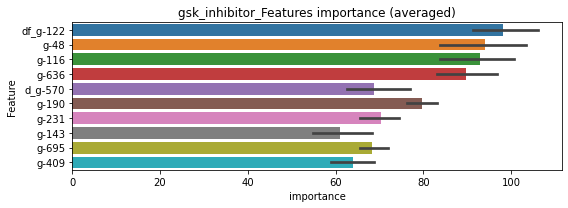

len(train_index) : 3889
len(valid_index) : 3889
================================= fold 1/2 gsk_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0173299	valid_1's binary_logloss: 0.04218
[200]	training's binary_logloss: 0.00257031	valid_1's binary_logloss: 0.0230469
[300]	training's binary_logloss: 0.000766649	valid_1's binary_logloss: 0.0198408
Early stopping, best iteration is:
[290]	training's binary_logloss: 0.000841086	valid_1's binary_logloss: 0.0197975


len(train_index) : 3889
len(valid_index) : 3889
================================= fold 2/2 gsk_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0186534	valid_1's binary_logloss: 0.0346125
[200]	training's binary_logloss: 0.0028419	valid_1's binary_logloss: 0.0143379
[300]	training's binary_logloss: 0.000840951	valid_1's binary_logloss: 0.0107309
Early stopping, best iteration is:
[363]	training's binary_logloss: 0.000519915	valid_1's binary_logloss: 0.0100204


gsk_inhibitor logloss: 0.01490895163246702
hcv_inhibitor, len(trt): 72, len(othr): 3277, target_rate: 0.0030234 → Adj_target_rate: 0.0031837


neg labels: 3289 → selected neg labels: 3277


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0570624	valid_1's binary_logloss: 0.110984
[200]	training's binary_logloss: 0.012938	valid_1's binary_logloss: 0.062548
[300]	training's binary_logloss: 0.00381627	valid_1's binary_logloss: 0.0483301
[400]	training's binary_logloss: 0.00170271	valid_1's binary_logloss: 0.0432184
Early stopping, best iteration is:
[451]	training's binary_logloss: 0.00127544	valid_1's binary_logloss: 0.0422049
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0506904	valid_1's binary_logloss: 0.11683
[200]	training's binary_logloss: 0.0108603	valid_1's binary_logloss: 0.073211
[300]	training's binary_logloss: 0.00325152	valid_1's binary_logloss: 0.0633136
Early stopping, best iteration is:
[345]	training's binary_logloss: 0.00218614	valid_1's binary_logloss: 0.0614702


1 / 3 AUC score:0.997
Threshold: 0.0119892, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 150 → positive_corect_labels: 646/3782
p_label_rate: 0.0318935 Vs.target_rate: 0.00302, Num_p_label: 127.0, conf_0:0.00218, conf_1:0.01319
Num_p_label: 127.0, Expected: 12.0, Adj_threshold_1: 0.0119892
Num_p_label: 69.0, Expected: 12.0, Adj_threshold_2: 0.0169892
Num_p_label: 40.0, Expected: 12.0, Adj_threshold_3: 0.0219892
Num_p_label: 26.0, Expected: 12.0, Adj_threshold_4: 0.0269892
Num_p_label: 18.0, Expected: 12.0, Adj_threshold_5: 0.0319892
threshold: 0.0319892, positive p_label: 18.0/3982, p_label_rate: 0.0045203
positive y_label: 646.0/3782, y_label_rate: 0.1708091
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0520021	valid_1's binary_logloss: 0.102982
[200]	training's binary_logloss: 0.0108392	valid_1's binary_logloss: 0.0539745
[300]	training's binary_logloss: 0.00324251	valid_1's binary_logloss: 0.0426001
Early stopping, best iteration is:
[366]	training's binary_logloss: 0.00186695	valid_1's binary_logloss: 0.0406507
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0518393	valid_1's binary_logloss: 0.102363
[200]	training's binary_logloss: 0.0108869	valid_1's binary_logloss: 0.0509433
[300]	training's binary_logloss: 0.00325415	valid_1's binary_logloss: 0.0368211
[400]	training's binary_logloss: 0.00152587	valid_1's binary_logloss: 0.0336592
Early stopping, best iteration is:
[393]	training's binary_logloss: 0.00159285	valid_1's binary_logloss: 0.0333773


2 / 3 AUC score:0.997
Threshold: 0.0319892, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 15 → positive_corect_labels: 639.0/3767
p_label_rate: 0.0080362 Vs.target_rate: 0.00302, Num_p_label: 32.0, conf_0:0.00238, conf_1:0.03519
threshold: 0.0319892, positive p_label: 32.0/3982, p_label_rate: 0.0080362
positive y_label: 639.0/3767, y_label_rate: 0.1696310
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.049665	valid_1's binary_logloss: 0.117684
[200]	training's binary_logloss: 0.00978089	valid_1's binary_logloss: 0.0709973
[300]	training's binary_logloss: 0.00290239	valid_1's binary_logloss: 0.0605878
Early stopping, best iteration is:
[383]	training's binary_logloss: 0.00152599	valid_1's binary_logloss: 0.0579103
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0500834	valid_1's binary_logloss: 0.110477
[200]	training's binary_logloss: 0.010028	valid_1's binary_logloss: 0.0645277
[300]	training's binary_logloss: 0.00299991	valid_1's binary_logloss: 0.0519796
Early stopping, best iteration is:
[340]	training's binary_logloss: 0.00212612	valid_1's binary_logloss: 0.049584


3 / 3 AUC score:0.997
Threshold: 0.0319892, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 18 → positive_corect_labels: 627.0/3749
p_label_rate: 0.0100452 Vs.target_rate: 0.00302, Num_p_label: 40.0, conf_0:0.00245, conf_1:0.03519
Num_p_label: 40.0, Expected: 12.0, Adj_threshold_1: 0.0319892
Num_p_label: 30.0, Expected: 12.0, Adj_threshold_2: 0.0369892
Num_p_label: 21.0, Expected: 12.0, Adj_threshold_3: 0.0419892
threshold: 0.0419892, positive p_label: 21.0/3982, p_label_rate: 0.0052737
positive y_label: 648.0/7731, y_label_rate: 0.0838184


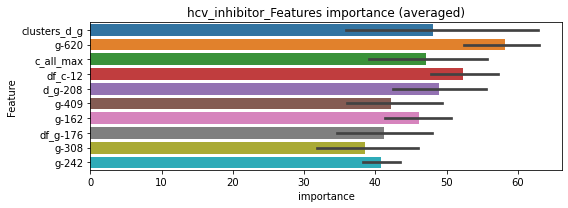

len(train_index) : 3865
len(valid_index) : 3866
================================= fold 1/2 hcv_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.029627	valid_1's binary_logloss: 0.0625248
[200]	training's binary_logloss: 0.00598734	valid_1's binary_logloss: 0.0342109
[300]	training's binary_logloss: 0.0016848	valid_1's binary_logloss: 0.0278816
Early stopping, best iteration is:
[361]	training's binary_logloss: 0.000994244	valid_1's binary_logloss: 0.0268238


len(train_index) : 3866
len(valid_index) : 3865
================================= fold 2/2 hcv_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0280211	valid_1's binary_logloss: 0.0653436
[200]	training's binary_logloss: 0.00564452	valid_1's binary_logloss: 0.0410539
Early stopping, best iteration is:
[282]	training's binary_logloss: 0.0020086	valid_1's binary_logloss: 0.0373942


hcv_inhibitor logloss: 0.03210834181048887


  acetylcholine_receptor_agonist acetylcholine_receptor_antagonist  \
0                       df_g-122                              c-30   
1                  clusters_df_c                         c_all_max   
2                          cnt_0                    clusters_g_all   
3                      c_all_min                          df_g-707   
4                        df_g-51                        clusters_g   
5                       df_c_min                          df_c_min   
6                          cnt_2                             g-514   
7                       df_g-736                          df_g-640   
8                          g-244                            df_c-6   
9                           c-73                          df_g-597   

  acetylcholinesterase_inhibitor adenosine_receptor_antagonist  \
0                      c_all_max                clusters_c_all   
1                      c_all_min                      df_c_min   
2                 clusters_g_al

hdac_inhibitor, len(trt): 106, len(othr): 3271, target_rate: 0.0044512 → Adj_target_rate: 0.0044229


neg labels: 3289 → selected neg labels: 3271


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0321247	valid_1's binary_logloss: 0.0651916
[200]	training's binary_logloss: 0.00482768	valid_1's binary_logloss: 0.0303097
[300]	training's binary_logloss: 0.00143316	valid_1's binary_logloss: 0.023753
Early stopping, best iteration is:
[342]	training's binary_logloss: 0.00101234	valid_1's binary_logloss: 0.0225443
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0314003	valid_1's binary_logloss: 0.0603196
[200]	training's binary_logloss: 0.00488824	valid_1's binary_logloss: 0.0302809
[300]	training's binary_logloss: 0.00144354	valid_1's binary_logloss: 0.0239941
Early stopping, best iteration is:
[348]	training's binary_logloss: 0.000992194	valid_1's binary_logloss: 0.0231405


1 / 3 AUC score:0.999
Threshold: 0.0062450, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 137 → positive_corect_labels: 651/3788
p_label_rate: 0.0690608 Vs.target_rate: 0.00445, Num_p_label: 275.0, conf_0:0.00080, conf_1:0.00687
Num_p_label: 275.0, Expected: 17.7, Adj_threshold_1: 0.0062450
Num_p_label: 165.0, Expected: 17.7, Adj_threshold_2: 0.0112450
Num_p_label: 114.0, Expected: 17.7, Adj_threshold_3: 0.0162450
Num_p_label: 88.0, Expected: 17.7, Adj_threshold_4: 0.0212450
Num_p_label: 63.0, Expected: 17.7, Adj_threshold_5: 0.0262450
Num_p_label: 56.0, Expected: 17.7, Adj_threshold_6: 0.0312450
Num_p_label: 50.0, Expected: 17.7, Adj_threshold_7: 0.0362450
Num_p_label: 46.0, Expected: 17.7, Adj_threshold_8: 0.0412450
Num_p_label: 43.0, Expected: 17.7, Adj_threshold_9: 0.0462450
Num_p_label: 37.0, Expected: 17.7, Adj_threshold_10: 0.0512450
threshold: 0.0562450, positive p_label: 34.0/3982, p_label_rate: 0.0085384
positive y_label: 651.0/3788, y_label_rate: 0.1718585
================= 

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0298974	valid_1's binary_logloss: 0.0508994
[200]	training's binary_logloss: 0.0043357	valid_1's binary_logloss: 0.0177947
[300]	training's binary_logloss: 0.00130323	valid_1's binary_logloss: 0.0116335
[400]	training's binary_logloss: 0.000666831	valid_1's binary_logloss: 0.00964935
[500]	training's binary_logloss: 0.00047293	valid_1's binary_logloss: 0.00880501
Early stopping, best iteration is:
[490]	training's binary_logloss: 0.00048138	valid_1's binary_logloss: 0.00876853
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0302494	valid_1's binary_logloss: 0.0667522
[200]	training's binary_logloss: 0.00426897	valid_1's binary_logloss: 0.0399011


2 / 3 AUC score:1.000
Threshold: 0.0562450, pos_neg_ratio: 0.8000000


Early stopping, best iteration is:
[259]	training's binary_logloss: 0.00189096	valid_1's binary_logloss: 0.0371339


Remove_noisy_labels: 12 → positive_corect_labels: 642.0/3776
p_label_rate: 0.0208438 Vs.target_rate: 0.00445, Num_p_label: 83.0, conf_0:0.00109, conf_1:0.06187
Num_p_label: 83.0, Expected: 17.7, Adj_threshold_1: 0.0562450
Num_p_label: 79.0, Expected: 17.7, Adj_threshold_2: 0.0612450
Num_p_label: 72.0, Expected: 17.7, Adj_threshold_3: 0.0662450
Num_p_label: 70.0, Expected: 17.7, Adj_threshold_4: 0.0712450
Num_p_label: 66.0, Expected: 17.7, Adj_threshold_5: 0.0762450
Num_p_label: 64.0, Expected: 17.7, Adj_threshold_6: 0.0812450
Num_p_label: 61.0, Expected: 17.7, Adj_threshold_7: 0.0862450
Num_p_label: 58.0, Expected: 17.7, Adj_threshold_8: 0.0912450
Num_p_label: 55.0, Expected: 17.7, Adj_threshold_9: 0.0962450
Num_p_label: 53.0, Expected: 17.7, Adj_threshold_10: 0.1012450
threshold: 0.1062450, positive p_label: 52.0/3982, p_label_rate: 0.0130588
positive y_label: 642.0/3776, y_label_rate: 0.1700212
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0309443	valid_1's binary_logloss: 0.0532595
[200]	training's binary_logloss: 0.00435225	valid_1's binary_logloss: 0.0196697
[300]	training's binary_logloss: 0.00125954	valid_1's binary_logloss: 0.0128935
[400]	training's binary_logloss: 0.000645648	valid_1's binary_logloss: 0.0108604
Early stopping, best iteration is:
[391]	training's binary_logloss: 0.000674071	valid_1's binary_logloss: 0.0107989
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0301333	valid_1's binary_logloss: 0.0628992
[200]	training's binary_logloss: 0.00426285	valid_1's binary_logloss: 0.0316817


3 / 3 AUC score:1.000
Threshold: 0.1062450, pos_neg_ratio: 0.8000000


Early stopping, best iteration is:
[271]	training's binary_logloss: 0.00162919	valid_1's binary_logloss: 0.0268167


Remove_noisy_labels: 7 → positive_corect_labels: 635.0/3769
p_label_rate: 0.0140633 Vs.target_rate: 0.00445, Num_p_label: 56.0, conf_0:0.00105, conf_1:0.11687
Num_p_label: 56.0, Expected: 17.7, Adj_threshold_1: 0.1062450
Num_p_label: 55.0, Expected: 17.7, Adj_threshold_2: 0.1112450
Num_p_label: 52.0, Expected: 17.7, Adj_threshold_3: 0.1162450
Num_p_label: 51.0, Expected: 17.7, Adj_threshold_4: 0.1212450
Num_p_label: 50.0, Expected: 17.7, Adj_threshold_5: 0.1262450
Num_p_label: 47.0, Expected: 17.7, Adj_threshold_6: 0.1312450
Num_p_label: 47.0, Expected: 17.7, Adj_threshold_7: 0.1362450
Num_p_label: 44.0, Expected: 17.7, Adj_threshold_8: 0.1412450
Num_p_label: 43.0, Expected: 17.7, Adj_threshold_9: 0.1462450
Num_p_label: 43.0, Expected: 17.7, Adj_threshold_10: 0.1512450
threshold: 0.1562450, positive p_label: 43.0/3982, p_label_rate: 0.0107986
positive y_label: 678.0/7751, y_label_rate: 0.0874726


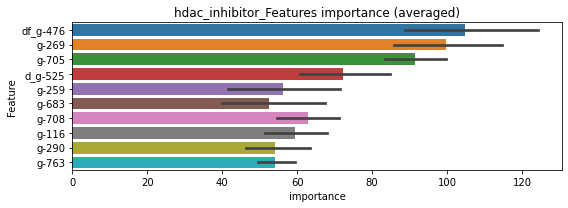

len(train_index) : 3875
len(valid_index) : 3876
================================= fold 1/2 hdac_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0169826	valid_1's binary_logloss: 0.0395496
[200]	training's binary_logloss: 0.0024653	valid_1's binary_logloss: 0.023167
Early stopping, best iteration is:
[278]	training's binary_logloss: 0.000911105	valid_1's binary_logloss: 0.0208929


len(train_index) : 3876
len(valid_index) : 3875
================================= fold 2/2 hdac_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0164848	valid_1's binary_logloss: 0.0395599
[200]	training's binary_logloss: 0.00241983	valid_1's binary_logloss: 0.0260507
Early stopping, best iteration is:
[261]	training's binary_logloss: 0.00106972	valid_1's binary_logloss: 0.0245582


hdac_inhibitor logloss: 0.02272532732510106


  acetylcholine_receptor_agonist acetylcholine_receptor_antagonist  \
0                       df_g-122                              c-30   
1                  clusters_df_c                         c_all_max   
2                          cnt_0                    clusters_g_all   
3                      c_all_min                          df_g-707   
4                        df_g-51                        clusters_g   
5                       df_c_min                          df_c_min   
6                          cnt_2                             g-514   
7                       df_g-736                          df_g-640   
8                          g-244                            df_c-6   
9                           c-73                          df_g-597   

  acetylcholinesterase_inhibitor adenosine_receptor_antagonist  \
0                      c_all_max                clusters_c_all   
1                      c_all_min                      df_c_min   
2                 clusters_g_al

histamine_receptor_agonist, len(trt): 59, len(othr): 3279, target_rate: 0.0024775 → Adj_target_rate: 0.0026880


neg labels: 3289 → selected neg labels: 3279


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0476838	valid_1's binary_logloss: 0.0914134
[200]	training's binary_logloss: 0.00999247	valid_1's binary_logloss: 0.0439015
[300]	training's binary_logloss: 0.00286615	valid_1's binary_logloss: 0.0310931
[400]	training's binary_logloss: 0.00129298	valid_1's binary_logloss: 0.027003
Early stopping, best iteration is:
[448]	training's binary_logloss: 0.00100614	valid_1's binary_logloss: 0.0257773
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0499127	valid_1's binary_logloss: 0.0888839
[200]	training's binary_logloss: 0.0102159	valid_1's binary_logloss: 0.0399021
[300]	training's binary_logloss: 0.00292591	valid_1's binary_logloss: 0.0255454
[400]	training's binary_logloss: 0.00134952	valid_1's binary_logloss: 0.0212996
[500]	training's binary_logloss: 0.000835409	valid_1's binary_logloss: 0.0193015
Early stopping, best iteration is:
[491]	train

1 / 3 AUC score:1.000
Threshold: 0.0075014, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 134 → positive_corect_labels: 654/3800
p_label_rate: 0.0379206 Vs.target_rate: 0.00248, Num_p_label: 151.0, conf_0:0.00104, conf_1:0.00825
Num_p_label: 151.0, Expected: 9.9, Adj_threshold_1: 0.0075014
Num_p_label: 53.0, Expected: 9.9, Adj_threshold_2: 0.0125014
Num_p_label: 23.0, Expected: 9.9, Adj_threshold_3: 0.0175014
Num_p_label: 10.0, Expected: 9.9, Adj_threshold_4: 0.0225014
threshold: 0.0225014, positive p_label: 10.0/3982, p_label_rate: 0.0025113
positive y_label: 654.0/3800, y_label_rate: 0.1721053
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.047967	valid_1's binary_logloss: 0.0861974
[200]	training's binary_logloss: 0.00937755	valid_1's binary_logloss: 0.0370757
[300]	training's binary_logloss: 0.00278586	valid_1's binary_logloss: 0.0226667
[400]	training's binary_logloss: 0.00129565	valid_1's binary_logloss: 0.0182987
[500]	training's binary_logloss: 0.00081464	valid_1's binary_logloss: 0.0164938
Early stopping, best iteration is:
[490]	training's binary_logloss: 0.000840186	valid_1's binary_logloss: 0.0164622
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0493773	valid_1's binary_logloss: 0.0875305
[200]	training's binary_logloss: 0.00991198	valid_1's binary_logloss: 0.0366007
[300]	training's binary_logloss: 0.00282348	valid_1's binary_logloss: 0.0223025
[400]	training's binary_logloss: 0.00129755	valid_1's binary_logloss: 0.017935
Early stopping, best iteration is:
[489]	train

2 / 3 AUC score:1.000
Threshold: 0.0225014, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 10 → positive_corect_labels: 654.0/3790
p_label_rate: 0.0107986 Vs.target_rate: 0.00248, Num_p_label: 43.0, conf_0:0.00102, conf_1:0.02475
Num_p_label: 43.0, Expected: 9.9, Adj_threshold_1: 0.0225014
Num_p_label: 35.0, Expected: 9.9, Adj_threshold_2: 0.0275014
Num_p_label: 20.0, Expected: 9.9, Adj_threshold_3: 0.0325014
Num_p_label: 14.0, Expected: 9.9, Adj_threshold_4: 0.0375014
threshold: 0.0375014, positive p_label: 14.0/3982, p_label_rate: 0.0035158
positive y_label: 654.0/3790, y_label_rate: 0.1725594
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0483963	valid_1's binary_logloss: 0.0857698
[200]	training's binary_logloss: 0.00945634	valid_1's binary_logloss: 0.0363405
[300]	training's binary_logloss: 0.00277008	valid_1's binary_logloss: 0.0230175
[400]	training's binary_logloss: 0.0012759	valid_1's binary_logloss: 0.0188983
[500]	training's binary_logloss: 0.000804139	valid_1's binary_logloss: 0.0169999
Early stopping, best iteration is:
[490]	training's binary_logloss: 0.000828264	valid_1's binary_logloss: 0.0169109
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.049268	valid_1's binary_logloss: 0.0835887
[200]	training's binary_logloss: 0.0099648	valid_1's binary_logloss: 0.0340665
[300]	training's binary_logloss: 0.00289382	valid_1's binary_logloss: 0.0216235
[400]	training's binary_logloss: 0.00130292	valid_1's binary_logloss: 0.0173207
[500]	training's binary_logloss: 0.000811044	v

3 / 3 AUC score:1.000
Threshold: 0.0375014, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 1 → positive_corect_labels: 654.0/3789
p_label_rate: 0.0052737 Vs.target_rate: 0.00248, Num_p_label: 21.0, conf_0:0.00102, conf_1:0.04125
threshold: 0.0375014, positive p_label: 21.0/3982, p_label_rate: 0.0052737
positive y_label: 675.0/7771, y_label_rate: 0.0868614


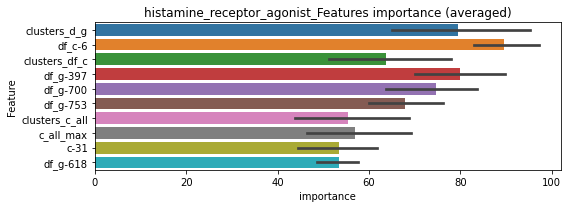

len(train_index) : 3885
len(valid_index) : 3886
================================= fold 1/2 histamine_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0283619	valid_1's binary_logloss: 0.053579
[200]	training's binary_logloss: 0.0059439	valid_1's binary_logloss: 0.0286435
[300]	training's binary_logloss: 0.00168378	valid_1's binary_logloss: 0.0227959
Early stopping, best iteration is:
[364]	training's binary_logloss: 0.0009424	valid_1's binary_logloss: 0.0218779


len(train_index) : 3886
len(valid_index) : 3885
================================= fold 2/2 histamine_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0296331	valid_1's binary_logloss: 0.0547377
[200]	training's binary_logloss: 0.00597742	valid_1's binary_logloss: 0.0267975
[300]	training's binary_logloss: 0.00172162	valid_1's binary_logloss: 0.0209309
Early stopping, best iteration is:
[375]	training's binary_logloss: 0.000902856	valid_1's binary_logloss: 0.0197841


histamine_receptor_agonist logloss: 0.020831155270030755


  acetylcholine_receptor_agonist acetylcholine_receptor_antagonist  \
0                       df_g-122                              c-30   
1                  clusters_df_c                         c_all_max   
2                          cnt_0                    clusters_g_all   
3                      c_all_min                          df_g-707   
4                        df_g-51                        clusters_g   
5                       df_c_min                          df_c_min   
6                          cnt_2                             g-514   
7                       df_g-736                          df_g-640   
8                          g-244                            df_c-6   
9                           c-73                          df_g-597   

  acetylcholinesterase_inhibitor adenosine_receptor_antagonist  \
0                      c_all_max                clusters_c_all   
1                      c_all_min                      df_c_min   
2                 clusters_g_al

histamine_receptor_antagonist, len(trt): 241, len(othr): 3249, target_rate: 0.0101201 → Adj_target_rate: 0.0088902


neg labels: 3289 → selected neg labels: 3249


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.106877	valid_1's binary_logloss: 0.254952
[200]	training's binary_logloss: 0.0391216	valid_1's binary_logloss: 0.219862
Early stopping, best iteration is:
[245]	training's binary_logloss: 0.0253993	valid_1's binary_logloss: 0.215347
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.10612	valid_1's binary_logloss: 0.257382
[200]	training's binary_logloss: 0.0372907	valid_1's binary_logloss: 0.225092
Early stopping, best iteration is:
[230]	training's binary_logloss: 0.0277539	valid_1's binary_logloss: 0.222375


1 / 3 AUC score:0.926
Threshold: 0.0872980, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 367 → positive_corect_labels: 531/3531
p_label_rate: 0.0595178 Vs.target_rate: 0.01012, Num_p_label: 237.0, conf_0:0.03490, conf_1:0.09603
Num_p_label: 237.0, Expected: 40.3, Adj_threshold_1: 0.0872980
Num_p_label: 197.0, Expected: 40.3, Adj_threshold_2: 0.0922980
Num_p_label: 164.0, Expected: 40.3, Adj_threshold_3: 0.0972980
Num_p_label: 136.0, Expected: 40.3, Adj_threshold_4: 0.1022980
Num_p_label: 112.0, Expected: 40.3, Adj_threshold_5: 0.1072980
Num_p_label: 94.0, Expected: 40.3, Adj_threshold_6: 0.1122980
Num_p_label: 77.0, Expected: 40.3, Adj_threshold_7: 0.1172980
threshold: 0.1172980, positive p_label: 77.0/3982, p_label_rate: 0.0193370
positive y_label: 531.0/3531, y_label_rate: 0.1503823
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0728708	valid_1's binary_logloss: 0.178638
[200]	training's binary_logloss: 0.0219134	valid_1's binary_logloss: 0.146833
Early stopping, best iteration is:
[285]	training's binary_logloss: 0.00869401	valid_1's binary_logloss: 0.140541
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.076664	valid_1's binary_logloss: 0.190135
[200]	training's binary_logloss: 0.0219453	valid_1's binary_logloss: 0.153036
Early stopping, best iteration is:
[265]	training's binary_logloss: 0.0106307	valid_1's binary_logloss: 0.145459


2 / 3 AUC score:0.978
Threshold: 0.1172980, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 96 → positive_corect_labels: 450.0/3435
p_label_rate: 0.0072828 Vs.target_rate: 0.01012, Num_p_label: 29.0, conf_0:0.01365, conf_1:0.12903
threshold: 0.1172980, positive p_label: 29.0/3982, p_label_rate: 0.0072828
positive y_label: 450.0/3435, y_label_rate: 0.1310044
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0559544	valid_1's binary_logloss: 0.150852
[200]	training's binary_logloss: 0.0146391	valid_1's binary_logloss: 0.116887
Early stopping, best iteration is:
[247]	training's binary_logloss: 0.00806827	valid_1's binary_logloss: 0.111336
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0566535	valid_1's binary_logloss: 0.143313
[200]	training's binary_logloss: 0.0151275	valid_1's binary_logloss: 0.101864
[300]	training's binary_logloss: 0.00479101	valid_1's binary_logloss: 0.0874155
Early stopping, best iteration is:
[297]	training's binary_logloss: 0.00493521	valid_1's binary_logloss: 0.0872261


3 / 3 AUC score:0.992
Threshold: 0.1172980, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 50 → positive_corect_labels: 404.0/3385
p_label_rate: 0.0030136 Vs.target_rate: 0.01012, Num_p_label: 12.0, conf_0:0.00824, conf_1:0.12903
Num_p_label: 12.0, Expected: 40.3, Adj_threshold_1: 0.1172980
Num_p_label: 15.0, Expected: 40.3, Adj_threshold_2: 0.1122980
Num_p_label: 17.0, Expected: 40.3, Adj_threshold_3: 0.1072980
Num_p_label: 19.0, Expected: 40.3, Adj_threshold_4: 0.1022980
Num_p_label: 21.0, Expected: 40.3, Adj_threshold_5: 0.0972980
threshold: 0.0972980, positive p_label: 21.0/3982, p_label_rate: 0.0052737
positive y_label: 425.0/7367, y_label_rate: 0.0576897


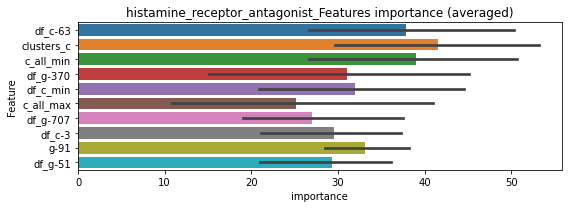

len(train_index) : 3683
len(valid_index) : 3684
================================= fold 1/2 histamine_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0264799	valid_1's binary_logloss: 0.0750542
[200]	training's binary_logloss: 0.00686215	valid_1's binary_logloss: 0.0591309
Early stopping, best iteration is:
[266]	training's binary_logloss: 0.00321204	valid_1's binary_logloss: 0.0567415


len(train_index) : 3684
len(valid_index) : 3683
================================= fold 2/2 histamine_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0249342	valid_1's binary_logloss: 0.076294
[200]	training's binary_logloss: 0.00617328	valid_1's binary_logloss: 0.0613791
Early stopping, best iteration is:
[209]	training's binary_logloss: 0.00553626	valid_1's binary_logloss: 0.0608086


histamine_receptor_antagonist logloss: 0.05877479832908395


  acetylcholine_receptor_agonist acetylcholine_receptor_antagonist  \
0                       df_g-122                              c-30   
1                  clusters_df_c                         c_all_max   
2                          cnt_0                    clusters_g_all   
3                      c_all_min                          df_g-707   
4                        df_g-51                        clusters_g   
5                       df_c_min                          df_c_min   
6                          cnt_2                             g-514   
7                       df_g-736                          df_g-640   
8                          g-244                            df_c-6   
9                           c-73                          df_g-597   

  acetylcholinesterase_inhibitor adenosine_receptor_antagonist  \
0                      c_all_max                clusters_c_all   
1                      c_all_min                      df_c_min   
2                 clusters_g_al

histone_lysine_demethylase_inhibitor, len(trt): 24, len(othr): 3285, target_rate: 0.0010078 → Adj_target_rate: 0.0012513


neg labels: 3289 → selected neg labels: 3285


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0241575	valid_1's binary_logloss: 0.0345122
[200]	training's binary_logloss: 0.00295981	valid_1's binary_logloss: 0.00630008
[300]	training's binary_logloss: 0.000840858	valid_1's binary_logloss: 0.0023237
[400]	training's binary_logloss: 0.000444897	valid_1's binary_logloss: 0.00145314
[500]	training's binary_logloss: 0.000335439	valid_1's binary_logloss: 0.00118855
Early stopping, best iteration is:
[515]	training's binary_logloss: 0.000330309	valid_1's binary_logloss: 0.00117888
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0251051	valid_1's binary_logloss: 0.0372292
[200]	training's binary_logloss: 0.00307641	valid_1's binary_logloss: 0.00754112
[300]	training's binary_logloss: 0.000859002	valid_1's binary_logloss: 0.00362151
[400]	training's binary_logloss: 0.000449312	valid_1's binary_logloss: 0.00263657
Early stopping, best iteration i

1 / 3 AUC score:1.000
Threshold: 0.0014369, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → positive_corect_labels: 657/3810
p_label_rate: 0.0406831 Vs.target_rate: 0.00101, Num_p_label: 162.0, conf_0:0.00025, conf_1:0.00158
Num_p_label: 162.0, Expected: 4.0, Adj_threshold_1: 0.0014369
Num_p_label: 12.0, Expected: 4.0, Adj_threshold_2: 0.0064369
Num_p_label: 2.0, Expected: 4.0, Adj_threshold_3: 0.0114369
threshold: 0.0114369, positive p_label: 2.0/3982, p_label_rate: 0.0005023
positive y_label: 657.0/3810, y_label_rate: 0.1724409
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0242288	valid_1's binary_logloss: 0.0333948
[200]	training's binary_logloss: 0.00290501	valid_1's binary_logloss: 0.0057871
[300]	training's binary_logloss: 0.000834117	valid_1's binary_logloss: 0.00210516
[400]	training's binary_logloss: 0.000439398	valid_1's binary_logloss: 0.00127329
[500]	training's binary_logloss: 0.000334208	valid_1's binary_logloss: 0.00104292
Early stopping, best iteration is:
[514]	training's binary_logloss: 0.000332257	valid_1's binary_logloss: 0.00104042
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.024973	valid_1's binary_logloss: 0.0356699
[200]	training's binary_logloss: 0.00305139	valid_1's binary_logloss: 0.0073395
[300]	training's binary_logloss: 0.000854783	valid_1's binary_logloss: 0.00358056
[400]	training's binary_logloss: 0.000445519	valid_1's binary_logloss: 0.00264086
Early stopping, best iteration is:

2 / 3 AUC score:1.000
Threshold: 0.0114369, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → positive_corect_labels: 657.0/3810
p_label_rate: 0.0020090 Vs.target_rate: 0.00101, Num_p_label: 8.0, conf_0:0.00029, conf_1:0.01258
threshold: 0.0114369, positive p_label: 8.0/3982, p_label_rate: 0.0020090
positive y_label: 657.0/3810, y_label_rate: 0.1724409
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0242288	valid_1's binary_logloss: 0.0333948
[200]	training's binary_logloss: 0.00290501	valid_1's binary_logloss: 0.0057871
[300]	training's binary_logloss: 0.000834117	valid_1's binary_logloss: 0.00210516
[400]	training's binary_logloss: 0.000439398	valid_1's binary_logloss: 0.00127329
[500]	training's binary_logloss: 0.000334208	valid_1's binary_logloss: 0.00104292
Early stopping, best iteration is:
[514]	training's binary_logloss: 0.000332257	valid_1's binary_logloss: 0.00104042
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.024973	valid_1's binary_logloss: 0.0356699
[200]	training's binary_logloss: 0.00305139	valid_1's binary_logloss: 0.0073395
[300]	training's binary_logloss: 0.000854783	valid_1's binary_logloss: 0.00358056
[400]	training's binary_logloss: 0.000445519	valid_1's binary_logloss: 0.00264086
Early stopping, best iteration is:

3 / 3 AUC score:1.000
Threshold: 0.0114369, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → positive_corect_labels: 657.0/3810
p_label_rate: 0.0020090 Vs.target_rate: 0.00101, Num_p_label: 8.0, conf_0:0.00029, conf_1:0.01258
threshold: 0.0114369, positive p_label: 8.0/3982, p_label_rate: 0.0020090
positive y_label: 665.0/7792, y_label_rate: 0.0853439


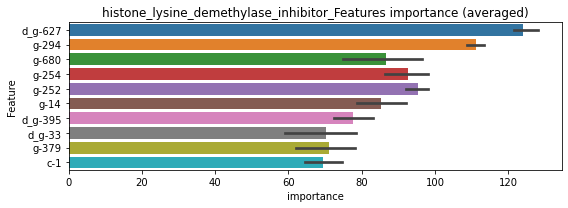

len(train_index) : 3896
len(valid_index) : 3896
================================= fold 1/2 histone_lysine_demethylase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.012969	valid_1's binary_logloss: 0.0227823
[200]	training's binary_logloss: 0.00152285	valid_1's binary_logloss: 0.00949874
Early stopping, best iteration is:
[280]	training's binary_logloss: 0.000523214	valid_1's binary_logloss: 0.00853089


len(train_index) : 3896
len(valid_index) : 3896
================================= fold 2/2 histone_lysine_demethylase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0132516	valid_1's binary_logloss: 0.019396
[200]	training's binary_logloss: 0.00160128	valid_1's binary_logloss: 0.00571434
[300]	training's binary_logloss: 0.000514597	valid_1's binary_logloss: 0.00420976
[400]	training's binary_logloss: 0.000261407	valid_1's binary_logloss: 0.00388569
Early stopping, best iteration is:
[405]	training's binary_logloss: 0.000252574	valid_1's binary_logloss: 0.00386753


histone_lysine_demethylase_inhibitor logloss: 0.00619920915574406
histone_lysine_methyltransferase_inhibitor, len(trt): 32, len(othr): 3283, target_rate: 0.0013437 → Adj_target_rate: 0.0015980


neg labels: 3289 → selected neg labels: 3283


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0299756	valid_1's binary_logloss: 0.0554528
[200]	training's binary_logloss: 0.00416074	valid_1's binary_logloss: 0.0193166
Early stopping, best iteration is:
[274]	training's binary_logloss: 0.0015441	valid_1's binary_logloss: 0.0141756
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0311293	valid_1's binary_logloss: 0.0504748
[200]	training's binary_logloss: 0.0044259	valid_1's binary_logloss: 0.012181
[300]	training's binary_logloss: 0.00126346	valid_1's binary_logloss: 0.00549682
[400]	training's binary_logloss: 0.00063515	valid_1's binary_logloss: 0.00359489
[500]	training's binary_logloss: 0.000440154	valid_1's binary_logloss: 0.00287321
[600]	training's binary_logloss: 0.000397051	valid_1's binary_logloss: 0.00272958
Early stopping, best iteration is:
[591]	training's binary_logloss: 0.00039801	valid_1's binary_logloss: 0.00272738


1 / 3 AUC score:1.000
Threshold: 0.0055462, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → positive_corect_labels: 656/3807
p_label_rate: 0.0313913 Vs.target_rate: 0.00134, Num_p_label: 125.0, conf_0:0.00075, conf_1:0.00610
Num_p_label: 125.0, Expected: 5.4, Adj_threshold_1: 0.0055462
Num_p_label: 54.0, Expected: 5.4, Adj_threshold_2: 0.0105462
Num_p_label: 26.0, Expected: 5.4, Adj_threshold_3: 0.0155462
Num_p_label: 15.0, Expected: 5.4, Adj_threshold_4: 0.0205462
Num_p_label: 6.0, Expected: 5.4, Adj_threshold_5: 0.0255462
threshold: 0.0255462, positive p_label: 6.0/3982, p_label_rate: 0.0015068
positive y_label: 656.0/3807, y_label_rate: 0.1723142
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0297752	valid_1's binary_logloss: 0.0568207
[200]	training's binary_logloss: 0.00408531	valid_1's binary_logloss: 0.0204224
[300]	training's binary_logloss: 0.00117756	valid_1's binary_logloss: 0.0144354
[400]	training's binary_logloss: 0.000598511	valid_1's binary_logloss: 0.0127448
Early stopping, best iteration is:
[428]	training's binary_logloss: 0.000525899	valid_1's binary_logloss: 0.0123074
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.031144	valid_1's binary_logloss: 0.0505694
[200]	training's binary_logloss: 0.00440968	valid_1's binary_logloss: 0.0122857
[300]	training's binary_logloss: 0.0012561	valid_1's binary_logloss: 0.00535894
[400]	training's binary_logloss: 0.000632054	valid_1's binary_logloss: 0.00349902
Early stopping, best iteration is:
[480]	training's binary_logloss: 0.000460202	valid_1's binary_logloss: 0.00285143


2 / 3 AUC score:1.000
Threshold: 0.0255462, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 1 → positive_corect_labels: 655.0/3806
p_label_rate: 0.0065294 Vs.target_rate: 0.00134, Num_p_label: 26.0, conf_0:0.00044, conf_1:0.02810
Num_p_label: 26.0, Expected: 5.4, Adj_threshold_1: 0.0255462
Num_p_label: 22.0, Expected: 5.4, Adj_threshold_2: 0.0305462
Num_p_label: 18.0, Expected: 5.4, Adj_threshold_3: 0.0355462
Num_p_label: 16.0, Expected: 5.4, Adj_threshold_4: 0.0405462
Num_p_label: 13.0, Expected: 5.4, Adj_threshold_5: 0.0455462
Num_p_label: 12.0, Expected: 5.4, Adj_threshold_6: 0.0505462
Num_p_label: 10.0, Expected: 5.4, Adj_threshold_7: 0.0555462
threshold: 0.0555462, positive p_label: 10.0/3982, p_label_rate: 0.0025113
positive y_label: 655.0/3806, y_label_rate: 0.1720967
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0299781	valid_1's binary_logloss: 0.0468832
[200]	training's binary_logloss: 0.0042112	valid_1's binary_logloss: 0.0115538
[300]	training's binary_logloss: 0.00120178	valid_1's binary_logloss: 0.00510963
[400]	training's binary_logloss: 0.000612894	valid_1's binary_logloss: 0.00348103
[500]	training's binary_logloss: 0.000430334	valid_1's binary_logloss: 0.0028801
Early stopping, best iteration is:
[551]	training's binary_logloss: 0.000399494	valid_1's binary_logloss: 0.00278184
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.030438	valid_1's binary_logloss: 0.050565
[200]	training's binary_logloss: 0.00430166	valid_1's binary_logloss: 0.013213
[300]	training's binary_logloss: 0.00123161	valid_1's binary_logloss: 0.00599649
[400]	training's binary_logloss: 0.000623643	valid_1's binary_logloss: 0.00412841
[500]	training's binary_logloss: 0.00043

3 / 3 AUC score:1.000
Threshold: 0.0555462, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → positive_corect_labels: 655.0/3806
p_label_rate: 0.0017579 Vs.target_rate: 0.00134, Num_p_label: 7.0, conf_0:0.00035, conf_1:0.06110
threshold: 0.0555462, positive p_label: 7.0/3982, p_label_rate: 0.0017579
positive y_label: 662.0/7788, y_label_rate: 0.0850026


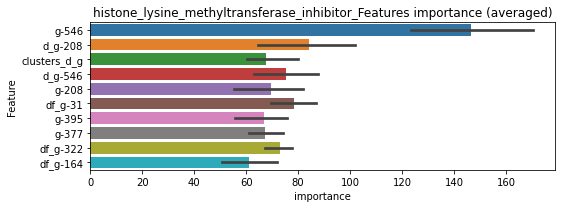

len(train_index) : 3894
len(valid_index) : 3894
================================= fold 1/2 histone_lysine_methyltransferase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0157903	valid_1's binary_logloss: 0.0279458
[200]	training's binary_logloss: 0.00216268	valid_1's binary_logloss: 0.010624
[300]	training's binary_logloss: 0.000613559	valid_1's binary_logloss: 0.00824642
Early stopping, best iteration is:
[375]	training's binary_logloss: 0.000354527	valid_1's binary_logloss: 0.00761175


len(train_index) : 3894
len(valid_index) : 3894
================================= fold 2/2 histone_lysine_methyltransferase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0164763	valid_1's binary_logloss: 0.0288848
[200]	training's binary_logloss: 0.0023273	valid_1's binary_logloss: 0.00902323
[300]	training's binary_logloss: 0.000653775	valid_1's binary_logloss: 0.00560298
[400]	training's binary_logloss: 0.000324951	valid_1's binary_logloss: 0.00484745
Early stopping, best iteration is:
[425]	training's binary_logloss: 0.000288401	valid_1's binary_logloss: 0.00474205


histone_lysine_methyltransferase_inhibitor logloss: 0.006176899395365998
hiv_inhibitor, len(trt): 72, len(othr): 3278, target_rate: 0.0030234 → Adj_target_rate: 0.0031837


neg labels: 3289 → selected neg labels: 3278


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0534072	valid_1's binary_logloss: 0.112009
[200]	training's binary_logloss: 0.0112993	valid_1's binary_logloss: 0.0614488
[300]	training's binary_logloss: 0.00338381	valid_1's binary_logloss: 0.0488814
[400]	training's binary_logloss: 0.00153213	valid_1's binary_logloss: 0.0447963
Early stopping, best iteration is:
[446]	training's binary_logloss: 0.00118839	valid_1's binary_logloss: 0.043619
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0590531	valid_1's binary_logloss: 0.105583
[200]	training's binary_logloss: 0.0132418	valid_1's binary_logloss: 0.0532236
[300]	training's binary_logloss: 0.00379145	valid_1's binary_logloss: 0.0371156
[400]	training's binary_logloss: 0.00167533	valid_1's binary_logloss: 0.0318019
[500]	training's binary_logloss: 0.00101029	valid_1's binary_logloss: 0.0298325
Early stopping, best iteration is:
[495]	training'

1 / 3 AUC score:0.999
Threshold: 0.0094092, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 138 → positive_corect_labels: 652/3795
p_label_rate: 0.0349071 Vs.target_rate: 0.00302, Num_p_label: 139.0, conf_0:0.00130, conf_1:0.01035
Num_p_label: 139.0, Expected: 12.0, Adj_threshold_1: 0.0094092
Num_p_label: 60.0, Expected: 12.0, Adj_threshold_2: 0.0144092
Num_p_label: 35.0, Expected: 12.0, Adj_threshold_3: 0.0194092
Num_p_label: 15.0, Expected: 12.0, Adj_threshold_4: 0.0244092
threshold: 0.0244092, positive p_label: 15.0/3982, p_label_rate: 0.0037670
positive y_label: 652.0/3795, y_label_rate: 0.1718050
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0561742	valid_1's binary_logloss: 0.103547
[200]	training's binary_logloss: 0.0119578	valid_1's binary_logloss: 0.0502197
[300]	training's binary_logloss: 0.00349758	valid_1's binary_logloss: 0.0372066
[400]	training's binary_logloss: 0.00157735	valid_1's binary_logloss: 0.0324644
Early stopping, best iteration is:
[480]	training's binary_logloss: 0.00104673	valid_1's binary_logloss: 0.0311648
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0571239	valid_1's binary_logloss: 0.106337
[200]	training's binary_logloss: 0.01212	valid_1's binary_logloss: 0.0486046
[300]	training's binary_logloss: 0.00357661	valid_1's binary_logloss: 0.032374
[400]	training's binary_logloss: 0.0016176	valid_1's binary_logloss: 0.0273247
[500]	training's binary_logloss: 0.000985448	valid_1's binary_logloss: 0.0252834
Early stopping, best iteration is:
[490]	training's 

2 / 3 AUC score:1.000
Threshold: 0.0244092, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 20 → positive_corect_labels: 647.0/3775
p_label_rate: 0.0138122 Vs.target_rate: 0.00302, Num_p_label: 55.0, conf_0:0.00138, conf_1:0.02685
Num_p_label: 55.0, Expected: 12.0, Adj_threshold_1: 0.0244092
Num_p_label: 40.0, Expected: 12.0, Adj_threshold_2: 0.0294092
Num_p_label: 33.0, Expected: 12.0, Adj_threshold_3: 0.0344092
Num_p_label: 23.0, Expected: 12.0, Adj_threshold_4: 0.0394092
threshold: 0.0394092, positive p_label: 23.0/3982, p_label_rate: 0.0057760
positive y_label: 647.0/3775, y_label_rate: 0.1713907
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0540308	valid_1's binary_logloss: 0.104286
[200]	training's binary_logloss: 0.0114661	valid_1's binary_logloss: 0.0524375
[300]	training's binary_logloss: 0.00327755	valid_1's binary_logloss: 0.0374069
[400]	training's binary_logloss: 0.00149873	valid_1's binary_logloss: 0.0333267
Early stopping, best iteration is:
[424]	training's binary_logloss: 0.00130699	valid_1's binary_logloss: 0.0326225
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0548926	valid_1's binary_logloss: 0.0999544
[200]	training's binary_logloss: 0.0113697	valid_1's binary_logloss: 0.045454
[300]	training's binary_logloss: 0.00340699	valid_1's binary_logloss: 0.0304403
[400]	training's binary_logloss: 0.00154517	valid_1's binary_logloss: 0.0254846
Early stopping, best iteration is:
[455]	training's binary_logloss: 0.00114666	valid_1's binary_logloss: 0.0242467


3 / 3 AUC score:1.000
Threshold: 0.0394092, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 8 → positive_corect_labels: 643.0/3767
p_label_rate: 0.0065294 Vs.target_rate: 0.00302, Num_p_label: 26.0, conf_0:0.00159, conf_1:0.04335
threshold: 0.0394092, positive p_label: 26.0/3982, p_label_rate: 0.0065294
positive y_label: 669.0/7749, y_label_rate: 0.0863337


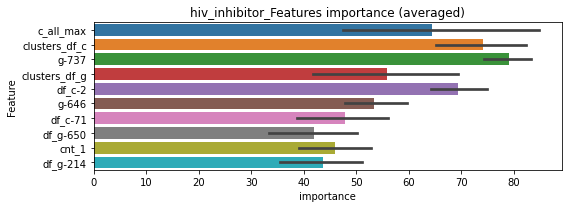

len(train_index) : 3874
len(valid_index) : 3875
================================= fold 1/2 hiv_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0324502	valid_1's binary_logloss: 0.0672878
[200]	training's binary_logloss: 0.00687904	valid_1's binary_logloss: 0.0404639
[300]	training's binary_logloss: 0.00199291	valid_1's binary_logloss: 0.0346686
Early stopping, best iteration is:
[334]	training's binary_logloss: 0.00142797	valid_1's binary_logloss: 0.0342261


len(train_index) : 3875
len(valid_index) : 3874
================================= fold 2/2 hiv_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0314568	valid_1's binary_logloss: 0.06428
[200]	training's binary_logloss: 0.00681643	valid_1's binary_logloss: 0.0372368
[300]	training's binary_logloss: 0.00201632	valid_1's binary_logloss: 0.0308427
Early stopping, best iteration is:
[323]	training's binary_logloss: 0.0016217	valid_1's binary_logloss: 0.0301971


hiv_inhibitor logloss: 0.03221186230234152


  acetylcholine_receptor_agonist acetylcholine_receptor_antagonist  \
0                       df_g-122                              c-30   
1                  clusters_df_c                         c_all_max   
2                          cnt_0                    clusters_g_all   
3                      c_all_min                          df_g-707   
4                        df_g-51                        clusters_g   
5                       df_c_min                          df_c_min   
6                          cnt_2                             g-514   
7                       df_g-736                          df_g-640   
8                          g-244                            df_c-6   
9                           c-73                          df_g-597   

  acetylcholinesterase_inhibitor adenosine_receptor_antagonist  \
0                      c_all_max                clusters_c_all   
1                      c_all_min                      df_c_min   
2                 clusters_g_al

hmgcr_inhibitor, len(trt): 283, len(othr): 3282, target_rate: 0.0118838 → Adj_target_rate: 0.0101910


neg labels: 3289 → selected neg labels: 3282


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0408245	valid_1's binary_logloss: 0.0929328
[200]	training's binary_logloss: 0.00759233	valid_1's binary_logloss: 0.0611115
[300]	training's binary_logloss: 0.00232126	valid_1's binary_logloss: 0.0540098
Early stopping, best iteration is:
[332]	training's binary_logloss: 0.0017528	valid_1's binary_logloss: 0.0532034
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0405063	valid_1's binary_logloss: 0.103183
[200]	training's binary_logloss: 0.007375	valid_1's binary_logloss: 0.0787808


1 / 3 AUC score:0.993
Threshold: 0.0373409, pos_neg_ratio: 0.8000000


Early stopping, best iteration is:
[217]	training's binary_logloss: 0.00579206	valid_1's binary_logloss: 0.0773639


Remove_noisy_labels: 168 → positive_corect_labels: 638/3770
p_label_rate: 0.0597690 Vs.target_rate: 0.01188, Num_p_label: 238.0, conf_0:0.00195, conf_1:0.04108
Num_p_label: 238.0, Expected: 47.3, Adj_threshold_1: 0.0373409
Num_p_label: 222.0, Expected: 47.3, Adj_threshold_2: 0.0423409
Num_p_label: 204.0, Expected: 47.3, Adj_threshold_3: 0.0473409
Num_p_label: 194.0, Expected: 47.3, Adj_threshold_4: 0.0523409
Num_p_label: 175.0, Expected: 47.3, Adj_threshold_5: 0.0573409
Num_p_label: 157.0, Expected: 47.3, Adj_threshold_6: 0.0623409
Num_p_label: 148.0, Expected: 47.3, Adj_threshold_7: 0.0673409
Num_p_label: 142.0, Expected: 47.3, Adj_threshold_8: 0.0723409
Num_p_label: 138.0, Expected: 47.3, Adj_threshold_9: 0.0773409
Num_p_label: 134.0, Expected: 47.3, Adj_threshold_10: 0.0823409
threshold: 0.0873409, positive p_label: 130.0/3982, p_label_rate: 0.0326469
positive y_label: 638.0/3770, y_label_rate: 0.1692308
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0324726	valid_1's binary_logloss: 0.0809026
[200]	training's binary_logloss: 0.00515279	valid_1's binary_logloss: 0.0555358
Early stopping, best iteration is:
[240]	training's binary_logloss: 0.0028638	valid_1's binary_logloss: 0.0526012
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0348738	valid_1's binary_logloss: 0.0604662
[200]	training's binary_logloss: 0.00563086	valid_1's binary_logloss: 0.0259504
[300]	training's binary_logloss: 0.00158346	valid_1's binary_logloss: 0.018305
[400]	training's binary_logloss: 0.000746881	valid_1's binary_logloss: 0.0156767
[500]	training's binary_logloss: 0.000500791	valid_1's binary_logloss: 0.0147378
Early stopping, best iteration is:
[492]	training's binary_logloss: 0.000510995	valid_1's binary_logloss: 0.0147225


2 / 3 AUC score:0.998
Threshold: 0.0873409, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 36 → positive_corect_labels: 625.0/3734
p_label_rate: 0.0519839 Vs.target_rate: 0.01188, Num_p_label: 207.0, conf_0:0.00091, conf_1:0.09608
Num_p_label: 207.0, Expected: 47.3, Adj_threshold_1: 0.0873409
Num_p_label: 203.0, Expected: 47.3, Adj_threshold_2: 0.0923409
Num_p_label: 198.0, Expected: 47.3, Adj_threshold_3: 0.0973409
Num_p_label: 194.0, Expected: 47.3, Adj_threshold_4: 0.1023409
Num_p_label: 189.0, Expected: 47.3, Adj_threshold_5: 0.1073409
Num_p_label: 187.0, Expected: 47.3, Adj_threshold_6: 0.1123409
Num_p_label: 184.0, Expected: 47.3, Adj_threshold_7: 0.1173409
Num_p_label: 182.0, Expected: 47.3, Adj_threshold_8: 0.1223409
Num_p_label: 179.0, Expected: 47.3, Adj_threshold_9: 0.1273409
Num_p_label: 175.0, Expected: 47.3, Adj_threshold_10: 0.1323409
threshold: 0.1373409, positive p_label: 173.0/3982, p_label_rate: 0.0434455
positive y_label: 625.0/3734, y_label_rate: 0.1673808
=========

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0314309	valid_1's binary_logloss: 0.0558086
[200]	training's binary_logloss: 0.00482715	valid_1's binary_logloss: 0.0218861
[300]	training's binary_logloss: 0.00132678	valid_1's binary_logloss: 0.0143189
[400]	training's binary_logloss: 0.000613716	valid_1's binary_logloss: 0.0126132
Early stopping, best iteration is:
[410]	training's binary_logloss: 0.000583491	valid_1's binary_logloss: 0.0124865
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0317082	valid_1's binary_logloss: 0.0603348
[200]	training's binary_logloss: 0.00489212	valid_1's binary_logloss: 0.0294261


3 / 3 AUC score:1.000
Threshold: 0.1373409, pos_neg_ratio: 0.8000000


Early stopping, best iteration is:
[255]	training's binary_logloss: 0.00216582	valid_1's binary_logloss: 0.0242354


Remove_noisy_labels: 15 → positive_corect_labels: 619.0/3719
p_label_rate: 0.0499749 Vs.target_rate: 0.01188, Num_p_label: 199.0, conf_0:0.00075, conf_1:0.15108
Num_p_label: 199.0, Expected: 47.3, Adj_threshold_1: 0.1373409
Num_p_label: 197.0, Expected: 47.3, Adj_threshold_2: 0.1423409
Num_p_label: 195.0, Expected: 47.3, Adj_threshold_3: 0.1473409
Num_p_label: 190.0, Expected: 47.3, Adj_threshold_4: 0.1523409
Num_p_label: 189.0, Expected: 47.3, Adj_threshold_5: 0.1573409
Num_p_label: 189.0, Expected: 47.3, Adj_threshold_6: 0.1623409
Num_p_label: 189.0, Expected: 47.3, Adj_threshold_7: 0.1673409
Num_p_label: 187.0, Expected: 47.3, Adj_threshold_8: 0.1723409
Num_p_label: 185.0, Expected: 47.3, Adj_threshold_9: 0.1773409
Num_p_label: 184.0, Expected: 47.3, Adj_threshold_10: 0.1823409
threshold: 0.1873409, positive p_label: 184.0/3982, p_label_rate: 0.0462079
positive y_label: 803.0/7701, y_label_rate: 0.1042722


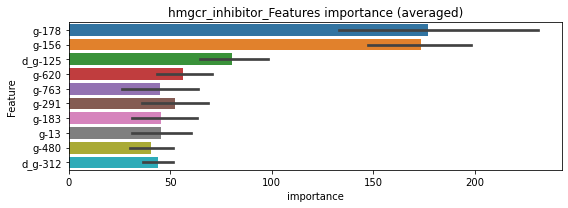

len(train_index) : 3850
len(valid_index) : 3851
================================= fold 1/2 hmgcr_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0212164	valid_1's binary_logloss: 0.0469095
[200]	training's binary_logloss: 0.00348766	valid_1's binary_logloss: 0.0259965
[300]	training's binary_logloss: 0.000953727	valid_1's binary_logloss: 0.0203932
Early stopping, best iteration is:
[363]	training's binary_logloss: 0.00057025	valid_1's binary_logloss: 0.0190407


len(train_index) : 3851
len(valid_index) : 3850
================================= fold 2/2 hmgcr_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0217923	valid_1's binary_logloss: 0.046917
[200]	training's binary_logloss: 0.00355796	valid_1's binary_logloss: 0.0273409
[300]	training's binary_logloss: 0.000970792	valid_1's binary_logloss: 0.0215834
Early stopping, best iteration is:
[345]	training's binary_logloss: 0.00065978	valid_1's binary_logloss: 0.0210045


hmgcr_inhibitor logloss: 0.020022473954240422


  acetylcholine_receptor_agonist acetylcholine_receptor_antagonist  \
0                       df_g-122                              c-30   
1                  clusters_df_c                         c_all_max   
2                          cnt_0                    clusters_g_all   
3                      c_all_min                          df_g-707   
4                        df_g-51                        clusters_g   
5                       df_c_min                          df_c_min   
6                          cnt_2                             g-514   
7                       df_g-736                          df_g-640   
8                          g-244                            df_c-6   
9                           c-73                          df_g-597   

  acetylcholinesterase_inhibitor adenosine_receptor_antagonist  \
0                      c_all_max                clusters_c_all   
1                      c_all_min                      df_c_min   
2                 clusters_g_al

hsp_inhibitor, len(trt): 93, len(othr): 3275, target_rate: 0.0039053 → Adj_target_rate: 0.0039574


neg labels: 3289 → selected neg labels: 3275


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0267935	valid_1's binary_logloss: 0.0483962
[200]	training's binary_logloss: 0.0036051	valid_1's binary_logloss: 0.02045
Early stopping, best iteration is:
[274]	training's binary_logloss: 0.00134808	valid_1's binary_logloss: 0.0153406
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0278944	valid_1's binary_logloss: 0.0583492
[200]	training's binary_logloss: 0.00367535	valid_1's binary_logloss: 0.0308227


1 / 3 AUC score:1.000
Threshold: 0.0048212, pos_neg_ratio: 0.8000000


Early stopping, best iteration is:
[286]	training's binary_logloss: 0.00117433	valid_1's binary_logloss: 0.02536


Remove_noisy_labels: 133 → positive_corect_labels: 654/3797
p_label_rate: 0.0469613 Vs.target_rate: 0.00391, Num_p_label: 187.0, conf_0:0.00092, conf_1:0.00530
Num_p_label: 187.0, Expected: 15.6, Adj_threshold_1: 0.0048212
Num_p_label: 109.0, Expected: 15.6, Adj_threshold_2: 0.0098212
Num_p_label: 84.0, Expected: 15.6, Adj_threshold_3: 0.0148212
Num_p_label: 77.0, Expected: 15.6, Adj_threshold_4: 0.0198212
Num_p_label: 69.0, Expected: 15.6, Adj_threshold_5: 0.0248212
Num_p_label: 66.0, Expected: 15.6, Adj_threshold_6: 0.0298212
Num_p_label: 60.0, Expected: 15.6, Adj_threshold_7: 0.0348212
Num_p_label: 58.0, Expected: 15.6, Adj_threshold_8: 0.0398212
Num_p_label: 54.0, Expected: 15.6, Adj_threshold_9: 0.0448212
Num_p_label: 51.0, Expected: 15.6, Adj_threshold_10: 0.0498212
threshold: 0.0548212, positive p_label: 50.0/3982, p_label_rate: 0.0125565
positive y_label: 654.0/3797, y_label_rate: 0.1722412
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0276629	valid_1's binary_logloss: 0.0479549
[200]	training's binary_logloss: 0.00355262	valid_1's binary_logloss: 0.0203423
[300]	training's binary_logloss: 0.00101623	valid_1's binary_logloss: 0.0163354
Early stopping, best iteration is:
[323]	training's binary_logloss: 0.000832687	valid_1's binary_logloss: 0.0159558
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0270682	valid_1's binary_logloss: 0.0657624
[200]	training's binary_logloss: 0.00336169	valid_1's binary_logloss: 0.0455317


2 / 3 AUC score:0.995
Threshold: 0.0548212, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 13 → positive_corect_labels: 641.0/3784
p_label_rate: 0.0208438 Vs.target_rate: 0.00391, Num_p_label: 83.0, conf_0:0.00116, conf_1:0.06030
Num_p_label: 83.0, Expected: 15.6, Adj_threshold_1: 0.0548212
Num_p_label: 78.0, Expected: 15.6, Adj_threshold_2: 0.0598212


Early stopping, best iteration is:
[230]	training's binary_logloss: 0.00210071	valid_1's binary_logloss: 0.0446046


Num_p_label: 77.0, Expected: 15.6, Adj_threshold_3: 0.0648212
Num_p_label: 75.0, Expected: 15.6, Adj_threshold_4: 0.0698212
Num_p_label: 73.0, Expected: 15.6, Adj_threshold_5: 0.0748212
Num_p_label: 73.0, Expected: 15.6, Adj_threshold_6: 0.0798212
Num_p_label: 71.0, Expected: 15.6, Adj_threshold_7: 0.0848212
Num_p_label: 67.0, Expected: 15.6, Adj_threshold_8: 0.0898212
Num_p_label: 65.0, Expected: 15.6, Adj_threshold_9: 0.0948212
Num_p_label: 64.0, Expected: 15.6, Adj_threshold_10: 0.0998212
threshold: 0.1048212, positive p_label: 63.0/3982, p_label_rate: 0.0158212
positive y_label: 641.0/3784, y_label_rate: 0.1693975
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0261722	valid_1's binary_logloss: 0.0422051
[200]	training's binary_logloss: 0.00317975	valid_1's binary_logloss: 0.0160491
[300]	training's binary_logloss: 0.000888721	valid_1's binary_logloss: 0.0112028
Early stopping, best iteration is:
[346]	training's binary_logloss: 0.000625464	valid_1's binary_logloss: 0.0101741
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.027304	valid_1's binary_logloss: 0.0431628
[200]	training's binary_logloss: 0.00341921	valid_1's binary_logloss: 0.0146523
[300]	training's binary_logloss: 0.00095541	valid_1's binary_logloss: 0.00998599


3 / 3 AUC score:1.000
Threshold: 0.1048212, pos_neg_ratio: 0.8000000


Early stopping, best iteration is:
[309]	training's binary_logloss: 0.000880608	valid_1's binary_logloss: 0.00973596


Remove_noisy_labels: 4 → positive_corect_labels: 637.0/3780
p_label_rate: 0.0160723 Vs.target_rate: 0.00391, Num_p_label: 64.0, conf_0:0.00061, conf_1:0.11530
Num_p_label: 64.0, Expected: 15.6, Adj_threshold_1: 0.1048212
Num_p_label: 63.0, Expected: 15.6, Adj_threshold_2: 0.1098212
Num_p_label: 62.0, Expected: 15.6, Adj_threshold_3: 0.1148212
Num_p_label: 62.0, Expected: 15.6, Adj_threshold_4: 0.1198212
Num_p_label: 62.0, Expected: 15.6, Adj_threshold_5: 0.1248212
Num_p_label: 61.0, Expected: 15.6, Adj_threshold_6: 0.1298212
Num_p_label: 61.0, Expected: 15.6, Adj_threshold_7: 0.1348212
Num_p_label: 61.0, Expected: 15.6, Adj_threshold_8: 0.1398212
Num_p_label: 61.0, Expected: 15.6, Adj_threshold_9: 0.1448212
Num_p_label: 61.0, Expected: 15.6, Adj_threshold_10: 0.1498212
threshold: 0.1548212, positive p_label: 60.0/3982, p_label_rate: 0.0150678
positive y_label: 697.0/7762, y_label_rate: 0.0897964


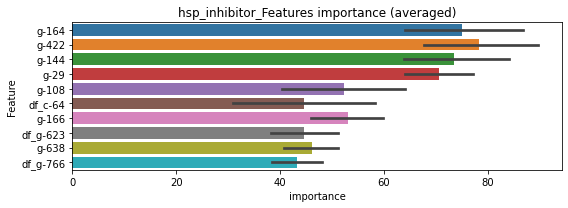

len(train_index) : 3881
len(valid_index) : 3881
================================= fold 1/2 hsp_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0153854	valid_1's binary_logloss: 0.0285201
[200]	training's binary_logloss: 0.00193841	valid_1's binary_logloss: 0.0141143
Early stopping, best iteration is:
[260]	training's binary_logloss: 0.000833138	valid_1's binary_logloss: 0.0123133


len(train_index) : 3881
len(valid_index) : 3881
================================= fold 2/2 hsp_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0153359	valid_1's binary_logloss: 0.0350776
[200]	training's binary_logloss: 0.00195078	valid_1's binary_logloss: 0.020192
[300]	training's binary_logloss: 0.000558429	valid_1's binary_logloss: 0.0174775
Early stopping, best iteration is:
[295]	training's binary_logloss: 0.000581314	valid_1's binary_logloss: 0.0173569


hsp_inhibitor logloss: 0.014835133045285876
igf-1_inhibitor, len(trt): 37, len(othr): 3282, target_rate: 0.0015537 → Adj_target_rate: 0.0018079


neg labels: 3289 → selected neg labels: 3282


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0337593	valid_1's binary_logloss: 0.0508606
[200]	training's binary_logloss: 0.00507304	valid_1's binary_logloss: 0.0133375
[300]	training's binary_logloss: 0.00147078	valid_1's binary_logloss: 0.00679653
[400]	training's binary_logloss: 0.000719687	valid_1's binary_logloss: 0.00461076
[500]	training's binary_logloss: 0.000488246	valid_1's binary_logloss: 0.00379928
[600]	training's binary_logloss: 0.000438062	valid_1's binary_logloss: 0.00364979
Early stopping, best iteration is:
[619]	training's binary_logloss: 0.000431059	valid_1's binary_logloss: 0.00363311
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0331657	valid_1's binary_logloss: 0.0567579
[200]	training's binary_logloss: 0.004947	valid_1's binary_logloss: 0.0174005
[300]	training's binary_logloss: 0.00141827	valid_1's binary_logloss: 0.00964124
[400]	training's binary_logloss: 0.00

1 / 3 AUC score:1.000
Threshold: 0.0050724, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → positive_corect_labels: 656/3806
p_label_rate: 0.0344048 Vs.target_rate: 0.00155, Num_p_label: 137.0, conf_0:0.00025, conf_1:0.00558
Num_p_label: 137.0, Expected: 6.2, Adj_threshold_1: 0.0050724
Num_p_label: 72.0, Expected: 6.2, Adj_threshold_2: 0.0100724
Num_p_label: 51.0, Expected: 6.2, Adj_threshold_3: 0.0150724
Num_p_label: 35.0, Expected: 6.2, Adj_threshold_4: 0.0200724
Num_p_label: 33.0, Expected: 6.2, Adj_threshold_5: 0.0250724
Num_p_label: 32.0, Expected: 6.2, Adj_threshold_6: 0.0300724
Num_p_label: 27.0, Expected: 6.2, Adj_threshold_7: 0.0350724
Num_p_label: 23.0, Expected: 6.2, Adj_threshold_8: 0.0400724
Num_p_label: 21.0, Expected: 6.2, Adj_threshold_9: 0.0450724
Num_p_label: 19.0, Expected: 6.2, Adj_threshold_10: 0.0500724
threshold: 0.0550724, positive p_label: 18.0/3982, p_label_rate: 0.0045203
positive y_label: 656.0/3806, y_label_rate: 0.1723594
================= Pseudo label

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0316811	valid_1's binary_logloss: 0.0462882
[200]	training's binary_logloss: 0.00449003	valid_1's binary_logloss: 0.0108598
[300]	training's binary_logloss: 0.00129879	valid_1's binary_logloss: 0.00537401
[400]	training's binary_logloss: 0.000650279	valid_1's binary_logloss: 0.00362003
[500]	training's binary_logloss: 0.000452326	valid_1's binary_logloss: 0.00308655
Early stopping, best iteration is:
[568]	training's binary_logloss: 0.000421503	valid_1's binary_logloss: 0.00299456
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0307893	valid_1's binary_logloss: 0.0488369
[200]	training's binary_logloss: 0.00436766	valid_1's binary_logloss: 0.0129967
[300]	training's binary_logloss: 0.00127457	valid_1's binary_logloss: 0.00690427
[400]	training's binary_logloss: 0.000644097	valid_1's binary_logloss: 0.00518931
[500]	training's binary_logloss: 0.

2 / 3 AUC score:1.000
Threshold: 0.0550724, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 1 → positive_corect_labels: 656.0/3805
p_label_rate: 0.0143144 Vs.target_rate: 0.00155, Num_p_label: 57.0, conf_0:0.00028, conf_1:0.06058
Num_p_label: 57.0, Expected: 6.2, Adj_threshold_1: 0.0550724
Num_p_label: 57.0, Expected: 6.2, Adj_threshold_2: 0.0600724
Num_p_label: 55.0, Expected: 6.2, Adj_threshold_3: 0.0650724
Num_p_label: 54.0, Expected: 6.2, Adj_threshold_4: 0.0700724
Num_p_label: 51.0, Expected: 6.2, Adj_threshold_5: 0.0750724
Num_p_label: 49.0, Expected: 6.2, Adj_threshold_6: 0.0800724
Num_p_label: 48.0, Expected: 6.2, Adj_threshold_7: 0.0850724
Num_p_label: 46.0, Expected: 6.2, Adj_threshold_8: 0.0900724
Num_p_label: 43.0, Expected: 6.2, Adj_threshold_9: 0.0950724
Num_p_label: 42.0, Expected: 6.2, Adj_threshold_10: 0.1000724
threshold: 0.1050724, positive p_label: 41.0/3982, p_label_rate: 0.0102963
positive y_label: 656.0/3805, y_label_rate: 0.1724047
================= Pseudo labelin

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0311579	valid_1's binary_logloss: 0.0466267
[200]	training's binary_logloss: 0.00436039	valid_1's binary_logloss: 0.0118054
[300]	training's binary_logloss: 0.00128054	valid_1's binary_logloss: 0.00594129
[400]	training's binary_logloss: 0.000647629	valid_1's binary_logloss: 0.00405149
[500]	training's binary_logloss: 0.00045326	valid_1's binary_logloss: 0.00350821
Early stopping, best iteration is:
[559]	training's binary_logloss: 0.000420464	valid_1's binary_logloss: 0.00340103
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.031041	valid_1's binary_logloss: 0.0492113
[200]	training's binary_logloss: 0.00438167	valid_1's binary_logloss: 0.0133602
[300]	training's binary_logloss: 0.00127159	valid_1's binary_logloss: 0.00736549
[400]	training's binary_logloss: 0.000645583	valid_1's binary_logloss: 0.00555337
[500]	training's binary_logloss: 0.00

3 / 3 AUC score:1.000
Threshold: 0.1050724, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 1 → positive_corect_labels: 655.0/3804
p_label_rate: 0.0102963 Vs.target_rate: 0.00155, Num_p_label: 41.0, conf_0:0.00028, conf_1:0.11558
Num_p_label: 41.0, Expected: 6.2, Adj_threshold_1: 0.1050724
Num_p_label: 41.0, Expected: 6.2, Adj_threshold_2: 0.1100724
Num_p_label: 40.0, Expected: 6.2, Adj_threshold_3: 0.1150724
Num_p_label: 40.0, Expected: 6.2, Adj_threshold_4: 0.1200724
Num_p_label: 40.0, Expected: 6.2, Adj_threshold_5: 0.1250724
Num_p_label: 36.0, Expected: 6.2, Adj_threshold_6: 0.1300724
Num_p_label: 36.0, Expected: 6.2, Adj_threshold_7: 0.1350724
Num_p_label: 34.0, Expected: 6.2, Adj_threshold_8: 0.1400724
Num_p_label: 34.0, Expected: 6.2, Adj_threshold_9: 0.1450724
Num_p_label: 32.0, Expected: 6.2, Adj_threshold_10: 0.1500724
threshold: 0.1550724, positive p_label: 30.0/3982, p_label_rate: 0.0075339
positive y_label: 685.0/7786, y_label_rate: 0.0879784


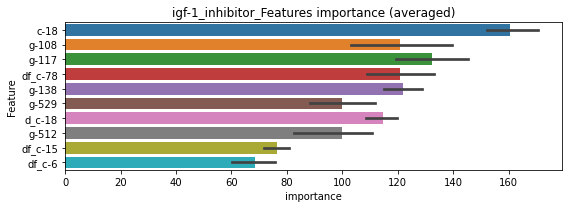

len(train_index) : 3893
len(valid_index) : 3893
================================= fold 1/2 igf-1_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0187871	valid_1's binary_logloss: 0.0363592
[200]	training's binary_logloss: 0.00275002	valid_1's binary_logloss: 0.0145607
[300]	training's binary_logloss: 0.000765353	valid_1's binary_logloss: 0.0108595
Early stopping, best iteration is:
[332]	training's binary_logloss: 0.000580634	valid_1's binary_logloss: 0.0106834


len(train_index) : 3893
len(valid_index) : 3893
================================= fold 2/2 igf-1_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0182623	valid_1's binary_logloss: 0.0335615
[200]	training's binary_logloss: 0.00261689	valid_1's binary_logloss: 0.0141859
[300]	training's binary_logloss: 0.000757384	valid_1's binary_logloss: 0.0110331
[400]	training's binary_logloss: 0.000379724	valid_1's binary_logloss: 0.0103024
Early stopping, best iteration is:
[441]	training's binary_logloss: 0.000316006	valid_1's binary_logloss: 0.0100017


igf-1_inhibitor logloss: 0.010342530007911778
ikk_inhibitor, len(trt): 30, len(othr): 3284, target_rate: 0.0012598 → Adj_target_rate: 0.0015127


neg labels: 3289 → selected neg labels: 3284


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0275747	valid_1's binary_logloss: 0.0479747
[200]	training's binary_logloss: 0.0035684	valid_1's binary_logloss: 0.0168419
[300]	training's binary_logloss: 0.00101905	valid_1's binary_logloss: 0.0112833
[400]	training's binary_logloss: 0.000528622	valid_1's binary_logloss: 0.00981433
[500]	training's binary_logloss: 0.000396287	valid_1's binary_logloss: 0.00908585
Early stopping, best iteration is:
[493]	training's binary_logloss: 0.000399791	valid_1's binary_logloss: 0.0090638
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0279333	valid_1's binary_logloss: 0.0389233
[200]	training's binary_logloss: 0.0037315	valid_1's binary_logloss: 0.0083505
[300]	training's binary_logloss: 0.00105877	valid_1's binary_logloss: 0.00408232
[400]	training's binary_logloss: 0.000551217	valid_1's binary_logloss: 0.00308409
Early stopping, best iteration is:
[455

1 / 3 AUC score:1.000
Threshold: 0.0025772, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → positive_corect_labels: 656/3808
p_label_rate: 0.0738322 Vs.target_rate: 0.00126, Num_p_label: 294.0, conf_0:0.00025, conf_1:0.00283
Num_p_label: 294.0, Expected: 5.0, Adj_threshold_1: 0.0025772
Num_p_label: 171.0, Expected: 5.0, Adj_threshold_2: 0.0075772
Num_p_label: 165.0, Expected: 5.0, Adj_threshold_3: 0.0125772
Num_p_label: 156.0, Expected: 5.0, Adj_threshold_4: 0.0175772
Num_p_label: 150.0, Expected: 5.0, Adj_threshold_5: 0.0225772
Num_p_label: 145.0, Expected: 5.0, Adj_threshold_6: 0.0275772
Num_p_label: 139.0, Expected: 5.0, Adj_threshold_7: 0.0325772
Num_p_label: 133.0, Expected: 5.0, Adj_threshold_8: 0.0375772
Num_p_label: 129.0, Expected: 5.0, Adj_threshold_9: 0.0425772
Num_p_label: 125.0, Expected: 5.0, Adj_threshold_10: 0.0475772
threshold: 0.0525772, positive p_label: 117.0/3982, p_label_rate: 0.0293822
positive y_label: 656.0/3808, y_label_rate: 0.1722689
================= Ps

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0257245	valid_1's binary_logloss: 0.0454031
[200]	training's binary_logloss: 0.00321634	valid_1's binary_logloss: 0.0164136
[300]	training's binary_logloss: 0.000905337	valid_1's binary_logloss: 0.0112067
Early stopping, best iteration is:
[375]	training's binary_logloss: 0.000546625	valid_1's binary_logloss: 0.00999409
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0266359	valid_1's binary_logloss: 0.0362743
[200]	training's binary_logloss: 0.00339049	valid_1's binary_logloss: 0.00684616
[300]	training's binary_logloss: 0.000969458	valid_1's binary_logloss: 0.00274186
[400]	training's binary_logloss: 0.000507635	valid_1's binary_logloss: 0.00181374
[500]	training's binary_logloss: 0.000385409	valid_1's binary_logloss: 0.00153959
Early stopping, best iteration is:
[505]	training's binary_logloss: 0.000384321	valid_1's binary_logloss: 0.0015386

2 / 3 AUC score:1.000
Threshold: 0.0525772, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 7 → positive_corect_labels: 655.0/3801
p_label_rate: 0.0376695 Vs.target_rate: 0.00126, Num_p_label: 150.0, conf_0:0.00033, conf_1:0.05783
Num_p_label: 150.0, Expected: 5.0, Adj_threshold_1: 0.0525772
Num_p_label: 148.0, Expected: 5.0, Adj_threshold_2: 0.0575772
Num_p_label: 146.0, Expected: 5.0, Adj_threshold_3: 0.0625772
Num_p_label: 146.0, Expected: 5.0, Adj_threshold_4: 0.0675772
Num_p_label: 146.0, Expected: 5.0, Adj_threshold_5: 0.0725772
Num_p_label: 144.0, Expected: 5.0, Adj_threshold_6: 0.0775772
Num_p_label: 142.0, Expected: 5.0, Adj_threshold_7: 0.0825772
Num_p_label: 142.0, Expected: 5.0, Adj_threshold_8: 0.0875772
Num_p_label: 141.0, Expected: 5.0, Adj_threshold_9: 0.0925772
Num_p_label: 139.0, Expected: 5.0, Adj_threshold_10: 0.0975772
threshold: 0.1025772, positive p_label: 138.0/3982, p_label_rate: 0.0346560
positive y_label: 655.0/3801, y_label_rate: 0.1723231
================= Ps

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0258676	valid_1's binary_logloss: 0.0371384
[200]	training's binary_logloss: 0.0033439	valid_1's binary_logloss: 0.00937863
[300]	training's binary_logloss: 0.000945531	valid_1's binary_logloss: 0.0051728
[400]	training's binary_logloss: 0.000496441	valid_1's binary_logloss: 0.0040469
Early stopping, best iteration is:
[421]	training's binary_logloss: 0.000454345	valid_1's binary_logloss: 0.00391772
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0260465	valid_1's binary_logloss: 0.0369819
[200]	training's binary_logloss: 0.00331783	valid_1's binary_logloss: 0.00692147
[300]	training's binary_logloss: 0.000938666	valid_1's binary_logloss: 0.00257218
[400]	training's binary_logloss: 0.000496893	valid_1's binary_logloss: 0.00159235
[500]	training's binary_logloss: 0.000382217	valid_1's binary_logloss: 0.0013368
Early stopping, best iteration is:


3 / 3 AUC score:1.000
Threshold: 0.1025772, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 1 → positive_corect_labels: 655.0/3800
p_label_rate: 0.0336514 Vs.target_rate: 0.00126, Num_p_label: 134.0, conf_0:0.00030, conf_1:0.11283
Num_p_label: 134.0, Expected: 5.0, Adj_threshold_1: 0.1025772
Num_p_label: 134.0, Expected: 5.0, Adj_threshold_2: 0.1075772
Num_p_label: 132.0, Expected: 5.0, Adj_threshold_3: 0.1125772
Num_p_label: 131.0, Expected: 5.0, Adj_threshold_4: 0.1175772
Num_p_label: 131.0, Expected: 5.0, Adj_threshold_5: 0.1225772
Num_p_label: 131.0, Expected: 5.0, Adj_threshold_6: 0.1275772
Num_p_label: 129.0, Expected: 5.0, Adj_threshold_7: 0.1325772
Num_p_label: 127.0, Expected: 5.0, Adj_threshold_8: 0.1375772
Num_p_label: 127.0, Expected: 5.0, Adj_threshold_9: 0.1425772
Num_p_label: 127.0, Expected: 5.0, Adj_threshold_10: 0.1475772
threshold: 0.1525772, positive p_label: 127.0/3982, p_label_rate: 0.0318935
positive y_label: 782.0/7782, y_label_rate: 0.1004883


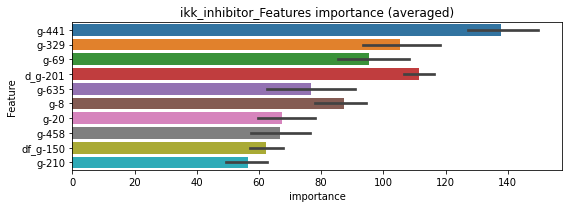

len(train_index) : 3891
len(valid_index) : 3891
================================= fold 1/2 ikk_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0167852	valid_1's binary_logloss: 0.0279839
[200]	training's binary_logloss: 0.00223733	valid_1's binary_logloss: 0.00989666
[300]	training's binary_logloss: 0.000612837	valid_1's binary_logloss: 0.00689613
Early stopping, best iteration is:
[335]	training's binary_logloss: 0.000457965	valid_1's binary_logloss: 0.00660537


len(train_index) : 3891
len(valid_index) : 3891
================================= fold 2/2 ikk_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0167318	valid_1's binary_logloss: 0.0258081
[200]	training's binary_logloss: 0.00224818	valid_1's binary_logloss: 0.00753931
[300]	training's binary_logloss: 0.000624733	valid_1's binary_logloss: 0.00488119
[400]	training's binary_logloss: 0.000314435	valid_1's binary_logloss: 0.00424569
Early stopping, best iteration is:
[390]	training's binary_logloss: 0.000329987	valid_1's binary_logloss: 0.00423529


ikk_inhibitor logloss: 0.005420330436568075


neg labels: 3289 → selected neg labels: 3284


imidazoline_receptor_agonist, len(trt): 31, len(othr): 3284, target_rate: 0.0013018 → Adj_target_rate: 0.0015554
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0356034	valid_1's binary_logloss: 0.052798
[200]	training's binary_logloss: 0.00529368	valid_1's binary_logloss: 0.0132913
[300]	training's binary_logloss: 0.0014819	valid_1's binary_logloss: 0.00555604
[400]	training's binary_logloss: 0.000717093	valid_1's binary_logloss: 0.00348253
[500]	training's binary_logloss: 0.000476114	valid_1's binary_logloss: 0.00274599
Early stopping, best iteration is:
[569]	training's binary_logloss: 0.000439786	valid_1's binary_logloss: 0.00264987
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0348181	valid_1's binary_logloss: 0.0551732
[200]	training's binary_logloss: 0.00515163	valid_1's binary_logloss: 0.0165635
[300]	training's binary_logloss: 0.00146359	valid_1's binary_logloss: 0.0100413
[400]	training's binary_logloss: 0.000717426	valid_1's binary_logloss: 0.00860849
Early stopping, best iteration is:
[40

1 / 3 AUC score:1.000
Threshold: 0.0034316, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → positive_corect_labels: 656/3808
p_label_rate: 0.0494726 Vs.target_rate: 0.00130, Num_p_label: 197.0, conf_0:0.00054, conf_1:0.00377
Num_p_label: 197.0, Expected: 5.2, Adj_threshold_1: 0.0034316
Num_p_label: 54.0, Expected: 5.2, Adj_threshold_2: 0.0084316
Num_p_label: 28.0, Expected: 5.2, Adj_threshold_3: 0.0134316
Num_p_label: 11.0, Expected: 5.2, Adj_threshold_4: 0.0184316
Num_p_label: 6.0, Expected: 5.2, Adj_threshold_5: 0.0234316
threshold: 0.0234316, positive p_label: 6.0/3982, p_label_rate: 0.0015068
positive y_label: 656.0/3808, y_label_rate: 0.1722689
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0352876	valid_1's binary_logloss: 0.0529976
[200]	training's binary_logloss: 0.00516211	valid_1's binary_logloss: 0.0127591
[300]	training's binary_logloss: 0.00145091	valid_1's binary_logloss: 0.00528759
[400]	training's binary_logloss: 0.0007145	valid_1's binary_logloss: 0.00335227
[500]	training's binary_logloss: 0.00048223	valid_1's binary_logloss: 0.00264686
Early stopping, best iteration is:
[589]	training's binary_logloss: 0.000432987	valid_1's binary_logloss: 0.0024951
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0336221	valid_1's binary_logloss: 0.0536488
[200]	training's binary_logloss: 0.00493773	valid_1's binary_logloss: 0.0170538
[300]	training's binary_logloss: 0.00140544	valid_1's binary_logloss: 0.0110328
Early stopping, best iteration is:
[311]	training's binary_logloss: 0.00127164	valid_1's binary_logloss: 0.0108783


2 / 3 AUC score:1.000
Threshold: 0.0234316, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 3 → positive_corect_labels: 655.0/3805
p_label_rate: 0.0107986 Vs.target_rate: 0.00130, Num_p_label: 43.0, conf_0:0.00092, conf_1:0.02577
Num_p_label: 43.0, Expected: 5.2, Adj_threshold_1: 0.0234316
Num_p_label: 30.0, Expected: 5.2, Adj_threshold_2: 0.0284316
Num_p_label: 19.0, Expected: 5.2, Adj_threshold_3: 0.0334316
Num_p_label: 13.0, Expected: 5.2, Adj_threshold_4: 0.0384316
Num_p_label: 10.0, Expected: 5.2, Adj_threshold_5: 0.0434316
threshold: 0.0434316, positive p_label: 10.0/3982, p_label_rate: 0.0025113
positive y_label: 655.0/3805, y_label_rate: 0.1721419
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0344938	valid_1's binary_logloss: 0.0547639
[200]	training's binary_logloss: 0.00508352	valid_1's binary_logloss: 0.0146444
[300]	training's binary_logloss: 0.00143296	valid_1's binary_logloss: 0.00707975
[400]	training's binary_logloss: 0.000702794	valid_1's binary_logloss: 0.00507015
[500]	training's binary_logloss: 0.000475969	valid_1's binary_logloss: 0.00440049
Early stopping, best iteration is:
[491]	training's binary_logloss: 0.000485016	valid_1's binary_logloss: 0.0043818
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0345684	valid_1's binary_logloss: 0.0473806
[200]	training's binary_logloss: 0.00512804	valid_1's binary_logloss: 0.00995032
[300]	training's binary_logloss: 0.00146535	valid_1's binary_logloss: 0.00383831
[400]	training's binary_logloss: 0.000723799	valid_1's binary_logloss: 0.00230583
[500]	training's binary_logloss: 0.

3 / 3 AUC score:1.000
Threshold: 0.0434316, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → positive_corect_labels: 655.0/3805
p_label_rate: 0.0012557 Vs.target_rate: 0.00130, Num_p_label: 5.0, conf_0:0.00050, conf_1:0.04777
threshold: 0.0434316, positive p_label: 5.0/3982, p_label_rate: 0.0012557
positive y_label: 660.0/7787, y_label_rate: 0.0847566


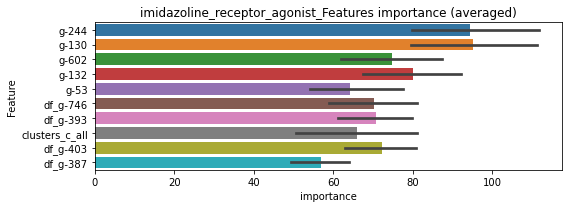

len(train_index) : 3893
len(valid_index) : 3894
================================= fold 1/2 imidazoline_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0189985	valid_1's binary_logloss: 0.0312828
[200]	training's binary_logloss: 0.00271315	valid_1's binary_logloss: 0.0113969
[300]	training's binary_logloss: 0.000749848	valid_1's binary_logloss: 0.00795476
Early stopping, best iteration is:
[345]	training's binary_logloss: 0.000515836	valid_1's binary_logloss: 0.00747704


len(train_index) : 3894
len(valid_index) : 3893
================================= fold 2/2 imidazoline_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0203253	valid_1's binary_logloss: 0.0280221
[200]	training's binary_logloss: 0.00299734	valid_1's binary_logloss: 0.00689751
[300]	training's binary_logloss: 0.000812688	valid_1's binary_logloss: 0.00348153
[400]	training's binary_logloss: 0.000385964	valid_1's binary_logloss: 0.00260212
[500]	training's binary_logloss: 0.000257525	valid_1's binary_logloss: 0.00230303
Early stopping, best iteration is:
[544]	training's binary_logloss: 0.000235533	valid_1's binary_logloss: 0.00225644


imidazoline_receptor_agonist logloss: 0.0048670780250847255
immunosuppressant, len(trt): 73, len(othr): 3278, target_rate: 0.0030654 → Adj_target_rate: 0.0032212


neg labels: 3289 → selected neg labels: 3278


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0455819	valid_1's binary_logloss: 0.0946089
[200]	training's binary_logloss: 0.00882213	valid_1's binary_logloss: 0.0457037
[300]	training's binary_logloss: 0.00270686	valid_1's binary_logloss: 0.032278
[400]	training's binary_logloss: 0.00129302	valid_1's binary_logloss: 0.0276325
Early stopping, best iteration is:
[485]	training's binary_logloss: 0.000866468	valid_1's binary_logloss: 0.0257605
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0464232	valid_1's binary_logloss: 0.0886154
[200]	training's binary_logloss: 0.00958782	valid_1's binary_logloss: 0.0372555
[300]	training's binary_logloss: 0.00294651	valid_1's binary_logloss: 0.0229013
[400]	training's binary_logloss: 0.00138914	valid_1's binary_logloss: 0.0179027
[500]	training's binary_logloss: 0.000871011	valid_1's binary_logloss: 0.0158751
Early stopping, best iteration is:
[560]	tra

1 / 3 AUC score:1.000
Threshold: 0.0088240, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 134 → positive_corect_labels: 654/3799
p_label_rate: 0.0454545 Vs.target_rate: 0.00307, Num_p_label: 181.0, conf_0:0.00089, conf_1:0.00971
Num_p_label: 181.0, Expected: 12.2, Adj_threshold_1: 0.0088240
Num_p_label: 110.0, Expected: 12.2, Adj_threshold_2: 0.0138240
Num_p_label: 78.0, Expected: 12.2, Adj_threshold_3: 0.0188240
Num_p_label: 64.0, Expected: 12.2, Adj_threshold_4: 0.0238240
Num_p_label: 59.0, Expected: 12.2, Adj_threshold_5: 0.0288240
Num_p_label: 55.0, Expected: 12.2, Adj_threshold_6: 0.0338240
Num_p_label: 50.0, Expected: 12.2, Adj_threshold_7: 0.0388240
Num_p_label: 41.0, Expected: 12.2, Adj_threshold_8: 0.0438240
Num_p_label: 37.0, Expected: 12.2, Adj_threshold_9: 0.0488240
Num_p_label: 36.0, Expected: 12.2, Adj_threshold_10: 0.0538240
threshold: 0.0588240, positive p_label: 36.0/3982, p_label_rate: 0.0090407
positive y_label: 654.0/3799, y_label_rate: 0.1721506
================= P

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0424352	valid_1's binary_logloss: 0.0951307
[200]	training's binary_logloss: 0.00778203	valid_1's binary_logloss: 0.0498921
[300]	training's binary_logloss: 0.00234965	valid_1's binary_logloss: 0.0393026
[400]	training's binary_logloss: 0.00115187	valid_1's binary_logloss: 0.0362574
Early stopping, best iteration is:
[423]	training's binary_logloss: 0.00102163	valid_1's binary_logloss: 0.0359849
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0421232	valid_1's binary_logloss: 0.0947195
[200]	training's binary_logloss: 0.00797684	valid_1's binary_logloss: 0.04966
[300]	training's binary_logloss: 0.00241391	valid_1's binary_logloss: 0.0401762
Early stopping, best iteration is:
[382]	training's binary_logloss: 0.00130404	valid_1's binary_logloss: 0.0367872


2 / 3 AUC score:0.998
Threshold: 0.0588240, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 18 → positive_corect_labels: 642.0/3781
p_label_rate: 0.0208438 Vs.target_rate: 0.00307, Num_p_label: 83.0, conf_0:0.00145, conf_1:0.06471
Num_p_label: 83.0, Expected: 12.2, Adj_threshold_1: 0.0588240
Num_p_label: 75.0, Expected: 12.2, Adj_threshold_2: 0.0638240
Num_p_label: 73.0, Expected: 12.2, Adj_threshold_3: 0.0688240
Num_p_label: 70.0, Expected: 12.2, Adj_threshold_4: 0.0738240
Num_p_label: 70.0, Expected: 12.2, Adj_threshold_5: 0.0788240
Num_p_label: 68.0, Expected: 12.2, Adj_threshold_6: 0.0838240
Num_p_label: 65.0, Expected: 12.2, Adj_threshold_7: 0.0888240
Num_p_label: 64.0, Expected: 12.2, Adj_threshold_8: 0.0938240
Num_p_label: 62.0, Expected: 12.2, Adj_threshold_9: 0.0988240
Num_p_label: 62.0, Expected: 12.2, Adj_threshold_10: 0.1038240
threshold: 0.1088240, positive p_label: 62.0/3982, p_label_rate: 0.0155701
positive y_label: 642.0/3781, y_label_rate: 0.1697964
================= Pse

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0387648	valid_1's binary_logloss: 0.0960318
[200]	training's binary_logloss: 0.00700587	valid_1's binary_logloss: 0.0560158
[300]	training's binary_logloss: 0.00211225	valid_1's binary_logloss: 0.0473774
Early stopping, best iteration is:
[320]	training's binary_logloss: 0.00177619	valid_1's binary_logloss: 0.046256
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0409069	valid_1's binary_logloss: 0.0807304
[200]	training's binary_logloss: 0.0074715	valid_1's binary_logloss: 0.0363804
[300]	training's binary_logloss: 0.00229448	valid_1's binary_logloss: 0.0270714
[400]	training's binary_logloss: 0.00112752	valid_1's binary_logloss: 0.0244893
Early stopping, best iteration is:
[401]	training's binary_logloss: 0.00112118	valid_1's binary_logloss: 0.0244612


3 / 3 AUC score:0.998
Threshold: 0.1088240, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 21 → positive_corect_labels: 623.0/3760
p_label_rate: 0.0163235 Vs.target_rate: 0.00307, Num_p_label: 65.0, conf_0:0.00169, conf_1:0.11971
Num_p_label: 65.0, Expected: 12.2, Adj_threshold_1: 0.1088240
Num_p_label: 63.0, Expected: 12.2, Adj_threshold_2: 0.1138240
Num_p_label: 62.0, Expected: 12.2, Adj_threshold_3: 0.1188240
Num_p_label: 62.0, Expected: 12.2, Adj_threshold_4: 0.1238240
Num_p_label: 61.0, Expected: 12.2, Adj_threshold_5: 0.1288240
Num_p_label: 60.0, Expected: 12.2, Adj_threshold_6: 0.1338240
Num_p_label: 58.0, Expected: 12.2, Adj_threshold_7: 0.1388240
Num_p_label: 56.0, Expected: 12.2, Adj_threshold_8: 0.1438240
Num_p_label: 52.0, Expected: 12.2, Adj_threshold_9: 0.1488240
Num_p_label: 52.0, Expected: 12.2, Adj_threshold_10: 0.1538240
threshold: 0.1588240, positive p_label: 52.0/3982, p_label_rate: 0.0130588
positive y_label: 675.0/7742, y_label_rate: 0.0871868


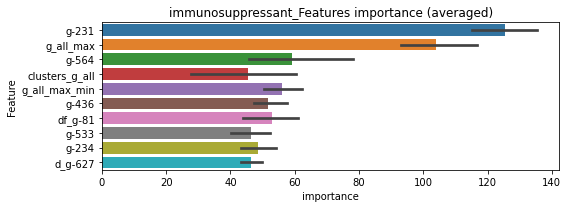

len(train_index) : 3871
len(valid_index) : 3871
================================= fold 1/2 immunosuppressant=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0208971	valid_1's binary_logloss: 0.0509932
[200]	training's binary_logloss: 0.00366752	valid_1's binary_logloss: 0.0304305
[300]	training's binary_logloss: 0.00115721	valid_1's binary_logloss: 0.0269374
Early stopping, best iteration is:
[360]	training's binary_logloss: 0.00072238	valid_1's binary_logloss: 0.0259886


len(train_index) : 3871
len(valid_index) : 3871
================================= fold 2/2 immunosuppressant=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0209249	valid_1's binary_logloss: 0.0532636
[200]	training's binary_logloss: 0.00362666	valid_1's binary_logloss: 0.0341809
[300]	training's binary_logloss: 0.00113602	valid_1's binary_logloss: 0.030357
Early stopping, best iteration is:
[325]	training's binary_logloss: 0.000914006	valid_1's binary_logloss: 0.0296437


immunosuppressant logloss: 0.02781614522967335


  acetylcholine_receptor_agonist acetylcholine_receptor_antagonist  \
0                       df_g-122                              c-30   
1                  clusters_df_c                         c_all_max   
2                          cnt_0                    clusters_g_all   
3                      c_all_min                          df_g-707   
4                        df_g-51                        clusters_g   
5                       df_c_min                          df_c_min   
6                          cnt_2                             g-514   
7                       df_g-736                          df_g-640   
8                          g-244                            df_c-6   
9                           c-73                          df_g-597   

  acetylcholinesterase_inhibitor adenosine_receptor_antagonist  \
0                      c_all_max                clusters_c_all   
1                      c_all_min                      df_c_min   
2                 clusters_g_al

insulin_secretagogue, len(trt): 30, len(othr): 3284, target_rate: 0.0012598 → Adj_target_rate: 0.0015127


neg labels: 3289 → selected neg labels: 3284


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0358848	valid_1's binary_logloss: 0.0562664
[200]	training's binary_logloss: 0.00533406	valid_1's binary_logloss: 0.0138105
[300]	training's binary_logloss: 0.0014588	valid_1's binary_logloss: 0.0059328
[400]	training's binary_logloss: 0.000716703	valid_1's binary_logloss: 0.0039889
[500]	training's binary_logloss: 0.000484687	valid_1's binary_logloss: 0.00312861
Early stopping, best iteration is:
[560]	training's binary_logloss: 0.000445655	valid_1's binary_logloss: 0.00297572
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0347925	valid_1's binary_logloss: 0.0654724
[200]	training's binary_logloss: 0.00505134	valid_1's binary_logloss: 0.0303092
[300]	training's binary_logloss: 0.0014016	valid_1's binary_logloss: 0.0235762
Early stopping, best iteration is:
[315]	training's binary_logloss: 0.00122815	valid_1's binary_logloss: 0.0230863


1 / 3 AUC score:1.000
Threshold: 0.0052923, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → positive_corect_labels: 656/3808
p_label_rate: 0.0374184 Vs.target_rate: 0.00126, Num_p_label: 149.0, conf_0:0.00071, conf_1:0.00582
Num_p_label: 149.0, Expected: 5.0, Adj_threshold_1: 0.0052923
Num_p_label: 55.0, Expected: 5.0, Adj_threshold_2: 0.0102923
Num_p_label: 32.0, Expected: 5.0, Adj_threshold_3: 0.0152923
Num_p_label: 18.0, Expected: 5.0, Adj_threshold_4: 0.0202923
Num_p_label: 11.0, Expected: 5.0, Adj_threshold_5: 0.0252923
Num_p_label: 10.0, Expected: 5.0, Adj_threshold_6: 0.0302923
threshold: 0.0302923, positive p_label: 10.0/3982, p_label_rate: 0.0025113
positive y_label: 656.0/3808, y_label_rate: 0.1722689
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0344753	valid_1's binary_logloss: 0.0538606
[200]	training's binary_logloss: 0.00510722	valid_1's binary_logloss: 0.0129261
[300]	training's binary_logloss: 0.00142244	valid_1's binary_logloss: 0.00524442
[400]	training's binary_logloss: 0.000699881	valid_1's binary_logloss: 0.00338441
[500]	training's binary_logloss: 0.000479858	valid_1's binary_logloss: 0.00276524
Early stopping, best iteration is:
[512]	training's binary_logloss: 0.000467932	valid_1's binary_logloss: 0.00272552
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0336182	valid_1's binary_logloss: 0.0629825
[200]	training's binary_logloss: 0.00483591	valid_1's binary_logloss: 0.0277838
[300]	training's binary_logloss: 0.0013738	valid_1's binary_logloss: 0.021267
Early stopping, best iteration is:
[305]	training's binary_logloss: 0.00131507	valid_1's binary_logloss: 0.0210783


2 / 3 AUC score:1.000
Threshold: 0.0302923, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 6 → positive_corect_labels: 652.0/3802
p_label_rate: 0.0065294 Vs.target_rate: 0.00126, Num_p_label: 26.0, conf_0:0.00083, conf_1:0.03332
Num_p_label: 26.0, Expected: 5.0, Adj_threshold_1: 0.0302923
Num_p_label: 17.0, Expected: 5.0, Adj_threshold_2: 0.0352923
Num_p_label: 15.0, Expected: 5.0, Adj_threshold_3: 0.0402923
Num_p_label: 10.0, Expected: 5.0, Adj_threshold_4: 0.0452923
threshold: 0.0452923, positive p_label: 10.0/3982, p_label_rate: 0.0025113
positive y_label: 652.0/3802, y_label_rate: 0.1714887
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0336935	valid_1's binary_logloss: 0.0495462
[200]	training's binary_logloss: 0.00480264	valid_1's binary_logloss: 0.0117504
[300]	training's binary_logloss: 0.00135274	valid_1's binary_logloss: 0.00552101
[400]	training's binary_logloss: 0.000682861	valid_1's binary_logloss: 0.00388823
[500]	training's binary_logloss: 0.000477805	valid_1's binary_logloss: 0.00330047
Early stopping, best iteration is:
[580]	training's binary_logloss: 0.000448092	valid_1's binary_logloss: 0.00321899
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0338986	valid_1's binary_logloss: 0.0500097
[200]	training's binary_logloss: 0.00494333	valid_1's binary_logloss: 0.0130369
[300]	training's binary_logloss: 0.00139864	valid_1's binary_logloss: 0.00609374
[400]	training's binary_logloss: 0.000692819	valid_1's binary_logloss: 0.00438248
[500]	training's binary_logloss: 0.

3 / 3 AUC score:1.000
Threshold: 0.0452923, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → positive_corect_labels: 652.0/3802
p_label_rate: 0.0025113 Vs.target_rate: 0.00126, Num_p_label: 10.0, conf_0:0.00045, conf_1:0.04982
threshold: 0.0452923, positive p_label: 10.0/3982, p_label_rate: 0.0025113
positive y_label: 662.0/7784, y_label_rate: 0.0850462


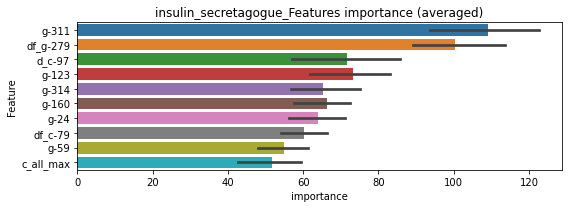

len(train_index) : 3892
len(valid_index) : 3892
================================= fold 1/2 insulin_secretagogue=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0194612	valid_1's binary_logloss: 0.0320912
[200]	training's binary_logloss: 0.00274672	valid_1's binary_logloss: 0.0112374
[300]	training's binary_logloss: 0.000740287	valid_1's binary_logloss: 0.00807173
Early stopping, best iteration is:
[386]	training's binary_logloss: 0.000392901	valid_1's binary_logloss: 0.00746147


len(train_index) : 3892
len(valid_index) : 3892
================================= fold 2/2 insulin_secretagogue=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0177665	valid_1's binary_logloss: 0.0310277
[200]	training's binary_logloss: 0.00258934	valid_1's binary_logloss: 0.0115613
[300]	training's binary_logloss: 0.000750732	valid_1's binary_logloss: 0.00822907
Early stopping, best iteration is:
[381]	training's binary_logloss: 0.000413974	valid_1's binary_logloss: 0.00731909


insulin_secretagogue logloss: 0.00739028005954202
insulin_sensitizer, len(trt): 51, len(othr): 3281, target_rate: 0.0021416 → Adj_target_rate: 0.0023748


neg labels: 3289 → selected neg labels: 3281


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.034576	valid_1's binary_logloss: 0.0669653
[200]	training's binary_logloss: 0.00548319	valid_1's binary_logloss: 0.0288015
[300]	training's binary_logloss: 0.00166741	valid_1's binary_logloss: 0.0205757
[400]	training's binary_logloss: 0.000834118	valid_1's binary_logloss: 0.0183663
Early stopping, best iteration is:
[417]	training's binary_logloss: 0.000764083	valid_1's binary_logloss: 0.018278
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0367598	valid_1's binary_logloss: 0.0670331
[200]	training's binary_logloss: 0.00590783	valid_1's binary_logloss: 0.0262431
[300]	training's binary_logloss: 0.00174895	valid_1's binary_logloss: 0.0186941
Early stopping, best iteration is:
[368]	training's binary_logloss: 0.0010534	valid_1's binary_logloss: 0.0171362


1 / 3 AUC score:1.000
Threshold: 0.0069281, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 134 → positive_corect_labels: 655/3803
p_label_rate: 0.0482170 Vs.target_rate: 0.00214, Num_p_label: 192.0, conf_0:0.00086, conf_1:0.00762
Num_p_label: 192.0, Expected: 8.5, Adj_threshold_1: 0.0069281
Num_p_label: 85.0, Expected: 8.5, Adj_threshold_2: 0.0119281
Num_p_label: 55.0, Expected: 8.5, Adj_threshold_3: 0.0169281
Num_p_label: 39.0, Expected: 8.5, Adj_threshold_4: 0.0219281
Num_p_label: 28.0, Expected: 8.5, Adj_threshold_5: 0.0269281
Num_p_label: 24.0, Expected: 8.5, Adj_threshold_6: 0.0319281
Num_p_label: 17.0, Expected: 8.5, Adj_threshold_7: 0.0369281
threshold: 0.0369281, positive p_label: 17.0/3982, p_label_rate: 0.0042692
positive y_label: 655.0/3803, y_label_rate: 0.1722324
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0351096	valid_1's binary_logloss: 0.058827
[200]	training's binary_logloss: 0.00572001	valid_1's binary_logloss: 0.017003
[300]	training's binary_logloss: 0.00170584	valid_1's binary_logloss: 0.00884588
[400]	training's binary_logloss: 0.00084999	valid_1's binary_logloss: 0.0067977
[500]	training's binary_logloss: 0.00056987	valid_1's binary_logloss: 0.00596878
Early stopping, best iteration is:
[540]	training's binary_logloss: 0.000520907	valid_1's binary_logloss: 0.00580913
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0345445	valid_1's binary_logloss: 0.067614
[200]	training's binary_logloss: 0.00546993	valid_1's binary_logloss: 0.0253066
[300]	training's binary_logloss: 0.00162462	valid_1's binary_logloss: 0.0160135
[400]	training's binary_logloss: 0.000825486	valid_1's binary_logloss: 0.0136158
[500]	training's binary_logloss: 0.00055460

2 / 3 AUC score:1.000
Threshold: 0.0369281, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 2 → positive_corect_labels: 653.0/3801
p_label_rate: 0.0100452 Vs.target_rate: 0.00214, Num_p_label: 40.0, conf_0:0.00059, conf_1:0.04062
Num_p_label: 40.0, Expected: 8.5, Adj_threshold_1: 0.0369281
Num_p_label: 34.0, Expected: 8.5, Adj_threshold_2: 0.0419281
Num_p_label: 29.0, Expected: 8.5, Adj_threshold_3: 0.0469281
Num_p_label: 25.0, Expected: 8.5, Adj_threshold_4: 0.0519281
Num_p_label: 25.0, Expected: 8.5, Adj_threshold_5: 0.0569281
Num_p_label: 24.0, Expected: 8.5, Adj_threshold_6: 0.0619281
Num_p_label: 23.0, Expected: 8.5, Adj_threshold_7: 0.0669281
Num_p_label: 21.0, Expected: 8.5, Adj_threshold_8: 0.0719281
Num_p_label: 21.0, Expected: 8.5, Adj_threshold_9: 0.0769281
Num_p_label: 21.0, Expected: 8.5, Adj_threshold_10: 0.0819281
threshold: 0.0869281, positive p_label: 21.0/3982, p_label_rate: 0.0052737
positive y_label: 653.0/3801, y_label_rate: 0.1717969
================= Pseudo labelin

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0343718	valid_1's binary_logloss: 0.0587879
[200]	training's binary_logloss: 0.00536376	valid_1's binary_logloss: 0.0189437
[300]	training's binary_logloss: 0.001612	valid_1's binary_logloss: 0.0109835
[400]	training's binary_logloss: 0.000804505	valid_1's binary_logloss: 0.00879486
Early stopping, best iteration is:
[480]	training's binary_logloss: 0.000577227	valid_1's binary_logloss: 0.0080617
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0359073	valid_1's binary_logloss: 0.065401
[200]	training's binary_logloss: 0.00551941	valid_1's binary_logloss: 0.0274925
[300]	training's binary_logloss: 0.00164527	valid_1's binary_logloss: 0.0200529
[400]	training's binary_logloss: 0.000826967	valid_1's binary_logloss: 0.0179048
Early stopping, best iteration is:
[437]	training's binary_logloss: 0.000693395	valid_1's binary_logloss: 0.0171488


3 / 3 AUC score:1.000
Threshold: 0.0869281, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 4 → positive_corect_labels: 649.0/3797
p_label_rate: 0.0047715 Vs.target_rate: 0.00214, Num_p_label: 19.0, conf_0:0.00068, conf_1:0.09562
threshold: 0.0869281, positive p_label: 19.0/3982, p_label_rate: 0.0047715
positive y_label: 668.0/7779, y_label_rate: 0.0858722


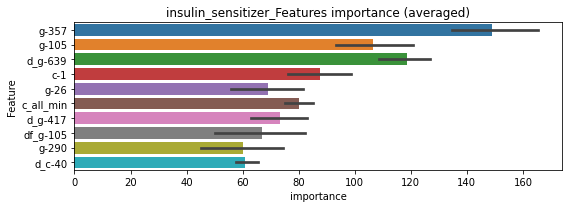

len(train_index) : 3889
len(valid_index) : 3890
================================= fold 1/2 insulin_sensitizer=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0182764	valid_1's binary_logloss: 0.0393382
[200]	training's binary_logloss: 0.00278518	valid_1's binary_logloss: 0.0195996
Early stopping, best iteration is:
[276]	training's binary_logloss: 0.00107433	valid_1's binary_logloss: 0.0159151


len(train_index) : 3890
len(valid_index) : 3889
================================= fold 2/2 insulin_sensitizer=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0196488	valid_1's binary_logloss: 0.0365466
[200]	training's binary_logloss: 0.00299806	valid_1's binary_logloss: 0.0152481
[300]	training's binary_logloss: 0.000884316	valid_1's binary_logloss: 0.0113683
[400]	training's binary_logloss: 0.000445221	valid_1's binary_logloss: 0.0102741
Early stopping, best iteration is:
[430]	training's binary_logloss: 0.000387857	valid_1's binary_logloss: 0.0100996


insulin_sensitizer logloss: 0.013007723175278929
integrin_inhibitor, len(trt): 42, len(othr): 3282, target_rate: 0.0017637 → Adj_target_rate: 0.0020135


neg labels: 3289 → selected neg labels: 3282


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0386124	valid_1's binary_logloss: 0.0707396
[200]	training's binary_logloss: 0.00687384	valid_1's binary_logloss: 0.0290523
[300]	training's binary_logloss: 0.00194447	valid_1's binary_logloss: 0.0183367
[400]	training's binary_logloss: 0.000929242	valid_1's binary_logloss: 0.0150113
[500]	training's binary_logloss: 0.00060863	valid_1's binary_logloss: 0.0138964
Early stopping, best iteration is:
[490]	training's binary_logloss: 0.000624718	valid_1's binary_logloss: 0.0138654
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0407973	valid_1's binary_logloss: 0.0665373
[200]	training's binary_logloss: 0.00732501	valid_1's binary_logloss: 0.0248703
[300]	training's binary_logloss: 0.00211658	valid_1's binary_logloss: 0.013952
[400]	training's binary_logloss: 0.00101473	valid_1's binary_logloss: 0.0107621
Early stopping, best iteration is:
[426]	tra

1 / 3 AUC score:1.000
Threshold: 0.0048768, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → positive_corect_labels: 656/3806
p_label_rate: 0.0308890 Vs.target_rate: 0.00176, Num_p_label: 123.0, conf_0:0.00070, conf_1:0.00536
Num_p_label: 123.0, Expected: 7.0, Adj_threshold_1: 0.0048768
Num_p_label: 44.0, Expected: 7.0, Adj_threshold_2: 0.0098768
Num_p_label: 21.0, Expected: 7.0, Adj_threshold_3: 0.0148768
Num_p_label: 15.0, Expected: 7.0, Adj_threshold_4: 0.0198768
Num_p_label: 8.0, Expected: 7.0, Adj_threshold_5: 0.0248768
threshold: 0.0248768, positive p_label: 8.0/3982, p_label_rate: 0.0020090
positive y_label: 656.0/3806, y_label_rate: 0.1723594
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0397709	valid_1's binary_logloss: 0.0697411
[200]	training's binary_logloss: 0.00683705	valid_1's binary_logloss: 0.028789
[300]	training's binary_logloss: 0.00192422	valid_1's binary_logloss: 0.0186575
[400]	training's binary_logloss: 0.000920991	valid_1's binary_logloss: 0.0155458
[500]	training's binary_logloss: 0.000599999	valid_1's binary_logloss: 0.0144327
Early stopping, best iteration is:
[520]	training's binary_logloss: 0.000566608	valid_1's binary_logloss: 0.0140959
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0391617	valid_1's binary_logloss: 0.0663794
[200]	training's binary_logloss: 0.00690837	valid_1's binary_logloss: 0.0247981
[300]	training's binary_logloss: 0.00200526	valid_1's binary_logloss: 0.0153888
[400]	training's binary_logloss: 0.000971037	valid_1's binary_logloss: 0.012454
Early stopping, best iteration is:
[426]	tr

2 / 3 AUC score:1.000
Threshold: 0.0248768, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 2 → positive_corect_labels: 654.0/3804
p_label_rate: 0.0060271 Vs.target_rate: 0.00176, Num_p_label: 24.0, conf_0:0.00073, conf_1:0.02736
Num_p_label: 24.0, Expected: 7.0, Adj_threshold_1: 0.0248768
Num_p_label: 19.0, Expected: 7.0, Adj_threshold_2: 0.0298768
Num_p_label: 16.0, Expected: 7.0, Adj_threshold_3: 0.0348768
Num_p_label: 11.0, Expected: 7.0, Adj_threshold_4: 0.0398768
threshold: 0.0398768, positive p_label: 11.0/3982, p_label_rate: 0.0027624
positive y_label: 654.0/3804, y_label_rate: 0.1719243
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0380707	valid_1's binary_logloss: 0.0648023
[200]	training's binary_logloss: 0.00637051	valid_1's binary_logloss: 0.025932
[300]	training's binary_logloss: 0.00184128	valid_1's binary_logloss: 0.0174115
[400]	training's binary_logloss: 0.00090689	valid_1's binary_logloss: 0.0149152
Early stopping, best iteration is:
[479]	training's binary_logloss: 0.000641341	valid_1's binary_logloss: 0.0138608
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0392584	valid_1's binary_logloss: 0.0661928
[200]	training's binary_logloss: 0.00672267	valid_1's binary_logloss: 0.0217541
[300]	training's binary_logloss: 0.00198226	valid_1's binary_logloss: 0.0114724
[400]	training's binary_logloss: 0.000956233	valid_1's binary_logloss: 0.00791367
[500]	training's binary_logloss: 0.000623759	valid_1's binary_logloss: 0.00658132
Early stopping, best iteration is:
[495]	

3 / 3 AUC score:1.000
Threshold: 0.0398768, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 1 → positive_corect_labels: 653.0/3803
p_label_rate: 0.0030136 Vs.target_rate: 0.00176, Num_p_label: 12.0, conf_0:0.00064, conf_1:0.04386
threshold: 0.0398768, positive p_label: 12.0/3982, p_label_rate: 0.0030136
positive y_label: 665.0/7785, y_label_rate: 0.0854207


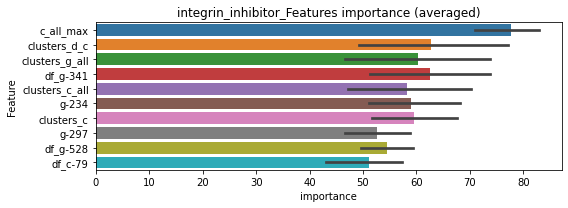

len(train_index) : 3892
len(valid_index) : 3893
================================= fold 1/2 integrin_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0214662	valid_1's binary_logloss: 0.0438476
[200]	training's binary_logloss: 0.00368421	valid_1's binary_logloss: 0.0217561
[300]	training's binary_logloss: 0.00103597	valid_1's binary_logloss: 0.0173182
Early stopping, best iteration is:
[350]	training's binary_logloss: 0.000686137	valid_1's binary_logloss: 0.0166067


len(train_index) : 3893
len(valid_index) : 3892
================================= fold 2/2 integrin_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0213202	valid_1's binary_logloss: 0.0379782
[200]	training's binary_logloss: 0.00359079	valid_1's binary_logloss: 0.0160274
[300]	training's binary_logloss: 0.00100775	valid_1's binary_logloss: 0.0116964
Early stopping, best iteration is:
[378]	training's binary_logloss: 0.000557418	valid_1's binary_logloss: 0.010953


integrin_inhibitor logloss: 0.013780212985129728
jak_inhibitor, len(trt): 92, len(othr): 3274, target_rate: 0.0038633 → Adj_target_rate: 0.0039212


neg labels: 3289 → selected neg labels: 3274


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0401693	valid_1's binary_logloss: 0.084209
[200]	training's binary_logloss: 0.00699672	valid_1's binary_logloss: 0.0431529
[300]	training's binary_logloss: 0.00216366	valid_1's binary_logloss: 0.0343516
[400]	training's binary_logloss: 0.00106644	valid_1's binary_logloss: 0.0318167
Early stopping, best iteration is:
[419]	training's binary_logloss: 0.000971148	valid_1's binary_logloss: 0.03122
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0407864	valid_1's binary_logloss: 0.0894537
[200]	training's binary_logloss: 0.00729601	valid_1's binary_logloss: 0.0454857
[300]	training's binary_logloss: 0.00220979	valid_1's binary_logloss: 0.0330059
Early stopping, best iteration is:
[375]	training's binary_logloss: 0.0012437	valid_1's binary_logloss: 0.0302716


1 / 3 AUC score:0.999
Threshold: 0.0155197, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 136 → positive_corect_labels: 652/3792
p_label_rate: 0.0509794 Vs.target_rate: 0.00386, Num_p_label: 203.0, conf_0:0.00075, conf_1:0.01707
Num_p_label: 203.0, Expected: 15.4, Adj_threshold_1: 0.0155197
Num_p_label: 156.0, Expected: 15.4, Adj_threshold_2: 0.0205197
Num_p_label: 133.0, Expected: 15.4, Adj_threshold_3: 0.0255197
Num_p_label: 112.0, Expected: 15.4, Adj_threshold_4: 0.0305197
Num_p_label: 92.0, Expected: 15.4, Adj_threshold_5: 0.0355197
Num_p_label: 80.0, Expected: 15.4, Adj_threshold_6: 0.0405197
Num_p_label: 71.0, Expected: 15.4, Adj_threshold_7: 0.0455197
Num_p_label: 64.0, Expected: 15.4, Adj_threshold_8: 0.0505197
Num_p_label: 58.0, Expected: 15.4, Adj_threshold_9: 0.0555197
Num_p_label: 52.0, Expected: 15.4, Adj_threshold_10: 0.0605197
threshold: 0.0655197, positive p_label: 47.0/3982, p_label_rate: 0.0118031
positive y_label: 652.0/3792, y_label_rate: 0.1719409
=================

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0388489	valid_1's binary_logloss: 0.0838883
[200]	training's binary_logloss: 0.0062345	valid_1's binary_logloss: 0.0377403
[300]	training's binary_logloss: 0.00187711	valid_1's binary_logloss: 0.0279281
[400]	training's binary_logloss: 0.000916429	valid_1's binary_logloss: 0.0249571
Early stopping, best iteration is:
[420]	training's binary_logloss: 0.000833518	valid_1's binary_logloss: 0.0247367
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0382469	valid_1's binary_logloss: 0.0809406
[200]	training's binary_logloss: 0.00646444	valid_1's binary_logloss: 0.0426234
[300]	training's binary_logloss: 0.00194868	valid_1's binary_logloss: 0.0334631
[400]	training's binary_logloss: 0.000960493	valid_1's binary_logloss: 0.030537
Early stopping, best iteration is:
[419]	training's binary_logloss: 0.000874007	valid_1's binary_logloss: 0.0299979


2 / 3 AUC score:0.999
Threshold: 0.0655197, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 27 → positive_corect_labels: 643.0/3765
p_label_rate: 0.0426921 Vs.target_rate: 0.00386, Num_p_label: 170.0, conf_0:0.00065, conf_1:0.07207
Num_p_label: 170.0, Expected: 15.4, Adj_threshold_1: 0.0655197
Num_p_label: 164.0, Expected: 15.4, Adj_threshold_2: 0.0705197
Num_p_label: 155.0, Expected: 15.4, Adj_threshold_3: 0.0755197
Num_p_label: 150.0, Expected: 15.4, Adj_threshold_4: 0.0805197
Num_p_label: 147.0, Expected: 15.4, Adj_threshold_5: 0.0855197
Num_p_label: 143.0, Expected: 15.4, Adj_threshold_6: 0.0905197
Num_p_label: 140.0, Expected: 15.4, Adj_threshold_7: 0.0955197
Num_p_label: 137.0, Expected: 15.4, Adj_threshold_8: 0.1005197
Num_p_label: 136.0, Expected: 15.4, Adj_threshold_9: 0.1055197
Num_p_label: 131.0, Expected: 15.4, Adj_threshold_10: 0.1105197
threshold: 0.1155197, positive p_label: 129.0/3982, p_label_rate: 0.0323958
positive y_label: 643.0/3765, y_label_rate: 0.1707835
=========

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0383244	valid_1's binary_logloss: 0.0841783
[200]	training's binary_logloss: 0.00620416	valid_1's binary_logloss: 0.0437593
[300]	training's binary_logloss: 0.00181243	valid_1's binary_logloss: 0.035641
Early stopping, best iteration is:
[309]	training's binary_logloss: 0.00166466	valid_1's binary_logloss: 0.0347707
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0385929	valid_1's binary_logloss: 0.0782285
[200]	training's binary_logloss: 0.00638179	valid_1's binary_logloss: 0.0373329
[300]	training's binary_logloss: 0.00190298	valid_1's binary_logloss: 0.0289828
Early stopping, best iteration is:
[360]	training's binary_logloss: 0.00118053	valid_1's binary_logloss: 0.0257809


3 / 3 AUC score:0.999
Threshold: 0.1155197, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 23 → positive_corect_labels: 628.0/3742
p_label_rate: 0.0441989 Vs.target_rate: 0.00386, Num_p_label: 176.0, conf_0:0.00110, conf_1:0.12707
Num_p_label: 176.0, Expected: 15.4, Adj_threshold_1: 0.1155197
Num_p_label: 172.0, Expected: 15.4, Adj_threshold_2: 0.1205197
Num_p_label: 168.0, Expected: 15.4, Adj_threshold_3: 0.1255197
Num_p_label: 162.0, Expected: 15.4, Adj_threshold_4: 0.1305197
Num_p_label: 157.0, Expected: 15.4, Adj_threshold_5: 0.1355197
Num_p_label: 156.0, Expected: 15.4, Adj_threshold_6: 0.1405197
Num_p_label: 156.0, Expected: 15.4, Adj_threshold_7: 0.1455197
Num_p_label: 154.0, Expected: 15.4, Adj_threshold_8: 0.1505197
Num_p_label: 152.0, Expected: 15.4, Adj_threshold_9: 0.1555197
Num_p_label: 151.0, Expected: 15.4, Adj_threshold_10: 0.1605197
threshold: 0.1655197, positive p_label: 151.0/3982, p_label_rate: 0.0379206
positive y_label: 779.0/7724, y_label_rate: 0.1008545


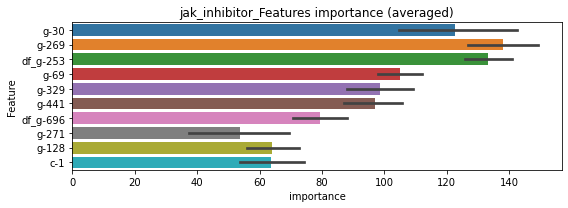

len(train_index) : 3862
len(valid_index) : 3862
================================= fold 1/2 jak_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0245069	valid_1's binary_logloss: 0.0606194
[200]	training's binary_logloss: 0.00413204	valid_1's binary_logloss: 0.0394911
[300]	training's binary_logloss: 0.00126253	valid_1's binary_logloss: 0.0355079
Early stopping, best iteration is:
[348]	training's binary_logloss: 0.000868449	valid_1's binary_logloss: 0.0345254


len(train_index) : 3862
len(valid_index) : 3862
================================= fold 2/2 jak_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0234684	valid_1's binary_logloss: 0.0610865
[200]	training's binary_logloss: 0.00383161	valid_1's binary_logloss: 0.037615
[300]	training's binary_logloss: 0.0011624	valid_1's binary_logloss: 0.0327799
Early stopping, best iteration is:
[365]	training's binary_logloss: 0.000704935	valid_1's binary_logloss: 0.0318038


jak_inhibitor logloss: 0.03316459404819343


  acetylcholine_receptor_agonist acetylcholine_receptor_antagonist  \
0                       df_g-122                              c-30   
1                  clusters_df_c                         c_all_max   
2                          cnt_0                    clusters_g_all   
3                      c_all_min                          df_g-707   
4                        df_g-51                        clusters_g   
5                       df_c_min                          df_c_min   
6                          cnt_2                             g-514   
7                       df_g-736                          df_g-640   
8                          g-244                            df_c-6   
9                           c-73                          df_g-597   

  acetylcholinesterase_inhibitor adenosine_receptor_antagonist  \
0                      c_all_max                clusters_c_all   
1                      c_all_min                      df_c_min   
2                 clusters_g_al

kit_inhibitor, len(trt): 273, len(othr): 3272, target_rate: 0.0114638 → Adj_target_rate: 0.0098841


neg labels: 3289 → selected neg labels: 3272


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0517819	valid_1's binary_logloss: 0.132564
[200]	training's binary_logloss: 0.0109522	valid_1's binary_logloss: 0.0967643
Early stopping, best iteration is:
[282]	training's binary_logloss: 0.00404062	valid_1's binary_logloss: 0.0899106
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0523941	valid_1's binary_logloss: 0.132371
[200]	training's binary_logloss: 0.0111768	valid_1's binary_logloss: 0.093697
Early stopping, best iteration is:
[249]	training's binary_logloss: 0.00575705	valid_1's binary_logloss: 0.0850298


1 / 3 AUC score:0.988
Threshold: 0.0343891, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 178 → positive_corect_labels: 631/3748
p_label_rate: 0.0615269 Vs.target_rate: 0.01146, Num_p_label: 245.0, conf_0:0.00438, conf_1:0.03783
Num_p_label: 245.0, Expected: 45.6, Adj_threshold_1: 0.0343891
Num_p_label: 222.0, Expected: 45.6, Adj_threshold_2: 0.0393891
Num_p_label: 200.0, Expected: 45.6, Adj_threshold_3: 0.0443891
Num_p_label: 181.0, Expected: 45.6, Adj_threshold_4: 0.0493891
Num_p_label: 165.0, Expected: 45.6, Adj_threshold_5: 0.0543891
Num_p_label: 155.0, Expected: 45.6, Adj_threshold_6: 0.0593891
Num_p_label: 147.0, Expected: 45.6, Adj_threshold_7: 0.0643891
Num_p_label: 146.0, Expected: 45.6, Adj_threshold_8: 0.0693891
Num_p_label: 140.0, Expected: 45.6, Adj_threshold_9: 0.0743891
Num_p_label: 137.0, Expected: 45.6, Adj_threshold_10: 0.0793891
threshold: 0.0843891, positive p_label: 132.0/3982, p_label_rate: 0.0331492
positive y_label: 631.0/3748, y_label_rate: 0.1683565
==========

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0453131	valid_1's binary_logloss: 0.0979905
[200]	training's binary_logloss: 0.00857548	valid_1's binary_logloss: 0.0563126
[300]	training's binary_logloss: 0.00238261	valid_1's binary_logloss: 0.0467968
Early stopping, best iteration is:
[341]	training's binary_logloss: 0.00167442	valid_1's binary_logloss: 0.0454129
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0455064	valid_1's binary_logloss: 0.101846
[200]	training's binary_logloss: 0.00859208	valid_1's binary_logloss: 0.0578595
[300]	training's binary_logloss: 0.00246872	valid_1's binary_logloss: 0.0460625
Early stopping, best iteration is:
[306]	training's binary_logloss: 0.00232349	valid_1's binary_logloss: 0.0458157


2 / 3 AUC score:0.996
Threshold: 0.0843891, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 43 → positive_corect_labels: 612.0/3705
p_label_rate: 0.0449523 Vs.target_rate: 0.01146, Num_p_label: 179.0, conf_0:0.00205, conf_1:0.09283
Num_p_label: 179.0, Expected: 45.6, Adj_threshold_1: 0.0843891
Num_p_label: 179.0, Expected: 45.6, Adj_threshold_2: 0.0893891
Num_p_label: 177.0, Expected: 45.6, Adj_threshold_3: 0.0943891
Num_p_label: 172.0, Expected: 45.6, Adj_threshold_4: 0.0993891
Num_p_label: 170.0, Expected: 45.6, Adj_threshold_5: 0.1043891
Num_p_label: 167.0, Expected: 45.6, Adj_threshold_6: 0.1093891
Num_p_label: 164.0, Expected: 45.6, Adj_threshold_7: 0.1143891
Num_p_label: 161.0, Expected: 45.6, Adj_threshold_8: 0.1193891
Num_p_label: 156.0, Expected: 45.6, Adj_threshold_9: 0.1243891
Num_p_label: 156.0, Expected: 45.6, Adj_threshold_10: 0.1293891
threshold: 0.1343891, positive p_label: 155.0/3982, p_label_rate: 0.0389252
positive y_label: 612.0/3705, y_label_rate: 0.1651822
=========

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0413556	valid_1's binary_logloss: 0.0855634
[200]	training's binary_logloss: 0.00737183	valid_1's binary_logloss: 0.0425159
[300]	training's binary_logloss: 0.00205507	valid_1's binary_logloss: 0.0294669
[400]	training's binary_logloss: 0.000964401	valid_1's binary_logloss: 0.0256091
[500]	training's binary_logloss: 0.000608035	valid_1's binary_logloss: 0.0239549
Early stopping, best iteration is:
[490]	training's binary_logloss: 0.000630155	valid_1's binary_logloss: 0.0238612
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.041865	valid_1's binary_logloss: 0.0944053
[200]	training's binary_logloss: 0.00757993	valid_1's binary_logloss: 0.055629
Early stopping, best iteration is:
[253]	training's binary_logloss: 0.00344703	valid_1's binary_logloss: 0.0482122


3 / 3 AUC score:0.994
Threshold: 0.1343891, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 20 → positive_corect_labels: 599.0/3685
p_label_rate: 0.0391763 Vs.target_rate: 0.01146, Num_p_label: 156.0, conf_0:0.00190, conf_1:0.14783
Num_p_label: 156.0, Expected: 45.6, Adj_threshold_1: 0.1343891
Num_p_label: 154.0, Expected: 45.6, Adj_threshold_2: 0.1393891
Num_p_label: 153.0, Expected: 45.6, Adj_threshold_3: 0.1443891
Num_p_label: 152.0, Expected: 45.6, Adj_threshold_4: 0.1493891
Num_p_label: 152.0, Expected: 45.6, Adj_threshold_5: 0.1543891
Num_p_label: 149.0, Expected: 45.6, Adj_threshold_6: 0.1593891
Num_p_label: 149.0, Expected: 45.6, Adj_threshold_7: 0.1643891
Num_p_label: 149.0, Expected: 45.6, Adj_threshold_8: 0.1693891
Num_p_label: 149.0, Expected: 45.6, Adj_threshold_9: 0.1743891
Num_p_label: 149.0, Expected: 45.6, Adj_threshold_10: 0.1793891
threshold: 0.1843891, positive p_label: 148.0/3982, p_label_rate: 0.0371673
positive y_label: 747.0/7667, y_label_rate: 0.0974305


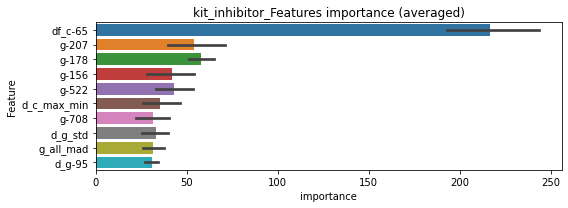

len(train_index) : 3833
len(valid_index) : 3834
================================= fold 1/2 kit_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0260455	valid_1's binary_logloss: 0.0628591
[200]	training's binary_logloss: 0.00452346	valid_1's binary_logloss: 0.0356627
[300]	training's binary_logloss: 0.00129886	valid_1's binary_logloss: 0.028102
Early stopping, best iteration is:
[333]	training's binary_logloss: 0.000982275	valid_1's binary_logloss: 0.0271949


len(train_index) : 3834
len(valid_index) : 3833
================================= fold 2/2 kit_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0264943	valid_1's binary_logloss: 0.0632299
[200]	training's binary_logloss: 0.00463604	valid_1's binary_logloss: 0.0386212
[300]	training's binary_logloss: 0.00134644	valid_1's binary_logloss: 0.0323255
[400]	training's binary_logloss: 0.000635194	valid_1's binary_logloss: 0.0303362
Early stopping, best iteration is:
[395]	training's binary_logloss: 0.000652052	valid_1's binary_logloss: 0.0302003


kit_inhibitor logloss: 0.028697434615716468


  acetylcholine_receptor_agonist acetylcholine_receptor_antagonist  \
0                       df_g-122                              c-30   
1                  clusters_df_c                         c_all_max   
2                          cnt_0                    clusters_g_all   
3                      c_all_min                          df_g-707   
4                        df_g-51                        clusters_g   
5                       df_c_min                          df_c_min   
6                          cnt_2                             g-514   
7                       df_g-736                          df_g-640   
8                          g-244                            df_c-6   
9                           c-73                          df_g-597   

  acetylcholinesterase_inhibitor adenosine_receptor_antagonist  \
0                      c_all_max                clusters_c_all   
1                      c_all_min                      df_c_min   
2                 clusters_g_al

laxative, len(trt): 6, len(othr): 3288, target_rate: 0.0002520 → Adj_target_rate: 0.0003851


neg labels: 3289 → selected neg labels: 3288


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0160263	valid_1's binary_logloss: 0.0184288
[200]	training's binary_logloss: 0.00136116	valid_1's binary_logloss: 0.00288862
[300]	training's binary_logloss: 0.000371787	valid_1's binary_logloss: 0.00140595
[400]	training's binary_logloss: 0.000225642	valid_1's binary_logloss: 0.00108667
Early stopping, best iteration is:
[445]	training's binary_logloss: 0.000205988	valid_1's binary_logloss: 0.00104683
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.016124	valid_1's binary_logloss: 0.0171837
[200]	training's binary_logloss: 0.00136146	valid_1's binary_logloss: 0.00160425
[300]	training's binary_logloss: 0.000368282	valid_1's binary_logloss: 0.000480419
[400]	training's binary_logloss: 0.000223362	valid_1's binary_logloss: 0.000300227
Early stopping, best iteration is:
[482]	training's binary_logloss: 0.000201334	valid_1's binary_logloss: 0.0002

1 / 3 AUC score:1.000
Threshold: 0.0005423, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → positive_corect_labels: 657/3813
p_label_rate: 0.0426921 Vs.target_rate: 0.00025, Num_p_label: 170.0, conf_0:0.00012, conf_1:0.00060
Num_p_label: 170.0, Expected: 1.0, Adj_threshold_1: 0.0005423
Num_p_label: 9.0, Expected: 1.0, Adj_threshold_2: 0.0055423
Num_p_label: 5.0, Expected: 1.0, Adj_threshold_3: 0.0105423
Num_p_label: 5.0, Expected: 1.0, Adj_threshold_4: 0.0155423
Num_p_label: 5.0, Expected: 1.0, Adj_threshold_5: 0.0205423
Num_p_label: 3.0, Expected: 1.0, Adj_threshold_6: 0.0255423
Num_p_label: 1.0, Expected: 1.0, Adj_threshold_7: 0.0305423
threshold: 0.0305423, positive p_label: 1.0/3982, p_label_rate: 0.0002511
positive y_label: 657.0/3813, y_label_rate: 0.1723053
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0162577	valid_1's binary_logloss: 0.0191534
[200]	training's binary_logloss: 0.00132829	valid_1's binary_logloss: 0.00287691
[300]	training's binary_logloss: 0.000358792	valid_1's binary_logloss: 0.00125755
[400]	training's binary_logloss: 0.000221281	valid_1's binary_logloss: 0.000993456
[500]	training's binary_logloss: 0.000192439	valid_1's binary_logloss: 0.000928722
Early stopping, best iteration is:
[517]	training's binary_logloss: 0.000191672	valid_1's binary_logloss: 0.000927642
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0163796	valid_1's binary_logloss: 0.0171836
[200]	training's binary_logloss: 0.00135289	valid_1's binary_logloss: 0.00150962
[300]	training's binary_logloss: 0.00036068	valid_1's binary_logloss: 0.000428763
[400]	training's binary_logloss: 0.000220572	valid_1's binary_logloss: 0.000266825
[500]	training's binary_log

2 / 3 AUC score:1.000
Threshold: 0.0305423, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → positive_corect_labels: 657.0/3813
p_label_rate: 0.0017579 Vs.target_rate: 0.00025, Num_p_label: 7.0, conf_0:0.00012, conf_1:0.03360
Num_p_label: 7.0, Expected: 1.0, Adj_threshold_1: 0.0305423
Num_p_label: 6.0, Expected: 1.0, Adj_threshold_2: 0.0355423
Num_p_label: 6.0, Expected: 1.0, Adj_threshold_3: 0.0405423
Num_p_label: 6.0, Expected: 1.0, Adj_threshold_4: 0.0455423
Num_p_label: 5.0, Expected: 1.0, Adj_threshold_5: 0.0505423
Num_p_label: 5.0, Expected: 1.0, Adj_threshold_6: 0.0555423
Num_p_label: 5.0, Expected: 1.0, Adj_threshold_7: 0.0605423
Num_p_label: 4.0, Expected: 1.0, Adj_threshold_8: 0.0655423
Num_p_label: 4.0, Expected: 1.0, Adj_threshold_9: 0.0705423
Num_p_label: 4.0, Expected: 1.0, Adj_threshold_10: 0.0755423
threshold: 0.0805423, positive p_label: 3.0/3982, p_label_rate: 0.0007534
positive y_label: 657.0/3813, y_label_rate: 0.1723053
================= Pseudo labeling 3 / 3 ====

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0162577	valid_1's binary_logloss: 0.0191534
[200]	training's binary_logloss: 0.00132829	valid_1's binary_logloss: 0.00287691
[300]	training's binary_logloss: 0.000358792	valid_1's binary_logloss: 0.00125755
[400]	training's binary_logloss: 0.000221281	valid_1's binary_logloss: 0.000993456
[500]	training's binary_logloss: 0.000192439	valid_1's binary_logloss: 0.000928722
Early stopping, best iteration is:
[517]	training's binary_logloss: 0.000191672	valid_1's binary_logloss: 0.000927642
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0163796	valid_1's binary_logloss: 0.0171836
[200]	training's binary_logloss: 0.00135289	valid_1's binary_logloss: 0.00150962
[300]	training's binary_logloss: 0.00036068	valid_1's binary_logloss: 0.000428763
[400]	training's binary_logloss: 0.000220572	valid_1's binary_logloss: 0.000266825
[500]	training's binary_log

3 / 3 AUC score:1.000
Threshold: 0.0805423, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → positive_corect_labels: 657.0/3813
p_label_rate: 0.0007534 Vs.target_rate: 0.00025, Num_p_label: 3.0, conf_0:0.00012, conf_1:0.08860
threshold: 0.0805423, positive p_label: 3.0/3982, p_label_rate: 0.0007534
positive y_label: 660.0/7795, y_label_rate: 0.0846697


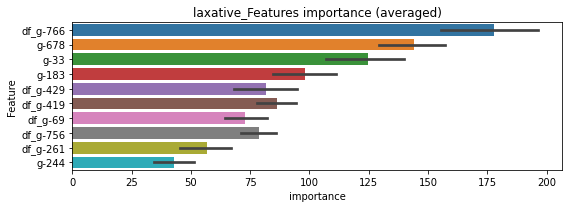

len(train_index) : 3897
len(valid_index) : 3898
================================= fold 1/2 laxative=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.00860204	valid_1's binary_logloss: 0.0105569
[200]	training's binary_logloss: 0.000697554	valid_1's binary_logloss: 0.00256753
[300]	training's binary_logloss: 0.000186157	valid_1's binary_logloss: 0.00211862
Early stopping, best iteration is:
[296]	training's binary_logloss: 0.000192638	valid_1's binary_logloss: 0.00211578


len(train_index) : 3898
len(valid_index) : 3897
================================= fold 2/2 laxative=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.00876012	valid_1's binary_logloss: 0.0109858
[200]	training's binary_logloss: 0.000727259	valid_1's binary_logloss: 0.00266943
[300]	training's binary_logloss: 0.000192866	valid_1's binary_logloss: 0.00187137
Early stopping, best iteration is:
[375]	training's binary_logloss: 0.000124532	valid_1's binary_logloss: 0.00174639


laxative logloss: 0.0019311061717507487
leukotriene_inhibitor, len(trt): 6, len(othr): 3288, target_rate: 0.0002520 → Adj_target_rate: 0.0003851


neg labels: 3289 → selected neg labels: 3288


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0158089	valid_1's binary_logloss: 0.0166344
[200]	training's binary_logloss: 0.00133954	valid_1's binary_logloss: 0.00165964
[300]	training's binary_logloss: 0.000359008	valid_1's binary_logloss: 0.000520624
[400]	training's binary_logloss: 0.000219346	valid_1's binary_logloss: 0.000347282
[500]	training's binary_logloss: 0.000195149	valid_1's binary_logloss: 0.000315714
Early stopping, best iteration is:
[529]	training's binary_logloss: 0.000193328	valid_1's binary_logloss: 0.000313671
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.015943	valid_1's binary_logloss: 0.017442
[200]	training's binary_logloss: 0.00133817	valid_1's binary_logloss: 0.00167328
[300]	training's binary_logloss: 0.000358823	valid_1's binary_logloss: 0.000504846
[400]	training's binary_logloss: 0.000219325	valid_1's binary_logloss: 0.00031573
[500]	training's binary_logl

1 / 3 AUC score:1.000
Threshold: 0.0005083, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → positive_corect_labels: 657/3813
p_label_rate: 0.0386740 Vs.target_rate: 0.00025, Num_p_label: 154.0, conf_0:0.00011, conf_1:0.00056
Num_p_label: 154.0, Expected: 1.0, Adj_threshold_1: 0.0005083
Num_p_label: 9.0, Expected: 1.0, Adj_threshold_2: 0.0055083
Num_p_label: 6.0, Expected: 1.0, Adj_threshold_3: 0.0105083
Num_p_label: 3.0, Expected: 1.0, Adj_threshold_4: 0.0155083
Num_p_label: 2.0, Expected: 1.0, Adj_threshold_5: 0.0205083
threshold: 0.0205083, positive p_label: 2.0/3982, p_label_rate: 0.0005023
positive y_label: 657.0/3813, y_label_rate: 0.1723053
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0160132	valid_1's binary_logloss: 0.0170003
[200]	training's binary_logloss: 0.00130885	valid_1's binary_logloss: 0.00170445
[300]	training's binary_logloss: 0.000351866	valid_1's binary_logloss: 0.000546196
[400]	training's binary_logloss: 0.000218447	valid_1's binary_logloss: 0.000373472
[500]	training's binary_logloss: 0.000189162	valid_1's binary_logloss: 0.000334455
Early stopping, best iteration is:
[516]	training's binary_logloss: 0.000188128	valid_1's binary_logloss: 0.000333401
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.01623	valid_1's binary_logloss: 0.0173544
[200]	training's binary_logloss: 0.00133981	valid_1's binary_logloss: 0.00154766
[300]	training's binary_logloss: 0.000353584	valid_1's binary_logloss: 0.000434204
[400]	training's binary_logloss: 0.000217282	valid_1's binary_logloss: 0.000272677
[500]	training's binary_log

2 / 3 AUC score:1.000
Threshold: 0.0205083, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → positive_corect_labels: 657.0/3813
p_label_rate: 0.0030136 Vs.target_rate: 0.00025, Num_p_label: 12.0, conf_0:0.00011, conf_1:0.02256
Num_p_label: 12.0, Expected: 1.0, Adj_threshold_1: 0.0205083
Num_p_label: 12.0, Expected: 1.0, Adj_threshold_2: 0.0255083
Num_p_label: 12.0, Expected: 1.0, Adj_threshold_3: 0.0305083
Num_p_label: 8.0, Expected: 1.0, Adj_threshold_4: 0.0355083
Num_p_label: 7.0, Expected: 1.0, Adj_threshold_5: 0.0405083
Num_p_label: 7.0, Expected: 1.0, Adj_threshold_6: 0.0455083
Num_p_label: 6.0, Expected: 1.0, Adj_threshold_7: 0.0505083
Num_p_label: 6.0, Expected: 1.0, Adj_threshold_8: 0.0555083
Num_p_label: 5.0, Expected: 1.0, Adj_threshold_9: 0.0605083
Num_p_label: 4.0, Expected: 1.0, Adj_threshold_10: 0.0655083
threshold: 0.0705083, positive p_label: 4.0/3982, p_label_rate: 0.0010045
positive y_label: 657.0/3813, y_label_rate: 0.1723053
================= Pseudo labeling 3 / 3 

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0160132	valid_1's binary_logloss: 0.0170003
[200]	training's binary_logloss: 0.00130885	valid_1's binary_logloss: 0.00170445
[300]	training's binary_logloss: 0.000351866	valid_1's binary_logloss: 0.000546196
[400]	training's binary_logloss: 0.000218447	valid_1's binary_logloss: 0.000373472
[500]	training's binary_logloss: 0.000189162	valid_1's binary_logloss: 0.000334455
Early stopping, best iteration is:
[516]	training's binary_logloss: 0.000188128	valid_1's binary_logloss: 0.000333401
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.01623	valid_1's binary_logloss: 0.0173544
[200]	training's binary_logloss: 0.00133981	valid_1's binary_logloss: 0.00154766
[300]	training's binary_logloss: 0.000353584	valid_1's binary_logloss: 0.000434204
[400]	training's binary_logloss: 0.000217282	valid_1's binary_logloss: 0.000272677
[500]	training's binary_log

3 / 3 AUC score:1.000
Threshold: 0.0705083, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → positive_corect_labels: 657.0/3813
p_label_rate: 0.0010045 Vs.target_rate: 0.00025, Num_p_label: 4.0, conf_0:0.00011, conf_1:0.07756
Num_p_label: 4.0, Expected: 1.0, Adj_threshold_1: 0.0705083
Num_p_label: 4.0, Expected: 1.0, Adj_threshold_2: 0.0755083
Num_p_label: 4.0, Expected: 1.0, Adj_threshold_3: 0.0805083
Num_p_label: 4.0, Expected: 1.0, Adj_threshold_4: 0.0855083
Num_p_label: 4.0, Expected: 1.0, Adj_threshold_5: 0.0905083
Num_p_label: 3.0, Expected: 1.0, Adj_threshold_6: 0.0955083
Num_p_label: 3.0, Expected: 1.0, Adj_threshold_7: 0.1005083
Num_p_label: 2.0, Expected: 1.0, Adj_threshold_8: 0.1055083
threshold: 0.1055083, positive p_label: 2.0/3982, p_label_rate: 0.0005023
positive y_label: 659.0/7795, y_label_rate: 0.0845414


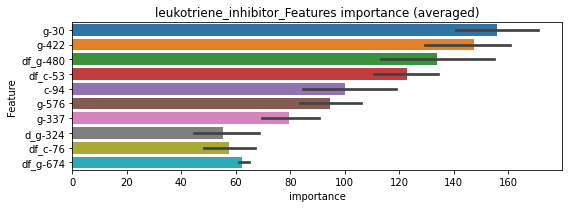

len(train_index) : 3897
len(valid_index) : 3898
================================= fold 1/2 leukotriene_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.00856044	valid_1's binary_logloss: 0.0101549
[200]	training's binary_logloss: 0.000685483	valid_1's binary_logloss: 0.0021914
[300]	training's binary_logloss: 0.000182041	valid_1's binary_logloss: 0.00163964
Early stopping, best iteration is:
[359]	training's binary_logloss: 0.000127064	valid_1's binary_logloss: 0.0015833


len(train_index) : 3898
len(valid_index) : 3897
================================= fold 2/2 leukotriene_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.00860311	valid_1's binary_logloss: 0.0105063
[200]	training's binary_logloss: 0.000694222	valid_1's binary_logloss: 0.00206402
[300]	training's binary_logloss: 0.000184807	valid_1's binary_logloss: 0.00134831
Early stopping, best iteration is:
[365]	training's binary_logloss: 0.000124918	valid_1's binary_logloss: 0.00124166


leukotriene_inhibitor logloss: 0.0014124979082720391
leukotriene_receptor_antagonist, len(trt): 62, len(othr): 3280, target_rate: 0.0026035 → Adj_target_rate: 0.0028037


neg labels: 3289 → selected neg labels: 3280


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0444333	valid_1's binary_logloss: 0.094168
[200]	training's binary_logloss: 0.00850413	valid_1's binary_logloss: 0.0492971
[300]	training's binary_logloss: 0.002547	valid_1's binary_logloss: 0.0369305
[400]	training's binary_logloss: 0.00123202	valid_1's binary_logloss: 0.0332705
[500]	training's binary_logloss: 0.000775731	valid_1's binary_logloss: 0.0316874
Early stopping, best iteration is:
[496]	training's binary_logloss: 0.000786469	valid_1's binary_logloss: 0.0316138
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0471806	valid_1's binary_logloss: 0.0811185
[200]	training's binary_logloss: 0.00999018	valid_1's binary_logloss: 0.0379761
[300]	training's binary_logloss: 0.00301403	valid_1's binary_logloss: 0.0277248
Early stopping, best iteration is:
[344]	training's binary_logloss: 0.00202949	valid_1's binary_logloss: 0.0257902


1 / 3 AUC score:0.999
Threshold: 0.0101108, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 136 → positive_corect_labels: 654/3800
p_label_rate: 0.0283777 Vs.target_rate: 0.00260, Num_p_label: 113.0, conf_0:0.00142, conf_1:0.01112
Num_p_label: 113.0, Expected: 10.4, Adj_threshold_1: 0.0101108
Num_p_label: 68.0, Expected: 10.4, Adj_threshold_2: 0.0151108
Num_p_label: 43.0, Expected: 10.4, Adj_threshold_3: 0.0201108
Num_p_label: 25.0, Expected: 10.4, Adj_threshold_4: 0.0251108
Num_p_label: 16.0, Expected: 10.4, Adj_threshold_5: 0.0301108
threshold: 0.0301108, positive p_label: 16.0/3982, p_label_rate: 0.0040181
positive y_label: 654.0/3800, y_label_rate: 0.1721053
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0462936	valid_1's binary_logloss: 0.0874197
[200]	training's binary_logloss: 0.00904009	valid_1's binary_logloss: 0.0383813
[300]	training's binary_logloss: 0.00272449	valid_1's binary_logloss: 0.0253644
[400]	training's binary_logloss: 0.0012939	valid_1's binary_logloss: 0.0212268
Early stopping, best iteration is:
[420]	training's binary_logloss: 0.00115665	valid_1's binary_logloss: 0.0205842
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0466015	valid_1's binary_logloss: 0.08378
[200]	training's binary_logloss: 0.00919405	valid_1's binary_logloss: 0.0382951
[300]	training's binary_logloss: 0.00271542	valid_1's binary_logloss: 0.0268348
[400]	training's binary_logloss: 0.00129181	valid_1's binary_logloss: 0.023522
Early stopping, best iteration is:
[395]	training's binary_logloss: 0.00132784	valid_1's binary_logloss: 0.0234329


2 / 3 AUC score:1.000
Threshold: 0.0301108, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 8 → positive_corect_labels: 653.0/3792
p_label_rate: 0.0145655 Vs.target_rate: 0.00260, Num_p_label: 58.0, conf_0:0.00138, conf_1:0.03312
Num_p_label: 58.0, Expected: 10.4, Adj_threshold_1: 0.0301108
Num_p_label: 45.0, Expected: 10.4, Adj_threshold_2: 0.0351108
Num_p_label: 32.0, Expected: 10.4, Adj_threshold_3: 0.0401108
Num_p_label: 27.0, Expected: 10.4, Adj_threshold_4: 0.0451108
Num_p_label: 20.0, Expected: 10.4, Adj_threshold_5: 0.0501108
threshold: 0.0501108, positive p_label: 20.0/3982, p_label_rate: 0.0050226
positive y_label: 653.0/3792, y_label_rate: 0.1722046
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0450882	valid_1's binary_logloss: 0.0842636
[200]	training's binary_logloss: 0.00873166	valid_1's binary_logloss: 0.037149
[300]	training's binary_logloss: 0.00264781	valid_1's binary_logloss: 0.0251336
[400]	training's binary_logloss: 0.00125551	valid_1's binary_logloss: 0.0214498
Early stopping, best iteration is:
[480]	training's binary_logloss: 0.000855963	valid_1's binary_logloss: 0.0200275
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0465686	valid_1's binary_logloss: 0.0856153
[200]	training's binary_logloss: 0.00905585	valid_1's binary_logloss: 0.0383834
[300]	training's binary_logloss: 0.0027193	valid_1's binary_logloss: 0.026123
[400]	training's binary_logloss: 0.00129423	valid_1's binary_logloss: 0.0224143
Early stopping, best iteration is:
[466]	training's binary_logloss: 0.000926333	valid_1's binary_logloss: 0.0209124


3 / 3 AUC score:1.000
Threshold: 0.0501108, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 8 → positive_corect_labels: 648.0/3784
p_label_rate: 0.0045203 Vs.target_rate: 0.00260, Num_p_label: 18.0, conf_0:0.00102, conf_1:0.05512
threshold: 0.0501108, positive p_label: 18.0/3982, p_label_rate: 0.0045203
positive y_label: 666.0/7766, y_label_rate: 0.0857584


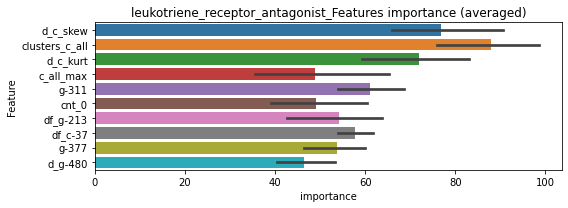

len(train_index) : 3883
len(valid_index) : 3883
================================= fold 1/2 leukotriene_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0252125	valid_1's binary_logloss: 0.0586045
[200]	training's binary_logloss: 0.00465396	valid_1's binary_logloss: 0.0354953
[300]	training's binary_logloss: 0.00140073	valid_1's binary_logloss: 0.0312758
[400]	training's binary_logloss: 0.000654972	valid_1's binary_logloss: 0.030027
Early stopping, best iteration is:
[430]	training's binary_logloss: 0.00055609	valid_1's binary_logloss: 0.0298337


len(train_index) : 3883
len(valid_index) : 3883
================================= fold 2/2 leukotriene_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0252575	valid_1's binary_logloss: 0.0529694
[200]	training's binary_logloss: 0.00480252	valid_1's binary_logloss: 0.0269976
[300]	training's binary_logloss: 0.00143767	valid_1's binary_logloss: 0.0216666
[400]	training's binary_logloss: 0.000671168	valid_1's binary_logloss: 0.0202502
Early stopping, best iteration is:
[421]	training's binary_logloss: 0.000597984	valid_1's binary_logloss: 0.0200628


leukotriene_receptor_antagonist logloss: 0.02494826320609079


  acetylcholine_receptor_agonist acetylcholine_receptor_antagonist  \
0                       df_g-122                              c-30   
1                  clusters_df_c                         c_all_max   
2                          cnt_0                    clusters_g_all   
3                      c_all_min                          df_g-707   
4                        df_g-51                        clusters_g   
5                       df_c_min                          df_c_min   
6                          cnt_2                             g-514   
7                       df_g-736                          df_g-640   
8                          g-244                            df_c-6   
9                           c-73                          df_g-597   

  acetylcholinesterase_inhibitor adenosine_receptor_antagonist  \
0                      c_all_max                clusters_c_all   
1                      c_all_min                      df_c_min   
2                 clusters_g_al

lipase_inhibitor, len(trt): 12, len(othr): 3287, target_rate: 0.0005039 → Adj_target_rate: 0.0006942


neg labels: 3289 → selected neg labels: 3287


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0196876	valid_1's binary_logloss: 0.02769
[200]	training's binary_logloss: 0.00209025	valid_1's binary_logloss: 0.00538348
[300]	training's binary_logloss: 0.000592872	valid_1's binary_logloss: 0.00259169
[400]	training's binary_logloss: 0.000331715	valid_1's binary_logloss: 0.00191404
Early stopping, best iteration is:
[468]	training's binary_logloss: 0.000286243	valid_1's binary_logloss: 0.0017789
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0194603	valid_1's binary_logloss: 0.0223158
[200]	training's binary_logloss: 0.00207742	valid_1's binary_logloss: 0.00304903
[300]	training's binary_logloss: 0.000592884	valid_1's binary_logloss: 0.0010247
[400]	training's binary_logloss: 0.000330046	valid_1's binary_logloss: 0.000604202
[500]	training's binary_logloss: 0.000287645	valid_1's binary_logloss: 0.000533106
Early stopping, best iteration is

1 / 3 AUC score:1.000
Threshold: 0.0012605, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → positive_corect_labels: 657/3812
p_label_rate: 0.0376695 Vs.target_rate: 0.00050, Num_p_label: 150.0, conf_0:0.00017, conf_1:0.00139
Num_p_label: 150.0, Expected: 2.0, Adj_threshold_1: 0.0012605
Num_p_label: 20.0, Expected: 2.0, Adj_threshold_2: 0.0062605
Num_p_label: 10.0, Expected: 2.0, Adj_threshold_3: 0.0112605
Num_p_label: 7.0, Expected: 2.0, Adj_threshold_4: 0.0162605
Num_p_label: 5.0, Expected: 2.0, Adj_threshold_5: 0.0212605
Num_p_label: 3.0, Expected: 2.0, Adj_threshold_6: 0.0262605
threshold: 0.0262605, positive p_label: 3.0/3982, p_label_rate: 0.0007534
positive y_label: 657.0/3812, y_label_rate: 0.1723505
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0196483	valid_1's binary_logloss: 0.0258273
[200]	training's binary_logloss: 0.00201546	valid_1's binary_logloss: 0.0046752
[300]	training's binary_logloss: 0.00057306	valid_1's binary_logloss: 0.00183142
[400]	training's binary_logloss: 0.000322976	valid_1's binary_logloss: 0.00122431
[500]	training's binary_logloss: 0.000276721	valid_1's binary_logloss: 0.00112971
Early stopping, best iteration is:
[513]	training's binary_logloss: 0.000275787	valid_1's binary_logloss: 0.00112712
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0195735	valid_1's binary_logloss: 0.0219474
[200]	training's binary_logloss: 0.00201448	valid_1's binary_logloss: 0.00262922
[300]	training's binary_logloss: 0.00056991	valid_1's binary_logloss: 0.000831157
[400]	training's binary_logloss: 0.000322058	valid_1's binary_logloss: 0.000494714
[500]	training's binary_logloss:

2 / 3 AUC score:1.000
Threshold: 0.0262605, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → positive_corect_labels: 657.0/3812
p_label_rate: 0.0025113 Vs.target_rate: 0.00050, Num_p_label: 10.0, conf_0:0.00018, conf_1:0.02889
Num_p_label: 10.0, Expected: 2.0, Adj_threshold_1: 0.0262605
Num_p_label: 9.0, Expected: 2.0, Adj_threshold_2: 0.0312605
Num_p_label: 8.0, Expected: 2.0, Adj_threshold_3: 0.0362605
Num_p_label: 7.0, Expected: 2.0, Adj_threshold_4: 0.0412605
Num_p_label: 7.0, Expected: 2.0, Adj_threshold_5: 0.0462605
Num_p_label: 7.0, Expected: 2.0, Adj_threshold_6: 0.0512605
Num_p_label: 6.0, Expected: 2.0, Adj_threshold_7: 0.0562605
Num_p_label: 6.0, Expected: 2.0, Adj_threshold_8: 0.0612605
Num_p_label: 6.0, Expected: 2.0, Adj_threshold_9: 0.0662605
Num_p_label: 5.0, Expected: 2.0, Adj_threshold_10: 0.0712605
threshold: 0.0762605, positive p_label: 4.0/3982, p_label_rate: 0.0010045
positive y_label: 657.0/3812, y_label_rate: 0.1723505
================= Pseudo labeling 3 / 3 ==

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0196483	valid_1's binary_logloss: 0.0258273
[200]	training's binary_logloss: 0.00201546	valid_1's binary_logloss: 0.0046752
[300]	training's binary_logloss: 0.00057306	valid_1's binary_logloss: 0.00183142
[400]	training's binary_logloss: 0.000322976	valid_1's binary_logloss: 0.00122431
[500]	training's binary_logloss: 0.000276721	valid_1's binary_logloss: 0.00112971
Early stopping, best iteration is:
[513]	training's binary_logloss: 0.000275787	valid_1's binary_logloss: 0.00112712
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0195735	valid_1's binary_logloss: 0.0219474
[200]	training's binary_logloss: 0.00201448	valid_1's binary_logloss: 0.00262922
[300]	training's binary_logloss: 0.00056991	valid_1's binary_logloss: 0.000831157
[400]	training's binary_logloss: 0.000322058	valid_1's binary_logloss: 0.000494714
[500]	training's binary_logloss:

3 / 3 AUC score:1.000
Threshold: 0.0762605, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → positive_corect_labels: 657.0/3812
p_label_rate: 0.0010045 Vs.target_rate: 0.00050, Num_p_label: 4.0, conf_0:0.00018, conf_1:0.08389
threshold: 0.0762605, positive p_label: 4.0/3982, p_label_rate: 0.0010045
positive y_label: 661.0/7794, y_label_rate: 0.0848088


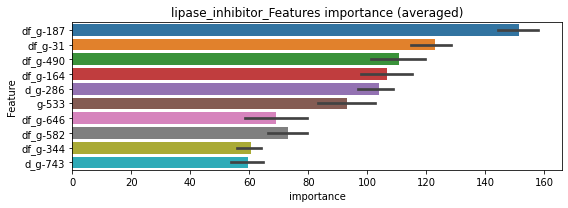

len(train_index) : 3897
len(valid_index) : 3897
================================= fold 1/2 lipase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0104997	valid_1's binary_logloss: 0.0143533
[200]	training's binary_logloss: 0.00106864	valid_1's binary_logloss: 0.00336792
[300]	training's binary_logloss: 0.000294412	valid_1's binary_logloss: 0.00240895
Early stopping, best iteration is:
[306]	training's binary_logloss: 0.000280449	valid_1's binary_logloss: 0.00239211


len(train_index) : 3897
len(valid_index) : 3897
================================= fold 2/2 lipase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0107051	valid_1's binary_logloss: 0.0125381
[200]	training's binary_logloss: 0.00110363	valid_1's binary_logloss: 0.00238154
[300]	training's binary_logloss: 0.000303214	valid_1's binary_logloss: 0.00152376
[400]	training's binary_logloss: 0.000167709	valid_1's binary_logloss: 0.00141283
Early stopping, best iteration is:
[404]	training's binary_logloss: 0.000165599	valid_1's binary_logloss: 0.00140992


lipase_inhibitor logloss: 0.0019010181171023905
lipoxygenase_inhibitor, len(trt): 61, len(othr): 3278, target_rate: 0.0025615 → Adj_target_rate: 0.0027652


neg labels: 3289 → selected neg labels: 3278


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0483636	valid_1's binary_logloss: 0.0950157
[200]	training's binary_logloss: 0.0099987	valid_1's binary_logloss: 0.0470533
[300]	training's binary_logloss: 0.00298537	valid_1's binary_logloss: 0.0330619
[400]	training's binary_logloss: 0.00141043	valid_1's binary_logloss: 0.0279781
[500]	training's binary_logloss: 0.000872768	valid_1's binary_logloss: 0.0261607
[600]	training's binary_logloss: 0.000654758	valid_1's binary_logloss: 0.0255452
Early stopping, best iteration is:
[593]	training's binary_logloss: 0.000663693	valid_1's binary_logloss: 0.0255136
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.051652	valid_1's binary_logloss: 0.0932519
[200]	training's binary_logloss: 0.0110362	valid_1's binary_logloss: 0.0410657
[300]	training's binary_logloss: 0.00319981	valid_1's binary_logloss: 0.0260709
[400]	training's binary_logloss: 0.00146718	v

1 / 3 AUC score:1.000
Threshold: 0.0052846, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → positive_corect_labels: 655/3801
p_label_rate: 0.0527373 Vs.target_rate: 0.00256, Num_p_label: 210.0, conf_0:0.00089, conf_1:0.00581
Num_p_label: 210.0, Expected: 10.2, Adj_threshold_1: 0.0052846
Num_p_label: 92.0, Expected: 10.2, Adj_threshold_2: 0.0102846
Num_p_label: 56.0, Expected: 10.2, Adj_threshold_3: 0.0152846
Num_p_label: 40.0, Expected: 10.2, Adj_threshold_4: 0.0202846
Num_p_label: 33.0, Expected: 10.2, Adj_threshold_5: 0.0252846
Num_p_label: 28.0, Expected: 10.2, Adj_threshold_6: 0.0302846
Num_p_label: 22.0, Expected: 10.2, Adj_threshold_7: 0.0352846
Num_p_label: 17.0, Expected: 10.2, Adj_threshold_8: 0.0402846
threshold: 0.0402846, positive p_label: 17.0/3982, p_label_rate: 0.0042692
positive y_label: 655.0/3801, y_label_rate: 0.1723231
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0489974	valid_1's binary_logloss: 0.0978917
[200]	training's binary_logloss: 0.00995647	valid_1's binary_logloss: 0.0465575
[300]	training's binary_logloss: 0.00295655	valid_1's binary_logloss: 0.031311
[400]	training's binary_logloss: 0.00137638	valid_1's binary_logloss: 0.0267687
[500]	training's binary_logloss: 0.000854861	valid_1's binary_logloss: 0.0249374
Early stopping, best iteration is:
[523]	training's binary_logloss: 0.000792004	valid_1's binary_logloss: 0.0247325
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0514876	valid_1's binary_logloss: 0.0929501
[200]	training's binary_logloss: 0.0109739	valid_1's binary_logloss: 0.0420704
[300]	training's binary_logloss: 0.00324498	valid_1's binary_logloss: 0.0275591
[400]	training's binary_logloss: 0.00147322	valid_1's binary_logloss: 0.0229233
[500]	training's binary_logloss: 0.000903829	

2 / 3 AUC score:1.000
Threshold: 0.0402846, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 5 → positive_corect_labels: 651.0/3796
p_label_rate: 0.0138122 Vs.target_rate: 0.00256, Num_p_label: 55.0, conf_0:0.00110, conf_1:0.04431
Num_p_label: 55.0, Expected: 10.2, Adj_threshold_1: 0.0402846
Num_p_label: 46.0, Expected: 10.2, Adj_threshold_2: 0.0452846
Num_p_label: 42.0, Expected: 10.2, Adj_threshold_3: 0.0502846
Num_p_label: 37.0, Expected: 10.2, Adj_threshold_4: 0.0552846
Num_p_label: 35.0, Expected: 10.2, Adj_threshold_5: 0.0602846
Num_p_label: 31.0, Expected: 10.2, Adj_threshold_6: 0.0652846
Num_p_label: 28.0, Expected: 10.2, Adj_threshold_7: 0.0702846
Num_p_label: 26.0, Expected: 10.2, Adj_threshold_8: 0.0752846
Num_p_label: 25.0, Expected: 10.2, Adj_threshold_9: 0.0802846
Num_p_label: 23.0, Expected: 10.2, Adj_threshold_10: 0.0852846
threshold: 0.0902846, positive p_label: 20.0/3982, p_label_rate: 0.0050226
positive y_label: 651.0/3796, y_label_rate: 0.1714963
================= Pseu

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0488916	valid_1's binary_logloss: 0.0912465
[200]	training's binary_logloss: 0.0100954	valid_1's binary_logloss: 0.0408077
[300]	training's binary_logloss: 0.00301314	valid_1's binary_logloss: 0.0260722
Early stopping, best iteration is:
[385]	training's binary_logloss: 0.00151924	valid_1's binary_logloss: 0.0220392
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0500571	valid_1's binary_logloss: 0.0933332
[200]	training's binary_logloss: 0.010531	valid_1's binary_logloss: 0.0446429
[300]	training's binary_logloss: 0.00298591	valid_1's binary_logloss: 0.0311926
[400]	training's binary_logloss: 0.00138287	valid_1's binary_logloss: 0.0269931
Early stopping, best iteration is:
[421]	training's binary_logloss: 0.00122498	valid_1's binary_logloss: 0.0264043


3 / 3 AUC score:1.000
Threshold: 0.0902846, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 9 → positive_corect_labels: 642.0/3787
p_label_rate: 0.0052737 Vs.target_rate: 0.00256, Num_p_label: 21.0, conf_0:0.00182, conf_1:0.09931
threshold: 0.0902846, positive p_label: 21.0/3982, p_label_rate: 0.0052737
positive y_label: 663.0/7769, y_label_rate: 0.0853392


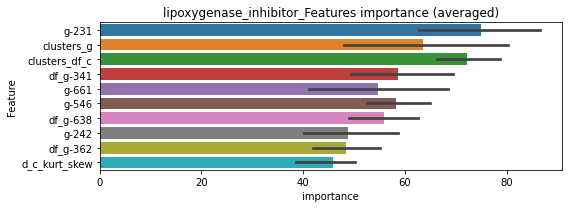

len(train_index) : 3884
len(valid_index) : 3885
================================= fold 1/2 lipoxygenase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0275581	valid_1's binary_logloss: 0.062188
[200]	training's binary_logloss: 0.00585919	valid_1's binary_logloss: 0.0352335
[300]	training's binary_logloss: 0.0017131	valid_1's binary_logloss: 0.028684
Early stopping, best iteration is:
[345]	training's binary_logloss: 0.00113117	valid_1's binary_logloss: 0.0277469


len(train_index) : 3885
len(valid_index) : 3884
================================= fold 2/2 lipoxygenase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.027684	valid_1's binary_logloss: 0.0539673
[200]	training's binary_logloss: 0.0060001	valid_1's binary_logloss: 0.0290107
[300]	training's binary_logloss: 0.00177179	valid_1's binary_logloss: 0.02308
Early stopping, best iteration is:
[385]	training's binary_logloss: 0.000850687	valid_1's binary_logloss: 0.0209972


lipoxygenase_inhibitor logloss: 0.024372457738701885


  acetylcholine_receptor_agonist acetylcholine_receptor_antagonist  \
0                       df_g-122                              c-30   
1                  clusters_df_c                         c_all_max   
2                          cnt_0                    clusters_g_all   
3                      c_all_min                          df_g-707   
4                        df_g-51                        clusters_g   
5                       df_c_min                          df_c_min   
6                          cnt_2                             g-514   
7                       df_g-736                          df_g-640   
8                          g-244                            df_c-6   
9                           c-73                          df_g-597   

  acetylcholinesterase_inhibitor adenosine_receptor_antagonist  \
0                      c_all_max                clusters_c_all   
1                      c_all_min                      df_c_min   
2                 clusters_g_al

lxr_agonist, len(trt): 6, len(othr): 3288, target_rate: 0.0002520 → Adj_target_rate: 0.0003851


neg labels: 3289 → selected neg labels: 3288


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0152507	valid_1's binary_logloss: 0.0166479
[200]	training's binary_logloss: 0.00119313	valid_1's binary_logloss: 0.00175715
[300]	training's binary_logloss: 0.00030629	valid_1's binary_logloss: 0.000670357
[400]	training's binary_logloss: 0.000191179	valid_1's binary_logloss: 0.000566808
Early stopping, best iteration is:
[409]	training's binary_logloss: 0.000188127	valid_1's binary_logloss: 0.000563659
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0155782	valid_1's binary_logloss: 0.0161609
[200]	training's binary_logloss: 0.00123012	valid_1's binary_logloss: 0.0013429
[300]	training's binary_logloss: 0.000311864	valid_1's binary_logloss: 0.00036503
[400]	training's binary_logloss: 0.000195492	valid_1's binary_logloss: 0.000237002
[500]	training's binary_logloss: 0.000175771	valid_1's binary_logloss: 0.00021533
[600]	training's binary_loglo

1 / 3 AUC score:1.000
Threshold: 0.0005130, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → positive_corect_labels: 657/3813
p_label_rate: 0.0595178 Vs.target_rate: 0.00025, Num_p_label: 237.0, conf_0:0.00009, conf_1:0.00056
Num_p_label: 237.0, Expected: 1.0, Adj_threshold_1: 0.0005130
Num_p_label: 21.0, Expected: 1.0, Adj_threshold_2: 0.0055130
Num_p_label: 11.0, Expected: 1.0, Adj_threshold_3: 0.0105130
Num_p_label: 9.0, Expected: 1.0, Adj_threshold_4: 0.0155130
Num_p_label: 9.0, Expected: 1.0, Adj_threshold_5: 0.0205130
Num_p_label: 7.0, Expected: 1.0, Adj_threshold_6: 0.0255130
Num_p_label: 4.0, Expected: 1.0, Adj_threshold_7: 0.0305130
Num_p_label: 4.0, Expected: 1.0, Adj_threshold_8: 0.0355130
Num_p_label: 4.0, Expected: 1.0, Adj_threshold_9: 0.0405130
Num_p_label: 4.0, Expected: 1.0, Adj_threshold_10: 0.0455130
threshold: 0.0505130, positive p_label: 4.0/3982, p_label_rate: 0.0010045
positive y_label: 657.0/3813, y_label_rate: 0.1723053
================= Pseudo labeling 2 / 

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0159226	valid_1's binary_logloss: 0.0170369
[200]	training's binary_logloss: 0.00123189	valid_1's binary_logloss: 0.00177218
[300]	training's binary_logloss: 0.000305233	valid_1's binary_logloss: 0.000644519
[400]	training's binary_logloss: 0.000189773	valid_1's binary_logloss: 0.000493321
Early stopping, best iteration is:
[447]	training's binary_logloss: 0.000176678	valid_1's binary_logloss: 0.000484174
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0160058	valid_1's binary_logloss: 0.0164966
[200]	training's binary_logloss: 0.00123186	valid_1's binary_logloss: 0.00131556
[300]	training's binary_logloss: 0.000300694	valid_1's binary_logloss: 0.000335764
[400]	training's binary_logloss: 0.000187038	valid_1's binary_logloss: 0.000213476
[500]	training's binary_logloss: 0.000167256	valid_1's binary_logloss: 0.000192114
[600]	training's binary_l

2 / 3 AUC score:1.000
Threshold: 0.0505130, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → positive_corect_labels: 657.0/3813
p_label_rate: 0.0020090 Vs.target_rate: 0.00025, Num_p_label: 8.0, conf_0:0.00009, conf_1:0.05556
Num_p_label: 8.0, Expected: 1.0, Adj_threshold_1: 0.0505130
Num_p_label: 8.0, Expected: 1.0, Adj_threshold_2: 0.0555130
Num_p_label: 8.0, Expected: 1.0, Adj_threshold_3: 0.0605130
Num_p_label: 8.0, Expected: 1.0, Adj_threshold_4: 0.0655130
Num_p_label: 8.0, Expected: 1.0, Adj_threshold_5: 0.0705130
Num_p_label: 8.0, Expected: 1.0, Adj_threshold_6: 0.0755130
Num_p_label: 8.0, Expected: 1.0, Adj_threshold_7: 0.0805130
Num_p_label: 8.0, Expected: 1.0, Adj_threshold_8: 0.0855130
Num_p_label: 8.0, Expected: 1.0, Adj_threshold_9: 0.0905130
Num_p_label: 7.0, Expected: 1.0, Adj_threshold_10: 0.0955130
threshold: 0.1005130, positive p_label: 7.0/3982, p_label_rate: 0.0017579
positive y_label: 657.0/3813, y_label_rate: 0.1723053
================= Pseudo labeling 3 / 3 ====

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0159226	valid_1's binary_logloss: 0.0170369
[200]	training's binary_logloss: 0.00123189	valid_1's binary_logloss: 0.00177218
[300]	training's binary_logloss: 0.000305233	valid_1's binary_logloss: 0.000644519
[400]	training's binary_logloss: 0.000189773	valid_1's binary_logloss: 0.000493321
Early stopping, best iteration is:
[447]	training's binary_logloss: 0.000176678	valid_1's binary_logloss: 0.000484174
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0160058	valid_1's binary_logloss: 0.0164966
[200]	training's binary_logloss: 0.00123186	valid_1's binary_logloss: 0.00131556
[300]	training's binary_logloss: 0.000300694	valid_1's binary_logloss: 0.000335764
[400]	training's binary_logloss: 0.000187038	valid_1's binary_logloss: 0.000213476
[500]	training's binary_logloss: 0.000167256	valid_1's binary_logloss: 0.000192114
[600]	training's binary_l

3 / 3 AUC score:1.000
Threshold: 0.1005130, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → positive_corect_labels: 657.0/3813
p_label_rate: 0.0017579 Vs.target_rate: 0.00025, Num_p_label: 7.0, conf_0:0.00009, conf_1:0.11056
Num_p_label: 7.0, Expected: 1.0, Adj_threshold_1: 0.1005130
Num_p_label: 7.0, Expected: 1.0, Adj_threshold_2: 0.1055130
Num_p_label: 7.0, Expected: 1.0, Adj_threshold_3: 0.1105130
Num_p_label: 7.0, Expected: 1.0, Adj_threshold_4: 0.1155130
Num_p_label: 7.0, Expected: 1.0, Adj_threshold_5: 0.1205130
Num_p_label: 7.0, Expected: 1.0, Adj_threshold_6: 0.1255130
Num_p_label: 7.0, Expected: 1.0, Adj_threshold_7: 0.1305130
Num_p_label: 7.0, Expected: 1.0, Adj_threshold_8: 0.1355130
Num_p_label: 7.0, Expected: 1.0, Adj_threshold_9: 0.1405130
Num_p_label: 7.0, Expected: 1.0, Adj_threshold_10: 0.1455130
threshold: 0.1505130, positive p_label: 7.0/3982, p_label_rate: 0.0017579
positive y_label: 664.0/7795, y_label_rate: 0.0851828


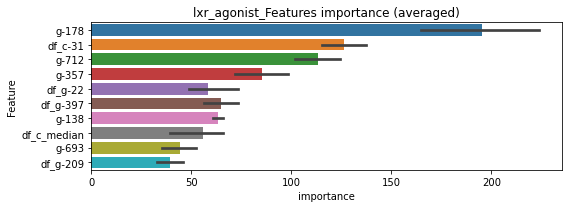

len(train_index) : 3897
len(valid_index) : 3898
================================= fold 1/2 lxr_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.00859298	valid_1's binary_logloss: 0.0122522
[200]	training's binary_logloss: 0.000669149	valid_1's binary_logloss: 0.00454405
[300]	training's binary_logloss: 0.000165874	valid_1's binary_logloss: 0.00390492


len(train_index) : 3898
len(valid_index) : 3897


Early stopping, best iteration is:
[330]	training's binary_logloss: 0.000135144	valid_1's binary_logloss: 0.00384163


================================= fold 2/2 lxr_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.00890077	valid_1's binary_logloss: 0.0100602
[200]	training's binary_logloss: 0.000730477	valid_1's binary_logloss: 0.00225331
[300]	training's binary_logloss: 0.000179936	valid_1's binary_logloss: 0.00167434
Early stopping, best iteration is:
[349]	training's binary_logloss: 0.000132737	valid_1's binary_logloss: 0.00162683


lxr_agonist logloss: 0.0027343724978663706
mdm_inhibitor, len(trt): 31, len(othr): 3284, target_rate: 0.0013018 → Adj_target_rate: 0.0015554


neg labels: 3289 → selected neg labels: 3284


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0239945	valid_1's binary_logloss: 0.0379008
[200]	training's binary_logloss: 0.00303683	valid_1's binary_logloss: 0.0107617
[300]	training's binary_logloss: 0.000871451	valid_1's binary_logloss: 0.00564858
[400]	training's binary_logloss: 0.000457273	valid_1's binary_logloss: 0.00419786
[500]	training's binary_logloss: 0.000350896	valid_1's binary_logloss: 0.00377873
Early stopping, best iteration is:
[516]	training's binary_logloss: 0.000345622	valid_1's binary_logloss: 0.00374231
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0245397	valid_1's binary_logloss: 0.0355957
[200]	training's binary_logloss: 0.00312803	valid_1's binary_logloss: 0.00855416
[300]	training's binary_logloss: 0.000902381	valid_1's binary_logloss: 0.00410497
[400]	training's binary_logloss: 0.000473789	valid_1's binary_logloss: 0.00283222
[500]	training's binary_logloss:

1 / 3 AUC score:1.000
Threshold: 0.0038823, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → positive_corect_labels: 656/3808
p_label_rate: 0.0374184 Vs.target_rate: 0.00130, Num_p_label: 149.0, conf_0:0.00011, conf_1:0.00427
Num_p_label: 149.0, Expected: 5.2, Adj_threshold_1: 0.0038823
Num_p_label: 89.0, Expected: 5.2, Adj_threshold_2: 0.0088823
Num_p_label: 58.0, Expected: 5.2, Adj_threshold_3: 0.0138823
Num_p_label: 49.0, Expected: 5.2, Adj_threshold_4: 0.0188823
Num_p_label: 41.0, Expected: 5.2, Adj_threshold_5: 0.0238823
Num_p_label: 32.0, Expected: 5.2, Adj_threshold_6: 0.0288823
Num_p_label: 28.0, Expected: 5.2, Adj_threshold_7: 0.0338823
Num_p_label: 23.0, Expected: 5.2, Adj_threshold_8: 0.0388823
Num_p_label: 21.0, Expected: 5.2, Adj_threshold_9: 0.0438823
Num_p_label: 21.0, Expected: 5.2, Adj_threshold_10: 0.0488823
threshold: 0.0538823, positive p_label: 20.0/3982, p_label_rate: 0.0050226
positive y_label: 656.0/3808, y_label_rate: 0.1722689
================= Pseudo label

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0228492	valid_1's binary_logloss: 0.0313362
[200]	training's binary_logloss: 0.00266084	valid_1's binary_logloss: 0.00668851
[300]	training's binary_logloss: 0.000750164	valid_1's binary_logloss: 0.00317049
[400]	training's binary_logloss: 0.000400453	valid_1's binary_logloss: 0.00213985
[500]	training's binary_logloss: 0.000317989	valid_1's binary_logloss: 0.00183955
Early stopping, best iteration is:
[542]	training's binary_logloss: 0.000312498	valid_1's binary_logloss: 0.00181157
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0233772	valid_1's binary_logloss: 0.0312888
[200]	training's binary_logloss: 0.00273664	valid_1's binary_logloss: 0.00562378
[300]	training's binary_logloss: 0.000760187	valid_1's binary_logloss: 0.00225127
[400]	training's binary_logloss: 0.000405734	valid_1's binary_logloss: 0.00151228
[500]	training's binary_logloss

2 / 3 AUC score:1.000
Threshold: 0.0538823, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 11 → positive_corect_labels: 656.0/3797
p_label_rate: 0.0268709 Vs.target_rate: 0.00130, Num_p_label: 107.0, conf_0:0.00012, conf_1:0.05927
Num_p_label: 107.0, Expected: 5.2, Adj_threshold_1: 0.0538823
Num_p_label: 103.0, Expected: 5.2, Adj_threshold_2: 0.0588823
Num_p_label: 99.0, Expected: 5.2, Adj_threshold_3: 0.0638823
Num_p_label: 96.0, Expected: 5.2, Adj_threshold_4: 0.0688823
Num_p_label: 95.0, Expected: 5.2, Adj_threshold_5: 0.0738823
Num_p_label: 93.0, Expected: 5.2, Adj_threshold_6: 0.0788823
Num_p_label: 87.0, Expected: 5.2, Adj_threshold_7: 0.0838823
Num_p_label: 87.0, Expected: 5.2, Adj_threshold_8: 0.0888823
Num_p_label: 84.0, Expected: 5.2, Adj_threshold_9: 0.0938823
Num_p_label: 81.0, Expected: 5.2, Adj_threshold_10: 0.0988823
threshold: 0.1038823, positive p_label: 78.0/3982, p_label_rate: 0.0195881
positive y_label: 656.0/3797, y_label_rate: 0.1727680
================= Pseudo lab

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0226749	valid_1's binary_logloss: 0.030309
[200]	training's binary_logloss: 0.0026046	valid_1's binary_logloss: 0.00604914
[300]	training's binary_logloss: 0.000741974	valid_1's binary_logloss: 0.00282858
[400]	training's binary_logloss: 0.000398723	valid_1's binary_logloss: 0.00191588
[500]	training's binary_logloss: 0.000313597	valid_1's binary_logloss: 0.00166861
Early stopping, best iteration is:
[554]	training's binary_logloss: 0.000304525	valid_1's binary_logloss: 0.00163289
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0228093	valid_1's binary_logloss: 0.0305499
[200]	training's binary_logloss: 0.00264301	valid_1's binary_logloss: 0.00570459
[300]	training's binary_logloss: 0.000734675	valid_1's binary_logloss: 0.00243736
[400]	training's binary_logloss: 0.000391108	valid_1's binary_logloss: 0.00162295
[500]	training's binary_logloss: 

3 / 3 AUC score:1.000
Threshold: 0.1038823, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 5 → positive_corect_labels: 656.0/3792
p_label_rate: 0.0238574 Vs.target_rate: 0.00130, Num_p_label: 95.0, conf_0:0.00012, conf_1:0.11427
Num_p_label: 95.0, Expected: 5.2, Adj_threshold_1: 0.1038823
Num_p_label: 95.0, Expected: 5.2, Adj_threshold_2: 0.1088823
Num_p_label: 94.0, Expected: 5.2, Adj_threshold_3: 0.1138823
Num_p_label: 92.0, Expected: 5.2, Adj_threshold_4: 0.1188823
Num_p_label: 91.0, Expected: 5.2, Adj_threshold_5: 0.1238823
Num_p_label: 88.0, Expected: 5.2, Adj_threshold_6: 0.1288823
Num_p_label: 87.0, Expected: 5.2, Adj_threshold_7: 0.1338823
Num_p_label: 86.0, Expected: 5.2, Adj_threshold_8: 0.1388823
Num_p_label: 84.0, Expected: 5.2, Adj_threshold_9: 0.1438823
Num_p_label: 82.0, Expected: 5.2, Adj_threshold_10: 0.1488823
threshold: 0.1538823, positive p_label: 82.0/3982, p_label_rate: 0.0205927
positive y_label: 738.0/7774, y_label_rate: 0.0949318


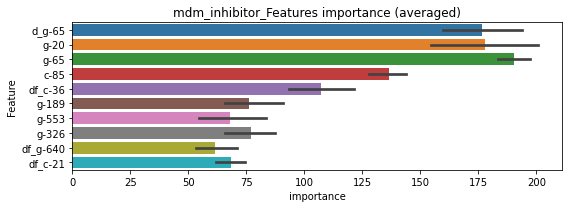

len(train_index) : 3887
len(valid_index) : 3887
================================= fold 1/2 mdm_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0150489	valid_1's binary_logloss: 0.0278145
[200]	training's binary_logloss: 0.00200732	valid_1's binary_logloss: 0.0121861
[300]	training's binary_logloss: 0.000579187	valid_1's binary_logloss: 0.00909902
[400]	training's binary_logloss: 0.000300851	valid_1's binary_logloss: 0.00832521
Early stopping, best iteration is:
[405]	training's binary_logloss: 0.000294867	valid_1's binary_logloss: 0.00830721


len(train_index) : 3887
len(valid_index) : 3887
================================= fold 2/2 mdm_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0152036	valid_1's binary_logloss: 0.0287964
[200]	training's binary_logloss: 0.00199337	valid_1's binary_logloss: 0.0118609
[300]	training's binary_logloss: 0.000554453	valid_1's binary_logloss: 0.00959378
Early stopping, best iteration is:
[330]	training's binary_logloss: 0.000435137	valid_1's binary_logloss: 0.00940782


mdm_inhibitor logloss: 0.00885751382670102
mek_inhibitor, len(trt): 72, len(othr): 3278, target_rate: 0.0030234 → Adj_target_rate: 0.0031837


neg labels: 3289 → selected neg labels: 3278


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0296729	valid_1's binary_logloss: 0.0548787
[200]	training's binary_logloss: 0.00422356	valid_1's binary_logloss: 0.0268527
[300]	training's binary_logloss: 0.00120362	valid_1's binary_logloss: 0.0215756
[400]	training's binary_logloss: 0.000598896	valid_1's binary_logloss: 0.0201926
Early stopping, best iteration is:
[393]	training's binary_logloss: 0.000618751	valid_1's binary_logloss: 0.0201183
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0308273	valid_1's binary_logloss: 0.0575977
[200]	training's binary_logloss: 0.00431145	valid_1's binary_logloss: 0.0220998
[300]	training's binary_logloss: 0.00125274	valid_1's binary_logloss: 0.015276
[400]	training's binary_logloss: 0.000614641	valid_1's binary_logloss: 0.0130617
[500]	training's binary_logloss: 0.000431592	valid_1's binary_logloss: 0.0119744
Early stopping, best iteration is:
[490]	t

1 / 3 AUC score:1.000
Threshold: 0.0031348, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 134 → positive_corect_labels: 654/3799
p_label_rate: 0.0474636 Vs.target_rate: 0.00302, Num_p_label: 189.0, conf_0:0.00036, conf_1:0.00345
Num_p_label: 189.0, Expected: 12.0, Adj_threshold_1: 0.0031348
Num_p_label: 85.0, Expected: 12.0, Adj_threshold_2: 0.0081348
Num_p_label: 64.0, Expected: 12.0, Adj_threshold_3: 0.0131348
Num_p_label: 53.0, Expected: 12.0, Adj_threshold_4: 0.0181348
Num_p_label: 45.0, Expected: 12.0, Adj_threshold_5: 0.0231348
Num_p_label: 40.0, Expected: 12.0, Adj_threshold_6: 0.0281348
Num_p_label: 36.0, Expected: 12.0, Adj_threshold_7: 0.0331348
Num_p_label: 33.0, Expected: 12.0, Adj_threshold_8: 0.0381348
Num_p_label: 30.0, Expected: 12.0, Adj_threshold_9: 0.0431348
Num_p_label: 28.0, Expected: 12.0, Adj_threshold_10: 0.0481348
threshold: 0.0531348, positive p_label: 28.0/3982, p_label_rate: 0.0070316
positive y_label: 654.0/3799, y_label_rate: 0.1721506
================= Ps

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.029413	valid_1's binary_logloss: 0.0451968
[200]	training's binary_logloss: 0.00394647	valid_1's binary_logloss: 0.0128985
[300]	training's binary_logloss: 0.00108345	valid_1's binary_logloss: 0.00719961
[400]	training's binary_logloss: 0.000543082	valid_1's binary_logloss: 0.00569377
Early stopping, best iteration is:
[425]	training's binary_logloss: 0.000484995	valid_1's binary_logloss: 0.00554992
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0293705	valid_1's binary_logloss: 0.0547197
[200]	training's binary_logloss: 0.0038978	valid_1's binary_logloss: 0.0224466
[300]	training's binary_logloss: 0.00108137	valid_1's binary_logloss: 0.016735


2 / 3 AUC score:1.000
Threshold: 0.0531348, pos_neg_ratio: 0.8000000


Early stopping, best iteration is:
[310]	training's binary_logloss: 0.000990408	valid_1's binary_logloss: 0.0165569


Remove_noisy_labels: 4 → positive_corect_labels: 652.0/3795
p_label_rate: 0.0158212 Vs.target_rate: 0.00302, Num_p_label: 63.0, conf_0:0.00058, conf_1:0.05845
Num_p_label: 63.0, Expected: 12.0, Adj_threshold_1: 0.0531348
Num_p_label: 61.0, Expected: 12.0, Adj_threshold_2: 0.0581348
Num_p_label: 56.0, Expected: 12.0, Adj_threshold_3: 0.0631348
Num_p_label: 54.0, Expected: 12.0, Adj_threshold_4: 0.0681348
Num_p_label: 52.0, Expected: 12.0, Adj_threshold_5: 0.0731348
Num_p_label: 52.0, Expected: 12.0, Adj_threshold_6: 0.0781348
Num_p_label: 52.0, Expected: 12.0, Adj_threshold_7: 0.0831348
Num_p_label: 52.0, Expected: 12.0, Adj_threshold_8: 0.0881348
Num_p_label: 52.0, Expected: 12.0, Adj_threshold_9: 0.0931348
Num_p_label: 52.0, Expected: 12.0, Adj_threshold_10: 0.0981348
threshold: 0.1031348, positive p_label: 51.0/3982, p_label_rate: 0.0128076
positive y_label: 652.0/3795, y_label_rate: 0.1718050
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0292906	valid_1's binary_logloss: 0.0455949
[200]	training's binary_logloss: 0.00383392	valid_1's binary_logloss: 0.0135781
[300]	training's binary_logloss: 0.00106493	valid_1's binary_logloss: 0.00800242
[400]	training's binary_logloss: 0.00053902	valid_1's binary_logloss: 0.00654333
[500]	training's binary_logloss: 0.000387162	valid_1's binary_logloss: 0.00605705
Early stopping, best iteration is:
[509]	training's binary_logloss: 0.000382594	valid_1's binary_logloss: 0.00603303
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0282087	valid_1's binary_logloss: 0.0599598
[200]	training's binary_logloss: 0.00360551	valid_1's binary_logloss: 0.0287676
[300]	training's binary_logloss: 0.00101921	valid_1's binary_logloss: 0.0217682
[400]	training's binary_logloss: 0.000512699	valid_1's binary_logloss: 0.0188834
Early stopping, best iteration is:
[44

3 / 3 AUC score:1.000
Threshold: 0.1031348, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 7 → positive_corect_labels: 646.0/3788
p_label_rate: 0.0123054 Vs.target_rate: 0.00302, Num_p_label: 49.0, conf_0:0.00033, conf_1:0.11345
Num_p_label: 49.0, Expected: 12.0, Adj_threshold_1: 0.1031348
Num_p_label: 47.0, Expected: 12.0, Adj_threshold_2: 0.1081348
Num_p_label: 47.0, Expected: 12.0, Adj_threshold_3: 0.1131348
Num_p_label: 46.0, Expected: 12.0, Adj_threshold_4: 0.1181348
Num_p_label: 45.0, Expected: 12.0, Adj_threshold_5: 0.1231348
Num_p_label: 45.0, Expected: 12.0, Adj_threshold_6: 0.1281348
Num_p_label: 45.0, Expected: 12.0, Adj_threshold_7: 0.1331348
Num_p_label: 44.0, Expected: 12.0, Adj_threshold_8: 0.1381348
Num_p_label: 44.0, Expected: 12.0, Adj_threshold_9: 0.1431348
Num_p_label: 44.0, Expected: 12.0, Adj_threshold_10: 0.1481348
threshold: 0.1531348, positive p_label: 44.0/3982, p_label_rate: 0.0110497
positive y_label: 690.0/7770, y_label_rate: 0.0888031


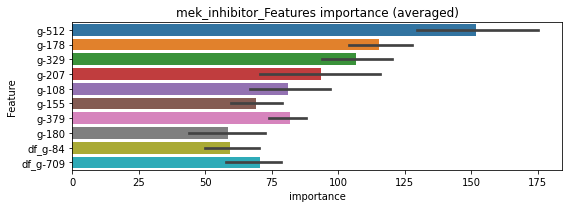

len(train_index) : 3885
len(valid_index) : 3885
================================= fold 1/2 mek_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0151033	valid_1's binary_logloss: 0.0340642
[200]	training's binary_logloss: 0.00193839	valid_1's binary_logloss: 0.0173408
[300]	training's binary_logloss: 0.000545033	valid_1's binary_logloss: 0.0139237
Early stopping, best iteration is:
[308]	training's binary_logloss: 0.000510272	valid_1's binary_logloss: 0.0138417


len(train_index) : 3885
len(valid_index) : 3885
================================= fold 2/2 mek_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0150119	valid_1's binary_logloss: 0.0244201
[200]	training's binary_logloss: 0.0019069	valid_1's binary_logloss: 0.00882781
[300]	training's binary_logloss: 0.000541617	valid_1's binary_logloss: 0.00618936
[400]	training's binary_logloss: 0.000276975	valid_1's binary_logloss: 0.00551086
Early stopping, best iteration is:
[413]	training's binary_logloss: 0.000261093	valid_1's binary_logloss: 0.00544614


mek_inhibitor logloss: 0.009643922214177215
membrane_integrity_inhibitor, len(trt): 74, len(othr): 3278, target_rate: 0.0031074 → Adj_target_rate: 0.0032587


neg labels: 3289 → selected neg labels: 3278


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0564961	valid_1's binary_logloss: 0.111211
[200]	training's binary_logloss: 0.0124432	valid_1's binary_logloss: 0.0634662
[300]	training's binary_logloss: 0.00369979	valid_1's binary_logloss: 0.0512443
Early stopping, best iteration is:
[339]	training's binary_logloss: 0.00259874	valid_1's binary_logloss: 0.0492582
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.059036	valid_1's binary_logloss: 0.104367
[200]	training's binary_logloss: 0.0131985	valid_1's binary_logloss: 0.0498993
[300]	training's binary_logloss: 0.00383518	valid_1's binary_logloss: 0.033318
[400]	training's binary_logloss: 0.0016918	valid_1's binary_logloss: 0.0285897
Early stopping, best iteration is:
[487]	training's binary_logloss: 0.00106931	valid_1's binary_logloss: 0.0269602


1 / 3 AUC score:0.997
Threshold: 0.0156470, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 152 → positive_corect_labels: 645/3781
p_label_rate: 0.0371673 Vs.target_rate: 0.00311, Num_p_label: 148.0, conf_0:0.00210, conf_1:0.01721
Num_p_label: 148.0, Expected: 12.4, Adj_threshold_1: 0.0156470
Num_p_label: 98.0, Expected: 12.4, Adj_threshold_2: 0.0206470
Num_p_label: 78.0, Expected: 12.4, Adj_threshold_3: 0.0256470
Num_p_label: 55.0, Expected: 12.4, Adj_threshold_4: 0.0306470
Num_p_label: 40.0, Expected: 12.4, Adj_threshold_5: 0.0356470
Num_p_label: 30.0, Expected: 12.4, Adj_threshold_6: 0.0406470
Num_p_label: 24.0, Expected: 12.4, Adj_threshold_7: 0.0456470
threshold: 0.0456470, positive p_label: 24.0/3982, p_label_rate: 0.0060271
positive y_label: 645.0/3781, y_label_rate: 0.1705898
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0556849	valid_1's binary_logloss: 0.102209
[200]	training's binary_logloss: 0.0112011	valid_1's binary_logloss: 0.0493879
[300]	training's binary_logloss: 0.00340164	valid_1's binary_logloss: 0.0362714
[400]	training's binary_logloss: 0.00155109	valid_1's binary_logloss: 0.033122
Early stopping, best iteration is:
[421]	training's binary_logloss: 0.00137913	valid_1's binary_logloss: 0.0327714
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0578987	valid_1's binary_logloss: 0.100543
[200]	training's binary_logloss: 0.0122619	valid_1's binary_logloss: 0.0459616
[300]	training's binary_logloss: 0.00363213	valid_1's binary_logloss: 0.0318189
[400]	training's binary_logloss: 0.00164251	valid_1's binary_logloss: 0.0283758
Early stopping, best iteration is:
[487]	training's binary_logloss: 0.0010437	valid_1's binary_logloss: 0.027187


2 / 3 AUC score:0.999
Threshold: 0.0456470, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 16 → positive_corect_labels: 638.0/3765
p_label_rate: 0.0100452 Vs.target_rate: 0.00311, Num_p_label: 40.0, conf_0:0.00156, conf_1:0.05021
Num_p_label: 40.0, Expected: 12.4, Adj_threshold_1: 0.0456470
Num_p_label: 33.0, Expected: 12.4, Adj_threshold_2: 0.0506470
Num_p_label: 29.0, Expected: 12.4, Adj_threshold_3: 0.0556470
Num_p_label: 24.0, Expected: 12.4, Adj_threshold_4: 0.0606470
threshold: 0.0606470, positive p_label: 24.0/3982, p_label_rate: 0.0060271
positive y_label: 638.0/3765, y_label_rate: 0.1694555
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0532903	valid_1's binary_logloss: 0.10463
[200]	training's binary_logloss: 0.0108814	valid_1's binary_logloss: 0.0540193
[300]	training's binary_logloss: 0.00320681	valid_1's binary_logloss: 0.042506
Early stopping, best iteration is:
[334]	training's binary_logloss: 0.00234557	valid_1's binary_logloss: 0.0404907
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0546253	valid_1's binary_logloss: 0.0972695
[200]	training's binary_logloss: 0.0114522	valid_1's binary_logloss: 0.0451845
[300]	training's binary_logloss: 0.00337809	valid_1's binary_logloss: 0.0300465
[400]	training's binary_logloss: 0.00153495	valid_1's binary_logloss: 0.0249439
Early stopping, best iteration is:
[489]	training's binary_logloss: 0.000978467	valid_1's binary_logloss: 0.0227783


3 / 3 AUC score:0.999
Threshold: 0.0606470, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 8 → positive_corect_labels: 631.0/3757
p_label_rate: 0.0095429 Vs.target_rate: 0.00311, Num_p_label: 38.0, conf_0:0.00197, conf_1:0.06671
Num_p_label: 38.0, Expected: 12.4, Adj_threshold_1: 0.0606470
Num_p_label: 30.0, Expected: 12.4, Adj_threshold_2: 0.0656470
Num_p_label: 21.0, Expected: 12.4, Adj_threshold_3: 0.0706470
threshold: 0.0706470, positive p_label: 21.0/3982, p_label_rate: 0.0052737
positive y_label: 652.0/7739, y_label_rate: 0.0842486


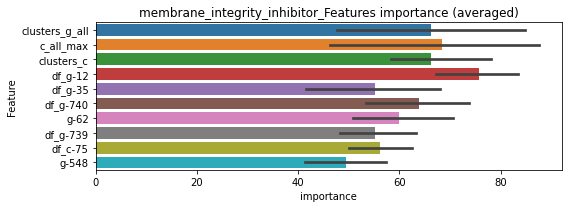

len(train_index) : 3869
len(valid_index) : 3870
================================= fold 1/2 membrane_integrity_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0314481	valid_1's binary_logloss: 0.0614955
[200]	training's binary_logloss: 0.00678549	valid_1's binary_logloss: 0.0336144
[300]	training's binary_logloss: 0.00193989	valid_1's binary_logloss: 0.0266698
Early stopping, best iteration is:
[377]	training's binary_logloss: 0.00099796	valid_1's binary_logloss: 0.0251869


len(train_index) : 3870
len(valid_index) : 3869
================================= fold 2/2 membrane_integrity_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0339035	valid_1's binary_logloss: 0.0590303
[200]	training's binary_logloss: 0.00733792	valid_1's binary_logloss: 0.0287983
[300]	training's binary_logloss: 0.00211731	valid_1's binary_logloss: 0.0213726
Early stopping, best iteration is:
[329]	training's binary_logloss: 0.0015706	valid_1's binary_logloss: 0.0207529


membrane_integrity_inhibitor logloss: 0.022970226516515122


  acetylcholine_receptor_agonist acetylcholine_receptor_antagonist  \
0                       df_g-122                              c-30   
1                  clusters_df_c                         c_all_max   
2                          cnt_0                    clusters_g_all   
3                      c_all_min                          df_g-707   
4                        df_g-51                        clusters_g   
5                       df_c_min                          df_c_min   
6                          cnt_2                             g-514   
7                       df_g-736                          df_g-640   
8                          g-244                            df_c-6   
9                           c-73                          df_g-597   

  acetylcholinesterase_inhibitor adenosine_receptor_antagonist  \
0                      c_all_max                clusters_c_all   
1                      c_all_min                      df_c_min   
2                 clusters_g_al

mineralocorticoid_receptor_antagonist, len(trt): 25, len(othr): 3285, target_rate: 0.0010498 → Adj_target_rate: 0.0012955


neg labels: 3289 → selected neg labels: 3285


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0296409	valid_1's binary_logloss: 0.0466789
[200]	training's binary_logloss: 0.00403327	valid_1's binary_logloss: 0.0117229
[300]	training's binary_logloss: 0.0011315	valid_1's binary_logloss: 0.00600625
[400]	training's binary_logloss: 0.000568466	valid_1's binary_logloss: 0.00436601
[500]	training's binary_logloss: 0.000407441	valid_1's binary_logloss: 0.00378044
Early stopping, best iteration is:
[495]	training's binary_logloss: 0.000410161	valid_1's binary_logloss: 0.00377305
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0306569	valid_1's binary_logloss: 0.0403811
[200]	training's binary_logloss: 0.00427548	valid_1's binary_logloss: 0.00881214
[300]	training's binary_logloss: 0.00119012	valid_1's binary_logloss: 0.00352092
[400]	training's binary_logloss: 0.000594359	valid_1's binary_logloss: 0.00223257
[500]	training's binary_logloss: 0.

1 / 3 AUC score:1.000
Threshold: 0.0022470, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → positive_corect_labels: 657/3810
p_label_rate: 0.0429432 Vs.target_rate: 0.00105, Num_p_label: 171.0, conf_0:0.00032, conf_1:0.00247
Num_p_label: 171.0, Expected: 4.2, Adj_threshold_1: 0.0022470
Num_p_label: 39.0, Expected: 4.2, Adj_threshold_2: 0.0072470
Num_p_label: 18.0, Expected: 4.2, Adj_threshold_3: 0.0122470
Num_p_label: 12.0, Expected: 4.2, Adj_threshold_4: 0.0172470
Num_p_label: 8.0, Expected: 4.2, Adj_threshold_5: 0.0222470
threshold: 0.0222470, positive p_label: 8.0/3982, p_label_rate: 0.0020090
positive y_label: 657.0/3810, y_label_rate: 0.1724409
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0296111	valid_1's binary_logloss: 0.045783
[200]	training's binary_logloss: 0.00392144	valid_1's binary_logloss: 0.0115972
[300]	training's binary_logloss: 0.00108497	valid_1's binary_logloss: 0.00587828
[400]	training's binary_logloss: 0.000553243	valid_1's binary_logloss: 0.00412572
[500]	training's binary_logloss: 0.000403004	valid_1's binary_logloss: 0.00359142
Early stopping, best iteration is:
[497]	training's binary_logloss: 0.000405032	valid_1's binary_logloss: 0.00358639
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0298423	valid_1's binary_logloss: 0.0394436
[200]	training's binary_logloss: 0.00409053	valid_1's binary_logloss: 0.00847959
[300]	training's binary_logloss: 0.0011302	valid_1's binary_logloss: 0.00322009
[400]	training's binary_logloss: 0.000572571	valid_1's binary_logloss: 0.00208493
[500]	training's binary_logloss: 0.0

2 / 3 AUC score:1.000
Threshold: 0.0222470, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → positive_corect_labels: 657.0/3810
p_label_rate: 0.0067805 Vs.target_rate: 0.00105, Num_p_label: 27.0, conf_0:0.00036, conf_1:0.02447
Num_p_label: 27.0, Expected: 4.2, Adj_threshold_1: 0.0222470
Num_p_label: 26.0, Expected: 4.2, Adj_threshold_2: 0.0272470
Num_p_label: 19.0, Expected: 4.2, Adj_threshold_3: 0.0322470
Num_p_label: 14.0, Expected: 4.2, Adj_threshold_4: 0.0372470
Num_p_label: 11.0, Expected: 4.2, Adj_threshold_5: 0.0422470
Num_p_label: 9.0, Expected: 4.2, Adj_threshold_6: 0.0472470
Num_p_label: 9.0, Expected: 4.2, Adj_threshold_7: 0.0522470
Num_p_label: 9.0, Expected: 4.2, Adj_threshold_8: 0.0572470
Num_p_label: 6.0, Expected: 4.2, Adj_threshold_9: 0.0622470
threshold: 0.0622470, positive p_label: 6.0/3982, p_label_rate: 0.0015068
positive y_label: 657.0/3810, y_label_rate: 0.1724409
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0296111	valid_1's binary_logloss: 0.045783
[200]	training's binary_logloss: 0.00392144	valid_1's binary_logloss: 0.0115972
[300]	training's binary_logloss: 0.00108497	valid_1's binary_logloss: 0.00587828
[400]	training's binary_logloss: 0.000553243	valid_1's binary_logloss: 0.00412572
[500]	training's binary_logloss: 0.000403004	valid_1's binary_logloss: 0.00359142
Early stopping, best iteration is:
[497]	training's binary_logloss: 0.000405032	valid_1's binary_logloss: 0.00358639
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0298423	valid_1's binary_logloss: 0.0394436
[200]	training's binary_logloss: 0.00409053	valid_1's binary_logloss: 0.00847959
[300]	training's binary_logloss: 0.0011302	valid_1's binary_logloss: 0.00322009
[400]	training's binary_logloss: 0.000572571	valid_1's binary_logloss: 0.00208493
[500]	training's binary_logloss: 0.0

3 / 3 AUC score:1.000
Threshold: 0.0622470, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → positive_corect_labels: 657.0/3810
p_label_rate: 0.0015068 Vs.target_rate: 0.00105, Num_p_label: 6.0, conf_0:0.00036, conf_1:0.06847
threshold: 0.0622470, positive p_label: 6.0/3982, p_label_rate: 0.0015068
positive y_label: 663.0/7792, y_label_rate: 0.0850873


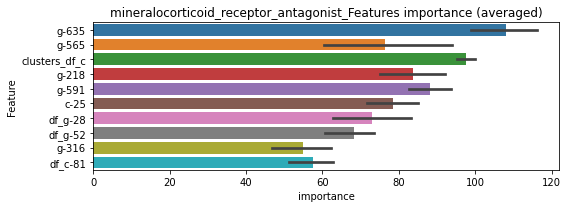

len(train_index) : 3896
len(valid_index) : 3896
================================= fold 1/2 mineralocorticoid_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0164222	valid_1's binary_logloss: 0.0261975
[200]	training's binary_logloss: 0.0022701	valid_1's binary_logloss: 0.00875286
[300]	training's binary_logloss: 0.000606691	valid_1's binary_logloss: 0.00654291
Early stopping, best iteration is:
[329]	training's binary_logloss: 0.000469258	valid_1's binary_logloss: 0.00639825


len(train_index) : 3896
len(valid_index) : 3896
================================= fold 2/2 mineralocorticoid_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0168794	valid_1's binary_logloss: 0.0227453
[200]	training's binary_logloss: 0.00248984	valid_1's binary_logloss: 0.00578631
[300]	training's binary_logloss: 0.000729222	valid_1's binary_logloss: 0.00323423
[400]	training's binary_logloss: 0.000367352	valid_1's binary_logloss: 0.00271919
[500]	training's binary_logloss: 0.000226201	valid_1's binary_logloss: 0.00251167
Early stopping, best iteration is:
[557]	training's binary_logloss: 0.000193003	valid_1's binary_logloss: 0.00243268


mineralocorticoid_receptor_antagonist logloss: 0.004415465137549029
monoacylglycerol_lipase_inhibitor, len(trt): 12, len(othr): 3287, target_rate: 0.0005039 → Adj_target_rate: 0.0006942


neg labels: 3289 → selected neg labels: 3287


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0192344	valid_1's binary_logloss: 0.0250372
[200]	training's binary_logloss: 0.00203392	valid_1's binary_logloss: 0.00495131
[300]	training's binary_logloss: 0.000583027	valid_1's binary_logloss: 0.00245104
[400]	training's binary_logloss: 0.000326052	valid_1's binary_logloss: 0.00181926
Early stopping, best iteration is:
[485]	training's binary_logloss: 0.000279037	valid_1's binary_logloss: 0.00168904
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.019308	valid_1's binary_logloss: 0.0229543
[200]	training's binary_logloss: 0.00202881	valid_1's binary_logloss: 0.00338367
[300]	training's binary_logloss: 0.000583476	valid_1's binary_logloss: 0.00139611
[400]	training's binary_logloss: 0.000327496	valid_1's binary_logloss: 0.000924602
Early stopping, best iteration is:
[487]	training's binary_logloss: 0.0002871	valid_1's binary_logloss: 0.0008434

1 / 3 AUC score:1.000
Threshold: 0.0010423, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → positive_corect_labels: 657/3812
p_label_rate: 0.0399297 Vs.target_rate: 0.00050, Num_p_label: 159.0, conf_0:0.00018, conf_1:0.00115
Num_p_label: 159.0, Expected: 2.0, Adj_threshold_1: 0.0010423
Num_p_label: 15.0, Expected: 2.0, Adj_threshold_2: 0.0060423
Num_p_label: 8.0, Expected: 2.0, Adj_threshold_3: 0.0110423
Num_p_label: 3.0, Expected: 2.0, Adj_threshold_4: 0.0160423
threshold: 0.0160423, positive p_label: 3.0/3982, p_label_rate: 0.0007534
positive y_label: 657.0/3812, y_label_rate: 0.1723505
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0193422	valid_1's binary_logloss: 0.0254962
[200]	training's binary_logloss: 0.0019825	valid_1's binary_logloss: 0.00476758
[300]	training's binary_logloss: 0.000564997	valid_1's binary_logloss: 0.00216285
[400]	training's binary_logloss: 0.000323684	valid_1's binary_logloss: 0.00162329
Early stopping, best iteration is:
[478]	training's binary_logloss: 0.000278617	valid_1's binary_logloss: 0.0015016
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0193594	valid_1's binary_logloss: 0.0225713
[200]	training's binary_logloss: 0.00198093	valid_1's binary_logloss: 0.00326859
[300]	training's binary_logloss: 0.000566757	valid_1's binary_logloss: 0.0013086
[400]	training's binary_logloss: 0.000320079	valid_1's binary_logloss: 0.000903058
Early stopping, best iteration is:
[480]	training's binary_logloss: 0.00027558	valid_1's binary_logloss: 0.00083264

2 / 3 AUC score:1.000
Threshold: 0.0160423, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → positive_corect_labels: 657.0/3812
p_label_rate: 0.0040181 Vs.target_rate: 0.00050, Num_p_label: 16.0, conf_0:0.00021, conf_1:0.01765
Num_p_label: 16.0, Expected: 2.0, Adj_threshold_1: 0.0160423
Num_p_label: 12.0, Expected: 2.0, Adj_threshold_2: 0.0210423
Num_p_label: 10.0, Expected: 2.0, Adj_threshold_3: 0.0260423
Num_p_label: 9.0, Expected: 2.0, Adj_threshold_4: 0.0310423
Num_p_label: 8.0, Expected: 2.0, Adj_threshold_5: 0.0360423
Num_p_label: 7.0, Expected: 2.0, Adj_threshold_6: 0.0410423
Num_p_label: 6.0, Expected: 2.0, Adj_threshold_7: 0.0460423
Num_p_label: 5.0, Expected: 2.0, Adj_threshold_8: 0.0510423
Num_p_label: 5.0, Expected: 2.0, Adj_threshold_9: 0.0560423
Num_p_label: 4.0, Expected: 2.0, Adj_threshold_10: 0.0610423
threshold: 0.0610423, positive p_label: 4.0/3982, p_label_rate: 0.0010045
positive y_label: 657.0/3812, y_label_rate: 0.1723505
================= Pseudo labeling 3 / 3 

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0193422	valid_1's binary_logloss: 0.0254962
[200]	training's binary_logloss: 0.0019825	valid_1's binary_logloss: 0.00476758
[300]	training's binary_logloss: 0.000564997	valid_1's binary_logloss: 0.00216285
[400]	training's binary_logloss: 0.000323684	valid_1's binary_logloss: 0.00162329
Early stopping, best iteration is:
[478]	training's binary_logloss: 0.000278617	valid_1's binary_logloss: 0.0015016
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0193594	valid_1's binary_logloss: 0.0225713
[200]	training's binary_logloss: 0.00198093	valid_1's binary_logloss: 0.00326859
[300]	training's binary_logloss: 0.000566757	valid_1's binary_logloss: 0.0013086
[400]	training's binary_logloss: 0.000320079	valid_1's binary_logloss: 0.000903058
Early stopping, best iteration is:
[480]	training's binary_logloss: 0.00027558	valid_1's binary_logloss: 0.00083264

3 / 3 AUC score:1.000
Threshold: 0.0610423, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → positive_corect_labels: 657.0/3812
p_label_rate: 0.0010045 Vs.target_rate: 0.00050, Num_p_label: 4.0, conf_0:0.00021, conf_1:0.06715
threshold: 0.0610423, positive p_label: 4.0/3982, p_label_rate: 0.0010045
positive y_label: 661.0/7794, y_label_rate: 0.0848088


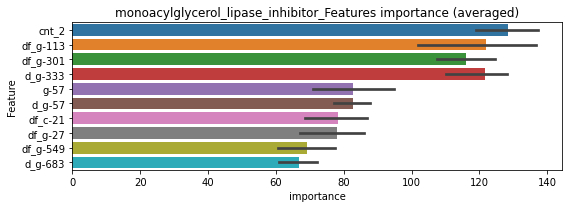

len(train_index) : 3897
len(valid_index) : 3897
================================= fold 1/2 monoacylglycerol_lipase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.010338	valid_1's binary_logloss: 0.015137
[200]	training's binary_logloss: 0.00104136	valid_1's binary_logloss: 0.00392272
[300]	training's binary_logloss: 0.000291953	valid_1's binary_logloss: 0.00305455
Early stopping, best iteration is:
[294]	training's binary_logloss: 0.000307615	valid_1's binary_logloss: 0.00304895


len(train_index) : 3897
len(valid_index) : 3897
================================= fold 2/2 monoacylglycerol_lipase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0102875	valid_1's binary_logloss: 0.0123374
[200]	training's binary_logloss: 0.00105976	valid_1's binary_logloss: 0.00231008
[300]	training's binary_logloss: 0.000298219	valid_1's binary_logloss: 0.00135768
[400]	training's binary_logloss: 0.000165974	valid_1's binary_logloss: 0.00121264
Early stopping, best iteration is:
[408]	training's binary_logloss: 0.000161951	valid_1's binary_logloss: 0.00119939


monoacylglycerol_lipase_inhibitor logloss: 0.002124170751094295
monoamine_oxidase_inhibitor, len(trt): 85, len(othr): 3274, target_rate: 0.0035693 → Adj_target_rate: 0.0036661


neg labels: 3289 → selected neg labels: 3274


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0574997	valid_1's binary_logloss: 0.12128
[200]	training's binary_logloss: 0.0141254	valid_1's binary_logloss: 0.0715445
[300]	training's binary_logloss: 0.0042637	valid_1's binary_logloss: 0.0543327
Early stopping, best iteration is:
[387]	training's binary_logloss: 0.00205416	valid_1's binary_logloss: 0.0488372
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0617947	valid_1's binary_logloss: 0.112492
[200]	training's binary_logloss: 0.0157204	valid_1's binary_logloss: 0.058739
[300]	training's binary_logloss: 0.00484661	valid_1's binary_logloss: 0.0402235
[400]	training's binary_logloss: 0.00212751	valid_1's binary_logloss: 0.0336927
[500]	training's binary_logloss: 0.00125758	valid_1's binary_logloss: 0.0312031
Early stopping, best iteration is:
[510]	training's binary_logloss: 0.00120693	valid_1's binary_logloss: 0.0309437


1 / 3 AUC score:0.997
Threshold: 0.0132995, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 142 → positive_corect_labels: 649/3786
p_label_rate: 0.0283777 Vs.target_rate: 0.00357, Num_p_label: 113.0, conf_0:0.00217, conf_1:0.01463
Num_p_label: 113.0, Expected: 14.2, Adj_threshold_1: 0.0132995
Num_p_label: 64.0, Expected: 14.2, Adj_threshold_2: 0.0182995
Num_p_label: 39.0, Expected: 14.2, Adj_threshold_3: 0.0232995
Num_p_label: 24.0, Expected: 14.2, Adj_threshold_4: 0.0282995
threshold: 0.0282995, positive p_label: 24.0/3982, p_label_rate: 0.0060271
positive y_label: 649.0/3786, y_label_rate: 0.1714210
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0590025	valid_1's binary_logloss: 0.11324
[200]	training's binary_logloss: 0.0134684	valid_1's binary_logloss: 0.0591032
[300]	training's binary_logloss: 0.00413069	valid_1's binary_logloss: 0.0427796
[400]	training's binary_logloss: 0.00188227	valid_1's binary_logloss: 0.0369354
[500]	training's binary_logloss: 0.00113831	valid_1's binary_logloss: 0.0339498
Early stopping, best iteration is:
[500]	training's binary_logloss: 0.00113831	valid_1's binary_logloss: 0.0339498
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0596011	valid_1's binary_logloss: 0.130332
[200]	training's binary_logloss: 0.0131675	valid_1's binary_logloss: 0.0761873
[300]	training's binary_logloss: 0.00403041	valid_1's binary_logloss: 0.0617552
[400]	training's binary_logloss: 0.00183037	valid_1's binary_logloss: 0.0573884
Early stopping, best iteration is:
[440]	training'

2 / 3 AUC score:0.999
Threshold: 0.0282995, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 30 → positive_corect_labels: 643.0/3756
p_label_rate: 0.0125565 Vs.target_rate: 0.00357, Num_p_label: 50.0, conf_0:0.00196, conf_1:0.03113
Num_p_label: 50.0, Expected: 14.2, Adj_threshold_1: 0.0282995
Num_p_label: 36.0, Expected: 14.2, Adj_threshold_2: 0.0332995
Num_p_label: 30.0, Expected: 14.2, Adj_threshold_3: 0.0382995
Num_p_label: 23.0, Expected: 14.2, Adj_threshold_4: 0.0432995
threshold: 0.0432995, positive p_label: 23.0/3982, p_label_rate: 0.0057760
positive y_label: 643.0/3756, y_label_rate: 0.1711928
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0546945	valid_1's binary_logloss: 0.116554
[200]	training's binary_logloss: 0.0120856	valid_1's binary_logloss: 0.0666101
[300]	training's binary_logloss: 0.00368256	valid_1's binary_logloss: 0.0518474
[400]	training's binary_logloss: 0.00170419	valid_1's binary_logloss: 0.0475204
Early stopping, best iteration is:
[420]	training's binary_logloss: 0.00151399	valid_1's binary_logloss: 0.0466462
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0597431	valid_1's binary_logloss: 0.110622
[200]	training's binary_logloss: 0.0141121	valid_1's binary_logloss: 0.0590281
[300]	training's binary_logloss: 0.0043678	valid_1's binary_logloss: 0.0445942
[400]	training's binary_logloss: 0.00195219	valid_1's binary_logloss: 0.0393721
Early stopping, best iteration is:
[447]	training's binary_logloss: 0.00149571	valid_1's binary_logloss: 0.038529


3 / 3 AUC score:0.999
Threshold: 0.0432995, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 27 → positive_corect_labels: 632.0/3729
p_label_rate: 0.0082873 Vs.target_rate: 0.00357, Num_p_label: 33.0, conf_0:0.00218, conf_1:0.04763
threshold: 0.0432995, positive p_label: 33.0/3982, p_label_rate: 0.0082873
positive y_label: 665.0/7711, y_label_rate: 0.0862404


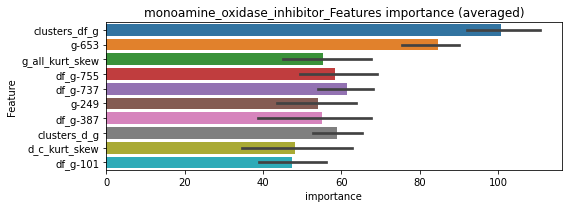

len(train_index) : 3855
len(valid_index) : 3856
================================= fold 1/2 monoamine_oxidase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0316241	valid_1's binary_logloss: 0.0803687
[200]	training's binary_logloss: 0.00708495	valid_1's binary_logloss: 0.0563071
[300]	training's binary_logloss: 0.0021929	valid_1's binary_logloss: 0.050915
Early stopping, best iteration is:
[345]	training's binary_logloss: 0.00147897	valid_1's binary_logloss: 0.0501148


len(train_index) : 3856
len(valid_index) : 3855
================================= fold 2/2 monoamine_oxidase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0330447	valid_1's binary_logloss: 0.0762229
[200]	training's binary_logloss: 0.0077068	valid_1's binary_logloss: 0.0473933
[300]	training's binary_logloss: 0.00235443	valid_1's binary_logloss: 0.0396524
Early stopping, best iteration is:
[318]	training's binary_logloss: 0.00197989	valid_1's binary_logloss: 0.0390183


monoamine_oxidase_inhibitor logloss: 0.044567266982284984


  acetylcholine_receptor_agonist acetylcholine_receptor_antagonist  \
0                       df_g-122                              c-30   
1                  clusters_df_c                         c_all_max   
2                          cnt_0                    clusters_g_all   
3                      c_all_min                          df_g-707   
4                        df_g-51                        clusters_g   
5                       df_c_min                          df_c_min   
6                          cnt_2                             g-514   
7                       df_g-736                          df_g-640   
8                          g-244                            df_c-6   
9                           c-73                          df_g-597   

  acetylcholinesterase_inhibitor adenosine_receptor_antagonist  \
0                      c_all_max                clusters_c_all   
1                      c_all_min                      df_c_min   
2                 clusters_g_al

monopolar_spindle_1_kinase_inhibitor, len(trt): 18, len(othr): 3286, target_rate: 0.0007559 → Adj_target_rate: 0.0009799


neg labels: 3289 → selected neg labels: 3286


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0215076	valid_1's binary_logloss: 0.0273903
[200]	training's binary_logloss: 0.0024309	valid_1's binary_logloss: 0.00429647
[300]	training's binary_logloss: 0.000696846	valid_1's binary_logloss: 0.00159438
[400]	training's binary_logloss: 0.000382625	valid_1's binary_logloss: 0.00101373
[500]	training's binary_logloss: 0.000308701	valid_1's binary_logloss: 0.000855094
Early stopping, best iteration is:
[575]	training's binary_logloss: 0.000298592	valid_1's binary_logloss: 0.000831981
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0216427	valid_1's binary_logloss: 0.0278212
[200]	training's binary_logloss: 0.00245437	valid_1's binary_logloss: 0.00455417
[300]	training's binary_logloss: 0.000702651	valid_1's binary_logloss: 0.00164732
[400]	training's binary_logloss: 0.000382859	valid_1's binary_logloss: 0.00100529
[500]	training's binary_loglos

1 / 3 AUC score:1.000
Threshold: 0.0015463, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → positive_corect_labels: 657/3811
p_label_rate: 0.0462079 Vs.target_rate: 0.00076, Num_p_label: 184.0, conf_0:0.00016, conf_1:0.00170
Num_p_label: 184.0, Expected: 3.0, Adj_threshold_1: 0.0015463
Num_p_label: 49.0, Expected: 3.0, Adj_threshold_2: 0.0065463
Num_p_label: 31.0, Expected: 3.0, Adj_threshold_3: 0.0115463
Num_p_label: 21.0, Expected: 3.0, Adj_threshold_4: 0.0165463
Num_p_label: 15.0, Expected: 3.0, Adj_threshold_5: 0.0215463
Num_p_label: 11.0, Expected: 3.0, Adj_threshold_6: 0.0265463
Num_p_label: 11.0, Expected: 3.0, Adj_threshold_7: 0.0315463
Num_p_label: 9.0, Expected: 3.0, Adj_threshold_8: 0.0365463
Num_p_label: 7.0, Expected: 3.0, Adj_threshold_9: 0.0415463
Num_p_label: 6.0, Expected: 3.0, Adj_threshold_10: 0.0465463
threshold: 0.0465463, positive p_label: 6.0/3982, p_label_rate: 0.0015068
positive y_label: 657.0/3811, y_label_rate: 0.1723957
================= Pseudo labeling 

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.021097	valid_1's binary_logloss: 0.0270357
[200]	training's binary_logloss: 0.00232582	valid_1's binary_logloss: 0.00432066
[300]	training's binary_logloss: 0.000663933	valid_1's binary_logloss: 0.00153547
[400]	training's binary_logloss: 0.000365696	valid_1's binary_logloss: 0.000951281
[500]	training's binary_logloss: 0.000303444	valid_1's binary_logloss: 0.00082142
[600]	training's binary_logloss: 0.000294847	valid_1's binary_logloss: 0.000806404
Early stopping, best iteration is:
[634]	training's binary_logloss: 0.000293207	valid_1's binary_logloss: 0.000803392
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0213754	valid_1's binary_logloss: 0.0257693
[200]	training's binary_logloss: 0.0023643	valid_1's binary_logloss: 0.00384527
[300]	training's binary_logloss: 0.000669999	valid_1's binary_logloss: 0.0013313
[400]	training's binary_logloss

2 / 3 AUC score:1.000
Threshold: 0.0465463, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → positive_corect_labels: 657.0/3811
p_label_rate: 0.0065294 Vs.target_rate: 0.00076, Num_p_label: 26.0, conf_0:0.00018, conf_1:0.05120
Num_p_label: 26.0, Expected: 3.0, Adj_threshold_1: 0.0465463
Num_p_label: 25.0, Expected: 3.0, Adj_threshold_2: 0.0515463
Num_p_label: 23.0, Expected: 3.0, Adj_threshold_3: 0.0565463
Num_p_label: 22.0, Expected: 3.0, Adj_threshold_4: 0.0615463
Num_p_label: 22.0, Expected: 3.0, Adj_threshold_5: 0.0665463
Num_p_label: 21.0, Expected: 3.0, Adj_threshold_6: 0.0715463
Num_p_label: 21.0, Expected: 3.0, Adj_threshold_7: 0.0765463
Num_p_label: 19.0, Expected: 3.0, Adj_threshold_8: 0.0815463
Num_p_label: 16.0, Expected: 3.0, Adj_threshold_9: 0.0865463
Num_p_label: 12.0, Expected: 3.0, Adj_threshold_10: 0.0915463
threshold: 0.0965463, positive p_label: 12.0/3982, p_label_rate: 0.0030136
positive y_label: 657.0/3811, y_label_rate: 0.1723957
================= Pseudo labelin

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.021097	valid_1's binary_logloss: 0.0270357
[200]	training's binary_logloss: 0.00232582	valid_1's binary_logloss: 0.00432066
[300]	training's binary_logloss: 0.000663933	valid_1's binary_logloss: 0.00153547
[400]	training's binary_logloss: 0.000365696	valid_1's binary_logloss: 0.000951281
[500]	training's binary_logloss: 0.000303444	valid_1's binary_logloss: 0.00082142
[600]	training's binary_logloss: 0.000294847	valid_1's binary_logloss: 0.000806404
Early stopping, best iteration is:
[634]	training's binary_logloss: 0.000293207	valid_1's binary_logloss: 0.000803392
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0213754	valid_1's binary_logloss: 0.0257693
[200]	training's binary_logloss: 0.0023643	valid_1's binary_logloss: 0.00384527
[300]	training's binary_logloss: 0.000669999	valid_1's binary_logloss: 0.0013313
[400]	training's binary_logloss

3 / 3 AUC score:1.000
Threshold: 0.0965463, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → positive_corect_labels: 657.0/3811
p_label_rate: 0.0030136 Vs.target_rate: 0.00076, Num_p_label: 12.0, conf_0:0.00018, conf_1:0.10620
Num_p_label: 12.0, Expected: 3.0, Adj_threshold_1: 0.0965463
Num_p_label: 11.0, Expected: 3.0, Adj_threshold_2: 0.1015463
Num_p_label: 11.0, Expected: 3.0, Adj_threshold_3: 0.1065463
Num_p_label: 11.0, Expected: 3.0, Adj_threshold_4: 0.1115463
Num_p_label: 11.0, Expected: 3.0, Adj_threshold_5: 0.1165463
Num_p_label: 10.0, Expected: 3.0, Adj_threshold_6: 0.1215463
Num_p_label: 9.0, Expected: 3.0, Adj_threshold_7: 0.1265463
Num_p_label: 8.0, Expected: 3.0, Adj_threshold_8: 0.1315463
Num_p_label: 7.0, Expected: 3.0, Adj_threshold_9: 0.1365463
Num_p_label: 7.0, Expected: 3.0, Adj_threshold_10: 0.1415463
threshold: 0.1465463, positive p_label: 6.0/3982, p_label_rate: 0.0015068
positive y_label: 663.0/7793, y_label_rate: 0.0850764


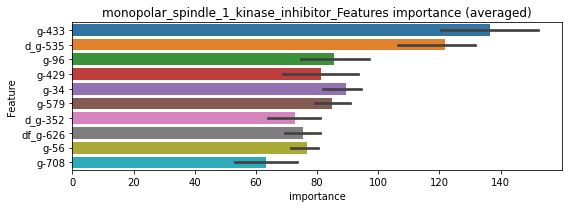

len(train_index) : 3896
len(valid_index) : 3897
================================= fold 1/2 monopolar_spindle_1_kinase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0113207	valid_1's binary_logloss: 0.0195934
[200]	training's binary_logloss: 0.00123814	valid_1's binary_logloss: 0.00860492
[300]	training's binary_logloss: 0.000348659	valid_1's binary_logloss: 0.00707051
Early stopping, best iteration is:
[338]	training's binary_logloss: 0.000261385	valid_1's binary_logloss: 0.0069219


len(train_index) : 3897
len(valid_index) : 3896
================================= fold 2/2 monopolar_spindle_1_kinase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0117955	valid_1's binary_logloss: 0.0180361
[200]	training's binary_logloss: 0.0013397	valid_1's binary_logloss: 0.00428439
[300]	training's binary_logloss: 0.000375749	valid_1's binary_logloss: 0.00220141
[400]	training's binary_logloss: 0.000201091	valid_1's binary_logloss: 0.00173909
Early stopping, best iteration is:
[429]	training's binary_logloss: 0.000182162	valid_1's binary_logloss: 0.00167237


monopolar_spindle_1_kinase_inhibitor logloss: 0.00429747110228542
mtor_inhibitor, len(trt): 130, len(othr): 3267, target_rate: 0.0054590 → Adj_target_rate: 0.0052608


neg labels: 3289 → selected neg labels: 3267


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0332296	valid_1's binary_logloss: 0.0809586
[200]	training's binary_logloss: 0.00515799	valid_1's binary_logloss: 0.0544021
Early stopping, best iteration is:
[272]	training's binary_logloss: 0.00201878	valid_1's binary_logloss: 0.0502951
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0356251	valid_1's binary_logloss: 0.0843518
[200]	training's binary_logloss: 0.00563386	valid_1's binary_logloss: 0.0598717


1 / 3 AUC score:0.996
Threshold: 0.0099619, pos_neg_ratio: 0.8000000


Early stopping, best iteration is:
[200]	training's binary_logloss: 0.00563386	valid_1's binary_logloss: 0.0598717


Remove_noisy_labels: 141 → positive_corect_labels: 648/3779
p_label_rate: 0.0763435 Vs.target_rate: 0.00546, Num_p_label: 304.0, conf_0:0.00243, conf_1:0.01096
Num_p_label: 304.0, Expected: 21.7, Adj_threshold_1: 0.0099619
Num_p_label: 220.0, Expected: 21.7, Adj_threshold_2: 0.0149619
Num_p_label: 186.0, Expected: 21.7, Adj_threshold_3: 0.0199619
Num_p_label: 158.0, Expected: 21.7, Adj_threshold_4: 0.0249619
Num_p_label: 145.0, Expected: 21.7, Adj_threshold_5: 0.0299619
Num_p_label: 126.0, Expected: 21.7, Adj_threshold_6: 0.0349619
Num_p_label: 117.0, Expected: 21.7, Adj_threshold_7: 0.0399619
Num_p_label: 106.0, Expected: 21.7, Adj_threshold_8: 0.0449619
Num_p_label: 101.0, Expected: 21.7, Adj_threshold_9: 0.0499619
Num_p_label: 95.0, Expected: 21.7, Adj_threshold_10: 0.0549619
threshold: 0.0599619, positive p_label: 92.0/3982, p_label_rate: 0.0231040
positive y_label: 648.0/3779, y_label_rate: 0.1714739
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0309838	valid_1's binary_logloss: 0.0605872
[200]	training's binary_logloss: 0.0044958	valid_1's binary_logloss: 0.0322791
[300]	training's binary_logloss: 0.00130813	valid_1's binary_logloss: 0.0273586
Early stopping, best iteration is:
[290]	training's binary_logloss: 0.00143467	valid_1's binary_logloss: 0.0272135
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0315468	valid_1's binary_logloss: 0.0780156
[200]	training's binary_logloss: 0.00433357	valid_1's binary_logloss: 0.0530374


2 / 3 AUC score:0.999
Threshold: 0.0599619, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 27 → positive_corect_labels: 627.0/3752


Early stopping, best iteration is:
[256]	training's binary_logloss: 0.00197145	valid_1's binary_logloss: 0.0509162


p_label_rate: 0.0509794 Vs.target_rate: 0.00546, Num_p_label: 203.0, conf_0:0.00142, conf_1:0.06596
Num_p_label: 203.0, Expected: 21.7, Adj_threshold_1: 0.0599619
Num_p_label: 200.0, Expected: 21.7, Adj_threshold_2: 0.0649619
Num_p_label: 197.0, Expected: 21.7, Adj_threshold_3: 0.0699619
Num_p_label: 193.0, Expected: 21.7, Adj_threshold_4: 0.0749619
Num_p_label: 192.0, Expected: 21.7, Adj_threshold_5: 0.0799619
Num_p_label: 189.0, Expected: 21.7, Adj_threshold_6: 0.0849619
Num_p_label: 184.0, Expected: 21.7, Adj_threshold_7: 0.0899619
Num_p_label: 184.0, Expected: 21.7, Adj_threshold_8: 0.0949619
Num_p_label: 184.0, Expected: 21.7, Adj_threshold_9: 0.0999619
Num_p_label: 184.0, Expected: 21.7, Adj_threshold_10: 0.1049619
threshold: 0.1099619, positive p_label: 180.0/3982, p_label_rate: 0.0452034
positive y_label: 627.0/3752, y_label_rate: 0.1671109
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0280095	valid_1's binary_logloss: 0.056722
[200]	training's binary_logloss: 0.00380739	valid_1's binary_logloss: 0.0326445
Early stopping, best iteration is:
[264]	training's binary_logloss: 0.00158948	valid_1's binary_logloss: 0.029129
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0280918	valid_1's binary_logloss: 0.0702282


3 / 3 AUC score:0.996
Threshold: 0.1099619, pos_neg_ratio: 0.8000000


Early stopping, best iteration is:
[152]	training's binary_logloss: 0.00893055	valid_1's binary_logloss: 0.054517


Remove_noisy_labels: 30 → positive_corect_labels: 600.0/3722
p_label_rate: 0.0544952 Vs.target_rate: 0.00546, Num_p_label: 217.0, conf_0:0.00347, conf_1:0.12096
Num_p_label: 217.0, Expected: 21.7, Adj_threshold_1: 0.1099619
Num_p_label: 213.0, Expected: 21.7, Adj_threshold_2: 0.1149619
Num_p_label: 208.0, Expected: 21.7, Adj_threshold_3: 0.1199619
Num_p_label: 204.0, Expected: 21.7, Adj_threshold_4: 0.1249619
Num_p_label: 201.0, Expected: 21.7, Adj_threshold_5: 0.1299619
Num_p_label: 197.0, Expected: 21.7, Adj_threshold_6: 0.1349619
Num_p_label: 192.0, Expected: 21.7, Adj_threshold_7: 0.1399619
Num_p_label: 187.0, Expected: 21.7, Adj_threshold_8: 0.1449619
Num_p_label: 184.0, Expected: 21.7, Adj_threshold_9: 0.1499619
Num_p_label: 181.0, Expected: 21.7, Adj_threshold_10: 0.1549619
threshold: 0.1599619, positive p_label: 179.0/3982, p_label_rate: 0.0449523
positive y_label: 779.0/7704, y_label_rate: 0.1011163


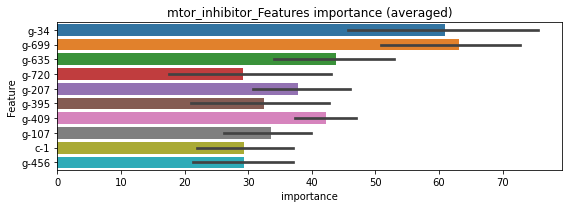

len(train_index) : 3852
len(valid_index) : 3852
================================= fold 1/2 mtor_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0177529	valid_1's binary_logloss: 0.0336947
[200]	training's binary_logloss: 0.00245497	valid_1's binary_logloss: 0.020748
Early stopping, best iteration is:
[282]	training's binary_logloss: 0.000854739	valid_1's binary_logloss: 0.0196727


len(train_index) : 3852
len(valid_index) : 3852
================================= fold 2/2 mtor_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0182619	valid_1's binary_logloss: 0.0464268
[200]	training's binary_logloss: 0.00259764	valid_1's binary_logloss: 0.0317589
Early stopping, best iteration is:
[215]	training's binary_logloss: 0.00206517	valid_1's binary_logloss: 0.0308037


mtor_inhibitor logloss: 0.025238201601373474


  acetylcholine_receptor_agonist acetylcholine_receptor_antagonist  \
0                       df_g-122                              c-30   
1                  clusters_df_c                         c_all_max   
2                          cnt_0                    clusters_g_all   
3                      c_all_min                          df_g-707   
4                        df_g-51                        clusters_g   
5                       df_c_min                          df_c_min   
6                          cnt_2                             g-514   
7                       df_g-736                          df_g-640   
8                          g-244                            df_c-6   
9                           c-73                          df_g-597   

  acetylcholinesterase_inhibitor adenosine_receptor_antagonist  \
0                      c_all_max                clusters_c_all   
1                      c_all_min                      df_c_min   
2                 clusters_g_al

mucolytic_agent, len(trt): 48, len(othr): 3281, target_rate: 0.0020156 → Adj_target_rate: 0.0022556


neg labels: 3289 → selected neg labels: 3281


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0446597	valid_1's binary_logloss: 0.0832309
[200]	training's binary_logloss: 0.00814819	valid_1's binary_logloss: 0.0355388
[300]	training's binary_logloss: 0.00229202	valid_1's binary_logloss: 0.0223824
[400]	training's binary_logloss: 0.00108799	valid_1's binary_logloss: 0.0180287
[500]	training's binary_logloss: 0.000691187	valid_1's binary_logloss: 0.0164858
Early stopping, best iteration is:
[490]	training's binary_logloss: 0.000712804	valid_1's binary_logloss: 0.016367
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.046635	valid_1's binary_logloss: 0.0697084
[200]	training's binary_logloss: 0.00863482	valid_1's binary_logloss: 0.0209454
[300]	training's binary_logloss: 0.00245724	valid_1's binary_logloss: 0.0092359
[400]	training's binary_logloss: 0.00114285	valid_1's binary_logloss: 0.0063245
[500]	training's binary_logloss: 0.00072571	v

1 / 3 AUC score:1.000
Threshold: 0.0054672, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → positive_corect_labels: 656/3805
p_label_rate: 0.0354093 Vs.target_rate: 0.00202, Num_p_label: 141.0, conf_0:0.00060, conf_1:0.00601
Num_p_label: 141.0, Expected: 8.0, Adj_threshold_1: 0.0054672
Num_p_label: 50.0, Expected: 8.0, Adj_threshold_2: 0.0104672
Num_p_label: 22.0, Expected: 8.0, Adj_threshold_3: 0.0154672
Num_p_label: 12.0, Expected: 8.0, Adj_threshold_4: 0.0204672
threshold: 0.0204672, positive p_label: 12.0/3982, p_label_rate: 0.0030136
positive y_label: 656.0/3805, y_label_rate: 0.1724047
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.042309	valid_1's binary_logloss: 0.0799489
[200]	training's binary_logloss: 0.00733598	valid_1's binary_logloss: 0.0319361
[300]	training's binary_logloss: 0.00217181	valid_1's binary_logloss: 0.0203654
[400]	training's binary_logloss: 0.00104152	valid_1's binary_logloss: 0.0169577
[500]	training's binary_logloss: 0.000667765	valid_1's binary_logloss: 0.0151314
Early stopping, best iteration is:
[493]	training's binary_logloss: 0.000680934	valid_1's binary_logloss: 0.0151172
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0464405	valid_1's binary_logloss: 0.0687625
[200]	training's binary_logloss: 0.00867073	valid_1's binary_logloss: 0.0195153
[300]	training's binary_logloss: 0.00249007	valid_1's binary_logloss: 0.0084824
[400]	training's binary_logloss: 0.00116522	valid_1's binary_logloss: 0.00530868
[500]	training's binary_logloss: 0.00073467

2 / 3 AUC score:1.000
Threshold: 0.0204672, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 5 → positive_corect_labels: 655.0/3800
p_label_rate: 0.0123054 Vs.target_rate: 0.00202, Num_p_label: 49.0, conf_0:0.00066, conf_1:0.02251
Num_p_label: 49.0, Expected: 8.0, Adj_threshold_1: 0.0204672
Num_p_label: 33.0, Expected: 8.0, Adj_threshold_2: 0.0254672
Num_p_label: 24.0, Expected: 8.0, Adj_threshold_3: 0.0304672
Num_p_label: 19.0, Expected: 8.0, Adj_threshold_4: 0.0354672
Num_p_label: 14.0, Expected: 8.0, Adj_threshold_5: 0.0404672
threshold: 0.0404672, positive p_label: 14.0/3982, p_label_rate: 0.0035158
positive y_label: 655.0/3800, y_label_rate: 0.1723684
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0443497	valid_1's binary_logloss: 0.0724049
[200]	training's binary_logloss: 0.00776271	valid_1's binary_logloss: 0.0245347
[300]	training's binary_logloss: 0.00228981	valid_1's binary_logloss: 0.012991
[400]	training's binary_logloss: 0.00109033	valid_1's binary_logloss: 0.00955772
[500]	training's binary_logloss: 0.000696884	valid_1's binary_logloss: 0.00790666
[600]	training's binary_logloss: 0.00055108	valid_1's binary_logloss: 0.0073257
Early stopping, best iteration is:
[629]	training's binary_logloss: 0.000535777	valid_1's binary_logloss: 0.0072544
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0440723	valid_1's binary_logloss: 0.0678158
[200]	training's binary_logloss: 0.00781595	valid_1's binary_logloss: 0.0211934
[300]	training's binary_logloss: 0.00231107	valid_1's binary_logloss: 0.0109962
[400]	training's binary_logloss: 0.0010965

3 / 3 AUC score:1.000
Threshold: 0.0404672, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 1 → positive_corect_labels: 655.0/3799
p_label_rate: 0.0045203 Vs.target_rate: 0.00202, Num_p_label: 18.0, conf_0:0.00058, conf_1:0.04451
threshold: 0.0404672, positive p_label: 18.0/3982, p_label_rate: 0.0045203
positive y_label: 673.0/7781, y_label_rate: 0.0864927


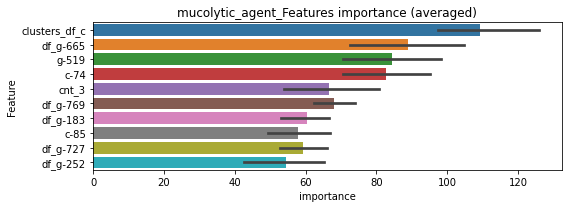

len(train_index) : 3890
len(valid_index) : 3891
================================= fold 1/2 mucolytic_agent=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0253962	valid_1's binary_logloss: 0.049219
[200]	training's binary_logloss: 0.00448509	valid_1's binary_logloss: 0.0246999
Early stopping, best iteration is:
[288]	training's binary_logloss: 0.00141111	valid_1's binary_logloss: 0.0203841


len(train_index) : 3891
len(valid_index) : 3890
================================= fold 2/2 mucolytic_agent=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0259286	valid_1's binary_logloss: 0.043201
[200]	training's binary_logloss: 0.00474872	valid_1's binary_logloss: 0.0182139
[300]	training's binary_logloss: 0.00137139	valid_1's binary_logloss: 0.0127016
[400]	training's binary_logloss: 0.000626012	valid_1's binary_logloss: 0.0114342
Early stopping, best iteration is:
[475]	training's binary_logloss: 0.000433022	valid_1's binary_logloss: 0.0110381


mucolytic_agent logloss: 0.015711747293841786
neuropeptide_receptor_antagonist, len(trt): 37, len(othr): 3283, target_rate: 0.0015537 → Adj_target_rate: 0.0018079


neg labels: 3289 → selected neg labels: 3283


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0385126	valid_1's binary_logloss: 0.0598481
[200]	training's binary_logloss: 0.00580356	valid_1's binary_logloss: 0.0179145
[300]	training's binary_logloss: 0.00162552	valid_1's binary_logloss: 0.00944711
[400]	training's binary_logloss: 0.00079153	valid_1's binary_logloss: 0.00712135
[500]	training's binary_logloss: 0.000521066	valid_1's binary_logloss: 0.00623467
Early stopping, best iteration is:
[490]	training's binary_logloss: 0.000538023	valid_1's binary_logloss: 0.00622123
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0381855	valid_1's binary_logloss: 0.0600101
[200]	training's binary_logloss: 0.00606495	valid_1's binary_logloss: 0.0169995
[300]	training's binary_logloss: 0.00167365	valid_1's binary_logloss: 0.00765697
[400]	training's binary_logloss: 0.000809188	valid_1's binary_logloss: 0.00507214
[500]	training's binary_logloss: 0.0

1 / 3 AUC score:1.000
Threshold: 0.0032119, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → positive_corect_labels: 656/3807
p_label_rate: 0.0454545 Vs.target_rate: 0.00155, Num_p_label: 181.0, conf_0:0.00044, conf_1:0.00353
Num_p_label: 181.0, Expected: 6.2, Adj_threshold_1: 0.0032119
Num_p_label: 54.0, Expected: 6.2, Adj_threshold_2: 0.0082119
Num_p_label: 24.0, Expected: 6.2, Adj_threshold_3: 0.0132119
Num_p_label: 16.0, Expected: 6.2, Adj_threshold_4: 0.0182119
Num_p_label: 12.0, Expected: 6.2, Adj_threshold_5: 0.0232119
threshold: 0.0232119, positive p_label: 12.0/3982, p_label_rate: 0.0030136
positive y_label: 656.0/3807, y_label_rate: 0.1723142
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0380427	valid_1's binary_logloss: 0.0594539
[200]	training's binary_logloss: 0.00559223	valid_1's binary_logloss: 0.0165166
[300]	training's binary_logloss: 0.00156358	valid_1's binary_logloss: 0.00832311
[400]	training's binary_logloss: 0.000757596	valid_1's binary_logloss: 0.00624487
[500]	training's binary_logloss: 0.000507168	valid_1's binary_logloss: 0.00531918
[600]	training's binary_logloss: 0.000439977	valid_1's binary_logloss: 0.005122
Early stopping, best iteration is:
[590]	training's binary_logloss: 0.000442809	valid_1's binary_logloss: 0.00511337
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0372386	valid_1's binary_logloss: 0.0572055
[200]	training's binary_logloss: 0.00570699	valid_1's binary_logloss: 0.0151461
[300]	training's binary_logloss: 0.00162896	valid_1's binary_logloss: 0.00753803
[400]	training's binary_logloss: 0.00

2 / 3 AUC score:1.000
Threshold: 0.0232119, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 1 → positive_corect_labels: 656.0/3806
p_label_rate: 0.0065294 Vs.target_rate: 0.00155, Num_p_label: 26.0, conf_0:0.00050, conf_1:0.02553
Num_p_label: 26.0, Expected: 6.2, Adj_threshold_1: 0.0232119
Num_p_label: 21.0, Expected: 6.2, Adj_threshold_2: 0.0282119
Num_p_label: 17.0, Expected: 6.2, Adj_threshold_3: 0.0332119
Num_p_label: 14.0, Expected: 6.2, Adj_threshold_4: 0.0382119
Num_p_label: 12.0, Expected: 6.2, Adj_threshold_5: 0.0432119
threshold: 0.0432119, positive p_label: 12.0/3982, p_label_rate: 0.0030136
positive y_label: 656.0/3806, y_label_rate: 0.1723594
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0373902	valid_1's binary_logloss: 0.0601015
[200]	training's binary_logloss: 0.00550386	valid_1's binary_logloss: 0.0166848
[300]	training's binary_logloss: 0.00155165	valid_1's binary_logloss: 0.0086411
[400]	training's binary_logloss: 0.000751494	valid_1's binary_logloss: 0.00637551
[500]	training's binary_logloss: 0.000505259	valid_1's binary_logloss: 0.00543395
Early stopping, best iteration is:
[580]	training's binary_logloss: 0.000442918	valid_1's binary_logloss: 0.00518504
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0375852	valid_1's binary_logloss: 0.0592233
[200]	training's binary_logloss: 0.00584856	valid_1's binary_logloss: 0.0161718
[300]	training's binary_logloss: 0.00164686	valid_1's binary_logloss: 0.00747346
[400]	training's binary_logloss: 0.000797472	valid_1's binary_logloss: 0.00530388
Early stopping, best iteration is:
[

3 / 3 AUC score:1.000
Threshold: 0.0432119, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → positive_corect_labels: 656.0/3806
p_label_rate: 0.0022602 Vs.target_rate: 0.00155, Num_p_label: 9.0, conf_0:0.00051, conf_1:0.04753
threshold: 0.0432119, positive p_label: 9.0/3982, p_label_rate: 0.0022602
positive y_label: 665.0/7788, y_label_rate: 0.0853878


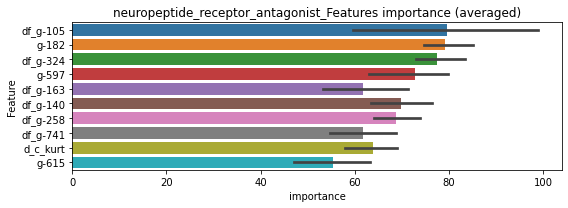

len(train_index) : 3894
len(valid_index) : 3894
================================= fold 1/2 neuropeptide_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.020912	valid_1's binary_logloss: 0.0355658
[200]	training's binary_logloss: 0.00321991	valid_1's binary_logloss: 0.0153022
[300]	training's binary_logloss: 0.000871344	valid_1's binary_logloss: 0.0123854
Early stopping, best iteration is:
[360]	training's binary_logloss: 0.000528487	valid_1's binary_logloss: 0.0118685


len(train_index) : 3894
len(valid_index) : 3894
================================= fold 2/2 neuropeptide_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0217053	valid_1's binary_logloss: 0.0373501
[200]	training's binary_logloss: 0.0032546	valid_1's binary_logloss: 0.0131267
[300]	training's binary_logloss: 0.000883751	valid_1's binary_logloss: 0.00825844
[400]	training's binary_logloss: 0.000416586	valid_1's binary_logloss: 0.00659007
[500]	training's binary_logloss: 0.000272441	valid_1's binary_logloss: 0.00609631
Early stopping, best iteration is:
[508]	training's binary_logloss: 0.000266967	valid_1's binary_logloss: 0.00606846


neuropeptide_receptor_antagonist logloss: 0.00896847506732288
nfkb_inhibitor, len(trt): 832, len(othr): 3270, target_rate: 0.0349374 → Adj_target_rate: 0.0254860
================= Pseudo labeling 1 / 3 =================


neg labels: 3289 → selected neg labels: 3270
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0535528	valid_1's binary_logloss: 0.121814
Early stopping, best iteration is:
[125]	training's binary_logloss: 0.0341199	valid_1's binary_logloss: 0.118909
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0438681	valid_1's binary_logloss: 0.15135


1 / 3 AUC score:0.933
Threshold: 0.0344239, pos_neg_ratio: 0.7455657
Remove_noisy_labels: 404 → positive_corect_labels: 736/3698
p_label_rate: 0.0894023 Vs.target_rate: 0.03494, Num_p_label: 356.0, conf_0:0.02214, conf_1:0.03787
threshold: 0.0344239, positive p_label: 356.0/3982, p_label_rate: 0.0894023


Early stopping, best iteration is:
[100]	training's binary_logloss: 0.0438681	valid_1's binary_logloss: 0.15135


positive y_label: 736.0/3698, y_label_rate: 0.1990265
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0203617	valid_1's binary_logloss: 0.0299012
Early stopping, best iteration is:
[174]	training's binary_logloss: 0.00321377	valid_1's binary_logloss: 0.0187096
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0218144	valid_1's binary_logloss: 0.0301538


2 / 3 AUC score:0.994
Threshold: 0.0344239, pos_neg_ratio: 0.7455657
Remove_noisy_labels: 21 → positive_corect_labels: 727.0/3677
p_label_rate: 0.0572577 Vs.target_rate: 0.03494, Num_p_label: 228.0, conf_0:0.00160, conf_1:0.03787
threshold: 0.0344239, positive p_label: 228.0/3982, p_label_rate: 0.0572577


Early stopping, best iteration is:
[182]	training's binary_logloss: 0.00281064	valid_1's binary_logloss: 0.0185477


positive y_label: 727.0/3677, y_label_rate: 0.1977155
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0162799	valid_1's binary_logloss: 0.0170317
[200]	training's binary_logloss: 0.00106174	valid_1's binary_logloss: 0.00129231
[300]	training's binary_logloss: 0.000234234	valid_1's binary_logloss: 0.000399467
[400]	training's binary_logloss: 0.000154361	valid_1's binary_logloss: 0.000303743
[500]	training's binary_logloss: 0.000140312	valid_1's binary_logloss: 0.00028595
[600]	training's binary_logloss: 0.000136913	valid_1's binary_logloss: 0.000282276
Early stopping, best iteration is:
[660]	training's binary_logloss: 0.00013587	valid_1's binary_logloss: 0.000281144
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.016246	valid_1's binary_logloss: 0.0172163
[200]	training's binary_logloss: 0.001055	valid_1's binary_logloss: 0.00214551
[300]	training's binary_logloss: 0.000233261	valid_1's binary_logloss: 0.00130922
Early stopping, best iteration 

3 / 3 AUC score:1.000
Threshold: 0.0344239, pos_neg_ratio: 0.7455657
Remove_noisy_labels: 1 → positive_corect_labels: 727.0/3676
p_label_rate: 0.0492215 Vs.target_rate: 0.03494, Num_p_label: 196.0, conf_0:0.00010, conf_1:0.03787
threshold: 0.0344239, positive p_label: 196.0/3982, p_label_rate: 0.0492215
positive y_label: 923.0/7658, y_label_rate: 0.1205276


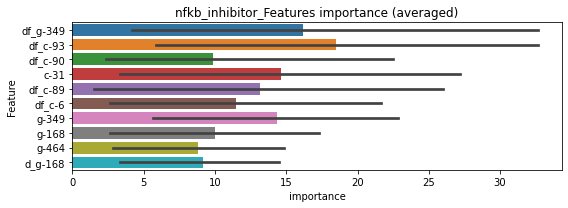

len(train_index) : 3829
len(valid_index) : 3829
================================= fold 1/2 nfkb_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0119726	valid_1's binary_logloss: 0.0156305
[200]	training's binary_logloss: 0.000940565	valid_1's binary_logloss: 0.00474096


len(train_index) : 3829
len(valid_index) : 3829


Early stopping, best iteration is:
[262]	training's binary_logloss: 0.000311631	valid_1's binary_logloss: 0.00399673


================================= fold 2/2 nfkb_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0119813	valid_1's binary_logloss: 0.0157652
[200]	training's binary_logloss: 0.00093756	valid_1's binary_logloss: 0.00460801


nfkb_inhibitor logloss: 0.00410939083815835


Early stopping, best iteration is:
[250]	training's binary_logloss: 0.000368908	valid_1's binary_logloss: 0.00422206


nicotinic_receptor_agonist, len(trt): 12, len(othr): 3287, target_rate: 0.0005039 → Adj_target_rate: 0.0006942


neg labels: 3289 → selected neg labels: 3287


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0187668	valid_1's binary_logloss: 0.0278997
[200]	training's binary_logloss: 0.00192645	valid_1's binary_logloss: 0.00658398
[300]	training's binary_logloss: 0.000547763	valid_1's binary_logloss: 0.00333743
[400]	training's binary_logloss: 0.00030704	valid_1's binary_logloss: 0.00254163
Early stopping, best iteration is:
[423]	training's binary_logloss: 0.000290347	valid_1's binary_logloss: 0.00249935
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0191384	valid_1's binary_logloss: 0.0233813
[200]	training's binary_logloss: 0.0019634	valid_1's binary_logloss: 0.00418621
[300]	training's binary_logloss: 0.000549803	valid_1's binary_logloss: 0.00167295
[400]	training's binary_logloss: 0.000309753	valid_1's binary_logloss: 0.00111602
[500]	training's binary_logloss: 0.000273432	valid_1's binary_logloss: 0.00103103
Early stopping, best iteration is

1 / 3 AUC score:1.000
Threshold: 0.0010642, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → positive_corect_labels: 657/3812
p_label_rate: 0.0449523 Vs.target_rate: 0.00050, Num_p_label: 179.0, conf_0:0.00016, conf_1:0.00117
Num_p_label: 179.0, Expected: 2.0, Adj_threshold_1: 0.0010642
Num_p_label: 29.0, Expected: 2.0, Adj_threshold_2: 0.0060642
Num_p_label: 16.0, Expected: 2.0, Adj_threshold_3: 0.0110642
Num_p_label: 10.0, Expected: 2.0, Adj_threshold_4: 0.0160642
Num_p_label: 9.0, Expected: 2.0, Adj_threshold_5: 0.0210642
Num_p_label: 6.0, Expected: 2.0, Adj_threshold_6: 0.0260642
Num_p_label: 4.0, Expected: 2.0, Adj_threshold_7: 0.0310642
threshold: 0.0310642, positive p_label: 4.0/3982, p_label_rate: 0.0010045
positive y_label: 657.0/3812, y_label_rate: 0.1723505
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0189172	valid_1's binary_logloss: 0.026524
[200]	training's binary_logloss: 0.00187064	valid_1's binary_logloss: 0.00612082
[300]	training's binary_logloss: 0.000523711	valid_1's binary_logloss: 0.00287513
[400]	training's binary_logloss: 0.000299336	valid_1's binary_logloss: 0.00219225
Early stopping, best iteration is:
[451]	training's binary_logloss: 0.000271282	valid_1's binary_logloss: 0.00211478
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0189483	valid_1's binary_logloss: 0.0218297
[200]	training's binary_logloss: 0.00187552	valid_1's binary_logloss: 0.0033132
[300]	training's binary_logloss: 0.000528236	valid_1's binary_logloss: 0.00138429
[400]	training's binary_logloss: 0.000303126	valid_1's binary_logloss: 0.000983481
[500]	training's binary_logloss: 0.000265423	valid_1's binary_logloss: 0.000915813
Early stopping, best iteration 

2 / 3 AUC score:1.000
Threshold: 0.0310642, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → positive_corect_labels: 657.0/3812
p_label_rate: 0.0050226 Vs.target_rate: 0.00050, Num_p_label: 20.0, conf_0:0.00017, conf_1:0.03417
Num_p_label: 20.0, Expected: 2.0, Adj_threshold_1: 0.0310642
Num_p_label: 18.0, Expected: 2.0, Adj_threshold_2: 0.0360642
Num_p_label: 15.0, Expected: 2.0, Adj_threshold_3: 0.0410642
Num_p_label: 14.0, Expected: 2.0, Adj_threshold_4: 0.0460642
Num_p_label: 13.0, Expected: 2.0, Adj_threshold_5: 0.0510642
Num_p_label: 12.0, Expected: 2.0, Adj_threshold_6: 0.0560642
Num_p_label: 12.0, Expected: 2.0, Adj_threshold_7: 0.0610642
Num_p_label: 12.0, Expected: 2.0, Adj_threshold_8: 0.0660642
Num_p_label: 12.0, Expected: 2.0, Adj_threshold_9: 0.0710642
Num_p_label: 12.0, Expected: 2.0, Adj_threshold_10: 0.0760642
threshold: 0.0810642, positive p_label: 10.0/3982, p_label_rate: 0.0025113
positive y_label: 657.0/3812, y_label_rate: 0.1723505
================= Pseudo labelin

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0189172	valid_1's binary_logloss: 0.026524
[200]	training's binary_logloss: 0.00187064	valid_1's binary_logloss: 0.00612082
[300]	training's binary_logloss: 0.000523711	valid_1's binary_logloss: 0.00287513
[400]	training's binary_logloss: 0.000299336	valid_1's binary_logloss: 0.00219225
Early stopping, best iteration is:
[451]	training's binary_logloss: 0.000271282	valid_1's binary_logloss: 0.00211478
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0189483	valid_1's binary_logloss: 0.0218297
[200]	training's binary_logloss: 0.00187552	valid_1's binary_logloss: 0.0033132
[300]	training's binary_logloss: 0.000528236	valid_1's binary_logloss: 0.00138429
[400]	training's binary_logloss: 0.000303126	valid_1's binary_logloss: 0.000983481
[500]	training's binary_logloss: 0.000265423	valid_1's binary_logloss: 0.000915813
Early stopping, best iteration 

3 / 3 AUC score:1.000
Threshold: 0.0810642, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → positive_corect_labels: 657.0/3812
p_label_rate: 0.0025113 Vs.target_rate: 0.00050, Num_p_label: 10.0, conf_0:0.00017, conf_1:0.08917
Num_p_label: 10.0, Expected: 2.0, Adj_threshold_1: 0.0810642
Num_p_label: 10.0, Expected: 2.0, Adj_threshold_2: 0.0860642
Num_p_label: 9.0, Expected: 2.0, Adj_threshold_3: 0.0910642
Num_p_label: 8.0, Expected: 2.0, Adj_threshold_4: 0.0960642
Num_p_label: 7.0, Expected: 2.0, Adj_threshold_5: 0.1010642
Num_p_label: 6.0, Expected: 2.0, Adj_threshold_6: 0.1060642
Num_p_label: 6.0, Expected: 2.0, Adj_threshold_7: 0.1110642
Num_p_label: 6.0, Expected: 2.0, Adj_threshold_8: 0.1160642
Num_p_label: 5.0, Expected: 2.0, Adj_threshold_9: 0.1210642
Num_p_label: 4.0, Expected: 2.0, Adj_threshold_10: 0.1260642
threshold: 0.1260642, positive p_label: 4.0/3982, p_label_rate: 0.0010045
positive y_label: 661.0/7794, y_label_rate: 0.0848088


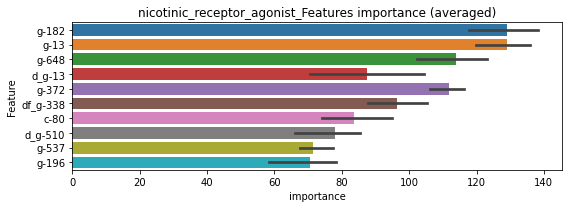

len(train_index) : 3897
len(valid_index) : 3897
================================= fold 1/2 nicotinic_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.00990018	valid_1's binary_logloss: 0.0174284
[200]	training's binary_logloss: 0.000974603	valid_1's binary_logloss: 0.00703811
[300]	training's binary_logloss: 0.00027072	valid_1's binary_logloss: 0.0056177
Early stopping, best iteration is:
[326]	training's binary_logloss: 0.000220041	valid_1's binary_logloss: 0.00552801


len(train_index) : 3897
len(valid_index) : 3897
================================= fold 2/2 nicotinic_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0103199	valid_1's binary_logloss: 0.0150169
[200]	training's binary_logloss: 0.00103297	valid_1's binary_logloss: 0.00583539
[300]	training's binary_logloss: 0.000291388	valid_1's binary_logloss: 0.0047606
[400]	training's binary_logloss: 0.000161656	valid_1's binary_logloss: 0.00452084
Early stopping, best iteration is:
[431]	training's binary_logloss: 0.000147659	valid_1's binary_logloss: 0.0044486


nicotinic_receptor_agonist logloss: 0.004988307284797986


neg labels: 3289 → selected neg labels: 3285


nitric_oxide_donor, len(trt): 26, len(othr): 3285, target_rate: 0.0010918 → Adj_target_rate: 0.0013394
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0297564	valid_1's binary_logloss: 0.0478436
[200]	training's binary_logloss: 0.00421973	valid_1's binary_logloss: 0.0118
[300]	training's binary_logloss: 0.00118088	valid_1's binary_logloss: 0.00489892
[400]	training's binary_logloss: 0.000593164	valid_1's binary_logloss: 0.00315888
Early stopping, best iteration is:
[410]	training's binary_logloss: 0.000565876	valid_1's binary_logloss: 0.00307946
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0309102	valid_1's binary_logloss: 0.0440713
[200]	training's binary_logloss: 0.00429326	valid_1's binary_logloss: 0.00978392
[300]	training's binary_logloss: 0.00119723	valid_1's binary_logloss: 0.00394347
[400]	training's binary_logloss: 0.000596764	valid_1's binary_logloss: 0.00247098
[500]	training's binary_logloss: 0.000415617	valid_1's binary_logloss: 0.00195935
Early stopping, best iteration is:
[5

1 / 3 AUC score:1.000
Threshold: 0.0029061, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → positive_corect_labels: 657/3810
p_label_rate: 0.0331492 Vs.target_rate: 0.00109, Num_p_label: 132.0, conf_0:0.00037, conf_1:0.00320
Num_p_label: 132.0, Expected: 4.3, Adj_threshold_1: 0.0029061
Num_p_label: 21.0, Expected: 4.3, Adj_threshold_2: 0.0079061
Num_p_label: 8.0, Expected: 4.3, Adj_threshold_3: 0.0129061
threshold: 0.0129061, positive p_label: 8.0/3982, p_label_rate: 0.0020090
positive y_label: 657.0/3810, y_label_rate: 0.1724409
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0292666	valid_1's binary_logloss: 0.0457788
[200]	training's binary_logloss: 0.00399147	valid_1's binary_logloss: 0.0102341
[300]	training's binary_logloss: 0.00114676	valid_1's binary_logloss: 0.00442014
[400]	training's binary_logloss: 0.000579137	valid_1's binary_logloss: 0.0029357
Early stopping, best iteration is:
[422]	training's binary_logloss: 0.000524713	valid_1's binary_logloss: 0.00280469
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0304375	valid_1's binary_logloss: 0.0424016
[200]	training's binary_logloss: 0.00415053	valid_1's binary_logloss: 0.00927224
[300]	training's binary_logloss: 0.00117206	valid_1's binary_logloss: 0.00393996
[400]	training's binary_logloss: 0.00058156	valid_1's binary_logloss: 0.00250445
[500]	training's binary_logloss: 0.000407709	valid_1's binary_logloss: 0.00201908
Early stopping, best iteration is:
[

2 / 3 AUC score:1.000
Threshold: 0.0129061, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 3 → positive_corect_labels: 657.0/3807
p_label_rate: 0.0060271 Vs.target_rate: 0.00109, Num_p_label: 24.0, conf_0:0.00039, conf_1:0.01420
Num_p_label: 24.0, Expected: 4.3, Adj_threshold_1: 0.0129061
Num_p_label: 15.0, Expected: 4.3, Adj_threshold_2: 0.0179061
Num_p_label: 11.0, Expected: 4.3, Adj_threshold_3: 0.0229061
Num_p_label: 10.0, Expected: 4.3, Adj_threshold_4: 0.0279061
Num_p_label: 9.0, Expected: 4.3, Adj_threshold_5: 0.0329061
Num_p_label: 7.0, Expected: 4.3, Adj_threshold_6: 0.0379061
threshold: 0.0379061, positive p_label: 7.0/3982, p_label_rate: 0.0017579
positive y_label: 657.0/3807, y_label_rate: 0.1725768
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.029132	valid_1's binary_logloss: 0.0443539
[200]	training's binary_logloss: 0.00399584	valid_1's binary_logloss: 0.0097848
[300]	training's binary_logloss: 0.00114305	valid_1's binary_logloss: 0.00447576
[400]	training's binary_logloss: 0.000581348	valid_1's binary_logloss: 0.00295124
[500]	training's binary_logloss: 0.000412689	valid_1's binary_logloss: 0.00242404
Early stopping, best iteration is:
[505]	training's binary_logloss: 0.000409562	valid_1's binary_logloss: 0.0024131
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0298046	valid_1's binary_logloss: 0.0421874
[200]	training's binary_logloss: 0.00405572	valid_1's binary_logloss: 0.00948498
[300]	training's binary_logloss: 0.00114636	valid_1's binary_logloss: 0.00409155
[400]	training's binary_logloss: 0.000574931	valid_1's binary_logloss: 0.00270229
[500]	training's binary_logloss: 0.0

3 / 3 AUC score:1.000
Threshold: 0.0379061, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → positive_corect_labels: 657.0/3807
p_label_rate: 0.0017579 Vs.target_rate: 0.00109, Num_p_label: 7.0, conf_0:0.00036, conf_1:0.04170
threshold: 0.0379061, positive p_label: 7.0/3982, p_label_rate: 0.0017579
positive y_label: 664.0/7789, y_label_rate: 0.0852484


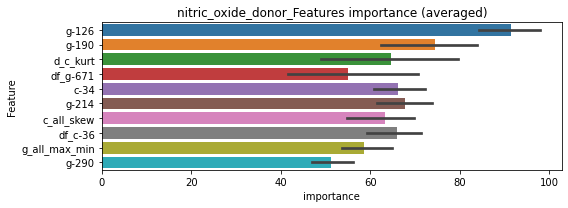

len(train_index) : 3894
len(valid_index) : 3895
================================= fold 1/2 nitric_oxide_donor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0162243	valid_1's binary_logloss: 0.026921
[200]	training's binary_logloss: 0.00214263	valid_1's binary_logloss: 0.00959523
[300]	training's binary_logloss: 0.000605133	valid_1's binary_logloss: 0.00735007
Early stopping, best iteration is:
[351]	training's binary_logloss: 0.000401525	valid_1's binary_logloss: 0.00705351


len(train_index) : 3895
len(valid_index) : 3894
================================= fold 2/2 nitric_oxide_donor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0165197	valid_1's binary_logloss: 0.0294856
[200]	training's binary_logloss: 0.00221356	valid_1's binary_logloss: 0.0126777
[300]	training's binary_logloss: 0.000622468	valid_1's binary_logloss: 0.00960416
Early stopping, best iteration is:
[357]	training's binary_logloss: 0.000395609	valid_1's binary_logloss: 0.00916522


nitric_oxide_donor logloss: 0.008109232252592568
nitric_oxide_production_inhibitor, len(trt): 29, len(othr): 3284, target_rate: 0.0012178 → Adj_target_rate: 0.0014697


neg labels: 3289 → selected neg labels: 3284


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0348443	valid_1's binary_logloss: 0.0525384
[200]	training's binary_logloss: 0.00532906	valid_1's binary_logloss: 0.0142124
[300]	training's binary_logloss: 0.00143615	valid_1's binary_logloss: 0.00652345
[400]	training's binary_logloss: 0.000704703	valid_1's binary_logloss: 0.00447534
[500]	training's binary_logloss: 0.000490037	valid_1's binary_logloss: 0.00372024
Early stopping, best iteration is:
[542]	training's binary_logloss: 0.000468323	valid_1's binary_logloss: 0.00364125
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0356702	valid_1's binary_logloss: 0.0535811
[200]	training's binary_logloss: 0.00530479	valid_1's binary_logloss: 0.0149044
[300]	training's binary_logloss: 0.00144601	valid_1's binary_logloss: 0.00747964
[400]	training's binary_logloss: 0.000709564	valid_1's binary_logloss: 0.00556088
[500]	training's binary_logloss: 0.

1 / 3 AUC score:1.000
Threshold: 0.0023353, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → positive_corect_labels: 656/3808
p_label_rate: 0.0813661 Vs.target_rate: 0.00122, Num_p_label: 324.0, conf_0:0.00040, conf_1:0.00257
Num_p_label: 324.0, Expected: 4.8, Adj_threshold_1: 0.0023353
Num_p_label: 174.0, Expected: 4.8, Adj_threshold_2: 0.0073353
Num_p_label: 143.0, Expected: 4.8, Adj_threshold_3: 0.0123353
Num_p_label: 133.0, Expected: 4.8, Adj_threshold_4: 0.0173353
Num_p_label: 123.0, Expected: 4.8, Adj_threshold_5: 0.0223353
Num_p_label: 117.0, Expected: 4.8, Adj_threshold_6: 0.0273353
Num_p_label: 112.0, Expected: 4.8, Adj_threshold_7: 0.0323353
Num_p_label: 108.0, Expected: 4.8, Adj_threshold_8: 0.0373353
Num_p_label: 104.0, Expected: 4.8, Adj_threshold_9: 0.0423353
Num_p_label: 103.0, Expected: 4.8, Adj_threshold_10: 0.0473353
threshold: 0.0523353, positive p_label: 100.0/3982, p_label_rate: 0.0251130
positive y_label: 656.0/3808, y_label_rate: 0.1722689
================= Ps

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0329511	valid_1's binary_logloss: 0.0484642
[200]	training's binary_logloss: 0.00480165	valid_1's binary_logloss: 0.0120524
[300]	training's binary_logloss: 0.00133502	valid_1's binary_logloss: 0.00524989
[400]	training's binary_logloss: 0.000666545	valid_1's binary_logloss: 0.00365802
[500]	training's binary_logloss: 0.000468087	valid_1's binary_logloss: 0.00305476
Early stopping, best iteration is:
[535]	training's binary_logloss: 0.000452268	valid_1's binary_logloss: 0.00301595
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0337857	valid_1's binary_logloss: 0.0508264
[200]	training's binary_logloss: 0.00494645	valid_1's binary_logloss: 0.0137156
[300]	training's binary_logloss: 0.00133372	valid_1's binary_logloss: 0.00651523
[400]	training's binary_logloss: 0.000658341	valid_1's binary_logloss: 0.00445277
[500]	training's binary_logloss: 0.

2 / 3 AUC score:1.000
Threshold: 0.0523353, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 4 → positive_corect_labels: 656.0/3804
p_label_rate: 0.0396786 Vs.target_rate: 0.00122, Num_p_label: 158.0, conf_0:0.00048, conf_1:0.05757
Num_p_label: 158.0, Expected: 4.8, Adj_threshold_1: 0.0523353
Num_p_label: 157.0, Expected: 4.8, Adj_threshold_2: 0.0573353
Num_p_label: 157.0, Expected: 4.8, Adj_threshold_3: 0.0623353
Num_p_label: 156.0, Expected: 4.8, Adj_threshold_4: 0.0673353
Num_p_label: 155.0, Expected: 4.8, Adj_threshold_5: 0.0723353
Num_p_label: 155.0, Expected: 4.8, Adj_threshold_6: 0.0773353
Num_p_label: 155.0, Expected: 4.8, Adj_threshold_7: 0.0823353
Num_p_label: 152.0, Expected: 4.8, Adj_threshold_8: 0.0873353
Num_p_label: 151.0, Expected: 4.8, Adj_threshold_9: 0.0923353
Num_p_label: 151.0, Expected: 4.8, Adj_threshold_10: 0.0973353
threshold: 0.1023353, positive p_label: 151.0/3982, p_label_rate: 0.0379206
positive y_label: 656.0/3804, y_label_rate: 0.1724501
================= Ps

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0316164	valid_1's binary_logloss: 0.0471244
[200]	training's binary_logloss: 0.00443877	valid_1's binary_logloss: 0.0111718
[300]	training's binary_logloss: 0.00127411	valid_1's binary_logloss: 0.00493414
[400]	training's binary_logloss: 0.00064189	valid_1's binary_logloss: 0.0032701
[500]	training's binary_logloss: 0.000455773	valid_1's binary_logloss: 0.00264315
Early stopping, best iteration is:
[517]	training's binary_logloss: 0.000449807	valid_1's binary_logloss: 0.00262982
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0325259	valid_1's binary_logloss: 0.0494168
[200]	training's binary_logloss: 0.00476554	valid_1's binary_logloss: 0.0134099
[300]	training's binary_logloss: 0.00132183	valid_1's binary_logloss: 0.00668951
[400]	training's binary_logloss: 0.000659806	valid_1's binary_logloss: 0.00495877
Early stopping, best iteration is:
[4

3 / 3 AUC score:1.000
Threshold: 0.1023353, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → positive_corect_labels: 656.0/3804
p_label_rate: 0.0394274 Vs.target_rate: 0.00122, Num_p_label: 157.0, conf_0:0.00051, conf_1:0.11257
Num_p_label: 157.0, Expected: 4.8, Adj_threshold_1: 0.1023353
Num_p_label: 155.0, Expected: 4.8, Adj_threshold_2: 0.1073353
Num_p_label: 155.0, Expected: 4.8, Adj_threshold_3: 0.1123353
Num_p_label: 154.0, Expected: 4.8, Adj_threshold_4: 0.1173353
Num_p_label: 154.0, Expected: 4.8, Adj_threshold_5: 0.1223353
Num_p_label: 154.0, Expected: 4.8, Adj_threshold_6: 0.1273353
Num_p_label: 153.0, Expected: 4.8, Adj_threshold_7: 0.1323353
Num_p_label: 152.0, Expected: 4.8, Adj_threshold_8: 0.1373353
Num_p_label: 151.0, Expected: 4.8, Adj_threshold_9: 0.1423353
Num_p_label: 151.0, Expected: 4.8, Adj_threshold_10: 0.1473353
threshold: 0.1523353, positive p_label: 151.0/3982, p_label_rate: 0.0379206
positive y_label: 807.0/7786, y_label_rate: 0.1036476


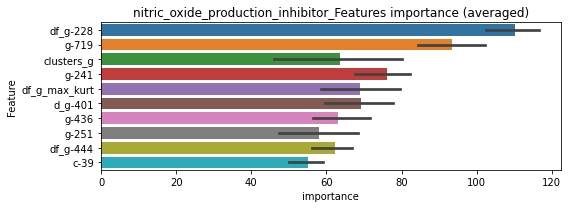

len(train_index) : 3893
len(valid_index) : 3893
================================= fold 1/2 nitric_oxide_production_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0204408	valid_1's binary_logloss: 0.0299862
[200]	training's binary_logloss: 0.00291414	valid_1's binary_logloss: 0.008538
[300]	training's binary_logloss: 0.000790673	valid_1's binary_logloss: 0.00429196
[400]	training's binary_logloss: 0.000380295	valid_1's binary_logloss: 0.00334394
[500]	training's binary_logloss: 0.00025967	valid_1's binary_logloss: 0.00293615
Early stopping, best iteration is:
[491]	training's binary_logloss: 0.000263577	valid_1's binary_logloss: 0.00292867


len(train_index) : 3893
len(valid_index) : 3893
================================= fold 2/2 nitric_oxide_production_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0205167	valid_1's binary_logloss: 0.0323634
[200]	training's binary_logloss: 0.00292091	valid_1's binary_logloss: 0.00856662
[300]	training's binary_logloss: 0.000777632	valid_1's binary_logloss: 0.00452691
[400]	training's binary_logloss: 0.000376706	valid_1's binary_logloss: 0.00371917
[500]	training's binary_logloss: 0.000255568	valid_1's binary_logloss: 0.0034192
Early stopping, best iteration is:
[517]	training's binary_logloss: 0.000249709	valid_1's binary_logloss: 0.00338897


nitric_oxide_production_inhibitor logloss: 0.0031588177201442164
nitric_oxide_synthase_inhibitor, len(trt): 26, len(othr): 3284, target_rate: 0.0010918 → Adj_target_rate: 0.0013394


neg labels: 3289 → selected neg labels: 3284


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0324645	valid_1's binary_logloss: 0.0534868
[200]	training's binary_logloss: 0.00457263	valid_1's binary_logloss: 0.0152861
[300]	training's binary_logloss: 0.00125004	valid_1's binary_logloss: 0.00827778
[400]	training's binary_logloss: 0.000628058	valid_1's binary_logloss: 0.00638133
[500]	training's binary_logloss: 0.00044016	valid_1's binary_logloss: 0.00566479
Early stopping, best iteration is:
[491]	training's binary_logloss: 0.000449544	valid_1's binary_logloss: 0.0056421
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.033577	valid_1's binary_logloss: 0.0497297
[200]	training's binary_logloss: 0.00460925	valid_1's binary_logloss: 0.0117799
[300]	training's binary_logloss: 0.00126838	valid_1's binary_logloss: 0.00514848
[400]	training's binary_logloss: 0.000636349	valid_1's binary_logloss: 0.00362736
[500]	training's binary_logloss: 0.000

1 / 3 AUC score:1.000
Threshold: 0.0027081, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → positive_corect_labels: 656/3808
p_label_rate: 0.0369161 Vs.target_rate: 0.00109, Num_p_label: 147.0, conf_0:0.00037, conf_1:0.00298
Num_p_label: 147.0, Expected: 4.3, Adj_threshold_1: 0.0027081
Num_p_label: 28.0, Expected: 4.3, Adj_threshold_2: 0.0077081
Num_p_label: 10.0, Expected: 4.3, Adj_threshold_3: 0.0127081
Num_p_label: 3.0, Expected: 4.3, Adj_threshold_4: 0.0177081
threshold: 0.0177081, positive p_label: 3.0/3982, p_label_rate: 0.0007534
positive y_label: 656.0/3808, y_label_rate: 0.1722689
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0330051	valid_1's binary_logloss: 0.0534866
[200]	training's binary_logloss: 0.00448137	valid_1's binary_logloss: 0.0149375
[300]	training's binary_logloss: 0.00124264	valid_1's binary_logloss: 0.00835549
[400]	training's binary_logloss: 0.000628136	valid_1's binary_logloss: 0.00633007
Early stopping, best iteration is:
[484]	training's binary_logloss: 0.000460934	valid_1's binary_logloss: 0.00551761
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0325734	valid_1's binary_logloss: 0.0483774
[200]	training's binary_logloss: 0.00441704	valid_1's binary_logloss: 0.0111686
[300]	training's binary_logloss: 0.00124189	valid_1's binary_logloss: 0.0050809
[400]	training's binary_logloss: 0.00063011	valid_1's binary_logloss: 0.00370182
Early stopping, best iteration is:
[471]	training's binary_logloss: 0.000475559	valid_1's binary_logloss: 0.0032649


2 / 3 AUC score:1.000
Threshold: 0.0177081, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → positive_corect_labels: 656.0/3808
p_label_rate: 0.0035158 Vs.target_rate: 0.00109, Num_p_label: 14.0, conf_0:0.00043, conf_1:0.01948
Num_p_label: 14.0, Expected: 4.3, Adj_threshold_1: 0.0177081
Num_p_label: 10.0, Expected: 4.3, Adj_threshold_2: 0.0227081
Num_p_label: 8.0, Expected: 4.3, Adj_threshold_3: 0.0277081
threshold: 0.0277081, positive p_label: 8.0/3982, p_label_rate: 0.0020090
positive y_label: 656.0/3808, y_label_rate: 0.1722689
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0330051	valid_1's binary_logloss: 0.0534866
[200]	training's binary_logloss: 0.00448137	valid_1's binary_logloss: 0.0149375
[300]	training's binary_logloss: 0.00124264	valid_1's binary_logloss: 0.00835549
[400]	training's binary_logloss: 0.000628136	valid_1's binary_logloss: 0.00633007
Early stopping, best iteration is:
[484]	training's binary_logloss: 0.000460934	valid_1's binary_logloss: 0.00551761
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0325734	valid_1's binary_logloss: 0.0483774
[200]	training's binary_logloss: 0.00441704	valid_1's binary_logloss: 0.0111686
[300]	training's binary_logloss: 0.00124189	valid_1's binary_logloss: 0.0050809
[400]	training's binary_logloss: 0.00063011	valid_1's binary_logloss: 0.00370182
Early stopping, best iteration is:
[471]	training's binary_logloss: 0.000475559	valid_1's binary_logloss: 0.0032649


3 / 3 AUC score:1.000
Threshold: 0.0277081, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → positive_corect_labels: 656.0/3808
p_label_rate: 0.0020090 Vs.target_rate: 0.00109, Num_p_label: 8.0, conf_0:0.00043, conf_1:0.03048
threshold: 0.0277081, positive p_label: 8.0/3982, p_label_rate: 0.0020090
positive y_label: 664.0/7790, y_label_rate: 0.0852375


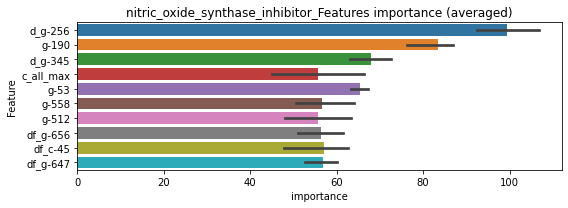

len(train_index) : 3895
len(valid_index) : 3895
================================= fold 1/2 nitric_oxide_synthase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0192061	valid_1's binary_logloss: 0.031553
[200]	training's binary_logloss: 0.00265419	valid_1's binary_logloss: 0.0112746
Early stopping, best iteration is:
[274]	training's binary_logloss: 0.000906817	valid_1's binary_logloss: 0.00917788


len(train_index) : 3895
len(valid_index) : 3895
================================= fold 2/2 nitric_oxide_synthase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0189466	valid_1's binary_logloss: 0.0279613
[200]	training's binary_logloss: 0.00274171	valid_1's binary_logloss: 0.00798515
[300]	training's binary_logloss: 0.000730234	valid_1's binary_logloss: 0.00477505
[400]	training's binary_logloss: 0.000346823	valid_1's binary_logloss: 0.00399637
Early stopping, best iteration is:
[444]	training's binary_logloss: 0.000281905	valid_1's binary_logloss: 0.00386037


nitric_oxide_synthase_inhibitor logloss: 0.006519127870218091
norepinephrine_reuptake_inhibitor, len(trt): 7, len(othr): 3287, target_rate: 0.0002939 → Adj_target_rate: 0.0004391


neg labels: 3289 → selected neg labels: 3287


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0164778	valid_1's binary_logloss: 0.0181686
[200]	training's binary_logloss: 0.00148264	valid_1's binary_logloss: 0.00205819
[300]	training's binary_logloss: 0.000413984	valid_1's binary_logloss: 0.000623912
[400]	training's binary_logloss: 0.000248932	valid_1's binary_logloss: 0.000391816
Early stopping, best iteration is:
[467]	training's binary_logloss: 0.000229203	valid_1's binary_logloss: 0.000363358
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0165419	valid_1's binary_logloss: 0.0182857
[200]	training's binary_logloss: 0.00148677	valid_1's binary_logloss: 0.00206846
[300]	training's binary_logloss: 0.00041376	valid_1's binary_logloss: 0.00065866
[400]	training's binary_logloss: 0.000247018	valid_1's binary_logloss: 0.000415534
[500]	training's binary_logloss: 0.000225608	valid_1's binary_logloss: 0.000385152
Early stopping, best iterat

1 / 3 AUC score:1.000
Threshold: 0.0006758, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → positive_corect_labels: 657/3812
p_label_rate: 0.0359116 Vs.target_rate: 0.00029, Num_p_label: 143.0, conf_0:0.00013, conf_1:0.00074
Num_p_label: 143.0, Expected: 1.2, Adj_threshold_1: 0.0006758
Num_p_label: 8.0, Expected: 1.2, Adj_threshold_2: 0.0056758
Num_p_label: 2.0, Expected: 1.2, Adj_threshold_3: 0.0106758
threshold: 0.0106758, positive p_label: 2.0/3982, p_label_rate: 0.0005023
positive y_label: 657.0/3812, y_label_rate: 0.1723505
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0166229	valid_1's binary_logloss: 0.018116
[200]	training's binary_logloss: 0.0014513	valid_1's binary_logloss: 0.00194293
[300]	training's binary_logloss: 0.00039951	valid_1's binary_logloss: 0.000590087
[400]	training's binary_logloss: 0.00024241	valid_1's binary_logloss: 0.000375182
[500]	training's binary_logloss: 0.000219023	valid_1's binary_logloss: 0.00034321
Early stopping, best iteration is:
[502]	training's binary_logloss: 0.000218906	valid_1's binary_logloss: 0.000343054
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0167784	valid_1's binary_logloss: 0.0177556
[200]	training's binary_logloss: 0.00147577	valid_1's binary_logloss: 0.00168739
[300]	training's binary_logloss: 0.000408129	valid_1's binary_logloss: 0.00048436
[400]	training's binary_logloss: 0.00024908	valid_1's binary_logloss: 0.00029936


2 / 3 AUC score:1.000
Threshold: 0.0106758, pos_neg_ratio: 0.8000000


Early stopping, best iteration is:
[456]	training's binary_logloss: 0.000229414	valid_1's binary_logloss: 0.000276087


Remove_noisy_labels: 0 → positive_corect_labels: 657.0/3812
p_label_rate: 0.0045203 Vs.target_rate: 0.00029, Num_p_label: 18.0, conf_0:0.00015, conf_1:0.01174
Num_p_label: 18.0, Expected: 1.2, Adj_threshold_1: 0.0106758
Num_p_label: 12.0, Expected: 1.2, Adj_threshold_2: 0.0156758
Num_p_label: 8.0, Expected: 1.2, Adj_threshold_3: 0.0206758
Num_p_label: 4.0, Expected: 1.2, Adj_threshold_4: 0.0256758
Num_p_label: 3.0, Expected: 1.2, Adj_threshold_5: 0.0306758
Num_p_label: 3.0, Expected: 1.2, Adj_threshold_6: 0.0356758
Num_p_label: 3.0, Expected: 1.2, Adj_threshold_7: 0.0406758
Num_p_label: 3.0, Expected: 1.2, Adj_threshold_8: 0.0456758
Num_p_label: 2.0, Expected: 1.2, Adj_threshold_9: 0.0506758
threshold: 0.0506758, positive p_label: 2.0/3982, p_label_rate: 0.0005023
positive y_label: 657.0/3812, y_label_rate: 0.1723505
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0166229	valid_1's binary_logloss: 0.018116
[200]	training's binary_logloss: 0.0014513	valid_1's binary_logloss: 0.00194293
[300]	training's binary_logloss: 0.00039951	valid_1's binary_logloss: 0.000590087
[400]	training's binary_logloss: 0.00024241	valid_1's binary_logloss: 0.000375182
[500]	training's binary_logloss: 0.000219023	valid_1's binary_logloss: 0.00034321
Early stopping, best iteration is:
[502]	training's binary_logloss: 0.000218906	valid_1's binary_logloss: 0.000343054
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0167784	valid_1's binary_logloss: 0.0177556
[200]	training's binary_logloss: 0.00147577	valid_1's binary_logloss: 0.00168739
[300]	training's binary_logloss: 0.000408129	valid_1's binary_logloss: 0.00048436
[400]	training's binary_logloss: 0.00024908	valid_1's binary_logloss: 0.00029936


3 / 3 AUC score:1.000
Threshold: 0.0506758, pos_neg_ratio: 0.8000000


Early stopping, best iteration is:
[456]	training's binary_logloss: 0.000229414	valid_1's binary_logloss: 0.000276087


Remove_noisy_labels: 0 → positive_corect_labels: 657.0/3812
p_label_rate: 0.0005023 Vs.target_rate: 0.00029, Num_p_label: 2.0, conf_0:0.00015, conf_1:0.05574
threshold: 0.0506758, positive p_label: 2.0/3982, p_label_rate: 0.0005023
positive y_label: 659.0/7794, y_label_rate: 0.0845522


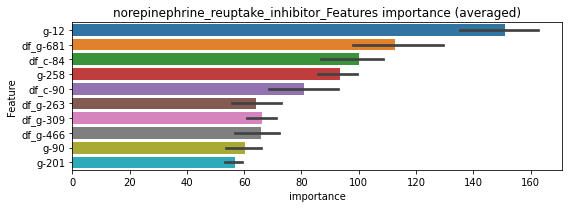

len(train_index) : 3897
len(valid_index) : 3897
================================= fold 1/2 norepinephrine_reuptake_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0088079	valid_1's binary_logloss: 0.00993133
[200]	training's binary_logloss: 0.000764475	valid_1's binary_logloss: 0.00171538
[300]	training's binary_logloss: 0.000207357	valid_1's binary_logloss: 0.00127475
Early stopping, best iteration is:
[312]	training's binary_logloss: 0.000189026	valid_1's binary_logloss: 0.00126356


len(train_index) : 3897
len(valid_index) : 3897
================================= fold 2/2 norepinephrine_reuptake_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.00882919	valid_1's binary_logloss: 0.0123922
[200]	training's binary_logloss: 0.000770696	valid_1's binary_logloss: 0.00326033
[300]	training's binary_logloss: 0.000210986	valid_1's binary_logloss: 0.00232102
Early stopping, best iteration is:
[360]	training's binary_logloss: 0.000143526	valid_1's binary_logloss: 0.00215609


norepinephrine_reuptake_inhibitor logloss: 0.001709826981460491
nrf2_activator, len(trt): 18, len(othr): 3286, target_rate: 0.0007559 → Adj_target_rate: 0.0009799


neg labels: 3289 → selected neg labels: 3286


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0205654	valid_1's binary_logloss: 0.025988
[200]	training's binary_logloss: 0.00217442	valid_1's binary_logloss: 0.00568557
[300]	training's binary_logloss: 0.000609727	valid_1's binary_logloss: 0.00321325
[400]	training's binary_logloss: 0.000340051	valid_1's binary_logloss: 0.0025968
Early stopping, best iteration is:
[435]	training's binary_logloss: 0.00031082	valid_1's binary_logloss: 0.00246806
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0203982	valid_1's binary_logloss: 0.0245359
[200]	training's binary_logloss: 0.0022082	valid_1's binary_logloss: 0.00486353
[300]	training's binary_logloss: 0.000626631	valid_1's binary_logloss: 0.00307566
Early stopping, best iteration is:
[301]	training's binary_logloss: 0.000620796	valid_1's binary_logloss: 0.00307399


1 / 3 AUC score:1.000
Threshold: 0.0013927, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → positive_corect_labels: 657/3811
p_label_rate: 0.0675540 Vs.target_rate: 0.00076, Num_p_label: 269.0, conf_0:0.00024, conf_1:0.00153
Num_p_label: 269.0, Expected: 3.0, Adj_threshold_1: 0.0013927
Num_p_label: 133.0, Expected: 3.0, Adj_threshold_2: 0.0063927
Num_p_label: 119.0, Expected: 3.0, Adj_threshold_3: 0.0113927
Num_p_label: 113.0, Expected: 3.0, Adj_threshold_4: 0.0163927
Num_p_label: 109.0, Expected: 3.0, Adj_threshold_5: 0.0213927
Num_p_label: 101.0, Expected: 3.0, Adj_threshold_6: 0.0263927
Num_p_label: 94.0, Expected: 3.0, Adj_threshold_7: 0.0313927
Num_p_label: 93.0, Expected: 3.0, Adj_threshold_8: 0.0363927
Num_p_label: 89.0, Expected: 3.0, Adj_threshold_9: 0.0413927
Num_p_label: 87.0, Expected: 3.0, Adj_threshold_10: 0.0463927
threshold: 0.0513927, positive p_label: 84.0/3982, p_label_rate: 0.0210949
positive y_label: 657.0/3811, y_label_rate: 0.1723957
================= Pseudo 

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0200117	valid_1's binary_logloss: 0.0235672
[200]	training's binary_logloss: 0.00197298	valid_1's binary_logloss: 0.00301656
[300]	training's binary_logloss: 0.000551389	valid_1's binary_logloss: 0.00106115
[400]	training's binary_logloss: 0.000306914	valid_1's binary_logloss: 0.000651396
Early stopping, best iteration is:
[460]	training's binary_logloss: 0.000279625	valid_1's binary_logloss: 0.00060512
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0195251	valid_1's binary_logloss: 0.0223525
[200]	training's binary_logloss: 0.00193593	valid_1's binary_logloss: 0.00253268
[300]	training's binary_logloss: 0.000541969	valid_1's binary_logloss: 0.000821522
[400]	training's binary_logloss: 0.000304435	valid_1's binary_logloss: 0.000493342
[500]	training's binary_logloss: 0.000276421	valid_1's binary_logloss: 0.000458425
Early stopping, best iterat

2 / 3 AUC score:1.000
Threshold: 0.0513927, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 1 → positive_corect_labels: 657.0/3810
p_label_rate: 0.0303867 Vs.target_rate: 0.00076, Num_p_label: 121.0, conf_0:0.00018, conf_1:0.05653
Num_p_label: 121.0, Expected: 3.0, Adj_threshold_1: 0.0513927
Num_p_label: 120.0, Expected: 3.0, Adj_threshold_2: 0.0563927
Num_p_label: 118.0, Expected: 3.0, Adj_threshold_3: 0.0613927
Num_p_label: 118.0, Expected: 3.0, Adj_threshold_4: 0.0663927
Num_p_label: 117.0, Expected: 3.0, Adj_threshold_5: 0.0713927
Num_p_label: 117.0, Expected: 3.0, Adj_threshold_6: 0.0763927
Num_p_label: 116.0, Expected: 3.0, Adj_threshold_7: 0.0813927
Num_p_label: 116.0, Expected: 3.0, Adj_threshold_8: 0.0863927
Num_p_label: 116.0, Expected: 3.0, Adj_threshold_9: 0.0913927
Num_p_label: 115.0, Expected: 3.0, Adj_threshold_10: 0.0963927
threshold: 0.1013927, positive p_label: 114.0/3982, p_label_rate: 0.0286288
positive y_label: 657.0/3810, y_label_rate: 0.1724409
================= Ps

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0199952	valid_1's binary_logloss: 0.0234658
[200]	training's binary_logloss: 0.0019766	valid_1's binary_logloss: 0.00272053
[300]	training's binary_logloss: 0.000554115	valid_1's binary_logloss: 0.000856958
[400]	training's binary_logloss: 0.00030891	valid_1's binary_logloss: 0.000511672
Early stopping, best iteration is:
[455]	training's binary_logloss: 0.000277866	valid_1's binary_logloss: 0.000466693
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.019717	valid_1's binary_logloss: 0.0221836
[200]	training's binary_logloss: 0.00194684	valid_1's binary_logloss: 0.00257789
[300]	training's binary_logloss: 0.000547097	valid_1's binary_logloss: 0.000920056
[400]	training's binary_logloss: 0.000307291	valid_1's binary_logloss: 0.00058857
Early stopping, best iteration is:
[471]	training's binary_logloss: 0.000273721	valid_1's binary_logloss: 0.0005

3 / 3 AUC score:1.000
Threshold: 0.1013927, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → positive_corect_labels: 657.0/3810
p_label_rate: 0.0283777 Vs.target_rate: 0.00076, Num_p_label: 113.0, conf_0:0.00018, conf_1:0.11153
Num_p_label: 113.0, Expected: 3.0, Adj_threshold_1: 0.1013927
Num_p_label: 113.0, Expected: 3.0, Adj_threshold_2: 0.1063927
Num_p_label: 111.0, Expected: 3.0, Adj_threshold_3: 0.1113927
Num_p_label: 110.0, Expected: 3.0, Adj_threshold_4: 0.1163927
Num_p_label: 110.0, Expected: 3.0, Adj_threshold_5: 0.1213927
Num_p_label: 109.0, Expected: 3.0, Adj_threshold_6: 0.1263927
Num_p_label: 108.0, Expected: 3.0, Adj_threshold_7: 0.1313927
Num_p_label: 107.0, Expected: 3.0, Adj_threshold_8: 0.1363927
Num_p_label: 105.0, Expected: 3.0, Adj_threshold_9: 0.1413927
Num_p_label: 102.0, Expected: 3.0, Adj_threshold_10: 0.1463927
threshold: 0.1513927, positive p_label: 101.0/3982, p_label_rate: 0.0253641
positive y_label: 758.0/7792, y_label_rate: 0.0972793


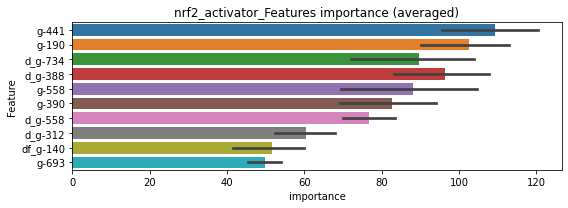

len(train_index) : 3896
len(valid_index) : 3896
================================= fold 1/2 nrf2_activator=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0129814	valid_1's binary_logloss: 0.0192809
[200]	training's binary_logloss: 0.00142599	valid_1's binary_logloss: 0.0059683
Early stopping, best iteration is:
[272]	training's binary_logloss: 0.000515501	valid_1's binary_logloss: 0.00478274


len(train_index) : 3896
len(valid_index) : 3896
================================= fold 2/2 nrf2_activator=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0128636	valid_1's binary_logloss: 0.020297
[200]	training's binary_logloss: 0.00143603	valid_1's binary_logloss: 0.00624074
[300]	training's binary_logloss: 0.000391069	valid_1's binary_logloss: 0.00421342
Early stopping, best iteration is:
[389]	training's binary_logloss: 0.000217445	valid_1's binary_logloss: 0.00369167


nrf2_activator logloss: 0.004237207451018605
opioid_receptor_agonist, len(trt): 61, len(othr): 3279, target_rate: 0.0025615 → Adj_target_rate: 0.0027652


neg labels: 3289 → selected neg labels: 3279


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0545498	valid_1's binary_logloss: 0.0960873
[200]	training's binary_logloss: 0.0114863	valid_1's binary_logloss: 0.0449975
[300]	training's binary_logloss: 0.00322718	valid_1's binary_logloss: 0.0298541
[400]	training's binary_logloss: 0.00145715	valid_1's binary_logloss: 0.0251181
[500]	training's binary_logloss: 0.00088366	valid_1's binary_logloss: 0.0233745
Early stopping, best iteration is:
[546]	training's binary_logloss: 0.000757471	valid_1's binary_logloss: 0.0228709
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0542295	valid_1's binary_logloss: 0.0937666
[200]	training's binary_logloss: 0.0119197	valid_1's binary_logloss: 0.0395732
[300]	training's binary_logloss: 0.00338254	valid_1's binary_logloss: 0.0238729
[400]	training's binary_logloss: 0.00150991	valid_1's binary_logloss: 0.0191356
[500]	training's binary_logloss: 0.000908751	v

1 / 3 AUC score:1.000
Threshold: 0.0069017, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → positive_corect_labels: 655/3802
p_label_rate: 0.0369161 Vs.target_rate: 0.00256, Num_p_label: 147.0, conf_0:0.00096, conf_1:0.00759
Num_p_label: 147.0, Expected: 10.2, Adj_threshold_1: 0.0069017
Num_p_label: 63.0, Expected: 10.2, Adj_threshold_2: 0.0119017
Num_p_label: 34.0, Expected: 10.2, Adj_threshold_3: 0.0169017
Num_p_label: 20.0, Expected: 10.2, Adj_threshold_4: 0.0219017
threshold: 0.0219017, positive p_label: 20.0/3982, p_label_rate: 0.0050226
positive y_label: 655.0/3802, y_label_rate: 0.1722777
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0533626	valid_1's binary_logloss: 0.0931354
[200]	training's binary_logloss: 0.0111858	valid_1's binary_logloss: 0.0412331
[300]	training's binary_logloss: 0.00315628	valid_1's binary_logloss: 0.0266381
[400]	training's binary_logloss: 0.00140964	valid_1's binary_logloss: 0.0226589
[500]	training's binary_logloss: 0.000858281	valid_1's binary_logloss: 0.0209524
Early stopping, best iteration is:
[568]	training's binary_logloss: 0.00068545	valid_1's binary_logloss: 0.0202312
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.054078	valid_1's binary_logloss: 0.0888923
[200]	training's binary_logloss: 0.0115116	valid_1's binary_logloss: 0.0364702
[300]	training's binary_logloss: 0.00330338	valid_1's binary_logloss: 0.0221552
[400]	training's binary_logloss: 0.0014936	valid_1's binary_logloss: 0.017754
[500]	training's binary_logloss: 0.000912807	vali

2 / 3 AUC score:1.000
Threshold: 0.0219017, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 9 → positive_corect_labels: 653.0/3793
p_label_rate: 0.0128076 Vs.target_rate: 0.00256, Num_p_label: 51.0, conf_0:0.00094, conf_1:0.02409
Num_p_label: 51.0, Expected: 10.2, Adj_threshold_1: 0.0219017
Num_p_label: 39.0, Expected: 10.2, Adj_threshold_2: 0.0269017
Num_p_label: 33.0, Expected: 10.2, Adj_threshold_3: 0.0319017
Num_p_label: 28.0, Expected: 10.2, Adj_threshold_4: 0.0369017
Num_p_label: 23.0, Expected: 10.2, Adj_threshold_5: 0.0419017
Num_p_label: 20.0, Expected: 10.2, Adj_threshold_6: 0.0469017
threshold: 0.0469017, positive p_label: 20.0/3982, p_label_rate: 0.0050226
positive y_label: 653.0/3793, y_label_rate: 0.1721592
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0527967	valid_1's binary_logloss: 0.0902003
[200]	training's binary_logloss: 0.0110222	valid_1's binary_logloss: 0.0383698
[300]	training's binary_logloss: 0.00317803	valid_1's binary_logloss: 0.0237176
[400]	training's binary_logloss: 0.00145019	valid_1's binary_logloss: 0.0196283
[500]	training's binary_logloss: 0.000888906	valid_1's binary_logloss: 0.0173867
Early stopping, best iteration is:
[564]	training's binary_logloss: 0.000714599	valid_1's binary_logloss: 0.0165477
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0515182	valid_1's binary_logloss: 0.0933339
[200]	training's binary_logloss: 0.0108518	valid_1's binary_logloss: 0.0453218
[300]	training's binary_logloss: 0.00312015	valid_1's binary_logloss: 0.0350102
Early stopping, best iteration is:
[361]	training's binary_logloss: 0.00183688	valid_1's binary_logloss: 0.0332416


3 / 3 AUC score:0.999
Threshold: 0.0469017, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 13 → positive_corect_labels: 643.0/3780
p_label_rate: 0.0070316 Vs.target_rate: 0.00256, Num_p_label: 28.0, conf_0:0.00167, conf_1:0.05159
threshold: 0.0469017, positive p_label: 28.0/3982, p_label_rate: 0.0070316
positive y_label: 671.0/7762, y_label_rate: 0.0864468


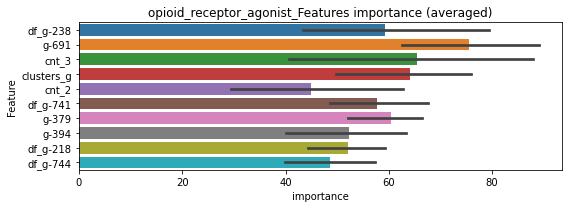

len(train_index) : 3881
len(valid_index) : 3881
================================= fold 1/2 opioid_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0304482	valid_1's binary_logloss: 0.0625678
[200]	training's binary_logloss: 0.00614581	valid_1's binary_logloss: 0.0366638
[300]	training's binary_logloss: 0.00169243	valid_1's binary_logloss: 0.0328559
Early stopping, best iteration is:
[297]	training's binary_logloss: 0.00175218	valid_1's binary_logloss: 0.0327575


len(train_index) : 3881
len(valid_index) : 3881
================================= fold 2/2 opioid_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.032797	valid_1's binary_logloss: 0.0578037
[200]	training's binary_logloss: 0.00662098	valid_1's binary_logloss: 0.0294226
[300]	training's binary_logloss: 0.00194284	valid_1's binary_logloss: 0.0232492
Early stopping, best iteration is:
[382]	training's binary_logloss: 0.000962539	valid_1's binary_logloss: 0.0210426


opioid_receptor_agonist logloss: 0.026900048691918855


  acetylcholine_receptor_agonist acetylcholine_receptor_antagonist  \
0                       df_g-122                              c-30   
1                  clusters_df_c                         c_all_max   
2                          cnt_0                    clusters_g_all   
3                      c_all_min                          df_g-707   
4                        df_g-51                        clusters_g   
5                       df_c_min                          df_c_min   
6                          cnt_2                             g-514   
7                       df_g-736                          df_g-640   
8                          g-244                            df_c-6   
9                           c-73                          df_g-597   

  acetylcholinesterase_inhibitor adenosine_receptor_antagonist  \
0                      c_all_max                clusters_c_all   
1                      c_all_min                      df_c_min   
2                 clusters_g_al

opioid_receptor_antagonist, len(trt): 96, len(othr): 3275, target_rate: 0.0040312 → Adj_target_rate: 0.0040656


neg labels: 3289 → selected neg labels: 3275


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0589694	valid_1's binary_logloss: 0.12873
[200]	training's binary_logloss: 0.0139662	valid_1's binary_logloss: 0.0763087
[300]	training's binary_logloss: 0.00456441	valid_1's binary_logloss: 0.0586719
[400]	training's binary_logloss: 0.00207808	valid_1's binary_logloss: 0.053407
[500]	training's binary_logloss: 0.00126578	valid_1's binary_logloss: 0.0507265
Early stopping, best iteration is:
[535]	training's binary_logloss: 0.00111109	valid_1's binary_logloss: 0.0500481
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0641446	valid_1's binary_logloss: 0.133703
[200]	training's binary_logloss: 0.0168997	valid_1's binary_logloss: 0.0843628
[300]	training's binary_logloss: 0.0052432	valid_1's binary_logloss: 0.0706591
[400]	training's binary_logloss: 0.00230931	valid_1's binary_logloss: 0.0670353
Early stopping, best iteration is:
[440]	training's 

1 / 3 AUC score:0.996
Threshold: 0.0132175, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 157 → positive_corect_labels: 642/3773
p_label_rate: 0.0356605 Vs.target_rate: 0.00403, Num_p_label: 142.0, conf_0:0.00209, conf_1:0.01454
Num_p_label: 142.0, Expected: 16.1, Adj_threshold_1: 0.0132175
Num_p_label: 81.0, Expected: 16.1, Adj_threshold_2: 0.0182175
Num_p_label: 48.0, Expected: 16.1, Adj_threshold_3: 0.0232175
Num_p_label: 34.0, Expected: 16.1, Adj_threshold_4: 0.0282175
Num_p_label: 22.0, Expected: 16.1, Adj_threshold_5: 0.0332175
threshold: 0.0332175, positive p_label: 22.0/3982, p_label_rate: 0.0055249
positive y_label: 642.0/3773, y_label_rate: 0.1701564
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0539615	valid_1's binary_logloss: 0.131212
[200]	training's binary_logloss: 0.0123488	valid_1's binary_logloss: 0.0820008
[300]	training's binary_logloss: 0.00387567	valid_1's binary_logloss: 0.0681708
[400]	training's binary_logloss: 0.0018148	valid_1's binary_logloss: 0.064674
Early stopping, best iteration is:
[397]	training's binary_logloss: 0.00185249	valid_1's binary_logloss: 0.0645955
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.061697	valid_1's binary_logloss: 0.117099
[200]	training's binary_logloss: 0.0143655	valid_1's binary_logloss: 0.0632454
[300]	training's binary_logloss: 0.0045427	valid_1's binary_logloss: 0.0483338
[400]	training's binary_logloss: 0.00207238	valid_1's binary_logloss: 0.0432737
[500]	training's binary_logloss: 0.00124785	valid_1's binary_logloss: 0.0409734
Early stopping, best iteration is:
[499]	training's b

2 / 3 AUC score:0.998
Threshold: 0.0332175, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 32 → positive_corect_labels: 629.0/3741
p_label_rate: 0.0168257 Vs.target_rate: 0.00403, Num_p_label: 67.0, conf_0:0.00233, conf_1:0.03654
Num_p_label: 67.0, Expected: 16.1, Adj_threshold_1: 0.0332175
Num_p_label: 54.0, Expected: 16.1, Adj_threshold_2: 0.0382175
Num_p_label: 45.0, Expected: 16.1, Adj_threshold_3: 0.0432175
Num_p_label: 35.0, Expected: 16.1, Adj_threshold_4: 0.0482175
Num_p_label: 32.0, Expected: 16.1, Adj_threshold_5: 0.0532175
threshold: 0.0532175, positive p_label: 32.0/3982, p_label_rate: 0.0080362
positive y_label: 629.0/3741, y_label_rate: 0.1681369
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0534083	valid_1's binary_logloss: 0.1209
[200]	training's binary_logloss: 0.011933	valid_1's binary_logloss: 0.070443
[300]	training's binary_logloss: 0.00368303	valid_1's binary_logloss: 0.058735
[400]	training's binary_logloss: 0.00172713	valid_1's binary_logloss: 0.0547805
Early stopping, best iteration is:
[425]	training's binary_logloss: 0.00150045	valid_1's binary_logloss: 0.0536259
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0584813	valid_1's binary_logloss: 0.107224
[200]	training's binary_logloss: 0.0135823	valid_1's binary_logloss: 0.0498425
[300]	training's binary_logloss: 0.00429356	valid_1's binary_logloss: 0.0328298
[400]	training's binary_logloss: 0.00197822	valid_1's binary_logloss: 0.0259698
Early stopping, best iteration is:
[489]	training's binary_logloss: 0.00125803	valid_1's binary_logloss: 0.0238599


3 / 3 AUC score:1.000
Threshold: 0.0532175, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 9 → positive_corect_labels: 624.0/3732
p_label_rate: 0.0072828 Vs.target_rate: 0.00403, Num_p_label: 29.0, conf_0:0.00216, conf_1:0.05854
threshold: 0.0532175, positive p_label: 29.0/3982, p_label_rate: 0.0072828
positive y_label: 653.0/7714, y_label_rate: 0.0846513


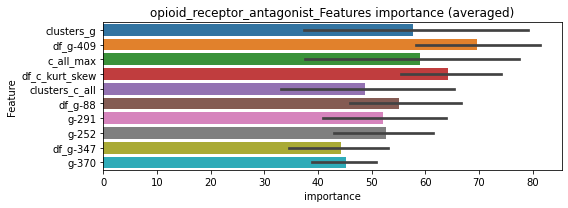

len(train_index) : 3857
len(valid_index) : 3857
================================= fold 1/2 opioid_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.031417	valid_1's binary_logloss: 0.0811342
[200]	training's binary_logloss: 0.00706484	valid_1's binary_logloss: 0.0535058
[300]	training's binary_logloss: 0.00220019	valid_1's binary_logloss: 0.0473295
[400]	training's binary_logloss: 0.000997502	valid_1's binary_logloss: 0.0456371
Early stopping, best iteration is:
[416]	training's binary_logloss: 0.000904399	valid_1's binary_logloss: 0.0453561


len(train_index) : 3857
len(valid_index) : 3857
================================= fold 2/2 opioid_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0327998	valid_1's binary_logloss: 0.0708338
[200]	training's binary_logloss: 0.00749439	valid_1's binary_logloss: 0.0422435
[300]	training's binary_logloss: 0.00241133	valid_1's binary_logloss: 0.0354267
Early stopping, best iteration is:
[371]	training's binary_logloss: 0.00132677	valid_1's binary_logloss: 0.0337617


opioid_receptor_antagonist logloss: 0.039558888237268185


  acetylcholine_receptor_agonist acetylcholine_receptor_antagonist  \
0                       df_g-122                              c-30   
1                  clusters_df_c                         c_all_max   
2                          cnt_0                    clusters_g_all   
3                      c_all_min                          df_g-707   
4                        df_g-51                        clusters_g   
5                       df_c_min                          df_c_min   
6                          cnt_2                             g-514   
7                       df_g-736                          df_g-640   
8                          g-244                            df_c-6   
9                           c-73                          df_g-597   

  acetylcholinesterase_inhibitor adenosine_receptor_antagonist  \
0                      c_all_max                clusters_c_all   
1                      c_all_min                      df_c_min   
2                 clusters_g_al

orexin_receptor_antagonist, len(trt): 37, len(othr): 3283, target_rate: 0.0015537 → Adj_target_rate: 0.0018079


neg labels: 3289 → selected neg labels: 3283


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0381881	valid_1's binary_logloss: 0.0616047
[200]	training's binary_logloss: 0.00600734	valid_1's binary_logloss: 0.0202816
[300]	training's binary_logloss: 0.0016802	valid_1's binary_logloss: 0.0123941
[400]	training's binary_logloss: 0.000814959	valid_1's binary_logloss: 0.0101291
[500]	training's binary_logloss: 0.000535371	valid_1's binary_logloss: 0.00915635
Early stopping, best iteration is:
[532]	training's binary_logloss: 0.000500827	valid_1's binary_logloss: 0.00905487
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0384643	valid_1's binary_logloss: 0.0589819
[200]	training's binary_logloss: 0.00665448	valid_1's binary_logloss: 0.0170009
[300]	training's binary_logloss: 0.00181153	valid_1's binary_logloss: 0.007499
[400]	training's binary_logloss: 0.000859669	valid_1's binary_logloss: 0.00526472
[500]	training's binary_logloss: 0.00055

1 / 3 AUC score:1.000
Threshold: 0.0034290, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → positive_corect_labels: 656/3807
p_label_rate: 0.0328980 Vs.target_rate: 0.00155, Num_p_label: 131.0, conf_0:0.00040, conf_1:0.00377
Num_p_label: 131.0, Expected: 6.2, Adj_threshold_1: 0.0034290
Num_p_label: 24.0, Expected: 6.2, Adj_threshold_2: 0.0084290
Num_p_label: 9.0, Expected: 6.2, Adj_threshold_3: 0.0134290
threshold: 0.0134290, positive p_label: 9.0/3982, p_label_rate: 0.0022602
positive y_label: 656.0/3807, y_label_rate: 0.1723142
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0383087	valid_1's binary_logloss: 0.0592901
[200]	training's binary_logloss: 0.00602939	valid_1's binary_logloss: 0.0183549
[300]	training's binary_logloss: 0.001683	valid_1's binary_logloss: 0.0100921
[400]	training's binary_logloss: 0.000814912	valid_1's binary_logloss: 0.0079228
[500]	training's binary_logloss: 0.000536365	valid_1's binary_logloss: 0.00711823
Early stopping, best iteration is:
[523]	training's binary_logloss: 0.000508411	valid_1's binary_logloss: 0.00702924
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0378358	valid_1's binary_logloss: 0.0594623
[200]	training's binary_logloss: 0.00609631	valid_1's binary_logloss: 0.0151856
[300]	training's binary_logloss: 0.00173766	valid_1's binary_logloss: 0.00665796
[400]	training's binary_logloss: 0.000838014	valid_1's binary_logloss: 0.00431206
[500]	training's binary_logloss: 0.0005

2 / 3 AUC score:1.000
Threshold: 0.0134290, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 4 → positive_corect_labels: 656.0/3803
p_label_rate: 0.0087896 Vs.target_rate: 0.00155, Num_p_label: 35.0, conf_0:0.00048, conf_1:0.01477
Num_p_label: 35.0, Expected: 6.2, Adj_threshold_1: 0.0134290
Num_p_label: 19.0, Expected: 6.2, Adj_threshold_2: 0.0184290
Num_p_label: 13.0, Expected: 6.2, Adj_threshold_3: 0.0234290
Num_p_label: 11.0, Expected: 6.2, Adj_threshold_4: 0.0284290
threshold: 0.0284290, positive p_label: 11.0/3982, p_label_rate: 0.0027624
positive y_label: 656.0/3803, y_label_rate: 0.1724954
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0365282	valid_1's binary_logloss: 0.0574125
[200]	training's binary_logloss: 0.00575055	valid_1's binary_logloss: 0.0172193
[300]	training's binary_logloss: 0.00162409	valid_1's binary_logloss: 0.00900452
[400]	training's binary_logloss: 0.000797333	valid_1's binary_logloss: 0.00685909
[500]	training's binary_logloss: 0.000527515	valid_1's binary_logloss: 0.00594997
Early stopping, best iteration is:
[490]	training's binary_logloss: 0.000541913	valid_1's binary_logloss: 0.00592557
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0384733	valid_1's binary_logloss: 0.0598894
[200]	training's binary_logloss: 0.00637898	valid_1's binary_logloss: 0.0159052
[300]	training's binary_logloss: 0.00178107	valid_1's binary_logloss: 0.00694255
[400]	training's binary_logloss: 0.000853649	valid_1's binary_logloss: 0.00452917
[500]	training's binary_logloss: 0.

3 / 3 AUC score:1.000
Threshold: 0.0284290, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 1 → positive_corect_labels: 656.0/3802
p_label_rate: 0.0030136 Vs.target_rate: 0.00155, Num_p_label: 12.0, conf_0:0.00048, conf_1:0.03127
threshold: 0.0284290, positive p_label: 12.0/3982, p_label_rate: 0.0030136
positive y_label: 668.0/7784, y_label_rate: 0.0858171


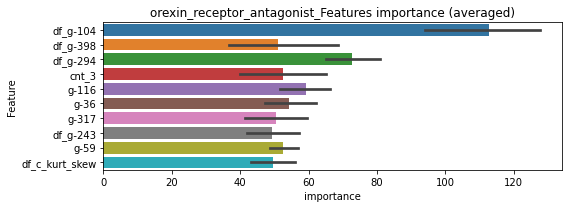

len(train_index) : 3892
len(valid_index) : 3892
================================= fold 1/2 orexin_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0210312	valid_1's binary_logloss: 0.0382116
[200]	training's binary_logloss: 0.00335138	valid_1's binary_logloss: 0.0172676
[300]	training's binary_logloss: 0.000918921	valid_1's binary_logloss: 0.0136912
Early stopping, best iteration is:
[354]	training's binary_logloss: 0.000577115	valid_1's binary_logloss: 0.0132411


len(train_index) : 3892
len(valid_index) : 3892
================================= fold 2/2 orexin_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0218507	valid_1's binary_logloss: 0.0396368
[200]	training's binary_logloss: 0.00370311	valid_1's binary_logloss: 0.0169991
[300]	training's binary_logloss: 0.00101208	valid_1's binary_logloss: 0.0121398
[400]	training's binary_logloss: 0.000472482	valid_1's binary_logloss: 0.0107503
Early stopping, best iteration is:
[426]	training's binary_logloss: 0.000413201	valid_1's binary_logloss: 0.0105211


orexin_receptor_antagonist logloss: 0.01188109393524795
p38_mapk_inhibitor, len(trt): 62, len(othr): 3278, target_rate: 0.0026035 → Adj_target_rate: 0.0028037


neg labels: 3289 → selected neg labels: 3278


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0351396	valid_1's binary_logloss: 0.0619581
[200]	training's binary_logloss: 0.00563451	valid_1's binary_logloss: 0.0201885
[300]	training's binary_logloss: 0.00166391	valid_1's binary_logloss: 0.0114863
[400]	training's binary_logloss: 0.000822599	valid_1's binary_logloss: 0.00876704
[500]	training's binary_logloss: 0.000543491	valid_1's binary_logloss: 0.00776001
[600]	training's binary_logloss: 0.000453854	valid_1's binary_logloss: 0.0074202
Early stopping, best iteration is:
[596]	training's binary_logloss: 0.000456035	valid_1's binary_logloss: 0.0074192
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0333401	valid_1's binary_logloss: 0.077168
[200]	training's binary_logloss: 0.00508564	valid_1's binary_logloss: 0.042559
[300]	training's binary_logloss: 0.00149909	valid_1's binary_logloss: 0.036816
Early stopping, best iteration is:
[290]	t

1 / 3 AUC score:0.998
Threshold: 0.0074400, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 140 → positive_corect_labels: 651/3793
p_label_rate: 0.0441989 Vs.target_rate: 0.00260, Num_p_label: 176.0, conf_0:0.00080, conf_1:0.00818
Num_p_label: 176.0, Expected: 10.4, Adj_threshold_1: 0.0074400
Num_p_label: 103.0, Expected: 10.4, Adj_threshold_2: 0.0124400
Num_p_label: 67.0, Expected: 10.4, Adj_threshold_3: 0.0174400
Num_p_label: 50.0, Expected: 10.4, Adj_threshold_4: 0.0224400
Num_p_label: 43.0, Expected: 10.4, Adj_threshold_5: 0.0274400
Num_p_label: 36.0, Expected: 10.4, Adj_threshold_6: 0.0324400
Num_p_label: 32.0, Expected: 10.4, Adj_threshold_7: 0.0374400
Num_p_label: 29.0, Expected: 10.4, Adj_threshold_8: 0.0424400
Num_p_label: 29.0, Expected: 10.4, Adj_threshold_9: 0.0474400
Num_p_label: 29.0, Expected: 10.4, Adj_threshold_10: 0.0524400
threshold: 0.0574400, positive p_label: 26.0/3982, p_label_rate: 0.0065294
positive y_label: 651.0/3793, y_label_rate: 0.1716320
================= P

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0341962	valid_1's binary_logloss: 0.0634587
[200]	training's binary_logloss: 0.00524414	valid_1's binary_logloss: 0.0206888
[300]	training's binary_logloss: 0.00151435	valid_1's binary_logloss: 0.0108669
[400]	training's binary_logloss: 0.000757982	valid_1's binary_logloss: 0.00756993
[500]	training's binary_logloss: 0.000500483	valid_1's binary_logloss: 0.00640948
[600]	training's binary_logloss: 0.000425131	valid_1's binary_logloss: 0.00603979
Early stopping, best iteration is:
[591]	training's binary_logloss: 0.000427897	valid_1's binary_logloss: 0.00602107
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0341743	valid_1's binary_logloss: 0.0527855
[200]	training's binary_logloss: 0.00516985	valid_1's binary_logloss: 0.0149358
[300]	training's binary_logloss: 0.00150852	valid_1's binary_logloss: 0.00752735
[400]	training's binary_logloss: 0.0

2 / 3 AUC score:1.000
Threshold: 0.0574400, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → positive_corect_labels: 651.0/3793
p_label_rate: 0.0100452 Vs.target_rate: 0.00260, Num_p_label: 40.0, conf_0:0.00042, conf_1:0.06318
Num_p_label: 40.0, Expected: 10.4, Adj_threshold_1: 0.0574400
Num_p_label: 39.0, Expected: 10.4, Adj_threshold_2: 0.0624400
Num_p_label: 38.0, Expected: 10.4, Adj_threshold_3: 0.0674400
Num_p_label: 37.0, Expected: 10.4, Adj_threshold_4: 0.0724400
Num_p_label: 35.0, Expected: 10.4, Adj_threshold_5: 0.0774400
Num_p_label: 31.0, Expected: 10.4, Adj_threshold_6: 0.0824400
Num_p_label: 29.0, Expected: 10.4, Adj_threshold_7: 0.0874400
Num_p_label: 28.0, Expected: 10.4, Adj_threshold_8: 0.0924400
Num_p_label: 27.0, Expected: 10.4, Adj_threshold_9: 0.0974400
Num_p_label: 27.0, Expected: 10.4, Adj_threshold_10: 0.1024400
threshold: 0.1074400, positive p_label: 26.0/3982, p_label_rate: 0.0065294
positive y_label: 651.0/3793, y_label_rate: 0.1716320
================= Pseu

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0341962	valid_1's binary_logloss: 0.0634587
[200]	training's binary_logloss: 0.00524414	valid_1's binary_logloss: 0.0206888
[300]	training's binary_logloss: 0.00151435	valid_1's binary_logloss: 0.0108669
[400]	training's binary_logloss: 0.000757982	valid_1's binary_logloss: 0.00756993
[500]	training's binary_logloss: 0.000500483	valid_1's binary_logloss: 0.00640948
[600]	training's binary_logloss: 0.000425131	valid_1's binary_logloss: 0.00603979
Early stopping, best iteration is:
[591]	training's binary_logloss: 0.000427897	valid_1's binary_logloss: 0.00602107
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0341743	valid_1's binary_logloss: 0.0527855
[200]	training's binary_logloss: 0.00516985	valid_1's binary_logloss: 0.0149358
[300]	training's binary_logloss: 0.00150852	valid_1's binary_logloss: 0.00752735
[400]	training's binary_logloss: 0.0

3 / 3 AUC score:1.000
Threshold: 0.1074400, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → positive_corect_labels: 651.0/3793
p_label_rate: 0.0065294 Vs.target_rate: 0.00260, Num_p_label: 26.0, conf_0:0.00042, conf_1:0.11818
threshold: 0.1074400, positive p_label: 26.0/3982, p_label_rate: 0.0065294
positive y_label: 677.0/7775, y_label_rate: 0.0870740


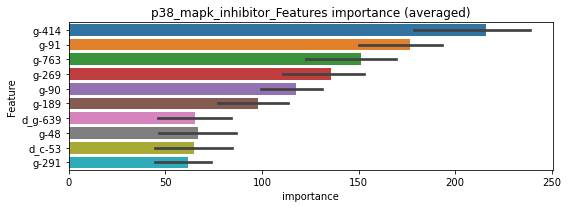

len(train_index) : 3887
len(valid_index) : 3888
================================= fold 1/2 p38_mapk_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0182919	valid_1's binary_logloss: 0.046424
[200]	training's binary_logloss: 0.00269641	valid_1's binary_logloss: 0.0240217
[300]	training's binary_logloss: 0.000805873	valid_1's binary_logloss: 0.0197614
[400]	training's binary_logloss: 0.000400462	valid_1's binary_logloss: 0.018387
Early stopping, best iteration is:
[400]	training's binary_logloss: 0.000400462	valid_1's binary_logloss: 0.018387


len(train_index) : 3888
len(valid_index) : 3887
================================= fold 2/2 p38_mapk_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0189578	valid_1's binary_logloss: 0.0361348
[200]	training's binary_logloss: 0.00287784	valid_1's binary_logloss: 0.014205
[300]	training's binary_logloss: 0.000859286	valid_1's binary_logloss: 0.0096242
[400]	training's binary_logloss: 0.000424494	valid_1's binary_logloss: 0.00829566
[500]	training's binary_logloss: 0.000282623	valid_1's binary_logloss: 0.00752713
Early stopping, best iteration is:
[520]	training's binary_logloss: 0.000265601	valid_1's binary_logloss: 0.00745318


p38_mapk_inhibitor logloss: 0.01292080426778759
p-glycoprotein_inhibitor, len(trt): 24, len(othr): 3285, target_rate: 0.0010078 → Adj_target_rate: 0.0012513


neg labels: 3289 → selected neg labels: 3285


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0323837	valid_1's binary_logloss: 0.0457919
[200]	training's binary_logloss: 0.00422649	valid_1's binary_logloss: 0.00947691
[300]	training's binary_logloss: 0.0011445	valid_1's binary_logloss: 0.00389053
[400]	training's binary_logloss: 0.000574305	valid_1's binary_logloss: 0.00249205
[500]	training's binary_logloss: 0.000408788	valid_1's binary_logloss: 0.00203809
Early stopping, best iteration is:
[515]	training's binary_logloss: 0.000401349	valid_1's binary_logloss: 0.00201412
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0329366	valid_1's binary_logloss: 0.0546022
[200]	training's binary_logloss: 0.00433484	valid_1's binary_logloss: 0.0146186
[300]	training's binary_logloss: 0.00116087	valid_1's binary_logloss: 0.00682952
[400]	training's binary_logloss: 0.000571508	valid_1's binary_logloss: 0.00484357
[500]	training's binary_logloss: 0.

1 / 3 AUC score:1.000
Threshold: 0.0025258, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → positive_corect_labels: 657/3810
p_label_rate: 0.0414365 Vs.target_rate: 0.00101, Num_p_label: 165.0, conf_0:0.00031, conf_1:0.00278
Num_p_label: 165.0, Expected: 4.0, Adj_threshold_1: 0.0025258
Num_p_label: 24.0, Expected: 4.0, Adj_threshold_2: 0.0075258
Num_p_label: 11.0, Expected: 4.0, Adj_threshold_3: 0.0125258
Num_p_label: 2.0, Expected: 4.0, Adj_threshold_4: 0.0175258
threshold: 0.0175258, positive p_label: 2.0/3982, p_label_rate: 0.0005023
positive y_label: 657.0/3810, y_label_rate: 0.1724409
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0304863	valid_1's binary_logloss: 0.0404004
[200]	training's binary_logloss: 0.00402521	valid_1's binary_logloss: 0.00805911
[300]	training's binary_logloss: 0.00111012	valid_1's binary_logloss: 0.00314453
[400]	training's binary_logloss: 0.000558937	valid_1's binary_logloss: 0.00196604
[500]	training's binary_logloss: 0.000411272	valid_1's binary_logloss: 0.00162468
Early stopping, best iteration is:
[564]	training's binary_logloss: 0.000396998	valid_1's binary_logloss: 0.00160118
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.031627	valid_1's binary_logloss: 0.0528978
[200]	training's binary_logloss: 0.00411813	valid_1's binary_logloss: 0.016639
[300]	training's binary_logloss: 0.00112333	valid_1's binary_logloss: 0.00904471
[400]	training's binary_logloss: 0.000558569	valid_1's binary_logloss: 0.00726796
[500]	training's binary_logloss: 0.0

2 / 3 AUC score:1.000
Threshold: 0.0175258, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 1 → positive_corect_labels: 657.0/3809
p_label_rate: 0.0037670 Vs.target_rate: 0.00101, Num_p_label: 15.0, conf_0:0.00034, conf_1:0.01928
Num_p_label: 15.0, Expected: 4.0, Adj_threshold_1: 0.0175258
Num_p_label: 10.0, Expected: 4.0, Adj_threshold_2: 0.0225258
Num_p_label: 7.0, Expected: 4.0, Adj_threshold_3: 0.0275258
threshold: 0.0275258, positive p_label: 7.0/3982, p_label_rate: 0.0017579
positive y_label: 657.0/3809, y_label_rate: 0.1724862
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0319894	valid_1's binary_logloss: 0.0431369
[200]	training's binary_logloss: 0.00415276	valid_1's binary_logloss: 0.00834856
[300]	training's binary_logloss: 0.00112769	valid_1's binary_logloss: 0.00297058
[400]	training's binary_logloss: 0.000561421	valid_1's binary_logloss: 0.00174989
[500]	training's binary_logloss: 0.000413354	valid_1's binary_logloss: 0.00139527
Early stopping, best iteration is:
[515]	training's binary_logloss: 0.000405286	valid_1's binary_logloss: 0.00137622
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0313536	valid_1's binary_logloss: 0.0536773
[200]	training's binary_logloss: 0.0040847	valid_1's binary_logloss: 0.0175796
[300]	training's binary_logloss: 0.00111709	valid_1's binary_logloss: 0.0101906
[400]	training's binary_logloss: 0.000560499	valid_1's binary_logloss: 0.00819089
[500]	training's binary_logloss: 0.0

3 / 3 AUC score:1.000
Threshold: 0.0275258, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 1 → positive_corect_labels: 656.0/3808
p_label_rate: 0.0022602 Vs.target_rate: 0.00101, Num_p_label: 9.0, conf_0:0.00033, conf_1:0.03028
threshold: 0.0275258, positive p_label: 9.0/3982, p_label_rate: 0.0022602
positive y_label: 665.0/7790, y_label_rate: 0.0853659


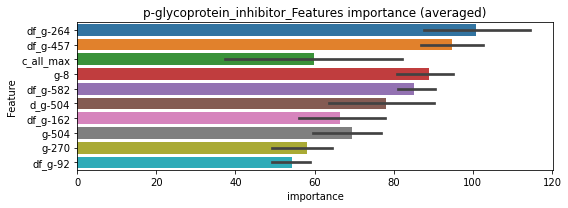

len(train_index) : 3895
len(valid_index) : 3895
================================= fold 1/2 p-glycoprotein_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0185411	valid_1's binary_logloss: 0.0279181
[200]	training's binary_logloss: 0.00242684	valid_1's binary_logloss: 0.0100485
[300]	training's binary_logloss: 0.000637635	valid_1's binary_logloss: 0.00835387
Early stopping, best iteration is:
[321]	training's binary_logloss: 0.000524556	valid_1's binary_logloss: 0.00825829


len(train_index) : 3895
len(valid_index) : 3895
================================= fold 2/2 p-glycoprotein_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0184813	valid_1's binary_logloss: 0.0301347
[200]	training's binary_logloss: 0.00240622	valid_1's binary_logloss: 0.0105933
[300]	training's binary_logloss: 0.000638064	valid_1's binary_logloss: 0.0076999
Early stopping, best iteration is:
[292]	training's binary_logloss: 0.000691657	valid_1's binary_logloss: 0.00768355


p-glycoprotein_inhibitor logloss: 0.007970922926955842
parp_inhibitor, len(trt): 61, len(othr): 3279, target_rate: 0.0025615 → Adj_target_rate: 0.0027652


neg labels: 3289 → selected neg labels: 3279


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0443203	valid_1's binary_logloss: 0.0810756
[200]	training's binary_logloss: 0.00866999	valid_1's binary_logloss: 0.0330962
[300]	training's binary_logloss: 0.00258866	valid_1's binary_logloss: 0.0193679
[400]	training's binary_logloss: 0.00123174	valid_1's binary_logloss: 0.0149044
[500]	training's binary_logloss: 0.000775345	valid_1's binary_logloss: 0.0128057
[600]	training's binary_logloss: 0.000593255	valid_1's binary_logloss: 0.0118405
Early stopping, best iteration is:
[595]	training's binary_logloss: 0.000598985	valid_1's binary_logloss: 0.011808
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0456411	valid_1's binary_logloss: 0.0877106
[200]	training's binary_logloss: 0.00857354	valid_1's binary_logloss: 0.0350457
[300]	training's binary_logloss: 0.00256098	valid_1's binary_logloss: 0.0209649
[400]	training's binary_logloss: 0.00121311

1 / 3 AUC score:1.000
Threshold: 0.0064152, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → positive_corect_labels: 655/3802
p_label_rate: 0.0389252 Vs.target_rate: 0.00256, Num_p_label: 155.0, conf_0:0.00055, conf_1:0.00706
Num_p_label: 155.0, Expected: 10.2, Adj_threshold_1: 0.0064152
Num_p_label: 65.0, Expected: 10.2, Adj_threshold_2: 0.0114152
Num_p_label: 48.0, Expected: 10.2, Adj_threshold_3: 0.0164152
Num_p_label: 37.0, Expected: 10.2, Adj_threshold_4: 0.0214152
Num_p_label: 27.0, Expected: 10.2, Adj_threshold_5: 0.0264152
Num_p_label: 21.0, Expected: 10.2, Adj_threshold_6: 0.0314152
Num_p_label: 17.0, Expected: 10.2, Adj_threshold_7: 0.0364152
threshold: 0.0364152, positive p_label: 17.0/3982, p_label_rate: 0.0042692
positive y_label: 655.0/3802, y_label_rate: 0.1722777
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0430242	valid_1's binary_logloss: 0.0802877
[200]	training's binary_logloss: 0.00793368	valid_1's binary_logloss: 0.0319512
[300]	training's binary_logloss: 0.00239848	valid_1's binary_logloss: 0.0185937
[400]	training's binary_logloss: 0.00115358	valid_1's binary_logloss: 0.0138631
[500]	training's binary_logloss: 0.000733873	valid_1's binary_logloss: 0.0118956
[600]	training's binary_logloss: 0.000570277	valid_1's binary_logloss: 0.0109341
Early stopping, best iteration is:
[615]	training's binary_logloss: 0.000557909	valid_1's binary_logloss: 0.0108743
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0448431	valid_1's binary_logloss: 0.0865492
[200]	training's binary_logloss: 0.00831441	valid_1's binary_logloss: 0.0340539
[300]	training's binary_logloss: 0.00245003	valid_1's binary_logloss: 0.0195609
[400]	training's binary_logloss: 0.0011661

2 / 3 AUC score:1.000
Threshold: 0.0364152, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 4 → positive_corect_labels: 654.0/3798
p_label_rate: 0.0092918 Vs.target_rate: 0.00256, Num_p_label: 37.0, conf_0:0.00066, conf_1:0.04006
Num_p_label: 37.0, Expected: 10.2, Adj_threshold_1: 0.0364152
Num_p_label: 35.0, Expected: 10.2, Adj_threshold_2: 0.0414152
Num_p_label: 29.0, Expected: 10.2, Adj_threshold_3: 0.0464152
Num_p_label: 28.0, Expected: 10.2, Adj_threshold_4: 0.0514152
Num_p_label: 23.0, Expected: 10.2, Adj_threshold_5: 0.0564152
Num_p_label: 23.0, Expected: 10.2, Adj_threshold_6: 0.0614152
Num_p_label: 22.0, Expected: 10.2, Adj_threshold_7: 0.0664152
Num_p_label: 18.0, Expected: 10.2, Adj_threshold_8: 0.0714152
threshold: 0.0714152, positive p_label: 18.0/3982, p_label_rate: 0.0045203
positive y_label: 654.0/3798, y_label_rate: 0.1721959
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0431635	valid_1's binary_logloss: 0.0789307
[200]	training's binary_logloss: 0.00781458	valid_1's binary_logloss: 0.0294217
[300]	training's binary_logloss: 0.00238091	valid_1's binary_logloss: 0.0174668
[400]	training's binary_logloss: 0.00113529	valid_1's binary_logloss: 0.0133038
[500]	training's binary_logloss: 0.000727855	valid_1's binary_logloss: 0.0116851
Early stopping, best iteration is:
[584]	training's binary_logloss: 0.000581119	valid_1's binary_logloss: 0.0109318
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0455464	valid_1's binary_logloss: 0.0800363
[200]	training's binary_logloss: 0.00829795	valid_1's binary_logloss: 0.0299908
[300]	training's binary_logloss: 0.00244992	valid_1's binary_logloss: 0.0177475
[400]	training's binary_logloss: 0.00116736	valid_1's binary_logloss: 0.0147251
Early stopping, best iteration is:
[489]	tr

3 / 3 AUC score:1.000
Threshold: 0.0714152, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 2 → positive_corect_labels: 652.0/3796
p_label_rate: 0.0040181 Vs.target_rate: 0.00256, Num_p_label: 16.0, conf_0:0.00079, conf_1:0.07856
threshold: 0.0714152, positive p_label: 16.0/3982, p_label_rate: 0.0040181
positive y_label: 668.0/7778, y_label_rate: 0.0858833


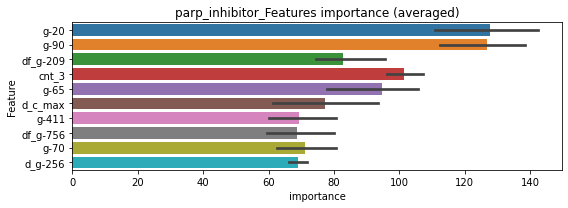

len(train_index) : 3889
len(valid_index) : 3889
================================= fold 1/2 parp_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0245779	valid_1's binary_logloss: 0.0560324
[200]	training's binary_logloss: 0.00443701	valid_1's binary_logloss: 0.032258
[300]	training's binary_logloss: 0.00130375	valid_1's binary_logloss: 0.0278401
Early stopping, best iteration is:
[301]	training's binary_logloss: 0.00129029	valid_1's binary_logloss: 0.0277993


len(train_index) : 3889
len(valid_index) : 3889
================================= fold 2/2 parp_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0247099	valid_1's binary_logloss: 0.0519873
[200]	training's binary_logloss: 0.00455572	valid_1's binary_logloss: 0.0251321
[300]	training's binary_logloss: 0.00133334	valid_1's binary_logloss: 0.0178829
[400]	training's binary_logloss: 0.000622617	valid_1's binary_logloss: 0.0157418
[500]	training's binary_logloss: 0.000395098	valid_1's binary_logloss: 0.0146944
Early stopping, best iteration is:
[506]	training's binary_logloss: 0.00038668	valid_1's binary_logloss: 0.0146305


parp_inhibitor logloss: 0.021214898933530034


  acetylcholine_receptor_agonist acetylcholine_receptor_antagonist  \
0                       df_g-122                              c-30   
1                  clusters_df_c                         c_all_max   
2                          cnt_0                    clusters_g_all   
3                      c_all_min                          df_g-707   
4                        df_g-51                        clusters_g   
5                       df_c_min                          df_c_min   
6                          cnt_2                             g-514   
7                       df_g-736                          df_g-640   
8                          g-244                            df_c-6   
9                           c-73                          df_g-597   

  acetylcholinesterase_inhibitor adenosine_receptor_antagonist  \
0                      c_all_max                clusters_c_all   
1                      c_all_min                      df_c_min   
2                 clusters_g_al

pdgfr_inhibitor, len(trt): 297, len(othr): 3268, target_rate: 0.0124717 → Adj_target_rate: 0.0106179


neg labels: 3289 → selected neg labels: 3268


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0545654	valid_1's binary_logloss: 0.136154
[200]	training's binary_logloss: 0.0121159	valid_1's binary_logloss: 0.0975796
[300]	training's binary_logloss: 0.00380908	valid_1's binary_logloss: 0.0853383
Early stopping, best iteration is:
[305]	training's binary_logloss: 0.00362014	valid_1's binary_logloss: 0.0850767
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0547237	valid_1's binary_logloss: 0.129249
[200]	training's binary_logloss: 0.0118501	valid_1's binary_logloss: 0.0884542
[300]	training's binary_logloss: 0.00369688	valid_1's binary_logloss: 0.0784047
Early stopping, best iteration is:
[352]	training's binary_logloss: 0.00244255	valid_1's binary_logloss: 0.0776671


1 / 3 AUC score:0.993
Threshold: 0.0378295, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 166 → positive_corect_labels: 636/3755
p_label_rate: 0.0592667 Vs.target_rate: 0.01247, Num_p_label: 236.0, conf_0:0.00258, conf_1:0.04161
Num_p_label: 236.0, Expected: 49.7, Adj_threshold_1: 0.0378295
Num_p_label: 221.0, Expected: 49.7, Adj_threshold_2: 0.0428295
Num_p_label: 206.0, Expected: 49.7, Adj_threshold_3: 0.0478295
Num_p_label: 192.0, Expected: 49.7, Adj_threshold_4: 0.0528295
Num_p_label: 180.0, Expected: 49.7, Adj_threshold_5: 0.0578295
Num_p_label: 173.0, Expected: 49.7, Adj_threshold_6: 0.0628295
Num_p_label: 165.0, Expected: 49.7, Adj_threshold_7: 0.0678295
Num_p_label: 155.0, Expected: 49.7, Adj_threshold_8: 0.0728295
Num_p_label: 151.0, Expected: 49.7, Adj_threshold_9: 0.0778295
Num_p_label: 148.0, Expected: 49.7, Adj_threshold_10: 0.0828295
threshold: 0.0878295, positive p_label: 140.0/3982, p_label_rate: 0.0351582
positive y_label: 636.0/3755, y_label_rate: 0.1693742
==========

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0453487	valid_1's binary_logloss: 0.12289
[200]	training's binary_logloss: 0.00864176	valid_1's binary_logloss: 0.0856677
[300]	training's binary_logloss: 0.00248865	valid_1's binary_logloss: 0.0727815
Early stopping, best iteration is:
[305]	training's binary_logloss: 0.00235748	valid_1's binary_logloss: 0.0723212
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0475221	valid_1's binary_logloss: 0.106773
[200]	training's binary_logloss: 0.00923734	valid_1's binary_logloss: 0.0647429


2 / 3 AUC score:0.995
Threshold: 0.0878295, pos_neg_ratio: 0.8000000


Early stopping, best iteration is:
[249]	training's binary_logloss: 0.00458708	valid_1's binary_logloss: 0.0563729


Remove_noisy_labels: 51 → positive_corect_labels: 615.0/3704
p_label_rate: 0.0524862 Vs.target_rate: 0.01247, Num_p_label: 209.0, conf_0:0.00340, conf_1:0.09661
Num_p_label: 209.0, Expected: 49.7, Adj_threshold_1: 0.0878295
Num_p_label: 204.0, Expected: 49.7, Adj_threshold_2: 0.0928295
Num_p_label: 195.0, Expected: 49.7, Adj_threshold_3: 0.0978295
Num_p_label: 189.0, Expected: 49.7, Adj_threshold_4: 0.1028295
Num_p_label: 181.0, Expected: 49.7, Adj_threshold_5: 0.1078295
Num_p_label: 179.0, Expected: 49.7, Adj_threshold_6: 0.1128295
Num_p_label: 179.0, Expected: 49.7, Adj_threshold_7: 0.1178295
Num_p_label: 178.0, Expected: 49.7, Adj_threshold_8: 0.1228295
Num_p_label: 174.0, Expected: 49.7, Adj_threshold_9: 0.1278295
Num_p_label: 171.0, Expected: 49.7, Adj_threshold_10: 0.1328295
threshold: 0.1378295, positive p_label: 165.0/3982, p_label_rate: 0.0414365
positive y_label: 615.0/3704, y_label_rate: 0.1660367
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0417567	valid_1's binary_logloss: 0.0971332
[200]	training's binary_logloss: 0.00760279	valid_1's binary_logloss: 0.0594234
[300]	training's binary_logloss: 0.00212972	valid_1's binary_logloss: 0.0478622
[400]	training's binary_logloss: 0.000995299	valid_1's binary_logloss: 0.0452531
Early stopping, best iteration is:
[426]	training's binary_logloss: 0.000861184	valid_1's binary_logloss: 0.044517
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0439064	valid_1's binary_logloss: 0.102677
[200]	training's binary_logloss: 0.00808712	valid_1's binary_logloss: 0.0621874


3 / 3 AUC score:0.997
Threshold: 0.1378295, pos_neg_ratio: 0.8000000


Early stopping, best iteration is:
[253]	training's binary_logloss: 0.00371223	valid_1's binary_logloss: 0.0533786


Remove_noisy_labels: 30 → positive_corect_labels: 595.0/3674
p_label_rate: 0.0426921 Vs.target_rate: 0.01247, Num_p_label: 170.0, conf_0:0.00215, conf_1:0.15161
Num_p_label: 170.0, Expected: 49.7, Adj_threshold_1: 0.1378295
Num_p_label: 169.0, Expected: 49.7, Adj_threshold_2: 0.1428295
Num_p_label: 167.0, Expected: 49.7, Adj_threshold_3: 0.1478295
Num_p_label: 166.0, Expected: 49.7, Adj_threshold_4: 0.1528295
Num_p_label: 163.0, Expected: 49.7, Adj_threshold_5: 0.1578295
Num_p_label: 161.0, Expected: 49.7, Adj_threshold_6: 0.1628295
Num_p_label: 159.0, Expected: 49.7, Adj_threshold_7: 0.1678295
Num_p_label: 159.0, Expected: 49.7, Adj_threshold_8: 0.1728295
Num_p_label: 157.0, Expected: 49.7, Adj_threshold_9: 0.1778295
Num_p_label: 155.0, Expected: 49.7, Adj_threshold_10: 0.1828295
threshold: 0.1878295, positive p_label: 152.0/3982, p_label_rate: 0.0381718
positive y_label: 747.0/7656, y_label_rate: 0.0975705


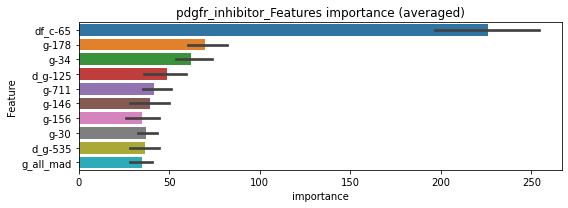

len(train_index) : 3828
len(valid_index) : 3828
================================= fold 1/2 pdgfr_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0269101	valid_1's binary_logloss: 0.0638511
[200]	training's binary_logloss: 0.00477995	valid_1's binary_logloss: 0.0385446
[300]	training's binary_logloss: 0.00136156	valid_1's binary_logloss: 0.0330959
Early stopping, best iteration is:
[325]	training's binary_logloss: 0.00109806	valid_1's binary_logloss: 0.0327617


len(train_index) : 3828
len(valid_index) : 3828
================================= fold 2/2 pdgfr_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0263219	valid_1's binary_logloss: 0.0611411
[200]	training's binary_logloss: 0.0046459	valid_1's binary_logloss: 0.0336055
[300]	training's binary_logloss: 0.00133752	valid_1's binary_logloss: 0.0252429
[400]	training's binary_logloss: 0.000640402	valid_1's binary_logloss: 0.0225215
[500]	training's binary_logloss: 0.000395612	valid_1's binary_logloss: 0.0202426
Early stopping, best iteration is:
[584]	training's binary_logloss: 0.000309952	valid_1's binary_logloss: 0.0191101


pdgfr_inhibitor logloss: 0.02593590404203221


  acetylcholine_receptor_agonist acetylcholine_receptor_antagonist  \
0                       df_g-122                              c-30   
1                  clusters_df_c                         c_all_max   
2                          cnt_0                    clusters_g_all   
3                      c_all_min                          df_g-707   
4                        df_g-51                        clusters_g   
5                       df_c_min                          df_c_min   
6                          cnt_2                             g-514   
7                       df_g-736                          df_g-640   
8                          g-244                            df_c-6   
9                           c-73                          df_g-597   

  acetylcholinesterase_inhibitor adenosine_receptor_antagonist  \
0                      c_all_max                clusters_c_all   
1                      c_all_min                      df_c_min   
2                 clusters_g_al

pdk_inhibitor, len(trt): 18, len(othr): 3286, target_rate: 0.0007559 → Adj_target_rate: 0.0009799
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0251955	valid_1's binary_logloss: 0.0328881
[200]	training's binary_logloss: 0.00303441	valid_1's binary_logloss: 0.00551577
[300]	training's binary_logloss: 0.00083791	valid_1's binary_logloss: 0.00193661
[400]	training's binary_logloss: 0.000440907	valid_1's binary_logloss: 0.00116661
[500]	training's binary_logloss: 0.000342489	valid_1's binary_logloss: 0.000974472
Early stopping, best iteration is:
[516]	training's binary_logloss: 0.000339897	valid_1's binary_logloss: 0.000971875
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0246802	valid_1's binary_logloss: 0.0360404
[200]	training's binary_logloss: 0.00294063	valid_1's binary_logloss: 0.00852893
[300]	training's binary_logloss: 0.000825979	valid_1's binary_logloss: 0.00450845
[400]	training's binary_logloss: 0.000432198	valid_1's binary_logloss: 0.00343748
Early stopping, best iteration

1 / 3 AUC score:1.000
Threshold: 0.0015065, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → positive_corect_labels: 657/3811
p_label_rate: 0.0341537 Vs.target_rate: 0.00076, Num_p_label: 136.0, conf_0:0.00025, conf_1:0.00166
Num_p_label: 136.0, Expected: 3.0, Adj_threshold_1: 0.0015065
Num_p_label: 19.0, Expected: 3.0, Adj_threshold_2: 0.0065065
Num_p_label: 9.0, Expected: 3.0, Adj_threshold_3: 0.0115065
Num_p_label: 3.0, Expected: 3.0, Adj_threshold_4: 0.0165065
threshold: 0.0165065, positive p_label: 3.0/3982, p_label_rate: 0.0007534
positive y_label: 657.0/3811, y_label_rate: 0.1723957
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0246098	valid_1's binary_logloss: 0.0299057
[200]	training's binary_logloss: 0.00293666	valid_1's binary_logloss: 0.00440215
[300]	training's binary_logloss: 0.000827885	valid_1's binary_logloss: 0.0014309
[400]	training's binary_logloss: 0.000439806	valid_1's binary_logloss: 0.000820774
[500]	training's binary_logloss: 0.000350425	valid_1's binary_logloss: 0.000676441
Early stopping, best iteration is:
[516]	training's binary_logloss: 0.000347465	valid_1's binary_logloss: 0.000672048
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0244801	valid_1's binary_logloss: 0.0344624
[200]	training's binary_logloss: 0.0028364	valid_1's binary_logloss: 0.00812545
[300]	training's binary_logloss: 0.00080699	valid_1's binary_logloss: 0.0042035
[400]	training's binary_logloss: 0.000433783	valid_1's binary_logloss: 0.00327457
Early stopping, best iteration i

2 / 3 AUC score:1.000
Threshold: 0.0165065, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → positive_corect_labels: 657.0/3811
p_label_rate: 0.0025113 Vs.target_rate: 0.00076, Num_p_label: 10.0, conf_0:0.00027, conf_1:0.01816
Num_p_label: 10.0, Expected: 3.0, Adj_threshold_1: 0.0165065
Num_p_label: 5.0, Expected: 3.0, Adj_threshold_2: 0.0215065
threshold: 0.0215065, positive p_label: 5.0/3982, p_label_rate: 0.0012557
positive y_label: 657.0/3811, y_label_rate: 0.1723957
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0246098	valid_1's binary_logloss: 0.0299057
[200]	training's binary_logloss: 0.00293666	valid_1's binary_logloss: 0.00440215
[300]	training's binary_logloss: 0.000827885	valid_1's binary_logloss: 0.0014309
[400]	training's binary_logloss: 0.000439806	valid_1's binary_logloss: 0.000820774
[500]	training's binary_logloss: 0.000350425	valid_1's binary_logloss: 0.000676441
Early stopping, best iteration is:
[516]	training's binary_logloss: 0.000347465	valid_1's binary_logloss: 0.000672048
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0244801	valid_1's binary_logloss: 0.0344624
[200]	training's binary_logloss: 0.0028364	valid_1's binary_logloss: 0.00812545
[300]	training's binary_logloss: 0.00080699	valid_1's binary_logloss: 0.0042035
[400]	training's binary_logloss: 0.000433783	valid_1's binary_logloss: 0.00327457
Early stopping, best iteration i

3 / 3 AUC score:1.000
Threshold: 0.0215065, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → positive_corect_labels: 657.0/3811
p_label_rate: 0.0012557 Vs.target_rate: 0.00076, Num_p_label: 5.0, conf_0:0.00027, conf_1:0.02366
threshold: 0.0215065, positive p_label: 5.0/3982, p_label_rate: 0.0012557
positive y_label: 662.0/7793, y_label_rate: 0.0849480


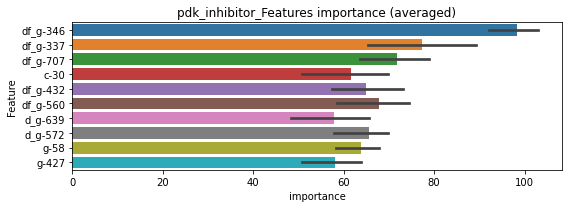

len(train_index) : 3896
len(valid_index) : 3897
================================= fold 1/2 pdk_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0137901	valid_1's binary_logloss: 0.0208802
[200]	training's binary_logloss: 0.00160816	valid_1's binary_logloss: 0.00659203
Early stopping, best iteration is:
[287]	training's binary_logloss: 0.000489902	valid_1's binary_logloss: 0.00562941


len(train_index) : 3897
len(valid_index) : 3896
================================= fold 2/2 pdk_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0143231	valid_1's binary_logloss: 0.020112
[200]	training's binary_logloss: 0.00171824	valid_1's binary_logloss: 0.00545456
[300]	training's binary_logloss: 0.000464164	valid_1's binary_logloss: 0.00284207
[400]	training's binary_logloss: 0.000233835	valid_1's binary_logloss: 0.00230445
[500]	training's binary_logloss: 0.000184847	valid_1's binary_logloss: 0.00219151
Early stopping, best iteration is:
[508]	training's binary_logloss: 0.000183399	valid_1's binary_logloss: 0.00218875


pdk_inhibitor logloss: 0.003909300775909205
phosphodiesterase_inhibitor, len(trt): 264, len(othr): 3243, target_rate: 0.0110859 → Adj_target_rate: 0.0096064


neg labels: 3289 → selected neg labels: 3243


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0977778	valid_1's binary_logloss: 0.281804
Early stopping, best iteration is:
[158]	training's binary_logloss: 0.0522248	valid_1's binary_logloss: 0.266327
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.112974	valid_1's binary_logloss: 0.264991
[200]	training's binary_logloss: 0.0416024	valid_1's binary_logloss: 0.22694
Early stopping, best iteration is:
[240]	training's binary_logloss: 0.0278693	valid_1's binary_logloss: 0.221327


1 / 3 AUC score:0.913
Threshold: 0.0983358, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 407 → positive_corect_labels: 510/3484
p_label_rate: 0.0637870 Vs.target_rate: 0.01109, Num_p_label: 254.0, conf_0:0.04610, conf_1:0.10817
Num_p_label: 254.0, Expected: 44.1, Adj_threshold_1: 0.0983358
Num_p_label: 201.0, Expected: 44.1, Adj_threshold_2: 0.1033358
Num_p_label: 163.0, Expected: 44.1, Adj_threshold_3: 0.1083358
Num_p_label: 139.0, Expected: 44.1, Adj_threshold_4: 0.1133358
Num_p_label: 108.0, Expected: 44.1, Adj_threshold_5: 0.1183358
Num_p_label: 92.0, Expected: 44.1, Adj_threshold_6: 0.1233358
Num_p_label: 74.0, Expected: 44.1, Adj_threshold_7: 0.1283358
threshold: 0.1283358, positive p_label: 74.0/3982, p_label_rate: 0.0185836
positive y_label: 510.0/3484, y_label_rate: 0.1463835
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0713177	valid_1's binary_logloss: 0.187686
[200]	training's binary_logloss: 0.0216308	valid_1's binary_logloss: 0.157689
Early stopping, best iteration is:
[258]	training's binary_logloss: 0.0113863	valid_1's binary_logloss: 0.153409
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0694886	valid_1's binary_logloss: 0.19419
[200]	training's binary_logloss: 0.0206779	valid_1's binary_logloss: 0.158406


2 / 3 AUC score:0.976
Threshold: 0.1283358, pos_neg_ratio: 0.8000000


Early stopping, best iteration is:
[243]	training's binary_logloss: 0.0127502	valid_1's binary_logloss: 0.152715


Remove_noisy_labels: 108 → positive_corect_labels: 412.0/3376
p_label_rate: 0.0082873 Vs.target_rate: 0.01109, Num_p_label: 33.0, conf_0:0.01714, conf_1:0.14117
threshold: 0.1283358, positive p_label: 33.0/3982, p_label_rate: 0.0082873
positive y_label: 412.0/3376, y_label_rate: 0.1220379
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.047859	valid_1's binary_logloss: 0.139825
[200]	training's binary_logloss: 0.0122643	valid_1's binary_logloss: 0.109428
[300]	training's binary_logloss: 0.00415922	valid_1's binary_logloss: 0.103241
Early stopping, best iteration is:
[319]	training's binary_logloss: 0.00355762	valid_1's binary_logloss: 0.102463
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0474061	valid_1's binary_logloss: 0.153721
[200]	training's binary_logloss: 0.0121425	valid_1's binary_logloss: 0.133353
Early stopping, best iteration is:
[223]	training's binary_logloss: 0.00916696	valid_1's binary_logloss: 0.132002


3 / 3 AUC score:0.988
Threshold: 0.1283358, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 70 → positive_corect_labels: 344.0/3306
p_label_rate: 0.0022602 Vs.target_rate: 0.01109, Num_p_label: 9.0, conf_0:0.00767, conf_1:0.14117
Num_p_label: 9.0, Expected: 44.1, Adj_threshold_1: 0.1283358
Num_p_label: 11.0, Expected: 44.1, Adj_threshold_2: 0.1233358
Num_p_label: 12.0, Expected: 44.1, Adj_threshold_3: 0.1183358
Num_p_label: 14.0, Expected: 44.1, Adj_threshold_4: 0.1133358
Num_p_label: 14.0, Expected: 44.1, Adj_threshold_5: 0.1083358
Num_p_label: 14.0, Expected: 44.1, Adj_threshold_6: 0.1033358
Num_p_label: 16.0, Expected: 44.1, Adj_threshold_7: 0.0983358
Num_p_label: 19.0, Expected: 44.1, Adj_threshold_8: 0.0933358
Num_p_label: 23.0, Expected: 44.1, Adj_threshold_9: 0.0883358
threshold: 0.0883358, positive p_label: 23.0/3982, p_label_rate: 0.0057760
positive y_label: 367.0/7288, y_label_rate: 0.0503568


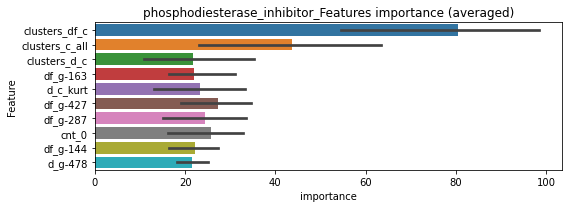

len(train_index) : 3644
len(valid_index) : 3644
================================= fold 1/2 phosphodiesterase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0201881	valid_1's binary_logloss: 0.0816702
Early stopping, best iteration is:
[147]	training's binary_logloss: 0.00992361	valid_1's binary_logloss: 0.0774823


len(train_index) : 3644
len(valid_index) : 3644
================================= fold 2/2 phosphodiesterase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0195603	valid_1's binary_logloss: 0.0734668
[200]	training's binary_logloss: 0.00466958	valid_1's binary_logloss: 0.0670142
Early stopping, best iteration is:
[205]	training's binary_logloss: 0.00433955	valid_1's binary_logloss: 0.066521


phosphodiesterase_inhibitor logloss: 0.07200169725844725


  acetylcholine_receptor_agonist acetylcholine_receptor_antagonist  \
0                       df_g-122                              c-30   
1                  clusters_df_c                         c_all_max   
2                          cnt_0                    clusters_g_all   
3                      c_all_min                          df_g-707   
4                        df_g-51                        clusters_g   
5                       df_c_min                          df_c_min   
6                          cnt_2                             g-514   
7                       df_g-736                          df_g-640   
8                          g-244                            df_c-6   
9                           c-73                          df_g-597   

  acetylcholinesterase_inhibitor adenosine_receptor_antagonist  \
0                      c_all_max                clusters_c_all   
1                      c_all_min                      df_c_min   
2                 clusters_g_al

phospholipase_inhibitor, len(trt): 25, len(othr): 3285, target_rate: 0.0010498 → Adj_target_rate: 0.0012955


neg labels: 3289 → selected neg labels: 3285


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.028918	valid_1's binary_logloss: 0.0462858
[200]	training's binary_logloss: 0.00385969	valid_1's binary_logloss: 0.0124635
[300]	training's binary_logloss: 0.00111683	valid_1's binary_logloss: 0.0071776
[400]	training's binary_logloss: 0.000567634	valid_1's binary_logloss: 0.00539375
Early stopping, best iteration is:
[440]	training's binary_logloss: 0.000476706	valid_1's binary_logloss: 0.00503835
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0304997	valid_1's binary_logloss: 0.0405995
[200]	training's binary_logloss: 0.00427605	valid_1's binary_logloss: 0.00818585
[300]	training's binary_logloss: 0.00120385	valid_1's binary_logloss: 0.00312073
[400]	training's binary_logloss: 0.000605574	valid_1's binary_logloss: 0.00191198
[500]	training's binary_logloss: 0.000424872	valid_1's binary_logloss: 0.00150371
Early stopping, best iteration is:
[

1 / 3 AUC score:1.000
Threshold: 0.0023253, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → positive_corect_labels: 657/3810
p_label_rate: 0.0454545 Vs.target_rate: 0.00105, Num_p_label: 181.0, conf_0:0.00035, conf_1:0.00256
Num_p_label: 181.0, Expected: 4.2, Adj_threshold_1: 0.0023253
Num_p_label: 41.0, Expected: 4.2, Adj_threshold_2: 0.0073253
Num_p_label: 18.0, Expected: 4.2, Adj_threshold_3: 0.0123253
Num_p_label: 11.0, Expected: 4.2, Adj_threshold_4: 0.0173253
Num_p_label: 6.0, Expected: 4.2, Adj_threshold_5: 0.0223253
threshold: 0.0223253, positive p_label: 6.0/3982, p_label_rate: 0.0015068
positive y_label: 657.0/3810, y_label_rate: 0.1724409
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0290706	valid_1's binary_logloss: 0.0457623
[200]	training's binary_logloss: 0.00384902	valid_1's binary_logloss: 0.0134038
[300]	training's binary_logloss: 0.00110839	valid_1's binary_logloss: 0.00801959
[400]	training's binary_logloss: 0.000569284	valid_1's binary_logloss: 0.0066094
Early stopping, best iteration is:
[462]	training's binary_logloss: 0.000446706	valid_1's binary_logloss: 0.00622323
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0294799	valid_1's binary_logloss: 0.0388421
[200]	training's binary_logloss: 0.00395666	valid_1's binary_logloss: 0.00733409
[300]	training's binary_logloss: 0.00114456	valid_1's binary_logloss: 0.00284979
[400]	training's binary_logloss: 0.000587076	valid_1's binary_logloss: 0.00171974
[500]	training's binary_logloss: 0.000424402	valid_1's binary_logloss: 0.00138238
Early stopping, best iteration is:


2 / 3 AUC score:1.000
Threshold: 0.0223253, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → positive_corect_labels: 657.0/3810
p_label_rate: 0.0050226 Vs.target_rate: 0.00105, Num_p_label: 20.0, conf_0:0.00039, conf_1:0.02456
Num_p_label: 20.0, Expected: 4.2, Adj_threshold_1: 0.0223253
Num_p_label: 14.0, Expected: 4.2, Adj_threshold_2: 0.0273253
Num_p_label: 13.0, Expected: 4.2, Adj_threshold_3: 0.0323253
Num_p_label: 10.0, Expected: 4.2, Adj_threshold_4: 0.0373253
Num_p_label: 9.0, Expected: 4.2, Adj_threshold_5: 0.0423253
Num_p_label: 8.0, Expected: 4.2, Adj_threshold_6: 0.0473253
threshold: 0.0473253, positive p_label: 8.0/3982, p_label_rate: 0.0020090
positive y_label: 657.0/3810, y_label_rate: 0.1724409
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0290706	valid_1's binary_logloss: 0.0457623
[200]	training's binary_logloss: 0.00384902	valid_1's binary_logloss: 0.0134038
[300]	training's binary_logloss: 0.00110839	valid_1's binary_logloss: 0.00801959
[400]	training's binary_logloss: 0.000569284	valid_1's binary_logloss: 0.0066094
Early stopping, best iteration is:
[462]	training's binary_logloss: 0.000446706	valid_1's binary_logloss: 0.00622323
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0294799	valid_1's binary_logloss: 0.0388421
[200]	training's binary_logloss: 0.00395666	valid_1's binary_logloss: 0.00733409
[300]	training's binary_logloss: 0.00114456	valid_1's binary_logloss: 0.00284979
[400]	training's binary_logloss: 0.000587076	valid_1's binary_logloss: 0.00171974
[500]	training's binary_logloss: 0.000424402	valid_1's binary_logloss: 0.00138238
Early stopping, best iteration is:


3 / 3 AUC score:1.000
Threshold: 0.0473253, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → positive_corect_labels: 657.0/3810
p_label_rate: 0.0020090 Vs.target_rate: 0.00105, Num_p_label: 8.0, conf_0:0.00039, conf_1:0.05206
threshold: 0.0473253, positive p_label: 8.0/3982, p_label_rate: 0.0020090
positive y_label: 665.0/7792, y_label_rate: 0.0853439


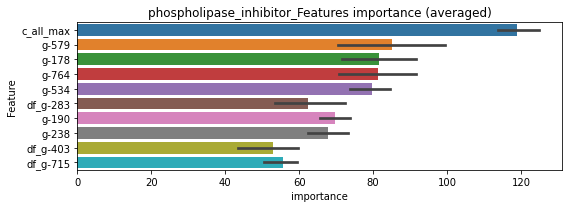

len(train_index) : 3896
len(valid_index) : 3896
================================= fold 1/2 phospholipase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0161501	valid_1's binary_logloss: 0.0284936
[200]	training's binary_logloss: 0.00223968	valid_1's binary_logloss: 0.0112053
[300]	training's binary_logloss: 0.000618258	valid_1's binary_logloss: 0.00863698
Early stopping, best iteration is:
[320]	training's binary_logloss: 0.000515555	valid_1's binary_logloss: 0.00847912


len(train_index) : 3896
len(valid_index) : 3896
================================= fold 2/2 phospholipase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0170749	valid_1's binary_logloss: 0.0265529
[200]	training's binary_logloss: 0.0024059	valid_1's binary_logloss: 0.00771007
[300]	training's binary_logloss: 0.000662119	valid_1's binary_logloss: 0.00455036
Early stopping, best iteration is:
[345]	training's binary_logloss: 0.00045805	valid_1's binary_logloss: 0.00390585


phospholipase_inhibitor logloss: 0.006192485101395309
pi3k_inhibitor, len(trt): 151, len(othr): 3264, target_rate: 0.0063408 → Adj_target_rate: 0.0059749


neg labels: 3289 → selected neg labels: 3264


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0572346	valid_1's binary_logloss: 0.140578
[200]	training's binary_logloss: 0.0133738	valid_1's binary_logloss: 0.0991392
[300]	training's binary_logloss: 0.0041647	valid_1's binary_logloss: 0.0887641
Early stopping, best iteration is:
[318]	training's binary_logloss: 0.00352451	valid_1's binary_logloss: 0.087711
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0544453	valid_1's binary_logloss: 0.146877
[200]	training's binary_logloss: 0.0124601	valid_1's binary_logloss: 0.111198
Early stopping, best iteration is:
[245]	training's binary_logloss: 0.00696465	valid_1's binary_logloss: 0.106664


1 / 3 AUC score:0.991
Threshold: 0.0330485, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 180 → positive_corect_labels: 628/3736
p_label_rate: 0.0622803 Vs.target_rate: 0.00634, Num_p_label: 248.0, conf_0:0.00505, conf_1:0.03635
Num_p_label: 248.0, Expected: 25.2, Adj_threshold_1: 0.0330485
Num_p_label: 222.0, Expected: 25.2, Adj_threshold_2: 0.0380485
Num_p_label: 203.0, Expected: 25.2, Adj_threshold_3: 0.0430485
Num_p_label: 185.0, Expected: 25.2, Adj_threshold_4: 0.0480485
Num_p_label: 170.0, Expected: 25.2, Adj_threshold_5: 0.0530485
Num_p_label: 158.0, Expected: 25.2, Adj_threshold_6: 0.0580485
Num_p_label: 149.0, Expected: 25.2, Adj_threshold_7: 0.0630485
Num_p_label: 146.0, Expected: 25.2, Adj_threshold_8: 0.0680485
Num_p_label: 137.0, Expected: 25.2, Adj_threshold_9: 0.0730485
Num_p_label: 129.0, Expected: 25.2, Adj_threshold_10: 0.0780485
threshold: 0.0830485, positive p_label: 124.0/3982, p_label_rate: 0.0311401
positive y_label: 628.0/3736, y_label_rate: 0.1680942
==========

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0481469	valid_1's binary_logloss: 0.121479
[200]	training's binary_logloss: 0.00976774	valid_1's binary_logloss: 0.0812067
[300]	training's binary_logloss: 0.00300424	valid_1's binary_logloss: 0.0731751
Early stopping, best iteration is:
[323]	training's binary_logloss: 0.00243795	valid_1's binary_logloss: 0.0718639
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.048302	valid_1's binary_logloss: 0.116436
[200]	training's binary_logloss: 0.00966756	valid_1's binary_logloss: 0.0795932
Early stopping, best iteration is:
[266]	training's binary_logloss: 0.00424489	valid_1's binary_logloss: 0.0731006


2 / 3 AUC score:0.995
Threshold: 0.0830485, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 67 → positive_corect_labels: 592.0/3669
p_label_rate: 0.0607735 Vs.target_rate: 0.00634, Num_p_label: 242.0, conf_0:0.00381, conf_1:0.09135
Num_p_label: 242.0, Expected: 25.2, Adj_threshold_1: 0.0830485
Num_p_label: 235.0, Expected: 25.2, Adj_threshold_2: 0.0880485
Num_p_label: 231.0, Expected: 25.2, Adj_threshold_3: 0.0930485
Num_p_label: 226.0, Expected: 25.2, Adj_threshold_4: 0.0980485
Num_p_label: 219.0, Expected: 25.2, Adj_threshold_5: 0.1030485
Num_p_label: 213.0, Expected: 25.2, Adj_threshold_6: 0.1080485
Num_p_label: 207.0, Expected: 25.2, Adj_threshold_7: 0.1130485
Num_p_label: 201.0, Expected: 25.2, Adj_threshold_8: 0.1180485
Num_p_label: 194.0, Expected: 25.2, Adj_threshold_9: 0.1230485
Num_p_label: 189.0, Expected: 25.2, Adj_threshold_10: 0.1280485
threshold: 0.1330485, positive p_label: 186.0/3982, p_label_rate: 0.0467102
positive y_label: 592.0/3669, y_label_rate: 0.1613519
=========

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0421877	valid_1's binary_logloss: 0.104535
[200]	training's binary_logloss: 0.00789592	valid_1's binary_logloss: 0.0646259
[300]	training's binary_logloss: 0.00242911	valid_1's binary_logloss: 0.0566185
Early stopping, best iteration is:
[306]	training's binary_logloss: 0.00229993	valid_1's binary_logloss: 0.0561954
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.042276	valid_1's binary_logloss: 0.121694
[200]	training's binary_logloss: 0.00811382	valid_1's binary_logloss: 0.0833442
Early stopping, best iteration is:
[274]	training's binary_logloss: 0.00309059	valid_1's binary_logloss: 0.0754065


3 / 3 AUC score:0.997
Threshold: 0.1330485, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 54 → positive_corect_labels: 551.0/3615
p_label_rate: 0.0617780 Vs.target_rate: 0.00634, Num_p_label: 246.0, conf_0:0.00282, conf_1:0.14635
Num_p_label: 246.0, Expected: 25.2, Adj_threshold_1: 0.1330485
Num_p_label: 243.0, Expected: 25.2, Adj_threshold_2: 0.1380485
Num_p_label: 241.0, Expected: 25.2, Adj_threshold_3: 0.1430485
Num_p_label: 237.0, Expected: 25.2, Adj_threshold_4: 0.1480485
Num_p_label: 234.0, Expected: 25.2, Adj_threshold_5: 0.1530485
Num_p_label: 233.0, Expected: 25.2, Adj_threshold_6: 0.1580485
Num_p_label: 231.0, Expected: 25.2, Adj_threshold_7: 0.1630485
Num_p_label: 230.0, Expected: 25.2, Adj_threshold_8: 0.1680485
Num_p_label: 226.0, Expected: 25.2, Adj_threshold_9: 0.1730485
Num_p_label: 226.0, Expected: 25.2, Adj_threshold_10: 0.1780485
threshold: 0.1830485, positive p_label: 225.0/3982, p_label_rate: 0.0565043
positive y_label: 776.0/7597, y_label_rate: 0.1021456


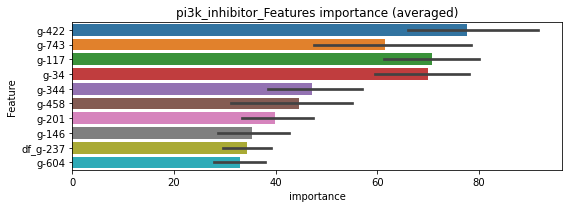

len(train_index) : 3798
len(valid_index) : 3799
================================= fold 1/2 pi3k_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0257622	valid_1's binary_logloss: 0.0799942
[200]	training's binary_logloss: 0.00440758	valid_1's binary_logloss: 0.0613526
Early stopping, best iteration is:
[225]	training's binary_logloss: 0.00306546	valid_1's binary_logloss: 0.0606191


len(train_index) : 3799
len(valid_index) : 3798
================================= fold 2/2 pi3k_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0270094	valid_1's binary_logloss: 0.0743483
[200]	training's binary_logloss: 0.00479518	valid_1's binary_logloss: 0.0502046
[300]	training's binary_logloss: 0.00145069	valid_1's binary_logloss: 0.0467577
Early stopping, best iteration is:
[322]	training's binary_logloss: 0.00118906	valid_1's binary_logloss: 0.0458948


pi3k_inhibitor logloss: 0.05325789426386207


  acetylcholine_receptor_agonist acetylcholine_receptor_antagonist  \
0                       df_g-122                              c-30   
1                  clusters_df_c                         c_all_max   
2                          cnt_0                    clusters_g_all   
3                      c_all_min                          df_g-707   
4                        df_g-51                        clusters_g   
5                       df_c_min                          df_c_min   
6                          cnt_2                             g-514   
7                       df_g-736                          df_g-640   
8                          g-244                            df_c-6   
9                           c-73                          df_g-597   

  acetylcholinesterase_inhibitor adenosine_receptor_antagonist  \
0                      c_all_max                clusters_c_all   
1                      c_all_min                      df_c_min   
2                 clusters_g_al

pkc_inhibitor, len(trt): 31, len(othr): 3284, target_rate: 0.0013018 → Adj_target_rate: 0.0015554


neg labels: 3289 → selected neg labels: 3284


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0343634	valid_1's binary_logloss: 0.0597362
[200]	training's binary_logloss: 0.00496977	valid_1's binary_logloss: 0.021469
[300]	training's binary_logloss: 0.00134512	valid_1's binary_logloss: 0.0130311
[400]	training's binary_logloss: 0.000668126	valid_1's binary_logloss: 0.0106032
Early stopping, best iteration is:
[465]	training's binary_logloss: 0.000502411	valid_1's binary_logloss: 0.00984327
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.033219	valid_1's binary_logloss: 0.0499811
[200]	training's binary_logloss: 0.00471411	valid_1's binary_logloss: 0.0129385
[300]	training's binary_logloss: 0.0013164	valid_1's binary_logloss: 0.0060782
[400]	training's binary_logloss: 0.000657419	valid_1's binary_logloss: 0.00446937
[500]	training's binary_logloss: 0.000460506	valid_1's binary_logloss: 0.00388538
Early stopping, best iteration is:
[492]	

1 / 3 AUC score:1.000
Threshold: 0.0026802, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → positive_corect_labels: 656/3808
p_label_rate: 0.0441989 Vs.target_rate: 0.00130, Num_p_label: 176.0, conf_0:0.00045, conf_1:0.00295
Num_p_label: 176.0, Expected: 5.2, Adj_threshold_1: 0.0026802
Num_p_label: 26.0, Expected: 5.2, Adj_threshold_2: 0.0076802
Num_p_label: 12.0, Expected: 5.2, Adj_threshold_3: 0.0126802
Num_p_label: 5.0, Expected: 5.2, Adj_threshold_4: 0.0176802
threshold: 0.0176802, positive p_label: 5.0/3982, p_label_rate: 0.0012557
positive y_label: 656.0/3808, y_label_rate: 0.1722689
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0330182	valid_1's binary_logloss: 0.0566969
[200]	training's binary_logloss: 0.00451148	valid_1's binary_logloss: 0.0185144
[300]	training's binary_logloss: 0.00125908	valid_1's binary_logloss: 0.0110833
[400]	training's binary_logloss: 0.000634037	valid_1's binary_logloss: 0.00911405
Early stopping, best iteration is:
[450]	training's binary_logloss: 0.000511387	valid_1's binary_logloss: 0.00870017
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0332384	valid_1's binary_logloss: 0.0484557
[200]	training's binary_logloss: 0.00480013	valid_1's binary_logloss: 0.0119546
[300]	training's binary_logloss: 0.00133676	valid_1's binary_logloss: 0.00555646
[400]	training's binary_logloss: 0.000656671	valid_1's binary_logloss: 0.00385821
[500]	training's binary_logloss: 0.000459722	valid_1's binary_logloss: 0.00330126
Early stopping, best iteration is:
[

2 / 3 AUC score:1.000
Threshold: 0.0176802, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → positive_corect_labels: 656.0/3808
p_label_rate: 0.0062783 Vs.target_rate: 0.00130, Num_p_label: 25.0, conf_0:0.00050, conf_1:0.01945
Num_p_label: 25.0, Expected: 5.2, Adj_threshold_1: 0.0176802
Num_p_label: 16.0, Expected: 5.2, Adj_threshold_2: 0.0226802
Num_p_label: 12.0, Expected: 5.2, Adj_threshold_3: 0.0276802
Num_p_label: 10.0, Expected: 5.2, Adj_threshold_4: 0.0326802
threshold: 0.0326802, positive p_label: 10.0/3982, p_label_rate: 0.0025113
positive y_label: 656.0/3808, y_label_rate: 0.1722689
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0330182	valid_1's binary_logloss: 0.0566969
[200]	training's binary_logloss: 0.00451148	valid_1's binary_logloss: 0.0185144
[300]	training's binary_logloss: 0.00125908	valid_1's binary_logloss: 0.0110833
[400]	training's binary_logloss: 0.000634037	valid_1's binary_logloss: 0.00911405
Early stopping, best iteration is:
[450]	training's binary_logloss: 0.000511387	valid_1's binary_logloss: 0.00870017
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0332384	valid_1's binary_logloss: 0.0484557
[200]	training's binary_logloss: 0.00480013	valid_1's binary_logloss: 0.0119546
[300]	training's binary_logloss: 0.00133676	valid_1's binary_logloss: 0.00555646
[400]	training's binary_logloss: 0.000656671	valid_1's binary_logloss: 0.00385821
[500]	training's binary_logloss: 0.000459722	valid_1's binary_logloss: 0.00330126
Early stopping, best iteration is:
[

3 / 3 AUC score:1.000
Threshold: 0.0326802, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → positive_corect_labels: 656.0/3808
p_label_rate: 0.0025113 Vs.target_rate: 0.00130, Num_p_label: 10.0, conf_0:0.00050, conf_1:0.03595
threshold: 0.0326802, positive p_label: 10.0/3982, p_label_rate: 0.0025113
positive y_label: 666.0/7790, y_label_rate: 0.0854942


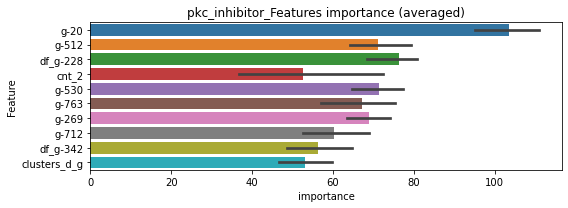

len(train_index) : 3895
len(valid_index) : 3895
================================= fold 1/2 pkc_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0183141	valid_1's binary_logloss: 0.0318349
[200]	training's binary_logloss: 0.00257503	valid_1's binary_logloss: 0.0135636
[300]	training's binary_logloss: 0.000705233	valid_1's binary_logloss: 0.010879
Early stopping, best iteration is:
[313]	training's binary_logloss: 0.00062539	valid_1's binary_logloss: 0.0107701


len(train_index) : 3895
len(valid_index) : 3895
================================= fold 2/2 pkc_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0189807	valid_1's binary_logloss: 0.0265133
[200]	training's binary_logloss: 0.00269907	valid_1's binary_logloss: 0.00841988
[300]	training's binary_logloss: 0.000732236	valid_1's binary_logloss: 0.00611688
Early stopping, best iteration is:
[385]	training's binary_logloss: 0.000389543	valid_1's binary_logloss: 0.0056574


pkc_inhibitor logloss: 0.008213734231329109
potassium_channel_activator, len(trt): 55, len(othr): 3279, target_rate: 0.0023096 → Adj_target_rate: 0.0025322


neg labels: 3289 → selected neg labels: 3279


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0432855	valid_1's binary_logloss: 0.0818929
[200]	training's binary_logloss: 0.00828818	valid_1's binary_logloss: 0.033107
[300]	training's binary_logloss: 0.00245351	valid_1's binary_logloss: 0.0194973
[400]	training's binary_logloss: 0.00116452	valid_1's binary_logloss: 0.0159613
[500]	training's binary_logloss: 0.00074181	valid_1's binary_logloss: 0.0143614
Early stopping, best iteration is:
[574]	training's binary_logloss: 0.000599478	valid_1's binary_logloss: 0.0135642
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0446704	valid_1's binary_logloss: 0.082869
[200]	training's binary_logloss: 0.00860194	valid_1's binary_logloss: 0.0387614
[300]	training's binary_logloss: 0.00246708	valid_1's binary_logloss: 0.0257691
[400]	training's binary_logloss: 0.00117276	valid_1's binary_logloss: 0.0222365
[500]	training's binary_logloss: 0.000733617	v

1 / 3 AUC score:1.000
Threshold: 0.0060292, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 134 → positive_corect_labels: 654/3800
p_label_rate: 0.0406831 Vs.target_rate: 0.00231, Num_p_label: 162.0, conf_0:0.00080, conf_1:0.00663
Num_p_label: 162.0, Expected: 9.2, Adj_threshold_1: 0.0060292
Num_p_label: 65.0, Expected: 9.2, Adj_threshold_2: 0.0110292
Num_p_label: 32.0, Expected: 9.2, Adj_threshold_3: 0.0160292
Num_p_label: 21.0, Expected: 9.2, Adj_threshold_4: 0.0210292
Num_p_label: 15.0, Expected: 9.2, Adj_threshold_5: 0.0260292
threshold: 0.0260292, positive p_label: 15.0/3982, p_label_rate: 0.0037670
positive y_label: 654.0/3800, y_label_rate: 0.1721053
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0427127	valid_1's binary_logloss: 0.0733682
[200]	training's binary_logloss: 0.00780802	valid_1's binary_logloss: 0.0253191
[300]	training's binary_logloss: 0.00233545	valid_1's binary_logloss: 0.0145305
[400]	training's binary_logloss: 0.00112853	valid_1's binary_logloss: 0.01182
[500]	training's binary_logloss: 0.000724886	valid_1's binary_logloss: 0.0106152
Early stopping, best iteration is:
[540]	training's binary_logloss: 0.00064216	valid_1's binary_logloss: 0.0101506
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0450818	valid_1's binary_logloss: 0.0805398
[200]	training's binary_logloss: 0.00815028	valid_1's binary_logloss: 0.0319316
[300]	training's binary_logloss: 0.00238094	valid_1's binary_logloss: 0.0192301
[400]	training's binary_logloss: 0.00113123	valid_1's binary_logloss: 0.0152352
Early stopping, best iteration is:
[468]	train

2 / 3 AUC score:1.000
Threshold: 0.0260292, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 7 → positive_corect_labels: 654.0/3793
p_label_rate: 0.0100452 Vs.target_rate: 0.00231, Num_p_label: 40.0, conf_0:0.00102, conf_1:0.02863
Num_p_label: 40.0, Expected: 9.2, Adj_threshold_1: 0.0260292
Num_p_label: 32.0, Expected: 9.2, Adj_threshold_2: 0.0310292
Num_p_label: 27.0, Expected: 9.2, Adj_threshold_3: 0.0360292
Num_p_label: 21.0, Expected: 9.2, Adj_threshold_4: 0.0410292
Num_p_label: 17.0, Expected: 9.2, Adj_threshold_5: 0.0460292
threshold: 0.0460292, positive p_label: 17.0/3982, p_label_rate: 0.0042692
positive y_label: 654.0/3793, y_label_rate: 0.1724229
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0439056	valid_1's binary_logloss: 0.0728604
[200]	training's binary_logloss: 0.00790858	valid_1's binary_logloss: 0.024845
[300]	training's binary_logloss: 0.0023779	valid_1's binary_logloss: 0.0137452
[400]	training's binary_logloss: 0.00113171	valid_1's binary_logloss: 0.0107565
[500]	training's binary_logloss: 0.000724369	valid_1's binary_logloss: 0.0095075
Early stopping, best iteration is:
[540]	training's binary_logloss: 0.000642799	valid_1's binary_logloss: 0.009156
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0433126	valid_1's binary_logloss: 0.0821969
[200]	training's binary_logloss: 0.00809828	valid_1's binary_logloss: 0.0351666
[300]	training's binary_logloss: 0.0023662	valid_1's binary_logloss: 0.0212969
[400]	training's binary_logloss: 0.00112907	valid_1's binary_logloss: 0.0173665
Early stopping, best iteration is:
[420]	traini

3 / 3 AUC score:1.000
Threshold: 0.0460292, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → positive_corect_labels: 654.0/3793
p_label_rate: 0.0052737 Vs.target_rate: 0.00231, Num_p_label: 21.0, conf_0:0.00108, conf_1:0.05063
threshold: 0.0460292, positive p_label: 21.0/3982, p_label_rate: 0.0052737
positive y_label: 675.0/7775, y_label_rate: 0.0868167


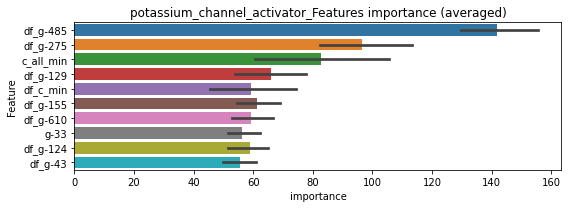

len(train_index) : 3887
len(valid_index) : 3888
================================= fold 1/2 potassium_channel_activator=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0268807	valid_1's binary_logloss: 0.0527881
[200]	training's binary_logloss: 0.00488093	valid_1's binary_logloss: 0.0288548
[300]	training's binary_logloss: 0.00137185	valid_1's binary_logloss: 0.0248295
Early stopping, best iteration is:
[340]	training's binary_logloss: 0.000960359	valid_1's binary_logloss: 0.0241404


len(train_index) : 3888
len(valid_index) : 3887
================================= fold 2/2 potassium_channel_activator=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0247669	valid_1's binary_logloss: 0.0521209
[200]	training's binary_logloss: 0.00467217	valid_1's binary_logloss: 0.0249952
[300]	training's binary_logloss: 0.00137132	valid_1's binary_logloss: 0.0188328
Early stopping, best iteration is:
[345]	training's binary_logloss: 0.000929201	valid_1's binary_logloss: 0.0181897


potassium_channel_activator logloss: 0.02116542002557042


  acetylcholine_receptor_agonist acetylcholine_receptor_antagonist  \
0                       df_g-122                              c-30   
1                  clusters_df_c                         c_all_max   
2                          cnt_0                    clusters_g_all   
3                      c_all_min                          df_g-707   
4                        df_g-51                        clusters_g   
5                       df_c_min                          df_c_min   
6                          cnt_2                             g-514   
7                       df_g-736                          df_g-640   
8                          g-244                            df_c-6   
9                           c-73                          df_g-597   

  acetylcholinesterase_inhibitor adenosine_receptor_antagonist  \
0                      c_all_max                clusters_c_all   
1                      c_all_min                      df_c_min   
2                 clusters_g_al

potassium_channel_antagonist, len(trt): 98, len(othr): 3272, target_rate: 0.0041152 → Adj_target_rate: 0.0041375


neg labels: 3289 → selected neg labels: 3272


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0616449	valid_1's binary_logloss: 0.133739
[200]	training's binary_logloss: 0.0153798	valid_1's binary_logloss: 0.0883486
[300]	training's binary_logloss: 0.00482545	valid_1's binary_logloss: 0.074947
[400]	training's binary_logloss: 0.00216433	valid_1's binary_logloss: 0.0710212
Early stopping, best iteration is:
[425]	training's binary_logloss: 0.00187082	valid_1's binary_logloss: 0.0705857
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0662798	valid_1's binary_logloss: 0.124936
[200]	training's binary_logloss: 0.0166581	valid_1's binary_logloss: 0.0715204
[300]	training's binary_logloss: 0.00522842	valid_1's binary_logloss: 0.0543974
Early stopping, best iteration is:
[380]	training's binary_logloss: 0.0026839	valid_1's binary_logloss: 0.0494146


1 / 3 AUC score:0.995
Threshold: 0.0163416, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 154 → positive_corect_labels: 643/3772
p_label_rate: 0.0301356 Vs.target_rate: 0.00412, Num_p_label: 120.0, conf_0:0.00306, conf_1:0.01798
Num_p_label: 120.0, Expected: 16.4, Adj_threshold_1: 0.0163416
Num_p_label: 73.0, Expected: 16.4, Adj_threshold_2: 0.0213416
Num_p_label: 44.0, Expected: 16.4, Adj_threshold_3: 0.0263416
Num_p_label: 29.0, Expected: 16.4, Adj_threshold_4: 0.0313416
threshold: 0.0313416, positive p_label: 29.0/3982, p_label_rate: 0.0072828
positive y_label: 643.0/3772, y_label_rate: 0.1704666
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.058374	valid_1's binary_logloss: 0.120358
[200]	training's binary_logloss: 0.0144031	valid_1's binary_logloss: 0.0741055
[300]	training's binary_logloss: 0.00447803	valid_1's binary_logloss: 0.0597385
Early stopping, best iteration is:
[345]	training's binary_logloss: 0.00298866	valid_1's binary_logloss: 0.0565806
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0607114	valid_1's binary_logloss: 0.119246
[200]	training's binary_logloss: 0.0154348	valid_1's binary_logloss: 0.0682493
[300]	training's binary_logloss: 0.0049279	valid_1's binary_logloss: 0.0545388
Early stopping, best iteration is:
[389]	training's binary_logloss: 0.00237558	valid_1's binary_logloss: 0.0505011


2 / 3 AUC score:0.997
Threshold: 0.0313416, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 46 → positive_corect_labels: 632.0/3726
p_label_rate: 0.0183325 Vs.target_rate: 0.00412, Num_p_label: 73.0, conf_0:0.00370, conf_1:0.03448
Num_p_label: 73.0, Expected: 16.4, Adj_threshold_1: 0.0313416
Num_p_label: 55.0, Expected: 16.4, Adj_threshold_2: 0.0363416
Num_p_label: 44.0, Expected: 16.4, Adj_threshold_3: 0.0413416
Num_p_label: 33.0, Expected: 16.4, Adj_threshold_4: 0.0463416
Num_p_label: 28.0, Expected: 16.4, Adj_threshold_5: 0.0513416
threshold: 0.0513416, positive p_label: 28.0/3982, p_label_rate: 0.0070316
positive y_label: 632.0/3726, y_label_rate: 0.1696189
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0572359	valid_1's binary_logloss: 0.119018
[200]	training's binary_logloss: 0.0132829	valid_1's binary_logloss: 0.0688396
[300]	training's binary_logloss: 0.00413514	valid_1's binary_logloss: 0.0540359
Early stopping, best iteration is:
[385]	training's binary_logloss: 0.0021062	valid_1's binary_logloss: 0.0499756
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0601185	valid_1's binary_logloss: 0.113599
[200]	training's binary_logloss: 0.0146316	valid_1's binary_logloss: 0.0570836
[300]	training's binary_logloss: 0.00456735	valid_1's binary_logloss: 0.0398949
[400]	training's binary_logloss: 0.00206015	valid_1's binary_logloss: 0.0344182
[500]	training's binary_logloss: 0.00123969	valid_1's binary_logloss: 0.0323062
Early stopping, best iteration is:
[490]	training's binary_logloss: 0.0012917	valid_1's binary_logloss: 0.0322942


3 / 3 AUC score:0.999
Threshold: 0.0513416, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 17 → positive_corect_labels: 618.0/3709
p_label_rate: 0.0047715 Vs.target_rate: 0.00412, Num_p_label: 19.0, conf_0:0.00255, conf_1:0.05648
threshold: 0.0513416, positive p_label: 19.0/3982, p_label_rate: 0.0047715
positive y_label: 637.0/7691, y_label_rate: 0.0828241


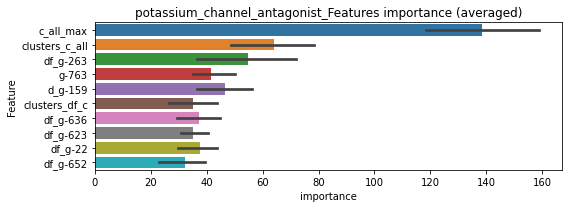

len(train_index) : 3845
len(valid_index) : 3846
================================= fold 1/2 potassium_channel_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0324511	valid_1's binary_logloss: 0.0727168
[200]	training's binary_logloss: 0.00749355	valid_1's binary_logloss: 0.0450674
[300]	training's binary_logloss: 0.002236	valid_1's binary_logloss: 0.0385473
Early stopping, best iteration is:
[348]	training's binary_logloss: 0.00145894	valid_1's binary_logloss: 0.0378704


len(train_index) : 3846
len(valid_index) : 3845
================================= fold 2/2 potassium_channel_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0319769	valid_1's binary_logloss: 0.0678507
[200]	training's binary_logloss: 0.00748321	valid_1's binary_logloss: 0.0408761
[300]	training's binary_logloss: 0.00233427	valid_1's binary_logloss: 0.0327564
Early stopping, best iteration is:
[369]	training's binary_logloss: 0.00127008	valid_1's binary_logloss: 0.0303991


potassium_channel_antagonist logloss: 0.03413527514707168


  acetylcholine_receptor_agonist acetylcholine_receptor_antagonist  \
0                       df_g-122                              c-30   
1                  clusters_df_c                         c_all_max   
2                          cnt_0                    clusters_g_all   
3                      c_all_min                          df_g-707   
4                        df_g-51                        clusters_g   
5                       df_c_min                          df_c_min   
6                          cnt_2                             g-514   
7                       df_g-736                          df_g-640   
8                          g-244                            df_c-6   
9                           c-73                          df_g-597   

  acetylcholinesterase_inhibitor adenosine_receptor_antagonist  \
0                      c_all_max                clusters_c_all   
1                      c_all_min                      df_c_min   
2                 clusters_g_al

ppar_receptor_agonist, len(trt): 115, len(othr): 3269, target_rate: 0.0048291 → Adj_target_rate: 0.0047401


neg labels: 3289 → selected neg labels: 3269


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0545941	valid_1's binary_logloss: 0.140268
[200]	training's binary_logloss: 0.0118497	valid_1's binary_logloss: 0.0922052
[300]	training's binary_logloss: 0.00390454	valid_1's binary_logloss: 0.0814361
Early stopping, best iteration is:
[385]	training's binary_logloss: 0.00200672	valid_1's binary_logloss: 0.0788681
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0568817	valid_1's binary_logloss: 0.132596
[200]	training's binary_logloss: 0.0131704	valid_1's binary_logloss: 0.0822297
[300]	training's binary_logloss: 0.0042738	valid_1's binary_logloss: 0.0677659
Early stopping, best iteration is:
[332]	training's binary_logloss: 0.00323426	valid_1's binary_logloss: 0.0658553


1 / 3 AUC score:0.995
Threshold: 0.0209728, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 162 → positive_corect_labels: 638/3760
p_label_rate: 0.0725766 Vs.target_rate: 0.00483, Num_p_label: 289.0, conf_0:0.00360, conf_1:0.02307
Num_p_label: 289.0, Expected: 19.2, Adj_threshold_1: 0.0209728
Num_p_label: 234.0, Expected: 19.2, Adj_threshold_2: 0.0259728
Num_p_label: 205.0, Expected: 19.2, Adj_threshold_3: 0.0309728
Num_p_label: 180.0, Expected: 19.2, Adj_threshold_4: 0.0359728
Num_p_label: 156.0, Expected: 19.2, Adj_threshold_5: 0.0409728
Num_p_label: 146.0, Expected: 19.2, Adj_threshold_6: 0.0459728
Num_p_label: 138.0, Expected: 19.2, Adj_threshold_7: 0.0509728
Num_p_label: 129.0, Expected: 19.2, Adj_threshold_8: 0.0559728
Num_p_label: 126.0, Expected: 19.2, Adj_threshold_9: 0.0609728
Num_p_label: 120.0, Expected: 19.2, Adj_threshold_10: 0.0659728
threshold: 0.0709728, positive p_label: 113.0/3982, p_label_rate: 0.0283777
positive y_label: 638.0/3760, y_label_rate: 0.1696809
==========

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0519711	valid_1's binary_logloss: 0.116614
[200]	training's binary_logloss: 0.0107603	valid_1's binary_logloss: 0.0652678
[300]	training's binary_logloss: 0.0034683	valid_1's binary_logloss: 0.0526521
Early stopping, best iteration is:
[375]	training's binary_logloss: 0.00196616	valid_1's binary_logloss: 0.0482813
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0528927	valid_1's binary_logloss: 0.123801
[200]	training's binary_logloss: 0.0114497	valid_1's binary_logloss: 0.0750067
[300]	training's binary_logloss: 0.00364974	valid_1's binary_logloss: 0.060926
[400]	training's binary_logloss: 0.00175953	valid_1's binary_logloss: 0.0581754
Early stopping, best iteration is:
[393]	training's binary_logloss: 0.00183262	valid_1's binary_logloss: 0.0580797


2 / 3 AUC score:0.997
Threshold: 0.0709728, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 32 → positive_corect_labels: 619.0/3728
p_label_rate: 0.0406831 Vs.target_rate: 0.00483, Num_p_label: 162.0, conf_0:0.00297, conf_1:0.07807
Num_p_label: 162.0, Expected: 19.2, Adj_threshold_1: 0.0709728
Num_p_label: 157.0, Expected: 19.2, Adj_threshold_2: 0.0759728
Num_p_label: 150.0, Expected: 19.2, Adj_threshold_3: 0.0809728
Num_p_label: 147.0, Expected: 19.2, Adj_threshold_4: 0.0859728
Num_p_label: 144.0, Expected: 19.2, Adj_threshold_5: 0.0909728
Num_p_label: 140.0, Expected: 19.2, Adj_threshold_6: 0.0959728
Num_p_label: 138.0, Expected: 19.2, Adj_threshold_7: 0.1009728
Num_p_label: 132.0, Expected: 19.2, Adj_threshold_8: 0.1059728
Num_p_label: 131.0, Expected: 19.2, Adj_threshold_9: 0.1109728
Num_p_label: 129.0, Expected: 19.2, Adj_threshold_10: 0.1159728
threshold: 0.1209728, positive p_label: 124.0/3982, p_label_rate: 0.0311401
positive y_label: 619.0/3728, y_label_rate: 0.1660408
=========

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.048692	valid_1's binary_logloss: 0.111145
[200]	training's binary_logloss: 0.0102783	valid_1's binary_logloss: 0.0641436
[300]	training's binary_logloss: 0.00327246	valid_1's binary_logloss: 0.0539651
Early stopping, best iteration is:
[343]	training's binary_logloss: 0.00231252	valid_1's binary_logloss: 0.0527721
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0464672	valid_1's binary_logloss: 0.114125
[200]	training's binary_logloss: 0.00923736	valid_1's binary_logloss: 0.0705795
[300]	training's binary_logloss: 0.00297196	valid_1's binary_logloss: 0.0607069
Early stopping, best iteration is:
[344]	training's binary_logloss: 0.00206833	valid_1's binary_logloss: 0.0588445


3 / 3 AUC score:0.997
Threshold: 0.1209728, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 26 → positive_corect_labels: 595.0/3702
p_label_rate: 0.0401808 Vs.target_rate: 0.00483, Num_p_label: 160.0, conf_0:0.00308, conf_1:0.13307
Num_p_label: 160.0, Expected: 19.2, Adj_threshold_1: 0.1209728
Num_p_label: 160.0, Expected: 19.2, Adj_threshold_2: 0.1259728
Num_p_label: 157.0, Expected: 19.2, Adj_threshold_3: 0.1309728
Num_p_label: 155.0, Expected: 19.2, Adj_threshold_4: 0.1359728
Num_p_label: 154.0, Expected: 19.2, Adj_threshold_5: 0.1409728
Num_p_label: 154.0, Expected: 19.2, Adj_threshold_6: 0.1459728
Num_p_label: 152.0, Expected: 19.2, Adj_threshold_7: 0.1509728
Num_p_label: 149.0, Expected: 19.2, Adj_threshold_8: 0.1559728
Num_p_label: 147.0, Expected: 19.2, Adj_threshold_9: 0.1609728
Num_p_label: 146.0, Expected: 19.2, Adj_threshold_10: 0.1659728
threshold: 0.1709728, positive p_label: 145.0/3982, p_label_rate: 0.0364139
positive y_label: 740.0/7684, y_label_rate: 0.0963040


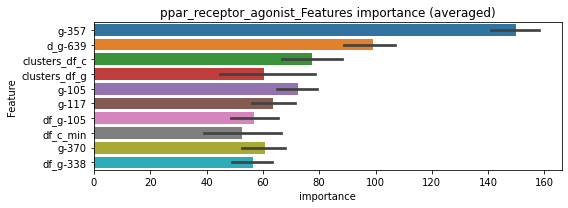

len(train_index) : 3842
len(valid_index) : 3842
================================= fold 1/2 ppar_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0294223	valid_1's binary_logloss: 0.0728644
[200]	training's binary_logloss: 0.00584844	valid_1's binary_logloss: 0.0488125
[300]	training's binary_logloss: 0.00184785	valid_1's binary_logloss: 0.0443366
Early stopping, best iteration is:
[357]	training's binary_logloss: 0.00116649	valid_1's binary_logloss: 0.0433608


len(train_index) : 3842
len(valid_index) : 3842
================================= fold 2/2 ppar_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0292295	valid_1's binary_logloss: 0.0658118
[200]	training's binary_logloss: 0.00587073	valid_1's binary_logloss: 0.0392613
[300]	training's binary_logloss: 0.00183631	valid_1's binary_logloss: 0.0331276
Early stopping, best iteration is:
[380]	training's binary_logloss: 0.000998077	valid_1's binary_logloss: 0.0310661


ppar_receptor_agonist logloss: 0.03721345397852804


  acetylcholine_receptor_agonist acetylcholine_receptor_antagonist  \
0                       df_g-122                              c-30   
1                  clusters_df_c                         c_all_max   
2                          cnt_0                    clusters_g_all   
3                      c_all_min                          df_g-707   
4                        df_g-51                        clusters_g   
5                       df_c_min                          df_c_min   
6                          cnt_2                             g-514   
7                       df_g-736                          df_g-640   
8                          g-244                            df_c-6   
9                           c-73                          df_g-597   

  acetylcholinesterase_inhibitor adenosine_receptor_antagonist  \
0                      c_all_max                clusters_c_all   
1                      c_all_min                      df_c_min   
2                 clusters_g_al

ppar_receptor_antagonist, len(trt): 30, len(othr): 3284, target_rate: 0.0012598 → Adj_target_rate: 0.0015127


neg labels: 3289 → selected neg labels: 3284


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0348972	valid_1's binary_logloss: 0.0512967
[200]	training's binary_logloss: 0.00491879	valid_1's binary_logloss: 0.0123532
[300]	training's binary_logloss: 0.00135098	valid_1's binary_logloss: 0.00572439
[400]	training's binary_logloss: 0.000659596	valid_1's binary_logloss: 0.00388995
[500]	training's binary_logloss: 0.000452235	valid_1's binary_logloss: 0.00324678
Early stopping, best iteration is:
[523]	training's binary_logloss: 0.00043492	valid_1's binary_logloss: 0.00318895
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0329249	valid_1's binary_logloss: 0.0576314
[200]	training's binary_logloss: 0.00474416	valid_1's binary_logloss: 0.0203041
[300]	training's binary_logloss: 0.00133508	valid_1's binary_logloss: 0.013646
[400]	training's binary_logloss: 0.00066204	valid_1's binary_logloss: 0.0112143
Early stopping, best iteration is:
[450]

1 / 3 AUC score:1.000
Threshold: 0.0033813, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → positive_corect_labels: 656/3808
p_label_rate: 0.0404319 Vs.target_rate: 0.00126, Num_p_label: 161.0, conf_0:0.00040, conf_1:0.00372
Num_p_label: 161.0, Expected: 5.0, Adj_threshold_1: 0.0033813
Num_p_label: 46.0, Expected: 5.0, Adj_threshold_2: 0.0083813
Num_p_label: 16.0, Expected: 5.0, Adj_threshold_3: 0.0133813
Num_p_label: 10.0, Expected: 5.0, Adj_threshold_4: 0.0183813
threshold: 0.0183813, positive p_label: 10.0/3982, p_label_rate: 0.0025113
positive y_label: 656.0/3808, y_label_rate: 0.1722689
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0339277	valid_1's binary_logloss: 0.0488509
[200]	training's binary_logloss: 0.0047638	valid_1's binary_logloss: 0.0118097
[300]	training's binary_logloss: 0.00132157	valid_1's binary_logloss: 0.00543764
[400]	training's binary_logloss: 0.000650175	valid_1's binary_logloss: 0.00369231
[500]	training's binary_logloss: 0.000450998	valid_1's binary_logloss: 0.00306916
[600]	training's binary_logloss: 0.000408414	valid_1's binary_logloss: 0.00291254
Early stopping, best iteration is:
[602]	training's binary_logloss: 0.000408201	valid_1's binary_logloss: 0.0029124
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0323715	valid_1's binary_logloss: 0.0570857
[200]	training's binary_logloss: 0.00456365	valid_1's binary_logloss: 0.0207048
[300]	training's binary_logloss: 0.00128423	valid_1's binary_logloss: 0.0129612
[400]	training's binary_logloss: 0.000

2 / 3 AUC score:1.000
Threshold: 0.0183813, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 2 → positive_corect_labels: 656.0/3806
p_label_rate: 0.0125565 Vs.target_rate: 0.00126, Num_p_label: 50.0, conf_0:0.00043, conf_1:0.02022
Num_p_label: 50.0, Expected: 5.0, Adj_threshold_1: 0.0183813
Num_p_label: 33.0, Expected: 5.0, Adj_threshold_2: 0.0233813
Num_p_label: 28.0, Expected: 5.0, Adj_threshold_3: 0.0283813
Num_p_label: 24.0, Expected: 5.0, Adj_threshold_4: 0.0333813
Num_p_label: 20.0, Expected: 5.0, Adj_threshold_5: 0.0383813
Num_p_label: 15.0, Expected: 5.0, Adj_threshold_6: 0.0433813
Num_p_label: 14.0, Expected: 5.0, Adj_threshold_7: 0.0483813
Num_p_label: 13.0, Expected: 5.0, Adj_threshold_8: 0.0533813
Num_p_label: 9.0, Expected: 5.0, Adj_threshold_9: 0.0583813
threshold: 0.0583813, positive p_label: 9.0/3982, p_label_rate: 0.0022602
positive y_label: 656.0/3806, y_label_rate: 0.1723594
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0339768	valid_1's binary_logloss: 0.0484519
[200]	training's binary_logloss: 0.00483992	valid_1's binary_logloss: 0.0114256
[300]	training's binary_logloss: 0.00133601	valid_1's binary_logloss: 0.00504873
[400]	training's binary_logloss: 0.000657325	valid_1's binary_logloss: 0.00334036
[500]	training's binary_logloss: 0.000450141	valid_1's binary_logloss: 0.0027071
Early stopping, best iteration is:
[587]	training's binary_logloss: 0.000410514	valid_1's binary_logloss: 0.00261064
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0332848	valid_1's binary_logloss: 0.0583658
[200]	training's binary_logloss: 0.00476988	valid_1's binary_logloss: 0.0214091
[300]	training's binary_logloss: 0.00132703	valid_1's binary_logloss: 0.0134877
[400]	training's binary_logloss: 0.000659401	valid_1's binary_logloss: 0.0112266
Early stopping, best iteration is:
[47

3 / 3 AUC score:1.000
Threshold: 0.0583813, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 3 → positive_corect_labels: 653.0/3803
p_label_rate: 0.0015068 Vs.target_rate: 0.00126, Num_p_label: 6.0, conf_0:0.00043, conf_1:0.06422
threshold: 0.0583813, positive p_label: 6.0/3982, p_label_rate: 0.0015068
positive y_label: 659.0/7785, y_label_rate: 0.0846500


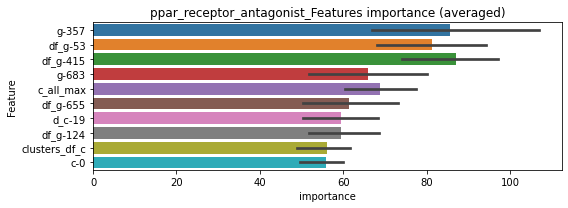

len(train_index) : 3892
len(valid_index) : 3893
================================= fold 1/2 ppar_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0177669	valid_1's binary_logloss: 0.0273085
[200]	training's binary_logloss: 0.00252766	valid_1's binary_logloss: 0.00980327
[300]	training's binary_logloss: 0.000680962	valid_1's binary_logloss: 0.00758114
Early stopping, best iteration is:
[330]	training's binary_logloss: 0.000523491	valid_1's binary_logloss: 0.00742971


len(train_index) : 3893
len(valid_index) : 3892
================================= fold 2/2 ppar_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0190038	valid_1's binary_logloss: 0.02693
[200]	training's binary_logloss: 0.00269898	valid_1's binary_logloss: 0.00625118
[300]	training's binary_logloss: 0.000755749	valid_1's binary_logloss: 0.00285292
[400]	training's binary_logloss: 0.000362448	valid_1's binary_logloss: 0.00211226
[500]	training's binary_logloss: 0.000239077	valid_1's binary_logloss: 0.00183974
Early stopping, best iteration is:
[506]	training's binary_logloss: 0.000236105	valid_1's binary_logloss: 0.00183193


ppar_receptor_antagonist logloss: 0.004631181054372516
progesterone_receptor_agonist, len(trt): 119, len(othr): 3271, target_rate: 0.0049971 → Adj_target_rate: 0.0048799


neg labels: 3289 → selected neg labels: 3271


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0658193	valid_1's binary_logloss: 0.158293
[200]	training's binary_logloss: 0.0162245	valid_1's binary_logloss: 0.112646
[300]	training's binary_logloss: 0.00506743	valid_1's binary_logloss: 0.100916
Early stopping, best iteration is:
[346]	training's binary_logloss: 0.00335729	valid_1's binary_logloss: 0.098526
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0659616	valid_1's binary_logloss: 0.151404
[200]	training's binary_logloss: 0.0169747	valid_1's binary_logloss: 0.0991201
[300]	training's binary_logloss: 0.00545401	valid_1's binary_logloss: 0.0851275
[400]	training's binary_logloss: 0.00244397	valid_1's binary_logloss: 0.0813183
Early stopping, best iteration is:
[451]	training's binary_logloss: 0.00180639	valid_1's binary_logloss: 0.079845


1 / 3 AUC score:0.991
Threshold: 0.0203418, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 183 → positive_corect_labels: 628/3742
p_label_rate: 0.0339026 Vs.target_rate: 0.00500, Num_p_label: 135.0, conf_0:0.00376, conf_1:0.02238
Num_p_label: 135.0, Expected: 19.9, Adj_threshold_1: 0.0203418
Num_p_label: 89.0, Expected: 19.9, Adj_threshold_2: 0.0253418
Num_p_label: 58.0, Expected: 19.9, Adj_threshold_3: 0.0303418
Num_p_label: 48.0, Expected: 19.9, Adj_threshold_4: 0.0353418
Num_p_label: 40.0, Expected: 19.9, Adj_threshold_5: 0.0403418
Num_p_label: 31.0, Expected: 19.9, Adj_threshold_6: 0.0453418
threshold: 0.0453418, positive p_label: 31.0/3982, p_label_rate: 0.0077850
positive y_label: 628.0/3742, y_label_rate: 0.1678247
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0613129	valid_1's binary_logloss: 0.133312
[200]	training's binary_logloss: 0.0148079	valid_1's binary_logloss: 0.0809127
[300]	training's binary_logloss: 0.00469411	valid_1's binary_logloss: 0.0652865
Early stopping, best iteration is:
[336]	training's binary_logloss: 0.00336918	valid_1's binary_logloss: 0.0626193
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0617785	valid_1's binary_logloss: 0.127605
[200]	training's binary_logloss: 0.0150272	valid_1's binary_logloss: 0.0715734
[300]	training's binary_logloss: 0.0047171	valid_1's binary_logloss: 0.0533436
[400]	training's binary_logloss: 0.00216195	valid_1's binary_logloss: 0.0481271
Early stopping, best iteration is:
[477]	training's binary_logloss: 0.00144887	valid_1's binary_logloss: 0.0460168


2 / 3 AUC score:0.999
Threshold: 0.0453418, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 32 → positive_corect_labels: 617.0/3710
p_label_rate: 0.0130588 Vs.target_rate: 0.00500, Num_p_label: 52.0, conf_0:0.00376, conf_1:0.04988
threshold: 0.0453418, positive p_label: 52.0/3982, p_label_rate: 0.0130588
positive y_label: 617.0/3710, y_label_rate: 0.1663073
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0614529	valid_1's binary_logloss: 0.131423
[200]	training's binary_logloss: 0.0143093	valid_1's binary_logloss: 0.0819738
[300]	training's binary_logloss: 0.00444737	valid_1's binary_logloss: 0.0676435
[400]	training's binary_logloss: 0.00202988	valid_1's binary_logloss: 0.0632709
Early stopping, best iteration is:
[397]	training's binary_logloss: 0.00206923	valid_1's binary_logloss: 0.0631726
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.058065	valid_1's binary_logloss: 0.123612
[200]	training's binary_logloss: 0.0136016	valid_1's binary_logloss: 0.0780009
[300]	training's binary_logloss: 0.00434157	valid_1's binary_logloss: 0.0640532
Early stopping, best iteration is:
[350]	training's binary_logloss: 0.00282513	valid_1's binary_logloss: 0.0614634


3 / 3 AUC score:0.998
Threshold: 0.0453418, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 27 → positive_corect_labels: 600.0/3683
p_label_rate: 0.0140633 Vs.target_rate: 0.00500, Num_p_label: 56.0, conf_0:0.00384, conf_1:0.04988
threshold: 0.0453418, positive p_label: 56.0/3982, p_label_rate: 0.0140633
positive y_label: 656.0/7665, y_label_rate: 0.0855838


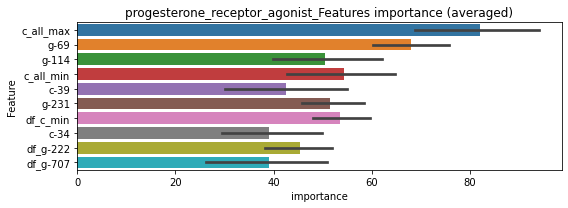

len(train_index) : 3832
len(valid_index) : 3833
================================= fold 1/2 progesterone_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0356879	valid_1's binary_logloss: 0.0896169
[200]	training's binary_logloss: 0.00826391	valid_1's binary_logloss: 0.063375
[300]	training's binary_logloss: 0.0025669	valid_1's binary_logloss: 0.0582077
Early stopping, best iteration is:
[328]	training's binary_logloss: 0.00197979	valid_1's binary_logloss: 0.0575838


len(train_index) : 3833
len(valid_index) : 3832
================================= fold 2/2 progesterone_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0373702	valid_1's binary_logloss: 0.0873623
[200]	training's binary_logloss: 0.00945342	valid_1's binary_logloss: 0.0621974
Early stopping, best iteration is:
[283]	training's binary_logloss: 0.00354121	valid_1's binary_logloss: 0.056095


progesterone_receptor_agonist logloss: 0.05683947936191332


  acetylcholine_receptor_agonist acetylcholine_receptor_antagonist  \
0                       df_g-122                              c-30   
1                  clusters_df_c                         c_all_max   
2                          cnt_0                    clusters_g_all   
3                      c_all_min                          df_g-707   
4                        df_g-51                        clusters_g   
5                       df_c_min                          df_c_min   
6                          cnt_2                             g-514   
7                       df_g-736                          df_g-640   
8                          g-244                            df_c-6   
9                           c-73                          df_g-597   

  acetylcholinesterase_inhibitor adenosine_receptor_antagonist  \
0                      c_all_max                clusters_c_all   
1                      c_all_min                      df_c_min   
2                 clusters_g_al

progesterone_receptor_antagonist, len(trt): 18, len(othr): 3286, target_rate: 0.0007559 → Adj_target_rate: 0.0009799


neg labels: 3289 → selected neg labels: 3286


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0222917	valid_1's binary_logloss: 0.0313803
[200]	training's binary_logloss: 0.00253452	valid_1's binary_logloss: 0.00653694
[300]	training's binary_logloss: 0.000719646	valid_1's binary_logloss: 0.00342553
[400]	training's binary_logloss: 0.000381766	valid_1's binary_logloss: 0.00251125
Early stopping, best iteration is:
[480]	training's binary_logloss: 0.000316764	valid_1's binary_logloss: 0.0023429
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0230692	valid_1's binary_logloss: 0.0304345
[200]	training's binary_logloss: 0.00267452	valid_1's binary_logloss: 0.00477826
[300]	training's binary_logloss: 0.000749704	valid_1's binary_logloss: 0.00176192
[400]	training's binary_logloss: 0.000401551	valid_1's binary_logloss: 0.00111716
[500]	training's binary_logloss: 0.000314931	valid_1's binary_logloss: 0.000942896
Early stopping, best iteration 

1 / 3 AUC score:1.000
Threshold: 0.0015407, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → positive_corect_labels: 657/3811
p_label_rate: 0.0404319 Vs.target_rate: 0.00076, Num_p_label: 161.0, conf_0:0.00021, conf_1:0.00169
Num_p_label: 161.0, Expected: 3.0, Adj_threshold_1: 0.0015407
Num_p_label: 26.0, Expected: 3.0, Adj_threshold_2: 0.0065407
Num_p_label: 13.0, Expected: 3.0, Adj_threshold_3: 0.0115407
Num_p_label: 9.0, Expected: 3.0, Adj_threshold_4: 0.0165407
Num_p_label: 4.0, Expected: 3.0, Adj_threshold_5: 0.0215407
threshold: 0.0215407, positive p_label: 4.0/3982, p_label_rate: 0.0010045
positive y_label: 657.0/3811, y_label_rate: 0.1723957
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.022352	valid_1's binary_logloss: 0.032034
[200]	training's binary_logloss: 0.00251696	valid_1's binary_logloss: 0.0079552
[300]	training's binary_logloss: 0.000713026	valid_1's binary_logloss: 0.00499427
[400]	training's binary_logloss: 0.000385565	valid_1's binary_logloss: 0.00406954
Early stopping, best iteration is:
[441]	training's binary_logloss: 0.0003395	valid_1's binary_logloss: 0.00390544
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0228736	valid_1's binary_logloss: 0.0295649
[200]	training's binary_logloss: 0.00256761	valid_1's binary_logloss: 0.00400158
[300]	training's binary_logloss: 0.000726838	valid_1's binary_logloss: 0.00128897
[400]	training's binary_logloss: 0.000391551	valid_1's binary_logloss: 0.000735133
[500]	training's binary_logloss: 0.000311321	valid_1's binary_logloss: 0.000594778
Early stopping, best iteration is:

2 / 3 AUC score:1.000
Threshold: 0.0215407, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → positive_corect_labels: 657.0/3811
p_label_rate: 0.0057760 Vs.target_rate: 0.00076, Num_p_label: 23.0, conf_0:0.00025, conf_1:0.02369
Num_p_label: 23.0, Expected: 3.0, Adj_threshold_1: 0.0215407
Num_p_label: 20.0, Expected: 3.0, Adj_threshold_2: 0.0265407
Num_p_label: 18.0, Expected: 3.0, Adj_threshold_3: 0.0315407
Num_p_label: 16.0, Expected: 3.0, Adj_threshold_4: 0.0365407
Num_p_label: 11.0, Expected: 3.0, Adj_threshold_5: 0.0415407
Num_p_label: 10.0, Expected: 3.0, Adj_threshold_6: 0.0465407
Num_p_label: 8.0, Expected: 3.0, Adj_threshold_7: 0.0515407
Num_p_label: 7.0, Expected: 3.0, Adj_threshold_8: 0.0565407
Num_p_label: 7.0, Expected: 3.0, Adj_threshold_9: 0.0615407
Num_p_label: 6.0, Expected: 3.0, Adj_threshold_10: 0.0665407
threshold: 0.0665407, positive p_label: 6.0/3982, p_label_rate: 0.0015068
positive y_label: 657.0/3811, y_label_rate: 0.1723957
================= Pseudo labeling 3 /

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.022352	valid_1's binary_logloss: 0.032034
[200]	training's binary_logloss: 0.00251696	valid_1's binary_logloss: 0.0079552
[300]	training's binary_logloss: 0.000713026	valid_1's binary_logloss: 0.00499427
[400]	training's binary_logloss: 0.000385565	valid_1's binary_logloss: 0.00406954
Early stopping, best iteration is:
[441]	training's binary_logloss: 0.0003395	valid_1's binary_logloss: 0.00390544
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0228736	valid_1's binary_logloss: 0.0295649
[200]	training's binary_logloss: 0.00256761	valid_1's binary_logloss: 0.00400158
[300]	training's binary_logloss: 0.000726838	valid_1's binary_logloss: 0.00128897
[400]	training's binary_logloss: 0.000391551	valid_1's binary_logloss: 0.000735133
[500]	training's binary_logloss: 0.000311321	valid_1's binary_logloss: 0.000594778
Early stopping, best iteration is:

3 / 3 AUC score:1.000
Threshold: 0.0665407, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → positive_corect_labels: 657.0/3811
p_label_rate: 0.0015068 Vs.target_rate: 0.00076, Num_p_label: 6.0, conf_0:0.00025, conf_1:0.07319
threshold: 0.0665407, positive p_label: 6.0/3982, p_label_rate: 0.0015068
positive y_label: 663.0/7793, y_label_rate: 0.0850764


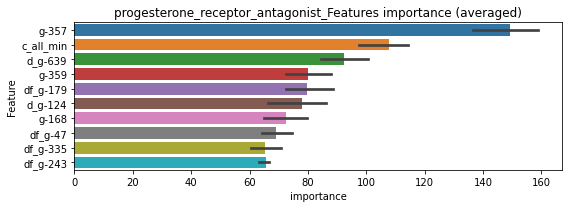

len(train_index) : 3896
len(valid_index) : 3897
================================= fold 1/2 progesterone_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0117959	valid_1's binary_logloss: 0.0187962
[200]	training's binary_logloss: 0.00130729	valid_1's binary_logloss: 0.0067655
Early stopping, best iteration is:
[249]	training's binary_logloss: 0.000621764	valid_1's binary_logloss: 0.00607713


len(train_index) : 3897
len(valid_index) : 3896
================================= fold 2/2 progesterone_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0122243	valid_1's binary_logloss: 0.017846
[200]	training's binary_logloss: 0.00143145	valid_1's binary_logloss: 0.00478419
[300]	training's binary_logloss: 0.000397819	valid_1's binary_logloss: 0.0028028
[400]	training's binary_logloss: 0.000209124	valid_1's binary_logloss: 0.0022077
[500]	training's binary_logloss: 0.000168027	valid_1's binary_logloss: 0.00213856
Early stopping, best iteration is:
[491]	training's binary_logloss: 0.000169248	valid_1's binary_logloss: 0.00213659


progesterone_receptor_antagonist logloss: 0.004107278013960126
prostaglandin_inhibitor, len(trt): 36, len(othr): 3283, target_rate: 0.0015117 → Adj_target_rate: 0.0017663


neg labels: 3289 → selected neg labels: 3283


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0356708	valid_1's binary_logloss: 0.058452
[200]	training's binary_logloss: 0.0058931	valid_1's binary_logloss: 0.0185903
[300]	training's binary_logloss: 0.00160709	valid_1's binary_logloss: 0.00988964
[400]	training's binary_logloss: 0.00077801	valid_1's binary_logloss: 0.00739833
Early stopping, best iteration is:
[456]	training's binary_logloss: 0.00059948	valid_1's binary_logloss: 0.00677372
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0355678	valid_1's binary_logloss: 0.065706
[200]	training's binary_logloss: 0.00554403	valid_1's binary_logloss: 0.0295626
[300]	training's binary_logloss: 0.00155636	valid_1's binary_logloss: 0.0213387
Early stopping, best iteration is:
[295]	training's binary_logloss: 0.00162905	valid_1's binary_logloss: 0.0210862


1 / 3 AUC score:1.000
Threshold: 0.0066369, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 134 → positive_corect_labels: 655/3805
p_label_rate: 0.0321447 Vs.target_rate: 0.00151, Num_p_label: 128.0, conf_0:0.00103, conf_1:0.00730
Num_p_label: 128.0, Expected: 6.0, Adj_threshold_1: 0.0066369
Num_p_label: 44.0, Expected: 6.0, Adj_threshold_2: 0.0116369
Num_p_label: 19.0, Expected: 6.0, Adj_threshold_3: 0.0166369
Num_p_label: 12.0, Expected: 6.0, Adj_threshold_4: 0.0216369
threshold: 0.0216369, positive p_label: 12.0/3982, p_label_rate: 0.0030136
positive y_label: 655.0/3805, y_label_rate: 0.1721419
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0365121	valid_1's binary_logloss: 0.0553755
[200]	training's binary_logloss: 0.00553657	valid_1's binary_logloss: 0.0168371
[300]	training's binary_logloss: 0.00157827	valid_1's binary_logloss: 0.00997521
[400]	training's binary_logloss: 0.000777514	valid_1's binary_logloss: 0.00840762
Early stopping, best iteration is:
[399]	training's binary_logloss: 0.000780172	valid_1's binary_logloss: 0.00839636
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0355118	valid_1's binary_logloss: 0.0633547
[200]	training's binary_logloss: 0.00538249	valid_1's binary_logloss: 0.0209261
[300]	training's binary_logloss: 0.00152129	valid_1's binary_logloss: 0.012115
[400]	training's binary_logloss: 0.000756988	valid_1's binary_logloss: 0.00955939
Early stopping, best iteration is:
[474]	training's binary_logloss: 0.000550303	valid_1's binary_logloss: 0.00867019


2 / 3 AUC score:1.000
Threshold: 0.0216369, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 9 → positive_corect_labels: 654.0/3796
p_label_rate: 0.0057760 Vs.target_rate: 0.00151, Num_p_label: 23.0, conf_0:0.00073, conf_1:0.02380
Num_p_label: 23.0, Expected: 6.0, Adj_threshold_1: 0.0216369
Num_p_label: 16.0, Expected: 6.0, Adj_threshold_2: 0.0266369
Num_p_label: 11.0, Expected: 6.0, Adj_threshold_3: 0.0316369
threshold: 0.0316369, positive p_label: 11.0/3982, p_label_rate: 0.0027624
positive y_label: 654.0/3796, y_label_rate: 0.1722866
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0354887	valid_1's binary_logloss: 0.0529432
[200]	training's binary_logloss: 0.00555176	valid_1's binary_logloss: 0.015129
[300]	training's binary_logloss: 0.00157933	valid_1's binary_logloss: 0.00752609
[400]	training's binary_logloss: 0.000781869	valid_1's binary_logloss: 0.00556614
[500]	training's binary_logloss: 0.000523125	valid_1's binary_logloss: 0.00481201
Early stopping, best iteration is:
[520]	training's binary_logloss: 0.000504177	valid_1's binary_logloss: 0.00477609
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0357718	valid_1's binary_logloss: 0.0624616
[200]	training's binary_logloss: 0.00539715	valid_1's binary_logloss: 0.0211832
[300]	training's binary_logloss: 0.00152904	valid_1's binary_logloss: 0.0124488
[400]	training's binary_logloss: 0.000758259	valid_1's binary_logloss: 0.00994764
Early stopping, best iteration is:
[4

3 / 3 AUC score:1.000
Threshold: 0.0316369, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 2 → positive_corect_labels: 654.0/3794
p_label_rate: 0.0017579 Vs.target_rate: 0.00151, Num_p_label: 7.0, conf_0:0.00063, conf_1:0.03480
threshold: 0.0316369, positive p_label: 7.0/3982, p_label_rate: 0.0017579
positive y_label: 661.0/7776, y_label_rate: 0.0850051


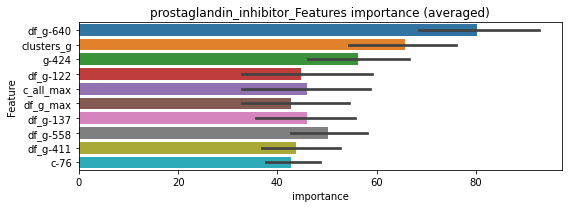

len(train_index) : 3888
len(valid_index) : 3888
================================= fold 1/2 prostaglandin_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.019968	valid_1's binary_logloss: 0.041276
[200]	training's binary_logloss: 0.00279583	valid_1's binary_logloss: 0.0191176
[300]	training's binary_logloss: 0.000775411	valid_1's binary_logloss: 0.0155295
Early stopping, best iteration is:
[355]	training's binary_logloss: 0.000491945	valid_1's binary_logloss: 0.014894


len(train_index) : 3888
len(valid_index) : 3888
================================= fold 2/2 prostaglandin_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0196098	valid_1's binary_logloss: 0.0337735
[200]	training's binary_logloss: 0.00310824	valid_1's binary_logloss: 0.0109594
[300]	training's binary_logloss: 0.00086247	valid_1's binary_logloss: 0.00666153
[400]	training's binary_logloss: 0.000423757	valid_1's binary_logloss: 0.00566617
[500]	training's binary_logloss: 0.000272831	valid_1's binary_logloss: 0.00509709
Early stopping, best iteration is:
[508]	training's binary_logloss: 0.000267003	valid_1's binary_logloss: 0.00505532


prostaglandin_inhibitor logloss: 0.009974681731248079
prostanoid_receptor_antagonist, len(trt): 84, len(othr): 3274, target_rate: 0.0035273 → Adj_target_rate: 0.0036294


neg labels: 3289 → selected neg labels: 3274


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0535751	valid_1's binary_logloss: 0.114006
[200]	training's binary_logloss: 0.0129248	valid_1's binary_logloss: 0.0723209
[300]	training's binary_logloss: 0.00408085	valid_1's binary_logloss: 0.0596565
Early stopping, best iteration is:
[389]	training's binary_logloss: 0.00198234	valid_1's binary_logloss: 0.0556717
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0538159	valid_1's binary_logloss: 0.0978448
[200]	training's binary_logloss: 0.0132575	valid_1's binary_logloss: 0.0544482
[300]	training's binary_logloss: 0.00415671	valid_1's binary_logloss: 0.0409856
[400]	training's binary_logloss: 0.00187036	valid_1's binary_logloss: 0.036585
Early stopping, best iteration is:
[419]	training's binary_logloss: 0.0016812	valid_1's binary_logloss: 0.0359739


1 / 3 AUC score:0.998
Threshold: 0.0119856, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 140 → positive_corect_labels: 650/3788
p_label_rate: 0.0389252 Vs.target_rate: 0.00353, Num_p_label: 155.0, conf_0:0.00224, conf_1:0.01318
Num_p_label: 155.0, Expected: 14.0, Adj_threshold_1: 0.0119856
Num_p_label: 74.0, Expected: 14.0, Adj_threshold_2: 0.0169856
Num_p_label: 41.0, Expected: 14.0, Adj_threshold_3: 0.0219856
Num_p_label: 30.0, Expected: 14.0, Adj_threshold_4: 0.0269856
Num_p_label: 21.0, Expected: 14.0, Adj_threshold_5: 0.0319856
threshold: 0.0319856, positive p_label: 21.0/3982, p_label_rate: 0.0052737
positive y_label: 650.0/3788, y_label_rate: 0.1715945
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0518764	valid_1's binary_logloss: 0.10696
[200]	training's binary_logloss: 0.0120394	valid_1's binary_logloss: 0.0609452
[300]	training's binary_logloss: 0.00377036	valid_1's binary_logloss: 0.0481222
[400]	training's binary_logloss: 0.00174572	valid_1's binary_logloss: 0.0438228
Early stopping, best iteration is:
[395]	training's binary_logloss: 0.00180617	valid_1's binary_logloss: 0.0436202
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0555287	valid_1's binary_logloss: 0.100702
[200]	training's binary_logloss: 0.0132852	valid_1's binary_logloss: 0.0548962
[300]	training's binary_logloss: 0.00413006	valid_1's binary_logloss: 0.0405373
[400]	training's binary_logloss: 0.00186571	valid_1's binary_logloss: 0.0357444
[500]	training's binary_logloss: 0.0011339	valid_1's binary_logloss: 0.0337369
Early stopping, best iteration is:
[505]	training's

2 / 3 AUC score:0.999
Threshold: 0.0319856, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 14 → positive_corect_labels: 645.0/3774
p_label_rate: 0.0080362 Vs.target_rate: 0.00353, Num_p_label: 32.0, conf_0:0.00201, conf_1:0.03518
threshold: 0.0319856, positive p_label: 32.0/3982, p_label_rate: 0.0080362
positive y_label: 645.0/3774, y_label_rate: 0.1709062
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0529004	valid_1's binary_logloss: 0.10617
[200]	training's binary_logloss: 0.0115444	valid_1's binary_logloss: 0.0623059
[300]	training's binary_logloss: 0.00358396	valid_1's binary_logloss: 0.0496702
[400]	training's binary_logloss: 0.00165878	valid_1's binary_logloss: 0.046872
Early stopping, best iteration is:
[426]	training's binary_logloss: 0.00143164	valid_1's binary_logloss: 0.0464256
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.052733	valid_1's binary_logloss: 0.0993513
[200]	training's binary_logloss: 0.0122875	valid_1's binary_logloss: 0.0535024
[300]	training's binary_logloss: 0.00384715	valid_1's binary_logloss: 0.040541
[400]	training's binary_logloss: 0.00175876	valid_1's binary_logloss: 0.0368204
Early stopping, best iteration is:
[440]	training's binary_logloss: 0.00140446	valid_1's binary_logloss: 0.0358027


3 / 3 AUC score:1.000
Threshold: 0.0319856, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 19 → positive_corect_labels: 634.0/3755
p_label_rate: 0.0097941 Vs.target_rate: 0.00353, Num_p_label: 39.0, conf_0:0.00200, conf_1:0.03518
threshold: 0.0319856, positive p_label: 39.0/3982, p_label_rate: 0.0097941
positive y_label: 673.0/7737, y_label_rate: 0.0869846


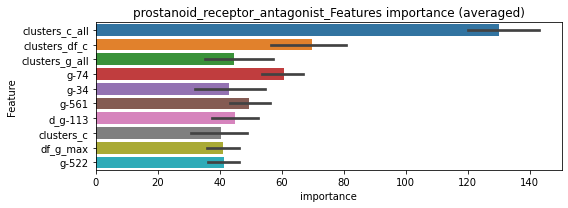

len(train_index) : 3868
len(valid_index) : 3869
================================= fold 1/2 prostanoid_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0300668	valid_1's binary_logloss: 0.0720016
[200]	training's binary_logloss: 0.00695262	valid_1's binary_logloss: 0.0493631
[300]	training's binary_logloss: 0.00214105	valid_1's binary_logloss: 0.0456079
Early stopping, best iteration is:
[305]	training's binary_logloss: 0.00203305	valid_1's binary_logloss: 0.0454761


len(train_index) : 3869
len(valid_index) : 3868
================================= fold 2/2 prostanoid_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0354196	valid_1's binary_logloss: 0.0681478
[200]	training's binary_logloss: 0.00828747	valid_1's binary_logloss: 0.0430671
Early stopping, best iteration is:
[257]	training's binary_logloss: 0.00401067	valid_1's binary_logloss: 0.0397859


prostanoid_receptor_antagonist logloss: 0.042631352519000194


  acetylcholine_receptor_agonist acetylcholine_receptor_antagonist  \
0                       df_g-122                              c-30   
1                  clusters_df_c                         c_all_max   
2                          cnt_0                    clusters_g_all   
3                      c_all_min                          df_g-707   
4                        df_g-51                        clusters_g   
5                       df_c_min                          df_c_min   
6                          cnt_2                             g-514   
7                       df_g-736                          df_g-640   
8                          g-244                            df_c-6   
9                           c-73                          df_g-597   

  acetylcholinesterase_inhibitor adenosine_receptor_antagonist  \
0                      c_all_max                clusters_c_all   
1                      c_all_min                      df_c_min   
2                 clusters_g_al

proteasome_inhibitor, len(trt): 726, len(othr): 3285, target_rate: 0.0304863 → Adj_target_rate: 0.0226983
================= Pseudo labeling 1 / 3 =================


neg labels: 3289 → selected neg labels: 3285
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0212827	valid_1's binary_logloss: 0.0244435
[200]	training's binary_logloss: 0.0020571	valid_1's binary_logloss: 0.00806221
Early stopping, best iteration is:
[270]	training's binary_logloss: 0.000655765	valid_1's binary_logloss: 0.00638466
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.019636	valid_1's binary_logloss: 0.0278018
[200]	training's binary_logloss: 0.00185268	valid_1's binary_logloss: 0.011401


1 / 3 AUC score:1.000
Threshold: 0.0003609, pos_neg_ratio: 0.7789954
Remove_noisy_labels: 161 → positive_corect_labels: 726/3850
p_label_rate: 0.0811150 Vs.target_rate: 0.03049, Num_p_label: 323.0, conf_0:0.00013, conf_1:0.00040
threshold: 0.0003609, positive p_label: 323.0/3982, p_label_rate: 0.0811150


Early stopping, best iteration is:
[250]	training's binary_logloss: 0.000781106	valid_1's binary_logloss: 0.0107195


positive y_label: 726.0/3850, y_label_rate: 0.1885714
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0155462	valid_1's binary_logloss: 0.0161173
[200]	training's binary_logloss: 0.000996498	valid_1's binary_logloss: 0.00125315
[300]	training's binary_logloss: 0.000220382	valid_1's binary_logloss: 0.000399915
[400]	training's binary_logloss: 0.000146386	valid_1's binary_logloss: 0.00029815
[500]	training's binary_logloss: 0.000133551	valid_1's binary_logloss: 0.000279496
[600]	training's binary_logloss: 0.000130182	valid_1's binary_logloss: 0.000275034
[700]	training's binary_logloss: 0.000129239	valid_1's binary_logloss: 0.000273812
Early stopping, best iteration is:
[764]	training's binary_logloss: 0.000128913	valid_1's binary_logloss: 0.000273382
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0156064	valid_1's binary_logloss: 0.0164068
[200]	training's binary_logloss: 0.00100568	valid_1's binary_logloss: 0.00144108
[300]	training's binary_l

2 / 3 AUC score:1.000
Threshold: 0.0003609, pos_neg_ratio: 0.7789954
Remove_noisy_labels: 14 → positive_corect_labels: 726.0/3836
p_label_rate: 0.0668006 Vs.target_rate: 0.03049, Num_p_label: 266.0, conf_0:0.00008, conf_1:0.00040
threshold: 0.0003609, positive p_label: 266.0/3982, p_label_rate: 0.0668006
positive y_label: 726.0/3836, y_label_rate: 0.1892596
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0155608	valid_1's binary_logloss: 0.015824
[200]	training's binary_logloss: 0.000995758	valid_1's binary_logloss: 0.00112038
[300]	training's binary_logloss: 0.000220673	valid_1's binary_logloss: 0.000321007
[400]	training's binary_logloss: 0.000146786	valid_1's binary_logloss: 0.000241935
[500]	training's binary_logloss: 0.000133936	valid_1's binary_logloss: 0.000228255
[600]	training's binary_logloss: 0.000130632	valid_1's binary_logloss: 0.000224646
Early stopping, best iteration is:
[684]	training's binary_logloss: 0.000129685	valid_1's binary_logloss: 0.000223888
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.015581	valid_1's binary_logloss: 0.0167911
[200]	training's binary_logloss: 0.000998301	valid_1's binary_logloss: 0.0017636


3 / 3 AUC score:1.000
Threshold: 0.0003609, pos_neg_ratio: 0.7789954
Remove_noisy_labels: 11 → positive_corect_labels: 726.0/3825
p_label_rate: 0.0718232 Vs.target_rate: 0.03049, Num_p_label: 286.0, conf_0:0.00011, conf_1:0.00040


[300]	training's binary_logloss: 0.000221438	valid_1's binary_logloss: 0.000898805
Early stopping, best iteration is:
[300]	training's binary_logloss: 0.000221438	valid_1's binary_logloss: 0.000898805


threshold: 0.0003609, positive p_label: 286.0/3982, p_label_rate: 0.0718232
positive y_label: 1012.0/7807, y_label_rate: 0.1296273


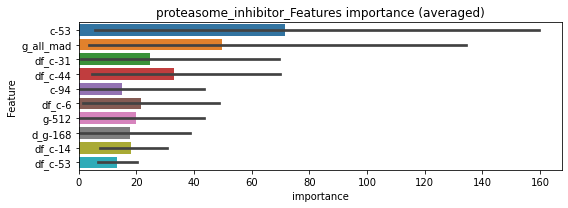

len(train_index) : 3903
len(valid_index) : 3904
================================= fold 1/2 proteasome_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.014444	valid_1's binary_logloss: 0.0246688


len(train_index) : 3904
len(valid_index) : 3903


Early stopping, best iteration is:
[187]	training's binary_logloss: 0.00179084	valid_1's binary_logloss: 0.0141865


================================= fold 2/2 proteasome_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0147888	valid_1's binary_logloss: 0.0197984
[200]	training's binary_logloss: 0.00147536	valid_1's binary_logloss: 0.00906526


proteasome_inhibitor logloss: 0.011527463355584208


Early stopping, best iteration is:
[234]	training's binary_logloss: 0.000791321	valid_1's binary_logloss: 0.00886771


protein_kinase_inhibitor, len(trt): 48, len(othr): 3281, target_rate: 0.0020156 → Adj_target_rate: 0.0022556


neg labels: 3289 → selected neg labels: 3281


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0413484	valid_1's binary_logloss: 0.0731274
[200]	training's binary_logloss: 0.00740767	valid_1's binary_logloss: 0.0260645
[300]	training's binary_logloss: 0.00217162	valid_1's binary_logloss: 0.0151802
[400]	training's binary_logloss: 0.00104477	valid_1's binary_logloss: 0.0118394
[500]	training's binary_logloss: 0.000662816	valid_1's binary_logloss: 0.0104017
Early stopping, best iteration is:
[556]	training's binary_logloss: 0.000566492	valid_1's binary_logloss: 0.00996148
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0424514	valid_1's binary_logloss: 0.071738
[200]	training's binary_logloss: 0.00767703	valid_1's binary_logloss: 0.025557
[300]	training's binary_logloss: 0.00222288	valid_1's binary_logloss: 0.0150842
[400]	training's binary_logloss: 0.00105809	valid_1's binary_logloss: 0.0124317
[500]	training's binary_logloss: 0.000678049

1 / 3 AUC score:1.000
Threshold: 0.0045437, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → positive_corect_labels: 656/3805
p_label_rate: 0.0502260 Vs.target_rate: 0.00202, Num_p_label: 200.0, conf_0:0.00065, conf_1:0.00500
Num_p_label: 200.0, Expected: 8.0, Adj_threshold_1: 0.0045437
Num_p_label: 85.0, Expected: 8.0, Adj_threshold_2: 0.0095437
Num_p_label: 47.0, Expected: 8.0, Adj_threshold_3: 0.0145437
Num_p_label: 30.0, Expected: 8.0, Adj_threshold_4: 0.0195437
Num_p_label: 25.0, Expected: 8.0, Adj_threshold_5: 0.0245437
Num_p_label: 21.0, Expected: 8.0, Adj_threshold_6: 0.0295437
Num_p_label: 17.0, Expected: 8.0, Adj_threshold_7: 0.0345437
Num_p_label: 12.0, Expected: 8.0, Adj_threshold_8: 0.0395437
threshold: 0.0395437, positive p_label: 12.0/3982, p_label_rate: 0.0030136
positive y_label: 656.0/3805, y_label_rate: 0.1724047
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0410773	valid_1's binary_logloss: 0.0725394
[200]	training's binary_logloss: 0.0072627	valid_1's binary_logloss: 0.0259386
[300]	training's binary_logloss: 0.00214558	valid_1's binary_logloss: 0.014933
[400]	training's binary_logloss: 0.00102983	valid_1's binary_logloss: 0.011622
[500]	training's binary_logloss: 0.000656088	valid_1's binary_logloss: 0.0101109
Early stopping, best iteration is:
[570]	training's binary_logloss: 0.000551287	valid_1's binary_logloss: 0.00968588
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0399802	valid_1's binary_logloss: 0.0689262
[200]	training's binary_logloss: 0.00701186	valid_1's binary_logloss: 0.0251511
[300]	training's binary_logloss: 0.00205549	valid_1's binary_logloss: 0.0154347
[400]	training's binary_logloss: 0.00101348	valid_1's binary_logloss: 0.0128238
[500]	training's binary_logloss: 0.000658004	

2 / 3 AUC score:1.000
Threshold: 0.0395437, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 2 → positive_corect_labels: 655.0/3803
p_label_rate: 0.0077850 Vs.target_rate: 0.00202, Num_p_label: 31.0, conf_0:0.00074, conf_1:0.04350
Num_p_label: 31.0, Expected: 8.0, Adj_threshold_1: 0.0395437
Num_p_label: 28.0, Expected: 8.0, Adj_threshold_2: 0.0445437
Num_p_label: 27.0, Expected: 8.0, Adj_threshold_3: 0.0495437
Num_p_label: 25.0, Expected: 8.0, Adj_threshold_4: 0.0545437
Num_p_label: 23.0, Expected: 8.0, Adj_threshold_5: 0.0595437
Num_p_label: 21.0, Expected: 8.0, Adj_threshold_6: 0.0645437
Num_p_label: 19.0, Expected: 8.0, Adj_threshold_7: 0.0695437
Num_p_label: 16.0, Expected: 8.0, Adj_threshold_8: 0.0745437
threshold: 0.0745437, positive p_label: 16.0/3982, p_label_rate: 0.0040181
positive y_label: 655.0/3803, y_label_rate: 0.1722324
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0426358	valid_1's binary_logloss: 0.0779978
[200]	training's binary_logloss: 0.00758302	valid_1's binary_logloss: 0.03141
[300]	training's binary_logloss: 0.00215731	valid_1's binary_logloss: 0.0192556
[400]	training's binary_logloss: 0.00103655	valid_1's binary_logloss: 0.0161234
Early stopping, best iteration is:
[466]	training's binary_logloss: 0.000760664	valid_1's binary_logloss: 0.0149151
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0392312	valid_1's binary_logloss: 0.0694524
[200]	training's binary_logloss: 0.0069228	valid_1's binary_logloss: 0.0250429
[300]	training's binary_logloss: 0.00207783	valid_1's binary_logloss: 0.0147748
[400]	training's binary_logloss: 0.00100601	valid_1's binary_logloss: 0.0118617
[500]	training's binary_logloss: 0.000648345	valid_1's binary_logloss: 0.0101661
Early stopping, best iteration is:
[550]	train

3 / 3 AUC score:1.000
Threshold: 0.0745437, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 1 → positive_corect_labels: 654.0/3802
p_label_rate: 0.0040181 Vs.target_rate: 0.00202, Num_p_label: 16.0, conf_0:0.00087, conf_1:0.08200
threshold: 0.0745437, positive p_label: 16.0/3982, p_label_rate: 0.0040181
positive y_label: 670.0/7784, y_label_rate: 0.0860740


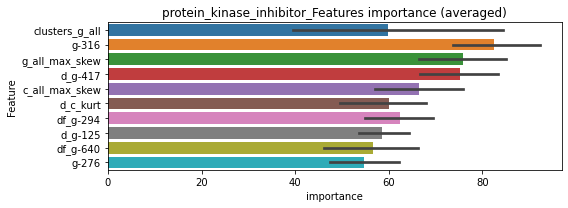

len(train_index) : 3892
len(valid_index) : 3892
================================= fold 1/2 protein_kinase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0234122	valid_1's binary_logloss: 0.0491
[200]	training's binary_logloss: 0.00414492	valid_1's binary_logloss: 0.0223328
[300]	training's binary_logloss: 0.00117597	valid_1's binary_logloss: 0.0159704
[400]	training's binary_logloss: 0.000551639	valid_1's binary_logloss: 0.0142111
[500]	training's binary_logloss: 0.000350049	valid_1's binary_logloss: 0.0134621
Early stopping, best iteration is:
[505]	training's binary_logloss: 0.000344517	valid_1's binary_logloss: 0.0133732


len(train_index) : 3892
len(valid_index) : 3892
================================= fold 2/2 protein_kinase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.023494	valid_1's binary_logloss: 0.0394234
[200]	training's binary_logloss: 0.00411081	valid_1's binary_logloss: 0.0151144
[300]	training's binary_logloss: 0.00118372	valid_1's binary_logloss: 0.0100424
[400]	training's binary_logloss: 0.00056121	valid_1's binary_logloss: 0.00874913
Early stopping, best iteration is:
[476]	training's binary_logloss: 0.00038952	valid_1's binary_logloss: 0.00841963


protein_kinase_inhibitor logloss: 0.010896407571241112
protein_phosphatase_inhibitor, len(trt): 24, len(othr): 3286, target_rate: 0.0010078 → Adj_target_rate: 0.0012513


neg labels: 3289 → selected neg labels: 3286


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.02687	valid_1's binary_logloss: 0.0437308
[200]	training's binary_logloss: 0.00349666	valid_1's binary_logloss: 0.0102549
[300]	training's binary_logloss: 0.000977582	valid_1's binary_logloss: 0.0045978
[400]	training's binary_logloss: 0.000504286	valid_1's binary_logloss: 0.00327997
[500]	training's binary_logloss: 0.000368706	valid_1's binary_logloss: 0.00278136
Early stopping, best iteration is:
[505]	training's binary_logloss: 0.000366582	valid_1's binary_logloss: 0.00277008
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0263478	valid_1's binary_logloss: 0.0395732
[200]	training's binary_logloss: 0.00341757	valid_1's binary_logloss: 0.00908118
[300]	training's binary_logloss: 0.000968007	valid_1's binary_logloss: 0.00461831
[400]	training's binary_logloss: 0.000502423	valid_1's binary_logloss: 0.00339938
[500]	training's binary_logloss: 0.

1 / 3 AUC score:1.000
Threshold: 0.0022662, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → positive_corect_labels: 657/3811
p_label_rate: 0.0374184 Vs.target_rate: 0.00101, Num_p_label: 149.0, conf_0:0.00026, conf_1:0.00249
Num_p_label: 149.0, Expected: 4.0, Adj_threshold_1: 0.0022662
Num_p_label: 31.0, Expected: 4.0, Adj_threshold_2: 0.0072662
Num_p_label: 12.0, Expected: 4.0, Adj_threshold_3: 0.0122662
Num_p_label: 9.0, Expected: 4.0, Adj_threshold_4: 0.0172662
Num_p_label: 6.0, Expected: 4.0, Adj_threshold_5: 0.0222662
threshold: 0.0222662, positive p_label: 6.0/3982, p_label_rate: 0.0015068
positive y_label: 657.0/3811, y_label_rate: 0.1723957
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0265974	valid_1's binary_logloss: 0.0407345
[200]	training's binary_logloss: 0.00339918	valid_1's binary_logloss: 0.00908283
[300]	training's binary_logloss: 0.000966471	valid_1's binary_logloss: 0.00414175
[400]	training's binary_logloss: 0.000495179	valid_1's binary_logloss: 0.00298118
Early stopping, best iteration is:
[448]	training's binary_logloss: 0.0004125	valid_1's binary_logloss: 0.00268822
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0264489	valid_1's binary_logloss: 0.0379117
[200]	training's binary_logloss: 0.00333081	valid_1's binary_logloss: 0.00756441
[300]	training's binary_logloss: 0.000943165	valid_1's binary_logloss: 0.00324594
[400]	training's binary_logloss: 0.000490208	valid_1's binary_logloss: 0.00219325
[500]	training's binary_logloss: 0.000366092	valid_1's binary_logloss: 0.00189219
Early stopping, best iteration is

2 / 3 AUC score:1.000
Threshold: 0.0222662, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → positive_corect_labels: 657.0/3811
p_label_rate: 0.0050226 Vs.target_rate: 0.00101, Num_p_label: 20.0, conf_0:0.00031, conf_1:0.02449
Num_p_label: 20.0, Expected: 4.0, Adj_threshold_1: 0.0222662
Num_p_label: 16.0, Expected: 4.0, Adj_threshold_2: 0.0272662
Num_p_label: 14.0, Expected: 4.0, Adj_threshold_3: 0.0322662
Num_p_label: 13.0, Expected: 4.0, Adj_threshold_4: 0.0372662
Num_p_label: 12.0, Expected: 4.0, Adj_threshold_5: 0.0422662
Num_p_label: 9.0, Expected: 4.0, Adj_threshold_6: 0.0472662
Num_p_label: 8.0, Expected: 4.0, Adj_threshold_7: 0.0522662
threshold: 0.0522662, positive p_label: 8.0/3982, p_label_rate: 0.0020090
positive y_label: 657.0/3811, y_label_rate: 0.1723957
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0265974	valid_1's binary_logloss: 0.0407345
[200]	training's binary_logloss: 0.00339918	valid_1's binary_logloss: 0.00908283
[300]	training's binary_logloss: 0.000966471	valid_1's binary_logloss: 0.00414175
[400]	training's binary_logloss: 0.000495179	valid_1's binary_logloss: 0.00298118
Early stopping, best iteration is:
[448]	training's binary_logloss: 0.0004125	valid_1's binary_logloss: 0.00268822
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0264489	valid_1's binary_logloss: 0.0379117
[200]	training's binary_logloss: 0.00333081	valid_1's binary_logloss: 0.00756441
[300]	training's binary_logloss: 0.000943165	valid_1's binary_logloss: 0.00324594
[400]	training's binary_logloss: 0.000490208	valid_1's binary_logloss: 0.00219325
[500]	training's binary_logloss: 0.000366092	valid_1's binary_logloss: 0.00189219
Early stopping, best iteration is

3 / 3 AUC score:1.000
Threshold: 0.0522662, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → positive_corect_labels: 657.0/3811
p_label_rate: 0.0020090 Vs.target_rate: 0.00101, Num_p_label: 8.0, conf_0:0.00031, conf_1:0.05749
threshold: 0.0522662, positive p_label: 8.0/3982, p_label_rate: 0.0020090
positive y_label: 665.0/7793, y_label_rate: 0.0853330


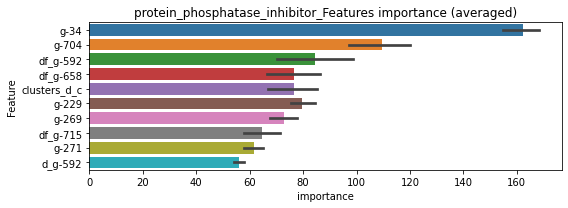

len(train_index) : 3896
len(valid_index) : 3897
================================= fold 1/2 protein_phosphatase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0144905	valid_1's binary_logloss: 0.0250456
[200]	training's binary_logloss: 0.00179794	valid_1's binary_logloss: 0.00915522
Early stopping, best iteration is:
[288]	training's binary_logloss: 0.000566257	valid_1's binary_logloss: 0.00721729


len(train_index) : 3897
len(valid_index) : 3896
================================= fold 2/2 protein_phosphatase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0150293	valid_1's binary_logloss: 0.0207324
[200]	training's binary_logloss: 0.0019412	valid_1's binary_logloss: 0.00546512
[300]	training's binary_logloss: 0.000551893	valid_1's binary_logloss: 0.00345456
Early stopping, best iteration is:
[380]	training's binary_logloss: 0.000311166	valid_1's binary_logloss: 0.00302153


protein_phosphatase_inhibitor logloss: 0.005119680489588479
protein_synthesis_inhibitor, len(trt): 103, len(othr): 3271, target_rate: 0.0043252 → Adj_target_rate: 0.0043163


neg labels: 3289 → selected neg labels: 3271


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0601753	valid_1's binary_logloss: 0.12799
[200]	training's binary_logloss: 0.0142555	valid_1's binary_logloss: 0.0766729
[300]	training's binary_logloss: 0.00447251	valid_1's binary_logloss: 0.0595349
[400]	training's binary_logloss: 0.00194629	valid_1's binary_logloss: 0.0543721
Early stopping, best iteration is:
[472]	training's binary_logloss: 0.00132248	valid_1's binary_logloss: 0.0524376
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0579896	valid_1's binary_logloss: 0.128892
[200]	training's binary_logloss: 0.0130316	valid_1's binary_logloss: 0.0780956
[300]	training's binary_logloss: 0.00398794	valid_1's binary_logloss: 0.0653362
Early stopping, best iteration is:
[383]	training's binary_logloss: 0.00201624	valid_1's binary_logloss: 0.0621699


1 / 3 AUC score:0.996
Threshold: 0.0135974, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 151 → positive_corect_labels: 644/3774
p_label_rate: 0.0670517 Vs.target_rate: 0.00433, Num_p_label: 267.0, conf_0:0.00231, conf_1:0.01496
Num_p_label: 267.0, Expected: 17.2, Adj_threshold_1: 0.0135974
Num_p_label: 179.0, Expected: 17.2, Adj_threshold_2: 0.0185974
Num_p_label: 155.0, Expected: 17.2, Adj_threshold_3: 0.0235974
Num_p_label: 132.0, Expected: 17.2, Adj_threshold_4: 0.0285974
Num_p_label: 119.0, Expected: 17.2, Adj_threshold_5: 0.0335974
Num_p_label: 108.0, Expected: 17.2, Adj_threshold_6: 0.0385974
Num_p_label: 100.0, Expected: 17.2, Adj_threshold_7: 0.0435974
Num_p_label: 95.0, Expected: 17.2, Adj_threshold_8: 0.0485974
Num_p_label: 94.0, Expected: 17.2, Adj_threshold_9: 0.0535974
Num_p_label: 89.0, Expected: 17.2, Adj_threshold_10: 0.0585974
threshold: 0.0635974, positive p_label: 85.0/3982, p_label_rate: 0.0213461
positive y_label: 644.0/3774, y_label_rate: 0.1706412
==============

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0516099	valid_1's binary_logloss: 0.125468
[200]	training's binary_logloss: 0.0111835	valid_1's binary_logloss: 0.0776503
[300]	training's binary_logloss: 0.00341627	valid_1's binary_logloss: 0.0638328
Early stopping, best iteration is:
[376]	training's binary_logloss: 0.00184744	valid_1's binary_logloss: 0.0610557
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0617803	valid_1's binary_logloss: 0.115576
[200]	training's binary_logloss: 0.014195	valid_1's binary_logloss: 0.0628186
[300]	training's binary_logloss: 0.00423029	valid_1's binary_logloss: 0.0482957
Early stopping, best iteration is:
[383]	training's binary_logloss: 0.00211159	valid_1's binary_logloss: 0.0447786


2 / 3 AUC score:0.998
Threshold: 0.0635974, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 30 → positive_corect_labels: 624.0/3744
p_label_rate: 0.0447012 Vs.target_rate: 0.00433, Num_p_label: 178.0, conf_0:0.00296, conf_1:0.06996
Num_p_label: 178.0, Expected: 17.2, Adj_threshold_1: 0.0635974
Num_p_label: 161.0, Expected: 17.2, Adj_threshold_2: 0.0685974
Num_p_label: 159.0, Expected: 17.2, Adj_threshold_3: 0.0735974
Num_p_label: 156.0, Expected: 17.2, Adj_threshold_4: 0.0785974
Num_p_label: 154.0, Expected: 17.2, Adj_threshold_5: 0.0835974
Num_p_label: 151.0, Expected: 17.2, Adj_threshold_6: 0.0885974
Num_p_label: 147.0, Expected: 17.2, Adj_threshold_7: 0.0935974
Num_p_label: 144.0, Expected: 17.2, Adj_threshold_8: 0.0985974
Num_p_label: 142.0, Expected: 17.2, Adj_threshold_9: 0.1035974
Num_p_label: 140.0, Expected: 17.2, Adj_threshold_10: 0.1085974
threshold: 0.1135974, positive p_label: 137.0/3982, p_label_rate: 0.0344048
positive y_label: 624.0/3744, y_label_rate: 0.1666667
=========

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0498229	valid_1's binary_logloss: 0.122585
[200]	training's binary_logloss: 0.0102593	valid_1's binary_logloss: 0.0744995
[300]	training's binary_logloss: 0.00313754	valid_1's binary_logloss: 0.0607572
[400]	training's binary_logloss: 0.00147785	valid_1's binary_logloss: 0.0576806
Early stopping, best iteration is:
[396]	training's binary_logloss: 0.00151542	valid_1's binary_logloss: 0.0575097
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.054129	valid_1's binary_logloss: 0.111565
[200]	training's binary_logloss: 0.0114778	valid_1's binary_logloss: 0.0645419
[300]	training's binary_logloss: 0.00346637	valid_1's binary_logloss: 0.0539305
Early stopping, best iteration is:
[331]	training's binary_logloss: 0.00261691	valid_1's binary_logloss: 0.0521611


3 / 3 AUC score:0.997
Threshold: 0.1135974, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 31 → positive_corect_labels: 596.0/3713
p_label_rate: 0.0361627 Vs.target_rate: 0.00433, Num_p_label: 144.0, conf_0:0.00291, conf_1:0.12496
Num_p_label: 144.0, Expected: 17.2, Adj_threshold_1: 0.1135974
Num_p_label: 143.0, Expected: 17.2, Adj_threshold_2: 0.1185974
Num_p_label: 143.0, Expected: 17.2, Adj_threshold_3: 0.1235974
Num_p_label: 140.0, Expected: 17.2, Adj_threshold_4: 0.1285974
Num_p_label: 139.0, Expected: 17.2, Adj_threshold_5: 0.1335974
Num_p_label: 137.0, Expected: 17.2, Adj_threshold_6: 0.1385974
Num_p_label: 136.0, Expected: 17.2, Adj_threshold_7: 0.1435974
Num_p_label: 134.0, Expected: 17.2, Adj_threshold_8: 0.1485974
Num_p_label: 132.0, Expected: 17.2, Adj_threshold_9: 0.1535974
Num_p_label: 129.0, Expected: 17.2, Adj_threshold_10: 0.1585974
threshold: 0.1635974, positive p_label: 127.0/3982, p_label_rate: 0.0318935
positive y_label: 723.0/7695, y_label_rate: 0.0939571


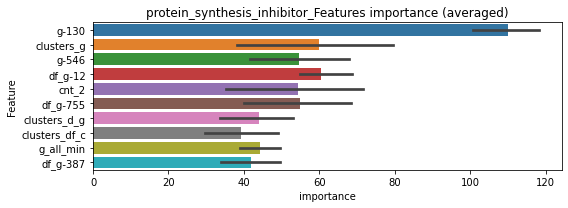

len(train_index) : 3847
len(valid_index) : 3848
================================= fold 1/2 protein_synthesis_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0296677	valid_1's binary_logloss: 0.0762673
[200]	training's binary_logloss: 0.00625109	valid_1's binary_logloss: 0.0491405
[300]	training's binary_logloss: 0.00186349	valid_1's binary_logloss: 0.0418979
[400]	training's binary_logloss: 0.000873442	valid_1's binary_logloss: 0.0389447
Early stopping, best iteration is:
[405]	training's binary_logloss: 0.000846773	valid_1's binary_logloss: 0.0388204


len(train_index) : 3848
len(valid_index) : 3847
================================= fold 2/2 protein_synthesis_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.033275	valid_1's binary_logloss: 0.0706072
[200]	training's binary_logloss: 0.00726228	valid_1's binary_logloss: 0.0421835
[300]	training's binary_logloss: 0.00218443	valid_1's binary_logloss: 0.0354612
[400]	training's binary_logloss: 0.000948184	valid_1's binary_logloss: 0.0333662
Early stopping, best iteration is:
[416]	training's binary_logloss: 0.000859583	valid_1's binary_logloss: 0.0330992


protein_synthesis_inhibitor logloss: 0.03596018663250373


  acetylcholine_receptor_agonist acetylcholine_receptor_antagonist  \
0                       df_g-122                              c-30   
1                  clusters_df_c                         c_all_max   
2                          cnt_0                    clusters_g_all   
3                      c_all_min                          df_g-707   
4                        df_g-51                        clusters_g   
5                       df_c_min                          df_c_min   
6                          cnt_2                             g-514   
7                       df_g-736                          df_g-640   
8                          g-244                            df_c-6   
9                           c-73                          df_g-597   

  acetylcholinesterase_inhibitor adenosine_receptor_antagonist  \
0                      c_all_max                clusters_c_all   
1                      c_all_min                      df_c_min   
2                 clusters_g_al

protein_tyrosine_kinase_inhibitor, len(trt): 19, len(othr): 3285, target_rate: 0.0007979 → Adj_target_rate: 0.0010260


neg labels: 3289 → selected neg labels: 3285


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0273335	valid_1's binary_logloss: 0.037963
[200]	training's binary_logloss: 0.00336031	valid_1's binary_logloss: 0.00674504
[300]	training's binary_logloss: 0.000931302	valid_1's binary_logloss: 0.00248426
[400]	training's binary_logloss: 0.000487276	valid_1's binary_logloss: 0.00156423
[500]	training's binary_logloss: 0.000377155	valid_1's binary_logloss: 0.00133264
Early stopping, best iteration is:
[516]	training's binary_logloss: 0.000374754	valid_1's binary_logloss: 0.00132639
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0261979	valid_1's binary_logloss: 0.0330895
[200]	training's binary_logloss: 0.00330854	valid_1's binary_logloss: 0.0057951
[300]	training's binary_logloss: 0.000937329	valid_1's binary_logloss: 0.00224705
[400]	training's binary_logloss: 0.000494234	valid_1's binary_logloss: 0.00148243
[500]	training's binary_logloss: 

1 / 3 AUC score:1.000
Threshold: 0.0016387, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → positive_corect_labels: 657/3810
p_label_rate: 0.0341537 Vs.target_rate: 0.00080, Num_p_label: 136.0, conf_0:0.00029, conf_1:0.00180
Num_p_label: 136.0, Expected: 3.2, Adj_threshold_1: 0.0016387
Num_p_label: 14.0, Expected: 3.2, Adj_threshold_2: 0.0066387
Num_p_label: 4.0, Expected: 3.2, Adj_threshold_3: 0.0116387
threshold: 0.0116387, positive p_label: 4.0/3982, p_label_rate: 0.0010045
positive y_label: 657.0/3810, y_label_rate: 0.1724409
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0265003	valid_1's binary_logloss: 0.0364323
[200]	training's binary_logloss: 0.0032229	valid_1's binary_logloss: 0.00620316
[300]	training's binary_logloss: 0.000912032	valid_1's binary_logloss: 0.0021986
[400]	training's binary_logloss: 0.000482119	valid_1's binary_logloss: 0.00136671
[500]	training's binary_logloss: 0.000385198	valid_1's binary_logloss: 0.00116444
Early stopping, best iteration is:
[523]	training's binary_logloss: 0.000382206	valid_1's binary_logloss: 0.00115439
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0257049	valid_1's binary_logloss: 0.0334011
[200]	training's binary_logloss: 0.00312283	valid_1's binary_logloss: 0.0053887
[300]	training's binary_logloss: 0.000891092	valid_1's binary_logloss: 0.00193045
[400]	training's binary_logloss: 0.000477431	valid_1's binary_logloss: 0.00120339
[500]	training's binary_logloss: 0

2 / 3 AUC score:1.000
Threshold: 0.0116387, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → positive_corect_labels: 657.0/3810
p_label_rate: 0.0032647 Vs.target_rate: 0.00080, Num_p_label: 13.0, conf_0:0.00032, conf_1:0.01280
Num_p_label: 13.0, Expected: 3.2, Adj_threshold_1: 0.0116387
Num_p_label: 8.0, Expected: 3.2, Adj_threshold_2: 0.0166387
Num_p_label: 4.0, Expected: 3.2, Adj_threshold_3: 0.0216387
threshold: 0.0216387, positive p_label: 4.0/3982, p_label_rate: 0.0010045
positive y_label: 657.0/3810, y_label_rate: 0.1724409
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0265003	valid_1's binary_logloss: 0.0364323
[200]	training's binary_logloss: 0.0032229	valid_1's binary_logloss: 0.00620316
[300]	training's binary_logloss: 0.000912032	valid_1's binary_logloss: 0.0021986
[400]	training's binary_logloss: 0.000482119	valid_1's binary_logloss: 0.00136671
[500]	training's binary_logloss: 0.000385198	valid_1's binary_logloss: 0.00116444
Early stopping, best iteration is:
[523]	training's binary_logloss: 0.000382206	valid_1's binary_logloss: 0.00115439
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0257049	valid_1's binary_logloss: 0.0334011
[200]	training's binary_logloss: 0.00312283	valid_1's binary_logloss: 0.0053887
[300]	training's binary_logloss: 0.000891092	valid_1's binary_logloss: 0.00193045
[400]	training's binary_logloss: 0.000477431	valid_1's binary_logloss: 0.00120339
[500]	training's binary_logloss: 0

3 / 3 AUC score:1.000
Threshold: 0.0216387, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → positive_corect_labels: 657.0/3810
p_label_rate: 0.0010045 Vs.target_rate: 0.00080, Num_p_label: 4.0, conf_0:0.00032, conf_1:0.02380
threshold: 0.0216387, positive p_label: 4.0/3982, p_label_rate: 0.0010045
positive y_label: 661.0/7792, y_label_rate: 0.0848306


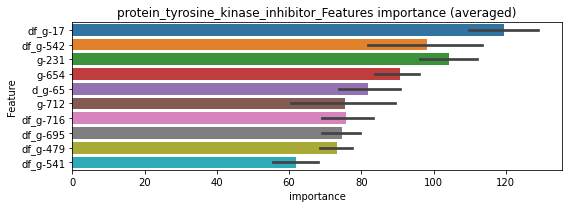

len(train_index) : 3896
len(valid_index) : 3896
================================= fold 1/2 protein_tyrosine_kinase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0141227	valid_1's binary_logloss: 0.0220812
[200]	training's binary_logloss: 0.00166415	valid_1's binary_logloss: 0.00730725
[300]	training's binary_logloss: 0.000455534	valid_1's binary_logloss: 0.00571961
Early stopping, best iteration is:
[383]	training's binary_logloss: 0.000257015	valid_1's binary_logloss: 0.00545666


len(train_index) : 3896
len(valid_index) : 3896
================================= fold 2/2 protein_tyrosine_kinase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0154226	valid_1's binary_logloss: 0.0196141
[200]	training's binary_logloss: 0.00194773	valid_1's binary_logloss: 0.00370872
[300]	training's binary_logloss: 0.000512681	valid_1's binary_logloss: 0.00187896
[400]	training's binary_logloss: 0.000255553	valid_1's binary_logloss: 0.00154148
Early stopping, best iteration is:
[466]	training's binary_logloss: 0.000203431	valid_1's binary_logloss: 0.00147157


protein_tyrosine_kinase_inhibitor logloss: 0.003464113753644762
radiopaque_medium, len(trt): 56, len(othr): 3281, target_rate: 0.0023516 → Adj_target_rate: 0.0025713


neg labels: 3289 → selected neg labels: 3281


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0481492	valid_1's binary_logloss: 0.0990896
[200]	training's binary_logloss: 0.00886506	valid_1's binary_logloss: 0.049462
[300]	training's binary_logloss: 0.00252999	valid_1's binary_logloss: 0.0365851
[400]	training's binary_logloss: 0.001196	valid_1's binary_logloss: 0.0328069
Early stopping, best iteration is:
[440]	training's binary_logloss: 0.00097464	valid_1's binary_logloss: 0.0319574
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0503438	valid_1's binary_logloss: 0.0834515
[200]	training's binary_logloss: 0.0104136	valid_1's binary_logloss: 0.0345898
[300]	training's binary_logloss: 0.00288348	valid_1's binary_logloss: 0.0209499
[400]	training's binary_logloss: 0.00134411	valid_1's binary_logloss: 0.0169265
[500]	training's binary_logloss: 0.000838738	valid_1's binary_logloss: 0.0154884
Early stopping, best iteration is:
[493]	trainin

1 / 3 AUC score:1.000
Threshold: 0.0069996, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → positive_corect_labels: 656/3805
p_label_rate: 0.0379206 Vs.target_rate: 0.00235, Num_p_label: 151.0, conf_0:0.00107, conf_1:0.00770
Num_p_label: 151.0, Expected: 9.4, Adj_threshold_1: 0.0069996
Num_p_label: 60.0, Expected: 9.4, Adj_threshold_2: 0.0119996
Num_p_label: 39.0, Expected: 9.4, Adj_threshold_3: 0.0169996
Num_p_label: 21.0, Expected: 9.4, Adj_threshold_4: 0.0219996
Num_p_label: 12.0, Expected: 9.4, Adj_threshold_5: 0.0269996
threshold: 0.0269996, positive p_label: 12.0/3982, p_label_rate: 0.0030136
positive y_label: 656.0/3805, y_label_rate: 0.1724047
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.047314	valid_1's binary_logloss: 0.0943411
[200]	training's binary_logloss: 0.00857759	valid_1's binary_logloss: 0.0464033
[300]	training's binary_logloss: 0.00252249	valid_1's binary_logloss: 0.0341301
Early stopping, best iteration is:
[346]	training's binary_logloss: 0.00170113	valid_1's binary_logloss: 0.031851
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0493538	valid_1's binary_logloss: 0.0841635
[200]	training's binary_logloss: 0.00965924	valid_1's binary_logloss: 0.0334761
[300]	training's binary_logloss: 0.00279392	valid_1's binary_logloss: 0.0209828
[400]	training's binary_logloss: 0.00131837	valid_1's binary_logloss: 0.0173741
[500]	training's binary_logloss: 0.00082832	valid_1's binary_logloss: 0.0158872
Early stopping, best iteration is:
[541]	training's binary_logloss: 0.000723787	valid_1's binary_logloss: 0.015272


2 / 3 AUC score:1.000
Threshold: 0.0269996, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 19 → positive_corect_labels: 652.0/3786
p_label_rate: 0.0130588 Vs.target_rate: 0.00235, Num_p_label: 52.0, conf_0:0.00156, conf_1:0.02970
Num_p_label: 52.0, Expected: 9.4, Adj_threshold_1: 0.0269996
Num_p_label: 42.0, Expected: 9.4, Adj_threshold_2: 0.0319996
Num_p_label: 29.0, Expected: 9.4, Adj_threshold_3: 0.0369996
Num_p_label: 18.0, Expected: 9.4, Adj_threshold_4: 0.0419996
threshold: 0.0419996, positive p_label: 18.0/3982, p_label_rate: 0.0045203
positive y_label: 652.0/3786, y_label_rate: 0.1722134
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0465515	valid_1's binary_logloss: 0.083741
[200]	training's binary_logloss: 0.00880166	valid_1's binary_logloss: 0.033532
[300]	training's binary_logloss: 0.00256924	valid_1's binary_logloss: 0.0202036
[400]	training's binary_logloss: 0.00121784	valid_1's binary_logloss: 0.0156489
[500]	training's binary_logloss: 0.000776815	valid_1's binary_logloss: 0.0137836
Early stopping, best iteration is:
[490]	training's binary_logloss: 0.00080254	valid_1's binary_logloss: 0.0136792
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0485129	valid_1's binary_logloss: 0.0886636
[200]	training's binary_logloss: 0.00920771	valid_1's binary_logloss: 0.0382841
[300]	training's binary_logloss: 0.00270193	valid_1's binary_logloss: 0.0257018
[400]	training's binary_logloss: 0.00126616	valid_1's binary_logloss: 0.0217491
Early stopping, best iteration is:
[420]	train

3 / 3 AUC score:1.000
Threshold: 0.0419996, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 6 → positive_corect_labels: 649.0/3780
p_label_rate: 0.0067805 Vs.target_rate: 0.00235, Num_p_label: 27.0, conf_0:0.00129, conf_1:0.04620
threshold: 0.0419996, positive p_label: 27.0/3982, p_label_rate: 0.0067805
positive y_label: 676.0/7762, y_label_rate: 0.0870910


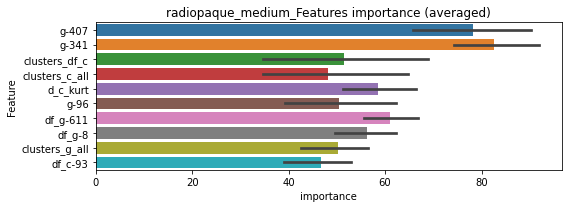

len(train_index) : 3881
len(valid_index) : 3881
================================= fold 1/2 radiopaque_medium=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0293225	valid_1's binary_logloss: 0.0622795
[200]	training's binary_logloss: 0.00569219	valid_1's binary_logloss: 0.0367232
[300]	training's binary_logloss: 0.00151842	valid_1's binary_logloss: 0.031659
Early stopping, best iteration is:
[322]	training's binary_logloss: 0.00123454	valid_1's binary_logloss: 0.0311483


len(train_index) : 3881
len(valid_index) : 3881
================================= fold 2/2 radiopaque_medium=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0289038	valid_1's binary_logloss: 0.0588887
[200]	training's binary_logloss: 0.00555423	valid_1's binary_logloss: 0.0308338
[300]	training's binary_logloss: 0.00164773	valid_1's binary_logloss: 0.0252129
[400]	training's binary_logloss: 0.000752254	valid_1's binary_logloss: 0.0234329
[500]	training's binary_logloss: 0.000450533	valid_1's binary_logloss: 0.0223894
Early stopping, best iteration is:
[504]	training's binary_logloss: 0.000442989	valid_1's binary_logloss: 0.0223073


radiopaque_medium logloss: 0.026727789227545446


  acetylcholine_receptor_agonist acetylcholine_receptor_antagonist  \
0                       df_g-122                              c-30   
1                  clusters_df_c                         c_all_max   
2                          cnt_0                    clusters_g_all   
3                      c_all_min                          df_g-707   
4                        df_g-51                        clusters_g   
5                       df_c_min                          df_c_min   
6                          cnt_2                             g-514   
7                       df_g-736                          df_g-640   
8                          g-244                            df_c-6   
9                           c-73                          df_g-597   

  acetylcholinesterase_inhibitor adenosine_receptor_antagonist  \
0                      c_all_max                clusters_c_all   
1                      c_all_min                      df_c_min   
2                 clusters_g_al

raf_inhibitor, len(trt): 223, len(othr): 3280, target_rate: 0.0093642 → Adj_target_rate: 0.0083226


neg labels: 3289 → selected neg labels: 3280


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0275224	valid_1's binary_logloss: 0.085927
[200]	training's binary_logloss: 0.00369861	valid_1's binary_logloss: 0.0696607
Early stopping, best iteration is:
[193]	training's binary_logloss: 0.00413	valid_1's binary_logloss: 0.0690848
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0283969	valid_1's binary_logloss: 0.0554729
[200]	training's binary_logloss: 0.00404729	valid_1's binary_logloss: 0.0376981


1 / 3 AUC score:0.995
Threshold: 0.0108161, pos_neg_ratio: 0.8000000


Early stopping, best iteration is:
[222]	training's binary_logloss: 0.00287402	valid_1's binary_logloss: 0.0368525


Remove_noisy_labels: 154 → positive_corect_labels: 645/3782
p_label_rate: 0.0547464 Vs.target_rate: 0.00936, Num_p_label: 218.0, conf_0:0.00185, conf_1:0.01190
Num_p_label: 218.0, Expected: 37.3, Adj_threshold_1: 0.0108161
Num_p_label: 143.0, Expected: 37.3, Adj_threshold_2: 0.0158161
Num_p_label: 109.0, Expected: 37.3, Adj_threshold_3: 0.0208161
Num_p_label: 94.0, Expected: 37.3, Adj_threshold_4: 0.0258161
Num_p_label: 85.0, Expected: 37.3, Adj_threshold_5: 0.0308161
Num_p_label: 67.0, Expected: 37.3, Adj_threshold_6: 0.0358161
threshold: 0.0358161, positive p_label: 67.0/3982, p_label_rate: 0.0168257
positive y_label: 645.0/3782, y_label_rate: 0.1705447
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0257254	valid_1's binary_logloss: 0.0483639
[200]	training's binary_logloss: 0.00337756	valid_1's binary_logloss: 0.0243511
Early stopping, best iteration is:
[285]	training's binary_logloss: 0.00109922	valid_1's binary_logloss: 0.0210555
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0258719	valid_1's binary_logloss: 0.047765
[200]	training's binary_logloss: 0.00324944	valid_1's binary_logloss: 0.0250907


2 / 3 AUC score:1.000
Threshold: 0.0358161, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 8 → positive_corect_labels: 641.0/3774


Early stopping, best iteration is:
[261]	training's binary_logloss: 0.00137632	valid_1's binary_logloss: 0.0231641


p_label_rate: 0.0296334 Vs.target_rate: 0.00936, Num_p_label: 118.0, conf_0:0.00075, conf_1:0.03940
Num_p_label: 118.0, Expected: 37.3, Adj_threshold_1: 0.0358161
Num_p_label: 109.0, Expected: 37.3, Adj_threshold_2: 0.0408161
Num_p_label: 95.0, Expected: 37.3, Adj_threshold_3: 0.0458161
Num_p_label: 86.0, Expected: 37.3, Adj_threshold_4: 0.0508161
Num_p_label: 82.0, Expected: 37.3, Adj_threshold_5: 0.0558161
Num_p_label: 75.0, Expected: 37.3, Adj_threshold_6: 0.0608161
Num_p_label: 73.0, Expected: 37.3, Adj_threshold_7: 0.0658161
threshold: 0.0658161, positive p_label: 73.0/3982, p_label_rate: 0.0183325
positive y_label: 641.0/3774, y_label_rate: 0.1698463
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0246576	valid_1's binary_logloss: 0.0531259
[200]	training's binary_logloss: 0.00310916	valid_1's binary_logloss: 0.0313948
Early stopping, best iteration is:
[241]	training's binary_logloss: 0.00162429	valid_1's binary_logloss: 0.028342
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0257562	valid_1's binary_logloss: 0.0384304
[200]	training's binary_logloss: 0.00333305	valid_1's binary_logloss: 0.0146126
[300]	training's binary_logloss: 0.000939011	valid_1's binary_logloss: 0.0115544
Early stopping, best iteration is:
[337]	training's binary_logloss: 0.000694845	valid_1's binary_logloss: 0.0111679


3 / 3 AUC score:1.000
Threshold: 0.0658161, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 10 → positive_corect_labels: 632.0/3764
p_label_rate: 0.0180814 Vs.target_rate: 0.00936, Num_p_label: 72.0, conf_0:0.00070, conf_1:0.07240
threshold: 0.0658161, positive p_label: 72.0/3982, p_label_rate: 0.0180814
positive y_label: 704.0/7746, y_label_rate: 0.0908856


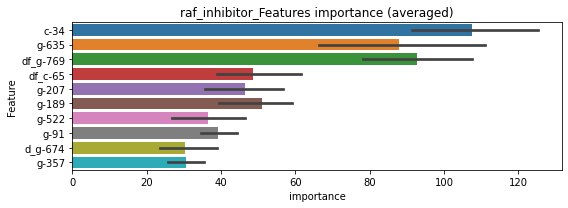

len(train_index) : 3873
len(valid_index) : 3873
================================= fold 1/2 raf_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0157839	valid_1's binary_logloss: 0.0299726
[200]	training's binary_logloss: 0.00212439	valid_1's binary_logloss: 0.0182996
Early stopping, best iteration is:
[261]	training's binary_logloss: 0.000899935	valid_1's binary_logloss: 0.0170432


len(train_index) : 3873
len(valid_index) : 3873
================================= fold 2/2 raf_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0143299	valid_1's binary_logloss: 0.0451948
[200]	training's binary_logloss: 0.00179829	valid_1's binary_logloss: 0.0361556
Early stopping, best iteration is:
[214]	training's binary_logloss: 0.00142827	valid_1's binary_logloss: 0.0356025


raf_inhibitor logloss: 0.026322848396263254


  acetylcholine_receptor_agonist acetylcholine_receptor_antagonist  \
0                       df_g-122                              c-30   
1                  clusters_df_c                         c_all_max   
2                          cnt_0                    clusters_g_all   
3                      c_all_min                          df_g-707   
4                        df_g-51                        clusters_g   
5                       df_c_min                          df_c_min   
6                          cnt_2                             g-514   
7                       df_g-736                          df_g-640   
8                          g-244                            df_c-6   
9                           c-73                          df_g-597   

  acetylcholinesterase_inhibitor adenosine_receptor_antagonist  \
0                      c_all_max                clusters_c_all   
1                      c_all_min                      df_c_min   
2                 clusters_g_al

ras_gtpase_inhibitor, len(trt): 12, len(othr): 3287, target_rate: 0.0005039 → Adj_target_rate: 0.0006942


neg labels: 3289 → selected neg labels: 3287


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0191834	valid_1's binary_logloss: 0.0242555
[200]	training's binary_logloss: 0.00197263	valid_1's binary_logloss: 0.00397733
[300]	training's binary_logloss: 0.000562637	valid_1's binary_logloss: 0.00163492
[400]	training's binary_logloss: 0.000322088	valid_1's binary_logloss: 0.00112679
[500]	training's binary_logloss: 0.000274749	valid_1's binary_logloss: 0.00104178
Early stopping, best iteration is:
[513]	training's binary_logloss: 0.000274255	valid_1's binary_logloss: 0.00104156
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0192995	valid_1's binary_logloss: 0.0234251
[200]	training's binary_logloss: 0.00200339	valid_1's binary_logloss: 0.00357233
[300]	training's binary_logloss: 0.000572876	valid_1's binary_logloss: 0.00134416
[400]	training's binary_logloss: 0.00032985	valid_1's binary_logloss: 0.00088703
[500]	training's binary_logloss:

1 / 3 AUC score:1.000
Threshold: 0.0010238, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → positive_corect_labels: 657/3812
p_label_rate: 0.0411853 Vs.target_rate: 0.00050, Num_p_label: 164.0, conf_0:0.00017, conf_1:0.00113
Num_p_label: 164.0, Expected: 2.0, Adj_threshold_1: 0.0010238
Num_p_label: 17.0, Expected: 2.0, Adj_threshold_2: 0.0060238
Num_p_label: 10.0, Expected: 2.0, Adj_threshold_3: 0.0110238
Num_p_label: 5.0, Expected: 2.0, Adj_threshold_4: 0.0160238
Num_p_label: 4.0, Expected: 2.0, Adj_threshold_5: 0.0210238
threshold: 0.0210238, positive p_label: 4.0/3982, p_label_rate: 0.0010045
positive y_label: 657.0/3812, y_label_rate: 0.1723505
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0193126	valid_1's binary_logloss: 0.0242336
[200]	training's binary_logloss: 0.00193982	valid_1's binary_logloss: 0.00431742
[300]	training's binary_logloss: 0.00055633	valid_1's binary_logloss: 0.00204524
[400]	training's binary_logloss: 0.000319749	valid_1's binary_logloss: 0.00156022
Early stopping, best iteration is:
[471]	training's binary_logloss: 0.000279742	valid_1's binary_logloss: 0.00146228
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0192915	valid_1's binary_logloss: 0.0228601
[200]	training's binary_logloss: 0.00198517	valid_1's binary_logloss: 0.00347832
[300]	training's binary_logloss: 0.00056207	valid_1's binary_logloss: 0.00143208
[400]	training's binary_logloss: 0.000322482	valid_1's binary_logloss: 0.000971874
[500]	training's binary_logloss: 0.000270997	valid_1's binary_logloss: 0.000877759
Early stopping, best iteration 

2 / 3 AUC score:1.000
Threshold: 0.0210238, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → positive_corect_labels: 657.0/3812
p_label_rate: 0.0057760 Vs.target_rate: 0.00050, Num_p_label: 23.0, conf_0:0.00019, conf_1:0.02313
Num_p_label: 23.0, Expected: 2.0, Adj_threshold_1: 0.0210238
Num_p_label: 16.0, Expected: 2.0, Adj_threshold_2: 0.0260238
Num_p_label: 13.0, Expected: 2.0, Adj_threshold_3: 0.0310238
Num_p_label: 12.0, Expected: 2.0, Adj_threshold_4: 0.0360238
Num_p_label: 10.0, Expected: 2.0, Adj_threshold_5: 0.0410238
Num_p_label: 10.0, Expected: 2.0, Adj_threshold_6: 0.0460238
Num_p_label: 9.0, Expected: 2.0, Adj_threshold_7: 0.0510238
Num_p_label: 9.0, Expected: 2.0, Adj_threshold_8: 0.0560238
Num_p_label: 6.0, Expected: 2.0, Adj_threshold_9: 0.0610238
Num_p_label: 5.0, Expected: 2.0, Adj_threshold_10: 0.0660238
threshold: 0.0710238, positive p_label: 5.0/3982, p_label_rate: 0.0012557
positive y_label: 657.0/3812, y_label_rate: 0.1723505
================= Pseudo labeling 3 /

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0193126	valid_1's binary_logloss: 0.0242336
[200]	training's binary_logloss: 0.00193982	valid_1's binary_logloss: 0.00431742
[300]	training's binary_logloss: 0.00055633	valid_1's binary_logloss: 0.00204524
[400]	training's binary_logloss: 0.000319749	valid_1's binary_logloss: 0.00156022
Early stopping, best iteration is:
[471]	training's binary_logloss: 0.000279742	valid_1's binary_logloss: 0.00146228
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0192915	valid_1's binary_logloss: 0.0228601
[200]	training's binary_logloss: 0.00198517	valid_1's binary_logloss: 0.00347832
[300]	training's binary_logloss: 0.00056207	valid_1's binary_logloss: 0.00143208
[400]	training's binary_logloss: 0.000322482	valid_1's binary_logloss: 0.000971874
[500]	training's binary_logloss: 0.000270997	valid_1's binary_logloss: 0.000877759
Early stopping, best iteration 

3 / 3 AUC score:1.000
Threshold: 0.0710238, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → positive_corect_labels: 657.0/3812
p_label_rate: 0.0012557 Vs.target_rate: 0.00050, Num_p_label: 5.0, conf_0:0.00019, conf_1:0.07813
threshold: 0.0710238, positive p_label: 5.0/3982, p_label_rate: 0.0012557
positive y_label: 662.0/7794, y_label_rate: 0.0849371


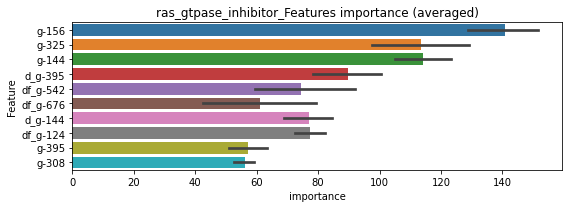

len(train_index) : 3897
len(valid_index) : 3897
================================= fold 1/2 ras_gtpase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.010218	valid_1's binary_logloss: 0.0148308
[200]	training's binary_logloss: 0.00103827	valid_1's binary_logloss: 0.00502457
Early stopping, best iteration is:
[271]	training's binary_logloss: 0.000381212	valid_1's binary_logloss: 0.00443112


len(train_index) : 3897
len(valid_index) : 3897
================================= fold 2/2 ras_gtpase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0103235	valid_1's binary_logloss: 0.0131967
[200]	training's binary_logloss: 0.00106953	valid_1's binary_logloss: 0.00351332
[300]	training's binary_logloss: 0.000303404	valid_1's binary_logloss: 0.00253604
[400]	training's binary_logloss: 0.000169551	valid_1's binary_logloss: 0.00238117
Early stopping, best iteration is:
[395]	training's binary_logloss: 0.000172665	valid_1's binary_logloss: 0.0023784


ras_gtpase_inhibitor logloss: 0.0034047592122483238
retinoid_receptor_agonist, len(trt): 67, len(othr): 3278, target_rate: 0.0028135 → Adj_target_rate: 0.0029948


neg labels: 3289 → selected neg labels: 3278


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0417957	valid_1's binary_logloss: 0.0787784
[200]	training's binary_logloss: 0.00733484	valid_1's binary_logloss: 0.029637
[300]	training's binary_logloss: 0.00214827	valid_1's binary_logloss: 0.015941
[400]	training's binary_logloss: 0.00103687	valid_1's binary_logloss: 0.0121183
[500]	training's binary_logloss: 0.000678225	valid_1's binary_logloss: 0.0104513
Early stopping, best iteration is:
[547]	training's binary_logloss: 0.000589681	valid_1's binary_logloss: 0.0100028
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.040483	valid_1's binary_logloss: 0.0799744
[200]	training's binary_logloss: 0.00697016	valid_1's binary_logloss: 0.0315792
[300]	training's binary_logloss: 0.00206975	valid_1's binary_logloss: 0.0201814
[400]	training's binary_logloss: 0.0010122	valid_1's binary_logloss: 0.0167733
[500]	training's binary_logloss: 0.000666807	va

1 / 3 AUC score:1.000
Threshold: 0.0059611, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → positive_corect_labels: 655/3801
p_label_rate: 0.0401808 Vs.target_rate: 0.00281, Num_p_label: 160.0, conf_0:0.00057, conf_1:0.00656
Num_p_label: 160.0, Expected: 11.2, Adj_threshold_1: 0.0059611
Num_p_label: 90.0, Expected: 11.2, Adj_threshold_2: 0.0109611
Num_p_label: 65.0, Expected: 11.2, Adj_threshold_3: 0.0159611
Num_p_label: 50.0, Expected: 11.2, Adj_threshold_4: 0.0209611
Num_p_label: 35.0, Expected: 11.2, Adj_threshold_5: 0.0259611
Num_p_label: 32.0, Expected: 11.2, Adj_threshold_6: 0.0309611
Num_p_label: 27.0, Expected: 11.2, Adj_threshold_7: 0.0359611
Num_p_label: 26.0, Expected: 11.2, Adj_threshold_8: 0.0409611
Num_p_label: 24.0, Expected: 11.2, Adj_threshold_9: 0.0459611
Num_p_label: 21.0, Expected: 11.2, Adj_threshold_10: 0.0509611
threshold: 0.0509611, positive p_label: 21.0/3982, p_label_rate: 0.0052737
positive y_label: 655.0/3801, y_label_rate: 0.1723231
================= Ps

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0414993	valid_1's binary_logloss: 0.0755705
[200]	training's binary_logloss: 0.00722884	valid_1's binary_logloss: 0.0259207
[300]	training's binary_logloss: 0.00206264	valid_1's binary_logloss: 0.0137867
[400]	training's binary_logloss: 0.000990305	valid_1's binary_logloss: 0.0100027
[500]	training's binary_logloss: 0.000649079	valid_1's binary_logloss: 0.00851782
Early stopping, best iteration is:
[586]	training's binary_logloss: 0.000531775	valid_1's binary_logloss: 0.00786003
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0401389	valid_1's binary_logloss: 0.0766642
[200]	training's binary_logloss: 0.00661008	valid_1's binary_logloss: 0.0285721
[300]	training's binary_logloss: 0.00190531	valid_1's binary_logloss: 0.0174627
[400]	training's binary_logloss: 0.000943542	valid_1's binary_logloss: 0.0139134
[500]	training's binary_logloss: 0.0006

2 / 3 AUC score:1.000
Threshold: 0.0509611, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 3 → positive_corect_labels: 655.0/3798
p_label_rate: 0.0165746 Vs.target_rate: 0.00281, Num_p_label: 66.0, conf_0:0.00060, conf_1:0.05606
Num_p_label: 66.0, Expected: 11.2, Adj_threshold_1: 0.0509611
Num_p_label: 56.0, Expected: 11.2, Adj_threshold_2: 0.0559611
Num_p_label: 52.0, Expected: 11.2, Adj_threshold_3: 0.0609611
Num_p_label: 46.0, Expected: 11.2, Adj_threshold_4: 0.0659611
Num_p_label: 43.0, Expected: 11.2, Adj_threshold_5: 0.0709611
Num_p_label: 40.0, Expected: 11.2, Adj_threshold_6: 0.0759611
Num_p_label: 37.0, Expected: 11.2, Adj_threshold_7: 0.0809611
Num_p_label: 36.0, Expected: 11.2, Adj_threshold_8: 0.0859611
Num_p_label: 35.0, Expected: 11.2, Adj_threshold_9: 0.0909611
Num_p_label: 33.0, Expected: 11.2, Adj_threshold_10: 0.0959611
threshold: 0.1009611, positive p_label: 33.0/3982, p_label_rate: 0.0082873
positive y_label: 655.0/3798, y_label_rate: 0.1724592
================= Pseu

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0418769	valid_1's binary_logloss: 0.0764247
[200]	training's binary_logloss: 0.00707652	valid_1's binary_logloss: 0.0253576
[300]	training's binary_logloss: 0.00203114	valid_1's binary_logloss: 0.0133832
[400]	training's binary_logloss: 0.000978977	valid_1's binary_logloss: 0.00982195
[500]	training's binary_logloss: 0.000646343	valid_1's binary_logloss: 0.00824768
[600]	training's binary_logloss: 0.000521717	valid_1's binary_logloss: 0.00768149
Early stopping, best iteration is:
[626]	training's binary_logloss: 0.000509681	valid_1's binary_logloss: 0.00762068
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0395741	valid_1's binary_logloss: 0.0759988
[200]	training's binary_logloss: 0.00653706	valid_1's binary_logloss: 0.0289347
[300]	training's binary_logloss: 0.00189893	valid_1's binary_logloss: 0.0186173
[400]	training's binary_logloss: 0.00

3 / 3 AUC score:1.000
Threshold: 0.1009611, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 3 → positive_corect_labels: 653.0/3795
p_label_rate: 0.0077850 Vs.target_rate: 0.00281, Num_p_label: 31.0, conf_0:0.00053, conf_1:0.11106
threshold: 0.1009611, positive p_label: 31.0/3982, p_label_rate: 0.0077850
positive y_label: 684.0/7777, y_label_rate: 0.0879517


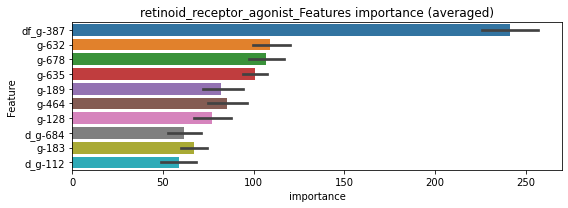

len(train_index) : 3888
len(valid_index) : 3889
================================= fold 1/2 retinoid_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0221762	valid_1's binary_logloss: 0.0563588
[200]	training's binary_logloss: 0.0037046	valid_1's binary_logloss: 0.0356065
[300]	training's binary_logloss: 0.00109065	valid_1's binary_logloss: 0.0319074
Early stopping, best iteration is:
[360]	training's binary_logloss: 0.000647931	valid_1's binary_logloss: 0.0307204


len(train_index) : 3889
len(valid_index) : 3888
================================= fold 2/2 retinoid_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.02238	valid_1's binary_logloss: 0.0507611
[200]	training's binary_logloss: 0.00375655	valid_1's binary_logloss: 0.0274968
[300]	training's binary_logloss: 0.00110304	valid_1's binary_logloss: 0.0215596
[400]	training's binary_logloss: 0.000536369	valid_1's binary_logloss: 0.0200092
Early stopping, best iteration is:
[408]	training's binary_logloss: 0.00051444	valid_1's binary_logloss: 0.0199217


retinoid_receptor_agonist logloss: 0.02532176219944076


  acetylcholine_receptor_agonist acetylcholine_receptor_antagonist  \
0                       df_g-122                              c-30   
1                  clusters_df_c                         c_all_max   
2                          cnt_0                    clusters_g_all   
3                      c_all_min                          df_g-707   
4                        df_g-51                        clusters_g   
5                       df_c_min                          df_c_min   
6                          cnt_2                             g-514   
7                       df_g-736                          df_g-640   
8                          g-244                            df_c-6   
9                           c-73                          df_g-597   

  acetylcholinesterase_inhibitor adenosine_receptor_antagonist  \
0                      c_all_max                clusters_c_all   
1                      c_all_min                      df_c_min   
2                 clusters_g_al

retinoid_receptor_antagonist, len(trt): 6, len(othr): 3288, target_rate: 0.0002520 → Adj_target_rate: 0.0003851


neg labels: 3289 → selected neg labels: 3288


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.015331	valid_1's binary_logloss: 0.0178088
[200]	training's binary_logloss: 0.00124566	valid_1's binary_logloss: 0.00350564
[300]	training's binary_logloss: 0.000334847	valid_1's binary_logloss: 0.00182976
[400]	training's binary_logloss: 0.000208369	valid_1's binary_logloss: 0.00148208
[500]	training's binary_logloss: 0.000182787	valid_1's binary_logloss: 0.00139585
Early stopping, best iteration is:
[514]	training's binary_logloss: 0.000181549	valid_1's binary_logloss: 0.00139462
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0157567	valid_1's binary_logloss: 0.0165832
[200]	training's binary_logloss: 0.00127736	valid_1's binary_logloss: 0.00142363
[300]	training's binary_logloss: 0.000341114	valid_1's binary_logloss: 0.000403193
[400]	training's binary_logloss: 0.00021041	valid_1's binary_logloss: 0.000251285
[500]	training's binary_logloss

1 / 3 AUC score:1.000
Threshold: 0.0004919, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → positive_corect_labels: 657/3813
p_label_rate: 0.0396786 Vs.target_rate: 0.00025, Num_p_label: 158.0, conf_0:0.00011, conf_1:0.00054
Num_p_label: 158.0, Expected: 1.0, Adj_threshold_1: 0.0004919
Num_p_label: 4.0, Expected: 1.0, Adj_threshold_2: 0.0054919
Num_p_label: 2.0, Expected: 1.0, Adj_threshold_3: 0.0104919
threshold: 0.0104919, positive p_label: 2.0/3982, p_label_rate: 0.0005023
positive y_label: 657.0/3813, y_label_rate: 0.1723053
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.015792	valid_1's binary_logloss: 0.0179601
[200]	training's binary_logloss: 0.00126126	valid_1's binary_logloss: 0.00306607
[300]	training's binary_logloss: 0.000335219	valid_1's binary_logloss: 0.00171494
[400]	training's binary_logloss: 0.000209829	valid_1's binary_logloss: 0.00147882
[500]	training's binary_logloss: 0.000183558	valid_1's binary_logloss: 0.00142164
Early stopping, best iteration is:
[496]	training's binary_logloss: 0.000183998	valid_1's binary_logloss: 0.00142041
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0159686	valid_1's binary_logloss: 0.0166115
[200]	training's binary_logloss: 0.00128304	valid_1's binary_logloss: 0.00140389
[300]	training's binary_logloss: 0.00033864	valid_1's binary_logloss: 0.000379904
[400]	training's binary_logloss: 0.00021045	valid_1's binary_logloss: 0.000236887
[500]	training's binary_logloss:

2 / 3 AUC score:1.000
Threshold: 0.0104919, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → positive_corect_labels: 657.0/3813
p_label_rate: 0.0027624 Vs.target_rate: 0.00025, Num_p_label: 11.0, conf_0:0.00012, conf_1:0.01154
Num_p_label: 11.0, Expected: 1.0, Adj_threshold_1: 0.0104919
Num_p_label: 6.0, Expected: 1.0, Adj_threshold_2: 0.0154919
Num_p_label: 4.0, Expected: 1.0, Adj_threshold_3: 0.0204919
Num_p_label: 3.0, Expected: 1.0, Adj_threshold_4: 0.0254919
Num_p_label: 3.0, Expected: 1.0, Adj_threshold_5: 0.0304919
Num_p_label: 1.0, Expected: 1.0, Adj_threshold_6: 0.0354919
threshold: 0.0354919, positive p_label: 1.0/3982, p_label_rate: 0.0002511
positive y_label: 657.0/3813, y_label_rate: 0.1723053
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.015792	valid_1's binary_logloss: 0.0179601
[200]	training's binary_logloss: 0.00126126	valid_1's binary_logloss: 0.00306607
[300]	training's binary_logloss: 0.000335219	valid_1's binary_logloss: 0.00171494
[400]	training's binary_logloss: 0.000209829	valid_1's binary_logloss: 0.00147882
[500]	training's binary_logloss: 0.000183558	valid_1's binary_logloss: 0.00142164
Early stopping, best iteration is:
[496]	training's binary_logloss: 0.000183998	valid_1's binary_logloss: 0.00142041
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0159686	valid_1's binary_logloss: 0.0166115
[200]	training's binary_logloss: 0.00128304	valid_1's binary_logloss: 0.00140389
[300]	training's binary_logloss: 0.00033864	valid_1's binary_logloss: 0.000379904
[400]	training's binary_logloss: 0.00021045	valid_1's binary_logloss: 0.000236887
[500]	training's binary_logloss:

3 / 3 AUC score:1.000
Threshold: 0.0354919, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → positive_corect_labels: 657.0/3813
p_label_rate: 0.0002511 Vs.target_rate: 0.00025, Num_p_label: 1.0, conf_0:0.00012, conf_1:0.03904
threshold: 0.0354919, positive p_label: 1.0/3982, p_label_rate: 0.0002511
positive y_label: 658.0/7795, y_label_rate: 0.0844131


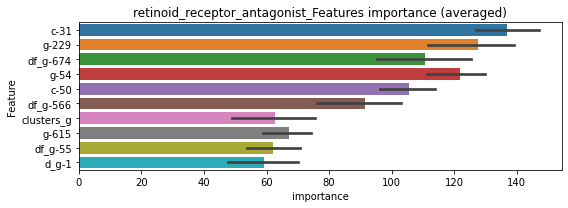

len(train_index) : 3897
len(valid_index) : 3898
================================= fold 1/2 retinoid_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.00832765	valid_1's binary_logloss: 0.010249
[200]	training's binary_logloss: 0.000653628	valid_1's binary_logloss: 0.00258881
[300]	training's binary_logloss: 0.00016994	valid_1's binary_logloss: 0.00193525
Early stopping, best iteration is:
[369]	training's binary_logloss: 0.000114623	valid_1's binary_logloss: 0.00182438


len(train_index) : 3898
len(valid_index) : 3897
================================= fold 2/2 retinoid_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.00852085	valid_1's binary_logloss: 0.00861437
[200]	training's binary_logloss: 0.000682598	valid_1's binary_logloss: 0.000714857
[300]	training's binary_logloss: 0.000175342	valid_1's binary_logloss: 0.000188909
[400]	training's binary_logloss: 0.000105733	valid_1's binary_logloss: 0.000115676
[500]	training's binary_logloss: 9.24833e-05	valid_1's binary_logloss: 0.000101305
Early stopping, best iteration is:
[531]	training's binary_logloss: 9.17825e-05	valid_1's binary_logloss: 0.000100463


retinoid_receptor_antagonist logloss: 0.0009625337806638745
rho_associated_kinase_inhibitor, len(trt): 35, len(othr): 3283, target_rate: 0.0014697 → Adj_target_rate: 0.0017245


neg labels: 3289 → selected neg labels: 3283


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0304423	valid_1's binary_logloss: 0.0474463
[200]	training's binary_logloss: 0.00430704	valid_1's binary_logloss: 0.0115825
[300]	training's binary_logloss: 0.00125162	valid_1's binary_logloss: 0.00570026
[400]	training's binary_logloss: 0.000623424	valid_1's binary_logloss: 0.0039857
[500]	training's binary_logloss: 0.000430551	valid_1's binary_logloss: 0.00343271
Early stopping, best iteration is:
[522]	training's binary_logloss: 0.000414383	valid_1's binary_logloss: 0.00338895
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.03069	valid_1's binary_logloss: 0.0481121
[200]	training's binary_logloss: 0.00437544	valid_1's binary_logloss: 0.0146856
[300]	training's binary_logloss: 0.00126986	valid_1's binary_logloss: 0.00925275
[400]	training's binary_logloss: 0.000635033	valid_1's binary_logloss: 0.00784257
Early stopping, best iteration is:
[44

1 / 3 AUC score:1.000
Threshold: 0.0033932, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → positive_corect_labels: 656/3807
p_label_rate: 0.0374184 Vs.target_rate: 0.00147, Num_p_label: 149.0, conf_0:0.00036, conf_1:0.00373
Num_p_label: 149.0, Expected: 5.9, Adj_threshold_1: 0.0033932
Num_p_label: 46.0, Expected: 5.9, Adj_threshold_2: 0.0083932
Num_p_label: 21.0, Expected: 5.9, Adj_threshold_3: 0.0133932
Num_p_label: 18.0, Expected: 5.9, Adj_threshold_4: 0.0183932
Num_p_label: 12.0, Expected: 5.9, Adj_threshold_5: 0.0233932
Num_p_label: 11.0, Expected: 5.9, Adj_threshold_6: 0.0283932
threshold: 0.0283932, positive p_label: 11.0/3982, p_label_rate: 0.0027624
positive y_label: 656.0/3807, y_label_rate: 0.1723142
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.030103	valid_1's binary_logloss: 0.0448897
[200]	training's binary_logloss: 0.0041856	valid_1's binary_logloss: 0.0107586
[300]	training's binary_logloss: 0.00120936	valid_1's binary_logloss: 0.00500435
[400]	training's binary_logloss: 0.000612477	valid_1's binary_logloss: 0.00352253
[500]	training's binary_logloss: 0.000427965	valid_1's binary_logloss: 0.00300772
Early stopping, best iteration is:
[551]	training's binary_logloss: 0.000395108	valid_1's binary_logloss: 0.00289002
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0304392	valid_1's binary_logloss: 0.0473048
[200]	training's binary_logloss: 0.00431148	valid_1's binary_logloss: 0.0140201
[300]	training's binary_logloss: 0.00123472	valid_1's binary_logloss: 0.00875505
[400]	training's binary_logloss: 0.0006149	valid_1's binary_logloss: 0.00760467
[500]	training's binary_logloss: 0.0004

2 / 3 AUC score:1.000
Threshold: 0.0283932, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 2 → positive_corect_labels: 654.0/3805
p_label_rate: 0.0072828 Vs.target_rate: 0.00147, Num_p_label: 29.0, conf_0:0.00035, conf_1:0.03123
Num_p_label: 29.0, Expected: 5.9, Adj_threshold_1: 0.0283932
Num_p_label: 21.0, Expected: 5.9, Adj_threshold_2: 0.0333932
Num_p_label: 19.0, Expected: 5.9, Adj_threshold_3: 0.0383932
Num_p_label: 17.0, Expected: 5.9, Adj_threshold_4: 0.0433932
Num_p_label: 15.0, Expected: 5.9, Adj_threshold_5: 0.0483932
Num_p_label: 14.0, Expected: 5.9, Adj_threshold_6: 0.0533932
Num_p_label: 12.0, Expected: 5.9, Adj_threshold_7: 0.0583932
Num_p_label: 11.0, Expected: 5.9, Adj_threshold_8: 0.0633932
threshold: 0.0633932, positive p_label: 11.0/3982, p_label_rate: 0.0027624
positive y_label: 654.0/3805, y_label_rate: 0.1718791
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0294656	valid_1's binary_logloss: 0.0454275
[200]	training's binary_logloss: 0.00407874	valid_1's binary_logloss: 0.0121145
[300]	training's binary_logloss: 0.00118208	valid_1's binary_logloss: 0.00644879
[400]	training's binary_logloss: 0.000597222	valid_1's binary_logloss: 0.00518716
Early stopping, best iteration is:
[487]	training's binary_logloss: 0.000430424	valid_1's binary_logloss: 0.00451667
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0302613	valid_1's binary_logloss: 0.0432885
[200]	training's binary_logloss: 0.00421078	valid_1's binary_logloss: 0.00884352
[300]	training's binary_logloss: 0.00120328	valid_1's binary_logloss: 0.00333325
[400]	training's binary_logloss: 0.000606296	valid_1's binary_logloss: 0.0019898
[500]	training's binary_logloss: 0.000425415	valid_1's binary_logloss: 0.0015613
Early stopping, best iteration is:
[

3 / 3 AUC score:1.000
Threshold: 0.0633932, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → positive_corect_labels: 654.0/3805
p_label_rate: 0.0030136 Vs.target_rate: 0.00147, Num_p_label: 12.0, conf_0:0.00036, conf_1:0.06973
threshold: 0.0633932, positive p_label: 12.0/3982, p_label_rate: 0.0030136
positive y_label: 666.0/7787, y_label_rate: 0.0855272


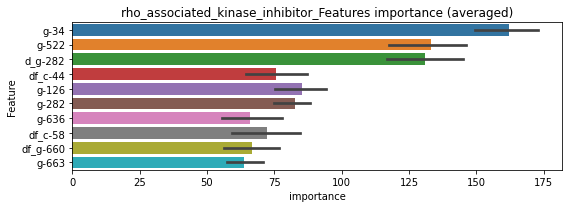

len(train_index) : 3893
len(valid_index) : 3894
================================= fold 1/2 rho_associated_kinase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0154651	valid_1's binary_logloss: 0.0345583
[200]	training's binary_logloss: 0.00208921	valid_1's binary_logloss: 0.0154187
[300]	training's binary_logloss: 0.000611669	valid_1's binary_logloss: 0.0125435
Early stopping, best iteration is:
[309]	training's binary_logloss: 0.000564215	valid_1's binary_logloss: 0.0124669


len(train_index) : 3894
len(valid_index) : 3893
================================= fold 2/2 rho_associated_kinase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0170939	valid_1's binary_logloss: 0.0275424
[200]	training's binary_logloss: 0.00294216	valid_1's binary_logloss: 0.00821247
[300]	training's binary_logloss: 0.00144446	valid_1's binary_logloss: 0.00508379
[400]	training's binary_logloss: 0.00118241	valid_1's binary_logloss: 0.00438014
Early stopping, best iteration is:
[448]	training's binary_logloss: 0.000441479	valid_1's binary_logloss: 0.00424175


rho_associated_kinase_inhibitor logloss: 0.008354833697776237
ribonucleoside_reductase_inhibitor, len(trt): 37, len(othr): 3282, target_rate: 0.0015537 → Adj_target_rate: 0.0018079


neg labels: 3289 → selected neg labels: 3282


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0279483	valid_1's binary_logloss: 0.0485027
[200]	training's binary_logloss: 0.00397135	valid_1's binary_logloss: 0.0159235
[300]	training's binary_logloss: 0.00115189	valid_1's binary_logloss: 0.0103811
[400]	training's binary_logloss: 0.000575904	valid_1's binary_logloss: 0.00893066
Early stopping, best iteration is:
[399]	training's binary_logloss: 0.000578591	valid_1's binary_logloss: 0.00892197
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0296548	valid_1's binary_logloss: 0.0411695
[200]	training's binary_logloss: 0.00415493	valid_1's binary_logloss: 0.0109298
[300]	training's binary_logloss: 0.00118141	valid_1's binary_logloss: 0.00656018
Early stopping, best iteration is:
[379]	training's binary_logloss: 0.000656851	valid_1's binary_logloss: 0.00580039


1 / 3 AUC score:1.000
Threshold: 0.0030673, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → positive_corect_labels: 656/3806
p_label_rate: 0.0364139 Vs.target_rate: 0.00155, Num_p_label: 145.0, conf_0:0.00046, conf_1:0.00337
Num_p_label: 145.0, Expected: 6.2, Adj_threshold_1: 0.0030673
Num_p_label: 49.0, Expected: 6.2, Adj_threshold_2: 0.0080673
Num_p_label: 25.0, Expected: 6.2, Adj_threshold_3: 0.0130673
Num_p_label: 21.0, Expected: 6.2, Adj_threshold_4: 0.0180673
Num_p_label: 20.0, Expected: 6.2, Adj_threshold_5: 0.0230673
Num_p_label: 18.0, Expected: 6.2, Adj_threshold_6: 0.0280673
Num_p_label: 17.0, Expected: 6.2, Adj_threshold_7: 0.0330673
Num_p_label: 15.0, Expected: 6.2, Adj_threshold_8: 0.0380673
Num_p_label: 14.0, Expected: 6.2, Adj_threshold_9: 0.0430673
Num_p_label: 14.0, Expected: 6.2, Adj_threshold_10: 0.0480673
threshold: 0.0530673, positive p_label: 14.0/3982, p_label_rate: 0.0035158
positive y_label: 656.0/3806, y_label_rate: 0.1723594
================= Pseudo label

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.027203	valid_1's binary_logloss: 0.0431179
[200]	training's binary_logloss: 0.00362132	valid_1's binary_logloss: 0.011955
[300]	training's binary_logloss: 0.00104012	valid_1's binary_logloss: 0.00665863
[400]	training's binary_logloss: 0.000535328	valid_1's binary_logloss: 0.00558178
Early stopping, best iteration is:
[444]	training's binary_logloss: 0.000442472	valid_1's binary_logloss: 0.00519358
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0284122	valid_1's binary_logloss: 0.0369933
[200]	training's binary_logloss: 0.00382298	valid_1's binary_logloss: 0.00739806
[300]	training's binary_logloss: 0.00108629	valid_1's binary_logloss: 0.00320951
[400]	training's binary_logloss: 0.000544434	valid_1's binary_logloss: 0.00224886
[500]	training's binary_logloss: 0.000395482	valid_1's binary_logloss: 0.00193217
Early stopping, best iteration is:
[

2 / 3 AUC score:1.000
Threshold: 0.0530673, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → positive_corect_labels: 656.0/3806
p_label_rate: 0.0050226 Vs.target_rate: 0.00155, Num_p_label: 20.0, conf_0:0.00036, conf_1:0.05837
Num_p_label: 20.0, Expected: 6.2, Adj_threshold_1: 0.0530673
Num_p_label: 20.0, Expected: 6.2, Adj_threshold_2: 0.0580673
Num_p_label: 20.0, Expected: 6.2, Adj_threshold_3: 0.0630673
Num_p_label: 19.0, Expected: 6.2, Adj_threshold_4: 0.0680673
Num_p_label: 18.0, Expected: 6.2, Adj_threshold_5: 0.0730673
Num_p_label: 18.0, Expected: 6.2, Adj_threshold_6: 0.0780673
Num_p_label: 17.0, Expected: 6.2, Adj_threshold_7: 0.0830673
Num_p_label: 16.0, Expected: 6.2, Adj_threshold_8: 0.0880673
Num_p_label: 16.0, Expected: 6.2, Adj_threshold_9: 0.0930673
Num_p_label: 16.0, Expected: 6.2, Adj_threshold_10: 0.0980673
threshold: 0.1030673, positive p_label: 16.0/3982, p_label_rate: 0.0040181
positive y_label: 656.0/3806, y_label_rate: 0.1723594
================= Pseudo labelin

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.027203	valid_1's binary_logloss: 0.0431179
[200]	training's binary_logloss: 0.00362132	valid_1's binary_logloss: 0.011955
[300]	training's binary_logloss: 0.00104012	valid_1's binary_logloss: 0.00665863
[400]	training's binary_logloss: 0.000535328	valid_1's binary_logloss: 0.00558178
Early stopping, best iteration is:
[444]	training's binary_logloss: 0.000442472	valid_1's binary_logloss: 0.00519358
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0284122	valid_1's binary_logloss: 0.0369933
[200]	training's binary_logloss: 0.00382298	valid_1's binary_logloss: 0.00739806
[300]	training's binary_logloss: 0.00108629	valid_1's binary_logloss: 0.00320951
[400]	training's binary_logloss: 0.000544434	valid_1's binary_logloss: 0.00224886
[500]	training's binary_logloss: 0.000395482	valid_1's binary_logloss: 0.00193217
Early stopping, best iteration is:
[

3 / 3 AUC score:1.000
Threshold: 0.1030673, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 1 → positive_corect_labels: 655.0/3805
p_label_rate: 0.0040181 Vs.target_rate: 0.00155, Num_p_label: 16.0, conf_0:0.00036, conf_1:0.11337
threshold: 0.1030673, positive p_label: 16.0/3982, p_label_rate: 0.0040181
positive y_label: 671.0/7787, y_label_rate: 0.0861693


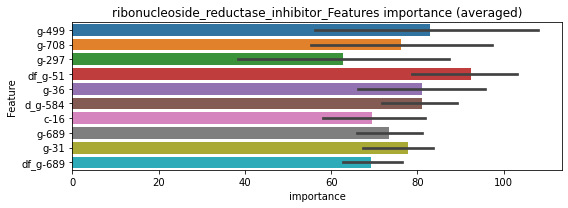

len(train_index) : 3893
len(valid_index) : 3894
================================= fold 1/2 ribonucleoside_reductase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0148419	valid_1's binary_logloss: 0.0270466
[200]	training's binary_logloss: 0.00190329	valid_1's binary_logloss: 0.0102973
[300]	training's binary_logloss: 0.000543178	valid_1's binary_logloss: 0.00700326
[400]	training's binary_logloss: 0.000274293	valid_1's binary_logloss: 0.00597466
[500]	training's binary_logloss: 0.000200508	valid_1's binary_logloss: 0.00566362
Early stopping, best iteration is:
[497]	training's binary_logloss: 0.000201306	valid_1's binary_logloss: 0.00565834


len(train_index) : 3894
len(valid_index) : 3893
================================= fold 2/2 ribonucleoside_reductase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0150124	valid_1's binary_logloss: 0.0271245
[200]	training's binary_logloss: 0.00200623	valid_1's binary_logloss: 0.00849885
[300]	training's binary_logloss: 0.000563215	valid_1's binary_logloss: 0.00501412
[400]	training's binary_logloss: 0.000281625	valid_1's binary_logloss: 0.00405259
[500]	training's binary_logloss: 0.000206026	valid_1's binary_logloss: 0.00372323
Early stopping, best iteration is:
[500]	training's binary_logloss: 0.000206026	valid_1's binary_logloss: 0.00372323


ribonucleoside_reductase_inhibitor logloss: 0.004690908508351717
rna_polymerase_inhibitor, len(trt): 25, len(othr): 3284, target_rate: 0.0010498 → Adj_target_rate: 0.0012955


neg labels: 3289 → selected neg labels: 3284


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0288227	valid_1's binary_logloss: 0.0389745
[200]	training's binary_logloss: 0.00376415	valid_1's binary_logloss: 0.00776403
[300]	training's binary_logloss: 0.00105534	valid_1's binary_logloss: 0.00313725
[400]	training's binary_logloss: 0.000541476	valid_1's binary_logloss: 0.00206397
[500]	training's binary_logloss: 0.000404811	valid_1's binary_logloss: 0.00174527
Early stopping, best iteration is:
[510]	training's binary_logloss: 0.000402188	valid_1's binary_logloss: 0.00174483
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0291694	valid_1's binary_logloss: 0.0444463
[200]	training's binary_logloss: 0.00385038	valid_1's binary_logloss: 0.0109988
[300]	training's binary_logloss: 0.00106471	valid_1's binary_logloss: 0.00561525
[400]	training's binary_logloss: 0.000542234	valid_1's binary_logloss: 0.00433538
[500]	training's binary_logloss: 0

1 / 3 AUC score:1.000
Threshold: 0.0021563, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → positive_corect_labels: 656/3808
p_label_rate: 0.0635359 Vs.target_rate: 0.00105, Num_p_label: 253.0, conf_0:0.00030, conf_1:0.00237
Num_p_label: 253.0, Expected: 4.2, Adj_threshold_1: 0.0021563
Num_p_label: 89.0, Expected: 4.2, Adj_threshold_2: 0.0071563
Num_p_label: 64.0, Expected: 4.2, Adj_threshold_3: 0.0121563
Num_p_label: 46.0, Expected: 4.2, Adj_threshold_4: 0.0171563
Num_p_label: 37.0, Expected: 4.2, Adj_threshold_5: 0.0221563
Num_p_label: 33.0, Expected: 4.2, Adj_threshold_6: 0.0271563
Num_p_label: 27.0, Expected: 4.2, Adj_threshold_7: 0.0321563
Num_p_label: 24.0, Expected: 4.2, Adj_threshold_8: 0.0371563
Num_p_label: 18.0, Expected: 4.2, Adj_threshold_9: 0.0421563
Num_p_label: 18.0, Expected: 4.2, Adj_threshold_10: 0.0471563
threshold: 0.0521563, positive p_label: 18.0/3982, p_label_rate: 0.0045203
positive y_label: 656.0/3808, y_label_rate: 0.1722689
================= Pseudo label

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0277257	valid_1's binary_logloss: 0.0362149
[200]	training's binary_logloss: 0.00350913	valid_1's binary_logloss: 0.00678705
[300]	training's binary_logloss: 0.000981061	valid_1's binary_logloss: 0.00247344
[400]	training's binary_logloss: 0.000511741	valid_1's binary_logloss: 0.001588
[500]	training's binary_logloss: 0.000389734	valid_1's binary_logloss: 0.00134648
Early stopping, best iteration is:
[535]	training's binary_logloss: 0.000382243	valid_1's binary_logloss: 0.00133539
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0281954	valid_1's binary_logloss: 0.0421141
[200]	training's binary_logloss: 0.00360682	valid_1's binary_logloss: 0.00932416
[300]	training's binary_logloss: 0.000984946	valid_1's binary_logloss: 0.00387062
[400]	training's binary_logloss: 0.00051318	valid_1's binary_logloss: 0.00262947
[500]	training's binary_logloss: 0

2 / 3 AUC score:1.000
Threshold: 0.0521563, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 1 → positive_corect_labels: 656.0/3807
p_label_rate: 0.0223506 Vs.target_rate: 0.00105, Num_p_label: 89.0, conf_0:0.00035, conf_1:0.05737
Num_p_label: 89.0, Expected: 4.2, Adj_threshold_1: 0.0521563
Num_p_label: 85.0, Expected: 4.2, Adj_threshold_2: 0.0571563
Num_p_label: 82.0, Expected: 4.2, Adj_threshold_3: 0.0621563
Num_p_label: 82.0, Expected: 4.2, Adj_threshold_4: 0.0671563
Num_p_label: 81.0, Expected: 4.2, Adj_threshold_5: 0.0721563
Num_p_label: 79.0, Expected: 4.2, Adj_threshold_6: 0.0771563
Num_p_label: 78.0, Expected: 4.2, Adj_threshold_7: 0.0821563
Num_p_label: 75.0, Expected: 4.2, Adj_threshold_8: 0.0871563
Num_p_label: 75.0, Expected: 4.2, Adj_threshold_9: 0.0921563
Num_p_label: 73.0, Expected: 4.2, Adj_threshold_10: 0.0971563
threshold: 0.1021563, positive p_label: 72.0/3982, p_label_rate: 0.0180814
positive y_label: 656.0/3807, y_label_rate: 0.1723142
================= Pseudo labelin

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.028268	valid_1's binary_logloss: 0.0356656
[200]	training's binary_logloss: 0.00360229	valid_1's binary_logloss: 0.00654193
[300]	training's binary_logloss: 0.00100436	valid_1's binary_logloss: 0.00239206
[400]	training's binary_logloss: 0.00051798	valid_1's binary_logloss: 0.0015188
[500]	training's binary_logloss: 0.000387699	valid_1's binary_logloss: 0.00126485
Early stopping, best iteration is:
[511]	training's binary_logloss: 0.000383385	valid_1's binary_logloss: 0.00125714
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0275185	valid_1's binary_logloss: 0.0406988
[200]	training's binary_logloss: 0.00349889	valid_1's binary_logloss: 0.00880206
[300]	training's binary_logloss: 0.000969092	valid_1's binary_logloss: 0.00371549
[400]	training's binary_logloss: 0.000511076	valid_1's binary_logloss: 0.0025043
[500]	training's binary_logloss: 0.0

3 / 3 AUC score:1.000
Threshold: 0.1021563, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → positive_corect_labels: 656.0/3807
p_label_rate: 0.0168257 Vs.target_rate: 0.00105, Num_p_label: 67.0, conf_0:0.00035, conf_1:0.11237
Num_p_label: 67.0, Expected: 4.2, Adj_threshold_1: 0.1021563
Num_p_label: 66.0, Expected: 4.2, Adj_threshold_2: 0.1071563
Num_p_label: 65.0, Expected: 4.2, Adj_threshold_3: 0.1121563
Num_p_label: 64.0, Expected: 4.2, Adj_threshold_4: 0.1171563
Num_p_label: 64.0, Expected: 4.2, Adj_threshold_5: 0.1221563
Num_p_label: 63.0, Expected: 4.2, Adj_threshold_6: 0.1271563
Num_p_label: 60.0, Expected: 4.2, Adj_threshold_7: 0.1321563
Num_p_label: 59.0, Expected: 4.2, Adj_threshold_8: 0.1371563
Num_p_label: 59.0, Expected: 4.2, Adj_threshold_9: 0.1421563
Num_p_label: 59.0, Expected: 4.2, Adj_threshold_10: 0.1471563
threshold: 0.1521563, positive p_label: 57.0/3982, p_label_rate: 0.0143144
positive y_label: 713.0/7789, y_label_rate: 0.0915394


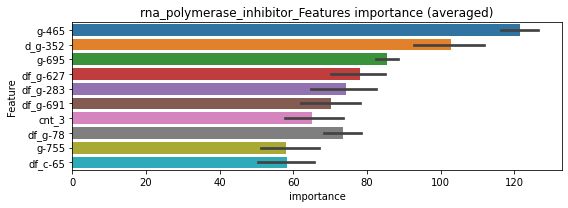

len(train_index) : 3894
len(valid_index) : 3895
================================= fold 1/2 rna_polymerase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0175164	valid_1's binary_logloss: 0.0286296
[200]	training's binary_logloss: 0.00241491	valid_1's binary_logloss: 0.01043
[300]	training's binary_logloss: 0.000674958	valid_1's binary_logloss: 0.00780551
Early stopping, best iteration is:
[299]	training's binary_logloss: 0.000680752	valid_1's binary_logloss: 0.0078013


len(train_index) : 3895
len(valid_index) : 3894
================================= fold 2/2 rna_polymerase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0185429	valid_1's binary_logloss: 0.0267754
[200]	training's binary_logloss: 0.0027073	valid_1's binary_logloss: 0.0086691
[300]	training's binary_logloss: 0.000743509	valid_1's binary_logloss: 0.00619749
Early stopping, best iteration is:
[322]	training's binary_logloss: 0.000613682	valid_1's binary_logloss: 0.00605711


rna_polymerase_inhibitor logloss: 0.006929319478947171
serotonin_receptor_agonist, len(trt): 236, len(othr): 3249, target_rate: 0.0099101 → Adj_target_rate: 0.0087332


neg labels: 3289 → selected neg labels: 3249


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0980588	valid_1's binary_logloss: 0.268783
[200]	training's binary_logloss: 0.0329044	valid_1's binary_logloss: 0.24482
Early stopping, best iteration is:
[226]	training's binary_logloss: 0.0250862	valid_1's binary_logloss: 0.243092
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.108532	valid_1's binary_logloss: 0.268608
[200]	training's binary_logloss: 0.0384791	valid_1's binary_logloss: 0.235561
Early stopping, best iteration is:
[226]	training's binary_logloss: 0.0296042	valid_1's binary_logloss: 0.231223


1 / 3 AUC score:0.912
Threshold: 0.0823140, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 399 → positive_corect_labels: 515/3499
p_label_rate: 0.0562531 Vs.target_rate: 0.00991, Num_p_label: 224.0, conf_0:0.03415, conf_1:0.09055
Num_p_label: 224.0, Expected: 39.5, Adj_threshold_1: 0.0823140
Num_p_label: 188.0, Expected: 39.5, Adj_threshold_2: 0.0873140
Num_p_label: 160.0, Expected: 39.5, Adj_threshold_3: 0.0923140
Num_p_label: 133.0, Expected: 39.5, Adj_threshold_4: 0.0973140
Num_p_label: 103.0, Expected: 39.5, Adj_threshold_5: 0.1023140
Num_p_label: 83.0, Expected: 39.5, Adj_threshold_6: 0.1073140
Num_p_label: 71.0, Expected: 39.5, Adj_threshold_7: 0.1123140
threshold: 0.1123140, positive p_label: 71.0/3982, p_label_rate: 0.0178302
positive y_label: 515.0/3499, y_label_rate: 0.1471849
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0740102	valid_1's binary_logloss: 0.189611
[200]	training's binary_logloss: 0.0214676	valid_1's binary_logloss: 0.153471
Early stopping, best iteration is:
[220]	training's binary_logloss: 0.0167414	valid_1's binary_logloss: 0.151967
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0767938	valid_1's binary_logloss: 0.186221
[200]	training's binary_logloss: 0.0223894	valid_1's binary_logloss: 0.147838
[300]	training's binary_logloss: 0.0076099	valid_1's binary_logloss: 0.135771
Early stopping, best iteration is:
[309]	training's binary_logloss: 0.00697136	valid_1's binary_logloss: 0.135455


2 / 3 AUC score:0.976
Threshold: 0.1123140, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 83 → positive_corect_labels: 437.0/3416
p_label_rate: 0.0052737 Vs.target_rate: 0.00991, Num_p_label: 21.0, conf_0:0.01514, conf_1:0.12355
threshold: 0.1123140, positive p_label: 21.0/3982, p_label_rate: 0.0052737
positive y_label: 437.0/3416, y_label_rate: 0.1279274
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0501034	valid_1's binary_logloss: 0.140774
[200]	training's binary_logloss: 0.0129456	valid_1's binary_logloss: 0.113026
Early stopping, best iteration is:
[233]	training's binary_logloss: 0.00853612	valid_1's binary_logloss: 0.110296
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0598929	valid_1's binary_logloss: 0.140679
[200]	training's binary_logloss: 0.0162724	valid_1's binary_logloss: 0.102509
[300]	training's binary_logloss: 0.00534661	valid_1's binary_logloss: 0.0919256
Early stopping, best iteration is:
[365]	training's binary_logloss: 0.00309771	valid_1's binary_logloss: 0.0891101


3 / 3 AUC score:0.990
Threshold: 0.1123140, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 50 → positive_corect_labels: 388.0/3366
p_label_rate: 0.0010045 Vs.target_rate: 0.00991, Num_p_label: 4.0, conf_0:0.00695, conf_1:0.12355
Num_p_label: 4.0, Expected: 39.5, Adj_threshold_1: 0.1123140
Num_p_label: 4.0, Expected: 39.5, Adj_threshold_2: 0.1073140
Num_p_label: 4.0, Expected: 39.5, Adj_threshold_3: 0.1023140
Num_p_label: 4.0, Expected: 39.5, Adj_threshold_4: 0.0973140
Num_p_label: 5.0, Expected: 39.5, Adj_threshold_5: 0.0923140
Num_p_label: 5.0, Expected: 39.5, Adj_threshold_6: 0.0873140
Num_p_label: 5.0, Expected: 39.5, Adj_threshold_7: 0.0823140
Num_p_label: 5.0, Expected: 39.5, Adj_threshold_8: 0.0773140
Num_p_label: 8.0, Expected: 39.5, Adj_threshold_9: 0.0723140
Num_p_label: 12.0, Expected: 39.5, Adj_threshold_10: 0.0673140
threshold: 0.0623140, positive p_label: 20.0/3982, p_label_rate: 0.0050226
positive y_label: 408.0/7348, y_label_rate: 0.0555253


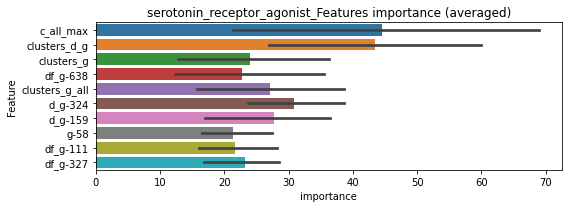

len(train_index) : 3674
len(valid_index) : 3674
================================= fold 1/2 serotonin_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.023134	valid_1's binary_logloss: 0.0723012
[200]	training's binary_logloss: 0.00577536	valid_1's binary_logloss: 0.0606674
Early stopping, best iteration is:
[212]	training's binary_logloss: 0.00496408	valid_1's binary_logloss: 0.0597774


len(train_index) : 3674
len(valid_index) : 3674
================================= fold 2/2 serotonin_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0249316	valid_1's binary_logloss: 0.0782123
[200]	training's binary_logloss: 0.0060468	valid_1's binary_logloss: 0.0672048
Early stopping, best iteration is:
[191]	training's binary_logloss: 0.00676914	valid_1's binary_logloss: 0.0671397


serotonin_receptor_agonist logloss: 0.0634585542288336


  acetylcholine_receptor_agonist acetylcholine_receptor_antagonist  \
0                       df_g-122                              c-30   
1                  clusters_df_c                         c_all_max   
2                          cnt_0                    clusters_g_all   
3                      c_all_min                          df_g-707   
4                        df_g-51                        clusters_g   
5                       df_c_min                          df_c_min   
6                          cnt_2                             g-514   
7                       df_g-736                          df_g-640   
8                          g-244                            df_c-6   
9                           c-73                          df_g-597   

  acetylcholinesterase_inhibitor adenosine_receptor_antagonist  \
0                      c_all_max                clusters_c_all   
1                      c_all_min                      df_c_min   
2                 clusters_g_al

serotonin_receptor_antagonist, len(trt): 404, len(othr): 3220, target_rate: 0.0169648 → Adj_target_rate: 0.0137918


neg labels: 3289 → selected neg labels: 3220


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.136712	valid_1's binary_logloss: 0.354025
Early stopping, best iteration is:
[150]	training's binary_logloss: 0.0834198	valid_1's binary_logloss: 0.348952
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.131374	valid_1's binary_logloss: 0.353338


1 / 3 AUC score:0.813
Threshold: 0.1419610, pos_neg_ratio: 0.8000000


Early stopping, best iteration is:
[180]	training's binary_logloss: 0.0610388	valid_1's binary_logloss: 0.342058


Remove_noisy_labels: 677 → positive_corect_labels: 370/3187
p_label_rate: 0.0911602 Vs.target_rate: 0.01696, Num_p_label: 363.0, conf_0:0.07573, conf_1:0.15616
Num_p_label: 363.0, Expected: 67.6, Adj_threshold_1: 0.1419610
Num_p_label: 322.0, Expected: 67.6, Adj_threshold_2: 0.1469610
Num_p_label: 289.0, Expected: 67.6, Adj_threshold_3: 0.1519610
Num_p_label: 264.0, Expected: 67.6, Adj_threshold_4: 0.1569610
Num_p_label: 224.0, Expected: 67.6, Adj_threshold_5: 0.1619610
Num_p_label: 196.0, Expected: 67.6, Adj_threshold_6: 0.1669610
Num_p_label: 184.0, Expected: 67.6, Adj_threshold_7: 0.1719610
Num_p_label: 170.0, Expected: 67.6, Adj_threshold_8: 0.1769610
Num_p_label: 145.0, Expected: 67.6, Adj_threshold_9: 0.1819610
Num_p_label: 128.0, Expected: 67.6, Adj_threshold_10: 0.1869610
threshold: 0.1869610, positive p_label: 128.0/3982, p_label_rate: 0.0321447
positive y_label: 370.0/3187, y_label_rate: 0.1160966
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0613331	valid_1's binary_logloss: 0.213644
Early stopping, best iteration is:
[155]	training's binary_logloss: 0.0305543	valid_1's binary_logloss: 0.201692
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0681804	valid_1's binary_logloss: 0.20717
[200]	training's binary_logloss: 0.0202396	valid_1's binary_logloss: 0.183869


2 / 3 AUC score:0.951
Threshold: 0.1869610, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 163 → positive_corect_labels: 222.0/3024
p_label_rate: 0.0128076 Vs.target_rate: 0.01696, Num_p_label: 51.0, conf_0:0.02414, conf_1:0.20566


Early stopping, best iteration is:
[200]	training's binary_logloss: 0.0202396	valid_1's binary_logloss: 0.183869


threshold: 0.1869610, positive p_label: 51.0/3982, p_label_rate: 0.0128076
positive y_label: 222.0/3024, y_label_rate: 0.0734127
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.030213	valid_1's binary_logloss: 0.132646
Early stopping, best iteration is:
[162]	training's binary_logloss: 0.0113515	valid_1's binary_logloss: 0.122379
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.030985	valid_1's binary_logloss: 0.125237


3 / 3 AUC score:0.981
Threshold: 0.1869610, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 82 → positive_corect_labels: 141.0/2942
p_label_rate: 0.0010045 Vs.target_rate: 0.01696, Num_p_label: 4.0, conf_0:0.00754, conf_1:0.20566
Num_p_label: 4.0, Expected: 67.6, Adj_threshold_1: 0.1869610
Num_p_label: 6.0, Expected: 67.6, Adj_threshold_2: 0.1819610
Num_p_label: 7.0, Expected: 67.6, Adj_threshold_3: 0.1769610


Early stopping, best iteration is:
[183]	training's binary_logloss: 0.00961412	valid_1's binary_logloss: 0.11368


Num_p_label: 7.0, Expected: 67.6, Adj_threshold_4: 0.1719610
Num_p_label: 7.0, Expected: 67.6, Adj_threshold_5: 0.1669610
Num_p_label: 8.0, Expected: 67.6, Adj_threshold_6: 0.1619610
Num_p_label: 9.0, Expected: 67.6, Adj_threshold_7: 0.1569610
Num_p_label: 10.0, Expected: 67.6, Adj_threshold_8: 0.1519610
Num_p_label: 11.0, Expected: 67.6, Adj_threshold_9: 0.1469610
Num_p_label: 14.0, Expected: 67.6, Adj_threshold_10: 0.1419610
threshold: 0.1369610, positive p_label: 16.0/3982, p_label_rate: 0.0040181
positive y_label: 157.0/6924, y_label_rate: 0.0226748


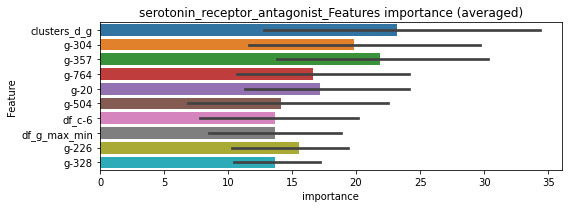

len(train_index) : 3462
len(valid_index) : 3462
================================= fold 1/2 serotonin_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.00762984	valid_1's binary_logloss: 0.0531974
Early stopping, best iteration is:
[95]	training's binary_logloss: 0.00832764	valid_1's binary_logloss: 0.0529733


len(train_index) : 3462
len(valid_index) : 3462
================================= fold 2/2 serotonin_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.00847729	valid_1's binary_logloss: 0.0472216


serotonin_receptor_antagonist logloss: 0.04955502496632363


Early stopping, best iteration is:
[124]	training's binary_logloss: 0.00557999	valid_1's binary_logloss: 0.0461368
  acetylcholine_receptor_agonist acetylcholine_receptor_antagonist  \
0                       df_g-122                              c-30   
1                  clusters_df_c                         c_all_max   
2                          cnt_0                    clusters_g_all   
3                      c_all_min                          df_g-707   
4                        df_g-51                        clusters_g   
5                       df_c_min                          df_c_min   
6                          cnt_2                             g-514   
7                       df_g-736                          df_g-640   
8                          g-244                            df_c-6   
9                           c-73                          df_g-597   

  acetylcholinesterase_inhibitor adenosine_receptor_antagonist  \
0                      c_all_max                

serotonin_reuptake_inhibitor, len(trt): 44, len(othr): 3281, target_rate: 0.0018477 → Adj_target_rate: 0.0020948


neg labels: 3289 → selected neg labels: 3281


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0381939	valid_1's binary_logloss: 0.0724417
[200]	training's binary_logloss: 0.00656808	valid_1's binary_logloss: 0.0308646
[300]	training's binary_logloss: 0.00190227	valid_1's binary_logloss: 0.0212451
[400]	training's binary_logloss: 0.000919036	valid_1's binary_logloss: 0.0183331
[500]	training's binary_logloss: 0.000602092	valid_1's binary_logloss: 0.0168711
Early stopping, best iteration is:
[490]	training's binary_logloss: 0.000619888	valid_1's binary_logloss: 0.0168306
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0430715	valid_1's binary_logloss: 0.066629
[200]	training's binary_logloss: 0.00777742	valid_1's binary_logloss: 0.0260891
[300]	training's binary_logloss: 0.00222226	valid_1's binary_logloss: 0.0180269
[400]	training's binary_logloss: 0.00103439	valid_1's binary_logloss: 0.0162701
Early stopping, best iteration is:
[435]	tr

1 / 3 AUC score:1.000
Threshold: 0.0047212, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 134 → positive_corect_labels: 655/3803
p_label_rate: 0.0366650 Vs.target_rate: 0.00185, Num_p_label: 146.0, conf_0:0.00073, conf_1:0.00519
Num_p_label: 146.0, Expected: 7.4, Adj_threshold_1: 0.0047212
Num_p_label: 33.0, Expected: 7.4, Adj_threshold_2: 0.0097212
Num_p_label: 11.0, Expected: 7.4, Adj_threshold_3: 0.0147212
threshold: 0.0147212, positive p_label: 11.0/3982, p_label_rate: 0.0027624
positive y_label: 655.0/3803, y_label_rate: 0.1722324
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0412785	valid_1's binary_logloss: 0.0750331
[200]	training's binary_logloss: 0.00703495	valid_1's binary_logloss: 0.0306367
[300]	training's binary_logloss: 0.00201973	valid_1's binary_logloss: 0.0204037
[400]	training's binary_logloss: 0.000963827	valid_1's binary_logloss: 0.0176987
Early stopping, best iteration is:
[488]	training's binary_logloss: 0.000649017	valid_1's binary_logloss: 0.0167973
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0385297	valid_1's binary_logloss: 0.0701568
[200]	training's binary_logloss: 0.00634487	valid_1's binary_logloss: 0.0251853
[300]	training's binary_logloss: 0.00185554	valid_1's binary_logloss: 0.016662
[400]	training's binary_logloss: 0.000917977	valid_1's binary_logloss: 0.0139696
Early stopping, best iteration is:
[426]	training's binary_logloss: 0.000808785	valid_1's binary_logloss: 0.0136484


2 / 3 AUC score:1.000
Threshold: 0.0147212, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 4 → positive_corect_labels: 653.0/3799
p_label_rate: 0.0062783 Vs.target_rate: 0.00185, Num_p_label: 25.0, conf_0:0.00081, conf_1:0.01619
Num_p_label: 25.0, Expected: 7.4, Adj_threshold_1: 0.0147212
Num_p_label: 11.0, Expected: 7.4, Adj_threshold_2: 0.0197212
threshold: 0.0197212, positive p_label: 11.0/3982, p_label_rate: 0.0027624
positive y_label: 653.0/3799, y_label_rate: 0.1718873
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0396052	valid_1's binary_logloss: 0.0684571
[200]	training's binary_logloss: 0.00690835	valid_1's binary_logloss: 0.0274463
[300]	training's binary_logloss: 0.00199903	valid_1's binary_logloss: 0.018212
[400]	training's binary_logloss: 0.000957201	valid_1's binary_logloss: 0.015446
Early stopping, best iteration is:
[441]	training's binary_logloss: 0.000779443	valid_1's binary_logloss: 0.0147646
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0390701	valid_1's binary_logloss: 0.0651587
[200]	training's binary_logloss: 0.00642332	valid_1's binary_logloss: 0.023187
[300]	training's binary_logloss: 0.00189197	valid_1's binary_logloss: 0.0158594
[400]	training's binary_logloss: 0.000926039	valid_1's binary_logloss: 0.0136892
Early stopping, best iteration is:
[444]	training's binary_logloss: 0.000755686	valid_1's binary_logloss: 0.0131167


3 / 3 AUC score:1.000
Threshold: 0.0197212, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 4 → positive_corect_labels: 650.0/3795
p_label_rate: 0.0025113 Vs.target_rate: 0.00185, Num_p_label: 10.0, conf_0:0.00083, conf_1:0.02169
threshold: 0.0197212, positive p_label: 10.0/3982, p_label_rate: 0.0025113
positive y_label: 660.0/7777, y_label_rate: 0.0848656


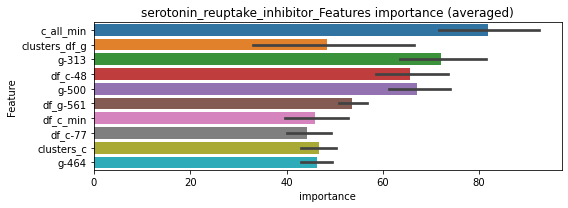

len(train_index) : 3888
len(valid_index) : 3889
================================= fold 1/2 serotonin_reuptake_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.022017	valid_1's binary_logloss: 0.0488259
[200]	training's binary_logloss: 0.00368759	valid_1's binary_logloss: 0.0277076
Early stopping, best iteration is:
[275]	training's binary_logloss: 0.0013229	valid_1's binary_logloss: 0.0247108


len(train_index) : 3889
len(valid_index) : 3888
================================= fold 2/2 serotonin_reuptake_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0232428	valid_1's binary_logloss: 0.0410961
[200]	training's binary_logloss: 0.00415473	valid_1's binary_logloss: 0.0164983
[300]	training's binary_logloss: 0.00116519	valid_1's binary_logloss: 0.0104413
[400]	training's binary_logloss: 0.000545284	valid_1's binary_logloss: 0.00888429
[500]	training's binary_logloss: 0.000345218	valid_1's binary_logloss: 0.00821737
Early stopping, best iteration is:
[520]	training's binary_logloss: 0.000323839	valid_1's binary_logloss: 0.00811889


serotonin_reuptake_inhibitor logloss: 0.016415921045639888
sigma_receptor_agonist, len(trt): 36, len(othr): 3283, target_rate: 0.0015117 → Adj_target_rate: 0.0017663


neg labels: 3289 → selected neg labels: 3283


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0406632	valid_1's binary_logloss: 0.063151
[200]	training's binary_logloss: 0.00675424	valid_1's binary_logloss: 0.0199869
[300]	training's binary_logloss: 0.00184819	valid_1's binary_logloss: 0.00990068
[400]	training's binary_logloss: 0.000866399	valid_1's binary_logloss: 0.00680827
[500]	training's binary_logloss: 0.00056097	valid_1's binary_logloss: 0.0056448
[600]	training's binary_logloss: 0.000472334	valid_1's binary_logloss: 0.00536569
Early stopping, best iteration is:
[612]	training's binary_logloss: 0.000466679	valid_1's binary_logloss: 0.00533043
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0404079	valid_1's binary_logloss: 0.0634525
[200]	training's binary_logloss: 0.00664894	valid_1's binary_logloss: 0.0197772
[300]	training's binary_logloss: 0.00186367	valid_1's binary_logloss: 0.0103499
[400]	training's binary_logloss: 0.0008

1 / 3 AUC score:1.000
Threshold: 0.0046061, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → positive_corect_labels: 656/3807
p_label_rate: 0.0361627 Vs.target_rate: 0.00151, Num_p_label: 144.0, conf_0:0.00048, conf_1:0.00507
Num_p_label: 144.0, Expected: 6.0, Adj_threshold_1: 0.0046061
Num_p_label: 46.0, Expected: 6.0, Adj_threshold_2: 0.0096061
Num_p_label: 25.0, Expected: 6.0, Adj_threshold_3: 0.0146061
Num_p_label: 15.0, Expected: 6.0, Adj_threshold_4: 0.0196061
Num_p_label: 9.0, Expected: 6.0, Adj_threshold_5: 0.0246061
threshold: 0.0246061, positive p_label: 9.0/3982, p_label_rate: 0.0022602
positive y_label: 656.0/3807, y_label_rate: 0.1723142
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0386955	valid_1's binary_logloss: 0.0593784
[200]	training's binary_logloss: 0.00614906	valid_1's binary_logloss: 0.0178621
[300]	training's binary_logloss: 0.00172854	valid_1's binary_logloss: 0.0088118
[400]	training's binary_logloss: 0.000834644	valid_1's binary_logloss: 0.0061967
[500]	training's binary_logloss: 0.00055528	valid_1's binary_logloss: 0.00512519
Early stopping, best iteration is:
[559]	training's binary_logloss: 0.000492576	valid_1's binary_logloss: 0.00492361
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0395566	valid_1's binary_logloss: 0.0616022
[200]	training's binary_logloss: 0.00653961	valid_1's binary_logloss: 0.0186241
[300]	training's binary_logloss: 0.00181739	valid_1's binary_logloss: 0.00943327
[400]	training's binary_logloss: 0.000868138	valid_1's binary_logloss: 0.00700783
[500]	training's binary_logloss: 0.000

2 / 3 AUC score:1.000
Threshold: 0.0246061, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → positive_corect_labels: 656.0/3807
p_label_rate: 0.0107986 Vs.target_rate: 0.00151, Num_p_label: 43.0, conf_0:0.00054, conf_1:0.02707
Num_p_label: 43.0, Expected: 6.0, Adj_threshold_1: 0.0246061
Num_p_label: 30.0, Expected: 6.0, Adj_threshold_2: 0.0296061
Num_p_label: 24.0, Expected: 6.0, Adj_threshold_3: 0.0346061
Num_p_label: 17.0, Expected: 6.0, Adj_threshold_4: 0.0396061
Num_p_label: 11.0, Expected: 6.0, Adj_threshold_5: 0.0446061
threshold: 0.0446061, positive p_label: 11.0/3982, p_label_rate: 0.0027624
positive y_label: 656.0/3807, y_label_rate: 0.1723142
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0386955	valid_1's binary_logloss: 0.0593784
[200]	training's binary_logloss: 0.00614906	valid_1's binary_logloss: 0.0178621
[300]	training's binary_logloss: 0.00172854	valid_1's binary_logloss: 0.0088118
[400]	training's binary_logloss: 0.000834644	valid_1's binary_logloss: 0.0061967
[500]	training's binary_logloss: 0.00055528	valid_1's binary_logloss: 0.00512519
Early stopping, best iteration is:
[559]	training's binary_logloss: 0.000492576	valid_1's binary_logloss: 0.00492361
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0395566	valid_1's binary_logloss: 0.0616022
[200]	training's binary_logloss: 0.00653961	valid_1's binary_logloss: 0.0186241
[300]	training's binary_logloss: 0.00181739	valid_1's binary_logloss: 0.00943327
[400]	training's binary_logloss: 0.000868138	valid_1's binary_logloss: 0.00700783
[500]	training's binary_logloss: 0.000

3 / 3 AUC score:1.000
Threshold: 0.0446061, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → positive_corect_labels: 656.0/3807
p_label_rate: 0.0027624 Vs.target_rate: 0.00151, Num_p_label: 11.0, conf_0:0.00054, conf_1:0.04907
threshold: 0.0446061, positive p_label: 11.0/3982, p_label_rate: 0.0027624
positive y_label: 667.0/7789, y_label_rate: 0.0856336


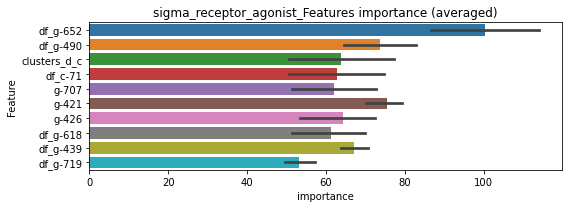

len(train_index) : 3894
len(valid_index) : 3895
================================= fold 1/2 sigma_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0223201	valid_1's binary_logloss: 0.0405514
[200]	training's binary_logloss: 0.0035953	valid_1's binary_logloss: 0.0160504
[300]	training's binary_logloss: 0.000965223	valid_1's binary_logloss: 0.0119199
Early stopping, best iteration is:
[382]	training's binary_logloss: 0.000500689	valid_1's binary_logloss: 0.0114057


len(train_index) : 3895
len(valid_index) : 3894
================================= fold 2/2 sigma_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0238448	valid_1's binary_logloss: 0.0373528
[200]	training's binary_logloss: 0.00395633	valid_1's binary_logloss: 0.0128843
[300]	training's binary_logloss: 0.00107945	valid_1's binary_logloss: 0.00859186
[400]	training's binary_logloss: 0.000496953	valid_1's binary_logloss: 0.00722643
[500]	training's binary_logloss: 0.000311615	valid_1's binary_logloss: 0.00674763
Early stopping, best iteration is:
[507]	training's binary_logloss: 0.000304543	valid_1's binary_logloss: 0.00671487


sigma_receptor_agonist logloss: 0.009060575515177178
sigma_receptor_antagonist, len(trt): 36, len(othr): 3283, target_rate: 0.0015117 → Adj_target_rate: 0.0017663


neg labels: 3289 → selected neg labels: 3283


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0343593	valid_1's binary_logloss: 0.0597184
[200]	training's binary_logloss: 0.0052926	valid_1's binary_logloss: 0.022845
[300]	training's binary_logloss: 0.00153937	valid_1's binary_logloss: 0.0142252
[400]	training's binary_logloss: 0.000767374	valid_1's binary_logloss: 0.0114553
[500]	training's binary_logloss: 0.000519093	valid_1's binary_logloss: 0.0105049
Early stopping, best iteration is:
[490]	training's binary_logloss: 0.000534205	valid_1's binary_logloss: 0.0104804
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0372374	valid_1's binary_logloss: 0.0688659
[200]	training's binary_logloss: 0.00609026	valid_1's binary_logloss: 0.0274595
[300]	training's binary_logloss: 0.00171422	valid_1's binary_logloss: 0.0171423
Early stopping, best iteration is:
[379]	training's binary_logloss: 0.000927135	valid_1's binary_logloss: 0.0141368


1 / 3 AUC score:1.000
Threshold: 0.0055497, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → positive_corect_labels: 656/3807
p_label_rate: 0.0381718 Vs.target_rate: 0.00151, Num_p_label: 152.0, conf_0:0.00063, conf_1:0.00610
Num_p_label: 152.0, Expected: 6.0, Adj_threshold_1: 0.0055497
Num_p_label: 55.0, Expected: 6.0, Adj_threshold_2: 0.0105497
Num_p_label: 33.0, Expected: 6.0, Adj_threshold_3: 0.0155497
Num_p_label: 21.0, Expected: 6.0, Adj_threshold_4: 0.0205497
Num_p_label: 14.0, Expected: 6.0, Adj_threshold_5: 0.0255497
Num_p_label: 10.0, Expected: 6.0, Adj_threshold_6: 0.0305497
threshold: 0.0305497, positive p_label: 10.0/3982, p_label_rate: 0.0025113
positive y_label: 656.0/3807, y_label_rate: 0.1723142
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0354749	valid_1's binary_logloss: 0.0561822
[200]	training's binary_logloss: 0.00533471	valid_1's binary_logloss: 0.0194028
[300]	training's binary_logloss: 0.00155121	valid_1's binary_logloss: 0.0115724
[400]	training's binary_logloss: 0.000761713	valid_1's binary_logloss: 0.00926576
[500]	training's binary_logloss: 0.000516552	valid_1's binary_logloss: 0.00818749
Early stopping, best iteration is:
[521]	training's binary_logloss: 0.000493701	valid_1's binary_logloss: 0.00809943
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0359482	valid_1's binary_logloss: 0.0704865
[200]	training's binary_logloss: 0.0057038	valid_1's binary_logloss: 0.0323717
[300]	training's binary_logloss: 0.00163221	valid_1's binary_logloss: 0.0242769
Early stopping, best iteration is:
[348]	training's binary_logloss: 0.00109588	valid_1's binary_logloss: 0.0224285


2 / 3 AUC score:1.000
Threshold: 0.0305497, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 7 → positive_corect_labels: 652.0/3800
p_label_rate: 0.0113009 Vs.target_rate: 0.00151, Num_p_label: 45.0, conf_0:0.00074, conf_1:0.03360
Num_p_label: 45.0, Expected: 6.0, Adj_threshold_1: 0.0305497
Num_p_label: 37.0, Expected: 6.0, Adj_threshold_2: 0.0355497
Num_p_label: 30.0, Expected: 6.0, Adj_threshold_3: 0.0405497
Num_p_label: 28.0, Expected: 6.0, Adj_threshold_4: 0.0455497
Num_p_label: 21.0, Expected: 6.0, Adj_threshold_5: 0.0505497
Num_p_label: 20.0, Expected: 6.0, Adj_threshold_6: 0.0555497
Num_p_label: 19.0, Expected: 6.0, Adj_threshold_7: 0.0605497
Num_p_label: 14.0, Expected: 6.0, Adj_threshold_8: 0.0655497
Num_p_label: 13.0, Expected: 6.0, Adj_threshold_9: 0.0705497
Num_p_label: 13.0, Expected: 6.0, Adj_threshold_10: 0.0755497
threshold: 0.0805497, positive p_label: 13.0/3982, p_label_rate: 0.0032647
positive y_label: 652.0/3800, y_label_rate: 0.1715789
================= Pseudo labelin

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0354425	valid_1's binary_logloss: 0.0539131
[200]	training's binary_logloss: 0.00552785	valid_1's binary_logloss: 0.015322
[300]	training's binary_logloss: 0.00159121	valid_1's binary_logloss: 0.0074671
[400]	training's binary_logloss: 0.000779226	valid_1's binary_logloss: 0.0053298
[500]	training's binary_logloss: 0.000524356	valid_1's binary_logloss: 0.00444051
Early stopping, best iteration is:
[494]	training's binary_logloss: 0.000533151	valid_1's binary_logloss: 0.00442486
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0341063	valid_1's binary_logloss: 0.0586708
[200]	training's binary_logloss: 0.00545037	valid_1's binary_logloss: 0.0210888
[300]	training's binary_logloss: 0.00158547	valid_1's binary_logloss: 0.0123962
[400]	training's binary_logloss: 0.000785535	valid_1's binary_logloss: 0.00982504
[500]	training's binary_logloss: 0.0005

3 / 3 AUC score:1.000
Threshold: 0.0805497, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 1 → positive_corect_labels: 651.0/3799
p_label_rate: 0.0020090 Vs.target_rate: 0.00151, Num_p_label: 8.0, conf_0:0.00051, conf_1:0.08860
threshold: 0.0805497, positive p_label: 8.0/3982, p_label_rate: 0.0020090
positive y_label: 659.0/7781, y_label_rate: 0.0846935


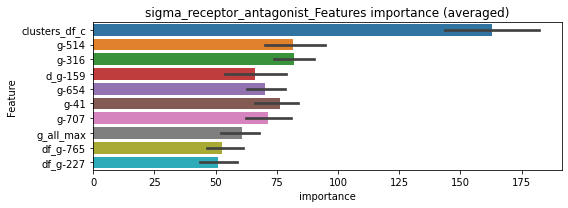

len(train_index) : 3890
len(valid_index) : 3891
================================= fold 1/2 sigma_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0194656	valid_1's binary_logloss: 0.0321351
[200]	training's binary_logloss: 0.00300175	valid_1's binary_logloss: 0.0123023
[300]	training's binary_logloss: 0.000838161	valid_1's binary_logloss: 0.00919375
Early stopping, best iteration is:
[375]	training's binary_logloss: 0.000467551	valid_1's binary_logloss: 0.00869668


len(train_index) : 3891
len(valid_index) : 3890
================================= fold 2/2 sigma_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0190128	valid_1's binary_logloss: 0.0321631
[200]	training's binary_logloss: 0.00303083	valid_1's binary_logloss: 0.0117213
[300]	training's binary_logloss: 0.000880136	valid_1's binary_logloss: 0.00765514
[400]	training's binary_logloss: 0.000420458	valid_1's binary_logloss: 0.00650924
[500]	training's binary_logloss: 0.000278691	valid_1's binary_logloss: 0.00601868
Early stopping, best iteration is:
[526]	training's binary_logloss: 0.000260399	valid_1's binary_logloss: 0.0059399


sigma_receptor_antagonist logloss: 0.00731846459445072
smoothened_receptor_antagonist, len(trt): 25, len(othr): 3284, target_rate: 0.0010498 → Adj_target_rate: 0.0012955


neg labels: 3289 → selected neg labels: 3284


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0277222	valid_1's binary_logloss: 0.0442107
[200]	training's binary_logloss: 0.0038706	valid_1's binary_logloss: 0.0132672
[300]	training's binary_logloss: 0.00111755	valid_1's binary_logloss: 0.00758347
[400]	training's binary_logloss: 0.000570841	valid_1's binary_logloss: 0.00575782
[500]	training's binary_logloss: 0.000414598	valid_1's binary_logloss: 0.00511882
Early stopping, best iteration is:
[510]	training's binary_logloss: 0.000410163	valid_1's binary_logloss: 0.00509784
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0280605	valid_1's binary_logloss: 0.0426657
[200]	training's binary_logloss: 0.00392635	valid_1's binary_logloss: 0.0113294
[300]	training's binary_logloss: 0.0011219	valid_1's binary_logloss: 0.00565403
[400]	training's binary_logloss: 0.000567619	valid_1's binary_logloss: 0.00413368
[500]	training's binary_logloss: 0.00

1 / 3 AUC score:1.000
Threshold: 0.0020845, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → positive_corect_labels: 656/3808
p_label_rate: 0.0512305 Vs.target_rate: 0.00105, Num_p_label: 204.0, conf_0:0.00035, conf_1:0.00229
Num_p_label: 204.0, Expected: 4.2, Adj_threshold_1: 0.0020845
Num_p_label: 28.0, Expected: 4.2, Adj_threshold_2: 0.0070845
Num_p_label: 4.0, Expected: 4.2, Adj_threshold_3: 0.0120845
threshold: 0.0120845, positive p_label: 4.0/3982, p_label_rate: 0.0010045
positive y_label: 656.0/3808, y_label_rate: 0.1722689
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.029091	valid_1's binary_logloss: 0.0457088
[200]	training's binary_logloss: 0.00392729	valid_1's binary_logloss: 0.013116
[300]	training's binary_logloss: 0.00112029	valid_1's binary_logloss: 0.00752619
[400]	training's binary_logloss: 0.000566863	valid_1's binary_logloss: 0.00567164
[500]	training's binary_logloss: 0.000409987	valid_1's binary_logloss: 0.00511629
Early stopping, best iteration is:
[493]	training's binary_logloss: 0.000414321	valid_1's binary_logloss: 0.00510245
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0279794	valid_1's binary_logloss: 0.040887
[200]	training's binary_logloss: 0.00384416	valid_1's binary_logloss: 0.0105419
[300]	training's binary_logloss: 0.00110274	valid_1's binary_logloss: 0.00519585
[400]	training's binary_logloss: 0.000562612	valid_1's binary_logloss: 0.0036868
Early stopping, best iteration is:
[488

2 / 3 AUC score:1.000
Threshold: 0.0120845, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → positive_corect_labels: 656.0/3808
p_label_rate: 0.0065294 Vs.target_rate: 0.00105, Num_p_label: 26.0, conf_0:0.00042, conf_1:0.01329
Num_p_label: 26.0, Expected: 4.2, Adj_threshold_1: 0.0120845
Num_p_label: 12.0, Expected: 4.2, Adj_threshold_2: 0.0170845
Num_p_label: 4.0, Expected: 4.2, Adj_threshold_3: 0.0220845
threshold: 0.0220845, positive p_label: 4.0/3982, p_label_rate: 0.0010045
positive y_label: 656.0/3808, y_label_rate: 0.1722689
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.029091	valid_1's binary_logloss: 0.0457088
[200]	training's binary_logloss: 0.00392729	valid_1's binary_logloss: 0.013116
[300]	training's binary_logloss: 0.00112029	valid_1's binary_logloss: 0.00752619
[400]	training's binary_logloss: 0.000566863	valid_1's binary_logloss: 0.00567164
[500]	training's binary_logloss: 0.000409987	valid_1's binary_logloss: 0.00511629
Early stopping, best iteration is:
[493]	training's binary_logloss: 0.000414321	valid_1's binary_logloss: 0.00510245
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0279794	valid_1's binary_logloss: 0.040887
[200]	training's binary_logloss: 0.00384416	valid_1's binary_logloss: 0.0105419
[300]	training's binary_logloss: 0.00110274	valid_1's binary_logloss: 0.00519585
[400]	training's binary_logloss: 0.000562612	valid_1's binary_logloss: 0.0036868
Early stopping, best iteration is:
[488

3 / 3 AUC score:1.000
Threshold: 0.0220845, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → positive_corect_labels: 656.0/3808
p_label_rate: 0.0010045 Vs.target_rate: 0.00105, Num_p_label: 4.0, conf_0:0.00042, conf_1:0.02429
threshold: 0.0220845, positive p_label: 4.0/3982, p_label_rate: 0.0010045
positive y_label: 660.0/7790, y_label_rate: 0.0847240


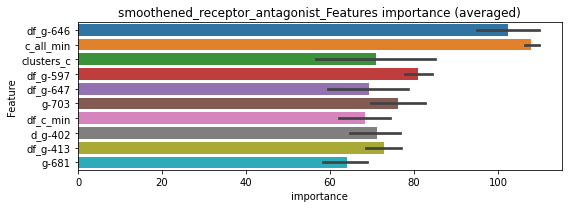

len(train_index) : 3895
len(valid_index) : 3895
================================= fold 1/2 smoothened_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0156151	valid_1's binary_logloss: 0.0241349
[200]	training's binary_logloss: 0.00207462	valid_1's binary_logloss: 0.00809516
[300]	training's binary_logloss: 0.000572853	valid_1's binary_logloss: 0.00586473
[400]	training's binary_logloss: 0.000286739	valid_1's binary_logloss: 0.00542786
Early stopping, best iteration is:
[392]	training's binary_logloss: 0.00029918	valid_1's binary_logloss: 0.00542041


len(train_index) : 3895
len(valid_index) : 3895
================================= fold 2/2 smoothened_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0152849	valid_1's binary_logloss: 0.0221485
[200]	training's binary_logloss: 0.00209255	valid_1's binary_logloss: 0.00544891
[300]	training's binary_logloss: 0.000587427	valid_1's binary_logloss: 0.00296381
[400]	training's binary_logloss: 0.000294848	valid_1's binary_logloss: 0.00238185
[500]	training's binary_logloss: 0.000208336	valid_1's binary_logloss: 0.00220703
Early stopping, best iteration is:
[500]	training's binary_logloss: 0.000208336	valid_1's binary_logloss: 0.00220703


smoothened_receptor_antagonist logloss: 0.0038137184599447214
sodium_channel_inhibitor, len(trt): 267, len(othr): 3244, target_rate: 0.0112119 → Adj_target_rate: 0.0096991


neg labels: 3289 → selected neg labels: 3244


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.117926	valid_1's binary_logloss: 0.281
[200]	training's binary_logloss: 0.0416769	valid_1's binary_logloss: 0.251949
Early stopping, best iteration is:
[225]	training's binary_logloss: 0.0327427	valid_1's binary_logloss: 0.248937
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.119268	valid_1's binary_logloss: 0.284922
[200]	training's binary_logloss: 0.0437126	valid_1's binary_logloss: 0.246277
Early stopping, best iteration is:
[235]	training's binary_logloss: 0.031411	valid_1's binary_logloss: 0.241625


1 / 3 AUC score:0.899
Threshold: 0.0938968, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 423 → positive_corect_labels: 502/3469
p_label_rate: 0.0562531 Vs.target_rate: 0.01121, Num_p_label: 224.0, conf_0:0.03913, conf_1:0.10329
Num_p_label: 224.0, Expected: 44.6, Adj_threshold_1: 0.0938968
Num_p_label: 188.0, Expected: 44.6, Adj_threshold_2: 0.0988968
Num_p_label: 161.0, Expected: 44.6, Adj_threshold_3: 0.1038968
Num_p_label: 132.0, Expected: 44.6, Adj_threshold_4: 0.1088968
Num_p_label: 113.0, Expected: 44.6, Adj_threshold_5: 0.1138968
Num_p_label: 90.0, Expected: 44.6, Adj_threshold_6: 0.1188968
Num_p_label: 76.0, Expected: 44.6, Adj_threshold_7: 0.1238968
threshold: 0.1238968, positive p_label: 76.0/3982, p_label_rate: 0.0190859
positive y_label: 502.0/3469, y_label_rate: 0.1447103
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0812672	valid_1's binary_logloss: 0.212258
[200]	training's binary_logloss: 0.024317	valid_1's binary_logloss: 0.181354
Early stopping, best iteration is:
[231]	training's binary_logloss: 0.0172058	valid_1's binary_logloss: 0.178087
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0767757	valid_1's binary_logloss: 0.205046
[200]	training's binary_logloss: 0.0223507	valid_1's binary_logloss: 0.168337
Early stopping, best iteration is:
[276]	training's binary_logloss: 0.00986255	valid_1's binary_logloss: 0.161699


2 / 3 AUC score:0.970
Threshold: 0.1238968, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 111 → positive_corect_labels: 404.0/3358
p_label_rate: 0.0052737 Vs.target_rate: 0.01121, Num_p_label: 21.0, conf_0:0.01714, conf_1:0.13629
threshold: 0.1238968, positive p_label: 21.0/3982, p_label_rate: 0.0052737
positive y_label: 404.0/3358, y_label_rate: 0.1203097
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0586593	valid_1's binary_logloss: 0.170451
[200]	training's binary_logloss: 0.0153345	valid_1's binary_logloss: 0.137094
Early stopping, best iteration is:
[225]	training's binary_logloss: 0.0112892	valid_1's binary_logloss: 0.133698
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0610027	valid_1's binary_logloss: 0.172575
[200]	training's binary_logloss: 0.0164326	valid_1's binary_logloss: 0.137194


3 / 3 AUC score:0.980
Threshold: 0.1238968, pos_neg_ratio: 0.8000000


Early stopping, best iteration is:
[243]	training's binary_logloss: 0.00984769	valid_1's binary_logloss: 0.131898


Remove_noisy_labels: 78 → positive_corect_labels: 334.0/3280
p_label_rate: 0.0015068 Vs.target_rate: 0.01121, Num_p_label: 6.0, conf_0:0.01184, conf_1:0.13629
Num_p_label: 6.0, Expected: 44.6, Adj_threshold_1: 0.1238968
Num_p_label: 6.0, Expected: 44.6, Adj_threshold_2: 0.1188968
Num_p_label: 9.0, Expected: 44.6, Adj_threshold_3: 0.1138968
Num_p_label: 9.0, Expected: 44.6, Adj_threshold_4: 0.1088968
Num_p_label: 11.0, Expected: 44.6, Adj_threshold_5: 0.1038968
Num_p_label: 12.0, Expected: 44.6, Adj_threshold_6: 0.0988968
Num_p_label: 14.0, Expected: 44.6, Adj_threshold_7: 0.0938968
Num_p_label: 19.0, Expected: 44.6, Adj_threshold_8: 0.0888968
Num_p_label: 23.0, Expected: 44.6, Adj_threshold_9: 0.0838968
threshold: 0.0838968, positive p_label: 23.0/3982, p_label_rate: 0.0057760
positive y_label: 357.0/7262, y_label_rate: 0.0491600


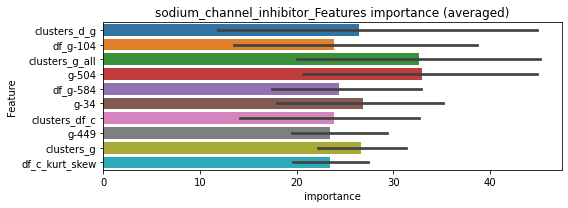

len(train_index) : 3631
len(valid_index) : 3631
================================= fold 1/2 sodium_channel_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0255738	valid_1's binary_logloss: 0.0841114
[200]	training's binary_logloss: 0.0063224	valid_1's binary_logloss: 0.0725471
Early stopping, best iteration is:
[194]	training's binary_logloss: 0.0067753	valid_1's binary_logloss: 0.0721334


len(train_index) : 3631
len(valid_index) : 3631
================================= fold 2/2 sodium_channel_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0220378	valid_1's binary_logloss: 0.0940482


sodium_channel_inhibitor logloss: 0.07947993329675479


Early stopping, best iteration is:
[146]	training's binary_logloss: 0.0110407	valid_1's binary_logloss: 0.0868265
  acetylcholine_receptor_agonist acetylcholine_receptor_antagonist  \
0                       df_g-122                              c-30   
1                  clusters_df_c                         c_all_max   
2                          cnt_0                    clusters_g_all   
3                      c_all_min                          df_g-707   
4                        df_g-51                        clusters_g   
5                       df_c_min                          df_c_min   
6                          cnt_2                             g-514   
7                       df_g-736                          df_g-640   
8                          g-244                            df_c-6   
9                           c-73                          df_g-597   

  acetylcholinesterase_inhibitor adenosine_receptor_antagonist  \
0                      c_all_max                c

sphingosine_receptor_agonist, len(trt): 32, len(othr): 3283, target_rate: 0.0013437 → Adj_target_rate: 0.0015980


neg labels: 3289 → selected neg labels: 3283


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0338605	valid_1's binary_logloss: 0.055034
[200]	training's binary_logloss: 0.00513548	valid_1's binary_logloss: 0.0159795
[300]	training's binary_logloss: 0.00144332	valid_1's binary_logloss: 0.00776691
[400]	training's binary_logloss: 0.000713169	valid_1's binary_logloss: 0.00550752
[500]	training's binary_logloss: 0.000484974	valid_1's binary_logloss: 0.00454314
[600]	training's binary_logloss: 0.000433121	valid_1's binary_logloss: 0.00435265
Early stopping, best iteration is:
[594]	training's binary_logloss: 0.000434953	valid_1's binary_logloss: 0.00434628
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.035461	valid_1's binary_logloss: 0.0587356
[200]	training's binary_logloss: 0.00539609	valid_1's binary_logloss: 0.0234715
[300]	training's binary_logloss: 0.00150774	valid_1's binary_logloss: 0.0169781
Early stopping, best iteration is:
[35

1 / 3 AUC score:1.000
Threshold: 0.0045864, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → positive_corect_labels: 656/3807
p_label_rate: 0.0494726 Vs.target_rate: 0.00134, Num_p_label: 197.0, conf_0:0.00069, conf_1:0.00505
Num_p_label: 197.0, Expected: 5.4, Adj_threshold_1: 0.0045864
Num_p_label: 92.0, Expected: 5.4, Adj_threshold_2: 0.0095864
Num_p_label: 54.0, Expected: 5.4, Adj_threshold_3: 0.0145864
Num_p_label: 37.0, Expected: 5.4, Adj_threshold_4: 0.0195864
Num_p_label: 26.0, Expected: 5.4, Adj_threshold_5: 0.0245864
Num_p_label: 23.0, Expected: 5.4, Adj_threshold_6: 0.0295864
Num_p_label: 17.0, Expected: 5.4, Adj_threshold_7: 0.0345864
Num_p_label: 14.0, Expected: 5.4, Adj_threshold_8: 0.0395864
Num_p_label: 11.0, Expected: 5.4, Adj_threshold_9: 0.0445864
Num_p_label: 8.0, Expected: 5.4, Adj_threshold_10: 0.0495864
threshold: 0.0495864, positive p_label: 8.0/3982, p_label_rate: 0.0020090
positive y_label: 656.0/3807, y_label_rate: 0.1723142
================= Pseudo labelin

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.034378	valid_1's binary_logloss: 0.0540806
[200]	training's binary_logloss: 0.00510434	valid_1's binary_logloss: 0.015538
[300]	training's binary_logloss: 0.00143067	valid_1's binary_logloss: 0.00753228
[400]	training's binary_logloss: 0.000713939	valid_1's binary_logloss: 0.00550982
[500]	training's binary_logloss: 0.000489517	valid_1's binary_logloss: 0.00455689
Early stopping, best iteration is:
[541]	training's binary_logloss: 0.000451674	valid_1's binary_logloss: 0.00438558
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0337141	valid_1's binary_logloss: 0.0558875
[200]	training's binary_logloss: 0.00497317	valid_1's binary_logloss: 0.0217135
[300]	training's binary_logloss: 0.00140841	valid_1's binary_logloss: 0.0150452
[400]	training's binary_logloss: 0.000702587	valid_1's binary_logloss: 0.0132281
Early stopping, best iteration is:
[422

2 / 3 AUC score:1.000
Threshold: 0.0495864, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 2 → positive_corect_labels: 654.0/3805
p_label_rate: 0.0070316 Vs.target_rate: 0.00134, Num_p_label: 28.0, conf_0:0.00063, conf_1:0.05455
Num_p_label: 28.0, Expected: 5.4, Adj_threshold_1: 0.0495864
Num_p_label: 27.0, Expected: 5.4, Adj_threshold_2: 0.0545864
Num_p_label: 25.0, Expected: 5.4, Adj_threshold_3: 0.0595864
Num_p_label: 23.0, Expected: 5.4, Adj_threshold_4: 0.0645864
Num_p_label: 23.0, Expected: 5.4, Adj_threshold_5: 0.0695864
Num_p_label: 20.0, Expected: 5.4, Adj_threshold_6: 0.0745864
Num_p_label: 19.0, Expected: 5.4, Adj_threshold_7: 0.0795864
Num_p_label: 17.0, Expected: 5.4, Adj_threshold_8: 0.0845864
Num_p_label: 14.0, Expected: 5.4, Adj_threshold_9: 0.0895864
Num_p_label: 13.0, Expected: 5.4, Adj_threshold_10: 0.0945864
threshold: 0.0995864, positive p_label: 13.0/3982, p_label_rate: 0.0032647
positive y_label: 654.0/3805, y_label_rate: 0.1718791
================= Pseudo labelin

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0341522	valid_1's binary_logloss: 0.0509803
[200]	training's binary_logloss: 0.00505305	valid_1's binary_logloss: 0.0136732
[300]	training's binary_logloss: 0.0014138	valid_1's binary_logloss: 0.00673644
[400]	training's binary_logloss: 0.000698819	valid_1's binary_logloss: 0.00482317
[500]	training's binary_logloss: 0.000477071	valid_1's binary_logloss: 0.0040648
Early stopping, best iteration is:
[555]	training's binary_logloss: 0.000443131	valid_1's binary_logloss: 0.00395657
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0339785	valid_1's binary_logloss: 0.0529707
[200]	training's binary_logloss: 0.00502227	valid_1's binary_logloss: 0.0147143
[300]	training's binary_logloss: 0.00142874	valid_1's binary_logloss: 0.00748493
[400]	training's binary_logloss: 0.000708664	valid_1's binary_logloss: 0.00561074
[500]	training's binary_logloss: 0.00

3 / 3 AUC score:1.000
Threshold: 0.0995864, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 1 → positive_corect_labels: 653.0/3804
p_label_rate: 0.0032647 Vs.target_rate: 0.00134, Num_p_label: 13.0, conf_0:0.00053, conf_1:0.10955
threshold: 0.0995864, positive p_label: 13.0/3982, p_label_rate: 0.0032647
positive y_label: 666.0/7786, y_label_rate: 0.0855381


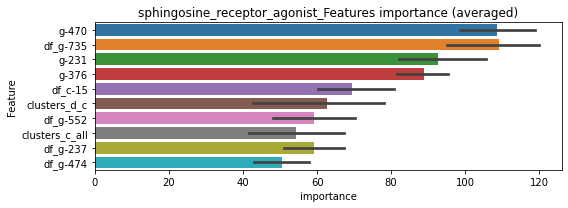

len(train_index) : 3893
len(valid_index) : 3893
================================= fold 1/2 sphingosine_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0200119	valid_1's binary_logloss: 0.0369917
[200]	training's binary_logloss: 0.00290657	valid_1's binary_logloss: 0.0166956
[300]	training's binary_logloss: 0.00078735	valid_1's binary_logloss: 0.0135246
Early stopping, best iteration is:
[311]	training's binary_logloss: 0.000711647	valid_1's binary_logloss: 0.0133935


len(train_index) : 3893
len(valid_index) : 3893
================================= fold 2/2 sphingosine_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0208529	valid_1's binary_logloss: 0.0319011
[200]	training's binary_logloss: 0.00308319	valid_1's binary_logloss: 0.0103436
[300]	training's binary_logloss: 0.000840775	valid_1's binary_logloss: 0.00578213
[400]	training's binary_logloss: 0.000406693	valid_1's binary_logloss: 0.00456533
[500]	training's binary_logloss: 0.000269397	valid_1's binary_logloss: 0.00415389
Early stopping, best iteration is:
[522]	training's binary_logloss: 0.000255751	valid_1's binary_logloss: 0.00412009


sphingosine_receptor_agonist logloss: 0.008756814580349541
src_inhibitor, len(trt): 71, len(othr): 3277, target_rate: 0.0029814 → Adj_target_rate: 0.0031461


neg labels: 3289 → selected neg labels: 3277


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0423214	valid_1's binary_logloss: 0.0885055
[200]	training's binary_logloss: 0.00798716	valid_1's binary_logloss: 0.0412972
[300]	training's binary_logloss: 0.00243667	valid_1's binary_logloss: 0.0291437
[400]	training's binary_logloss: 0.00119321	valid_1's binary_logloss: 0.0254426
[500]	training's binary_logloss: 0.000770673	valid_1's binary_logloss: 0.023242
[600]	training's binary_logloss: 0.000594387	valid_1's binary_logloss: 0.0223521
Early stopping, best iteration is:
[629]	training's binary_logloss: 0.000574851	valid_1's binary_logloss: 0.0222065
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.046956	valid_1's binary_logloss: 0.083179
[200]	training's binary_logloss: 0.00914889	valid_1's binary_logloss: 0.0353767
[300]	training's binary_logloss: 0.00272855	valid_1's binary_logloss: 0.0218216
[400]	training's binary_logloss: 0.00127691	v

1 / 3 AUC score:1.000
Threshold: 0.0105310, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → positive_corect_labels: 655/3800
p_label_rate: 0.0482170 Vs.target_rate: 0.00298, Num_p_label: 192.0, conf_0:0.00067, conf_1:0.01158
Num_p_label: 192.0, Expected: 11.9, Adj_threshold_1: 0.0105310
Num_p_label: 147.0, Expected: 11.9, Adj_threshold_2: 0.0155310
Num_p_label: 113.0, Expected: 11.9, Adj_threshold_3: 0.0205310
Num_p_label: 100.0, Expected: 11.9, Adj_threshold_4: 0.0255310
Num_p_label: 80.0, Expected: 11.9, Adj_threshold_5: 0.0305310
Num_p_label: 69.0, Expected: 11.9, Adj_threshold_6: 0.0355310
Num_p_label: 60.0, Expected: 11.9, Adj_threshold_7: 0.0405310
Num_p_label: 52.0, Expected: 11.9, Adj_threshold_8: 0.0455310
Num_p_label: 47.0, Expected: 11.9, Adj_threshold_9: 0.0505310
Num_p_label: 43.0, Expected: 11.9, Adj_threshold_10: 0.0555310
threshold: 0.0605310, positive p_label: 42.0/3982, p_label_rate: 0.0105475
positive y_label: 655.0/3800, y_label_rate: 0.1723684
=================

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0416	valid_1's binary_logloss: 0.0811304
[200]	training's binary_logloss: 0.0076554	valid_1's binary_logloss: 0.0322164
[300]	training's binary_logloss: 0.00230863	valid_1's binary_logloss: 0.0200798
[400]	training's binary_logloss: 0.0011196	valid_1's binary_logloss: 0.0160687
[500]	training's binary_logloss: 0.000725949	valid_1's binary_logloss: 0.0142527
Early stopping, best iteration is:
[510]	training's binary_logloss: 0.000701582	valid_1's binary_logloss: 0.0141118
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0450237	valid_1's binary_logloss: 0.0825723
[200]	training's binary_logloss: 0.0084289	valid_1's binary_logloss: 0.0335768
[300]	training's binary_logloss: 0.00247502	valid_1's binary_logloss: 0.0202863
[400]	training's binary_logloss: 0.00117315	valid_1's binary_logloss: 0.0162192
[500]	training's binary_logloss: 0.000750923	vali

2 / 3 AUC score:1.000
Threshold: 0.0605310, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 17 → positive_corect_labels: 653.0/3783
p_label_rate: 0.0371673 Vs.target_rate: 0.00298, Num_p_label: 148.0, conf_0:0.00075, conf_1:0.06658
Num_p_label: 148.0, Expected: 11.9, Adj_threshold_1: 0.0605310
Num_p_label: 138.0, Expected: 11.9, Adj_threshold_2: 0.0655310
Num_p_label: 134.0, Expected: 11.9, Adj_threshold_3: 0.0705310
Num_p_label: 127.0, Expected: 11.9, Adj_threshold_4: 0.0755310
Num_p_label: 125.0, Expected: 11.9, Adj_threshold_5: 0.0805310
Num_p_label: 114.0, Expected: 11.9, Adj_threshold_6: 0.0855310
Num_p_label: 108.0, Expected: 11.9, Adj_threshold_7: 0.0905310
Num_p_label: 104.0, Expected: 11.9, Adj_threshold_8: 0.0955310
Num_p_label: 100.0, Expected: 11.9, Adj_threshold_9: 0.1005310
Num_p_label: 96.0, Expected: 11.9, Adj_threshold_10: 0.1055310
threshold: 0.1105310, positive p_label: 94.0/3982, p_label_rate: 0.0236062
positive y_label: 653.0/3783, y_label_rate: 0.1726143
===========

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.041404	valid_1's binary_logloss: 0.0898962
[200]	training's binary_logloss: 0.00738743	valid_1's binary_logloss: 0.0440751
[300]	training's binary_logloss: 0.00222522	valid_1's binary_logloss: 0.0325762
Early stopping, best iteration is:
[375]	training's binary_logloss: 0.00125922	valid_1's binary_logloss: 0.0299498
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0422542	valid_1's binary_logloss: 0.088795
[200]	training's binary_logloss: 0.00752739	valid_1's binary_logloss: 0.0440291
[300]	training's binary_logloss: 0.00225352	valid_1's binary_logloss: 0.0329668
Early stopping, best iteration is:
[371]	training's binary_logloss: 0.00129819	valid_1's binary_logloss: 0.0312062


3 / 3 AUC score:0.999
Threshold: 0.1105310, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 21 → positive_corect_labels: 639.0/3762
p_label_rate: 0.0366650 Vs.target_rate: 0.00298, Num_p_label: 146.0, conf_0:0.00138, conf_1:0.12158
Num_p_label: 146.0, Expected: 11.9, Adj_threshold_1: 0.1105310
Num_p_label: 143.0, Expected: 11.9, Adj_threshold_2: 0.1155310
Num_p_label: 142.0, Expected: 11.9, Adj_threshold_3: 0.1205310
Num_p_label: 136.0, Expected: 11.9, Adj_threshold_4: 0.1255310
Num_p_label: 133.0, Expected: 11.9, Adj_threshold_5: 0.1305310
Num_p_label: 133.0, Expected: 11.9, Adj_threshold_6: 0.1355310
Num_p_label: 133.0, Expected: 11.9, Adj_threshold_7: 0.1405310
Num_p_label: 130.0, Expected: 11.9, Adj_threshold_8: 0.1455310
Num_p_label: 128.0, Expected: 11.9, Adj_threshold_9: 0.1505310
Num_p_label: 124.0, Expected: 11.9, Adj_threshold_10: 0.1555310
threshold: 0.1605310, positive p_label: 122.0/3982, p_label_rate: 0.0306379
positive y_label: 761.0/7744, y_label_rate: 0.0982696


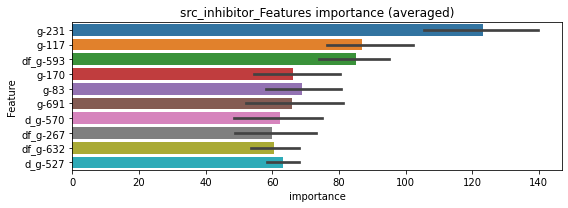

len(train_index) : 3872
len(valid_index) : 3872
================================= fold 1/2 src_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0275701	valid_1's binary_logloss: 0.075195
[200]	training's binary_logloss: 0.0051775	valid_1's binary_logloss: 0.0492213
[300]	training's binary_logloss: 0.00152531	valid_1's binary_logloss: 0.0421015
Early stopping, best iteration is:
[366]	training's binary_logloss: 0.000909331	valid_1's binary_logloss: 0.0402421


len(train_index) : 3872
len(valid_index) : 3872
================================= fold 2/2 src_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.02775	valid_1's binary_logloss: 0.0618639
[200]	training's binary_logloss: 0.00530193	valid_1's binary_logloss: 0.034998
[300]	training's binary_logloss: 0.00159301	valid_1's binary_logloss: 0.0289887
Early stopping, best iteration is:
[336]	training's binary_logloss: 0.00115975	valid_1's binary_logloss: 0.0282297


src_inhibitor logloss: 0.03423593237869469


  acetylcholine_receptor_agonist acetylcholine_receptor_antagonist  \
0                       df_g-122                              c-30   
1                  clusters_df_c                         c_all_max   
2                          cnt_0                    clusters_g_all   
3                      c_all_min                          df_g-707   
4                        df_g-51                        clusters_g   
5                       df_c_min                          df_c_min   
6                          cnt_2                             g-514   
7                       df_g-736                          df_g-640   
8                          g-244                            df_c-6   
9                           c-73                          df_g-597   

  acetylcholinesterase_inhibitor adenosine_receptor_antagonist  \
0                      c_all_max                clusters_c_all   
1                      c_all_min                      df_c_min   
2                 clusters_g_al

steroid, len(trt): 79, len(othr): 3276, target_rate: 0.0033174 → Adj_target_rate: 0.0034449
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0554623	valid_1's binary_logloss: 0.112941
[200]	training's binary_logloss: 0.0120494	valid_1's binary_logloss: 0.0625627
[300]	training's binary_logloss: 0.00356886	valid_1's binary_logloss: 0.0495833
Early stopping, best iteration is:
[353]	training's binary_logloss: 0.0022515	valid_1's binary_logloss: 0.0465223
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0585831	valid_1's binary_logloss: 0.117212
[200]	training's binary_logloss: 0.0130308	valid_1's binary_logloss: 0.0678694
[300]	training's binary_logloss: 0.00384551	valid_1's binary_logloss: 0.0545013
[400]	training's binary_logloss: 0.00170111	valid_1's binary_logloss: 0.051571
Early stopping, best iteration is:
[406]	training's binary_logloss: 0.00164077	valid_1's binary_logloss: 0.0513756


1 / 3 AUC score:0.996
Threshold: 0.0152448, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 146 → positive_corect_labels: 648/3785
p_label_rate: 0.0401808 Vs.target_rate: 0.00332, Num_p_label: 160.0, conf_0:0.00228, conf_1:0.01677
Num_p_label: 160.0, Expected: 13.2, Adj_threshold_1: 0.0152448
Num_p_label: 102.0, Expected: 13.2, Adj_threshold_2: 0.0202448
Num_p_label: 76.0, Expected: 13.2, Adj_threshold_3: 0.0252448
Num_p_label: 56.0, Expected: 13.2, Adj_threshold_4: 0.0302448
Num_p_label: 40.0, Expected: 13.2, Adj_threshold_5: 0.0352448
Num_p_label: 32.0, Expected: 13.2, Adj_threshold_6: 0.0402448
Num_p_label: 24.0, Expected: 13.2, Adj_threshold_7: 0.0452448
threshold: 0.0452448, positive p_label: 24.0/3982, p_label_rate: 0.0060271
positive y_label: 648.0/3785, y_label_rate: 0.1712021
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0536568	valid_1's binary_logloss: 0.114646
[200]	training's binary_logloss: 0.0114554	valid_1's binary_logloss: 0.0603106
[300]	training's binary_logloss: 0.00340948	valid_1's binary_logloss: 0.0440027
[400]	training's binary_logloss: 0.00155043	valid_1's binary_logloss: 0.0383725
[500]	training's binary_logloss: 0.000938368	valid_1's binary_logloss: 0.0358364
Early stopping, best iteration is:
[499]	training's binary_logloss: 0.000941621	valid_1's binary_logloss: 0.0358245
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0546591	valid_1's binary_logloss: 0.11204
[200]	training's binary_logloss: 0.0114458	valid_1's binary_logloss: 0.0563462
[300]	training's binary_logloss: 0.00343473	valid_1's binary_logloss: 0.0421902
[400]	training's binary_logloss: 0.00155766	valid_1's binary_logloss: 0.0383017
Early stopping, best iteration is:
[463]	trainin

2 / 3 AUC score:0.999
Threshold: 0.0452448, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 17 → positive_corect_labels: 641.0/3768
p_label_rate: 0.0115520 Vs.target_rate: 0.00332, Num_p_label: 46.0, conf_0:0.00148, conf_1:0.04977
Num_p_label: 46.0, Expected: 13.2, Adj_threshold_1: 0.0452448
Num_p_label: 41.0, Expected: 13.2, Adj_threshold_2: 0.0502448
Num_p_label: 35.0, Expected: 13.2, Adj_threshold_3: 0.0552448
Num_p_label: 28.0, Expected: 13.2, Adj_threshold_4: 0.0602448
Num_p_label: 23.0, Expected: 13.2, Adj_threshold_5: 0.0652448
threshold: 0.0652448, positive p_label: 23.0/3982, p_label_rate: 0.0057760
positive y_label: 641.0/3768, y_label_rate: 0.1701168
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0542342	valid_1's binary_logloss: 0.0975167
[200]	training's binary_logloss: 0.0112388	valid_1's binary_logloss: 0.041719
[300]	training's binary_logloss: 0.00335981	valid_1's binary_logloss: 0.0259663
[400]	training's binary_logloss: 0.00155177	valid_1's binary_logloss: 0.0206404
[500]	training's binary_logloss: 0.000937144	valid_1's binary_logloss: 0.0185771
[600]	training's binary_logloss: 0.000685779	valid_1's binary_logloss: 0.0174439
Early stopping, best iteration is:
[607]	training's binary_logloss: 0.000673672	valid_1's binary_logloss: 0.0173707
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.055662	valid_1's binary_logloss: 0.100213
[200]	training's binary_logloss: 0.0113549	valid_1's binary_logloss: 0.0409955
[300]	training's binary_logloss: 0.0033947	valid_1's binary_logloss: 0.0247515
[400]	training's binary_logloss: 0.00153743	vali

3 / 3 AUC score:1.000
Threshold: 0.0652448, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 6 → positive_corect_labels: 637.0/3762
p_label_rate: 0.0057760 Vs.target_rate: 0.00332, Num_p_label: 23.0, conf_0:0.00111, conf_1:0.07177
threshold: 0.0652448, positive p_label: 23.0/3982, p_label_rate: 0.0057760
positive y_label: 660.0/7744, y_label_rate: 0.0852273


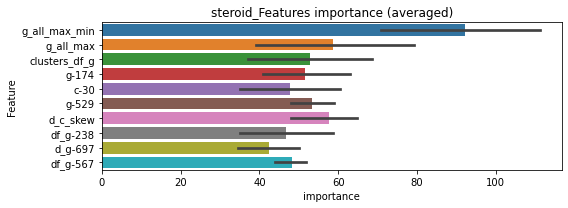

len(train_index) : 3872
len(valid_index) : 3872
================================= fold 1/2 steroid=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0295119	valid_1's binary_logloss: 0.0689887
[200]	training's binary_logloss: 0.00601672	valid_1's binary_logloss: 0.0411312
[300]	training's binary_logloss: 0.0017518	valid_1's binary_logloss: 0.0338374
[400]	training's binary_logloss: 0.000788065	valid_1's binary_logloss: 0.0316583
Early stopping, best iteration is:
[432]	training's binary_logloss: 0.000651389	valid_1's binary_logloss: 0.0312341


len(train_index) : 3872
len(valid_index) : 3872
================================= fold 2/2 steroid=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0299005	valid_1's binary_logloss: 0.0678529
[200]	training's binary_logloss: 0.00613988	valid_1's binary_logloss: 0.0417694
[300]	training's binary_logloss: 0.00180715	valid_1's binary_logloss: 0.0348487
Early stopping, best iteration is:
[337]	training's binary_logloss: 0.00127543	valid_1's binary_logloss: 0.034018


steroid logloss: 0.03262604218253384


  acetylcholine_receptor_agonist acetylcholine_receptor_antagonist  \
0                       df_g-122                              c-30   
1                  clusters_df_c                         c_all_max   
2                          cnt_0                    clusters_g_all   
3                      c_all_min                          df_g-707   
4                        df_g-51                        clusters_g   
5                       df_c_min                          df_c_min   
6                          cnt_2                             g-514   
7                       df_g-736                          df_g-640   
8                          g-244                            df_c-6   
9                           c-73                          df_g-597   

  acetylcholinesterase_inhibitor adenosine_receptor_antagonist  \
0                      c_all_max                clusters_c_all   
1                      c_all_min                      df_c_min   
2                 clusters_g_al

syk_inhibitor, len(trt): 19, len(othr): 3286, target_rate: 0.0007979 → Adj_target_rate: 0.0010260


neg labels: 3289 → selected neg labels: 3286


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0214352	valid_1's binary_logloss: 0.0351738
[200]	training's binary_logloss: 0.00257426	valid_1's binary_logloss: 0.0121041
[300]	training's binary_logloss: 0.000666082	valid_1's binary_logloss: 0.00793667
[400]	training's binary_logloss: 0.000367828	valid_1's binary_logloss: 0.00669975
Early stopping, best iteration is:
[419]	training's binary_logloss: 0.000345292	valid_1's binary_logloss: 0.00657939
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0214109	valid_1's binary_logloss: 0.0272084
[200]	training's binary_logloss: 0.00241911	valid_1's binary_logloss: 0.00559292
[300]	training's binary_logloss: 0.00069567	valid_1's binary_logloss: 0.00282784
[400]	training's binary_logloss: 0.000379732	valid_1's binary_logloss: 0.00212077
Early stopping, best iteration is:
[410]	training's binary_logloss: 0.000365919	valid_1's binary_logloss: 0.0021039

1 / 3 AUC score:1.000
Threshold: 0.0019473, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → positive_corect_labels: 657/3811
p_label_rate: 0.0441989 Vs.target_rate: 0.00080, Num_p_label: 176.0, conf_0:0.00019, conf_1:0.00214
Num_p_label: 176.0, Expected: 3.2, Adj_threshold_1: 0.0019473
Num_p_label: 41.0, Expected: 3.2, Adj_threshold_2: 0.0069473
Num_p_label: 24.0, Expected: 3.2, Adj_threshold_3: 0.0119473
Num_p_label: 17.0, Expected: 3.2, Adj_threshold_4: 0.0169473
Num_p_label: 15.0, Expected: 3.2, Adj_threshold_5: 0.0219473
Num_p_label: 14.0, Expected: 3.2, Adj_threshold_6: 0.0269473
Num_p_label: 14.0, Expected: 3.2, Adj_threshold_7: 0.0319473
Num_p_label: 14.0, Expected: 3.2, Adj_threshold_8: 0.0369473
Num_p_label: 12.0, Expected: 3.2, Adj_threshold_9: 0.0419473
Num_p_label: 12.0, Expected: 3.2, Adj_threshold_10: 0.0469473
threshold: 0.0519473, positive p_label: 10.0/3982, p_label_rate: 0.0025113
positive y_label: 657.0/3811, y_label_rate: 0.1723957
================= Pseudo label

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0202877	valid_1's binary_logloss: 0.0344523
[200]	training's binary_logloss: 0.00214903	valid_1's binary_logloss: 0.0136848
[300]	training's binary_logloss: 0.000613334	valid_1's binary_logloss: 0.0103026
Early stopping, best iteration is:
[385]	training's binary_logloss: 0.000364213	valid_1's binary_logloss: 0.00976997
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0208848	valid_1's binary_logloss: 0.0265904
[200]	training's binary_logloss: 0.00223768	valid_1's binary_logloss: 0.00541098
[300]	training's binary_logloss: 0.0006363	valid_1's binary_logloss: 0.00283933
[400]	training's binary_logloss: 0.000353359	valid_1's binary_logloss: 0.00224802
Early stopping, best iteration is:
[478]	training's binary_logloss: 0.000302327	valid_1's binary_logloss: 0.00209261


2 / 3 AUC score:1.000
Threshold: 0.0519473, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 4 → positive_corect_labels: 654.0/3807
p_label_rate: 0.0115520 Vs.target_rate: 0.00080, Num_p_label: 46.0, conf_0:0.00021, conf_1:0.05714
Num_p_label: 46.0, Expected: 3.2, Adj_threshold_1: 0.0519473
Num_p_label: 43.0, Expected: 3.2, Adj_threshold_2: 0.0569473
Num_p_label: 42.0, Expected: 3.2, Adj_threshold_3: 0.0619473
Num_p_label: 38.0, Expected: 3.2, Adj_threshold_4: 0.0669473
Num_p_label: 36.0, Expected: 3.2, Adj_threshold_5: 0.0719473
Num_p_label: 34.0, Expected: 3.2, Adj_threshold_6: 0.0769473
Num_p_label: 32.0, Expected: 3.2, Adj_threshold_7: 0.0819473
Num_p_label: 31.0, Expected: 3.2, Adj_threshold_8: 0.0869473
Num_p_label: 29.0, Expected: 3.2, Adj_threshold_9: 0.0919473
Num_p_label: 28.0, Expected: 3.2, Adj_threshold_10: 0.0969473
threshold: 0.1019473, positive p_label: 26.0/3982, p_label_rate: 0.0065294
positive y_label: 654.0/3807, y_label_rate: 0.1717888
================= Pseudo labelin

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0208917	valid_1's binary_logloss: 0.0281809
[200]	training's binary_logloss: 0.00225	valid_1's binary_logloss: 0.00525743
[300]	training's binary_logloss: 0.000625347	valid_1's binary_logloss: 0.00222024
[400]	training's binary_logloss: 0.000349106	valid_1's binary_logloss: 0.00156248
Early stopping, best iteration is:
[486]	training's binary_logloss: 0.000301503	valid_1's binary_logloss: 0.00144856
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0208649	valid_1's binary_logloss: 0.0267557
[200]	training's binary_logloss: 0.00224124	valid_1's binary_logloss: 0.00439613
[300]	training's binary_logloss: 0.000631171	valid_1's binary_logloss: 0.00156413
[400]	training's binary_logloss: 0.000348715	valid_1's binary_logloss: 0.000999659
Early stopping, best iteration is:
[480]	training's binary_logloss: 0.000297384	valid_1's binary_logloss: 0.0008831

3 / 3 AUC score:1.000
Threshold: 0.1019473, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → positive_corect_labels: 654.0/3807
p_label_rate: 0.0057760 Vs.target_rate: 0.00080, Num_p_label: 23.0, conf_0:0.00018, conf_1:0.11214
Num_p_label: 23.0, Expected: 3.2, Adj_threshold_1: 0.1019473
Num_p_label: 23.0, Expected: 3.2, Adj_threshold_2: 0.1069473
Num_p_label: 22.0, Expected: 3.2, Adj_threshold_3: 0.1119473
Num_p_label: 22.0, Expected: 3.2, Adj_threshold_4: 0.1169473
Num_p_label: 20.0, Expected: 3.2, Adj_threshold_5: 0.1219473
Num_p_label: 19.0, Expected: 3.2, Adj_threshold_6: 0.1269473
Num_p_label: 19.0, Expected: 3.2, Adj_threshold_7: 0.1319473
Num_p_label: 19.0, Expected: 3.2, Adj_threshold_8: 0.1369473
Num_p_label: 17.0, Expected: 3.2, Adj_threshold_9: 0.1419473
Num_p_label: 16.0, Expected: 3.2, Adj_threshold_10: 0.1469473
threshold: 0.1519473, positive p_label: 16.0/3982, p_label_rate: 0.0040181
positive y_label: 670.0/7789, y_label_rate: 0.0860187


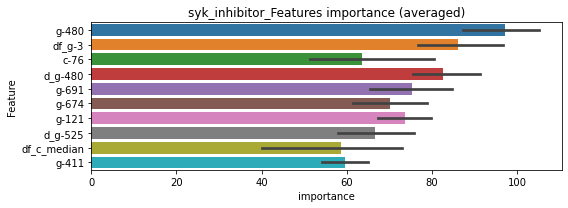

len(train_index) : 3894
len(valid_index) : 3895
================================= fold 1/2 syk_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0114509	valid_1's binary_logloss: 0.0218761
[200]	training's binary_logloss: 0.00127816	valid_1's binary_logloss: 0.0110627
Early stopping, best iteration is:
[275]	training's binary_logloss: 0.000460222	valid_1's binary_logloss: 0.0100292


len(train_index) : 3895
len(valid_index) : 3894
================================= fold 2/2 syk_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0118263	valid_1's binary_logloss: 0.0177017
[200]	training's binary_logloss: 0.00135234	valid_1's binary_logloss: 0.00572785
[300]	training's binary_logloss: 0.000386337	valid_1's binary_logloss: 0.00437161
Early stopping, best iteration is:
[302]	training's binary_logloss: 0.000379791	valid_1's binary_logloss: 0.00435553


syk_inhibitor logloss: 0.007192750718853967
tachykinin_antagonist, len(trt): 60, len(othr): 3279, target_rate: 0.0025195 → Adj_target_rate: 0.0027266


neg labels: 3289 → selected neg labels: 3279


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0514729	valid_1's binary_logloss: 0.0965351
[200]	training's binary_logloss: 0.0103399	valid_1's binary_logloss: 0.0471909
[300]	training's binary_logloss: 0.00289792	valid_1's binary_logloss: 0.0363917
Early stopping, best iteration is:
[345]	training's binary_logloss: 0.00194181	valid_1's binary_logloss: 0.0346326
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0505597	valid_1's binary_logloss: 0.0909003
[200]	training's binary_logloss: 0.00991365	valid_1's binary_logloss: 0.0351441
[300]	training's binary_logloss: 0.00288275	valid_1's binary_logloss: 0.0206067
[400]	training's binary_logloss: 0.00130235	valid_1's binary_logloss: 0.0161071
[500]	training's binary_logloss: 0.000810734	valid_1's binary_logloss: 0.0144829
Early stopping, best iteration is:
[546]	training's binary_logloss: 0.00069545	valid_1's binary_logloss: 0.013957


1 / 3 AUC score:0.998
Threshold: 0.0095804, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 140 → positive_corect_labels: 651/3794
p_label_rate: 0.0379206 Vs.target_rate: 0.00252, Num_p_label: 151.0, conf_0:0.00137, conf_1:0.01054
Num_p_label: 151.0, Expected: 10.0, Adj_threshold_1: 0.0095804
Num_p_label: 65.0, Expected: 10.0, Adj_threshold_2: 0.0145804
Num_p_label: 37.0, Expected: 10.0, Adj_threshold_3: 0.0195804
Num_p_label: 25.0, Expected: 10.0, Adj_threshold_4: 0.0245804
Num_p_label: 21.0, Expected: 10.0, Adj_threshold_5: 0.0295804
Num_p_label: 18.0, Expected: 10.0, Adj_threshold_6: 0.0345804
threshold: 0.0345804, positive p_label: 18.0/3982, p_label_rate: 0.0045203
positive y_label: 651.0/3794, y_label_rate: 0.1715867
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0490467	valid_1's binary_logloss: 0.0888111
[200]	training's binary_logloss: 0.00915021	valid_1's binary_logloss: 0.0359172
[300]	training's binary_logloss: 0.00257294	valid_1's binary_logloss: 0.0229741
[400]	training's binary_logloss: 0.00120588	valid_1's binary_logloss: 0.0192944
Early stopping, best iteration is:
[394]	training's binary_logloss: 0.00125123	valid_1's binary_logloss: 0.0191994
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0517913	valid_1's binary_logloss: 0.0897216
[200]	training's binary_logloss: 0.00967132	valid_1's binary_logloss: 0.0336383
[300]	training's binary_logloss: 0.00280333	valid_1's binary_logloss: 0.0193995
[400]	training's binary_logloss: 0.00128472	valid_1's binary_logloss: 0.0146217
[500]	training's binary_logloss: 0.000799856	valid_1's binary_logloss: 0.013073
[600]	training's binary_logloss: 0.000609285	

2 / 3 AUC score:1.000
Threshold: 0.0345804, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 11 → positive_corect_labels: 650.0/3783
p_label_rate: 0.0072828 Vs.target_rate: 0.00252, Num_p_label: 29.0, conf_0:0.00112, conf_1:0.03804
threshold: 0.0345804, positive p_label: 29.0/3982, p_label_rate: 0.0072828
positive y_label: 650.0/3783, y_label_rate: 0.1718213
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0490921	valid_1's binary_logloss: 0.0964585
[200]	training's binary_logloss: 0.00907649	valid_1's binary_logloss: 0.0489339
[300]	training's binary_logloss: 0.00259741	valid_1's binary_logloss: 0.0378339
[400]	training's binary_logloss: 0.00121928	valid_1's binary_logloss: 0.0353499
Early stopping, best iteration is:
[487]	training's binary_logloss: 0.000794091	valid_1's binary_logloss: 0.0341899
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0493142	valid_1's binary_logloss: 0.0871527
[200]	training's binary_logloss: 0.0092431	valid_1's binary_logloss: 0.0336998
[300]	training's binary_logloss: 0.00268868	valid_1's binary_logloss: 0.0197267
[400]	training's binary_logloss: 0.00125243	valid_1's binary_logloss: 0.0155438
[500]	training's binary_logloss: 0.000791481	valid_1's binary_logloss: 0.0140357
Early stopping, best iteration is:
[490]	tra

3 / 3 AUC score:0.999
Threshold: 0.0345804, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 13 → positive_corect_labels: 642.0/3770
p_label_rate: 0.0087896 Vs.target_rate: 0.00252, Num_p_label: 35.0, conf_0:0.00105, conf_1:0.03804
Num_p_label: 35.0, Expected: 10.0, Adj_threshold_1: 0.0345804
Num_p_label: 31.0, Expected: 10.0, Adj_threshold_2: 0.0395804
Num_p_label: 24.0, Expected: 10.0, Adj_threshold_3: 0.0445804
Num_p_label: 20.0, Expected: 10.0, Adj_threshold_4: 0.0495804
threshold: 0.0495804, positive p_label: 20.0/3982, p_label_rate: 0.0050226
positive y_label: 662.0/7752, y_label_rate: 0.0853973


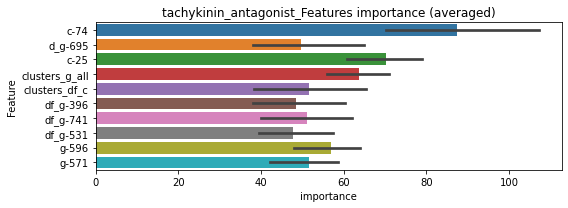

len(train_index) : 3876
len(valid_index) : 3876
================================= fold 1/2 tachykinin_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.028078	valid_1's binary_logloss: 0.062776
[200]	training's binary_logloss: 0.00516063	valid_1's binary_logloss: 0.037578
[300]	training's binary_logloss: 0.00146482	valid_1's binary_logloss: 0.032494
Early stopping, best iteration is:
[293]	training's binary_logloss: 0.00156807	valid_1's binary_logloss: 0.0324642


len(train_index) : 3876
len(valid_index) : 3876
================================= fold 2/2 tachykinin_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0285697	valid_1's binary_logloss: 0.0545843
[200]	training's binary_logloss: 0.00547163	valid_1's binary_logloss: 0.0260557
[300]	training's binary_logloss: 0.0015834	valid_1's binary_logloss: 0.0199774
Early stopping, best iteration is:
[370]	training's binary_logloss: 0.000862816	valid_1's binary_logloss: 0.0189074


tachykinin_antagonist logloss: 0.025685786640211095


  acetylcholine_receptor_agonist acetylcholine_receptor_antagonist  \
0                       df_g-122                              c-30   
1                  clusters_df_c                         c_all_max   
2                          cnt_0                    clusters_g_all   
3                      c_all_min                          df_g-707   
4                        df_g-51                        clusters_g   
5                       df_c_min                          df_c_min   
6                          cnt_2                             g-514   
7                       df_g-736                          df_g-640   
8                          g-244                            df_c-6   
9                           c-73                          df_g-597   

  acetylcholinesterase_inhibitor adenosine_receptor_antagonist  \
0                      c_all_max                clusters_c_all   
1                      c_all_min                      df_c_min   
2                 clusters_g_al

tgf-beta_receptor_inhibitor, len(trt): 30, len(othr): 3284, target_rate: 0.0012598 → Adj_target_rate: 0.0015127


neg labels: 3289 → selected neg labels: 3284


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0182151	valid_1's binary_logloss: 0.0232605
[200]	training's binary_logloss: 0.00172882	valid_1's binary_logloss: 0.00565889
[300]	training's binary_logloss: 0.000456322	valid_1's binary_logloss: 0.00456593
Early stopping, best iteration is:
[304]	training's binary_logloss: 0.000441151	valid_1's binary_logloss: 0.00456513
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0183157	valid_1's binary_logloss: 0.0223664
[200]	training's binary_logloss: 0.00174525	valid_1's binary_logloss: 0.00468619
[300]	training's binary_logloss: 0.000467181	valid_1's binary_logloss: 0.00297561
[400]	training's binary_logloss: 0.00026256	valid_1's binary_logloss: 0.00269331
Early stopping, best iteration is:
[461]	training's binary_logloss: 0.000226547	valid_1's binary_logloss: 0.00261142


1 / 3 AUC score:1.000
Threshold: 0.0009462, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → positive_corect_labels: 656/3808
p_label_rate: 0.0341537 Vs.target_rate: 0.00126, Num_p_label: 136.0, conf_0:0.00011, conf_1:0.00104
Num_p_label: 136.0, Expected: 5.0, Adj_threshold_1: 0.0009462
Num_p_label: 25.0, Expected: 5.0, Adj_threshold_2: 0.0059462
Num_p_label: 17.0, Expected: 5.0, Adj_threshold_3: 0.0109462
Num_p_label: 15.0, Expected: 5.0, Adj_threshold_4: 0.0159462
Num_p_label: 12.0, Expected: 5.0, Adj_threshold_5: 0.0209462
Num_p_label: 9.0, Expected: 5.0, Adj_threshold_6: 0.0259462
threshold: 0.0259462, positive p_label: 9.0/3982, p_label_rate: 0.0022602
positive y_label: 656.0/3808, y_label_rate: 0.1722689
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0174466	valid_1's binary_logloss: 0.019795
[200]	training's binary_logloss: 0.00149619	valid_1's binary_logloss: 0.00225674
[300]	training's binary_logloss: 0.000367481	valid_1's binary_logloss: 0.000683586
[400]	training's binary_logloss: 0.00021497	valid_1's binary_logloss: 0.000445232
[500]	training's binary_logloss: 0.000188319	valid_1's binary_logloss: 0.000404831
Early stopping, best iteration is:
[490]	training's binary_logloss: 0.000188319	valid_1's binary_logloss: 0.000404831
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0168516	valid_1's binary_logloss: 0.020285
[200]	training's binary_logloss: 0.00139575	valid_1's binary_logloss: 0.00374055
[300]	training's binary_logloss: 0.00034148	valid_1's binary_logloss: 0.00176796
[400]	training's binary_logloss: 0.000205686	valid_1's binary_logloss: 0.00143495
[500]	training's binary_logloss

2 / 3 AUC score:1.000
Threshold: 0.0259462, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 5 → positive_corect_labels: 656.0/3803
p_label_rate: 0.0092918 Vs.target_rate: 0.00126, Num_p_label: 37.0, conf_0:0.00007, conf_1:0.02854
Num_p_label: 37.0, Expected: 5.0, Adj_threshold_1: 0.0259462
Num_p_label: 31.0, Expected: 5.0, Adj_threshold_2: 0.0309462
Num_p_label: 30.0, Expected: 5.0, Adj_threshold_3: 0.0359462
Num_p_label: 27.0, Expected: 5.0, Adj_threshold_4: 0.0409462
Num_p_label: 24.0, Expected: 5.0, Adj_threshold_5: 0.0459462
Num_p_label: 24.0, Expected: 5.0, Adj_threshold_6: 0.0509462
Num_p_label: 24.0, Expected: 5.0, Adj_threshold_7: 0.0559462
Num_p_label: 24.0, Expected: 5.0, Adj_threshold_8: 0.0609462
Num_p_label: 22.0, Expected: 5.0, Adj_threshold_9: 0.0659462
Num_p_label: 22.0, Expected: 5.0, Adj_threshold_10: 0.0709462
threshold: 0.0759462, positive p_label: 22.0/3982, p_label_rate: 0.0055249
positive y_label: 656.0/3803, y_label_rate: 0.1724954
================= Pseudo labelin

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0170709	valid_1's binary_logloss: 0.0195684
[200]	training's binary_logloss: 0.00140879	valid_1's binary_logloss: 0.00221397
[300]	training's binary_logloss: 0.00034239	valid_1's binary_logloss: 0.000716575
[400]	training's binary_logloss: 0.000205575	valid_1's binary_logloss: 0.000479968
Early stopping, best iteration is:
[469]	training's binary_logloss: 0.000184174	valid_1's binary_logloss: 0.000442564
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0171061	valid_1's binary_logloss: 0.0194356
[200]	training's binary_logloss: 0.00142179	valid_1's binary_logloss: 0.00307693
[300]	training's binary_logloss: 0.00034455	valid_1's binary_logloss: 0.00142725
[400]	training's binary_logloss: 0.000208039	valid_1's binary_logloss: 0.00114441
Early stopping, best iteration is:
[434]	training's binary_logloss: 0.000193838	valid_1's binary_logloss: 0.0011

3 / 3 AUC score:1.000
Threshold: 0.0759462, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → positive_corect_labels: 656.0/3803
p_label_rate: 0.0070316 Vs.target_rate: 0.00126, Num_p_label: 28.0, conf_0:0.00008, conf_1:0.08354
Num_p_label: 28.0, Expected: 5.0, Adj_threshold_1: 0.0759462
Num_p_label: 28.0, Expected: 5.0, Adj_threshold_2: 0.0809462
Num_p_label: 26.0, Expected: 5.0, Adj_threshold_3: 0.0859462
Num_p_label: 24.0, Expected: 5.0, Adj_threshold_4: 0.0909462
Num_p_label: 23.0, Expected: 5.0, Adj_threshold_5: 0.0959462
Num_p_label: 23.0, Expected: 5.0, Adj_threshold_6: 0.1009462
Num_p_label: 23.0, Expected: 5.0, Adj_threshold_7: 0.1059462
Num_p_label: 22.0, Expected: 5.0, Adj_threshold_8: 0.1109462
Num_p_label: 20.0, Expected: 5.0, Adj_threshold_9: 0.1159462
Num_p_label: 20.0, Expected: 5.0, Adj_threshold_10: 0.1209462
threshold: 0.1259462, positive p_label: 20.0/3982, p_label_rate: 0.0050226
positive y_label: 676.0/7785, y_label_rate: 0.0868337


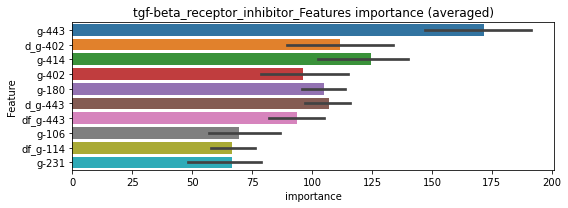

len(train_index) : 3892
len(valid_index) : 3893
================================= fold 1/2 tgf-beta_receptor_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.00991106	valid_1's binary_logloss: 0.0167234
[200]	training's binary_logloss: 0.000876858	valid_1's binary_logloss: 0.0091943
Early stopping, best iteration is:
[206]	training's binary_logloss: 0.000780578	valid_1's binary_logloss: 0.00908073


len(train_index) : 3893
len(valid_index) : 3892
================================= fold 2/2 tgf-beta_receptor_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0105411	valid_1's binary_logloss: 0.0129877
[200]	training's binary_logloss: 0.00102123	valid_1's binary_logloss: 0.00384214
[300]	training's binary_logloss: 0.000264022	valid_1's binary_logloss: 0.0028029
Early stopping, best iteration is:
[345]	training's binary_logloss: 0.000190175	valid_1's binary_logloss: 0.00266334


tgf-beta_receptor_inhibitor logloss: 0.005872446869337922
thrombin_inhibitor, len(trt): 19, len(othr): 3286, target_rate: 0.0007979 → Adj_target_rate: 0.0010260


neg labels: 3289 → selected neg labels: 3286


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0242266	valid_1's binary_logloss: 0.0370929
[200]	training's binary_logloss: 0.00298627	valid_1's binary_logloss: 0.0105664
[300]	training's binary_logloss: 0.000849811	valid_1's binary_logloss: 0.00589787
[400]	training's binary_logloss: 0.000444808	valid_1's binary_logloss: 0.00444379
[500]	training's binary_logloss: 0.00034799	valid_1's binary_logloss: 0.00403674
Early stopping, best iteration is:
[505]	training's binary_logloss: 0.00034677	valid_1's binary_logloss: 0.00403427
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.024951	valid_1's binary_logloss: 0.0300317
[200]	training's binary_logloss: 0.00311341	valid_1's binary_logloss: 0.00518067
[300]	training's binary_logloss: 0.00087799	valid_1's binary_logloss: 0.00181322
[400]	training's binary_logloss: 0.00046184	valid_1's binary_logloss: 0.00105739
[500]	training's binary_logloss: 0.00

1 / 3 AUC score:1.000
Threshold: 0.0021806, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → positive_corect_labels: 657/3811
p_label_rate: 0.0409342 Vs.target_rate: 0.00080, Num_p_label: 163.0, conf_0:0.00020, conf_1:0.00240
Num_p_label: 163.0, Expected: 3.2, Adj_threshold_1: 0.0021806
Num_p_label: 48.0, Expected: 3.2, Adj_threshold_2: 0.0071806
Num_p_label: 28.0, Expected: 3.2, Adj_threshold_3: 0.0121806
Num_p_label: 19.0, Expected: 3.2, Adj_threshold_4: 0.0171806
Num_p_label: 12.0, Expected: 3.2, Adj_threshold_5: 0.0221806
Num_p_label: 11.0, Expected: 3.2, Adj_threshold_6: 0.0271806
Num_p_label: 10.0, Expected: 3.2, Adj_threshold_7: 0.0321806
Num_p_label: 8.0, Expected: 3.2, Adj_threshold_8: 0.0371806
Num_p_label: 8.0, Expected: 3.2, Adj_threshold_9: 0.0421806
Num_p_label: 5.0, Expected: 3.2, Adj_threshold_10: 0.0471806
threshold: 0.0471806, positive p_label: 5.0/3982, p_label_rate: 0.0012557
positive y_label: 657.0/3811, y_label_rate: 0.1723957
================= Pseudo labeling 

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0231433	valid_1's binary_logloss: 0.036389
[200]	training's binary_logloss: 0.00273598	valid_1's binary_logloss: 0.0121482
[300]	training's binary_logloss: 0.000797634	valid_1's binary_logloss: 0.00778895
[400]	training's binary_logloss: 0.000428308	valid_1's binary_logloss: 0.00622775
[500]	training's binary_logloss: 0.000345136	valid_1's binary_logloss: 0.00587716
Early stopping, best iteration is:
[493]	training's binary_logloss: 0.000348288	valid_1's binary_logloss: 0.00586671
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0240164	valid_1's binary_logloss: 0.027763
[200]	training's binary_logloss: 0.00290697	valid_1's binary_logloss: 0.00409403
[300]	training's binary_logloss: 0.000833714	valid_1's binary_logloss: 0.00138887
[400]	training's binary_logloss: 0.000448963	valid_1's binary_logloss: 0.000809128
[500]	training's binary_logloss: 

2 / 3 AUC score:1.000
Threshold: 0.0471806, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → positive_corect_labels: 657.0/3811
p_label_rate: 0.0042692 Vs.target_rate: 0.00080, Num_p_label: 17.0, conf_0:0.00024, conf_1:0.05190
Num_p_label: 17.0, Expected: 3.2, Adj_threshold_1: 0.0471806
Num_p_label: 15.0, Expected: 3.2, Adj_threshold_2: 0.0521806
Num_p_label: 13.0, Expected: 3.2, Adj_threshold_3: 0.0571806
Num_p_label: 11.0, Expected: 3.2, Adj_threshold_4: 0.0621806
Num_p_label: 11.0, Expected: 3.2, Adj_threshold_5: 0.0671806
Num_p_label: 10.0, Expected: 3.2, Adj_threshold_6: 0.0721806
Num_p_label: 9.0, Expected: 3.2, Adj_threshold_7: 0.0771806
Num_p_label: 9.0, Expected: 3.2, Adj_threshold_8: 0.0821806
Num_p_label: 9.0, Expected: 3.2, Adj_threshold_9: 0.0871806
Num_p_label: 9.0, Expected: 3.2, Adj_threshold_10: 0.0921806
threshold: 0.0971806, positive p_label: 9.0/3982, p_label_rate: 0.0022602
positive y_label: 657.0/3811, y_label_rate: 0.1723957
================= Pseudo labeling 3 /

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0231433	valid_1's binary_logloss: 0.036389
[200]	training's binary_logloss: 0.00273598	valid_1's binary_logloss: 0.0121482
[300]	training's binary_logloss: 0.000797634	valid_1's binary_logloss: 0.00778895
[400]	training's binary_logloss: 0.000428308	valid_1's binary_logloss: 0.00622775
[500]	training's binary_logloss: 0.000345136	valid_1's binary_logloss: 0.00587716
Early stopping, best iteration is:
[493]	training's binary_logloss: 0.000348288	valid_1's binary_logloss: 0.00586671
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0240164	valid_1's binary_logloss: 0.027763
[200]	training's binary_logloss: 0.00290697	valid_1's binary_logloss: 0.00409403
[300]	training's binary_logloss: 0.000833714	valid_1's binary_logloss: 0.00138887
[400]	training's binary_logloss: 0.000448963	valid_1's binary_logloss: 0.000809128
[500]	training's binary_logloss: 

3 / 3 AUC score:1.000
Threshold: 0.0971806, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → positive_corect_labels: 657.0/3811
p_label_rate: 0.0022602 Vs.target_rate: 0.00080, Num_p_label: 9.0, conf_0:0.00024, conf_1:0.10690
threshold: 0.0971806, positive p_label: 9.0/3982, p_label_rate: 0.0022602
positive y_label: 666.0/7793, y_label_rate: 0.0854613


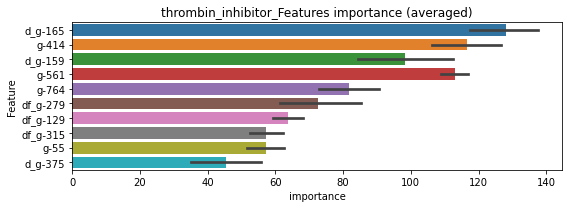

len(train_index) : 3896
len(valid_index) : 3897
================================= fold 1/2 thrombin_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0138505	valid_1's binary_logloss: 0.0197307
[200]	training's binary_logloss: 0.00168166	valid_1's binary_logloss: 0.00650905
Early stopping, best iteration is:
[273]	training's binary_logloss: 0.000598172	valid_1's binary_logloss: 0.00556315


len(train_index) : 3897
len(valid_index) : 3896
================================= fold 2/2 thrombin_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0139056	valid_1's binary_logloss: 0.0183755
[200]	training's binary_logloss: 0.00173302	valid_1's binary_logloss: 0.00449304
[300]	training's binary_logloss: 0.000479062	valid_1's binary_logloss: 0.00308677
Early stopping, best iteration is:
[336]	training's binary_logloss: 0.000355097	valid_1's binary_logloss: 0.00297163


thrombin_inhibitor logloss: 0.004267555320158018
thymidylate_synthase_inhibitor, len(trt): 37, len(othr): 3285, target_rate: 0.0015537 → Adj_target_rate: 0.0018079


neg labels: 3289 → selected neg labels: 3285


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0332872	valid_1's binary_logloss: 0.055894
[200]	training's binary_logloss: 0.00489419	valid_1's binary_logloss: 0.0183751
[300]	training's binary_logloss: 0.00139097	valid_1's binary_logloss: 0.0116687
[400]	training's binary_logloss: 0.000690865	valid_1's binary_logloss: 0.00981003
[500]	training's binary_logloss: 0.000479484	valid_1's binary_logloss: 0.00888122
Early stopping, best iteration is:
[490]	training's binary_logloss: 0.000488936	valid_1's binary_logloss: 0.00885797
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0359263	valid_1's binary_logloss: 0.0528358
[200]	training's binary_logloss: 0.00553068	valid_1's binary_logloss: 0.0128021
[300]	training's binary_logloss: 0.00152751	valid_1's binary_logloss: 0.00550852
[400]	training's binary_logloss: 0.000745417	valid_1's binary_logloss: 0.00367148
[500]	training's binary_logloss: 0.00

1 / 3 AUC score:1.000
Threshold: 0.0028978, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → positive_corect_labels: 657/3810
p_label_rate: 0.0391763 Vs.target_rate: 0.00155, Num_p_label: 156.0, conf_0:0.00038, conf_1:0.00319
Num_p_label: 156.0, Expected: 6.2, Adj_threshold_1: 0.0028978
Num_p_label: 37.0, Expected: 6.2, Adj_threshold_2: 0.0078978
Num_p_label: 21.0, Expected: 6.2, Adj_threshold_3: 0.0128978
Num_p_label: 14.0, Expected: 6.2, Adj_threshold_4: 0.0178978
Num_p_label: 11.0, Expected: 6.2, Adj_threshold_5: 0.0228978
threshold: 0.0228978, positive p_label: 11.0/3982, p_label_rate: 0.0027624
positive y_label: 657.0/3810, y_label_rate: 0.1724409
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0331654	valid_1's binary_logloss: 0.054123
[200]	training's binary_logloss: 0.00480738	valid_1's binary_logloss: 0.0169671
[300]	training's binary_logloss: 0.00136369	valid_1's binary_logloss: 0.0104386
[400]	training's binary_logloss: 0.000681303	valid_1's binary_logloss: 0.00860445
Early stopping, best iteration is:
[480]	training's binary_logloss: 0.000495432	valid_1's binary_logloss: 0.00781808
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0341751	valid_1's binary_logloss: 0.0504734
[200]	training's binary_logloss: 0.00502465	valid_1's binary_logloss: 0.0118178
[300]	training's binary_logloss: 0.00142084	valid_1's binary_logloss: 0.00502333
[400]	training's binary_logloss: 0.000706704	valid_1's binary_logloss: 0.00327485
[500]	training's binary_logloss: 0.000487765	valid_1's binary_logloss: 0.00267972
Early stopping, best iteration is:
[5

2 / 3 AUC score:1.000
Threshold: 0.0228978, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → positive_corect_labels: 657.0/3810
p_label_rate: 0.0052737 Vs.target_rate: 0.00155, Num_p_label: 21.0, conf_0:0.00045, conf_1:0.02519
Num_p_label: 21.0, Expected: 6.2, Adj_threshold_1: 0.0228978
Num_p_label: 19.0, Expected: 6.2, Adj_threshold_2: 0.0278978
Num_p_label: 17.0, Expected: 6.2, Adj_threshold_3: 0.0328978
Num_p_label: 16.0, Expected: 6.2, Adj_threshold_4: 0.0378978
Num_p_label: 13.0, Expected: 6.2, Adj_threshold_5: 0.0428978
Num_p_label: 13.0, Expected: 6.2, Adj_threshold_6: 0.0478978
Num_p_label: 10.0, Expected: 6.2, Adj_threshold_7: 0.0528978
threshold: 0.0528978, positive p_label: 10.0/3982, p_label_rate: 0.0025113
positive y_label: 657.0/3810, y_label_rate: 0.1724409
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0331654	valid_1's binary_logloss: 0.054123
[200]	training's binary_logloss: 0.00480738	valid_1's binary_logloss: 0.0169671
[300]	training's binary_logloss: 0.00136369	valid_1's binary_logloss: 0.0104386
[400]	training's binary_logloss: 0.000681303	valid_1's binary_logloss: 0.00860445
Early stopping, best iteration is:
[480]	training's binary_logloss: 0.000495432	valid_1's binary_logloss: 0.00781808
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0341751	valid_1's binary_logloss: 0.0504734
[200]	training's binary_logloss: 0.00502465	valid_1's binary_logloss: 0.0118178
[300]	training's binary_logloss: 0.00142084	valid_1's binary_logloss: 0.00502333
[400]	training's binary_logloss: 0.000706704	valid_1's binary_logloss: 0.00327485
[500]	training's binary_logloss: 0.000487765	valid_1's binary_logloss: 0.00267972
Early stopping, best iteration is:
[5

3 / 3 AUC score:1.000
Threshold: 0.0528978, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 1 → positive_corect_labels: 656.0/3809
p_label_rate: 0.0025113 Vs.target_rate: 0.00155, Num_p_label: 10.0, conf_0:0.00045, conf_1:0.05819
threshold: 0.0528978, positive p_label: 10.0/3982, p_label_rate: 0.0025113
positive y_label: 666.0/7791, y_label_rate: 0.0854832


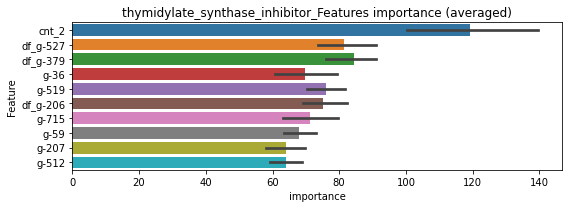

len(train_index) : 3895
len(valid_index) : 3896
================================= fold 1/2 thymidylate_synthase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0176679	valid_1's binary_logloss: 0.0320836
[200]	training's binary_logloss: 0.00246038	valid_1's binary_logloss: 0.0135366
[300]	training's binary_logloss: 0.000692688	valid_1's binary_logloss: 0.0107464
Early stopping, best iteration is:
[320]	training's binary_logloss: 0.000579669	valid_1's binary_logloss: 0.0105442


len(train_index) : 3896
len(valid_index) : 3895
================================= fold 2/2 thymidylate_synthase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.018705	valid_1's binary_logloss: 0.0306851
[200]	training's binary_logloss: 0.00282118	valid_1's binary_logloss: 0.00927802
[300]	training's binary_logloss: 0.00078969	valid_1's binary_logloss: 0.00552923
[400]	training's binary_logloss: 0.000380347	valid_1's binary_logloss: 0.0044016
[500]	training's binary_logloss: 0.000254399	valid_1's binary_logloss: 0.00392496
Early stopping, best iteration is:
[531]	training's binary_logloss: 0.000237977	valid_1's binary_logloss: 0.00388243


thymidylate_synthase_inhibitor logloss: 0.007213754852604494
tlr_agonist, len(trt): 30, len(othr): 3284, target_rate: 0.0012598 → Adj_target_rate: 0.0015127


neg labels: 3289 → selected neg labels: 3284


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0338679	valid_1's binary_logloss: 0.0526715
[200]	training's binary_logloss: 0.00484336	valid_1's binary_logloss: 0.0149371
[300]	training's binary_logloss: 0.00134601	valid_1's binary_logloss: 0.00797508
[400]	training's binary_logloss: 0.000667732	valid_1's binary_logloss: 0.00614905
[500]	training's binary_logloss: 0.000462638	valid_1's binary_logloss: 0.00532698
Early stopping, best iteration is:
[544]	training's binary_logloss: 0.000435436	valid_1's binary_logloss: 0.00523587
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0337553	valid_1's binary_logloss: 0.0489745
[200]	training's binary_logloss: 0.0050116	valid_1's binary_logloss: 0.0129841
[300]	training's binary_logloss: 0.0013784	valid_1's binary_logloss: 0.0061822
[400]	training's binary_logloss: 0.000682719	valid_1's binary_logloss: 0.00450337
[500]	training's binary_logloss: 0.000

1 / 3 AUC score:1.000
Threshold: 0.0025948, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → positive_corect_labels: 656/3808
p_label_rate: 0.0376695 Vs.target_rate: 0.00126, Num_p_label: 150.0, conf_0:0.00036, conf_1:0.00285
Num_p_label: 150.0, Expected: 5.0, Adj_threshold_1: 0.0025948
Num_p_label: 26.0, Expected: 5.0, Adj_threshold_2: 0.0075948
Num_p_label: 7.0, Expected: 5.0, Adj_threshold_3: 0.0125948
threshold: 0.0125948, positive p_label: 7.0/3982, p_label_rate: 0.0017579
positive y_label: 656.0/3808, y_label_rate: 0.1722689
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0324455	valid_1's binary_logloss: 0.0528034
[200]	training's binary_logloss: 0.00456458	valid_1's binary_logloss: 0.0163362
[300]	training's binary_logloss: 0.00128561	valid_1's binary_logloss: 0.00953395
[400]	training's binary_logloss: 0.000653425	valid_1's binary_logloss: 0.00764352
Early stopping, best iteration is:
[486]	training's binary_logloss: 0.000472223	valid_1's binary_logloss: 0.00690514
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0331314	valid_1's binary_logloss: 0.0477308
[200]	training's binary_logloss: 0.00493318	valid_1's binary_logloss: 0.0124168
[300]	training's binary_logloss: 0.00136642	valid_1's binary_logloss: 0.00592089
[400]	training's binary_logloss: 0.000677308	valid_1's binary_logloss: 0.00422886
[500]	training's binary_logloss: 0.000468693	valid_1's binary_logloss: 0.00360016
Early stopping, best iteration is:


2 / 3 AUC score:1.000
Threshold: 0.0125948, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 2 → positive_corect_labels: 656.0/3806
p_label_rate: 0.0077850 Vs.target_rate: 0.00126, Num_p_label: 31.0, conf_0:0.00044, conf_1:0.01385
Num_p_label: 31.0, Expected: 5.0, Adj_threshold_1: 0.0125948
Num_p_label: 18.0, Expected: 5.0, Adj_threshold_2: 0.0175948
Num_p_label: 11.0, Expected: 5.0, Adj_threshold_3: 0.0225948
Num_p_label: 6.0, Expected: 5.0, Adj_threshold_4: 0.0275948
threshold: 0.0275948, positive p_label: 6.0/3982, p_label_rate: 0.0015068
positive y_label: 656.0/3806, y_label_rate: 0.1723594
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0328668	valid_1's binary_logloss: 0.0544834
[200]	training's binary_logloss: 0.0046117	valid_1's binary_logloss: 0.0165295
[300]	training's binary_logloss: 0.0013071	valid_1's binary_logloss: 0.00969902
[400]	training's binary_logloss: 0.000659594	valid_1's binary_logloss: 0.00789991
[500]	training's binary_logloss: 0.000460794	valid_1's binary_logloss: 0.00701347
Early stopping, best iteration is:
[490]	training's binary_logloss: 0.000471628	valid_1's binary_logloss: 0.00698362
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.03256	valid_1's binary_logloss: 0.0476201
[200]	training's binary_logloss: 0.00478994	valid_1's binary_logloss: 0.0119427
[300]	training's binary_logloss: 0.00134956	valid_1's binary_logloss: 0.00546851
[400]	training's binary_logloss: 0.000675522	valid_1's binary_logloss: 0.00381914
[500]	training's binary_logloss: 0.0004

3 / 3 AUC score:1.000
Threshold: 0.0275948, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → positive_corect_labels: 656.0/3806
p_label_rate: 0.0022602 Vs.target_rate: 0.00126, Num_p_label: 9.0, conf_0:0.00043, conf_1:0.03035
threshold: 0.0275948, positive p_label: 9.0/3982, p_label_rate: 0.0022602
positive y_label: 665.0/7788, y_label_rate: 0.0853878


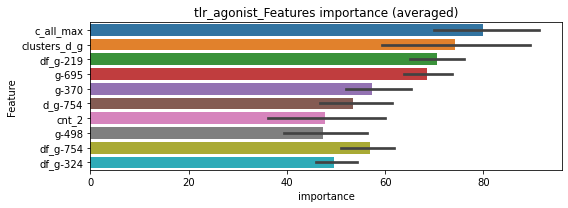

len(train_index) : 3894
len(valid_index) : 3894
================================= fold 1/2 tlr_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0184933	valid_1's binary_logloss: 0.0323559
[200]	training's binary_logloss: 0.00269884	valid_1's binary_logloss: 0.0137479
[300]	training's binary_logloss: 0.000732645	valid_1's binary_logloss: 0.0113453
Early stopping, best iteration is:
[331]	training's binary_logloss: 0.000556449	valid_1's binary_logloss: 0.0111927


len(train_index) : 3894
len(valid_index) : 3894
================================= fold 2/2 tlr_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0187277	valid_1's binary_logloss: 0.0282657
[200]	training's binary_logloss: 0.00280424	valid_1's binary_logloss: 0.00904799
[300]	training's binary_logloss: 0.000765828	valid_1's binary_logloss: 0.00624161
[400]	training's binary_logloss: 0.000370326	valid_1's binary_logloss: 0.00550481
Early stopping, best iteration is:
[433]	training's binary_logloss: 0.000314799	valid_1's binary_logloss: 0.00542629


tlr_agonist logloss: 0.008309494908218478
tlr_antagonist, len(trt): 7, len(othr): 3287, target_rate: 0.0002939 → Adj_target_rate: 0.0004391


neg labels: 3289 → selected neg labels: 3287


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.01609	valid_1's binary_logloss: 0.0176331
[200]	training's binary_logloss: 0.00141945	valid_1's binary_logloss: 0.0019356
[300]	training's binary_logloss: 0.00039611	valid_1's binary_logloss: 0.000646477
[400]	training's binary_logloss: 0.000239951	valid_1's binary_logloss: 0.000420629
Early stopping, best iteration is:
[485]	training's binary_logloss: 0.000214265	valid_1's binary_logloss: 0.000382565
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0163959	valid_1's binary_logloss: 0.0173767
[200]	training's binary_logloss: 0.00144085	valid_1's binary_logloss: 0.00168745
[300]	training's binary_logloss: 0.00040033	valid_1's binary_logloss: 0.000509479
[400]	training's binary_logloss: 0.000242369	valid_1's binary_logloss: 0.000309176
Early stopping, best iteration is:
[487]	training's binary_logloss: 0.000218111	valid_1's binary_logloss: 0.00027

1 / 3 AUC score:1.000
Threshold: 0.0007233, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → positive_corect_labels: 657/3812
p_label_rate: 0.0406831 Vs.target_rate: 0.00029, Num_p_label: 162.0, conf_0:0.00012, conf_1:0.00080
Num_p_label: 162.0, Expected: 1.2, Adj_threshold_1: 0.0007233
Num_p_label: 12.0, Expected: 1.2, Adj_threshold_2: 0.0057233
Num_p_label: 6.0, Expected: 1.2, Adj_threshold_3: 0.0107233
Num_p_label: 3.0, Expected: 1.2, Adj_threshold_4: 0.0157233
Num_p_label: 3.0, Expected: 1.2, Adj_threshold_5: 0.0207233
Num_p_label: 3.0, Expected: 1.2, Adj_threshold_6: 0.0257233
Num_p_label: 3.0, Expected: 1.2, Adj_threshold_7: 0.0307233
Num_p_label: 2.0, Expected: 1.2, Adj_threshold_8: 0.0357233
threshold: 0.0357233, positive p_label: 2.0/3982, p_label_rate: 0.0005023
positive y_label: 657.0/3812, y_label_rate: 0.1723505
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0163516	valid_1's binary_logloss: 0.0172249
[200]	training's binary_logloss: 0.00139138	valid_1's binary_logloss: 0.00167397
[300]	training's binary_logloss: 0.000382078	valid_1's binary_logloss: 0.000519892
[400]	training's binary_logloss: 0.00023699	valid_1's binary_logloss: 0.000344886
[500]	training's binary_logloss: 0.000207912	valid_1's binary_logloss: 0.000308649
Early stopping, best iteration is:
[516]	training's binary_logloss: 0.000206475	valid_1's binary_logloss: 0.000307243
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0164341	valid_1's binary_logloss: 0.017355
[200]	training's binary_logloss: 0.00139268	valid_1's binary_logloss: 0.0016057
[300]	training's binary_logloss: 0.000381907	valid_1's binary_logloss: 0.000472374
[400]	training's binary_logloss: 0.000237001	valid_1's binary_logloss: 0.000296528
[500]	training's binary_logl

2 / 3 AUC score:1.000
Threshold: 0.0357233, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → positive_corect_labels: 657.0/3812
p_label_rate: 0.0022602 Vs.target_rate: 0.00029, Num_p_label: 9.0, conf_0:0.00012, conf_1:0.03930
Num_p_label: 9.0, Expected: 1.2, Adj_threshold_1: 0.0357233
Num_p_label: 9.0, Expected: 1.2, Adj_threshold_2: 0.0407233
Num_p_label: 8.0, Expected: 1.2, Adj_threshold_3: 0.0457233
Num_p_label: 6.0, Expected: 1.2, Adj_threshold_4: 0.0507233
Num_p_label: 6.0, Expected: 1.2, Adj_threshold_5: 0.0557233
Num_p_label: 6.0, Expected: 1.2, Adj_threshold_6: 0.0607233
Num_p_label: 6.0, Expected: 1.2, Adj_threshold_7: 0.0657233
Num_p_label: 6.0, Expected: 1.2, Adj_threshold_8: 0.0707233
Num_p_label: 6.0, Expected: 1.2, Adj_threshold_9: 0.0757233
Num_p_label: 5.0, Expected: 1.2, Adj_threshold_10: 0.0807233
threshold: 0.0857233, positive p_label: 5.0/3982, p_label_rate: 0.0012557
positive y_label: 657.0/3812, y_label_rate: 0.1723505
================= Pseudo labeling 3 / 3 ====

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0163516	valid_1's binary_logloss: 0.0172249
[200]	training's binary_logloss: 0.00139138	valid_1's binary_logloss: 0.00167397
[300]	training's binary_logloss: 0.000382078	valid_1's binary_logloss: 0.000519892
[400]	training's binary_logloss: 0.00023699	valid_1's binary_logloss: 0.000344886
[500]	training's binary_logloss: 0.000207912	valid_1's binary_logloss: 0.000308649
Early stopping, best iteration is:
[516]	training's binary_logloss: 0.000206475	valid_1's binary_logloss: 0.000307243
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0164341	valid_1's binary_logloss: 0.017355
[200]	training's binary_logloss: 0.00139268	valid_1's binary_logloss: 0.0016057
[300]	training's binary_logloss: 0.000381907	valid_1's binary_logloss: 0.000472374
[400]	training's binary_logloss: 0.000237001	valid_1's binary_logloss: 0.000296528
[500]	training's binary_logl

3 / 3 AUC score:1.000
Threshold: 0.0857233, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → positive_corect_labels: 657.0/3812
p_label_rate: 0.0012557 Vs.target_rate: 0.00029, Num_p_label: 5.0, conf_0:0.00012, conf_1:0.09430
Num_p_label: 5.0, Expected: 1.2, Adj_threshold_1: 0.0857233
Num_p_label: 5.0, Expected: 1.2, Adj_threshold_2: 0.0907233
Num_p_label: 5.0, Expected: 1.2, Adj_threshold_3: 0.0957233
Num_p_label: 5.0, Expected: 1.2, Adj_threshold_4: 0.1007233
Num_p_label: 5.0, Expected: 1.2, Adj_threshold_5: 0.1057233
Num_p_label: 5.0, Expected: 1.2, Adj_threshold_6: 0.1107233
Num_p_label: 4.0, Expected: 1.2, Adj_threshold_7: 0.1157233
Num_p_label: 4.0, Expected: 1.2, Adj_threshold_8: 0.1207233
Num_p_label: 4.0, Expected: 1.2, Adj_threshold_9: 0.1257233
Num_p_label: 4.0, Expected: 1.2, Adj_threshold_10: 0.1307233
threshold: 0.1357233, positive p_label: 4.0/3982, p_label_rate: 0.0010045
positive y_label: 661.0/7794, y_label_rate: 0.0848088


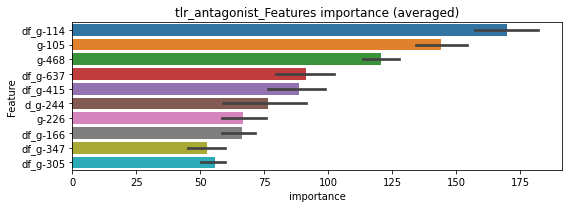

len(train_index) : 3897
len(valid_index) : 3897
================================= fold 1/2 tlr_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.00865748	valid_1's binary_logloss: 0.0130183
[200]	training's binary_logloss: 0.000727658	valid_1's binary_logloss: 0.0054532
Early stopping, best iteration is:
[264]	training's binary_logloss: 0.000277625	valid_1's binary_logloss: 0.00511869


len(train_index) : 3897
len(valid_index) : 3897
================================= fold 2/2 tlr_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.00887987	valid_1's binary_logloss: 0.0103758
[200]	training's binary_logloss: 0.000761785	valid_1's binary_logloss: 0.00196925
[300]	training's binary_logloss: 0.000207586	valid_1's binary_logloss: 0.00143702
Early stopping, best iteration is:
[326]	training's binary_logloss: 0.000172943	valid_1's binary_logloss: 0.00140918


tlr_antagonist logloss: 0.0032639337821322614
tnf_inhibitor, len(trt): 36, len(othr): 3283, target_rate: 0.0015117 → Adj_target_rate: 0.0017663


neg labels: 3289 → selected neg labels: 3283


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0336712	valid_1's binary_logloss: 0.0570198
[200]	training's binary_logloss: 0.00517264	valid_1's binary_logloss: 0.0208658
[300]	training's binary_logloss: 0.00150432	valid_1's binary_logloss: 0.0129816
[400]	training's binary_logloss: 0.000736167	valid_1's binary_logloss: 0.0103145
[500]	training's binary_logloss: 0.000500139	valid_1's binary_logloss: 0.00934093
Early stopping, best iteration is:
[545]	training's binary_logloss: 0.000466875	valid_1's binary_logloss: 0.00923475
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0378001	valid_1's binary_logloss: 0.0516988
[200]	training's binary_logloss: 0.00612174	valid_1's binary_logloss: 0.0133685
[300]	training's binary_logloss: 0.00171914	valid_1's binary_logloss: 0.00610005
[400]	training's binary_logloss: 0.000828904	valid_1's binary_logloss: 0.00434015
[500]	training's binary_logloss: 0.00

1 / 3 AUC score:1.000
Threshold: 0.0035284, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → positive_corect_labels: 656/3807
p_label_rate: 0.0431944 Vs.target_rate: 0.00151, Num_p_label: 172.0, conf_0:0.00039, conf_1:0.00388
Num_p_label: 172.0, Expected: 6.0, Adj_threshold_1: 0.0035284
Num_p_label: 64.0, Expected: 6.0, Adj_threshold_2: 0.0085284
Num_p_label: 27.0, Expected: 6.0, Adj_threshold_3: 0.0135284
Num_p_label: 15.0, Expected: 6.0, Adj_threshold_4: 0.0185284
Num_p_label: 11.0, Expected: 6.0, Adj_threshold_5: 0.0235284
threshold: 0.0235284, positive p_label: 11.0/3982, p_label_rate: 0.0027624
positive y_label: 656.0/3807, y_label_rate: 0.1723142
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0328587	valid_1's binary_logloss: 0.0556346
[200]	training's binary_logloss: 0.0051274	valid_1's binary_logloss: 0.0210127
[300]	training's binary_logloss: 0.0014619	valid_1's binary_logloss: 0.0141838
[400]	training's binary_logloss: 0.000730451	valid_1's binary_logloss: 0.011715
Early stopping, best iteration is:
[488]	training's binary_logloss: 0.000511212	valid_1's binary_logloss: 0.0106664
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0366487	valid_1's binary_logloss: 0.051418
[200]	training's binary_logloss: 0.00568496	valid_1's binary_logloss: 0.0126508
[300]	training's binary_logloss: 0.00162507	valid_1's binary_logloss: 0.00595615
[400]	training's binary_logloss: 0.000795552	valid_1's binary_logloss: 0.00410343
[500]	training's binary_logloss: 0.000530233	valid_1's binary_logloss: 0.00352676
Early stopping, best iteration is:
[574]	t

2 / 3 AUC score:1.000
Threshold: 0.0235284, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 1 → positive_corect_labels: 656.0/3806
p_label_rate: 0.0135610 Vs.target_rate: 0.00151, Num_p_label: 54.0, conf_0:0.00043, conf_1:0.02588
Num_p_label: 54.0, Expected: 6.0, Adj_threshold_1: 0.0235284
Num_p_label: 43.0, Expected: 6.0, Adj_threshold_2: 0.0285284
Num_p_label: 36.0, Expected: 6.0, Adj_threshold_3: 0.0335284
Num_p_label: 26.0, Expected: 6.0, Adj_threshold_4: 0.0385284
Num_p_label: 20.0, Expected: 6.0, Adj_threshold_5: 0.0435284
Num_p_label: 18.0, Expected: 6.0, Adj_threshold_6: 0.0485284
Num_p_label: 13.0, Expected: 6.0, Adj_threshold_7: 0.0535284
Num_p_label: 11.0, Expected: 6.0, Adj_threshold_8: 0.0585284
threshold: 0.0585284, positive p_label: 11.0/3982, p_label_rate: 0.0027624
positive y_label: 656.0/3806, y_label_rate: 0.1723594
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.033201	valid_1's binary_logloss: 0.0582699
[200]	training's binary_logloss: 0.00511494	valid_1's binary_logloss: 0.0223695
[300]	training's binary_logloss: 0.00146324	valid_1's binary_logloss: 0.0146909
[400]	training's binary_logloss: 0.000728923	valid_1's binary_logloss: 0.0118845
[500]	training's binary_logloss: 0.000493283	valid_1's binary_logloss: 0.0107374
Early stopping, best iteration is:
[575]	training's binary_logloss: 0.000453428	valid_1's binary_logloss: 0.01059
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0362886	valid_1's binary_logloss: 0.0505568
[200]	training's binary_logloss: 0.00559264	valid_1's binary_logloss: 0.0124282
[300]	training's binary_logloss: 0.00161321	valid_1's binary_logloss: 0.00567798
[400]	training's binary_logloss: 0.000795157	valid_1's binary_logloss: 0.00400564
[500]	training's binary_logloss: 0.0005241

3 / 3 AUC score:1.000
Threshold: 0.0585284, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → positive_corect_labels: 656.0/3806
p_label_rate: 0.0012557 Vs.target_rate: 0.00151, Num_p_label: 5.0, conf_0:0.00041, conf_1:0.06438
threshold: 0.0585284, positive p_label: 5.0/3982, p_label_rate: 0.0012557
positive y_label: 661.0/7788, y_label_rate: 0.0848742


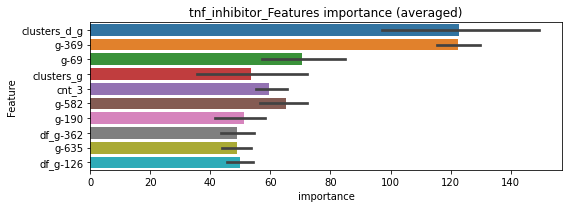

len(train_index) : 3894
len(valid_index) : 3894
================================= fold 1/2 tnf_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.019842	valid_1's binary_logloss: 0.0350332
[200]	training's binary_logloss: 0.00297378	valid_1's binary_logloss: 0.0129581
[300]	training's binary_logloss: 0.000806722	valid_1's binary_logloss: 0.00907333
Early stopping, best iteration is:
[355]	training's binary_logloss: 0.000514661	valid_1's binary_logloss: 0.00846687


len(train_index) : 3894
len(valid_index) : 3894
================================= fold 2/2 tnf_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0201408	valid_1's binary_logloss: 0.0312516
[200]	training's binary_logloss: 0.00310845	valid_1's binary_logloss: 0.0111643
[300]	training's binary_logloss: 0.000850353	valid_1's binary_logloss: 0.00730264
[400]	training's binary_logloss: 0.000408617	valid_1's binary_logloss: 0.00613272
[500]	training's binary_logloss: 0.000269774	valid_1's binary_logloss: 0.00560071
Early stopping, best iteration is:
[525]	training's binary_logloss: 0.000255741	valid_1's binary_logloss: 0.00551214


tnf_inhibitor logloss: 0.006989507211247068
topoisomerase_inhibitor, len(trt): 127, len(othr): 3271, target_rate: 0.0053330 → Adj_target_rate: 0.0051574


neg labels: 3289 → selected neg labels: 3271


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0401703	valid_1's binary_logloss: 0.0894324
[200]	training's binary_logloss: 0.00723574	valid_1's binary_logloss: 0.0559107
[300]	training's binary_logloss: 0.00217774	valid_1's binary_logloss: 0.0475748
Early stopping, best iteration is:
[305]	training's binary_logloss: 0.00207235	valid_1's binary_logloss: 0.0474514
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0365909	valid_1's binary_logloss: 0.091078


1 / 3 AUC score:0.994
Threshold: 0.0255527, pos_neg_ratio: 0.8000000


Early stopping, best iteration is:
[184]	training's binary_logloss: 0.0082207	valid_1's binary_logloss: 0.0754303


Remove_noisy_labels: 163 → positive_corect_labels: 638/3762
p_label_rate: 0.0678051 Vs.target_rate: 0.00533, Num_p_label: 270.0, conf_0:0.00267, conf_1:0.02811
Num_p_label: 270.0, Expected: 21.2, Adj_threshold_1: 0.0255527
Num_p_label: 258.0, Expected: 21.2, Adj_threshold_2: 0.0305527
Num_p_label: 241.0, Expected: 21.2, Adj_threshold_3: 0.0355527
Num_p_label: 234.0, Expected: 21.2, Adj_threshold_4: 0.0405527
Num_p_label: 221.0, Expected: 21.2, Adj_threshold_5: 0.0455527
Num_p_label: 214.0, Expected: 21.2, Adj_threshold_6: 0.0505527
Num_p_label: 205.0, Expected: 21.2, Adj_threshold_7: 0.0555527
Num_p_label: 197.0, Expected: 21.2, Adj_threshold_8: 0.0605527
Num_p_label: 195.0, Expected: 21.2, Adj_threshold_9: 0.0655527
Num_p_label: 187.0, Expected: 21.2, Adj_threshold_10: 0.0705527
threshold: 0.0755527, positive p_label: 183.0/3982, p_label_rate: 0.0459568
positive y_label: 638.0/3762, y_label_rate: 0.1695906
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0293191	valid_1's binary_logloss: 0.062493
[200]	training's binary_logloss: 0.00452786	valid_1's binary_logloss: 0.038613
Early stopping, best iteration is:
[285]	training's binary_logloss: 0.00139359	valid_1's binary_logloss: 0.0355474
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0293102	valid_1's binary_logloss: 0.0670436
[200]	training's binary_logloss: 0.00426469	valid_1's binary_logloss: 0.0407865


2 / 3 AUC score:0.998
Threshold: 0.0755527, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 40 → positive_corect_labels: 618.0/3722


Early stopping, best iteration is:
[246]	training's binary_logloss: 0.00222784	valid_1's binary_logloss: 0.0376571


p_label_rate: 0.0662983 Vs.target_rate: 0.00533, Num_p_label: 264.0, conf_0:0.00113, conf_1:0.08311
Num_p_label: 264.0, Expected: 21.2, Adj_threshold_1: 0.0755527
Num_p_label: 263.0, Expected: 21.2, Adj_threshold_2: 0.0805527
Num_p_label: 261.0, Expected: 21.2, Adj_threshold_3: 0.0855527
Num_p_label: 259.0, Expected: 21.2, Adj_threshold_4: 0.0905527
Num_p_label: 257.0, Expected: 21.2, Adj_threshold_5: 0.0955527
Num_p_label: 257.0, Expected: 21.2, Adj_threshold_6: 0.1005527
Num_p_label: 253.0, Expected: 21.2, Adj_threshold_7: 0.1055527
Num_p_label: 250.0, Expected: 21.2, Adj_threshold_8: 0.1105527
Num_p_label: 250.0, Expected: 21.2, Adj_threshold_9: 0.1155527
Num_p_label: 249.0, Expected: 21.2, Adj_threshold_10: 0.1205527
threshold: 0.1255527, positive p_label: 246.0/3982, p_label_rate: 0.0617780
positive y_label: 618.0/3722, y_label_rate: 0.1660398
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0266978	valid_1's binary_logloss: 0.0629897
[200]	training's binary_logloss: 0.00332715	valid_1's binary_logloss: 0.0410345
Early stopping, best iteration is:
[230]	training's binary_logloss: 0.00208903	valid_1's binary_logloss: 0.0400546
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0270121	valid_1's binary_logloss: 0.0416728
[200]	training's binary_logloss: 0.00359012	valid_1's binary_logloss: 0.014701
[300]	training's binary_logloss: 0.00103652	valid_1's binary_logloss: 0.0106643
Early stopping, best iteration is:
[300]	training's binary_logloss: 0.00103652	valid_1's binary_logloss: 0.0106643


3 / 3 AUC score:0.999
Threshold: 0.1255527, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 20 → positive_corect_labels: 605.0/3702
p_label_rate: 0.0655450 Vs.target_rate: 0.00533, Num_p_label: 261.0, conf_0:0.00090, conf_1:0.13811
Num_p_label: 261.0, Expected: 21.2, Adj_threshold_1: 0.1255527
Num_p_label: 258.0, Expected: 21.2, Adj_threshold_2: 0.1305527
Num_p_label: 257.0, Expected: 21.2, Adj_threshold_3: 0.1355527
Num_p_label: 256.0, Expected: 21.2, Adj_threshold_4: 0.1405527
Num_p_label: 256.0, Expected: 21.2, Adj_threshold_5: 0.1455527
Num_p_label: 255.0, Expected: 21.2, Adj_threshold_6: 0.1505527
Num_p_label: 253.0, Expected: 21.2, Adj_threshold_7: 0.1555527
Num_p_label: 251.0, Expected: 21.2, Adj_threshold_8: 0.1605527
Num_p_label: 248.0, Expected: 21.2, Adj_threshold_9: 0.1655527
Num_p_label: 245.0, Expected: 21.2, Adj_threshold_10: 0.1705527
threshold: 0.1755527, positive p_label: 244.0/3982, p_label_rate: 0.0612757
positive y_label: 849.0/7684, y_label_rate: 0.1104893


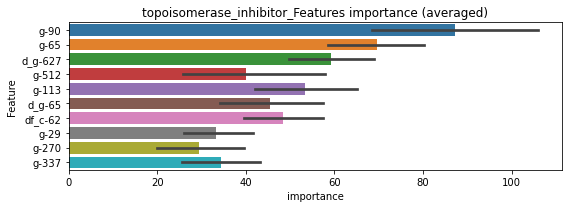

len(train_index) : 3842
len(valid_index) : 3842
================================= fold 1/2 topoisomerase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0194086	valid_1's binary_logloss: 0.0451707
[200]	training's binary_logloss: 0.00270359	valid_1's binary_logloss: 0.026982
[300]	training's binary_logloss: 0.000740141	valid_1's binary_logloss: 0.0233108
Early stopping, best iteration is:
[344]	training's binary_logloss: 0.000513048	valid_1's binary_logloss: 0.0229067


len(train_index) : 3842
len(valid_index) : 3842
================================= fold 2/2 topoisomerase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0200843	valid_1's binary_logloss: 0.0371196
[200]	training's binary_logloss: 0.00285653	valid_1's binary_logloss: 0.0179938
[300]	training's binary_logloss: 0.000803877	valid_1's binary_logloss: 0.0145214
Early stopping, best iteration is:
[351]	training's binary_logloss: 0.00053155	valid_1's binary_logloss: 0.0137588


topoisomerase_inhibitor logloss: 0.018332752203742628
transient_receptor_potential_channel_antagonist, len(trt): 18, len(othr): 3286, target_rate: 0.0007559 → Adj_target_rate: 0.0009799


neg labels: 3289 → selected neg labels: 3286


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0265235	valid_1's binary_logloss: 0.0352792
[200]	training's binary_logloss: 0.00308115	valid_1's binary_logloss: 0.00636244
[300]	training's binary_logloss: 0.000858216	valid_1's binary_logloss: 0.00280076
[400]	training's binary_logloss: 0.000451181	valid_1's binary_logloss: 0.00197706
[500]	training's binary_logloss: 0.000356442	valid_1's binary_logloss: 0.00175785
Early stopping, best iteration is:
[500]	training's binary_logloss: 0.000356442	valid_1's binary_logloss: 0.00175785
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0252828	valid_1's binary_logloss: 0.0318095
[200]	training's binary_logloss: 0.00309202	valid_1's binary_logloss: 0.00503736
[300]	training's binary_logloss: 0.000866287	valid_1's binary_logloss: 0.00175642
[400]	training's binary_logloss: 0.000453651	valid_1's binary_logloss: 0.00103924
[500]	training's binary_logloss

1 / 3 AUC score:1.000
Threshold: 0.0016054, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → positive_corect_labels: 657/3811
p_label_rate: 0.0328980 Vs.target_rate: 0.00076, Num_p_label: 131.0, conf_0:0.00024, conf_1:0.00177
Num_p_label: 131.0, Expected: 3.0, Adj_threshold_1: 0.0016054
Num_p_label: 14.0, Expected: 3.0, Adj_threshold_2: 0.0066054
Num_p_label: 6.0, Expected: 3.0, Adj_threshold_3: 0.0116054
threshold: 0.0116054, positive p_label: 6.0/3982, p_label_rate: 0.0015068
positive y_label: 657.0/3811, y_label_rate: 0.1723957
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.025322	valid_1's binary_logloss: 0.0323351
[200]	training's binary_logloss: 0.00296905	valid_1's binary_logloss: 0.00584305
[300]	training's binary_logloss: 0.000840526	valid_1's binary_logloss: 0.00264497
[400]	training's binary_logloss: 0.000444418	valid_1's binary_logloss: 0.00186598
[500]	training's binary_logloss: 0.000354331	valid_1's binary_logloss: 0.00167307
Early stopping, best iteration is:
[497]	training's binary_logloss: 0.000355209	valid_1's binary_logloss: 0.00167053
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0250615	valid_1's binary_logloss: 0.0306126
[200]	training's binary_logloss: 0.00300951	valid_1's binary_logloss: 0.00468242
[300]	training's binary_logloss: 0.000849799	valid_1's binary_logloss: 0.00159939
[400]	training's binary_logloss: 0.000445498	valid_1's binary_logloss: 0.000914217
[500]	training's binary_logloss

2 / 3 AUC score:1.000
Threshold: 0.0116054, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 1 → positive_corect_labels: 657.0/3810
p_label_rate: 0.0042692 Vs.target_rate: 0.00076, Num_p_label: 17.0, conf_0:0.00027, conf_1:0.01277
Num_p_label: 17.0, Expected: 3.0, Adj_threshold_1: 0.0116054
Num_p_label: 11.0, Expected: 3.0, Adj_threshold_2: 0.0166054
Num_p_label: 10.0, Expected: 3.0, Adj_threshold_3: 0.0216054
Num_p_label: 8.0, Expected: 3.0, Adj_threshold_4: 0.0266054
Num_p_label: 6.0, Expected: 3.0, Adj_threshold_5: 0.0316054
threshold: 0.0316054, positive p_label: 6.0/3982, p_label_rate: 0.0015068
positive y_label: 657.0/3810, y_label_rate: 0.1724409
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0253439	valid_1's binary_logloss: 0.0318656
[200]	training's binary_logloss: 0.00296725	valid_1's binary_logloss: 0.0054694
[300]	training's binary_logloss: 0.000841365	valid_1's binary_logloss: 0.00231596
[400]	training's binary_logloss: 0.000445027	valid_1's binary_logloss: 0.00157492
[500]	training's binary_logloss: 0.000351748	valid_1's binary_logloss: 0.00137085
Early stopping, best iteration is:
[513]	training's binary_logloss: 0.000350323	valid_1's binary_logloss: 0.00136749
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0250306	valid_1's binary_logloss: 0.031384
[200]	training's binary_logloss: 0.00305166	valid_1's binary_logloss: 0.00523027
[300]	training's binary_logloss: 0.00085355	valid_1's binary_logloss: 0.00181818
[400]	training's binary_logloss: 0.000449048	valid_1's binary_logloss: 0.00105594
[500]	training's binary_logloss: 0

3 / 3 AUC score:1.000
Threshold: 0.0316054, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → positive_corect_labels: 657.0/3810
p_label_rate: 0.0015068 Vs.target_rate: 0.00076, Num_p_label: 6.0, conf_0:0.00027, conf_1:0.03477
threshold: 0.0316054, positive p_label: 6.0/3982, p_label_rate: 0.0015068
positive y_label: 663.0/7792, y_label_rate: 0.0850873


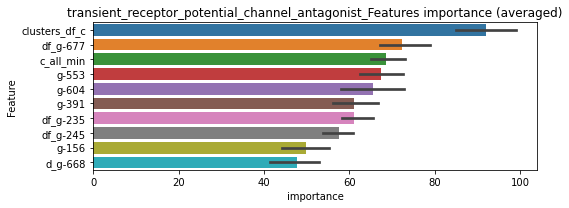

len(train_index) : 3896
len(valid_index) : 3896
================================= fold 1/2 transient_receptor_potential_channel_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.014056	valid_1's binary_logloss: 0.0208117
[200]	training's binary_logloss: 0.00166384	valid_1's binary_logloss: 0.00708375
[300]	training's binary_logloss: 0.000443398	valid_1's binary_logloss: 0.0060155
Early stopping, best iteration is:
[294]	training's binary_logloss: 0.000467779	valid_1's binary_logloss: 0.00599364


len(train_index) : 3896
len(valid_index) : 3896
================================= fold 2/2 transient_receptor_potential_channel_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0138706	valid_1's binary_logloss: 0.0184818
[200]	training's binary_logloss: 0.00170275	valid_1's binary_logloss: 0.0045754
[300]	training's binary_logloss: 0.000463512	valid_1's binary_logloss: 0.00304831
[400]	training's binary_logloss: 0.000236771	valid_1's binary_logloss: 0.0027884
Early stopping, best iteration is:
[450]	training's binary_logloss: 0.000196745	valid_1's binary_logloss: 0.00272565


transient_receptor_potential_channel_antagonist logloss: 0.004359645634734899
tropomyosin_receptor_kinase_inhibitor, len(trt): 6, len(othr): 3288, target_rate: 0.0002520 → Adj_target_rate: 0.0003851


neg labels: 3289 → selected neg labels: 3288


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0162495	valid_1's binary_logloss: 0.0176016
[200]	training's binary_logloss: 0.00137061	valid_1's binary_logloss: 0.00224812
[300]	training's binary_logloss: 0.000362834	valid_1's binary_logloss: 0.00101987
[400]	training's binary_logloss: 0.00021965	valid_1's binary_logloss: 0.000783681
[500]	training's binary_logloss: 0.000199011	valid_1's binary_logloss: 0.000747858
Early stopping, best iteration is:
[491]	training's binary_logloss: 0.00019903	valid_1's binary_logloss: 0.000747785
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0165531	valid_1's binary_logloss: 0.0177847
[200]	training's binary_logloss: 0.00139086	valid_1's binary_logloss: 0.00184416
[300]	training's binary_logloss: 0.000366934	valid_1's binary_logloss: 0.000583526
[400]	training's binary_logloss: 0.000220396	valid_1's binary_logloss: 0.000378594
[500]	training's binary_logl

1 / 3 AUC score:1.000
Threshold: 0.0005179, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → positive_corect_labels: 657/3813
p_label_rate: 0.0472125 Vs.target_rate: 0.00025, Num_p_label: 188.0, conf_0:0.00012, conf_1:0.00057
Num_p_label: 188.0, Expected: 1.0, Adj_threshold_1: 0.0005179
Num_p_label: 6.0, Expected: 1.0, Adj_threshold_2: 0.0055179
Num_p_label: 3.0, Expected: 1.0, Adj_threshold_3: 0.0105179
Num_p_label: 2.0, Expected: 1.0, Adj_threshold_4: 0.0155179
threshold: 0.0155179, positive p_label: 2.0/3982, p_label_rate: 0.0005023
positive y_label: 657.0/3813, y_label_rate: 0.1723053
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0165681	valid_1's binary_logloss: 0.017645
[200]	training's binary_logloss: 0.00134719	valid_1's binary_logloss: 0.00167309
[300]	training's binary_logloss: 0.000354353	valid_1's binary_logloss: 0.000548277
[400]	training's binary_logloss: 0.000217632	valid_1's binary_logloss: 0.00036598
[500]	training's binary_logloss: 0.000191839	valid_1's binary_logloss: 0.000330775
Early stopping, best iteration is:
[509]	training's binary_logloss: 0.000190956	valid_1's binary_logloss: 0.000329415
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0167643	valid_1's binary_logloss: 0.017685
[200]	training's binary_logloss: 0.00137891	valid_1's binary_logloss: 0.00170574
[300]	training's binary_logloss: 0.000359391	valid_1's binary_logloss: 0.000513746
[400]	training's binary_logloss: 0.000220401	valid_1's binary_logloss: 0.000349101
Early stopping, best iterati

2 / 3 AUC score:1.000
Threshold: 0.0155179, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → positive_corect_labels: 657.0/3813
p_label_rate: 0.0022602 Vs.target_rate: 0.00025, Num_p_label: 9.0, conf_0:0.00013, conf_1:0.01707
Num_p_label: 9.0, Expected: 1.0, Adj_threshold_1: 0.0155179
Num_p_label: 7.0, Expected: 1.0, Adj_threshold_2: 0.0205179
Num_p_label: 5.0, Expected: 1.0, Adj_threshold_3: 0.0255179
Num_p_label: 4.0, Expected: 1.0, Adj_threshold_4: 0.0305179
Num_p_label: 4.0, Expected: 1.0, Adj_threshold_5: 0.0355179
Num_p_label: 3.0, Expected: 1.0, Adj_threshold_6: 0.0405179
Num_p_label: 3.0, Expected: 1.0, Adj_threshold_7: 0.0455179
Num_p_label: 3.0, Expected: 1.0, Adj_threshold_8: 0.0505179
Num_p_label: 2.0, Expected: 1.0, Adj_threshold_9: 0.0555179
threshold: 0.0555179, positive p_label: 2.0/3982, p_label_rate: 0.0005023
positive y_label: 657.0/3813, y_label_rate: 0.1723053
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0165681	valid_1's binary_logloss: 0.017645
[200]	training's binary_logloss: 0.00134719	valid_1's binary_logloss: 0.00167309
[300]	training's binary_logloss: 0.000354353	valid_1's binary_logloss: 0.000548277
[400]	training's binary_logloss: 0.000217632	valid_1's binary_logloss: 0.00036598
[500]	training's binary_logloss: 0.000191839	valid_1's binary_logloss: 0.000330775
Early stopping, best iteration is:
[509]	training's binary_logloss: 0.000190956	valid_1's binary_logloss: 0.000329415
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0167643	valid_1's binary_logloss: 0.017685
[200]	training's binary_logloss: 0.00137891	valid_1's binary_logloss: 0.00170574
[300]	training's binary_logloss: 0.000359391	valid_1's binary_logloss: 0.000513746
[400]	training's binary_logloss: 0.000220401	valid_1's binary_logloss: 0.000349101


3 / 3 AUC score:1.000
Threshold: 0.0555179, pos_neg_ratio: 0.8000000


Early stopping, best iteration is:
[474]	training's binary_logloss: 0.000198905	valid_1's binary_logloss: 0.000322953


Remove_noisy_labels: 0 → positive_corect_labels: 657.0/3813
p_label_rate: 0.0005023 Vs.target_rate: 0.00025, Num_p_label: 2.0, conf_0:0.00013, conf_1:0.06107
threshold: 0.0555179, positive p_label: 2.0/3982, p_label_rate: 0.0005023
positive y_label: 659.0/7795, y_label_rate: 0.0845414


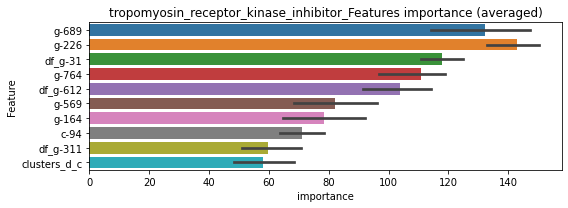

len(train_index) : 3897
len(valid_index) : 3898
================================= fold 1/2 tropomyosin_receptor_kinase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.00877651	valid_1's binary_logloss: 0.0116834
[200]	training's binary_logloss: 0.000711533	valid_1's binary_logloss: 0.00313951
[300]	training's binary_logloss: 0.000183609	valid_1's binary_logloss: 0.00255955
Early stopping, best iteration is:
[358]	training's binary_logloss: 0.000127896	valid_1's binary_logloss: 0.00247384


len(train_index) : 3898
len(valid_index) : 3897
================================= fold 2/2 tropomyosin_receptor_kinase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0088383	valid_1's binary_logloss: 0.00990341
[200]	training's binary_logloss: 0.0007178	valid_1's binary_logloss: 0.00156223
[300]	training's binary_logloss: 0.000188387	valid_1's binary_logloss: 0.000767838
[400]	training's binary_logloss: 0.000112229	valid_1's binary_logloss: 0.000607339
Early stopping, best iteration is:
[460]	training's binary_logloss: 0.000101027	valid_1's binary_logloss: 0.000588607


tropomyosin_receptor_kinase_inhibitor logloss: 0.00153134684194364
trpv_agonist, len(trt): 25, len(othr): 3285, target_rate: 0.0010498 → Adj_target_rate: 0.0012955


neg labels: 3289 → selected neg labels: 3285


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0253105	valid_1's binary_logloss: 0.0431407
[200]	training's binary_logloss: 0.00318509	valid_1's binary_logloss: 0.0128428
[300]	training's binary_logloss: 0.000911862	valid_1's binary_logloss: 0.00827516
Early stopping, best iteration is:
[301]	training's binary_logloss: 0.000903647	valid_1's binary_logloss: 0.00825606
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0250482	valid_1's binary_logloss: 0.0344792
[200]	training's binary_logloss: 0.00315848	valid_1's binary_logloss: 0.00681743
[300]	training's binary_logloss: 0.00092615	valid_1's binary_logloss: 0.00313127
[400]	training's binary_logloss: 0.000486384	valid_1's binary_logloss: 0.00216444
[500]	training's binary_logloss: 0.00036406	valid_1's binary_logloss: 0.00185222
Early stopping, best iteration is:
[515]	training's binary_logloss: 0.000359256	valid_1's binary_logloss: 0.00184102

1 / 3 AUC score:1.000
Threshold: 0.0037193, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → positive_corect_labels: 657/3810
p_label_rate: 0.0464591 Vs.target_rate: 0.00105, Num_p_label: 185.0, conf_0:0.00043, conf_1:0.00409
Num_p_label: 185.0, Expected: 4.2, Adj_threshold_1: 0.0037193
Num_p_label: 75.0, Expected: 4.2, Adj_threshold_2: 0.0087193
Num_p_label: 57.0, Expected: 4.2, Adj_threshold_3: 0.0137193
Num_p_label: 50.0, Expected: 4.2, Adj_threshold_4: 0.0187193
Num_p_label: 40.0, Expected: 4.2, Adj_threshold_5: 0.0237193
Num_p_label: 37.0, Expected: 4.2, Adj_threshold_6: 0.0287193
Num_p_label: 29.0, Expected: 4.2, Adj_threshold_7: 0.0337193
Num_p_label: 27.0, Expected: 4.2, Adj_threshold_8: 0.0387193
Num_p_label: 25.0, Expected: 4.2, Adj_threshold_9: 0.0437193
Num_p_label: 22.0, Expected: 4.2, Adj_threshold_10: 0.0487193
threshold: 0.0537193, positive p_label: 21.0/3982, p_label_rate: 0.0052737
positive y_label: 657.0/3810, y_label_rate: 0.1724409
================= Pseudo label

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0245568	valid_1's binary_logloss: 0.0408589
[200]	training's binary_logloss: 0.00288348	valid_1's binary_logloss: 0.0104044
[300]	training's binary_logloss: 0.000831023	valid_1's binary_logloss: 0.0057902
Early stopping, best iteration is:
[368]	training's binary_logloss: 0.000521806	valid_1's binary_logloss: 0.00509776
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0245921	valid_1's binary_logloss: 0.0343497
[200]	training's binary_logloss: 0.00295353	valid_1's binary_logloss: 0.00608798
[300]	training's binary_logloss: 0.000850318	valid_1's binary_logloss: 0.00240913
[400]	training's binary_logloss: 0.00045857	valid_1's binary_logloss: 0.00159848
[500]	training's binary_logloss: 0.000351353	valid_1's binary_logloss: 0.00133369
Early stopping, best iteration is:
[567]	training's binary_logloss: 0.000339551	valid_1's binary_logloss: 0.00130821

2 / 3 AUC score:1.000
Threshold: 0.0537193, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 1 → positive_corect_labels: 657.0/3809
p_label_rate: 0.0148167 Vs.target_rate: 0.00105, Num_p_label: 59.0, conf_0:0.00033, conf_1:0.05909
Num_p_label: 59.0, Expected: 4.2, Adj_threshold_1: 0.0537193
Num_p_label: 57.0, Expected: 4.2, Adj_threshold_2: 0.0587193
Num_p_label: 57.0, Expected: 4.2, Adj_threshold_3: 0.0637193
Num_p_label: 57.0, Expected: 4.2, Adj_threshold_4: 0.0687193
Num_p_label: 54.0, Expected: 4.2, Adj_threshold_5: 0.0737193
Num_p_label: 52.0, Expected: 4.2, Adj_threshold_6: 0.0787193
Num_p_label: 50.0, Expected: 4.2, Adj_threshold_7: 0.0837193
Num_p_label: 50.0, Expected: 4.2, Adj_threshold_8: 0.0887193
Num_p_label: 47.0, Expected: 4.2, Adj_threshold_9: 0.0937193
Num_p_label: 45.0, Expected: 4.2, Adj_threshold_10: 0.0987193
threshold: 0.1037193, positive p_label: 43.0/3982, p_label_rate: 0.0107986
positive y_label: 657.0/3809, y_label_rate: 0.1724862
================= Pseudo labelin

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.024141	valid_1's binary_logloss: 0.0424084
[200]	training's binary_logloss: 0.00289426	valid_1's binary_logloss: 0.0122385
[300]	training's binary_logloss: 0.000832866	valid_1's binary_logloss: 0.00833294
Early stopping, best iteration is:
[303]	training's binary_logloss: 0.000811847	valid_1's binary_logloss: 0.00828379
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0244747	valid_1's binary_logloss: 0.0337669
[200]	training's binary_logloss: 0.00294911	valid_1's binary_logloss: 0.00599965
[300]	training's binary_logloss: 0.000843716	valid_1's binary_logloss: 0.00243295
[400]	training's binary_logloss: 0.000458243	valid_1's binary_logloss: 0.00160279
[500]	training's binary_logloss: 0.000354205	valid_1's binary_logloss: 0.0013308
Early stopping, best iteration is:
[584]	training's binary_logloss: 0.000338495	valid_1's binary_logloss: 0.00129036

3 / 3 AUC score:1.000
Threshold: 0.1037193, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 1 → positive_corect_labels: 656.0/3808
p_label_rate: 0.0113009 Vs.target_rate: 0.00105, Num_p_label: 45.0, conf_0:0.00045, conf_1:0.11409
Num_p_label: 45.0, Expected: 4.2, Adj_threshold_1: 0.1037193
Num_p_label: 45.0, Expected: 4.2, Adj_threshold_2: 0.1087193
Num_p_label: 44.0, Expected: 4.2, Adj_threshold_3: 0.1137193
Num_p_label: 44.0, Expected: 4.2, Adj_threshold_4: 0.1187193
Num_p_label: 44.0, Expected: 4.2, Adj_threshold_5: 0.1237193
Num_p_label: 44.0, Expected: 4.2, Adj_threshold_6: 0.1287193
Num_p_label: 42.0, Expected: 4.2, Adj_threshold_7: 0.1337193
Num_p_label: 42.0, Expected: 4.2, Adj_threshold_8: 0.1387193
Num_p_label: 42.0, Expected: 4.2, Adj_threshold_9: 0.1437193
Num_p_label: 41.0, Expected: 4.2, Adj_threshold_10: 0.1487193
threshold: 0.1537193, positive p_label: 40.0/3982, p_label_rate: 0.0100452
positive y_label: 696.0/7790, y_label_rate: 0.0893453


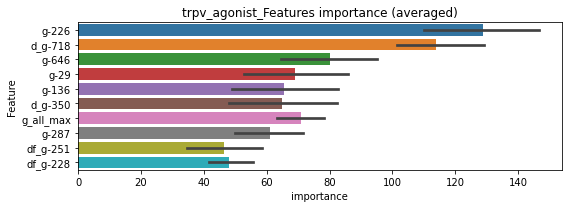

len(train_index) : 3895
len(valid_index) : 3895
================================= fold 1/2 trpv_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0142405	valid_1's binary_logloss: 0.0245398
[200]	training's binary_logloss: 0.00181914	valid_1's binary_logloss: 0.0101569
Early stopping, best iteration is:
[289]	training's binary_logloss: 0.00058341	valid_1's binary_logloss: 0.00808308


len(train_index) : 3895
len(valid_index) : 3895
================================= fold 2/2 trpv_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0142518	valid_1's binary_logloss: 0.0288619
[200]	training's binary_logloss: 0.00179679	valid_1's binary_logloss: 0.0130059
Early stopping, best iteration is:
[242]	training's binary_logloss: 0.00096802	valid_1's binary_logloss: 0.0117181


trpv_agonist logloss: 0.009900586817167744
trpv_antagonist, len(trt): 48, len(othr): 3281, target_rate: 0.0020156 → Adj_target_rate: 0.0022556


neg labels: 3289 → selected neg labels: 3281


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0423575	valid_1's binary_logloss: 0.090817
[200]	training's binary_logloss: 0.00794611	valid_1's binary_logloss: 0.0529131
Early stopping, best iteration is:
[285]	training's binary_logloss: 0.00271084	valid_1's binary_logloss: 0.0456407
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.046561	valid_1's binary_logloss: 0.075496
[200]	training's binary_logloss: 0.00884347	valid_1's binary_logloss: 0.0246591
[300]	training's binary_logloss: 0.00253488	valid_1's binary_logloss: 0.0123766
[400]	training's binary_logloss: 0.00117468	valid_1's binary_logloss: 0.00907861
[500]	training's binary_logloss: 0.000740438	valid_1's binary_logloss: 0.00791584
[600]	training's binary_logloss: 0.000577645	valid_1's binary_logloss: 0.00743475
Early stopping, best iteration is:
[593]	training's binary_logloss: 0.000584971	valid_1's binary_logloss: 0.00740523


1 / 3 AUC score:0.999
Threshold: 0.0089381, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 138 → positive_corect_labels: 653/3799
p_label_rate: 0.0331492 Vs.target_rate: 0.00202, Num_p_label: 132.0, conf_0:0.00165, conf_1:0.00983
Num_p_label: 132.0, Expected: 8.0, Adj_threshold_1: 0.0089381
Num_p_label: 63.0, Expected: 8.0, Adj_threshold_2: 0.0139381
Num_p_label: 35.0, Expected: 8.0, Adj_threshold_3: 0.0189381
Num_p_label: 17.0, Expected: 8.0, Adj_threshold_4: 0.0239381
Num_p_label: 10.0, Expected: 8.0, Adj_threshold_5: 0.0289381
threshold: 0.0289381, positive p_label: 10.0/3982, p_label_rate: 0.0025113
positive y_label: 653.0/3799, y_label_rate: 0.1718873
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0422918	valid_1's binary_logloss: 0.0768106
[200]	training's binary_logloss: 0.00774722	valid_1's binary_logloss: 0.0358532
[300]	training's binary_logloss: 0.00228191	valid_1's binary_logloss: 0.0271138
[400]	training's binary_logloss: 0.00108671	valid_1's binary_logloss: 0.024247
Early stopping, best iteration is:
[479]	training's binary_logloss: 0.000749003	valid_1's binary_logloss: 0.0231001
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0442086	valid_1's binary_logloss: 0.0763918
[200]	training's binary_logloss: 0.00825856	valid_1's binary_logloss: 0.0304857
[300]	training's binary_logloss: 0.0024132	valid_1's binary_logloss: 0.0192559
[400]	training's binary_logloss: 0.00114194	valid_1's binary_logloss: 0.016326
Early stopping, best iteration is:
[487]	training's binary_logloss: 0.000756421	valid_1's binary_logloss: 0.0146242


2 / 3 AUC score:1.000
Threshold: 0.0289381, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 5 → positive_corect_labels: 652.0/3794
p_label_rate: 0.0035158 Vs.target_rate: 0.00202, Num_p_label: 14.0, conf_0:0.00091, conf_1:0.03183
threshold: 0.0289381, positive p_label: 14.0/3982, p_label_rate: 0.0035158
positive y_label: 652.0/3794, y_label_rate: 0.1718503
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0439372	valid_1's binary_logloss: 0.0769934
[200]	training's binary_logloss: 0.00817474	valid_1's binary_logloss: 0.0344681
[300]	training's binary_logloss: 0.00237304	valid_1's binary_logloss: 0.0251272
[400]	training's binary_logloss: 0.00110061	valid_1's binary_logloss: 0.021504
Early stopping, best iteration is:
[464]	training's binary_logloss: 0.000801688	valid_1's binary_logloss: 0.020381
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0460081	valid_1's binary_logloss: 0.0766308
[200]	training's binary_logloss: 0.00859983	valid_1's binary_logloss: 0.029774
[300]	training's binary_logloss: 0.0024661	valid_1's binary_logloss: 0.0177308
[400]	training's binary_logloss: 0.00115551	valid_1's binary_logloss: 0.0142654
[500]	training's binary_logloss: 0.000733371	valid_1's binary_logloss: 0.0125773
Early stopping, best iteration is:
[511]	traini

3 / 3 AUC score:1.000
Threshold: 0.0289381, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 7 → positive_corect_labels: 647.0/3787
p_label_rate: 0.0042692 Vs.target_rate: 0.00202, Num_p_label: 17.0, conf_0:0.00090, conf_1:0.03183
threshold: 0.0289381, positive p_label: 17.0/3982, p_label_rate: 0.0042692
positive y_label: 664.0/7769, y_label_rate: 0.0854679


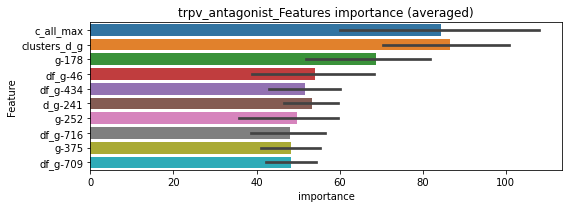

len(train_index) : 3884
len(valid_index) : 3885
================================= fold 1/2 trpv_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0252628	valid_1's binary_logloss: 0.0484637
[200]	training's binary_logloss: 0.00449311	valid_1's binary_logloss: 0.0268694
[300]	training's binary_logloss: 0.00124984	valid_1's binary_logloss: 0.0235616
Early stopping, best iteration is:
[331]	training's binary_logloss: 0.000937759	valid_1's binary_logloss: 0.0231601


len(train_index) : 3885
len(valid_index) : 3884
================================= fold 2/2 trpv_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0260502	valid_1's binary_logloss: 0.0417957
[200]	training's binary_logloss: 0.00507264	valid_1's binary_logloss: 0.0176275
[300]	training's binary_logloss: 0.00146373	valid_1's binary_logloss: 0.0122389
[400]	training's binary_logloss: 0.000665319	valid_1's binary_logloss: 0.0106805
Early stopping, best iteration is:
[445]	training's binary_logloss: 0.000519107	valid_1's binary_logloss: 0.0103542


trpv_antagonist logloss: 0.01675801037615166
tubulin_inhibitor, len(trt): 316, len(othr): 3267, target_rate: 0.0132695 → Adj_target_rate: 0.0111926


neg labels: 3289 → selected neg labels: 3267


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0408275	valid_1's binary_logloss: 0.125778
[200]	training's binary_logloss: 0.00749457	valid_1's binary_logloss: 0.110615
Early stopping, best iteration is:
[204]	training's binary_logloss: 0.00709575	valid_1's binary_logloss: 0.110265
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0445052	valid_1's binary_logloss: 0.10467
[200]	training's binary_logloss: 0.00885838	valid_1's binary_logloss: 0.0799465


1 / 3 AUC score:0.982
Threshold: 0.0230700, pos_neg_ratio: 0.8000000


Early stopping, best iteration is:
[225]	training's binary_logloss: 0.006212	valid_1's binary_logloss: 0.0779446


Remove_noisy_labels: 193 → positive_corect_labels: 622/3727
p_label_rate: 0.0534907 Vs.target_rate: 0.01327, Num_p_label: 213.0, conf_0:0.00441, conf_1:0.02538
Num_p_label: 213.0, Expected: 52.8, Adj_threshold_1: 0.0230700
Num_p_label: 181.0, Expected: 52.8, Adj_threshold_2: 0.0280700
Num_p_label: 165.0, Expected: 52.8, Adj_threshold_3: 0.0330700
Num_p_label: 155.0, Expected: 52.8, Adj_threshold_4: 0.0380700
Num_p_label: 139.0, Expected: 52.8, Adj_threshold_5: 0.0430700
Num_p_label: 132.0, Expected: 52.8, Adj_threshold_6: 0.0480700
Num_p_label: 127.0, Expected: 52.8, Adj_threshold_7: 0.0530700
Num_p_label: 119.0, Expected: 52.8, Adj_threshold_8: 0.0580700
Num_p_label: 119.0, Expected: 52.8, Adj_threshold_9: 0.0630700
Num_p_label: 114.0, Expected: 52.8, Adj_threshold_10: 0.0680700
threshold: 0.0730700, positive p_label: 111.0/3982, p_label_rate: 0.0278754
positive y_label: 622.0/3727, y_label_rate: 0.1668903
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0326563	valid_1's binary_logloss: 0.0904704
[200]	training's binary_logloss: 0.00484525	valid_1's binary_logloss: 0.0695686
Early stopping, best iteration is:
[225]	training's binary_logloss: 0.00332758	valid_1's binary_logloss: 0.0677917
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0311406	valid_1's binary_logloss: 0.0829133


2 / 3 AUC score:0.991
Threshold: 0.0730700, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 62 → positive_corect_labels: 583.0/3665
p_label_rate: 0.0406831 Vs.target_rate: 0.01327, Num_p_label: 162.0, conf_0:0.00359, conf_1:0.08038
Num_p_label: 162.0, Expected: 52.8, Adj_threshold_1: 0.0730700
Num_p_label: 162.0, Expected: 52.8, Adj_threshold_2: 0.0780700


Early stopping, best iteration is:
[176]	training's binary_logloss: 0.00701077	valid_1's binary_logloss: 0.0671009


Num_p_label: 162.0, Expected: 52.8, Adj_threshold_3: 0.0830700
Num_p_label: 160.0, Expected: 52.8, Adj_threshold_4: 0.0880700
Num_p_label: 156.0, Expected: 52.8, Adj_threshold_5: 0.0930700
Num_p_label: 155.0, Expected: 52.8, Adj_threshold_6: 0.0980700
Num_p_label: 153.0, Expected: 52.8, Adj_threshold_7: 0.1030700
Num_p_label: 148.0, Expected: 52.8, Adj_threshold_8: 0.1080700
Num_p_label: 146.0, Expected: 52.8, Adj_threshold_9: 0.1130700
Num_p_label: 139.0, Expected: 52.8, Adj_threshold_10: 0.1180700
threshold: 0.1230700, positive p_label: 135.0/3982, p_label_rate: 0.0339026
positive y_label: 583.0/3665, y_label_rate: 0.1590723
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0252536	valid_1's binary_logloss: 0.0684016
Early stopping, best iteration is:
[189]	training's binary_logloss: 0.00397401	valid_1's binary_logloss: 0.0552119
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.026836	valid_1's binary_logloss: 0.056305
[200]	training's binary_logloss: 0.00363223	valid_1's binary_logloss: 0.0379827


3 / 3 AUC score:0.994
Threshold: 0.1230700, pos_neg_ratio: 0.8000000


Early stopping, best iteration is:
[200]	training's binary_logloss: 0.00363223	valid_1's binary_logloss: 0.0379827


Remove_noisy_labels: 36 → positive_corect_labels: 550.0/3629
p_label_rate: 0.0349071 Vs.target_rate: 0.01327, Num_p_label: 139.0, conf_0:0.00240, conf_1:0.13538
threshold: 0.1230700, positive p_label: 139.0/3982, p_label_rate: 0.0349071
positive y_label: 689.0/7611, y_label_rate: 0.0905269


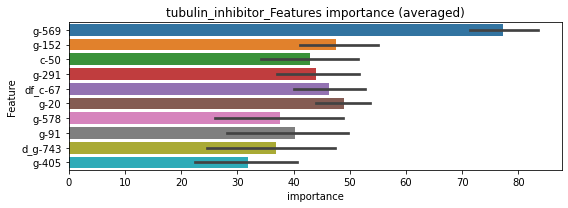

len(train_index) : 3805
len(valid_index) : 3806
================================= fold 1/2 tubulin_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0144632	valid_1's binary_logloss: 0.0337156
[200]	training's binary_logloss: 0.0018928	valid_1's binary_logloss: 0.0180224
[300]	training's binary_logloss: 0.000552977	valid_1's binary_logloss: 0.0147583
Early stopping, best iteration is:
[345]	training's binary_logloss: 0.000390271	valid_1's binary_logloss: 0.014037


len(train_index) : 3806
len(valid_index) : 3805
================================= fold 2/2 tubulin_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0147201	valid_1's binary_logloss: 0.0306131
[200]	training's binary_logloss: 0.00192296	valid_1's binary_logloss: 0.0176717
Early stopping, best iteration is:
[260]	training's binary_logloss: 0.00085589	valid_1's binary_logloss: 0.0162558


tubulin_inhibitor logloss: 0.015146260644434395
tyrosine_kinase_inhibitor, len(trt): 73, len(othr): 3276, target_rate: 0.0030654 → Adj_target_rate: 0.0032212


neg labels: 3289 → selected neg labels: 3276


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0537174	valid_1's binary_logloss: 0.109116
[200]	training's binary_logloss: 0.0114973	valid_1's binary_logloss: 0.0540217
[300]	training's binary_logloss: 0.00343696	valid_1's binary_logloss: 0.0400175
[400]	training's binary_logloss: 0.00157913	valid_1's binary_logloss: 0.0364269
Early stopping, best iteration is:
[478]	training's binary_logloss: 0.00106557	valid_1's binary_logloss: 0.0343868
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0493575	valid_1's binary_logloss: 0.0992332
[200]	training's binary_logloss: 0.010854	valid_1's binary_logloss: 0.0530251
[300]	training's binary_logloss: 0.00331154	valid_1's binary_logloss: 0.041087
[400]	training's binary_logloss: 0.00154667	valid_1's binary_logloss: 0.0373456
Early stopping, best iteration is:
[392]	training's binary_logloss: 0.00162612	valid_1's binary_logloss: 0.0373133


1 / 3 AUC score:0.998
Threshold: 0.0115621, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 142 → positive_corect_labels: 650/3789
p_label_rate: 0.0507283 Vs.target_rate: 0.00307, Num_p_label: 202.0, conf_0:0.00167, conf_1:0.01272
Num_p_label: 202.0, Expected: 12.2, Adj_threshold_1: 0.0115621
Num_p_label: 124.0, Expected: 12.2, Adj_threshold_2: 0.0165621
Num_p_label: 95.0, Expected: 12.2, Adj_threshold_3: 0.0215621
Num_p_label: 73.0, Expected: 12.2, Adj_threshold_4: 0.0265621
Num_p_label: 57.0, Expected: 12.2, Adj_threshold_5: 0.0315621
Num_p_label: 46.0, Expected: 12.2, Adj_threshold_6: 0.0365621
Num_p_label: 37.0, Expected: 12.2, Adj_threshold_7: 0.0415621
Num_p_label: 29.0, Expected: 12.2, Adj_threshold_8: 0.0465621
Num_p_label: 20.0, Expected: 12.2, Adj_threshold_9: 0.0515621
threshold: 0.0515621, positive p_label: 20.0/3982, p_label_rate: 0.0050226
positive y_label: 650.0/3789, y_label_rate: 0.1715492
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0476748	valid_1's binary_logloss: 0.103699
[200]	training's binary_logloss: 0.00936915	valid_1's binary_logloss: 0.0523426
[300]	training's binary_logloss: 0.002899	valid_1's binary_logloss: 0.0390244
[400]	training's binary_logloss: 0.00139624	valid_1's binary_logloss: 0.0354035
Early stopping, best iteration is:
[395]	training's binary_logloss: 0.0014397	valid_1's binary_logloss: 0.0352815
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0478535	valid_1's binary_logloss: 0.0990649
[200]	training's binary_logloss: 0.00959559	valid_1's binary_logloss: 0.0520157
[300]	training's binary_logloss: 0.00295439	valid_1's binary_logloss: 0.0400469
[400]	training's binary_logloss: 0.00140567	valid_1's binary_logloss: 0.0361016
[500]	training's binary_logloss: 0.000894019	valid_1's binary_logloss: 0.0349393
Early stopping, best iteration is:
[490]	trainin

2 / 3 AUC score:0.999
Threshold: 0.0515621, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 17 → positive_corect_labels: 639.0/3772
p_label_rate: 0.0180814 Vs.target_rate: 0.00307, Num_p_label: 72.0, conf_0:0.00160, conf_1:0.05672
Num_p_label: 72.0, Expected: 12.2, Adj_threshold_1: 0.0515621
Num_p_label: 65.0, Expected: 12.2, Adj_threshold_2: 0.0565621
Num_p_label: 60.0, Expected: 12.2, Adj_threshold_3: 0.0615621
Num_p_label: 58.0, Expected: 12.2, Adj_threshold_4: 0.0665621
Num_p_label: 55.0, Expected: 12.2, Adj_threshold_5: 0.0715621
Num_p_label: 49.0, Expected: 12.2, Adj_threshold_6: 0.0765621
Num_p_label: 46.0, Expected: 12.2, Adj_threshold_7: 0.0815621
Num_p_label: 43.0, Expected: 12.2, Adj_threshold_8: 0.0865621
Num_p_label: 36.0, Expected: 12.2, Adj_threshold_9: 0.0915621
Num_p_label: 33.0, Expected: 12.2, Adj_threshold_10: 0.0965621
threshold: 0.1015621, positive p_label: 33.0/3982, p_label_rate: 0.0082873
positive y_label: 639.0/3772, y_label_rate: 0.1694062
================= Pse

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0464533	valid_1's binary_logloss: 0.0905817
[200]	training's binary_logloss: 0.00908395	valid_1's binary_logloss: 0.0406255
[300]	training's binary_logloss: 0.00283365	valid_1's binary_logloss: 0.0281372
[400]	training's binary_logloss: 0.00135721	valid_1's binary_logloss: 0.0242919
[500]	training's binary_logloss: 0.000857482	valid_1's binary_logloss: 0.0224711
Early stopping, best iteration is:
[561]	training's binary_logloss: 0.000711455	valid_1's binary_logloss: 0.0218872
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0497671	valid_1's binary_logloss: 0.0966884
[200]	training's binary_logloss: 0.0101705	valid_1's binary_logloss: 0.0475038
[300]	training's binary_logloss: 0.00305167	valid_1's binary_logloss: 0.0355906
Early stopping, best iteration is:
[388]	training's binary_logloss: 0.00152461	valid_1's binary_logloss: 0.0332817


3 / 3 AUC score:1.000
Threshold: 0.1015621, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 15 → positive_corect_labels: 624.0/3757
p_label_rate: 0.0087896 Vs.target_rate: 0.00307, Num_p_label: 35.0, conf_0:0.00143, conf_1:0.11172
threshold: 0.1015621, positive p_label: 35.0/3982, p_label_rate: 0.0087896
positive y_label: 659.0/7739, y_label_rate: 0.0851531


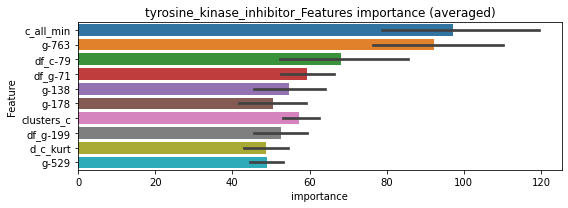

len(train_index) : 3869
len(valid_index) : 3870
================================= fold 1/2 tyrosine_kinase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0285444	valid_1's binary_logloss: 0.0610697
[200]	training's binary_logloss: 0.00577706	valid_1's binary_logloss: 0.0351774
[300]	training's binary_logloss: 0.00169749	valid_1's binary_logloss: 0.0292276
Early stopping, best iteration is:
[330]	training's binary_logloss: 0.00128183	valid_1's binary_logloss: 0.0283041


len(train_index) : 3870
len(valid_index) : 3869
================================= fold 2/2 tyrosine_kinase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0276503	valid_1's binary_logloss: 0.0602534
[200]	training's binary_logloss: 0.0055059	valid_1's binary_logloss: 0.0333431
[300]	training's binary_logloss: 0.001663	valid_1's binary_logloss: 0.0262885
[400]	training's binary_logloss: 0.000782451	valid_1's binary_logloss: 0.0248633
Early stopping, best iteration is:
[444]	training's binary_logloss: 0.00061543	valid_1's binary_logloss: 0.0242556


tyrosine_kinase_inhibitor logloss: 0.026280134487231013


  acetylcholine_receptor_agonist acetylcholine_receptor_antagonist  \
0                       df_g-122                              c-30   
1                  clusters_df_c                         c_all_max   
2                          cnt_0                    clusters_g_all   
3                      c_all_min                          df_g-707   
4                        df_g-51                        clusters_g   
5                       df_c_min                          df_c_min   
6                          cnt_2                             g-514   
7                       df_g-736                          df_g-640   
8                          g-244                            df_c-6   
9                           c-73                          df_g-597   

  acetylcholinesterase_inhibitor adenosine_receptor_antagonist  \
0                      c_all_max                clusters_c_all   
1                      c_all_min                      df_c_min   
2                 clusters_g_al

ubiquitin_specific_protease_inhibitor, len(trt): 12, len(othr): 3287, target_rate: 0.0005039 → Adj_target_rate: 0.0006942


neg labels: 3289 → selected neg labels: 3287


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0179446	valid_1's binary_logloss: 0.0204967
[200]	training's binary_logloss: 0.0017733	valid_1's binary_logloss: 0.0026403
[300]	training's binary_logloss: 0.000508873	valid_1's binary_logloss: 0.000973071
[400]	training's binary_logloss: 0.00029762	valid_1's binary_logloss: 0.000634637
[500]	training's binary_logloss: 0.000261963	valid_1's binary_logloss: 0.000575277
Early stopping, best iteration is:
[537]	training's binary_logloss: 0.000259994	valid_1's binary_logloss: 0.00057175
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0181723	valid_1's binary_logloss: 0.0215421
[200]	training's binary_logloss: 0.00178135	valid_1's binary_logloss: 0.00302567
[300]	training's binary_logloss: 0.000502004	valid_1's binary_logloss: 0.00118902
[400]	training's binary_logloss: 0.000292361	valid_1's binary_logloss: 0.000808012
[500]	training's binary_loglos

1 / 3 AUC score:1.000
Threshold: 0.0009727, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → positive_corect_labels: 657/3812
p_label_rate: 0.0359116 Vs.target_rate: 0.00050, Num_p_label: 143.0, conf_0:0.00013, conf_1:0.00107
Num_p_label: 143.0, Expected: 2.0, Adj_threshold_1: 0.0009727
Num_p_label: 28.0, Expected: 2.0, Adj_threshold_2: 0.0059727
Num_p_label: 18.0, Expected: 2.0, Adj_threshold_3: 0.0109727
Num_p_label: 10.0, Expected: 2.0, Adj_threshold_4: 0.0159727
Num_p_label: 6.0, Expected: 2.0, Adj_threshold_5: 0.0209727
Num_p_label: 4.0, Expected: 2.0, Adj_threshold_6: 0.0259727
threshold: 0.0259727, positive p_label: 4.0/3982, p_label_rate: 0.0010045
positive y_label: 657.0/3812, y_label_rate: 0.1723505
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0181908	valid_1's binary_logloss: 0.0211018
[200]	training's binary_logloss: 0.00172045	valid_1's binary_logloss: 0.00369239
[300]	training's binary_logloss: 0.000471976	valid_1's binary_logloss: 0.00211835
[400]	training's binary_logloss: 0.000278264	valid_1's binary_logloss: 0.00179135
[500]	training's binary_logloss: 0.000244353	valid_1's binary_logloss: 0.00173657
Early stopping, best iteration is:
[503]	training's binary_logloss: 0.00024417	valid_1's binary_logloss: 0.00173583
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0182372	valid_1's binary_logloss: 0.0200955
[200]	training's binary_logloss: 0.00170714	valid_1's binary_logloss: 0.0021788
[300]	training's binary_logloss: 0.000475079	valid_1's binary_logloss: 0.000685675
[400]	training's binary_logloss: 0.000279556	valid_1's binary_logloss: 0.000420158
[500]	training's binary_logloss

2 / 3 AUC score:1.000
Threshold: 0.0259727, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 1 → positive_corect_labels: 657.0/3811
p_label_rate: 0.0115520 Vs.target_rate: 0.00050, Num_p_label: 46.0, conf_0:0.00014, conf_1:0.02857
Num_p_label: 46.0, Expected: 2.0, Adj_threshold_1: 0.0259727
Num_p_label: 42.0, Expected: 2.0, Adj_threshold_2: 0.0309727
Num_p_label: 41.0, Expected: 2.0, Adj_threshold_3: 0.0359727
Num_p_label: 38.0, Expected: 2.0, Adj_threshold_4: 0.0409727
Num_p_label: 35.0, Expected: 2.0, Adj_threshold_5: 0.0459727
Num_p_label: 34.0, Expected: 2.0, Adj_threshold_6: 0.0509727
Num_p_label: 32.0, Expected: 2.0, Adj_threshold_7: 0.0559727
Num_p_label: 30.0, Expected: 2.0, Adj_threshold_8: 0.0609727
Num_p_label: 29.0, Expected: 2.0, Adj_threshold_9: 0.0659727
Num_p_label: 29.0, Expected: 2.0, Adj_threshold_10: 0.0709727
threshold: 0.0759727, positive p_label: 28.0/3982, p_label_rate: 0.0070316
positive y_label: 657.0/3811, y_label_rate: 0.1723957
================= Pseudo labelin

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0179912	valid_1's binary_logloss: 0.021571
[200]	training's binary_logloss: 0.00168466	valid_1's binary_logloss: 0.00373681
[300]	training's binary_logloss: 0.000466266	valid_1's binary_logloss: 0.00198649
[400]	training's binary_logloss: 0.000274896	valid_1's binary_logloss: 0.00156557
Early stopping, best iteration is:
[415]	training's binary_logloss: 0.000265267	valid_1's binary_logloss: 0.00154612
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0183201	valid_1's binary_logloss: 0.0199174
[200]	training's binary_logloss: 0.00170363	valid_1's binary_logloss: 0.00206856
[300]	training's binary_logloss: 0.000475557	valid_1's binary_logloss: 0.000613803
[400]	training's binary_logloss: 0.000281203	valid_1's binary_logloss: 0.000378448
[500]	training's binary_logloss: 0.000244768	valid_1's binary_logloss: 0.00033408
[600]	training's binary_loglos

3 / 3 AUC score:1.000
Threshold: 0.0759727, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → positive_corect_labels: 657.0/3811
p_label_rate: 0.0087896 Vs.target_rate: 0.00050, Num_p_label: 35.0, conf_0:0.00015, conf_1:0.08357
Num_p_label: 35.0, Expected: 2.0, Adj_threshold_1: 0.0759727
Num_p_label: 35.0, Expected: 2.0, Adj_threshold_2: 0.0809727
Num_p_label: 34.0, Expected: 2.0, Adj_threshold_3: 0.0859727
Num_p_label: 33.0, Expected: 2.0, Adj_threshold_4: 0.0909727
Num_p_label: 32.0, Expected: 2.0, Adj_threshold_5: 0.0959727
Num_p_label: 31.0, Expected: 2.0, Adj_threshold_6: 0.1009727
Num_p_label: 31.0, Expected: 2.0, Adj_threshold_7: 0.1059727
Num_p_label: 28.0, Expected: 2.0, Adj_threshold_8: 0.1109727
Num_p_label: 28.0, Expected: 2.0, Adj_threshold_9: 0.1159727
Num_p_label: 28.0, Expected: 2.0, Adj_threshold_10: 0.1209727
threshold: 0.1259727, positive p_label: 27.0/3982, p_label_rate: 0.0067805
positive y_label: 684.0/7793, y_label_rate: 0.0877711


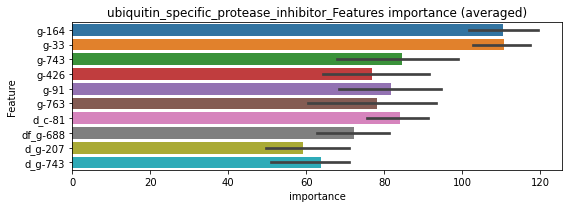

len(train_index) : 3896
len(valid_index) : 3897
================================= fold 1/2 ubiquitin_specific_protease_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0105547	valid_1's binary_logloss: 0.0163321
[200]	training's binary_logloss: 0.0010839	valid_1's binary_logloss: 0.00609802
[300]	training's binary_logloss: 0.000299513	valid_1's binary_logloss: 0.00509151
Early stopping, best iteration is:
[341]	training's binary_logloss: 0.000225179	valid_1's binary_logloss: 0.00496066


len(train_index) : 3897
len(valid_index) : 3896
================================= fold 2/2 ubiquitin_specific_protease_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0104133	valid_1's binary_logloss: 0.0149446
[200]	training's binary_logloss: 0.00105645	valid_1's binary_logloss: 0.0057234
[300]	training's binary_logloss: 0.000297695	valid_1's binary_logloss: 0.00485772
Early stopping, best iteration is:
[309]	training's binary_logloss: 0.00027743	valid_1's binary_logloss: 0.00481911


ubiquitin_specific_protease_inhibitor logloss: 0.004889897054417124
vegfr_inhibitor, len(trt): 170, len(othr): 3258, target_rate: 0.0071387 → Adj_target_rate: 0.0066081


neg labels: 3289 → selected neg labels: 3258


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0573948	valid_1's binary_logloss: 0.156454
[200]	training's binary_logloss: 0.0134496	valid_1's binary_logloss: 0.115683
[300]	training's binary_logloss: 0.00434809	valid_1's binary_logloss: 0.107569
Early stopping, best iteration is:
[291]	training's binary_logloss: 0.00474683	valid_1's binary_logloss: 0.107164
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0628577	valid_1's binary_logloss: 0.140238
[200]	training's binary_logloss: 0.015559	valid_1's binary_logloss: 0.0907867
[300]	training's binary_logloss: 0.00505738	valid_1's binary_logloss: 0.0737456
[400]	training's binary_logloss: 0.00235401	valid_1's binary_logloss: 0.0689181
Early stopping, best iteration is:
[476]	training's binary_logloss: 0.00156347	valid_1's binary_logloss: 0.0663187


1 / 3 AUC score:0.992
Threshold: 0.0382583, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 171 → positive_corect_labels: 631/3738
p_label_rate: 0.0507283 Vs.target_rate: 0.00714, Num_p_label: 202.0, conf_0:0.00309, conf_1:0.04208
Num_p_label: 202.0, Expected: 28.4, Adj_threshold_1: 0.0382583
Num_p_label: 191.0, Expected: 28.4, Adj_threshold_2: 0.0432583
Num_p_label: 177.0, Expected: 28.4, Adj_threshold_3: 0.0482583
Num_p_label: 171.0, Expected: 28.4, Adj_threshold_4: 0.0532583
Num_p_label: 165.0, Expected: 28.4, Adj_threshold_5: 0.0582583
Num_p_label: 158.0, Expected: 28.4, Adj_threshold_6: 0.0632583
Num_p_label: 154.0, Expected: 28.4, Adj_threshold_7: 0.0682583
Num_p_label: 149.0, Expected: 28.4, Adj_threshold_8: 0.0732583
Num_p_label: 147.0, Expected: 28.4, Adj_threshold_9: 0.0782583
Num_p_label: 140.0, Expected: 28.4, Adj_threshold_10: 0.0832583
threshold: 0.0882583, positive p_label: 131.0/3982, p_label_rate: 0.0328980
positive y_label: 631.0/3738, y_label_rate: 0.1688068
==========

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0534079	valid_1's binary_logloss: 0.122187
[200]	training's binary_logloss: 0.011449	valid_1's binary_logloss: 0.0794742
[300]	training's binary_logloss: 0.00352009	valid_1's binary_logloss: 0.0667994
Early stopping, best iteration is:
[307]	training's binary_logloss: 0.00328679	valid_1's binary_logloss: 0.0663292
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.053187	valid_1's binary_logloss: 0.131909
[200]	training's binary_logloss: 0.0113418	valid_1's binary_logloss: 0.0850912
[300]	training's binary_logloss: 0.00342916	valid_1's binary_logloss: 0.0719731
Early stopping, best iteration is:
[313]	training's binary_logloss: 0.00306763	valid_1's binary_logloss: 0.0718084


2 / 3 AUC score:0.995
Threshold: 0.0882583, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 72 → positive_corect_labels: 603.0/3666
p_label_rate: 0.0570065 Vs.target_rate: 0.00714, Num_p_label: 227.0, conf_0:0.00347, conf_1:0.09708
Num_p_label: 227.0, Expected: 28.4, Adj_threshold_1: 0.0882583
Num_p_label: 221.0, Expected: 28.4, Adj_threshold_2: 0.0932583
Num_p_label: 215.0, Expected: 28.4, Adj_threshold_3: 0.0982583
Num_p_label: 213.0, Expected: 28.4, Adj_threshold_4: 0.1032583
Num_p_label: 209.0, Expected: 28.4, Adj_threshold_5: 0.1082583
Num_p_label: 208.0, Expected: 28.4, Adj_threshold_6: 0.1132583
Num_p_label: 205.0, Expected: 28.4, Adj_threshold_7: 0.1182583
Num_p_label: 205.0, Expected: 28.4, Adj_threshold_8: 0.1232583
Num_p_label: 203.0, Expected: 28.4, Adj_threshold_9: 0.1282583
Num_p_label: 200.0, Expected: 28.4, Adj_threshold_10: 0.1332583
threshold: 0.1382583, positive p_label: 194.0/3982, p_label_rate: 0.0487192
positive y_label: 603.0/3666, y_label_rate: 0.1644845
=========

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0456852	valid_1's binary_logloss: 0.106081
[200]	training's binary_logloss: 0.00915512	valid_1's binary_logloss: 0.0613855
[300]	training's binary_logloss: 0.00286543	valid_1's binary_logloss: 0.0495708
[400]	training's binary_logloss: 0.00138594	valid_1's binary_logloss: 0.0463256
Early stopping, best iteration is:
[395]	training's binary_logloss: 0.00142956	valid_1's binary_logloss: 0.0462068
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0475113	valid_1's binary_logloss: 0.106372
[200]	training's binary_logloss: 0.00951498	valid_1's binary_logloss: 0.062476
[300]	training's binary_logloss: 0.00291757	valid_1's binary_logloss: 0.0521984
Early stopping, best iteration is:
[323]	training's binary_logloss: 0.00240438	valid_1's binary_logloss: 0.0511803


3 / 3 AUC score:0.996
Threshold: 0.1382583, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 33 → positive_corect_labels: 578.0/3633
p_label_rate: 0.0554997 Vs.target_rate: 0.00714, Num_p_label: 221.0, conf_0:0.00214, conf_1:0.15208
Num_p_label: 221.0, Expected: 28.4, Adj_threshold_1: 0.1382583
Num_p_label: 220.0, Expected: 28.4, Adj_threshold_2: 0.1432583
Num_p_label: 220.0, Expected: 28.4, Adj_threshold_3: 0.1482583
Num_p_label: 219.0, Expected: 28.4, Adj_threshold_4: 0.1532583
Num_p_label: 219.0, Expected: 28.4, Adj_threshold_5: 0.1582583
Num_p_label: 217.0, Expected: 28.4, Adj_threshold_6: 0.1632583
Num_p_label: 211.0, Expected: 28.4, Adj_threshold_7: 0.1682583
Num_p_label: 208.0, Expected: 28.4, Adj_threshold_8: 0.1732583
Num_p_label: 207.0, Expected: 28.4, Adj_threshold_9: 0.1782583
Num_p_label: 207.0, Expected: 28.4, Adj_threshold_10: 0.1832583
threshold: 0.1882583, positive p_label: 206.0/3982, p_label_rate: 0.0517328
positive y_label: 784.0/7615, y_label_rate: 0.1029547


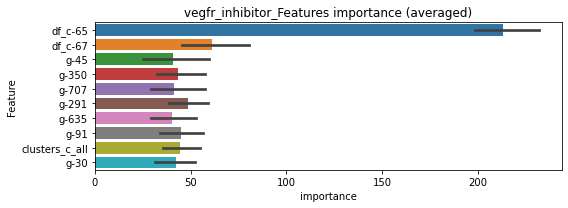

len(train_index) : 3807
len(valid_index) : 3808
================================= fold 1/2 vegfr_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0317609	valid_1's binary_logloss: 0.0819622
[200]	training's binary_logloss: 0.00626739	valid_1's binary_logloss: 0.0566218
[300]	training's binary_logloss: 0.00189764	valid_1's binary_logloss: 0.0508496
Early stopping, best iteration is:
[298]	training's binary_logloss: 0.00192765	valid_1's binary_logloss: 0.0508165


len(train_index) : 3808
len(valid_index) : 3807
================================= fold 2/2 vegfr_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0323525	valid_1's binary_logloss: 0.0768393
[200]	training's binary_logloss: 0.00640151	valid_1's binary_logloss: 0.0487
[300]	training's binary_logloss: 0.00191727	valid_1's binary_logloss: 0.0417027
Early stopping, best iteration is:
[335]	training's binary_logloss: 0.00142125	valid_1's binary_logloss: 0.0406794


vegfr_inhibitor logloss: 0.04574859119761428


  acetylcholine_receptor_agonist acetylcholine_receptor_antagonist  \
0                       df_g-122                              c-30   
1                  clusters_df_c                         c_all_max   
2                          cnt_0                    clusters_g_all   
3                      c_all_min                          df_g-707   
4                        df_g-51                        clusters_g   
5                       df_c_min                          df_c_min   
6                          cnt_2                             g-514   
7                       df_g-736                          df_g-640   
8                          g-244                            df_c-6   
9                           c-73                          df_g-597   

  acetylcholinesterase_inhibitor adenosine_receptor_antagonist  \
0                      c_all_max                clusters_c_all   
1                      c_all_min                      df_c_min   
2                 clusters_g_al

vitamin_b, len(trt): 26, len(othr): 3285, target_rate: 0.0010918 → Adj_target_rate: 0.0013394


neg labels: 3289 → selected neg labels: 3285


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0308905	valid_1's binary_logloss: 0.046689
[200]	training's binary_logloss: 0.0042693	valid_1's binary_logloss: 0.0114111
[300]	training's binary_logloss: 0.00118863	valid_1's binary_logloss: 0.00582185
[400]	training's binary_logloss: 0.000609323	valid_1's binary_logloss: 0.00439499
[500]	training's binary_logloss: 0.000432052	valid_1's binary_logloss: 0.00384187
Early stopping, best iteration is:
[500]	training's binary_logloss: 0.000432052	valid_1's binary_logloss: 0.00384187
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0322866	valid_1's binary_logloss: 0.0433749
[200]	training's binary_logloss: 0.00455484	valid_1's binary_logloss: 0.0102809
[300]	training's binary_logloss: 0.00127379	valid_1's binary_logloss: 0.00486783
[400]	training's binary_logloss: 0.000635643	valid_1's binary_logloss: 0.0035745
[500]	training's binary_logloss: 0.000

1 / 3 AUC score:1.000
Threshold: 0.0025848, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → positive_corect_labels: 657/3810
p_label_rate: 0.0401808 Vs.target_rate: 0.00109, Num_p_label: 160.0, conf_0:0.00036, conf_1:0.00284
Num_p_label: 160.0, Expected: 4.3, Adj_threshold_1: 0.0025848
Num_p_label: 39.0, Expected: 4.3, Adj_threshold_2: 0.0075848
Num_p_label: 17.0, Expected: 4.3, Adj_threshold_3: 0.0125848
Num_p_label: 7.0, Expected: 4.3, Adj_threshold_4: 0.0175848
threshold: 0.0175848, positive p_label: 7.0/3982, p_label_rate: 0.0017579
positive y_label: 657.0/3810, y_label_rate: 0.1724409
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0313135	valid_1's binary_logloss: 0.0450045
[200]	training's binary_logloss: 0.00416823	valid_1's binary_logloss: 0.0105703
[300]	training's binary_logloss: 0.00117195	valid_1's binary_logloss: 0.00555491
[400]	training's binary_logloss: 0.00059752	valid_1's binary_logloss: 0.00417026
[500]	training's binary_logloss: 0.000427913	valid_1's binary_logloss: 0.00373278
Early stopping, best iteration is:
[504]	training's binary_logloss: 0.000425371	valid_1's binary_logloss: 0.00372614
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0317654	valid_1's binary_logloss: 0.0427874
[200]	training's binary_logloss: 0.00445999	valid_1's binary_logloss: 0.00979001
[300]	training's binary_logloss: 0.00125614	valid_1's binary_logloss: 0.00470322
[400]	training's binary_logloss: 0.000628964	valid_1's binary_logloss: 0.00346189
[500]	training's binary_logloss: 0.

2 / 3 AUC score:1.000
Threshold: 0.0175848, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 1 → positive_corect_labels: 657.0/3809
p_label_rate: 0.0052737 Vs.target_rate: 0.00109, Num_p_label: 21.0, conf_0:0.00041, conf_1:0.01934
Num_p_label: 21.0, Expected: 4.3, Adj_threshold_1: 0.0175848
Num_p_label: 14.0, Expected: 4.3, Adj_threshold_2: 0.0225848
Num_p_label: 10.0, Expected: 4.3, Adj_threshold_3: 0.0275848
Num_p_label: 9.0, Expected: 4.3, Adj_threshold_4: 0.0325848
Num_p_label: 6.0, Expected: 4.3, Adj_threshold_5: 0.0375848
threshold: 0.0375848, positive p_label: 6.0/3982, p_label_rate: 0.0015068
positive y_label: 657.0/3809, y_label_rate: 0.1724862
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0309699	valid_1's binary_logloss: 0.0452112
[200]	training's binary_logloss: 0.00430768	valid_1's binary_logloss: 0.0111976
[300]	training's binary_logloss: 0.00118449	valid_1's binary_logloss: 0.00576695
[400]	training's binary_logloss: 0.000605792	valid_1's binary_logloss: 0.00438445
[500]	training's binary_logloss: 0.00043488	valid_1's binary_logloss: 0.00404972
Early stopping, best iteration is:
[530]	training's binary_logloss: 0.000419012	valid_1's binary_logloss: 0.00399545
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0316471	valid_1's binary_logloss: 0.0427425
[200]	training's binary_logloss: 0.00443737	valid_1's binary_logloss: 0.00990588
[300]	training's binary_logloss: 0.00124593	valid_1's binary_logloss: 0.00470057
[400]	training's binary_logloss: 0.000625645	valid_1's binary_logloss: 0.00340373
[500]	training's binary_logloss: 0.

3 / 3 AUC score:1.000
Threshold: 0.0375848, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → positive_corect_labels: 657.0/3809
p_label_rate: 0.0015068 Vs.target_rate: 0.00109, Num_p_label: 6.0, conf_0:0.00041, conf_1:0.04134
threshold: 0.0375848, positive p_label: 6.0/3982, p_label_rate: 0.0015068
positive y_label: 663.0/7791, y_label_rate: 0.0850982


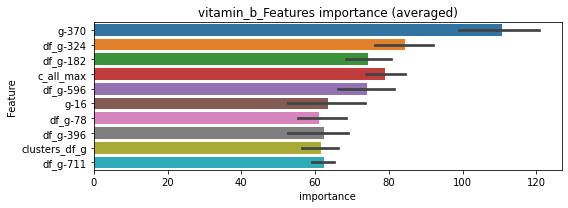

len(train_index) : 3895
len(valid_index) : 3896
================================= fold 1/2 vitamin_b=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0174832	valid_1's binary_logloss: 0.0318207
[200]	training's binary_logloss: 0.00235042	valid_1's binary_logloss: 0.0142178
[300]	training's binary_logloss: 0.000633023	valid_1's binary_logloss: 0.0116752
Early stopping, best iteration is:
[290]	training's binary_logloss: 0.000697192	valid_1's binary_logloss: 0.0116454


len(train_index) : 3896
len(valid_index) : 3895
================================= fold 2/2 vitamin_b=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0169706	valid_1's binary_logloss: 0.0263389
[200]	training's binary_logloss: 0.00238986	valid_1's binary_logloss: 0.00771041
[300]	training's binary_logloss: 0.000670626	valid_1's binary_logloss: 0.00462257
[400]	training's binary_logloss: 0.000333303	valid_1's binary_logloss: 0.00392114
[500]	training's binary_logloss: 0.000230195	valid_1's binary_logloss: 0.00367196
Early stopping, best iteration is:
[507]	training's binary_logloss: 0.000226956	valid_1's binary_logloss: 0.0036543


vitamin_b logloss: 0.007650340296793929
vitamin_d_receptor_agonist, len(trt): 39, len(othr): 3281, target_rate: 0.0016377 → Adj_target_rate: 0.0018906


neg labels: 3289 → selected neg labels: 3281


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0276468	valid_1's binary_logloss: 0.0399265
[200]	training's binary_logloss: 0.00368903	valid_1's binary_logloss: 0.00847178
[300]	training's binary_logloss: 0.00103542	valid_1's binary_logloss: 0.00345344
[400]	training's binary_logloss: 0.00051964	valid_1's binary_logloss: 0.00225232
[500]	training's binary_logloss: 0.000370068	valid_1's binary_logloss: 0.00182821
Early stopping, best iteration is:
[577]	training's binary_logloss: 0.000348041	valid_1's binary_logloss: 0.0017681
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0273391	valid_1's binary_logloss: 0.0413352
[200]	training's binary_logloss: 0.00361819	valid_1's binary_logloss: 0.00876712
[300]	training's binary_logloss: 0.00103872	valid_1's binary_logloss: 0.00343675
[400]	training's binary_logloss: 0.000531974	valid_1's binary_logloss: 0.00217405
[500]	training's binary_logloss: 0.

1 / 3 AUC score:1.000
Threshold: 0.0022474, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → positive_corect_labels: 656/3805
p_label_rate: 0.0482170 Vs.target_rate: 0.00164, Num_p_label: 192.0, conf_0:0.00027, conf_1:0.00247
Num_p_label: 192.0, Expected: 6.5, Adj_threshold_1: 0.0022474
Num_p_label: 58.0, Expected: 6.5, Adj_threshold_2: 0.0072474
Num_p_label: 41.0, Expected: 6.5, Adj_threshold_3: 0.0122474
Num_p_label: 26.0, Expected: 6.5, Adj_threshold_4: 0.0172474
Num_p_label: 20.0, Expected: 6.5, Adj_threshold_5: 0.0222474
Num_p_label: 17.0, Expected: 6.5, Adj_threshold_6: 0.0272474
Num_p_label: 16.0, Expected: 6.5, Adj_threshold_7: 0.0322474
Num_p_label: 16.0, Expected: 6.5, Adj_threshold_8: 0.0372474
Num_p_label: 14.0, Expected: 6.5, Adj_threshold_9: 0.0422474
Num_p_label: 14.0, Expected: 6.5, Adj_threshold_10: 0.0472474
threshold: 0.0522474, positive p_label: 13.0/3982, p_label_rate: 0.0032647
positive y_label: 656.0/3805, y_label_rate: 0.1724047
================= Pseudo label

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0277027	valid_1's binary_logloss: 0.0400175
[200]	training's binary_logloss: 0.00360339	valid_1's binary_logloss: 0.00793489
[300]	training's binary_logloss: 0.0010255	valid_1's binary_logloss: 0.00318908
[400]	training's binary_logloss: 0.000518166	valid_1's binary_logloss: 0.00200873
[500]	training's binary_logloss: 0.000368698	valid_1's binary_logloss: 0.00163348
Early stopping, best iteration is:
[549]	training's binary_logloss: 0.000346666	valid_1's binary_logloss: 0.00158593
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0284065	valid_1's binary_logloss: 0.0421966
[200]	training's binary_logloss: 0.00365092	valid_1's binary_logloss: 0.00817698
[300]	training's binary_logloss: 0.00102467	valid_1's binary_logloss: 0.00314661
[400]	training's binary_logloss: 0.000518808	valid_1's binary_logloss: 0.00196541
[500]	training's binary_logloss: 0

2 / 3 AUC score:1.000
Threshold: 0.0522474, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → positive_corect_labels: 656.0/3805
p_label_rate: 0.0037670 Vs.target_rate: 0.00164, Num_p_label: 15.0, conf_0:0.00031, conf_1:0.05747
threshold: 0.0522474, positive p_label: 15.0/3982, p_label_rate: 0.0037670
positive y_label: 656.0/3805, y_label_rate: 0.1724047
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0277027	valid_1's binary_logloss: 0.0400175
[200]	training's binary_logloss: 0.00360339	valid_1's binary_logloss: 0.00793489
[300]	training's binary_logloss: 0.0010255	valid_1's binary_logloss: 0.00318908
[400]	training's binary_logloss: 0.000518166	valid_1's binary_logloss: 0.00200873
[500]	training's binary_logloss: 0.000368698	valid_1's binary_logloss: 0.00163348
Early stopping, best iteration is:
[549]	training's binary_logloss: 0.000346666	valid_1's binary_logloss: 0.00158593
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0284065	valid_1's binary_logloss: 0.0421966
[200]	training's binary_logloss: 0.00365092	valid_1's binary_logloss: 0.00817698
[300]	training's binary_logloss: 0.00102467	valid_1's binary_logloss: 0.00314661
[400]	training's binary_logloss: 0.000518808	valid_1's binary_logloss: 0.00196541
[500]	training's binary_logloss: 0

3 / 3 AUC score:1.000
Threshold: 0.0522474, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → positive_corect_labels: 656.0/3805
p_label_rate: 0.0037670 Vs.target_rate: 0.00164, Num_p_label: 15.0, conf_0:0.00031, conf_1:0.05747
threshold: 0.0522474, positive p_label: 15.0/3982, p_label_rate: 0.0037670
positive y_label: 671.0/7787, y_label_rate: 0.0861693


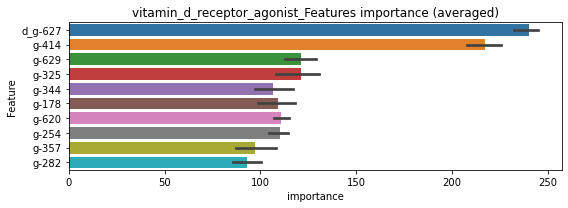

len(train_index) : 3893
len(valid_index) : 3894
================================= fold 1/2 vitamin_d_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0138945	valid_1's binary_logloss: 0.0296527
[200]	training's binary_logloss: 0.00177289	valid_1's binary_logloss: 0.0131967
[300]	training's binary_logloss: 0.000506496	valid_1's binary_logloss: 0.0107521
Early stopping, best iteration is:
[346]	training's binary_logloss: 0.000353609	valid_1's binary_logloss: 0.0104429


len(train_index) : 3894
len(valid_index) : 3893
================================= fold 2/2 vitamin_d_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0145662	valid_1's binary_logloss: 0.023924
[200]	training's binary_logloss: 0.00188702	valid_1's binary_logloss: 0.00696314
[300]	training's binary_logloss: 0.000540403	valid_1's binary_logloss: 0.00418078
[400]	training's binary_logloss: 0.000275798	valid_1's binary_logloss: 0.00366012
[500]	training's binary_logloss: 0.000197162	valid_1's binary_logloss: 0.00348817
Early stopping, best iteration is:
[496]	training's binary_logloss: 0.000198481	valid_1's binary_logloss: 0.00348552


vitamin_d_receptor_agonist logloss: 0.00696463844700079
wnt_inhibitor, len(trt): 30, len(othr): 3284, target_rate: 0.0012598 → Adj_target_rate: 0.0015127


neg labels: 3289 → selected neg labels: 3284


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.034943	valid_1's binary_logloss: 0.0566006
[200]	training's binary_logloss: 0.00520577	valid_1's binary_logloss: 0.0160007
[300]	training's binary_logloss: 0.00144433	valid_1's binary_logloss: 0.00807825
[400]	training's binary_logloss: 0.000705555	valid_1's binary_logloss: 0.00619218
[500]	training's binary_logloss: 0.00047454	valid_1's binary_logloss: 0.00548032
Early stopping, best iteration is:
[490]	training's binary_logloss: 0.000486192	valid_1's binary_logloss: 0.00546396
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0348277	valid_1's binary_logloss: 0.0583106
[200]	training's binary_logloss: 0.00516163	valid_1's binary_logloss: 0.0202929
[300]	training's binary_logloss: 0.00142619	valid_1's binary_logloss: 0.0126138
[400]	training's binary_logloss: 0.00070049	valid_1's binary_logloss: 0.0105205
Early stopping, best iteration is:
[421]

1 / 3 AUC score:1.000
Threshold: 0.0029373, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → positive_corect_labels: 656/3808
p_label_rate: 0.0436966 Vs.target_rate: 0.00126, Num_p_label: 174.0, conf_0:0.00055, conf_1:0.00323
Num_p_label: 174.0, Expected: 5.0, Adj_threshold_1: 0.0029373
Num_p_label: 34.0, Expected: 5.0, Adj_threshold_2: 0.0079373
Num_p_label: 9.0, Expected: 5.0, Adj_threshold_3: 0.0129373
threshold: 0.0129373, positive p_label: 9.0/3982, p_label_rate: 0.0022602
positive y_label: 656.0/3808, y_label_rate: 0.1722689
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0350408	valid_1's binary_logloss: 0.055278
[200]	training's binary_logloss: 0.00506651	valid_1's binary_logloss: 0.0147219
[300]	training's binary_logloss: 0.00140741	valid_1's binary_logloss: 0.00694913
[400]	training's binary_logloss: 0.000692919	valid_1's binary_logloss: 0.00510244
[500]	training's binary_logloss: 0.00047515	valid_1's binary_logloss: 0.00441191
Early stopping, best iteration is:
[526]	training's binary_logloss: 0.000451755	valid_1's binary_logloss: 0.00432663
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0344748	valid_1's binary_logloss: 0.0566689
[200]	training's binary_logloss: 0.00512054	valid_1's binary_logloss: 0.0189891
[300]	training's binary_logloss: 0.00143989	valid_1's binary_logloss: 0.0115746
[400]	training's binary_logloss: 0.00070288	valid_1's binary_logloss: 0.00945289
Early stopping, best iteration is:
[465

2 / 3 AUC score:1.000
Threshold: 0.0129373, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → positive_corect_labels: 656.0/3808
p_label_rate: 0.0072828 Vs.target_rate: 0.00126, Num_p_label: 29.0, conf_0:0.00052, conf_1:0.01423
Num_p_label: 29.0, Expected: 5.0, Adj_threshold_1: 0.0129373
Num_p_label: 16.0, Expected: 5.0, Adj_threshold_2: 0.0179373
Num_p_label: 8.0, Expected: 5.0, Adj_threshold_3: 0.0229373
threshold: 0.0229373, positive p_label: 8.0/3982, p_label_rate: 0.0020090
positive y_label: 656.0/3808, y_label_rate: 0.1722689
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0350408	valid_1's binary_logloss: 0.055278
[200]	training's binary_logloss: 0.00506651	valid_1's binary_logloss: 0.0147219
[300]	training's binary_logloss: 0.00140741	valid_1's binary_logloss: 0.00694913
[400]	training's binary_logloss: 0.000692919	valid_1's binary_logloss: 0.00510244
[500]	training's binary_logloss: 0.00047515	valid_1's binary_logloss: 0.00441191
Early stopping, best iteration is:
[526]	training's binary_logloss: 0.000451755	valid_1's binary_logloss: 0.00432663
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0344748	valid_1's binary_logloss: 0.0566689
[200]	training's binary_logloss: 0.00512054	valid_1's binary_logloss: 0.0189891
[300]	training's binary_logloss: 0.00143989	valid_1's binary_logloss: 0.0115746
[400]	training's binary_logloss: 0.00070288	valid_1's binary_logloss: 0.00945289
Early stopping, best iteration is:
[465

3 / 3 AUC score:1.000
Threshold: 0.0229373, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → positive_corect_labels: 656.0/3808
p_label_rate: 0.0020090 Vs.target_rate: 0.00126, Num_p_label: 8.0, conf_0:0.00052, conf_1:0.02523
threshold: 0.0229373, positive p_label: 8.0/3982, p_label_rate: 0.0020090
positive y_label: 664.0/7790, y_label_rate: 0.0852375


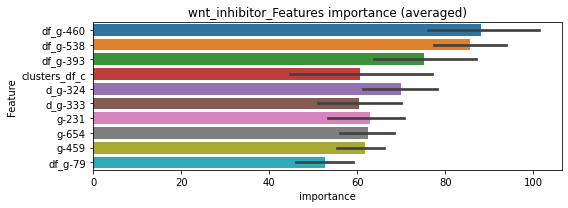

len(train_index) : 3895
len(valid_index) : 3895
================================= fold 1/2 wnt_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0192912	valid_1's binary_logloss: 0.0371745
[200]	training's binary_logloss: 0.00268549	valid_1's binary_logloss: 0.01799
[300]	training's binary_logloss: 0.000726992	valid_1's binary_logloss: 0.0155421
Early stopping, best iteration is:
[290]	training's binary_logloss: 0.000802574	valid_1's binary_logloss: 0.0155326


len(train_index) : 3895
len(valid_index) : 3895
================================= fold 2/2 wnt_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0207072	valid_1's binary_logloss: 0.0298641
[200]	training's binary_logloss: 0.00309276	valid_1's binary_logloss: 0.0081168
[300]	training's binary_logloss: 0.00085324	valid_1's binary_logloss: 0.0047666
[400]	training's binary_logloss: 0.000392357	valid_1's binary_logloss: 0.00411308
Early stopping, best iteration is:
[473]	training's binary_logloss: 0.000276624	valid_1's binary_logloss: 0.00398031


wnt_inhibitor logloss: 0.009756436369512362


In [47]:
categorical_cols = []
feature_importance_df = pd.DataFrame()
importance_cols_df = pd.DataFrame()
scores = []
models = []

for target_col in tqdm(train_targets_scored.columns[1:]):
    _preds, _score, models, _feature_importance_df = run_lgbm(target_col)

    sub[target_col] = _preds
    scores.append(_score)
    
    if DEBUG:
        if _score > 0.02:
            importance_cols_df[target_col] = select_importance_cols(_feature_importance_df)
            print(importance_cols_df)
        
        feature_importance_df = create_featureimprotance(models, feature_importance_df)

In [48]:
sub.to_csv('submission.csv', index=False)

In [49]:
print(f"CV:{np.mean(scores)}")

CV:0.019343707447344885


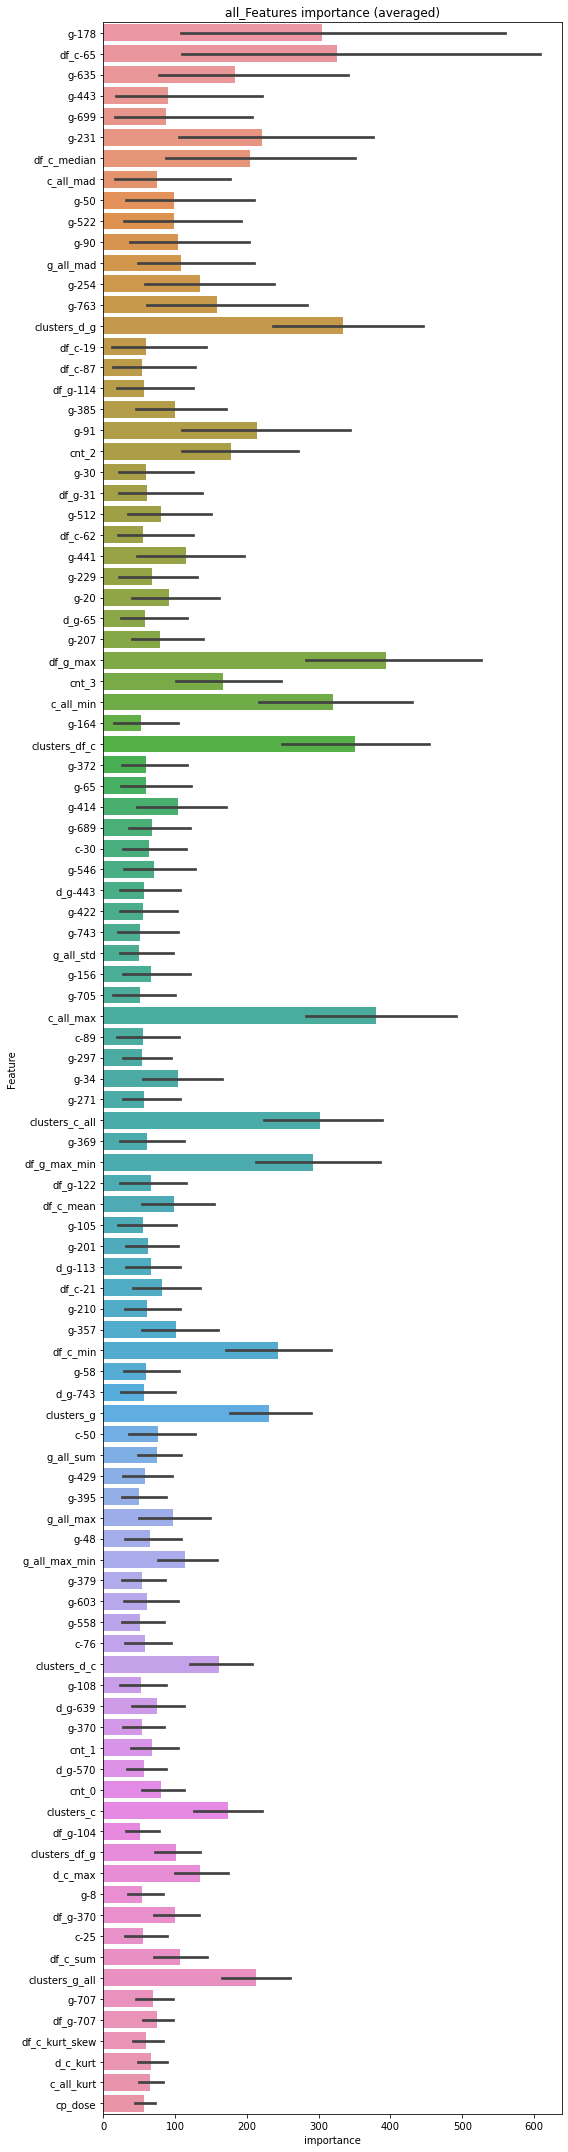

In [50]:
if DEBUG:
    show_feature_importance(feature_importance_df)
    feature_importance_df.to_csv(f'feature_importance_df.{Version}.csv', index=False)
    importance_cols_df.to_csv(f'importance_cols_df.{Version}.csv', index=False)